# AUTOMOBILE PRICE

### PROJECT

###  Цель:
Построить модель, которая будет предсказывать стоимость автомобиля по его характеристикам.  
Проанализировать результат работы различных алгоритмов и получить стабильную модель. 

### Структура:      
1. Импорт и вспомогательные функции    
2. Первичный осмотр данных    
3. Разведывательный анализ данных (EDA)    
   - Анализ при помощи **Pandas Profiling**     
   - Совместная обработка Train и Test    
   - Корреляционный анализ переменных    
4. Предобработка и создание новых признаков (Feature Engineering)     
   - Анализ тональности лексических единиц - **NLP**    
   - Извлечение признаков из текста на основе имеющихся    
   - Кластеризация после лемматизации и стемматизации     
   - Оценка важности слов в контексте документа **TF-IDF**    
   - Доочистка данных, преобразование катег. и числ. переменных      
5. Специальная предобработка признаков для обучения моделей     
6. Формирование Baseline (наивной базовой модели без ML)     
7. Обучение и валидация экспериментальных моделей      
   - Random Forest, Extra Trees, kNN, Decision Tree,       
   - CatBoost, LightGBM, XGBoost, Gradient Boosting,       
   - LightAutoML.     
8. Стекинг алгоритмов     
   - Стекинг механическим способом     
   - Стекинг при помощи класса StackingRegressor (sklearn)      
9. Обучение финальных моделей. Kaggle Submission    
10. Итоги проекта

# 1. Импорт и вспомогательные функции

In [ ]:
# # Установка

# !pip install XGBoost
# !pip install catboost
# !pip install ipywidgets
# !pip install pandas-profiling[notebook]
# !pip install optuna
# !pip install pymorphy2
# !pip install lightautoml
# !pip install -U lightautoml --user
# !pip install -U gensim
# nltk.download('punkt')
# !pip install navec

In [2]:
# Импортируем необходимые библиотеки и установим количество отображаемых строк и столбцов по умолчанию
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from tqdm.notebook import tqdm, tqdm_notebook
tqdm.pandas()
import sys, os, joblib, json, datetime, itertools, re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

import pymorphy2
from navec import Navec
from gensim.models import Word2Vec

import lightautoml
from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task
from lightautoml.addons.interpretation import LimeTextExplainer, L2XTextExplainer
from lightautoml.report import ReportDecoNLP
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.report.report_deco import ReportDeco

import h2o
from h2o.automl import H2OAutoML

Выключим предупреждения от HuggingFace
import transformers
transformers.logging.set_verbosity(50)

from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgbm
import optuna

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')                   # Игнорировать предупреждения
pd.set_option('display.max_rows',100)               # Показывать больше строк
pd.set_option('display.max_columns',100)            # Показывать больше колонок
pd.set_option('display.max_colwidth', 60)           # Показывать полный текст в ячейке
pd.options.display.float_format ='{:,.3f}'.format   # Показывать три знака после точки-разделителя
plt.rcParams['figure.figsize'] = (5, 3)             # Формат графиков по умолчанию

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# Зафиксируем RANDOM_SEED
RANDOM_SEED = 42  

In [4]:
lightautoml.__version__

'0.3.7.3'

In [5]:
catboost.__version__

'1.2'

### Вспомогательные функции

In [5]:
def get_df_info(df, name):
    # Вывод основной информации о датасете
    print(f'\nДатасет {name}:')
    display(df.head())
    print(f'Размер датасета: {df.shape}\n')
    display(df.info())
    print(f'Количество пропущенных значений в {name}: \n\n{df.isna().sum()[df.isna().sum() > 0]}')
    print(f'\nКоличество уникальных значений в {name}: \n\n{df.nunique()}')
    print(f'\nСтатистическая информация по {name}:')
    display(df.describe())
    display(df.describe(include = 'object'))

In [6]:
def get_column_info(DF, col):
    # Вывод основной информации о столбце
    print(f'\nСтолбец "{col}":')
    display(DF[col].value_counts(dropna = False).reset_index()[:10].rename(columns = {'index': col, col: 'counts'}))
    print('Количество уникальных значений:', DF[col].nunique())
    print('Количество пропущенных значений:', DF[col].isna().sum())
    print('         -------------')

In [7]:
def changing_date(x):
    # Преобразование столбца с датой
    if str(x) == "nan":
        return None
    x_spl = x.split()
    year = 0
    month = 0    
    nums = []
    if re.findall(r"\d+", x):
        nums = re.findall(r"\d+", x)    
    if  re.findall(r"год", x) or re.findall(r"лет", x):
        year = nums[0]
    if  re.findall(r"мес", x):
        month = nums[-1]
    return datetime.timedelta(365 * int(year) + 30 * int(month))

In [8]:
def get_EngineDisplacement(x):
    # Преобразование столбца "EngineDisplacement"
    row = str(x)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

In [9]:
def get_corr_plot(corr, annot = False):
    # Быстрое построение графика корреляции
    mask = np.triu(np.ones_like(corr, dtype = np.bool))
    cmap = sns.diverging_palette(260, 30, s = 100, center = 'light',  as_cmap = True)
    sns.heatmap(corr, annot = annot, fmt = '.2f', mask = mask, cmap = cmap, vmax = 1, 
                vmin = -1, square = True, linewidths = .5, cbar_kws = {"shrink" : .5})

In [10]:
def filling_na(col):
    # Заполнение пропусков средним значением
    data[col].fillna(data[col].mean(), inplace = True)
    return data[col]

In [11]:
def quantile_groups(df:pd.DataFrame, features, func, column, log, multiplier = 1):
        # Квантилизация целевой переменной
        DF = df.groupby(features)[column].agg(func).reset_index()
        if log:
            DF[column] = np.log(DF[column] + 1)
        DF[column + "_cut"] = pd.qcut(DF[column], q = int((DF[column].max() - DF[column].min()) * multiplier))
        label_encoder = LabelEncoder()
        DF[column + "_cut"] = label_encoder.fit_transform(DF[column + "_cut"])
        result = pd.merge(df, DF.drop(column, axis = 1), on = features, how = "left")
        return result

In [12]:
def inverse_transformation(df:pd.DataFrame, encoders_dict):
    # Обратное преобразование переменных
    result = pd.DataFrame()      
    columns = df.columns.tolist()
    
    for col in tqdm_notebook(columns):
        if col in encoders_dict.keys():
            try:
                result[col] = encoders_dict[col].inverse_transform(df[col])
            except:
                result[col] = encoders_dict[col].inverse_transform(np.array(df[col]).reshape(len(df[col]), 1))
        else:
            result[col] = df[col]

    return result

In [13]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def mape_exp(y_true, y_pred):
    y_test = np.exp(y_true)
    y_pred_ = np.exp(y_pred)
    return np.mean(np.abs((y_pred_- y_test) / y_test))

In [14]:
def compute_cv(model, X, y, label = 'RandomForestRegressor'):
    '''
    Функция для выполнения кросс-валидации на 3 выборках.
    Минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой.
    Получаем множество Паретто.
    '''
    kf = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_SEED)
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if label in ['simple', 'KNeighborsRegressor', 'LinearRegression', 'DecisionTreeRegressor', 'ExtraTreesRegressor', 
                     'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor']:
            model.fit(X_train, y_train)
        elif label == 'LGBMRegressor':
            model.fit(X_train, y_train, 
                      categorical_feature = categorial_list)
        elif label == 'CatBoostRegressor':
            model.fit(X_train, y_train, 
                      eval_set = (X_valid, y_valid), 
                      use_best_model = True,
                      cat_features = categorial_list, 
                      verbose = 100)
        elif label == 'CatBoostRegressor_text':
            model.fit(X_train, y_train, 
                      eval_set = (X_valid, y_valid), 
                      use_best_model = True,
                      cat_features = categorial_list,
                      text_features = text_features_list,
                      verbose = 100)
        elif label == 'CatBoostRegressor_stack':
            model.fit(X_train, y_train, verbose = 50)
        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
  
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))

In [15]:
def get_meta_features(model, X_train, X_test, y_train, cv):
    '''
    Функция для стекинга алгоритмов.
    Принимает на вход один алгоритм, обучающую и тестовую выборку 
    и возвращает новые признаки на объектах, которые не использовались во время обучения.
    '''
    X_meta_train = np.zeros(len(y_train), dtype = np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in tqdm_notebook(splits):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        model.fit(X_fold_train, y_fold_train)       
        X_meta_train[predict_fold_index] = model.predict(X_fold_predict)
    
    model.fit(X_train, y_train)
    
    X_meta_test = model.predict(X_test)
    
    return X_meta_train, X_meta_test 

***SMAPE*** *(Symmetric Mean Absolute Percentage Error)*
\begin{equation}\mathrm{SMAPE}=\frac{2}{q} \sum_{i=1}^{m} \frac{\left|y_{i}-a_{i}\right|}{y_{i}+a_{i}}=100 \% \cdot \frac{1}{m} \sum_{i=1}^{m} \frac{\left|y_{i}-a_{i}\right|}{\left(y_{i}+a_{i}\right) / 2}\end{equation}

In [16]:
def get_reg_metrics(y_true, y_pred):  
    # Быстрый подсчет основных метрик регрессии
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = np.mean(np.abs(y_true - y_pred) / ((y_true + y_pred) / 2)) * 100 
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f' - MSE: {mse} \n - RMSE: {rmse} \n - MAE: {mae} \n - MAPE: {mape} \n - sMAPE: {smape}')

In [17]:
# Класс для специализированной подготовки данных и разделения выборки

class Preprocessor():
    def __init__(self, data, categorial_list, numerical_list):
        '''Функция инициализации'''        
        self.data = data
        self.categorial_list = categorial_list
        self.numerical_list = numerical_list
    
    
    def knn_data_preparing(self):
        '''Подготовка данных для обучения kNN модели'''
        knn_df = self.data.copy()          # Создадим датасет путем копирования, заполним inf значения
        knn_df.mileage_per_year.replace([np.inf, -np.inf], np.median(knn_df.mileage_per_year), inplace = True)
        
        min_max_scaler = MinMaxScaler()    # Проведем MinMax нормализацию
        knn_df[self.numerical_list] = min_max_scaler.fit_transform(knn_df[self.numerical_list])
        
        for col in self.numerical_list:    # Заполним пропуски медианой
            knn_df[col] = knn_df[col].fillna(knn_df[col].median())
        
        dummies_list_knn = self.categorial_list.copy()   # Преобразуем категориальные переменные
        dummies_list_knn.remove('model_name')            # Удалим 'model_name', т.к. он имеет слишком много уникальных значений
        knn_df = pd.get_dummies(knn_df[self.numerical_list + dummies_list_knn + ['price', 'sample']], columns=dummies_list_knn)
        
        X_knn = knn_df.query('sample == 1').drop(['sample','price'], axis = 1)         # Разделение выборки
        X_sub_knn = knn_df.query('sample == 0').drop(['sample', 'price'], axis = 1)    
        y = knn_df.query('sample == 1')['price']
        
        return knn_df, X_knn, X_sub_knn, y
       
    
    def lin_data_preparing(self): 
        '''Подготовка данных для обучения лин. регресии и ансамблевых моделей из sklearn (Random Forest, Gradient Boosting)'''
        lin_df = self.data.copy()           # Создадим датасет путем копирования, заполним inf значения
        lin_df.mileage_per_year.replace([np.inf , -np.inf], np.median(lin_df.mileage_per_year), inplace = True)
        
        std_scaler = StandardScaler()       # Проведем стандартную нормализацию
        lin_df[self.numerical_list] = std_scaler.fit_transform(lin_df[self.numerical_list]) 
        
        for col in self.numerical_list:     # Заполним числовые пропуски медианой
            lin_df[col] = lin_df[col].fillna(lin_df[col].median())
            
        dummies_list_lin = self.categorial_list.copy()  # Преобразуем категориальные переменные
        dummies_list_lin.remove('model_name')           # Удалим 'model_name', т.к. он имеет слишком много уникальных значений
        lin_df = pd.get_dummies(lin_df[self.numerical_list + dummies_list_lin + ['price', 'sample']], columns=dummies_list_lin)
        
        X_lin = lin_df.query('sample == 1').drop(['sample','price'], axis = 1)        # Разделим выборки
        X_sub_lin = lin_df.query('sample == 0').drop(['sample','price'], axis = 1)
         
        return lin_df, X_lin, X_sub_lin
    
    
    def CB_data_preparing(self, encoders_dict):
        '''Подготовка данных для обучения алгоритма CatBoost c текстовым признаком и без него'''
        CB_df =  self.data.drop('description', axis = 1).copy()  # Создадим датасет без текстового признака путем копирования
        CB_df.mileage_per_year.replace([np.inf , -np.inf], np.median(CB_df.mileage_per_year), inplace = True)
        
        for col in self.numerical_list:
            std_scaler_CB = StandardScaler()
            CB_df[col] = std_scaler_CB.fit_transform(CB_df[col].values.reshape(-1, 1))
            encoders_dict[col] = std_scaler_CB
        
        X_cb = CB_df.query('sample == 1').drop(['sample','price'], axis = 1)          # Разделим выборки (без текст. признака)
        X_sub_cb = CB_df.query('sample == 0').drop(['sample', 'price'], axis = 1)        
        
        
        CB_text_df = CB_df.copy()  # Создадим датасет с текстовым признаком путем копирования        
        CB_text_df = CB_text_df.drop(['compound_sentiment_score', 'positive_score', 'negative_score', 
                                       'neutral_score', 'tf_idf_scores', 'tf_idf_scores_log'], axis = 1)
        CB_text_df = pd.concat([CB_text_df, self.data.description], axis = 1)
        CB_text_df.description = CB_text_df.description.apply(lambda x: str(x))
        
        X_cb_text = CB_text_df.query('sample == 1').drop(['sample','price'], axis = 1) # Разделим выборки (с текст. признаком)
        X_sub_cb_text = CB_text_df.query('sample == 0').drop(['sample', 'price'], axis = 1)
        
        return CB_df, X_cb, X_sub_cb, CB_text_df, X_cb_text, X_sub_cb_text, encoders_dict 
  
        
    def XGB_data_preparing(self, encoders_dict): 
        '''Подготовка данных для обучения алгоритма XGboost'''
        # Датасет для обучения алгоритма XGBoost после предварительной ручной обработки категориальных признаков - 
        # после трансформации get_dummies  
        
        XGB_df = self.lin_data_preparing()[0].copy()                                 # Создадим датасет путем копирования    
        
        X_xgb = XGB_df.query('sample == 1').drop(['sample','price'], axis = 1)       # Разделим выборки 
        X_sub_xgb = XGB_df.query('sample == 0').drop(['sample', 'price'], axis = 1)

        # Датасет без обработки категориальных признаков - для обучения XGBoost с параметром "max_cat_to_onehot"
        XGB_df_2 = self.CB_data_preparing(encoders_dict)[0].copy()   
        
        for col in self.numerical_list:                                              # Заполним числовые пропуски медианой
            XGB_df_2[col] = XGB_df_2[col].fillna(XGB_df_2[col].median())
        
        X_xgb_2 = XGB_df_2.query('sample == 1').drop(['sample','price'], axis = 1)   # Разделим выборки 
        X_sub_xgb_2 = XGB_df_2.query('sample == 0').drop(['sample', 'price'], axis = 1)  
        
        return XGB_df, X_xgb, X_sub_xgb, XGB_df_2, X_xgb_2, X_sub_xgb_2
    
    
    def LGBM_data_preparing(self, encoders_dict):
        '''Подготовка данных для обучения алгоритма LightGBM'''
        LGBM_df = self.CB_data_preparing(encoders_dict)[0].copy()                                 
             
        X_lgbm = LGBM_df.query('sample == 1').drop(['sample','price'], axis = 1)      # Разделим выборки
        X_sub_lgbm = LGBM_df.query('sample == 0').drop(['sample', 'price'], axis = 1)
        
        return LGBM_df, X_lgbm, X_sub_lgbm

# 2. Первичный осмотр данных 

In [19]:
# DIR_TRAIN  = "../input/parsing-all-moscow-auto-ru-09-09-2020/"  
# DIR_TEST   = "../input/sf-dst-car-price-prediction/" 
# VAL_SIZE   = 0.20   # 20%

# train_df = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')        # Датасет для обучения модели
# test_df = pd.read_csv(DIR_TEST+'test.csv')                            # Датасет для предсказания
# sample_submission_df = pd.read_csv(DIR_TEST+'sample_submission.csv')  # Датасет для итоговых результатов модели

In [45]:
# ЗАГРУЗИМ ДАННЫЕ
train_df = pd.read_csv('all_auto_ru_09_09_2020_train.csv')        # Датасет для обучения модели
test_df = pd.read_csv('test_car.csv')                             # Датасет для предсказания
sample_submission_df = pd.read_csv('sample_submission_car.csv')   # Датасет для итоговых результатов модели

In [222]:
# Посмотрим на тренировочный и тестовый датасеты
get_df_info(train_df, 'train_df')


Датасет train_df:


bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин  1,990.000  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин  1,982.000       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин  1,988.000  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин  1,988.000       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин  1,990.000      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0          4.000            1991          SEDAN MECHANICAL 2.8   
1          4.000            1986          SEDAN MECHANICAL 1.8   
2          5.000            1989  WAGON_5_DOORS MECHANICAL 2.3   
3          4.000            1989          SEDAN MECHANICAL 1.8   
4          4.000            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission engineDisplacement  enginePower  \
0          MECHANICAL                2.8      174.000   
1          MECHANICAL                1.8       90.000   
2          MECHANICAL                2.3      136.000   
3          MECHANICAL                1.8       90.000   
4          MECHANICAL                2.0      101.000   

                                                   description  mileage  \
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...   350000   
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...   173424   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...   230000   
3                                                          NaN   240000   
4  Машина не гнилая, дыр нет, днище целое, даже в родной кр...   300000   

  Комплектация    Привод  Руль  Состояние  Владельцы        ПТС  Таможня  \
0  {'id': '0'}    полный  LEFT        NaN      3.000   ORIGINAL     True   
1  {'id': '0'}  передний  LEFT        NaN      3.000   ORIGINAL     True   
2  {'id': '0'}    полный  LEFT        NaN      3.000   ORIGINAL     True   
3  {'id': '0'}  передний  LEFT        NaN      3.000   ORIGINAL     True   
4  {'id': '0'}  передний  LEFT        NaN      3.000  DUPLICATE     True   

  Владение       price            start_date  hidden model  
0      NaN 200,000.000  2019-10-03T08:09:11Z     NaN   100  
1      NaN  60,000.000  2020-09-06T06:49:40Z     NaN   100  
2      NaN  99,000.000  2020-09-02T14:04:21Z     NaN   100  
3      NaN  65,000.000  2020-08-23T17:40:09Z     NaN   100  
4      NaN 100,000.000  2020-09-08T09:22:07Z     NaN   100

Размер датасета: (89378, 26)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  ob

None

Количество пропущенных значений в train_df: 

bodyType                    1
modelDate                   1
name                        1
numberOfDoors               1
vehicleConfiguration        1
vehicleTransmission         1
engineDisplacement          1
enginePower                 1
description              3254
Привод                      1
Состояние               89378
Владельцы               13588
ПТС                       361
Владение                60177
price                     410
hidden                  89378
dtype: int64

Количество уникальных значений в train_df: 

bodyType                  168
brand                      36
color                      16
fuelType                    6
modelDate                  78
name                     4484
numberOfDoors               5
productionDate             80
vehicleConfiguration     1860
vehicleTransmission         4
engineDisplacement        534
enginePower               396
description             77568
mileage                 1

modelDate  numberOfDoors  productionDate  enginePower       mileage  \
count 89,377.000     89,377.000      89,378.000   89,377.000    89,378.000   
mean   2,008.543          4.510       2,010.833      171.232   134,828.811   
std        7.415          0.653           7.025       83.528   102,979.784   
min    1,904.000          0.000       1,904.000       11.000         0.000   
25%    2,005.000          4.000       2,007.000      115.000    56,042.500   
50%    2,009.000          5.000       2,011.000      150.000   130,000.000   
75%    2,014.000          5.000       2,016.000      199.000   194,939.750   
max    2,020.000          5.000       2,020.000      800.000 1,000,000.000   

       Состояние  Владельцы          price  hidden  
count      0.000 75,790.000     88,968.000   0.000  
mean         NaN      2.234  1,294,586.356     NaN  
std          NaN      0.817  1,950,410.472     NaN  
min          NaN      1.000     16,000.000     NaN  
25%          NaN      2.000    350,000.000     NaN  
50%          NaN      2.000    650,000.000     NaN  
75%          NaN      3.000  1,480,000.000     NaN  
max          NaN      3.000 99,000,000.000     NaN

bodyType     brand   color fuelType               name  \
count               89377     89378   89378    89378              89377   
unique                168        36      16        6               4484   
top     Внедорожник 5 дв.  MERCEDES  040001   бензин  2.0 AT (150 л.с.)   
freq                31885      8012   25212    75053               1610   

        vehicleConfiguration vehicleTransmission engineDisplacement  \
count                  89377               89377              89377   
unique                  1860                   4                534   
top     SEDAN MECHANICAL 1.6           AUTOMATIC                1.6   
freq                    4166               49218              17032   

                                                        description  \
count                                                         86124   
unique                                                        77568   
top     РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с п...   
freq                                                            246   

       Комплектация    Привод   Руль       ПТС                     Владение  \
count         89378     89377  89378     89017                        29201   
unique         5839         3      2         2                          290   
top     {'id': '0'}  передний   LEFT  ORIGINAL  {'year': 2018, 'month': 10}   
freq          59130     47315  87589     78597                          497   

                  start_date  model  
count                  89378  89378  
unique                 75680   1086  
top     2020-09-01T10:01:11Z  FOCUS  
freq                      93   2467

In [223]:
get_df_info(test_df, 'test_df')


Датасет test_df:


bodyType  brand  \
0  лифтбек  SKODA   
1  лифтбек  SKODA   
2  лифтбек  SKODA   
3  лифтбек  SKODA   
4  лифтбек  SKODA   

                                                       car_url       color  \
0  https://auto.ru/cars/used/sale/skoda/octavia/1100575026-...       синий   
1  https://auto.ru/cars/used/sale/skoda/octavia/1100549428-...      чёрный   
2  https://auto.ru/cars/used/sale/skoda/superb/1100658222-7...       серый   
3  https://auto.ru/cars/used/sale/skoda/octavia/1100937408-...  коричневый   
4  https://auto.ru/cars/used/sale/skoda/octavia/1101037972-...       белый   

                                            complectation_dict  \
0                                                          NaN   
1                                                          NaN   
2  {"id":"20026336","name":"Ambition","available_options":[...   
3  {"id":"20803582","name":"Ambition","available_options":[...   
4                                                          NaN   

                                                   description  \
0  Все автомобили, представленные в продаже, проходят тщате...   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомобиль прошел...   
2  Все автомобили, представленные в продаже, проходят тщате...   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПОДАРОК!\n\n...   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете получить ски...   

  engineDisplacement enginePower  \
0            1.2 LTR     105 N12   
1            1.6 LTR     110 N12   
2            1.8 LTR     152 N12   
3            1.6 LTR     110 N12   
4            1.8 LTR     152 N12   

                                                equipment_dict fuelType  \
0  {"engine-proof":true,"tinted-glass":true,"airbag-driver"...   бензин   
1  {"cruise-control":true,"asr":true,"esp":true,"airbag-dri...   бензин   
2  {"cruise-control":true,"tinted-glass":true,"esp":true,"a...   бензин   
3  {"cruise-control":true,"roller-blind-for-rear-window":tr...   бензин   
4  {"cruise-control":true,"asr":true,"esp":true,"airbag-dri...   бензин   

                                                         image  mileage  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u...    74000   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u...    60563   
2  https://avatars.mds.yandex.net/get-autoru-vos/2028593/7e...    88000   
3  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u...    95000   
4  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u...    58536   

   modelDate                                                   model_info  \
0       2013  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   
1       2017  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   
2       2013  {"code":"SUPERB","name":"Superb","ru_name":"Суперб","mor...   
3       2013  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   
4       2008  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   

  model_name                    name  numberOfDoors  parsing_unixtime  \
0    OCTAVIA      1.2 AMT (105 л.с.)              5        1603226273   
1    OCTAVIA       1.6 MT (110 л.с.)              5        1603226277   
2     SUPERB  DSG 1.8 AMT (152 л.с.)              5        1603226280   
3    OCTAVIA       1.6 AT (110 л.с.)              5        1603226284   
4    OCTAVIA       1.8 AT (152 л.с.)              5        1603226288   

  priceCurrency  productionDate     sell_id  \
0           RUB            2014  1100575026   
1           RUB            2017  1100549428   
2           RUB            2014  1100658222   
3           RUB            2014  1100937408   
4           RUB            2012  1101037972   

                                                     super_gen  \
0  {"id":"10373605","displacement":1197,"engine_type":"GASO...   
1  {"id":"20913311","displacement":1598,"engine_type":"GASO...   
2  {"id":"20026323","nameplate":"DSG","displacement":1798,"...   
3  {"id":"20105521","displacement":1598,"eng

Размер датасета: (34686, 32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name  

None

Количество пропущенных значений в test_df: 

complectation_dict    28268
equipment_dict         9996
Владение              22691
ПТС                       1
dtype: int64

Количество уникальных значений в test_df: 

bodyType                   24
brand                      12
car_url                 34686
color                      16
complectation_dict       2364
description             31732
engineDisplacement         55
enginePower               315
equipment_dict          23705
fuelType                    5
image                   34557
mileage                 11268
modelDate                  66
model_info                954
model_name                544
name                     2780
numberOfDoors               5
parsing_unixtime        34686
priceCurrency               1
productionDate             69
sell_id                 34686
super_gen                5890
vehicleConfiguration      634
vehicleTransmission         4
vendor                      2
Владельцы                   3
Владе

mileage  modelDate  numberOfDoors  parsing_unixtime  \
count    34,686.000 34,686.000     34,686.000        34,686.000   
mean    162,009.768  2,007.075          4.451 1,603,286,733.619   
std     100,676.559      7.416          0.703       149,307.058   
min           1.000  1,904.000          0.000 1,603,107,306.000   
25%      91,153.500  2,004.000          4.000 1,603,221,157.750   
50%     149,779.500  2,008.000          5.000 1,603,254,133.000   
75%     215,000.000  2,012.000          5.000 1,603,290,080.250   
max   1,000,000.000  2,020.000          5.000 1,603,710,264.000   

       productionDate           sell_id  
count      34,686.000        34,686.000  
mean        2,009.265 1,098,300,150.881  
std             7.048    19,112,247.595  
min         1,904.000         2,665.000  
25%         2,006.000 1,099,048,798.000  
50%         2,011.000 1,100,910,913.000  
75%         2,014.000 1,101,245,023.750  
max         2,020.000 1,101,374,610.000

bodyType  brand  \
count     34686  34686   
unique       24     12   
top       седан    BMW   
freq      13147   4473   

                                                            car_url   color  \
count                                                         34686   34686   
unique                                                        34686      16   
top     https://auto.ru/cars/used/sale/skoda/octavia/1100575026-...  чёрный   
freq                                                              1   11010   

                                                 complectation_dict  \
count                                                          6418   
unique                                                         2364   
top     {"id":"4562904","name":"Elegance","available_options":["...   
freq                                                             51   

                                                        description  \
count                                                         34686   
unique                                                        31732   
top     Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВы...   
freq                                                            264   

       engineDisplacement enginePower    equipment_dict fuelType  \
count               34686       34686             24690    34686   
unique                 55         315             23705        5   
top               2.0 LTR     249 N12  {"leather":true}   бензин   
freq                 7391        1708               108    28601   

                                                              image  \
count                                                         34686   
unique                                                        34557   
top     https://avatars.mds.yandex.net/get-verba/216201/2a000001...   
freq                                                             13   

                                                         model_info  \
count                                                         34686   
unique                                                          954   
top     {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   
freq                                                           1404   

       model_name               name priceCurrency  \
count       34686              34686         34686   
unique        544               2780             1   
top       OCTAVIA  1.6 AT (110 л.с.)           RUB   
freq         1418                631         34686   

                                                          super_gen  \
count                                                         34686   
unique                                                         5890   
top     {"id":"6214876","displacement":1598,"engine_type":"GASOL...   
freq                                                            193   

                 vehicleConfiguration vehicleTransmission    vendor  \
count                           34686               34686     34686   
unique                            634                   4         2   
top     ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая  EUROPEAN   
freq                             2389               19596     20682   

          Владельцы            Владение       ПТС    Привод   Руль  \
count         34686               11995     34685     34686  34686   
unique            3                 275         2         3      2   
top     3 или более  1 год и 10 месяцев  Оригинал  передний  Левый   
freq          15957                 209     30098     15565  33287   

                 Состояние     Таможня  
count                34686       34686  
unique                   1           1  
top     Не требует ремонта  Растаможен  
freq                 34686       34686

In [224]:
print(f'Столбцы датасета train_df (количество: {len(train_df.columns)}): \n\n{train_df.columns}')
print(f'\n\nСтолбцы датасета test_df (количество: {len(test_df.columns)}): \n\n{test_df.columns}')

Столбцы датасета train_df (количество: 26): 

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')


Столбцы датасета test_df (количество: 32): 

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype

In [225]:
test_df[list(set(test_df.columns).difference(set(train_df.columns)))].head(3)

image  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u...   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u...   
2  https://avatars.mds.yandex.net/get-autoru-vos/2028593/7e...   

   parsing_unixtime  \
0        1603226273   
1        1603226277   
2        1603226280   

                                            complectation_dict     sell_id  \
0                                                          NaN  1100575026   
1                                                          NaN  1100549428   
2  {"id":"20026336","name":"Ambition","available_options":[...  1100658222   

  model_name                                                      car_url  \
0    OCTAVIA  https://auto.ru/cars/used/sale/skoda/octavia/1100575026-...   
1    OCTAVIA  https://auto.ru/cars/used/sale/skoda/octavia/1100549428-...   
2     SUPERB  https://auto.ru/cars/used/sale/skoda/superb/1100658222-7...   

                                                equipment_dict  \
0  {"engine-proof":true,"tinted-glass":true,"airbag-driver"...   
1  {"cruise-control":true,"asr":true,"esp":true,"airbag-dri...   
2  {"cruise-control":true,"tinted-glass":true,"esp":true,"a...   

                                                    model_info  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...   
2  {"code":"SUPERB","name":"Superb","ru_name":"Суперб","mor...   

                                                     super_gen    vendor  \
0  {"id":"10373605","displacement":1197,"engine_type":"GASO...  EUROPEAN   
1  {"id":"20913311","displacement":1598,"engine_type":"GASO...  EUROPEAN   
2  {"id":"20026323","nameplate":"DSG","displacement":1798,"...  EUROPEAN   

  priceCurrency  
0           RUB  
1           RUB  
2           RUB

In [226]:
train_df[list(set(train_df.columns).difference(set(test_df.columns)))].head(3)

Комплектация model       price  hidden            start_date
0  {'id': '0'}   100 200,000.000     NaN  2019-10-03T08:09:11Z
1  {'id': '0'}   100  60,000.000     NaN  2020-09-06T06:49:40Z
2  {'id': '0'}   100  99,000.000     NaN  2020-09-02T14:04:21Z

In [227]:
train_df.shape, test_df.shape   # (89378, 26), (34686, 32)

((89378, 26), (34686, 32))

# 3. Разведывательный анализ данных (EDA) 

**3.1. Анализ при помощи Pandas Profiling**  
**3.2. Совместная обработка Train и Test**  
**3.3. Корреляционный анализ переменных**    

## 3.1. Анализ при помощи Pandas Profiling

Библиотека для генерации интерактивных отчетов **Pandas profiling** — мощный инструмент data science, позволяющий значительно ускорить предварительный анализ данных. 

In [ ]:
profile_report_train = ProfileReport(train_df, title = 'Profile Report for train_df')
profile_report_test = ProfileReport(test_df, title = 'Profile Report for test_df')

In [ ]:
# Cохраним результаты профайлинга в HTML формате (файлы представлены в репозитории)
profile_report_train.to_file('profile_report_train.html')
profile_report_test.to_file('profile_report_test.html')

In [ ]:
# Посмотрим результаты профайлинга

# profile_report_train
# profile_report_test

In [228]:
# Посмотрим более детально на столбцы в train_df
for col in train_df.columns:
    get_column_info(train_df, col)


Столбец "bodyType":


bodyType  counts
0  Внедорожник 5 дв.   31885
1              Седан   30593
2      Хэтчбек 5 дв.    8668
3    Универсал 5 дв.    3385
4            Лифтбек    3121
5         Компактвэн    1922
6            Минивэн    1815
7      Хэтчбек 3 дв.    1377
8               Купе    1289
9         Седан Long    1104

Количество уникальных значений: 168
Количество пропущенных значений: 1
         -------------

Столбец "brand":


brand  counts
0    MERCEDES    8012
1         BMW    7393
2  VOLKSWAGEN    7139
3      NISSAN    5772
4     HYUNDAI    5734
5         KIA    5630
6      TOYOTA    4824
7        FORD    4797
8        AUDI    4084
9  MITSUBISHI    3933

Количество уникальных значений: 36
Количество пропущенных значений: 0
         -------------

Столбец "color":


color  counts
0  040001   25212
1  FAFBFB   15824
2  CACECB   11336
3  97948F   10819
4  0000CC    8874
5  EE1D19    4508
6  200204    3583
7  007F00    2598
8  C49648    1854
9  22A0F8    1398

Количество уникальных значений: 16
Количество пропущенных значений: 0
         -------------

Столбец "fuelType":


fuelType  counts
0     бензин   75053
1     дизель   13907
2     гибрид     295
3    электро     111
4        газ      11
5  универсал       1

Количество уникальных значений: 6
Количество пропущенных значений: 0
         -------------

Столбец "modelDate":


modelDate  counts
0  2,006.000    6138
1  2,010.000    5905
2  2,009.000    5703
3  2,017.000    5636
4  2,018.000    5205
5  2,011.000    4758
6  2,005.000    4715
7  2,012.000    4507
8  2,007.000    4147
9  2,008.000    4072

Количество уникальных значений: 78
Количество пропущенных значений: 1
         -------------

Столбец "name":


name  counts
0      2.0 AT (150 л.с.)    1610
1      1.6 AT (123 л.с.)    1386
2      1.6 AT (110 л.с.)    1200
3      1.6 MT (105 л.с.)     888
4       1.4 MT (75 л.с.)     783
5  2.0 AT (150 л.с.) 4WD     716
6      1.6 MT (109 л.с.)     714
7   1.7 MT (80 л.с.) 4WD     679
8      1.6 MT (110 л.с.)     677
9      1.6 AT (120 л.с.)     637

Количество уникальных значений: 4484
Количество пропущенных значений: 1
         -------------

Столбец "numberOfDoors":


numberOfDoors  counts
0          5.000   51625
1          4.000   33647
2          3.000    2211
3          2.000    1893
4            NaN       1
5          0.000       1

Количество уникальных значений: 5
Количество пропущенных значений: 1
         -------------

Столбец "productionDate":


productionDate  counts
0            2020   12524
1            2008    7043
2            2012    6630
3            2011    6192
4            2013    5601
5            2007    5428
6            2014    4555
7            2010    4474
8            2006    3622
9            2015    3145

Количество уникальных значений: 80
Количество пропущенных значений: 0
         -------------

Столбец "vehicleConfiguration":


vehicleConfiguration  counts
0              SEDAN MECHANICAL 1.6    4166
1               SEDAN AUTOMATIC 1.6    3633
2      ALLROAD_5_DOORS VARIATOR 2.0    3098
3     ALLROAD_5_DOORS AUTOMATIC 2.0    2795
4               SEDAN AUTOMATIC 2.0    2230
5   HATCHBACK_5_DOORS AUTOMATIC 1.6    1820
6  HATCHBACK_5_DOORS MECHANICAL 1.6    1510
7              SEDAN MECHANICAL 1.5    1374
8              SEDAN MECHANICAL 1.8    1243
9              SEDAN MECHANICAL 1.4    1227

Количество уникальных значений: 1860
Количество пропущенных значений: 1
         -------------

Столбец "vehicleTransmission":


vehicleTransmission  counts
0           AUTOMATIC   49218
1          MECHANICAL   25264
2               ROBOT    7871
3            VARIATOR    7024
4                 NaN       1

Количество уникальных значений: 4
Количество пропущенных значений: 1
         -------------

Столбец "engineDisplacement":


engineDisplacement  counts
0                1.6   17032
1                2.0   13446
2                1.4    5649
3                1.8    5102
4                2.4    3272
5                2.5    2887
6                1.5    2145
7               2.0d    2092
8                200    1519
9                350    1506

Количество уникальных значений: 534
Количество пропущенных значений: 1
         -------------

Столбец "enginePower":


enginePower  counts
0      150.000    7058
1      249.000    3721
2      140.000    2898
3      105.000    2360
4      123.000    2302
5      110.000    2093
6      190.000    2087
7      115.000    1835
8      184.000    1638
9      109.000    1526

Количество уникальных значений: 396
Количество пропущенных значений: 1
         -------------

Столбец "description":


description  counts
0                                                          NaN    3254
1  РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с п...     246
2  ПРИГЛАШАЕМ на бесплатный тест-драйв!\nПРИ ПОКУПКЕ АВТОМО...     157
3  Автодилер года 2020\n\nПобедитель в номинации «Организац...     131
4  УНИКАЛЬНОЕ ПРЕДЛОЖЕНИЕ НА  ВСЕ АВТОМОБИЛИ!!!  КРЕДИТ ОТ ...     114
5  Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВы...     114
6  При покупке автомобиля до 15 сентября \n► Выгода до 80 0...     102
7  РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с п...      99
8  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПОДАРОК!\n\n...      97
9  РОЛЬФ - Официальный дилер и Лучший дилер России по итога...      85

Количество уникальных значений: 77568
Количество пропущенных значений: 3254
         -------------

Столбец "mileage":


mileage  counts
0        0   13588
1   200000    1136
2   150000    1048
3   180000     897
4   160000     860
5   170000     838
6   250000     834
7   120000     775
8   140000     741
9   130000     735

Количество уникальных значений: 17403
Количество пропущенных значений: 0
         -------------

Столбец "Комплектация":


Комплектация  counts
0                                                  {'id': '0'}   59130
1  {'id': '21678548', 'name': 'Комфорт', 'available_options...     257
2  {'id': '21397679', 'name': 'Intense+', 'available_option...     224
3  {'id': '21426455', 'name': '450 4MATIC Sport Plus', 'ava...     198
4  {'id': '21426444', 'name': '300 d 4MATIC Sport', 'availa...     196
5  {'id': '22152659', 'name': 'Respect', 'available_options...     191
6  {'id': '22174500', 'name': 'Inscription', 'available_opt...     162
7  {'id': '21436723', 'name': 'SE Top', 'available_options'...     143
8  {'id': '21464201', 'name': 'E 200 Premium', 'available_o...     140
9  {'id': '21397672', 'name': 'Intense+', 'available_option...     138

Количество уникальных значений: 5839
Количество пропущенных значений: 0
         -------------

Столбец "Привод":


Привод  counts
0  передний   47315
1    полный   35001
2    задний    7061
3       NaN       1

Количество уникальных значений: 3
Количество пропущенных значений: 1
         -------------

Столбец "Руль":


Руль  counts
0   LEFT   87589
1  RIGHT    1789

Количество уникальных значений: 2
Количество пропущенных значений: 0
         -------------

Столбец "Состояние":


Состояние  counts
0        NaN   89378

Количество уникальных значений: 0
Количество пропущенных значений: 89378
         -------------

Столбец "Владельцы":


Владельцы  counts
0      3.000   36248
1      2.000   21006
2      1.000   18536
3        NaN   13588

Количество уникальных значений: 3
Количество пропущенных значений: 13588
         -------------

Столбец "ПТС":


ПТС  counts
0   ORIGINAL   78597
1  DUPLICATE   10420
2        NaN     361

Количество уникальных значений: 2
Количество пропущенных значений: 361
         -------------

Столбец "Таможня":


Таможня  counts
0     True   89378

Количество уникальных значений: 1
Количество пропущенных значений: 0
         -------------

Столбец "Владение":


Владение  counts
0                          NaN   60177
1  {'year': 2018, 'month': 10}     497
2   {'year': 2019, 'month': 8}     494
3   {'year': 2018, 'month': 8}     492
4   {'year': 2018, 'month': 9}     478
5  {'year': 2018, 'month': 11}     473
6  {'year': 2018, 'month': 12}     469
7   {'year': 2018, 'month': 5}     450
8   {'year': 2019, 'month': 9}     442
9   {'year': 2018, 'month': 6}     434

Количество уникальных значений: 290
Количество пропущенных значений: 60177
         -------------

Столбец "price":


price  counts
0 450,000.000    1212
1 350,000.000    1045
2 250,000.000     994
3 550,000.000     967
4 650,000.000     942
5 400,000.000     889
6 300,000.000     879
7 750,000.000     835
8 500,000.000     825
9 600,000.000     768

Количество уникальных значений: 8168
Количество пропущенных значений: 410
         -------------

Столбец "start_date":


start_date  counts
0  2020-09-01T10:01:11Z      93
1  2020-08-10T11:02:50Z      87
2  2020-08-21T14:41:04Z      78
3  2020-08-05T11:29:41Z      73
4  2020-08-21T14:41:13Z      71
5  2020-09-08T20:32:51Z      68
6  2020-09-04T10:24:58Z      65
7  2020-09-02T14:12:26Z      59
8  2020-09-04T11:21:47Z      59
9  2020-08-10T11:02:58Z      59

Количество уникальных значений: 75680
Количество пропущенных значений: 0
         -------------

Столбец "hidden":


hidden  counts
0     NaN   89378

Количество уникальных значений: 0
Количество пропущенных значений: 89378
         -------------

Столбец "model":


model  counts
0      FOCUS    2467
1    SOLARIS    1769
2        5ER    1675
3      ASTRA    1548
4    OCTAVIA    1497
5        RIO    1469
6   E_KLASSE    1432
7        3ER    1419
8     PASSAT    1399
9  OUTLANDER    1369

Количество уникальных значений: 1086
Количество пропущенных значений: 0
         -------------


In [229]:
# Посмотрим более детально на столбцы в test_df
for col in test_df.columns:
    get_column_info(test_df, col)


Столбец "bodyType":


bodyType  counts
0                 седан   13147
1     внедорожник 5 дв.   12228
2               лифтбек    2232
3         хэтчбек 5 дв.    2124
4       универсал 5 дв.    1276
5               минивэн     995
6                  купе     824
7            компактвэн     489
8         хэтчбек 3 дв.     485
9  пикап двойная кабина     280

Количество уникальных значений: 24
Количество пропущенных значений: 0
         -------------

Столбец "brand":


brand  counts
0         BMW    4473
1  VOLKSWAGEN    4404
2      NISSAN    4393
3    MERCEDES    4180
4      TOYOTA    3913
5        AUDI    3421
6  MITSUBISHI    2843
7       SKODA    2741
8       VOLVO    1463
9       HONDA    1150

Количество уникальных значений: 12
Количество пропущенных значений: 0
         -------------

Столбец "car_url":


car_url  counts
0  https://auto.ru/cars/used/sale/skoda/octavia/1100575026-...       1
1  https://auto.ru/cars/used/sale/lexus/lx/1099652342-43b61...       1
2  https://auto.ru/cars/used/sale/lexus/lx/1096320100-2a97d...       1
3  https://auto.ru/cars/used/sale/lexus/rx/1101246116-576bd...       1
4  https://auto.ru/cars/used/sale/lexus/rx/1092674980-c0301...       1
5  https://auto.ru/cars/used/sale/lexus/rx/1097603312-48ef6...       1
6  https://auto.ru/cars/used/sale/lexus/lx/1101152502-43b80...       1
7  https://auto.ru/cars/used/sale/lexus/ls/1091314224-25e8b...       1
8  https://auto.ru/cars/used/sale/lexus/rx/1097141728-92215...       1
9  https://auto.ru/cars/used/sale/lexus/rx/1096884322-1c65f...       1

Количество уникальных значений: 34686
Количество пропущенных значений: 0
         -------------

Столбец "color":


color  counts
0       чёрный   11010
1        белый    6133
2  серебристый    4113
3        серый    3984
4        синий    3289
5      красный    1531
6   коричневый    1501
7      зелёный     952
8      бежевый     639
9      голубой     457

Количество уникальных значений: 16
Количество пропущенных значений: 0
         -------------

Столбец "complectation_dict":


complectation_dict  counts
0                                                          NaN   28268
1  {"id":"4562904","name":"Elegance","available_options":["...      51
2  {"id":"20913628","name":"Style","available_options":["cr...      26
3  {"id":"7768581","name":"Ambition","available_options":["...      25
4  {"id":"7150237","name":"Highline","available_options":["...      24
5  {"id":"7953884","name":"Люкс 7 мест","available_options"...      22
6  {"id":"6129708","name":"SE","available_options":["cruise...      22
7  {"id":"4562901","name":"Ambition","available_options":["...      21
8  {"id":"2430584","name":"Murano","available_options":["cr...      21
9  {"id":"2324184","name":"Стандарт","available_options":["...      21

Количество уникальных значений: 2364
Количество пропущенных значений: 28268
         -------------

Столбец "description":


description  counts
0  Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВы...     264
1  РОЛЬФ - Официальный дилер и Лучший дилер России по итога...     259
2  Автодилер года 2020\n\nПобедитель в номинации «Организац...     211
3  • Автомобиль проверен по 110 пунктам\n• Автокредит по сп...     161
4  Купить автомобиль с пробегом в РОЛЬФ — это быстро, выгод...     153
5  РОЛЬФ Премиум – крупнейший официальный дилер Москвы\n\nВ...     148
6  При покупке автомобиля:\n► Возможна покупка автомобиля в...     124
7  Выгода от 30 000 руб. при обмене на Ваш автомобиль!Мы пр...     106
8  РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с п...     100
9  Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» филиал «Зв...      80

Количество уникальных значений: 31732
Количество пропущенных значений: 0
         -------------

Столбец "engineDisplacement":


engineDisplacement  counts
0            2.0 LTR    7391
1            1.6 LTR    4973
2            3.0 LTR    3915
3            1.8 LTR    3349
4            2.5 LTR    2477
5            2.4 LTR    1745
6            3.5 LTR    1710
7            1.4 LTR    1635
8            1.5 LTR     725
9            1.2 LTR     485

Количество уникальных значений: 55
Количество пропущенных значений: 0
         -------------

Столбец "enginePower":


enginePower  counts
0     249 N12    1708
1     150 N12    1699
2     110 N12    1039
3     170 N12     977
4     105 N12     955
5     140 N12     942
6     184 N12     923
7     152 N12     873
8     102 N12     832
9     190 N12     779

Количество уникальных значений: 315
Количество пропущенных значений: 0
         -------------

Столбец "equipment_dict":


equipment_dict  counts
0                                                          NaN    9996
1                                             {"leather":true}     108
2                                                 {"gbo":true}     106
3                                        {"fabric-seats":true}      59
4                                          {"roof-rails":true}      37
5  {"cruise-control":true,"esp":true,"airbag-driver":true,"...      21
6                                               {"hatch":true}      20
7                                      {"combo-interior":true}      15
8                                                {"lock":true}      15
9                        {"roof-rails":true,"12v-socket":true}      13

Количество уникальных значений: 23705
Количество пропущенных значений: 9996
         -------------

Столбец "fuelType":


fuelType  counts
0   бензин   28601
1   дизель    5800
2   гибрид     223
3  электро      55
4      газ       7

Количество уникальных значений: 5
Количество пропущенных значений: 0
         -------------

Столбец "image":


image  counts
0  https://avatars.mds.yandex.net/get-verba/216201/2a000001...      13
1  https://avatars.mds.yandex.net/get-verba/216201/2a000001...       9
2  https://avatars.mds.yandex.net/get-verba/787013/2a000001...       8
3  https://avatars.mds.yandex.net/get-verba/1030388/2a00000...       8
4  https://avatars.mds.yandex.net/get-verba/787013/2a000001...       7
5  https://avatars.mds.yandex.net/get-verba/216201/2a000001...       7
6  https://avatars.mds.yandex.net/get-verba/787013/2a000001...       6
7  https://avatars.mds.yandex.net/get-verba/216201/2a000001...       6
8  https://avatars.mds.yandex.net/get-verba/216201/2a000001...       5
9  https://avatars.mds.yandex.net/get-verba/1030388/2a00000...       5

Количество уникальных значений: 34557
Количество пропущенных значений: 0
         -------------

Столбец "mileage":


mileage  counts
0   200000     436
1   150000     382
2   300000     381
3   180000     347
4   250000     346
5   160000     343
6   170000     297
7   140000     259
8   130000     256
9   190000     252

Количество уникальных значений: 11268
Количество пропущенных значений: 0
         -------------

Столбец "modelDate":


modelDate  counts
0       2010    2503
1       2013    2275
2       2008    2243
3       2011    2173
4       2006    2169
5       2009    2098
6       2012    2047
7       2014    1918
8       2005    1805
9       2007    1733

Количество уникальных значений: 66
Количество пропущенных значений: 0
         -------------

Столбец "model_info":


model_info  counts
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","...    1404
1  {"code":"LANCER","name":"Lancer","ru_name":"Лансер","mor...     843
2  {"code":"PASSAT","name":"Passat","ru_name":"Пассат","mor...     776
3  {"code":"A6","name":"A6","ru_name":"А6","morphology":{},...     757
4  {"code":"POLO","name":"Polo","ru_name":"Поло","morpholog...     724
5  {"code":"CAMRY","name":"Camry","ru_name":"Камри","morpho...     706
6  {"code":"X_TRAIL","name":"X-Trail","ru_name":"X-трейл","...     654
7  {"code":"A4","name":"A4","ru_name":"А4","morphology":{},...     626
8  {"code":"QASHQAI","name":"Qashqai","ru_name":"Кашкай","m...     609
9  {"code":"OUTLANDER","name":"Outlander","ru_name":"Аутлен...     544

Количество уникальных значений: 954
Количество пропущенных значений: 0
         -------------

Столбец "model_name":


model_name  counts
0    OCTAVIA    1418
1        5ER    1026
2     LANCER     855
3   E_KLASSE     809
4     PASSAT     782
5         A6     757
6        3ER     752
7       POLO     724
8      CAMRY     709
9         X5     675

Количество уникальных значений: 544
Количество пропущенных значений: 0
         -------------

Столбец "name":


name  counts
0       1.6 AT (110 л.с.)     631
1       1.6 MT (102 л.с.)     410
2       1.6 MT (110 л.с.)     314
3  2.0 CVT (141 л.с.) 4WD     309
4      1.4 AMT (122 л.с.)     308
5      1.4 AMT (150 л.с.)     299
6       1.6 MT (105 л.с.)     293
7       2.5 AT (181 л.с.)     278
8      1.8 AMT (152 л.с.)     278
9        1.6 MT (98 л.с.)     265

Количество уникальных значений: 2780
Количество пропущенных значений: 0
         -------------

Столбец "numberOfDoors":


numberOfDoors  counts
0              5   18703
1              4   14126
2              2    1206
3              3     650
4              0       1

Количество уникальных значений: 5
Количество пропущенных значений: 0
         -------------

Столбец "parsing_unixtime":


parsing_unixtime  counts
0        1603226273       1
1        1603301936       1
2        1603301988       1
3        1603301984       1
4        1603301980       1
5        1603301977       1
6        1603301973       1
7        1603301970       1
8        1603301966       1
9        1603301962       1

Количество уникальных значений: 34686
Количество пропущенных значений: 0
         -------------

Столбец "priceCurrency":


priceCurrency  counts
0           RUB   34686

Количество уникальных значений: 1
Количество пропущенных значений: 0
         -------------

Столбец "productionDate":


productionDate  counts
0            2012    2798
1            2008    2606
2            2011    2589
3            2013    2488
4            2014    2134
5            2007    1964
6            2010    1826
7            2015    1770
8            2017    1667
9            2016    1615

Количество уникальных значений: 69
Количество пропущенных значений: 0
         -------------

Столбец "sell_id":


sell_id  counts
0  1100575026       1
1  1099652342       1
2  1096320100       1
3  1101246116       1
4  1092674980       1
5  1097603312       1
6  1101152502       1
7  1091314224       1
8  1097141728       1
9  1096884322       1

Количество уникальных значений: 34686
Количество пропущенных значений: 0
         -------------

Столбец "super_gen":


super_gen  counts
0  {"id":"6214876","displacement":1598,"engine_type":"GASOL...     193
1  {"id":"20726520","displacement":1598,"engine_type":"GASO...     159
2  {"id":"4561004","displacement":1798,"engine_type":"GASOL...     148
3  {"id":"7277667","displacement":1598,"engine_type":"GASOL...     139
4  {"id":"2404949","displacement":1596,"engine_type":"GASOL...     131
5  {"id":"9279339","displacement":1598,"engine_type":"GASOL...     120
6  {"id":"6214877","displacement":1598,"engine_type":"GASOL...     119
7  {"id":"7024189","displacement":1997,"engine_type":"GASOL...     116
8  {"id":"20494479","displacement":1584,"engine_type":"GASO...     115
9  {"id":"7150232","displacement":1798,"engine_type":"GASOL...     112

Количество уникальных значений: 5890
Количество пропущенных значений: 0
         -------------

Столбец "vehicleConfiguration":


vehicleConfiguration  counts
0  ALLROAD_5_DOORS AUTOMATIC 3.0    2389
1            SEDAN AUTOMATIC 2.0    1610
2  ALLROAD_5_DOORS AUTOMATIC 2.0    1327
3   ALLROAD_5_DOORS VARIATOR 2.0    1323
4           SEDAN MECHANICAL 1.6    1314
5            SEDAN AUTOMATIC 1.6    1037
6            SEDAN AUTOMATIC 2.5     937
7            SEDAN AUTOMATIC 3.0     927
8  ALLROAD_5_DOORS AUTOMATIC 3.5     678
9            SEDAN AUTOMATIC 2.4     669

Количество уникальных значений: 634
Количество пропущенных значений: 0
         -------------

Столбец "vehicleTransmission":


vehicleTransmission  counts
0      автоматическая   19596
1        механическая    7209
2            вариатор    3999
3    роботизированная    3882

Количество уникальных значений: 4
Количество пропущенных значений: 0
         -------------

Столбец "vendor":


vendor  counts
0  EUROPEAN   20682
1  JAPANESE   14004

Количество уникальных значений: 2
Количество пропущенных значений: 0
         -------------

Столбец "Владельцы":


Владельцы  counts
0  3 или более   15957
1   1 владелец    9459
2  2 владельца    9270

Количество уникальных значений: 3
Количество пропущенных значений: 0
         -------------

Столбец "Владение":


Владение  counts
0                 NaN   22691
1  1 год и 10 месяцев     209
2              2 года     197
3               1 год     194
4     1 год и 1 месяц     193
5    1 год и 2 месяца     187
6    2 года и 1 месяц     182
7  1 год и 11 месяцев     179
8   1 год и 6 месяцев     171
9    1 год и 4 месяца     169

Количество уникальных значений: 275
Количество пропущенных значений: 22691
         -------------

Столбец "ПТС":


ПТС  counts
0  Оригинал   30098
1  Дубликат    4587
2       NaN       1

Количество уникальных значений: 2
Количество пропущенных значений: 1
         -------------

Столбец "Привод":


Привод  counts
0  передний   15565
1    полный   15020
2    задний    4101

Количество уникальных значений: 3
Количество пропущенных значений: 0
         -------------

Столбец "Руль":


Руль  counts
0   Левый   33287
1  Правый    1399

Количество уникальных значений: 2
Количество пропущенных значений: 0
         -------------

Столбец "Состояние":


Состояние  counts
0  Не требует ремонта   34686

Количество уникальных значений: 1
Количество пропущенных значений: 0
         -------------

Столбец "Таможня":


Таможня  counts
0  Растаможен   34686

Количество уникальных значений: 1
Количество пропущенных значений: 0
         -------------


## 3.2. Совместная обработка Train и Test

**По результатам Pandas Profiling (раздел Alerts) и дополнительного исследования данных можно сделать следующие выводы:**  
- Признак "Таможня" в тренировочном и тестовом датасетах имеет только одно значение (Растаможен \ True), поэтому его следует исключить.   
- Признаки "priceCurrency" и "Состояние" в тестовом датасете имеют только одно значение, их также необходимо удалить.  
- Тренировочный датасет содержит довольно много дубликатов (1565 строк - 1.8%), от них необходимо избавться.    
- В тренировочном и тестовом датасетах присутствует большое количество пропущенных значений.  
   - Целевая переменная "price" в train_df содержит 410 пропусков - удалим из датасета наблюдения с пропусками в таргете.  
   - "Состояние" и "hidden" в train_df целиком состоят из пропущенных значений - удалим эти столбцы.  
- Признак "Комплектация" в train_df содержит большое количество одинаковых значений, а "complectation_dict" в test_df имеет довольно много пропусков. Используем заполняемость признаков как фактор.  
- "vehicleConfiguration" можно удалить, т.к. он содержит информацию, которая есть в "bodyType", "vehicleTransmission" и "engineDisplacement".   
- Столбец "sell_id" в тестовом датасете содержит уникальные номера, удалим этот признак как неинформативный.  
- Столбец "car_url" в тестовом датасете мог бы быть полезен для парсинга, но в данном проекте не используется этот инструмент.   
Основные задачи в рамках этого проекта - извлечение признаков из текста (NLP) и применение продвинутых алгоритмов (LightAutoml, CatBoost, XGBoost, LightGBM). Поэтому удалим столбец "car_url".  
- Столбец "image" в тестовом датасете содержит ссылки на картинки - удалим этот столбец.  
- "super_gen" (описание двигателя), "model_info", "equipment_dict" - содержатся только в тестовом датасете и не могут быть использованы для обучения и прогнозирования - удалим эти столбцы.  
- Столбец "start_date" содержится только тренировочном датасете и не совсем ясно, что именно он обозначает - удалим этот столбец.
- Столбец "name" в обоих датасетах разобран на составляющие, можем его удалить.   
- Столбец "Владельцы" в train_df содержит 13588 пропущенных значений. Заполним пропуски значением 1 (наименьшее), т.к. чаще всего машина относительно новая (2020г.).

In [230]:
print(f'Признак "Таможня" в тренировочном и тестовом датасетах имеет только одно значение - True \ Растаможен: \n\n{train_df.Таможня.value_counts()} \n\n{test_df.Таможня.value_counts()}\n\n')
print(f'Признаки "priceCurrency" и "Состояние" в тестовом датасете имеют только одно значение: \n\n{test_df.priceCurrency.value_counts()} \n\n{test_df.Состояние.value_counts()}')

Признак "Таможня" в тренировочном и тестовом датасетах имеет только одно значение - True \ Растаможен: 

True    89378
Name: Таможня, dtype: int64 

Растаможен    34686
Name: Таможня, dtype: int64


Признаки "priceCurrency" и "Состояние" в тестовом датасете имеют только одно значение: 

RUB    34686
Name: priceCurrency, dtype: int64 

Не требует ремонта    34686
Name: Состояние, dtype: int64


In [231]:
# Посмотрим процент пропущенных значений в столбцах и кол-во пропусков в целевой переменной
print(f'Процент пропущенных значений в тренировочном датасете: \n{(train_df.isna().sum()[train_df.isna().sum() > 0] / len(train_df)).sort_values(ascending = False)[:8]}')
print(f'\nПроцент пропущенных значений в тестовом датасете: \n{(test_df.isna().sum()[test_df.isna().sum() > 0] / len(test_df)).sort_values(ascending = False)}')
print(f'\nКоличество пропусков в целевой переменной "price": {train_df["price"].isnull().sum()}')  

Процент пропущенных значений в тренировочном датасете: 
Состояние     1.000
hidden        1.000
Владение      0.673
Владельцы     0.152
description   0.036
price         0.005
ПТС           0.004
bodyType      0.000
dtype: float64

Процент пропущенных значений в тестовом датасете: 
complectation_dict   0.815
Владение             0.654
equipment_dict       0.288
ПТС                  0.000
dtype: float64

Количество пропусков в целевой переменной "price": 410


In [232]:
# "Комплектация" в тренировочном датасете содержит большое количество одинаковых значений {'id': '0'}
# "complectation_dict" в тестовом датасете имеет довольно много пропусков 
# Используем заполняемость как фактор
print(f'Кол-во пропусков в признаке "Комплектация" (train_df): {train_df.Комплектация.isna().sum()} \nКол-во пропусков в признаке "complectation_dict" (test_df): {test_df.complectation_dict.isna().sum()}')
pd.concat([train_df["Комплектация"].value_counts().reset_index()[:10].rename(columns = {'index': 'Комплектация (train_df)', 'Комплектация': 'counts'}),
           test_df.complectation_dict.value_counts().reset_index()[:10].rename(columns = {'index': 'complectation_dict (test_df)', 'complectation_dict': 'counts'})], axis = 1)

Кол-во пропусков в признаке "Комплектация" (train_df): 0 
Кол-во пропусков в признаке "complectation_dict" (test_df): 28268


Комплектация (train_df)  counts  \
0                                                  {'id': '0'}   59130   
1  {'id': '21678548', 'name': 'Комфорт', 'available_options...     257   
2  {'id': '21397679', 'name': 'Intense+', 'available_option...     224   
3  {'id': '21426455', 'name': '450 4MATIC Sport Plus', 'ava...     198   
4  {'id': '21426444', 'name': '300 d 4MATIC Sport', 'availa...     196   
5  {'id': '22152659', 'name': 'Respect', 'available_options...     191   
6  {'id': '22174500', 'name': 'Inscription', 'available_opt...     162   
7  {'id': '21436723', 'name': 'SE Top', 'available_options'...     143   
8  {'id': '21464201', 'name': 'E 200 Premium', 'available_o...     140   
9  {'id': '21397672', 'name': 'Intense+', 'available_option...     138   

                                  complectation_dict (test_df)  counts  
0  {"id":"4562904","name":"Elegance","available_options":["...      51  
1  {"id":"20913628","name":"Style","available_options":["cr...      26  
2  {"id":"7768581","name":"Ambition","available_options":["...      25  
3  {"id":"7150237","name":"Highline","available_options":["...      24  
4  {"id":"6129708","name":"SE","available_options":["cruise...      22  
5  {"id":"7953884","name":"Люкс 7 мест","available_options"...      22  
6  {"id":"2430584","name":"Murano","available_options":["cr...      21  
7  {"id":"4562901","name":"Ambition","available_options":["...      21  
8  {"id":"2324184","name":"Стандарт","available_options":["...      21  
9  {"id":"2410053","name":"Executive","available_options":[...      20

In [233]:
# "vehicleConfiguration" содержит информацию, которая есть в других столбцах, поэтому его можно удалить
display(train_df[['vehicleConfiguration', 'bodyType', 'vehicleTransmission', 'engineDisplacement']].head(2))
display(test_df[['vehicleConfiguration', 'bodyType', 'vehicleTransmission', 'engineDisplacement']].head(2))

# "sell_id" содердит идентификаторы автомобилей
print(f'\nКоличество уникальных значений в "sell_id" (test_df): {test_df.sell_id.nunique()} \nУникальные значения: {np.sort(test_df.sell_id.unique())}')

vehicleConfiguration bodyType vehicleTransmission engineDisplacement
0  SEDAN MECHANICAL 2.8    Седан          MECHANICAL                2.8
1  SEDAN MECHANICAL 1.8    Седан          MECHANICAL                1.8

vehicleConfiguration bodyType vehicleTransmission engineDisplacement
0       LIFTBACK ROBOT 1.2  лифтбек    роботизированная            1.2 LTR
1  LIFTBACK MECHANICAL 1.6  лифтбек        механическая            1.6 LTR


Количество уникальных значений в "sell_id" (test_df): 34686 
Уникальные значения: [      2665   33504008   40521560 ... 1101373573 1101373897 1101374610]


Кол-во пропусков в признаке "Владельцы" (train_df): 13588 
Кол-во пропусков в признаке "Владельцы" (test_df): 0

Большинство машин новые (2020г.)


2020    12264
2019     1235
2018       88
2017        1
Name: productionDate, dtype: int64

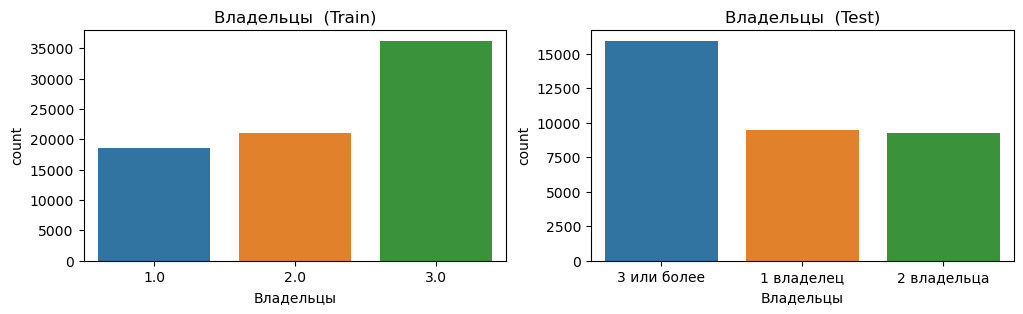

In [234]:
# Чаще всего машина новая (2020г.), поэтому в признаке "Владельцы" заполним пропуски значением 1 (наименьшее)
print(f'Кол-во пропусков в признаке "Владельцы" (train_df): {train_df.Владельцы.isna().sum()} \nКол-во пропусков в признаке "Владельцы" (test_df): {test_df.Владельцы.isna().sum()}')
print('\nБольшинство машин новые (2020г.)')
display(train_df[train_df["Владельцы"].isna()]["productionDate"].value_counts())

# Посмотрим на распределение признака "Владельцы" в тренировочном и тестовом датасетах
fig, ax = plt.subplots(1,2, figsize = (12, 3))
sns.countplot(x = 'Владельцы', data = train_df, ax = ax[0])
ax[0].set_title('Владельцы  (Train)')
sns.countplot(x = 'Владельцы', data = test_df, ax = ax[1])
ax[1].set_title('Владельцы  (Test)')
fig.show()

#### ВЫПОЛНИМ ВСЕ ОПИСАННЫЕ РАНЕЕ ДЕЙСТВИЯ:

In [235]:
print(f'Размер датасетов перед первоначальной обработкой: train_df {train_df.shape}, test_df {test_df.shape}')
print(f'Количество пропусков: train_df - {train_df.isna().sum().sum()}, test_df - {test_df.isna().sum().sum()}')

train_df.drop(["Таможня", "Состояние", "hidden"], axis = 1, inplace = True)          # Удалим столбцы, состоящие из пропусков
test_df.drop(['Таможня', 'priceCurrency', 'Состояние'], axis = 1, inplace = True)    # или одного значения
train_df.drop_duplicates(inplace = True)                                             # Удалим дубликаты
train_df = train_df[train_df['price'].notna()]                                       # Удалим пропуски в целевой переменной

train_df['Комплектация_True'] = (train_df["Комплектация"] == "{'id': '0'}").astype(int)  # Используем заполняемость как фактор
test_df["Комплектация_True"] = test_df["complectation_dict"].isna().astype(int)          # map(pd.isna) и удаляем столбцы
train_df.drop(['Комплектация'], axis = 1, inplace = True)                                    
test_df.drop(['complectation_dict'], axis = 1, inplace = True)                                     

train_df.drop(['vehicleConfiguration', 'name', 'start_date'], axis = 1, inplace = True)  # Удаляем лишние и неинформ-е столбцы                             
test_df.drop(['vehicleConfiguration', 'sell_id', 'car_url', 'image', 'super_gen', 'model_info', 
              'equipment_dict', 'name'], axis = 1, inplace = True) 

train_df["Владельцы"] = train_df["Владельцы"].fillna(1)   # Заполним пропуски в столбце "Владельцы" знаечнием 1
test_df["Владельцы"] = test_df["Владельцы"].apply(lambda x: x[0]).astype('int')  # Приведем столбцы к единому виду

print(f'Размер датасетов после первоначальной обработки: train_df {train_df.shape}, test_df {test_df.shape}')
print(f'Количество пропусков: train_df - {train_df.isna().sum().sum()}, test_df - {test_df.isna().sum().sum()}')

Размер датасетов перед первоначальной обработкой: train_df (89378, 26), test_df (34686, 32)
Количество пропусков: train_df - 256555, test_df - 60956
Размер датасетов после первоначальной обработки: train_df (86854, 20), test_df (34686, 21)
Количество пропусков: train_df - 61593, test_df - 22692


#### Посмотрим на распределение признака "Комплектация_True" (флаг - имеется ли информация о комлектации авто) в тренировочном и тестовом датасетах

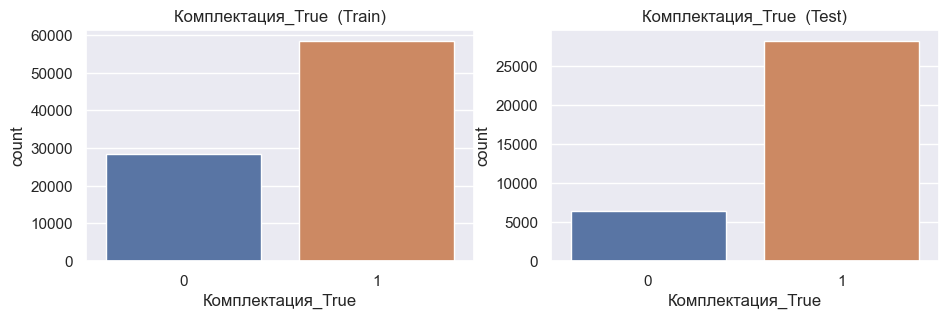

In [236]:
sns.set()
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.countplot(x = 'Комплектация_True', data = train_df, ax = ax[0])
ax[0].set_title('Комплектация_True  (Train)')
sns.countplot(x = 'Комплектация_True', data = test_df, ax = ax[1])
ax[1].set_title('Комплектация_True  (Test)')
fig.show()

#### Посмотрим на распределение признака "modelDate" (дата выхода автомобиля в продажу) в тренировочном и тестовом датасетах  
По графику видно, что распределение признака в обоих датасетах похожи.   


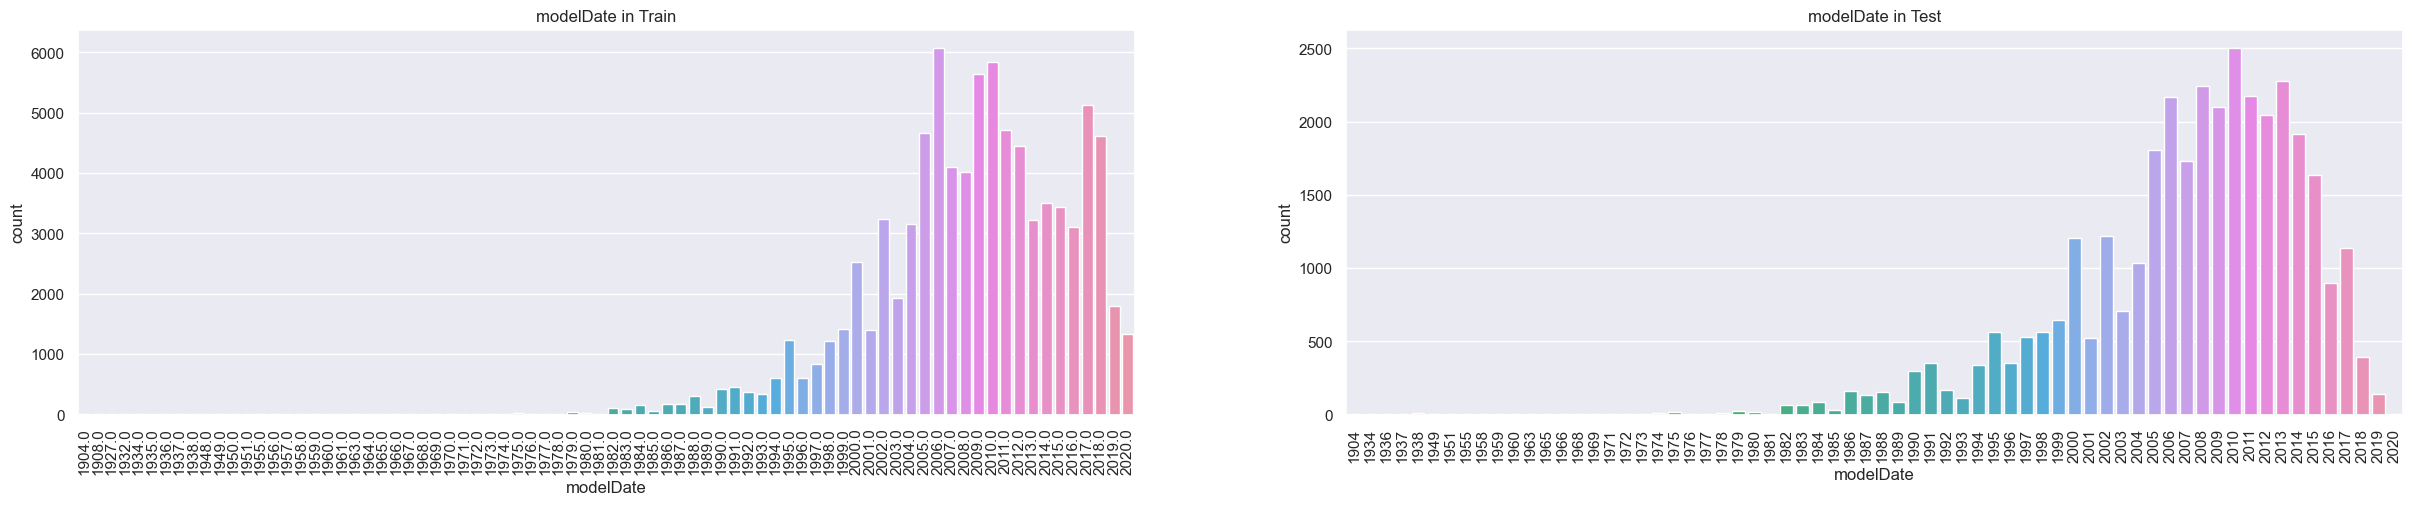

In [237]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
sns.countplot(x = 'modelDate', data = train_df, ax = ax[0])
ax[0].set_title('modelDate in Train')
ax[0].tick_params(axis = 'x', labelrotation = 90)
sns.countplot(x = 'modelDate', data = test_df, ax = ax[1])
ax[1].set_title('modelDate in Test')
ax[1].tick_params(axis = 'x', labelrotation = 90)
fig.show()

#### Посмотрим на связь этого признака с целевой переменной - ценой автомобиля  
Чем модель автомобиля новее, тем она дороже. Также присутствуют коллекционные старинные дорогие автомобили.

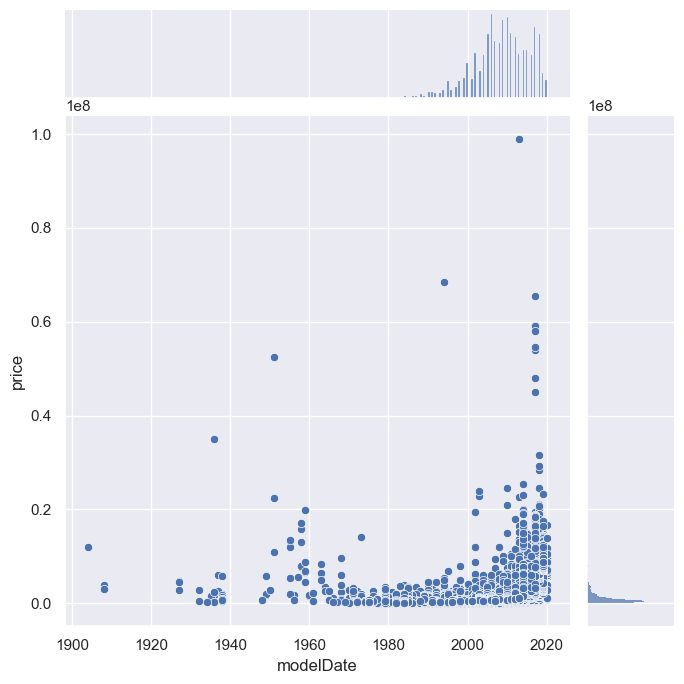

In [238]:
sns.jointplot(x = 'modelDate', y = 'price', data = train_df, kind = 'scatter', height = 7)

#### Посмотрим на распределение признака "productionDate" (дата производства автомобиля) в тренировочном и тестовом датасетах

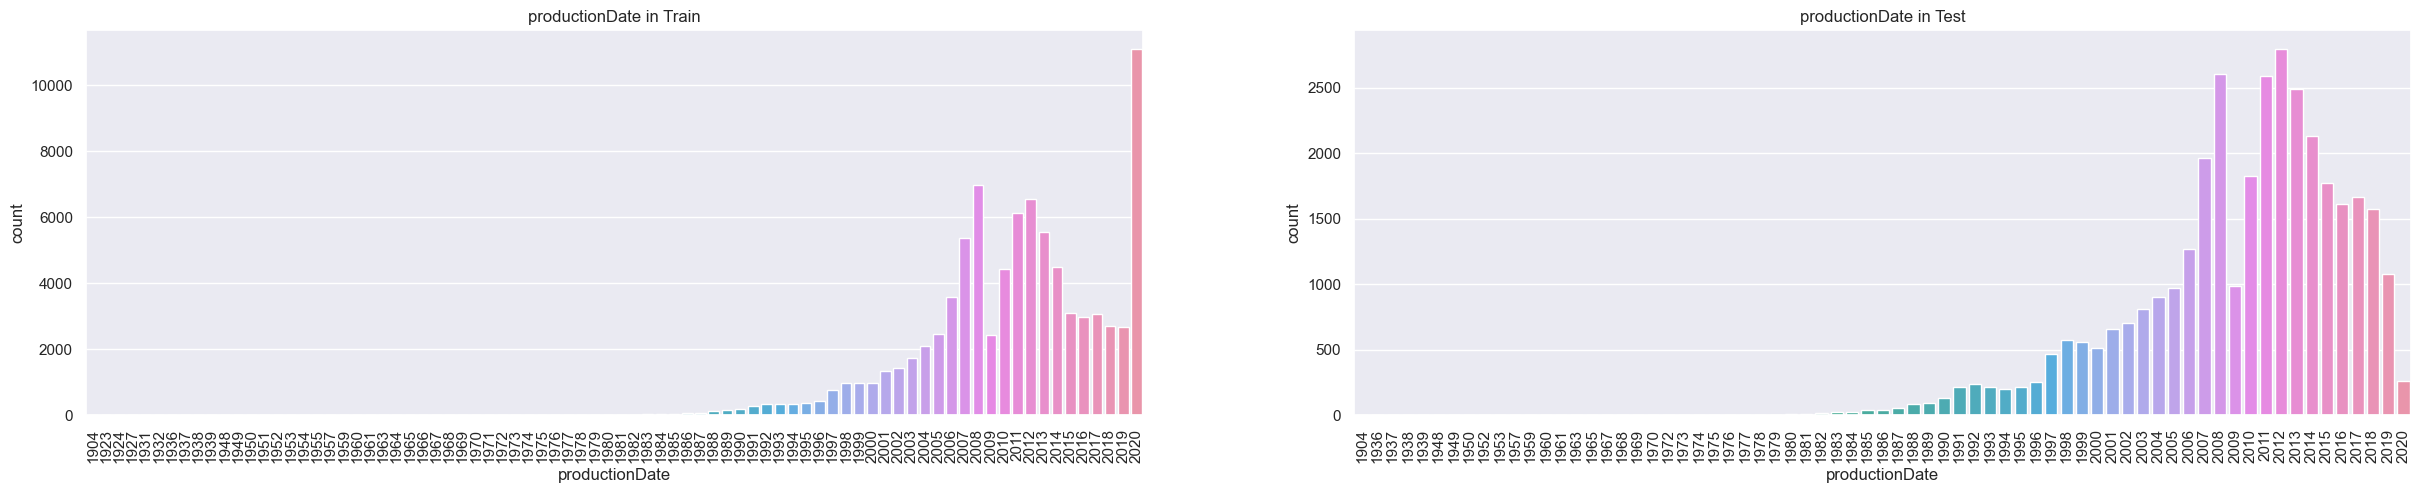

In [239]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
sns.countplot(x = 'productionDate', data = train_df, ax = ax[0])
ax[0].set_title('productionDate in Train')
ax[0].tick_params(axis = 'x', labelrotation = 90)
sns.countplot(x = 'productionDate', data = test_df, ax = ax[1])
ax[1].set_title('productionDate in Test')
ax[1].tick_params(axis = 'x', labelrotation = 90)
fig.show()

#### Используем дату и время парсинга (среднее значение) для работы с временными признаками в test_df

In [240]:
# Обозначим дату парсинга данных (2020-10-21) и вычтим из нее значения, указанные в "modelDate" и "productionDate"

parsing_date = datetime.datetime.fromtimestamp(test_df.parsing_unixtime.mean())
print(f'parsing_date: {parsing_date}')
test_df.drop("parsing_unixtime", axis = 1, inplace = True)  

train_df["Владение"] = parsing_date - pd.to_datetime(train_df["Владение"].progress_apply(lambda x: "" if (pd.isnull(x) or str(x) == 'nan') 
                             else datetime.date(eval(str(x))['year'], eval(str(x))['month'], 1)))
test_df["Владение"] = test_df["Владение"].apply(changing_date)

train_df["Владение"] = train_df["Владение"].dt.days
test_df["Владение"] = test_df["Владение"].dt.days

train_df['modelDate'] = 2020 - train_df['modelDate']
test_df['modelDate'] = 2020 - test_df['modelDate']

train_df['productionDate'] = 2020 - train_df['productionDate']
test_df['productionDate'] = 2020 - test_df['productionDate']

parsing_date: 2020-10-21 16:25:33.619356


  0%|          | 0/86854 [00:00<?, ?it/s]

#### Используем словарь для получения конкретной страны бренда (или региона)

In [241]:
display(test_df.groupby(["vendor", "brand"])["brand"].count())

# Признак "vendor" содержится только в тестовом датасете - удалим его
test_df.drop("vendor", axis = 1, inplace = True)

# Используем словарь для получения конкретной страны бренда (или региона)
countries_dict = {'Europe': ['AUDI', 'BMW', 'CITROEN', 'MERCEDES', 'OPEL','PORSCHE', 'PEUGEOT', 'RENAULT', 'SKODA', 'VOLKSWAGEN', 'VOLVO'],
                  'Japan':  ['HONDA', 'INFINITI', 'LEXUS', 'MAZDA', 'MITSUBISHI', 'NISSAN', 'SUBARU', 'SUZUKI', 'TOYOTA'],
                  'USA':    ['CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FORD', 'JEEP'],
                  'China':  ['CHERY', 'GEELY', 'GREAT_WALL'],
                  'UK':     ['JAGUAR', 'LAND_ROVER', 'MINI'],
                  'Korea':  ['DAEWOO','HYUNDAI','KIA','SSANG_YONG']}
countries_inv_dict = dict()
for key in countries_dict.keys():
    for value in countries_dict[key]:
        countries_inv_dict[value] = key
        
train_df['region_or_country'] = train_df['brand'].map(countries_inv_dict)
test_df['region_or_country'] = test_df['brand'].apply(lambda x: countries_inv_dict[x])
display(train_df[['region_or_country', 'brand']].head())
display(test_df[['region_or_country', 'brand']].head())

vendor    brand     
EUROPEAN  AUDI          3421
          BMW           4473
          MERCEDES      4180
          SKODA         2741
          VOLKSWAGEN    4404
          VOLVO         1463
JAPANESE  HONDA         1150
          INFINITI       871
          LEXUS          834
          MITSUBISHI    2843
          NISSAN        4393
          TOYOTA        3913
Name: brand, dtype: int64

region_or_country brand
0            Europe  AUDI
1            Europe  AUDI
2            Europe  AUDI
3            Europe  AUDI
4            Europe  AUDI

region_or_country  brand
0            Europe  SKODA
1            Europe  SKODA
2            Europe  SKODA
3            Europe  SKODA
4            Europe  SKODA

#### Посмотрим детальнее на значения некоторых признаков в тренировочном и тестовом датасетах

#### Признак "fuelType" - тип топлива

fuelType  (Train)  count fuelType  (Test)      count
0            бензин  73022           бензин 28,601.000
1            дизель  13421           дизель  5,800.000
2            гибрид    290           гибрид    223.000
3           электро    109          электро     55.000
4               газ     11              газ      7.000
5         универсал      1              NaN        NaN

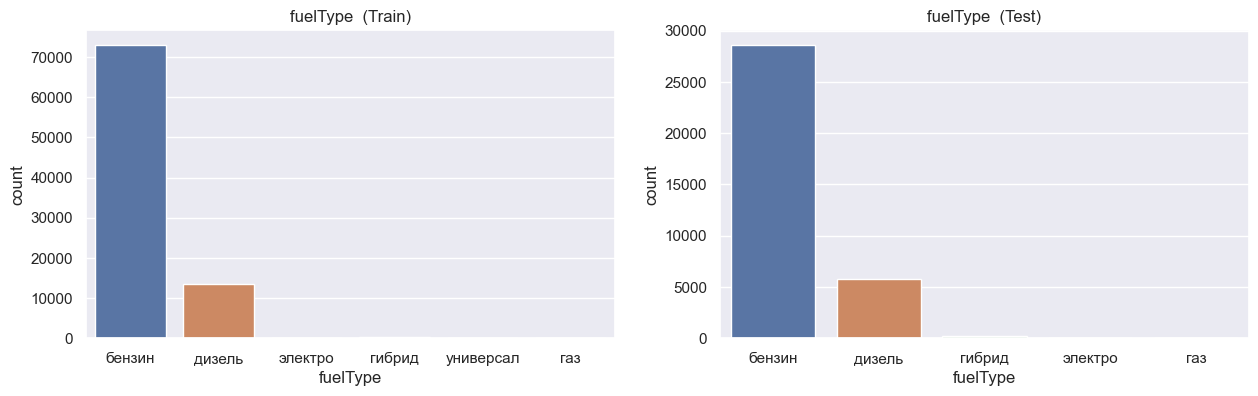

In [242]:
display(pd.concat([train_df.fuelType.value_counts().reset_index() \
           .rename(columns = {'index' : 'fuelType  (Train)', 'fuelType' : 'count'}), 
           test_df.fuelType.value_counts().reset_index() \
           .rename(columns = {'index': 'fuelType  (Test)', 'fuelType' : 'count'})], axis = 1))
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
sns.countplot(x = 'fuelType', data = train_df, ax = ax[0])
ax[0].set_title('fuelType  (Train)')
sns.countplot(x = 'fuelType', data = test_df, ax = ax[1])
ax[1].set_title('fuelType  (Test)')
fig.show()

#### Признак "vehicleTransmission" - привод автомобиля  
По графику видно, что распределение признака совпадает в обоих датасетах.   
Данные необходимо привести к единому виду.

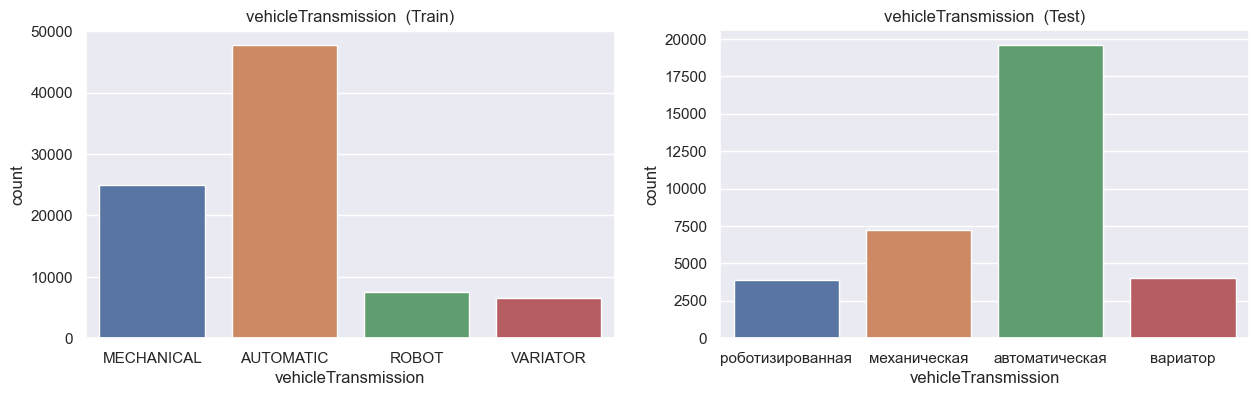

In [243]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
sns.countplot(x = 'vehicleTransmission', data = train_df, ax = ax[0])
ax[0].set_title('vehicleTransmission  (Train)')
sns.countplot(x = 'vehicleTransmission', data = test_df, ax = ax[1])
ax[1].set_title('vehicleTransmission  (Test)')
fig.show()

#### Признак "Привод"    
Посмотрим на связь этого признака с целевой переменной - ценой автомобиля.  
Судя по графику, автомобили с полным приводом дороже. Наиболее дешевые автомобили - переднеприводные.

Привод  (Train)  count Привод  (Test)  count
0        передний  46283       передний  15565
1          полный  33647         полный  15020
2          задний   6923         задний   4101

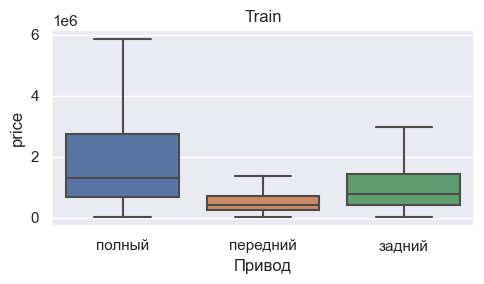

In [244]:
display(pd.concat([train_df.Привод.value_counts().reset_index() \
           .rename(columns = {'index' : 'Привод  (Train)', 'Привод' : 'count'}), 
           test_df.Привод.value_counts().reset_index() \
           .rename(columns = {'index' : 'Привод  (Test)', 'Привод' : 'count'})], axis = 1))

sns.boxplot(x = 'Привод', y = 'price', data = train_df, showfliers = False)
plt.title('Train')
plt.tight_layout()
plt.show()

#### Признак "Руль"      
Судя по графику признак "Руль" совпадает в обоих датасетах.   
Данные необходимо привести к единому виду.

Руль  (Train)  count Руль  (Test)  count
0          LEFT  85078        Левый  33287
1         RIGHT   1776       Правый   1399

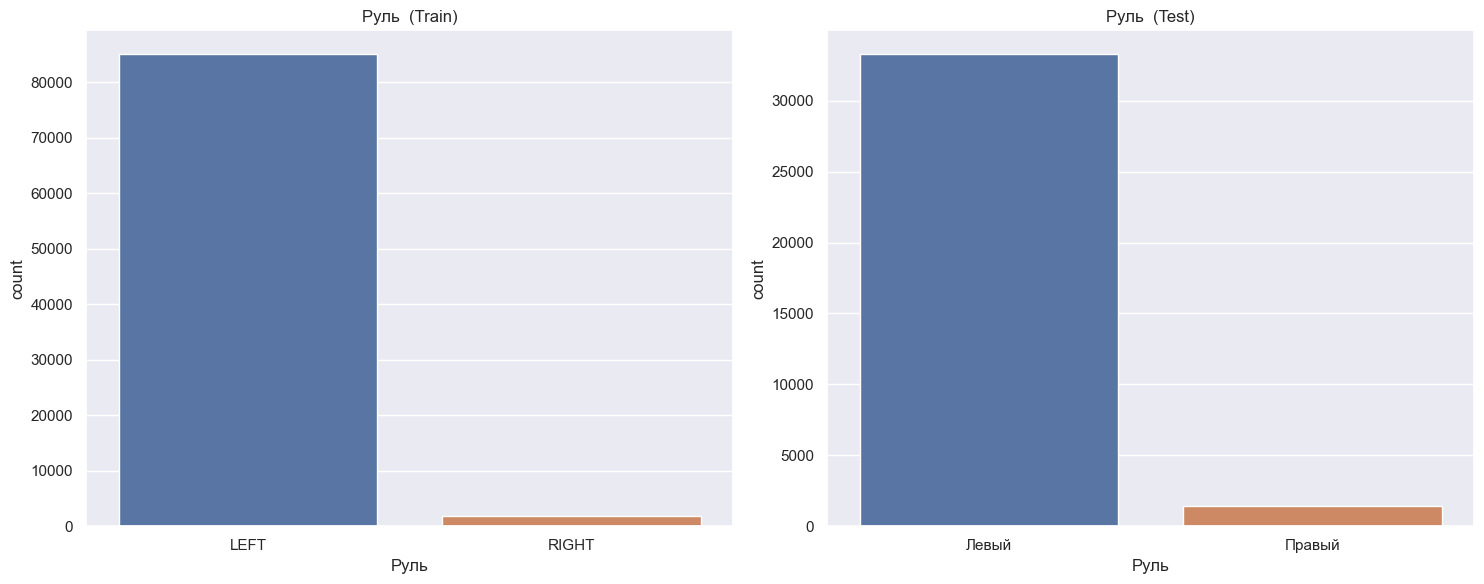

In [245]:
display(pd.concat([train_df.Руль.value_counts().reset_index() \
           .rename(columns = {'index' : 'Руль  (Train)', 'Руль' : 'count'}), 
           test_df.Руль.value_counts().reset_index() \
           .rename(columns = {'index' : 'Руль  (Test)', 'Руль' : 'count'})], axis = 1))

fig, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.countplot(x = 'Руль', data = train_df, ax = ax[0])
ax[0].set_title('Руль  (Train)')
sns.countplot(x = 'Руль', data = test_df, ax = ax[1])
ax[1].set_title('Руль  (Test)')
plt.tight_layout()
fig.show()

#### Признак "color"     
Список цветов в датасетах train и test одинаковый.   
Данные необходимо привести к единому виду.

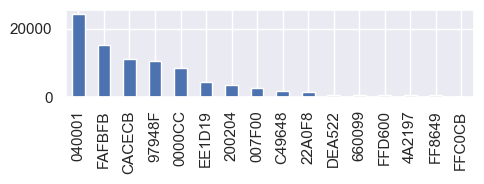

In [246]:
fig, ax = plt.subplots(figsize = (5, 2))
train_df.color.value_counts().plot(kind = 'bar')
plt.tight_layout()

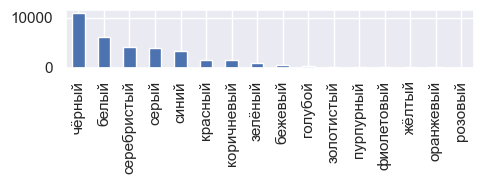

In [247]:
fig, ax = plt.subplots(figsize = (5, 2))
test_df.color.value_counts().plot(kind = 'bar')
plt.tight_layout()

#### Признак "mileage" - пробег автомобиля  
Судя по глафику, распределение смещено влево.  

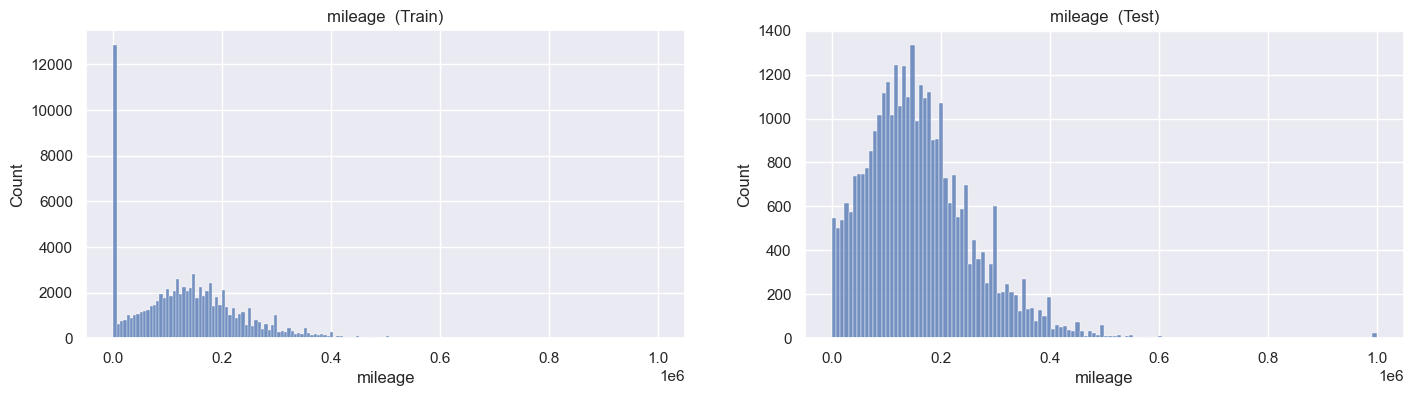

In [248]:
fig, ax = plt.subplots(1, 2, figsize = (17, 4))
sns.histplot(x = 'mileage', data = train_df, ax = ax[0])
ax[0].set_title('mileage  (Train)')
sns.histplot(x = 'mileage', data = test_df, ax = ax[1])
ax[1].set_title('mileage  (Test)')
fig.show()

#### Признак "enginePower" - мощности двигателя
Проиллюстрируем взаимосвязь мощности двигателя автомобиля и его цены

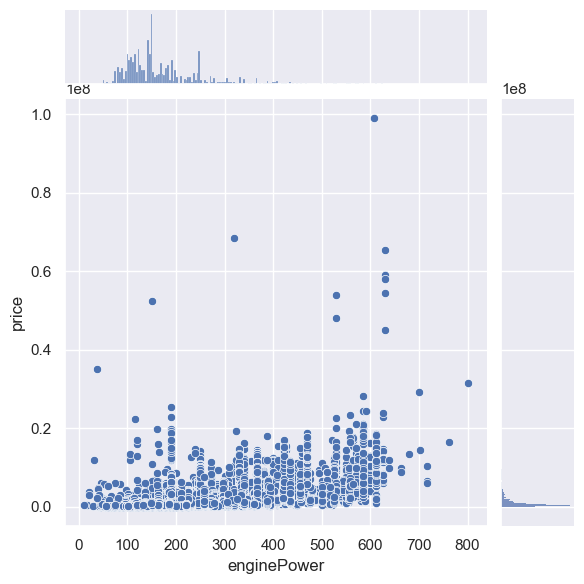

In [249]:
sns.jointplot(x = 'enginePower', y = 'price', data = train_df, kind = 'scatter')

#### Признак "numberOfDoors" - количество дверей  
Распределение признака в обоих датасетах совпадает.

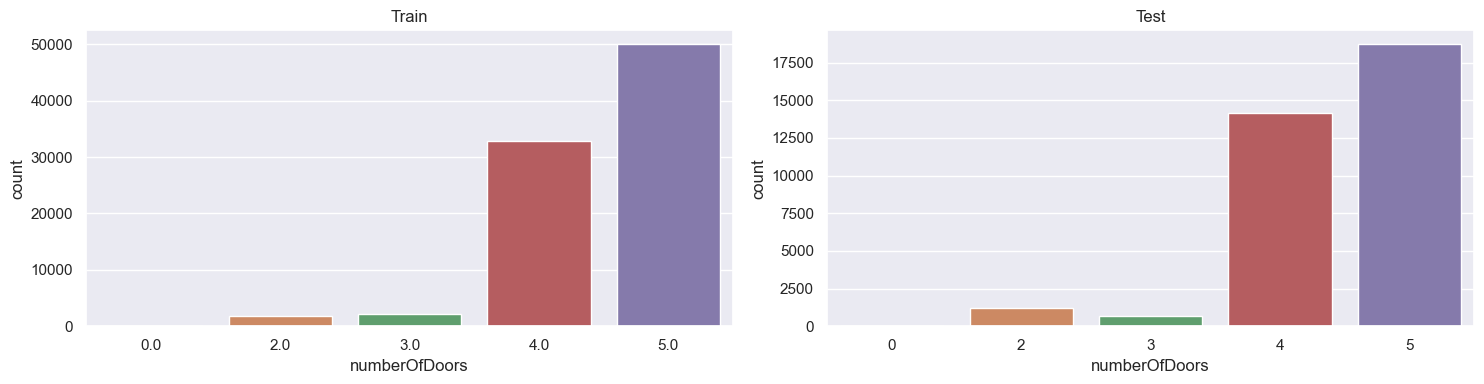

In [250]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
sns.countplot(x = 'numberOfDoors', data = train_df, ax = ax[0])
ax[0].set_title('Train')
sns.countplot(x = 'numberOfDoors', data = test_df, ax = ax[1])
ax[1].set_title('Test')
plt.tight_layout()
fig.show()

#### - Обработаем некоторые признаки при помощи словарей    
#### - Преобразуем значения некоторых признаков при помощи регулярных выражений
#### - Приведем названия признаков к единому виду в обоих датасетах

In [251]:
# Подготовим словари
transmission_dict = {"MECHANICAL": "механическая", "AUTOMATIC": "автоматическая", "ROBOT": "роботизированная", "VARIATOR": "вариатор"}
pts_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
wheel_dict = {'LEFT': 'Левый', 'RIGHT': 'Правый'}
color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB': 'серебристый', '97948F': 'серый', '0000CC': 'синий','EE1D19': 'красный', '200204': 'коричневый',
                '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

# Приведём некоторые признаки в train_df к виду в test_df. Вид кузова:   
body_set = set(test_df["bodyType"].unique())
train_df["bodyType"] = train_df["bodyType"].apply(lambda x: np.nan if pd.isnull(x) else str(str(x).lower().split()[:3]) \
                            .strip("[]'',").replace(',', '').replace("'", "") if 'дв' in x else str(x).lower().split()[0])
test_df["bodyType"] = test_df["bodyType"].apply(lambda x: np.nan if pd.isnull(x) else str(str(x).lower().split()[:3]) \
                            .strip("[]'',").replace(',', '').replace("'", "") if 'дв' in x else str(x).lower().split()[0])
train_df["bodyType_rough"] = train_df["bodyType"].apply(lambda x: str(x).lower().split()[0])
test_df["bodyType_rough"] = test_df["bodyType"].apply(lambda x: str(x).lower().split()[0])

# Трансмиссия:
train_df["vehicleTransmission"] = train_df["vehicleTransmission"].apply(lambda x: "автоматическая" if pd.isnull(x) else transmission_dict[x])

# ПТС:
train_df["ПТС"] = train_df["ПТС"].apply(lambda x: 'Оригинал' if pd.isnull(x) else pts_dict[x])

# Руль и color:
train_df["Руль"].replace(wheel_dict, inplace = True)
train_df['color'].replace(color_dict, inplace = True)

# Применим регулярные выражения для распознавания объёма двигателя 
train_df["engineDisplacement"] = train_df["engineDisplacement"].apply(get_EngineDisplacement)
test_df["engineDisplacement"] = test_df["engineDisplacement"].apply(get_EngineDisplacement)

# Приведем признак "enginePower" (мощность автомобиля) к целым значениям
train_df["enginePower"] = train_df["enginePower"].apply(lambda x: (int)(x) if not pd.isnull(x) else None)
test_df["enginePower"] = test_df["enginePower"].apply(lambda x : int(x.split(' ')[0]))

# Приведём названия некоторых признаков к единому виду в обоих датасетах
train_df.rename(columns = {'model' : 'model_name', 'Привод' : 'drive_gear', 'Руль': 'wheel', 'Владельцы': 'owners', 
                         'ПТС': 'vehicle_passport', 'Владение' : 'days_of_owning', 'Комплектация_True': 'complectation_true'},
                          inplace = True)
test_df.rename(columns = {'Привод' : 'drive_gear', 'Руль': 'wheel', 'Владельцы': 'owners', 'ПТС': 'vehicle_passport',
                        'Владение' : 'days_of_owning', 'Комплектация_True': 'complectation_true'}, inplace = True)

# Проверка наличия признаков в датасетах  
print(f'Признаки, которые содержатся в test_df, и отсутвтуют в train_df: {set(test_df.columns).difference(set(train_df.columns))}')
print(f'Признаки, которые содержатся в train_df, и отсутвтуют в test_df: {set(train_df.columns).difference(set(test_df.columns))}')  # --> целевая переменная 'price'

Признаки, которые содержатся в test_df, и отсутвтуют в train_df: set()
Признаки, которые содержатся в train_df, и отсутвтуют в test_df: {'price'}


#### Создадим новые признаки по пробегу:  "mileage_by_owner" и "mileage_per_year"

In [252]:
train_df["mileage_by_owner"] = train_df["mileage"] / train_df["owners"]
test_df["mileage_by_owner"] = test_df["mileage"] / test_df["owners"]
train_df["mileage_per_year"] = train_df["mileage"] / train_df["modelDate"]
test_df["mileage_per_year"] = test_df["mileage"] / test_df["modelDate"]

print(f'Размер датасетов: train_df {train_df.shape}, test_df {test_df.shape}')
print(f'Количество пропусков: train_df - {train_df.isna().sum().sum()}, test_df - {test_df.isna().sum().sum()}')
display(train_df.head(2))
display(test_df.head(2))

Размер датасетов: train_df (86854, 24), test_df (34686, 23)
Количество пропусков: train_df - 82854, test_df - 22747


bodyType brand    color fuelType  modelDate  numberOfDoors  productionDate  \
0    седан  AUDI   чёрный   бензин     30.000          4.000              29   
1    седан  AUDI  красный   бензин     38.000          4.000              34   

  vehicleTransmission  engineDisplacement  enginePower  \
0        механическая               2.800      174.000   
1        механическая               1.800       90.000   

                                                   description  mileage  \
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...   350000   
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...   173424   

  drive_gear  wheel  owners vehicle_passport  days_of_owning       price  \
0     полный  Левый   3.000         Оригинал             NaN 200,000.000   
1   передний  Левый   3.000         Оригинал             NaN  60,000.000   

  model_name  complectation_true region_or_country bodyType_rough  \
0        100                   1            Europe          седан   
1        100                   1            Europe          седан   

   mileage_by_owner  mileage_per_year  
0       116,666.667        11,666.667  
1        57,808.000         4,563.789

bodyType  brand   color  \
0  лифтбек  SKODA   синий   
1  лифтбек  SKODA  чёрный   

                                                   description  \
0  Все автомобили, представленные в продаже, проходят тщате...   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомобиль прошел...   

   engineDisplacement  enginePower fuelType  mileage  modelDate model_name  \
0               1.200          105   бензин    74000          7    OCTAVIA   
1               1.600          110   бензин    60563          3    OCTAVIA   

   numberOfDoors  productionDate vehicleTransmission  owners  days_of_owning  \
0              5               6    роботизированная       3             NaN   
1              5               3        механическая       1             NaN   

  vehicle_passport drive_gear  wheel  complectation_true region_or_country  \
0         Оригинал   передний  Левый                   1            Europe   
1         Оригинал   передний  Левый                   1            Europe   

  bodyType_rough  mileage_by_owner  mileage_per_year  
0        лифтбек        24,666.667        10,571.429  
1        лифтбек        60,563.000        20,187.667

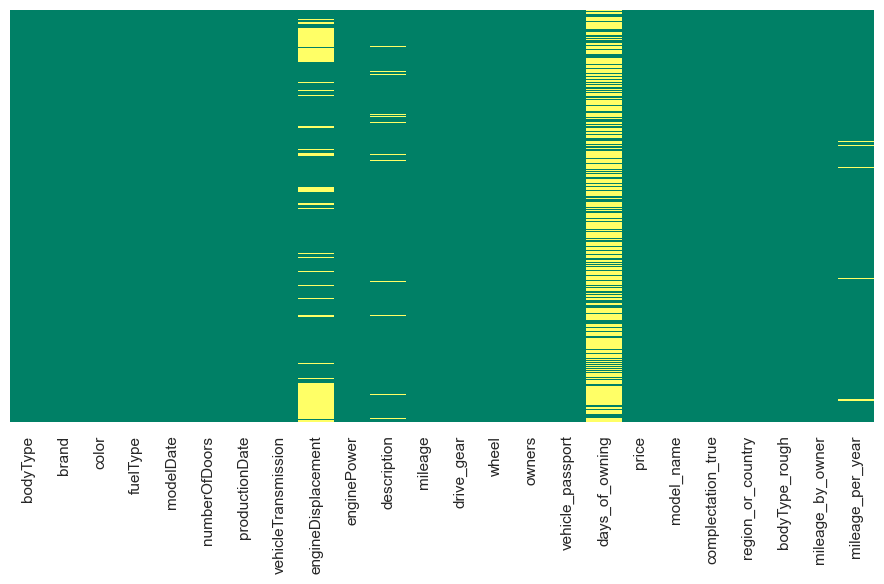

In [253]:
# Оценим визуально количество пропусков и их распределение в train_df
fig, ax = plt.subplots(figsize = (9, 6))   
sns_heatmap = sns.heatmap(train_df.isnull(), yticklabels = False, cbar = False, cmap = 'summer')
plt.tight_layout()

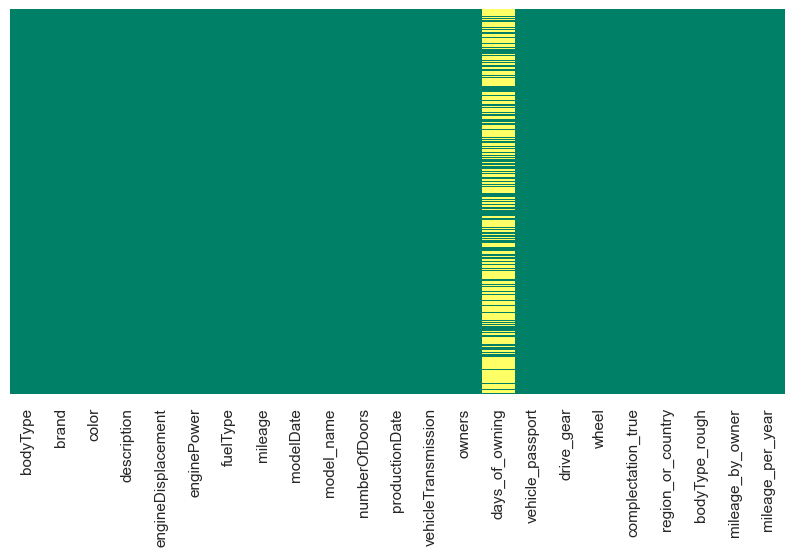

In [254]:
# Оценим визуально количество пропусков и их распределение в test_df
fig, ax = plt.subplots(figsize = (10, 5))   
sns_heatmap = sns.heatmap(test_df.isnull(), yticklabels = False, cbar = False, cmap = 'summer')

## 4.3. Корреляционный анализ переменных

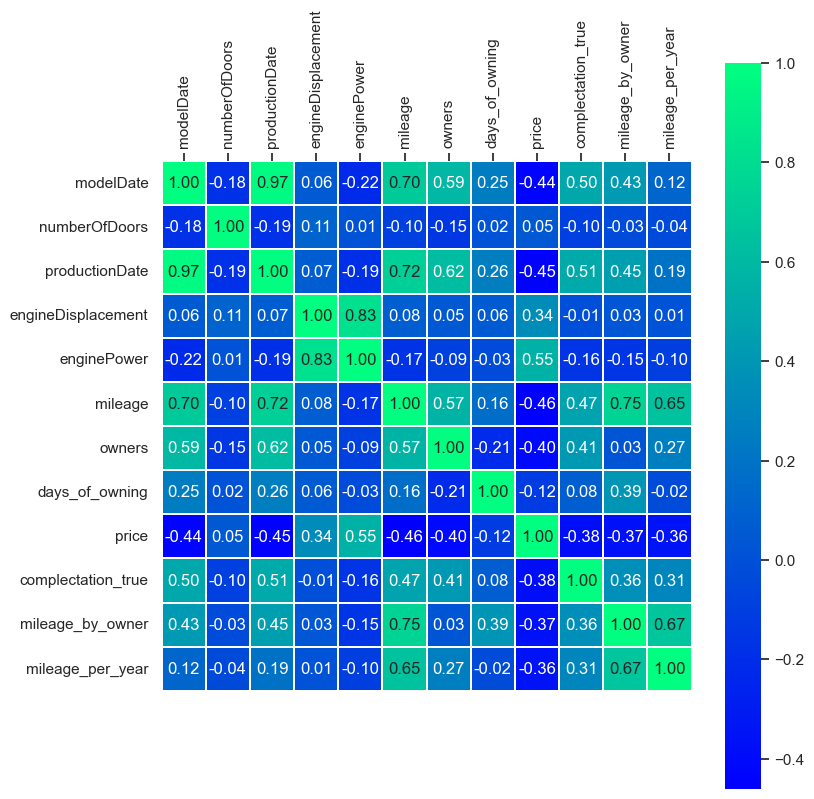

In [255]:
plt.rcParams['figure.figsize'] = (8.5, 8.5)
ax = sns.heatmap(train_df.corr(), square = True, annot = True, fmt = ".2f", linewidths = 0.1, cmap = "winter")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(rotation = 90)
plt.tight_layout()

In [256]:
display(train_df.corr().applymap(lambda x: x if x > 0.7 else ''))
corr = round(train_df.corr(), 2)

corr['price'].abs().sort_values(ascending = False)

modelDate numberOfDoors productionDate engineDisplacement  \
modelDate              1.000                        0.969                      
numberOfDoors                        1.000                                     
productionDate         0.969                        1.000                      
engineDisplacement                                                     1.000   
enginePower                                                            0.826   
mileage                                             0.725                      
owners                                                                         
days_of_owning                                                                 
price                                                                          
complectation_true                                                             
mileage_by_owner                                                               
mileage_per_year                                                               

                   enginePower mileage owners days_of_owning price  \
modelDate                                                            
numberOfDoors                                                        
productionDate                   0.725                               
engineDisplacement       0.826                                       
enginePower              1.000                                       
mileage                          1.000                               
owners                                  1.000                        
days_of_owning                                         1.000         
price                                                        1.000   
complectation_true                                                   
mileage_by_owner                 0.750                               
mileage_per_year                                                     

                   complectation_true mileage_by_owner mileage_per_year  
modelDate                                                                
numberOfDoors                                                            
productionDate                                                           
engineDisplacement                                                       
enginePower                                                              
mileage                                          0.750                   
owners                                                                   
days_of_owning                                                           
price                                                                    
complectation_true              1.000                                    
mileage_by_owner                                 1.000                   
mileage_per_year                                                  1.000

price                1.000
enginePower          0.550
mileage              0.460
productionDate       0.450
modelDate            0.440
owners               0.400
complectation_true   0.380
mileage_by_owner     0.370
mileage_per_year     0.360
engineDisplacement   0.340
days_of_owning       0.120
numberOfDoors        0.050
Name: price, dtype: float64

#### Создание pickle перед работой с description и объединение датсетов для дальнейшей обработки

In [257]:
train_df['sample'] = 1    # Помечаем трейн
test_df['sample'] = 0     # Помечаем тест
data = train_df.append(test_df, sort = False).reset_index(drop = True) # Объединяем датасеты
display(f'Размер объединенного датасета: {data.shape}')  # (121540, 25)

data.to_pickle("data.pickle")

'Размер объединенного датасета: (121540, 25)'

# 4. Предобработка и создание новых признаков (feature engineering)

**4.1. Анализ тональности лексических единиц (NLP). Извлечение признаков из текста на основе имеющихся**    
**4.3. Кластеризация после лемматизации и стемматизации. Оценка важности слов в контексте документа (TF-IDF)**  
**4.5. Доочистка данных, преобразование категориальных и числовых переменных, квантилизация**

## 4.1. Анализ тональности лексических единиц (NLP). Извлечение признаков из текста   
- Очистка признака "description" при помощи регулярных выражений и создание нового признака "dealer" (объявление от дилера)
- Анализ тональности текста при помощи NLTK - VADER  (positive \ neutral \ negative words)  

In [258]:
data = pd.read_pickle("data.pickle")

In [259]:
data[["description"]]

description
0        Машина  в приличном состоянии ,не гнилая не ржавая .По ...
1       Машина в оригинале не гнилая все вопросы по телефону. Пт...
2       ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...
3                                                               NaN
4       Машина не гнилая, дыр нет, днище целое, даже в родной кр...
...                                                             ...
121535  Продается BMW 316i в отличном состоянии. Продается от 3-...
121536                               Продаётся отличный автомобиль.
121537                                            Хорошее состояние
121538  Автомобиль в идеальном состоянии . Куплен новым у официа...
121539   Пробег реальный, состояние отличное! Авторская, очень д...

[121540 rows x 1 columns]

In [260]:
# Преобразуем признак description с помощью регулярных выражений, убрав лишние символы    
data["description_rough"] = data["description"].apply(lambda x: str.join(" ", re.findall(r"\w+", re.sub("[^\D]", " ", str(x))))\
                                                      .lower()).replace(r'[\s_]+', ' ', regex = True)

# Создадим достаточно точный признак, который свидетельствует, что объявление от дилера 
data["dealer"] = data["description_rough"].apply(lambda x:  any(["компани" in str(x), "услов" in str(x), "выгод" in str(x), 
                                                 " центр " in str(x), "обраща" in str(x), "взнос" in str(x)])).astype(int)

# Удалим из признака description_rough стоп-слова
StopWords = set(stopwords.words("russian"))
StopWords.remove('не')     # Оставим слова "не" и "нет"
StopWords.remove('нет')
data['description_rough'] = data['description_rough'].apply(lambda x: ' '.join([word for word in x.split() if word not in (StopWords) and len(word) != 1]))

# Проведем стемминг с помощью библиотеки pymorphy2
morph = pymorphy2.MorphAnalyzer()
data['description_rough'] = data['description_rough'] \
                            .progress_apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))

# Посмотрим на результаты обработки
data[['description', 'description_rough', 'dealer']].head()

  0%|          | 0/121540 [00:00<?, ?it/s]

description  \
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...   
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...   
3                                                          NaN   
4  Машина не гнилая, дыр нет, днище целое, даже в родной кр...   

                                             description_rough  dealer  
0  машина приличный состояние не гнилой не ржавый менина эт...       0  
1  машина оригинал не гнилой вопрос телефон птс оригинал дв...       0  
2  птс оригинал полный комплект ключ результат комплексный ...       1  
3                                                          nan       0  
4  машина не гнилой дыра нет днище целое родный краска заво...       0

### Анализ тональности текста (NLTK)

**NLTK (Natural Language Toolkit)** - библиотека, которая предоставляет множество инструментов и техник для анализа естественного языка (NLP).  

**VADER (Valence Aware Dictionary for Sentiment Reasoning)** - предварительно подготовленный лексикон и инструмент анализа настроений, который чувствителен как к полярности (положительная / отрицательная), так и к интенсивности (силе) эмоций. VADER может применяться к неразмеченным текстам. Доступен в пакете NLTK.  

<a href="https://www.nltk.org/ ">Документация NLTK</a>

In [261]:
analyser = SentimentIntensityAnalyzer()

data['sentiment_score_dict'] = data['description_rough'][data['description_rough'] != 'nan'] \
                                        .apply(lambda description : analyser.polarity_scores(description))

data['compound_sentiment_score']  = data[data['description_rough'] != 'nan'] \
                                        .sentiment_score_dict.apply(lambda score_dict: score_dict['compound'])

data['positive_score'] = data[data['description_rough'] != 'nan']  \
                                        .sentiment_score_dict.apply(lambda score_dict: score_dict['pos'])
data['negative_score'] = data[data['description_rough'] != 'nan']  \
                                        .sentiment_score_dict.apply(lambda score_dict: score_dict['neg'])
data['neutral_score'] = data[data['description_rough'] != 'nan']  \
                                        .sentiment_score_dict.apply(lambda score_dict: score_dict['neu'])

print(f'Средняя позитивная оценка тональности описания автомобиля от автодилеров: {data[data["dealer"] == 1]["positive_score"].mean():.04f}')
print(f'Средняя позитивная оценка тональности описания автомобиля от собственников: {data[data["dealer"] == 0]["positive_score"].mean():.04f}')

print(f'Средняя смешанная оценка тональности описания автомобиля от автодилеров: {data[data["dealer"] == 1]["compound_sentiment_score"].mean():.04f}')
print(f'Средняя смешанная оценка тональности описания автомобиля от собственников: {data[data["dealer"] == 0]["compound_sentiment_score"].mean():.04f}')

Средняя позитивная оценка тональности описания автомобиля от автодилеров: 0.0049
Средняя позитивная оценка тональности описания автомобиля от собственников: 0.0018
Средняя смешанная оценка тональности описания автомобиля от автодилеров: 0.1205
Средняя смешанная оценка тональности описания автомобиля от собственников: 0.0258


## 4.2. Кластеризация. Оценка важности слов в контексте документа (TF-IDF) 
- Подготовка данных к кластеризации: векторизация и снижение размерности (t-SNE и PCA)  
- Кластеризация и создание признака **"description_cluster"**    
- Оценка важности слов в контексте документа (TF-IDF) и создание признака **"description_score"**

In [262]:
%%time 

# Подготовим данные и обучим модель векторайзера. Получим вектор признаков для каждого слова
descr = data["description_rough"].str.split().tolist()
model = Word2Vec(descr, min_count = 20, vector_size = 50)

# Получим средний эмбеддинг по словам (наивный подход к формированию единого эмбеддинга для документа)
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для документов
X = []
for doc in tqdm(descr):
    X.append(doc_vectorizer(doc, model))

  0%|          | 0/121540 [00:00<?, ?it/s]

Wall time: 1min 21s


In [263]:
# Посмотрим как выглядят первые три документа после векторизации 
X[:3]

[array([-1.8100944 , -1.1708308 ,  1.5109714 , -0.89987785,  0.6877967 ,
        -0.44296622, -2.0219786 ,  0.62475085, -0.13217519,  0.3848258 ,
        -0.05502136,  0.7425973 , -0.09444676,  0.7788977 ,  1.4791623 ,
         1.0107089 , -0.01482556, -0.55237603,  1.1915157 , -0.66990715,
         0.403214  , -0.5744582 ,  0.21460384,  0.16776119, -0.15999432,
         2.4161723 ,  0.96604425,  1.8522334 , -0.24959141,  0.9438259 ,
        -0.8258818 , -0.8620207 ,  0.16934425, -1.2950797 ,  2.3661819 ,
         0.15027545,  0.15999243,  0.6695664 ,  1.0029496 ,  0.1351511 ,
        -0.31848088, -1.7552415 ,  0.3236782 , -0.4591222 ,  0.6718879 ,
         0.5804421 ,  0.9221848 , -0.987668  ,  0.5438923 , -0.8289555 ],
       dtype=float32),
 array([-2.881108  , -0.8947555 ,  0.91888386, -1.1699885 ,  2.1334884 ,
        -2.4421446 , -2.4345977 ,  1.4185684 , -1.6388432 ,  0.52036506,
         1.4541812 ,  1.0314186 ,  0.08601635,  0.7550949 ,  2.140149  ,
        -0.05856035, -0.380

In [264]:
# Создадим "description_vectorized"
data["description_vectorized"] = X
data["description_vectorized"] = data["description_vectorized"].progress_apply(lambda x: None if x.shape == (0,) else x)
display(data["description_vectorized"].shape)

X_ = np.asarray((data["description_vectorized"][~data["description_vectorized"].isnull()].values).tolist())
X_.shape  # (121442, 50)

  0%|          | 0/121540 [00:00<?, ?it/s]

(121540,)

(121442, 50)

#### Метод снижениея размерности  t-SNE  
Этот метод довольно медленный (30min), лучше использовать альтернативные методы, например, PCA  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">Документация TSNE</a>  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">Документация PCA</a>

In [265]:
%%time

# Используем метод t-SNE для понижения размерности
tsne = TSNE(n_components = 2, random_state = 0)  # Создаем объект

# Преобразуем данные, понизив размерность с 50 до 2
X_ = tsne.fit_transform(X_)
print(X_.shape)  # (121442, 2)

(121442, 2)
Wall time: 30min 6s


Размерность снизилась с 50 до 2.   
#### Метод главных компонент (PCA) работает гораздо быстрее, лучше использовать его! (303 ms)

In [271]:
X_ = np.asarray((data["description_vectorized"][~data["description_vectorized"].isnull()].values).tolist())

In [272]:
%%time

# Используем PCA для понижения размерности
pca = PCA(n_components = 2)
X_ = pca.fit_transform(X_)
print(X_.shape)  # (121442, 2)

(121442, 2)
Wall time: 303 ms


### Кластеризация
Проведем кластеризацию и создадим признак **"description_cluster"**

In [273]:
kmeans = KMeans(n_clusters = 3)                                # Создадим объект 
kmeans.fit(X_)                                                 # Обучим кластеризатор
y_pred = kmeans.labels_.astype(int)                            # Получим предсказанные кластеры 

print(f'Координаты центроидов:\n {kmeans.cluster_centers_}')   # Выведем координаты их центроидов и посмотрим на качество
print(f"Коэффициент силуэта: {metrics.silhouette_score(X_, y_pred, metric = 'euclidean'):.03f}")   

Координаты центроидов:
 [[-2.1909761  -1.1984984 ]
 [-0.6287488   7.0111485 ]
 [ 7.1171985  -0.09036553]]
Коэффициент силуэта: 0.578


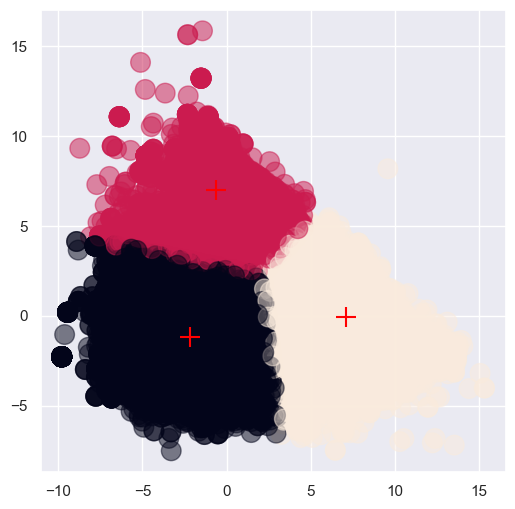

In [274]:
# Изобразим полученные кластеры
plt.rcParams['figure.figsize'] = 6, 6
plt.scatter(X_[:, 0], X_[:, 1], c = y_pred, s = 200, alpha = .5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'red', s = 200, marker = '+')
plt.show()

In [275]:
# Создадим столбец description_cluster с результатами кластеризации и запишем pickle
data.loc[~data['description_vectorized'].isnull(), 'description_cluster'] = y_pred
data.to_pickle("data_2.pickle")

### Оценка важности слов в контексте документа (TF-IDF) 
Проведем обработку TF-IDF и создадим признак **"description_score"**  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html">Документация по TfidfVectorizer</a>

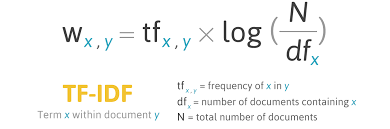

In [277]:
data = pd.read_pickle("data_2.pickle")

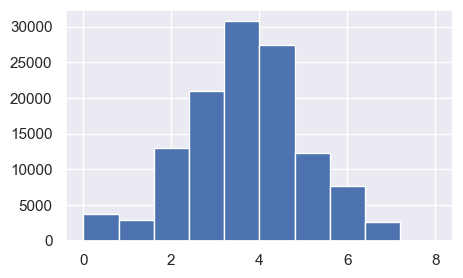

In [278]:
data["description_len"] = data["description_rough"].apply(lambda x: len(x.split()))
data["description_len_log"] = np.log(data["description_len"] + 1)

plt.rcParams['figure.figsize'] = 5, 3
data["description_len_log"].hist()
plt.show()

<AxesSubplot:xlabel='description_len', ylabel='price'>

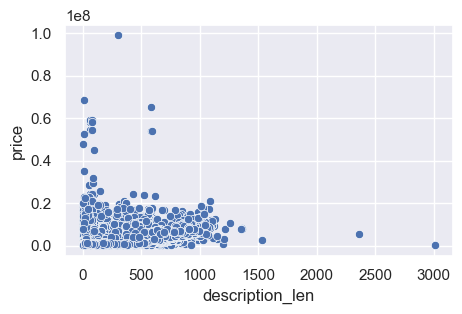

In [279]:
sns.scatterplot(data = data, x = "description_len", y = "price")

In [280]:
%%time

# Создадим объект TfidfVectorizer
tfidf = TfidfVectorizer()
result = tfidf.fit_transform(data["description_rough"][data["description_rough"] != 'nan'].values.tolist())

# Посмотрим первые 10 слов в качестве примера
words = tfidf.get_feature_names_out()
for col in result.nonzero()[1][:10]:
    print (words[col], ' - ', result[0, col])

салон  -  0.06820964122642233
кожаный  -  0.11613944680304944
стеклоподъёмник  -  0.15651760301450648
кватро  -  0.35822645663369534
полный  -  0.10041746101529196
привод  -  0.14053595838286928
двигатель  -  0.09042523247790299
выпуск  -  0.14945212221898657
год  -  0.07537858845134209
чёрный  -  0.11690773756969296
Wall time: 11.9 s


In [281]:
print(f'Размер получившейся разреженной матрицы: {result.shape}')
data.loc[data["description_rough"] != 'nan', 'tf_idf_scores'] = np.array(result.sum(axis = 1)).reshape((result.shape[0]))
data["tf_idf_scores_log"] = np.log(data["tf_idf_scores"] + 1)

Размер получившейся разреженной матрицы: (118327, 62933)


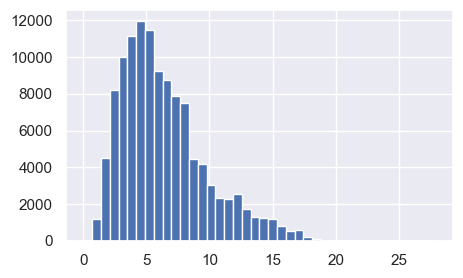

In [282]:
data["tf_idf_scores"].hist(bins = 40)
plt.show()

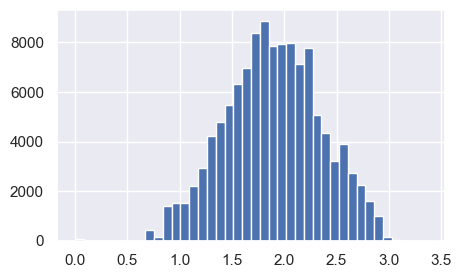

In [283]:
data["tf_idf_scores_log"].hist(bins = 40)
plt.show()

count   118,327.000
mean          6.355
std           3.395
min           0.000
25%           3.852
50%           5.629
75%           8.128
max          27.916
Name: tf_idf_scores, dtype: float64

<AxesSubplot:xlabel='tf_idf_scores', ylabel='price'>

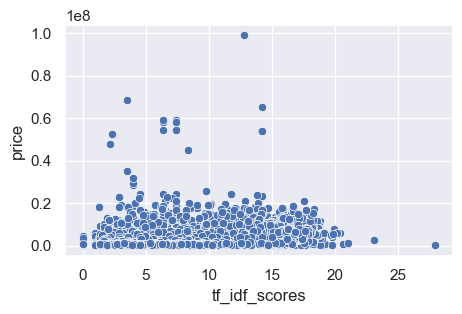

In [284]:
display(data.tf_idf_scores.describe())
sns.scatterplot(data = data, x = "tf_idf_scores", y = "price")

In [285]:
data.to_pickle("data_3.pickle")

## 4.3. Доочистка данных, преобразование катег. и числ. переменных, квантилизация

- Заполнение пропусков в некоторых переменных    
- Ранжирование признаков по их типу: категориал. и числовые  
- Квантилизация стоимости автомобиля по марке и модели  
- Логарифмирование целевой переменной
- Преобразование категор-х переменных (LabelEncoding)   
- Корреляционный анализ  

In [53]:
data = pd.read_pickle("data_3.pickle")

In [42]:
data.head(3)

bodyType brand    color fuelType  modelDate  numberOfDoors  \
0            седан  AUDI   чёрный   бензин     30.000          4.000   
1            седан  AUDI  красный   бензин     38.000          4.000   
2  универсал 5 дв.  AUDI    синий   бензин     32.000          5.000   

   productionDate vehicleTransmission  engineDisplacement  enginePower  \
0              29        механическая               2.800      174.000   
1              34        механическая               1.800       90.000   
2              31        механическая               2.300      136.000   

                                                   description  mileage  \
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...   350000   
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...   173424   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...   230000   

  drive_gear  wheel  owners vehicle_passport  days_of_owning       price  \
0     полный  Левый   3.000         Оригинал             NaN 200,000.000   
1   передний  Левый   3.000         Оригинал             NaN  60,000.000   
2     полный  Левый   3.000         Оригинал             NaN  99,000.000   

  model_name  complectation_true region_or_country bodyType_rough  \
0        100                   1            Europe          седан   
1        100                   1            Europe          седан   
2        100                   1            Europe      универсал   

   mileage_by_owner  mileage_per_year  sample  \
0       116,666.667        11,666.667       1   
1        57,808.000         4,563.789       1   
2        76,666.667         7,187.500       1   

                                             description_rough  dealer  \
0  машина приличный состояние не гнилой не ржавый менина эт...       0   
1  машина оригинал не гнилой вопрос телефон птс оригинал дв...       0   
2  птс оригинал полный комплект ключ результат комплексный ...       1   

                                    sentiment_score_dict  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}   
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                     0.000           0.000           0.000          1.000   
1                     0.000           0.000           0.000          1.000   
2                     0.000           0.000           0.000          1.000   

                                        description_vectorized  \
0  [-1.8100944, -1.1708308, 1.5109714, -0.89987785, 0.68779...   
1  [-2.881108, -0.8947555, 0.91888386, -1.1699885, 2.133488...   
2  [-0.057010725, -0.797226, 0.5758424, 0.019815957, -1.040...   

   description_cluster  description_len  description_len_log  tf_idf_scores  \
0                0.000               27                3.332          4.371   
1                0.000               15                2.773          3.218   
2                1.000              108                4.691          8.237   

   tf_idf_scores_log  
0              1.681  
1              1.439  
2              2.223

Количество пропусков в датасете: 
description_rough:           3213
bodyType                        1
modelDate                       1
numberOfDoors                   1
engineDisplacement          20352
enginePower                     1
description                  3213
drive_gear                      1
vehicle_passport                1
days_of_owning              80707
price                       34686
mileage_per_year             1323
compound_sentiment_score     3213
positive_score               3213
negative_score               3213
neutral_score                3213
description_cluster            98
tf_idf_scores                3213
tf_idf_scores_log            3213
dtype: int64


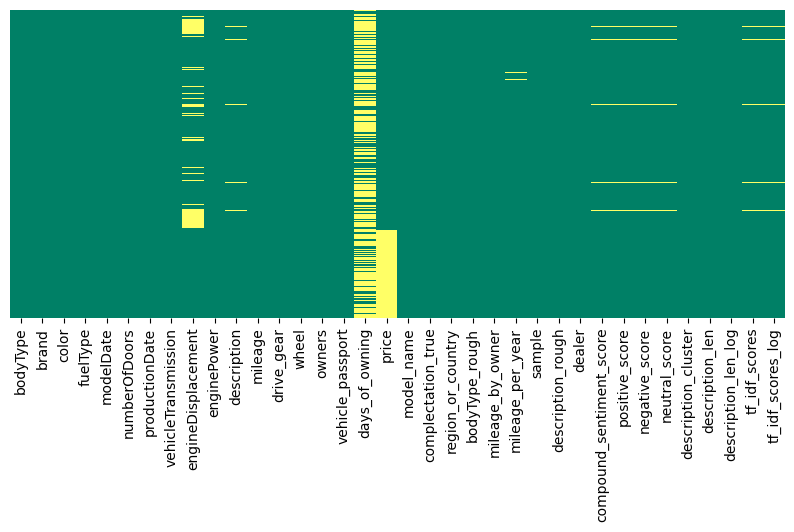

In [43]:
# Удалим некоторые лишние признаки
data.drop(['sentiment_score_dict', 'description_vectorized'], axis = 1, inplace = True)

# Оценим визуально количество пропусков и их распределение в объединенном датасете
fig, ax = plt.subplots(figsize = (10, 4))   
sns_heatmap = sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'summer')  

print(f'Количество пропусков в датасете: \ndescription_rough:           {data[data.description_rough == "nan"].description_rough.count()}')
print(f'{data.isna().sum()[data.isna().sum() > 0]}')

In [44]:
# Заполним пропуски в некоторых столбцах 
data.engineDisplacement.fillna(1.3, inplace = True)
data.bodyType.fillna(data.bodyType.value_counts().sort_values(ascending = False).index[0], inplace = True)

colls_with_na = ['compound_sentiment_score', 'positive_score', 'negative_score', 
                 'neutral_score', 'tf_idf_scores', 'tf_idf_scores_log']

for col in colls_with_na:       
    data[col] = filling_na(col)  # Заполненеие средним значением
    
# Выведем заполняемость "description_rough" как отдельный признак 
data['description_rough_NaN'] = (data.description_rough =='nan').astype('uint8')
    
# Удалим признаки: "days_of_owning" т.к. в нем довольно много пропусков 
# и "description_rough" (очищенный description) т.к. он в дальнейшем не понадобится
data.drop(["days_of_owning", "description_rough"], axis = 1, inplace = True)

# Посмотрим на оставшиеся признаки
data.isna().sum()[data.isna().sum() > 0]  

modelDate                  1
numberOfDoors              1
enginePower                1
description             3213
drive_gear                 1
vehicle_passport           1
price                  34686
mileage_per_year        1323
description_cluster       98
dtype: int64

- data - объединенный датасет (train + test), поэтому целевая переменная "price" заполнена только в тренировочной части.    
- Остальные признаки заполним для обучения определенных моделей, для бустингов оставим пропуски как есть.

In [45]:
# Разделение признаков по их типу: категориальные и числовые 
categorial_list = data.dtypes[data.dtypes == "object"].index.tolist()
categorial_list.append('description_cluster')
categorial_list.append('numberOfDoors')
categorial_list.remove('description')

numerical_list = data.dtypes[data.dtypes != "object"].index.tolist()
numerical_list.remove('numberOfDoors')
numerical_list.remove('price')
numerical_list.remove('sample')
numerical_list.remove('description_cluster')

print(f'categorial_list: \n{categorial_list}\n')
print(f'numerical_list: \n{numerical_list}') 


# Квантилизация стоимости автомобиля по марке и модели
data = quantile_groups(data, features = ["brand", "model_name"], func = np.median, 
                             column = "price", log = True, multiplier = 1)
numerical_list.append("price_cut")
print(f'\nЗначения признака "price_cut" после квантилизации "price": \n{data.price_cut.value_counts()}')


# Логарифмирование целевой переменной. Улучшает устойчивость алгоритмов к выбросам
data["price"] = np.log(data["price"])
print(f'\nПервые 10 значений переменной "price" после логарифмирования: \n{data["price"].value_counts().iloc[:10]}')


# Словарь для кодировщиков
encoders_dict = dict()

# Преобразование категориальных переменных 
for col in categorial_list:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])
    encoders_dict[col] = label_encoder

data[categorial_list].head(3)

categorial_list: 
['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'drive_gear', 'wheel', 'vehicle_passport', 'model_name', 'region_or_country', 'bodyType_rough', 'description_cluster', 'numberOfDoors']

numerical_list: 
['modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'owners', 'complectation_true', 'mileage_by_owner', 'mileage_per_year', 'dealer', 'compound_sentiment_score', 'positive_score', 'negative_score', 'neutral_score', 'description_len', 'description_len_log', 'tf_idf_scores', 'tf_idf_scores_log', 'description_rough_NaN']

Значения признака "price_cut" после квантилизации "price": 
5    33501
4    21891
3    21623
2    18792
6    13526
1     7593
0     4589
7       25
Name: price_cut, dtype: int64

Первые 10 значений переменной "price" после логарифмирования: 
13.017    1208
12.766    1040
12.429     986
13.218     962
13.385     937
12.899     879
12.612     874
13.528     830
13.122     823
13.305     764
Name: price, dtype: i

bodyType  brand  color  fuelType  vehicleTransmission  drive_gear  wheel  \
0        14      0     15         0                    2           2      0   
1        14      0      7         0                    2           1      0   
2        18      0     13         0                    2           2      0   

   vehicle_passport  model_name  region_or_country  bodyType_rough  \
0                 1           1                  1              12   
1                 1           1                  1              12   
2                 1           1                  1              15   

   description_cluster  numberOfDoors  
0                    0              3  
1                    0              3  
2                    1              4

#### Корреляционный анализ

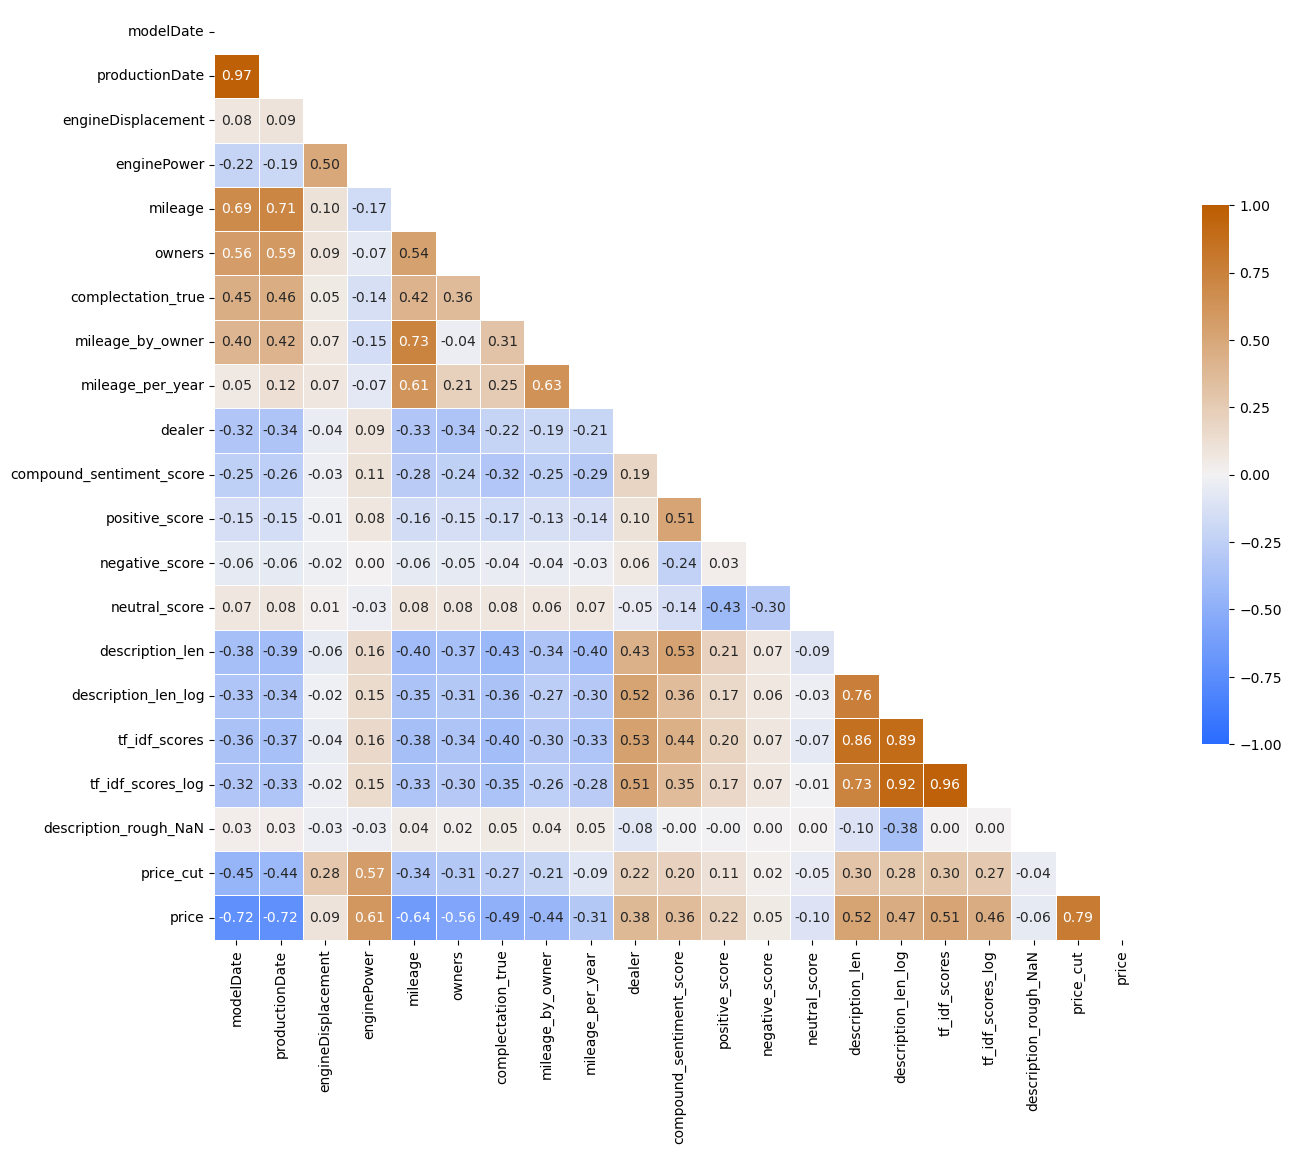

In [46]:
plt.rcParams['figure.figsize'] = (15, 14)
corr = data[numerical_list + ["price"]].corr()
get_corr_plot(corr, annot = True)

In [47]:
print(f'Корреляция признаков с целевой переменной "price": \n{corr.price.abs().sort_values(ascending = False)}')

Корреляция признаков с целевой переменной "price": 
price                      1.000
price_cut                  0.787
modelDate                  0.721
productionDate             0.721
mileage                    0.644
enginePower                0.605
owners                     0.563
description_len            0.523
tf_idf_scores              0.510
complectation_true         0.491
description_len_log        0.468
tf_idf_scores_log          0.465
mileage_by_owner           0.440
dealer                     0.382
compound_sentiment_score   0.357
mileage_per_year           0.308
positive_score             0.218
neutral_score              0.102
engineDisplacement         0.094
description_rough_NaN      0.061
negative_score             0.049
Name: price, dtype: float64


Признаки "productionDate" и "modelDate" сильно скоррелированы между собой (0.97).  
Создадим признак **"production_market_diff"** - разница между датой производства и датой выхода модели в продажу (в годах).

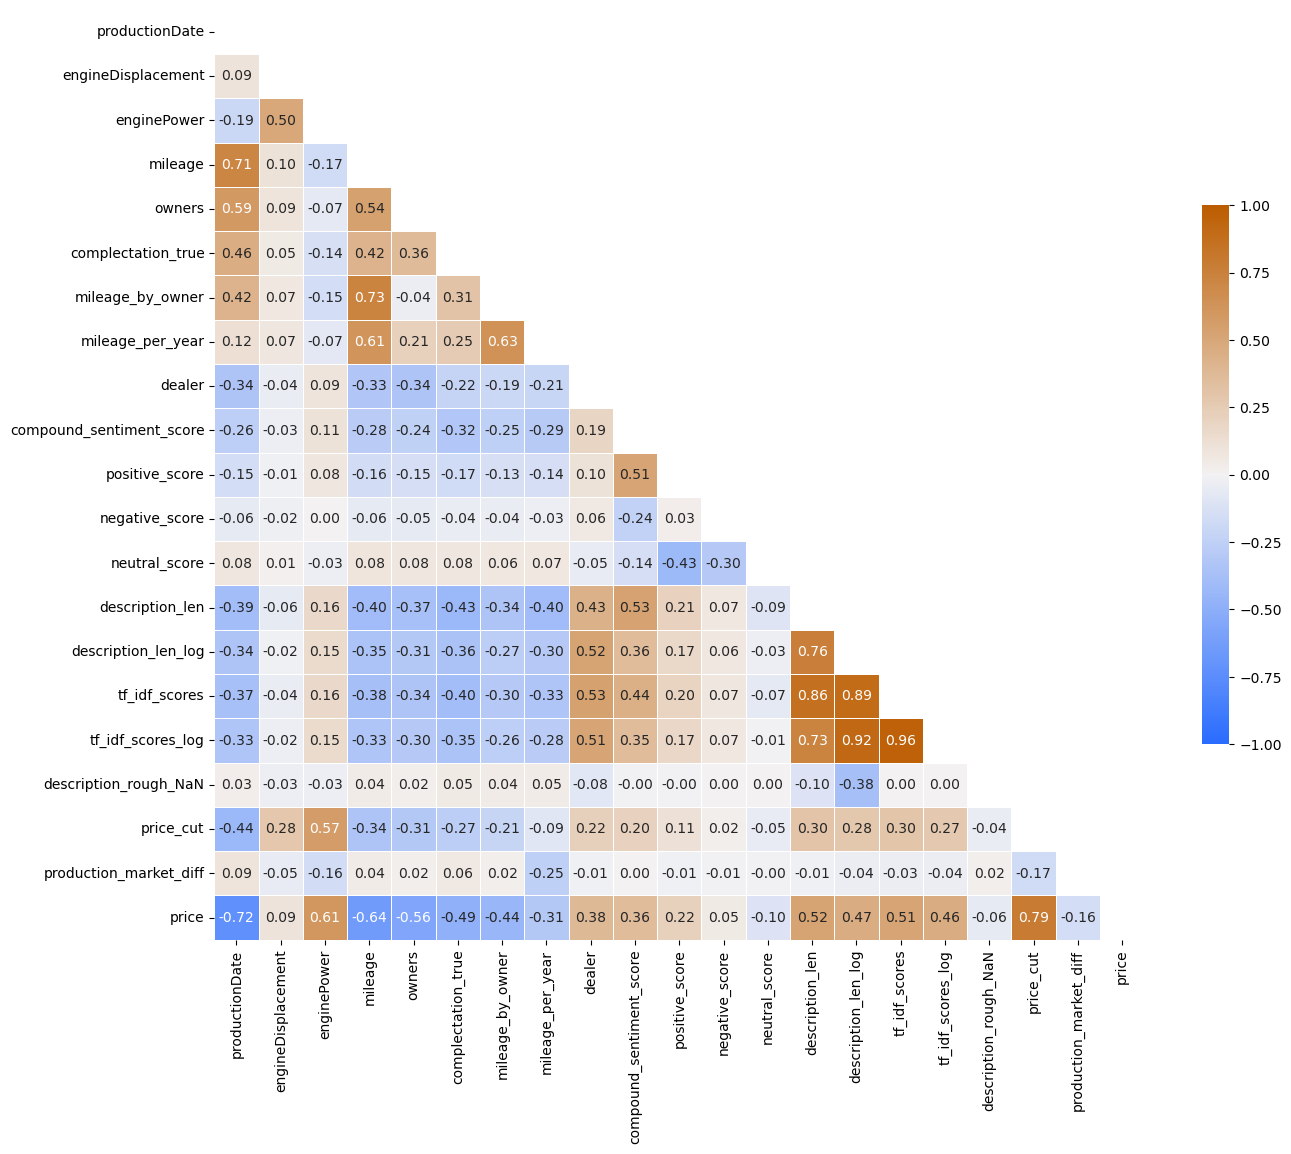

In [48]:
# Удалим столбец "modelDate" из датасета и списка numeric_list и создадим на их основе новый признак
data["production_market_diff"] = data["modelDate"] - data["productionDate"]

data.drop("modelDate", axis = 1, inplace = True)
numerical_list.remove("modelDate")
numerical_list.append("production_market_diff")

# Изобразим график коррелиции
plt.rcParams['figure.figsize'] = (15, 14)
corr_2 = data[numerical_list + ["price"]].corr()
get_corr_plot(corr_2, annot = True)

In [49]:
data.to_pickle("data_4.pickle")

# 5. Специальная предобработка признаков для обучения моделей различной природы

### План действий для различных алгоритмов (этапы реализованы в классе Preprocessor)    

#### Для модели kNN:    
- Применение нормализации MinMax    
- Заполнение числовых пропусков медианой       
- Применение к некоторым переменным get_dummies    
- Исключение из датасета текстового признака    
- Оптимизация гиперпараметров при помощи Optuna    

#### Для линейной регрессии и ансамблевых алгоритмов из sklearn:      
- Применение стандартной нормализации      
- Заполнение числовых пропусков медианой     
- Применение к некоторым переменным get_dummies     
- Исключение из датасета текстового признака     
- Оптимизация гиперпараметров при помощи Optuna     

#### Для XGBoost, LightGBM и CatBoost:     
- Применение стандартной нормализации       
- Оптимизация гиперпараметров при помощи Optuna       
- Игнорирование пропусков для LightGBM и CatBoost, заполнение для XGBoost      
- Исключение текстового признака для XGBoost и LightGBM      
- Применение двух алгоритмов CatBoost - с текстовым признаком и без        
- Применение двух алгоритмов XGBoost (эксперимент):    
  1) после предварительной ручной обработки категориальных признаков;    
  2) с обработкой катег-х признаков самим алгоритмом (max_cat_to_onehot)       


Проведение стекинга на лучшей подборке алгоритмов  


In [61]:
data_ = pd.read_pickle("data_4.pickle")

In [62]:
data_.head()

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3              29   
1        14      0      7         0              3              34   
2        18      0     13         0              4              31   
3        14      0     11         0              3              31   
4        14      0     15         0              3              29   

   vehicleTransmission  engineDisplacement  enginePower  \
0                    2               2.800      174.000   
1                    2               1.800       90.000   
2                    2               2.300      136.000   
3                    2               1.800       90.000   
4                    2               2.000      101.000   

                                                   description  mileage  \
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...   350000   
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...   173424   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...   230000   
3                                                          NaN   240000   
4  Машина не гнилая, дыр нет, днище целое, даже в родной кр...   300000   

   drive_gear  wheel  owners  vehicle_passport  price  model_name  \
0           2      0   3.000                 1 12.206           1   
1           1      0   3.000                 1 11.002           1   
2           2      0   3.000                 1 11.503           1   
3           1      0   3.000                 1 11.082           1   
4           1      0   3.000                 0 11.513           1   

   complectation_true  region_or_country  bodyType_rough  mileage_by_owner  \
0                   1                  1              12       116,666.667   
1                   1                  1              12        57,808.000   
2                   1                  1              15        76,666.667   
3                   1                  1              12        80,000.000   
4                   1                  1              12       100,000.000   

   mileage_per_year  sample  dealer  compound_sentiment_score  positive_score  \
0        11,666.667       1       0                     0.000           0.000   
1         4,563.789       1       0                     0.000           0.000   
2         7,187.500       1       1                     0.000           0.000   
3         7,500.000       1       0                     0.046           0.002   
4        10,000.000       1       0                     0.000           0.000   

   negative_score  neutral_score  description_cluster  description_len  \
0           0.000          1.000                    0               27   
1           0.000          1.000                    0               15   
2           0.000          1.000                    1              108   
3           0.001          0.996                    2                1   
4           0.000          1.000                    0               24   

   description_len_log  tf_idf_scores  tf_idf_scores_log  \
0                3.332          4.371              1.681   
1                2.773          3.218              1.439   
2                4.691          8.237              2.223   
3                0.693          6.355              1.893   
4                3.219          4.540              1.712   

   description_rough_NaN  price_cut  production_market_diff  
0                      0          0                   1.000  
1                      0          0                   4.000  
2                      0          0                   1.000  
3                      1          0                   1.000  
4                      0          0                   1.000

### Подготовка данных  для модели kNN 

In [23]:
print(f'categorial_list: {categorial_list}')
print(f'\nnumerical_list: {numerical_list}')

categorial_list: ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'drive_gear', 'wheel', 'vehicle_passport', 'model_name', 'region_or_country', 'bodyType_rough', 'description_cluster', 'numberOfDoors']

numerical_list: ['productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'owners', 'complectation_true', 'mileage_by_owner', 'mileage_per_year', 'dealer', 'compound_sentiment_score', 'positive_score', 'negative_score', 'neutral_score', 'description_len', 'description_len_log', 'tf_idf_scores', 'tf_idf_scores_log', 'description_rough_NaN', 'price_cut', 'production_market_diff']


In [19]:
# categorial_list = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'drive_gear', 'wheel', 'vehicle_passport', 
#                    'model_name', 'region_or_country', 'bodyType_rough', 'description_cluster', 'numberOfDoors']

# numerical_list = ['productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'owners', 'complectation_true', 
#                   'mileage_by_owner', 'mileage_per_year', 'dealer', 'compound_sentiment_score', 'positive_score', 
#                   'negative_score', 'neutral_score', 'description_len', 'description_len_log', 'tf_idf_scores', 
#                   'tf_idf_scores_log', 'description_rough_NaN', 'price_cut', 'production_market_diff']

In [53]:
# Данные для обучения kNN модели
knn_df_prep = Preprocessor(data_, categorial_list, numerical_list)  
knn_data, X_knn, X_sub_knn, y = knn_df_prep.knn_data_preparing()

print(f'Объединенный датасет "knn_data" \nРазмер: {knn_data.shape}')                    # (121540, 152)
print(f'Количество пропусков: {knn_data.drop("price", axis = 1).isna().sum().sum()}')   # 0
display(knn_data.head(3))
print('\nСтатистический вывод по датасету "knn_data"')                  # Min–max normalization
display(knn_data[numerical_list].describe())

print(f'\nОбучающая выборка "X_knn" \nРазмер: {X_knn.shape}')           # (86854, 150)
display(X_knn.head(3)) 
print(f'\nТестовая выборка "X_sub_knn" \nРазмер: {X_sub_knn.shape}')    # (34686, 150)
display(X_sub_knn.head(3))

# Сохраним данные
X_knn.to_pickle("X_knn.pickle")
X_sub_knn.to_pickle("X_sub_knn.pickle")

Объединенный датасет "knn_data" 
Размер: (121540, 152)
Количество пропусков: 0


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           0.250               0.280        0.207    0.350   1.000   
1           0.293               0.147        0.100    0.173   1.000   
2           0.267               0.213        0.158    0.230   1.000   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               1.000             0.117             0.071   0.000   
1               1.000             0.058             0.028   0.000   
2               1.000             0.077             0.044   1.000   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                     0.497           0.000           0.000          1.000   
1                     0.497           0.000           0.000          1.000   
2                     0.497           0.000           0.000          1.000   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0            0.009                0.416          0.157              0.500   
1            0.005                0.346          0.115              0.428   
2            0.036                0.586          0.295              0.661   

   description_rough_NaN  price_cut  production_market_diff  price  sample  \
0                  0.000      0.000                   0.082 12.206       1   
1                  0.000      0.000                   0.143 11.002       1   
2                  0.000      0.000                   0.082 11.503       1   

   bodyType_0  bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_6  bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  \
0           0           0           0           0            0            0   
1           0           0           0           0            0            0   
2           0           0           0           0            0            0   

   bodyType_12  bodyType_13  bodyType_14  bodyType_15  bodyType_16  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            0            0            0   

   bodyType_17  bodyType_18  bodyType_19  bodyType_20  bodyType_21  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            1            0            0            0   

   bodyType_22  bodyType_23  brand_0  brand_1  brand_2  brand_3  ...  \
0            0            0        1        0        0        0  ...   
1            0            0        1        0        0        0  ...   
2            0            0        1        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0                   


Статистический вывод по датасету "knn_data"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,540.000 121,540.000   
mean            0.084               0.177        0.209       0.144   
std             0.061               0.112        0.108       0.103   
min             0.000               0.000        0.000       0.000   
25%             0.043               0.093        0.134       0.073   
50%             0.078               0.147        0.176       0.137   
75%             0.112               0.227        0.252       0.200   
max             1.000               1.000        1.000       1.000   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       121,540.000   
mean        0.550               0.713             0.070             0.072   
std         0.431               0.452             0.054             0.044   
min         0.000               0.000             0.000             0.000   
25%         0.000               0.000             0.037             0.048   
50%         0.500               1.000             0.061             0.070   
75%         1.000               1.000             0.092             0.094   
max         1.000               1.000             1.000             1.000   

           dealer  compound_sentiment_score  positive_score  negative_score  \
count 121,540.000               121,540.000     121,540.000     121,540.000   
mean        0.210                     0.520           0.003           0.001   
std         0.407                     0.102           0.016           0.010   
min         0.000                     0.000           0.000           0.000   
25%         0.000                     0.497           0.000           0.000   
50%         0.000                     0.497           0.000           0.000   
75%         0.000                     0.497           0.000           0.000   
max         1.000                     1.000           1.000           1.000   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
count    121,540.000      121,540.000          121,540.000    121,540.000   
mean           0.996            0.031                0.464          0.228   
std            0.028            0.049                0.165          0.120   
min            0.000            0.000                0.000          0.000   
25%            1.000            0.006                0.361          0.140   
50%            1.000            0.013                0.464          0.206   
75%            1.000            0.032                0.572          0.288   
max            1.000            1.000                1.000          1.000   

       tf_idf_scores_log  description_rough_NaN   price_cut  \
count        121,540.000            121,540.000 121,540.000   
mean               0.563                  0.026       0.525   
std                0.134                  0.160       0.229   
min                0.000                  0.000       0.000   
25%                0.472                  0.000       0.286   
50%                0.563                  0.000       0.571   
75%                0.654                  0.000       0.714   
max                1.000                  1.000       1.000   

       production_market_diff  
count             121,540.000  
mean                    0.107  
std                     0.037  
min                     0.000  
25%                     0.082  
50%                     0.102  
75%                     0.122  
max                     1.000


Обучающая выборка "X_knn" 
Размер: (86854, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           0.250               0.280        0.207    0.350   1.000   
1           0.293               0.147        0.100    0.173   1.000   
2           0.267               0.213        0.158    0.230   1.000   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               1.000             0.117             0.071   0.000   
1               1.000             0.058             0.028   0.000   
2               1.000             0.077             0.044   1.000   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                     0.497           0.000           0.000          1.000   
1                     0.497           0.000           0.000          1.000   
2                     0.497           0.000           0.000          1.000   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0            0.009                0.416          0.157              0.500   
1            0.005                0.346          0.115              0.428   
2            0.036                0.586          0.295              0.661   

   description_rough_NaN  price_cut  production_market_diff  bodyType_0  \
0                  0.000      0.000                   0.082           0   
1                  0.000      0.000                   0.143           0   
2                  0.000      0.000                   0.082           0   

   bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  bodyType_12  \
0           0           0           0            0            0            0   
1           0           0           0            0            0            0   
2           0           0           0            0            0            0   

   bodyType_13  bodyType_14  bodyType_15  bodyType_16  bodyType_17  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   

   bodyType_18  bodyType_19  bodyType_20  bodyType_21  bodyType_22  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   

   bodyType_23  brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  ...  \
0            0        1        0        0        0        0        0  ...   
1            0        1        0        0        0        0        0  ...   
2            0        1        0        0        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0       


Тестовая выборка "X_sub_knn" 
Размер: (34686, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
86854           0.052               0.067        0.119    0.074   1.000   
86855           0.026               0.120        0.125    0.061   0.000   
86856           0.052               0.147        0.179    0.088   0.000   

       complectation_true  mileage_by_owner  mileage_per_year  dealer  \
86854               1.000             0.025             0.064   1.000   
86855               1.000             0.061             0.123   1.000   
86856               0.000             0.088             0.077   1.000   

       compound_sentiment_score  positive_score  negative_score  \
86854                     0.497           0.000           0.000   
86855                     0.497           0.000           0.000   
86856                     0.497           0.000           0.000   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
86854          1.000            0.030                0.562          0.283   
86855          1.000            0.085                0.693          0.408   
86856          1.000            0.030                0.562          0.283   

       tf_idf_scores_log  description_rough_NaN  price_cut  \
86854              0.650                  0.000      0.429   
86855              0.748                  0.000      0.429   
86856              0.650                  0.000      0.571   

       production_market_diff  bodyType_0  bodyType_1  bodyType_2  bodyType_3  \
86854                   0.082           0           0           0           0   
86855                   0.061           0           0           0           0   
86856                   0.082           0           0           0           0   

       bodyType_4  bodyType_5  bodyType_6  bodyType_7  bodyType_8  bodyType_9  \
86854           0           0           0           0           1           0   
86855           0           0           0           0           1           0   
86856           0           0           0           0           1           0   

       bodyType_10  bodyType_11  bodyType_12  bodyType_13  bodyType_14  \
86854            0            0            0            0            0   
86855            0            0            0            0            0   
86856            0            0            0            0            0   

       bodyType_15  bodyType_16  bodyType_17  bodyType_18  bodyType_19  \
86854            0            0            0            0            0   
86855            0            0            0            0            0   
86856            0            0            0            0            0   

       bodyType_20  bodyType_21  bodyType_22  bodyType_23  brand_0  brand_1  \
86854            0            0            0            0        0        0   
86855            0            0            0            0        0        0   
86856            0            0            0            0        0        0   

       brand_2  brand_3  brand_4  brand_5  ...  fuelType_4  fuelType_5  \
86854        0        0        0        0  ...           0           0   
86855        0        0        0        0  ...           0           0   
86856        0        0        0        0  ...           0           0   

       vehicleTransmission_0  vehicleTransmission_1  vehicleTransmission_2  \
86854                      0                      0                      0   
86855                      0                      0                      1   
86856                      0                      0                      0   

       vehicleTransmission_3  drive_gear_0  drive_gear_1  drive_gear_2  \
86854                      1             0             1             0   
86855                      0             0             1             0   
86856                      1             0             1             0   

       drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  vehicle_passport_1  \
86854             0        1        0

### Подготовка данных для линейной регрессии 

In [54]:
# Данные для обучения линейной регрессии и ансамблевых алгоритмов
lin_df_prep = Preprocessor(data_, categorial_list, numerical_list) 
lin_data, X_lin, X_sub_lin = lin_df_prep.lin_data_preparing()
                                                                                                   # (121540, 152)
print(f'Объединенный датасет "lin_data" для линейной регрессии и ансамблевых алгоритмов \nРазмер: {lin_data.shape}')  
print(f'Количество пропусков: {lin_data.drop("price", axis = 1).isna().sum().sum()}')    # 0           
display(lin_data.head())
print('\nСтатистический вывод по датасету "lin_data"')                 # Standard normalization
display(lin_data[numerical_list].describe())

print(f'\nОбучающая выборка "X_lin" \nРазмер: {X_lin.shape}')          # (86854, 150)
display(X_lin.head(3))
print(f'\nТестовая выборка "X_sub_lin" \nРазмер: {X_sub_lin.shape}')   # (34686, 150)
display(X_sub_lin.head(3))

# Сохраним данные
X_lin.to_pickle("X_lin.pickle")
X_sub_lin.to_pickle("X_sub_lin.pickle")

Объединенный датасет "lin_data" для линейной регрессии и ансамблевых алгоритмов 
Размер: (121540, 152)
Количество пропусков: 0


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           2.740               0.917       -0.021    2.006   1.044   
1           3.450              -0.273       -1.003    0.284   1.044   
2           3.024               0.322       -0.465    0.836   1.044   
3           3.024              -0.273       -1.003    0.933   1.044   
4           2.740              -0.035       -0.874    1.519   1.044   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               0.634             0.873            -0.018  -0.515   
1               0.634            -0.218            -1.001  -0.515   
2               0.634             0.132            -0.637   1.941   
3               0.634             0.194            -0.594  -0.515   
4               0.634             0.564            -0.248  -0.515   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                    -0.230          -0.208          -0.102          0.139   
1                    -0.230          -0.208          -0.102          0.139   
2                    -0.230          -0.208          -0.102          0.139   
3                    -0.000          -0.000           0.000          0.000   
4                    -0.230          -0.208          -0.102          0.139   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0           -0.448               -0.292         -0.592             -0.469   
1           -0.530               -0.717         -0.937             -1.004   
2            0.103                0.739          0.562              0.733   
3           -0.626               -2.294          0.000              0.000   
4           -0.469               -0.378         -0.542             -0.400   

   description_rough_NaN  price_cut  production_market_diff  price  sample  \
0                 -0.165     -2.287                  -0.705 12.206       1   
1                 -0.165     -2.287                   0.969 11.002       1   
2                 -0.165     -2.287                  -0.705 11.503       1   
3                  6.069     -2.287                  -0.705 11.082       1   
4                 -0.165     -2.287                  -0.705 11.513       1   

   bodyType_0  bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   bodyType_6  bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  \
0           0           0           0           0            0            0   
1           0           0           0           0            0            0   
2           0           0           0           0            0            0   
3           0           0           0           0            0            0   
4           0           0           0           0            0            0   

   bodyType_12  bodyType_13  bodyType_14  bodyType_15  bodyType_16  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            0            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   bodyType_17  bodyType_18  bodyType_19  bodyType_20  bodyType_21  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            1            0            0            0   
3            0            0            0            0            0   
4            0            0            0           


Статистический вывод по датасету "lin_data"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,540.000 121,540.000   
mean           -0.000              -0.000       -0.000       0.000   
std             1.000               1.000        1.000       1.000   
min            -1.383              -1.582       -1.926      -1.408   
25%            -0.672              -0.749       -0.687      -0.696   
50%            -0.103              -0.273       -0.302      -0.071   
75%             0.465               0.441        0.399       0.543   
max            15.107               7.342        7.294       8.347   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       121,540.000   
mean       -0.000              -0.000             0.000            -0.000   
std         1.000               1.000             1.000             0.994   
min        -1.276              -1.577            -1.290            -1.632   
25%        -1.276              -1.577            -0.595            -0.541   
50%        -0.116               0.634            -0.149            -0.034   
75%         1.044               0.634             0.410             0.497   
max         1.044               0.634            17.252            21.087   

           dealer  compound_sentiment_score  positive_score  negative_score  \
count 121,540.000               121,540.000     121,540.000     121,540.000   
mean       -0.000                     0.000           0.000          -0.000   
std         1.000                     1.000           1.000           1.000   
min        -0.515                    -5.105          -0.208          -0.102   
25%        -0.515                    -0.230          -0.208          -0.102   
50%        -0.515                    -0.230          -0.208          -0.102   
75%        -0.515                    -0.230          -0.208          -0.102   
max         1.941                     4.708          63.178          99.151   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
count    121,540.000      121,540.000          121,540.000    121,540.000   
mean          -0.000            0.000                0.000         -0.000   
std            1.000            1.000                1.000          1.000   
min          -35.537           -0.632               -2.820         -1.897   
25%            0.139           -0.517               -0.627         -0.732   
50%            0.139           -0.360               -0.003         -0.182   
75%            0.139            0.028                0.658          0.503   
max            0.139           19.881                3.257          6.437   

       tf_idf_scores_log  description_rough_NaN   price_cut  \
count        121,540.000            121,540.000 121,540.000   
mean              -0.000                  0.000      -0.000   
std                1.000                  1.000       1.000   
min               -4.194                 -0.165      -2.287   
25%               -0.672                 -0.165      -1.042   
50%                0.000                 -0.165       0.203   
75%                0.685                 -0.165       0.826   
max                3.261                  6.069       2.072   

       production_market_diff  
count             121,540.000  
mean                   -0.000  
std                     1.000  
min                    -2.936  
25%                    -0.705  
50%                    -0.147  
75%                     0.411  
max                    24.396


Обучающая выборка "X_lin" 
Размер: (86854, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           2.740               0.917       -0.021    2.006   1.044   
1           3.450              -0.273       -1.003    0.284   1.044   
2           3.024               0.322       -0.465    0.836   1.044   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               0.634             0.873            -0.018  -0.515   
1               0.634            -0.218            -1.001  -0.515   
2               0.634             0.132            -0.637   1.941   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                    -0.230          -0.208          -0.102          0.139   
1                    -0.230          -0.208          -0.102          0.139   
2                    -0.230          -0.208          -0.102          0.139   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0           -0.448               -0.292         -0.592             -0.469   
1           -0.530               -0.717         -0.937             -1.004   
2            0.103                0.739          0.562              0.733   

   description_rough_NaN  price_cut  production_market_diff  bodyType_0  \
0                 -0.165     -2.287                  -0.705           0   
1                 -0.165     -2.287                   0.969           0   
2                 -0.165     -2.287                  -0.705           0   

   bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  bodyType_12  \
0           0           0           0            0            0            0   
1           0           0           0            0            0            0   
2           0           0           0            0            0            0   

   bodyType_13  bodyType_14  bodyType_15  bodyType_16  bodyType_17  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   

   bodyType_18  bodyType_19  bodyType_20  bodyType_21  bodyType_22  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   

   bodyType_23  brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  ...  \
0            0        1        0        0        0        0        0  ...   
1            0        1        0        0        0        0        0  ...   
2            0        1        0        0        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0       


Тестовая выборка "X_sub_lin" 
Размер: (34686, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
86854          -0.530              -0.987       -0.828   -0.686   1.044   
86855          -0.956              -0.511       -0.769   -0.817  -1.276   
86856          -0.530              -0.273       -0.278   -0.549  -1.276   

       complectation_true  mileage_by_owner  mileage_per_year  dealer  \
86854               0.634            -0.832            -0.169   1.941   
86855               0.634            -0.167             1.162   1.941   
86856              -1.577             0.342             0.108   1.941   

       compound_sentiment_score  positive_score  negative_score  \
86854                    -0.230          -0.208          -0.102   
86855                    -0.230          -0.208          -0.102   
86856                    -0.230          -0.208          -0.102   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
86854          0.139           -0.026                0.594          0.462   
86855          0.139            1.118                1.393          1.507   
86856          0.139           -0.026                0.594          0.462   

       tf_idf_scores_log  description_rough_NaN  price_cut  \
86854              0.651                 -0.165     -0.419   
86855              1.385                 -0.165     -0.419   
86856              0.651                 -0.165      0.203   

       production_market_diff  bodyType_0  bodyType_1  bodyType_2  bodyType_3  \
86854                  -0.705           0           0           0           0   
86855                  -1.262           0           0           0           0   
86856                  -0.705           0           0           0           0   

       bodyType_4  bodyType_5  bodyType_6  bodyType_7  bodyType_8  bodyType_9  \
86854           0           0           0           0           1           0   
86855           0           0           0           0           1           0   
86856           0           0           0           0           1           0   

       bodyType_10  bodyType_11  bodyType_12  bodyType_13  bodyType_14  \
86854            0            0            0            0            0   
86855            0            0            0            0            0   
86856            0            0            0            0            0   

       bodyType_15  bodyType_16  bodyType_17  bodyType_18  bodyType_19  \
86854            0            0            0            0            0   
86855            0            0            0            0            0   
86856            0            0            0            0            0   

       bodyType_20  bodyType_21  bodyType_22  bodyType_23  brand_0  brand_1  \
86854            0            0            0            0        0        0   
86855            0            0            0            0        0        0   
86856            0            0            0            0        0        0   

       brand_2  brand_3  brand_4  brand_5  ...  fuelType_4  fuelType_5  \
86854        0        0        0        0  ...           0           0   
86855        0        0        0        0  ...           0           0   
86856        0        0        0        0  ...           0           0   

       vehicleTransmission_0  vehicleTransmission_1  vehicleTransmission_2  \
86854                      0                      0                      0   
86855                      0                      0                      1   
86856                      0                      0                      0   

       vehicleTransmission_3  drive_gear_0  drive_gear_1  drive_gear_2  \
86854                      1             0             1             0   
86855                      0             0             1             0   
86856                      1             0             1             0   

       drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  vehicle_passport_1  \
86854             0        1        0

### Подготовка данных для CatBoost

In [55]:
cb_df_prep = Preprocessor(data_, categorial_list, numerical_list) 
CB_data, X_cb, X_sub_cb, CB_text_data, X_cb_text, X_sub_cb_text, encoders_dict = cb_df_prep.CB_data_preparing(encoders_dict)

# Данные для обучения алгоритма CatBoost без текстового признака 
print(f'Объединенный датасет "CB_data" (без текстового признака) \nРазмер: {CB_data.shape}')            # (121540, 35)
print(f'Количество пропусков: {CB_data.drop("price", axis = 1).isna().sum().sum()}')                    # 1342
display(CB_data.head(3))
print('\nСтатистический вывод по датасету "CB_data"')
display(CB_data[numerical_list].describe())

print(f'\nОбучающая выборка без текстового признака "X_cb" \nРазмер: {X_cb.shape}')                     # (86854, 33)
display(X_cb.head(3))
print(f'\nТестовая выборка без текстового признака "X_sub_cb" \nРазмер: {X_sub_cb.shape}')              # (34686, 33)
display(X_sub_cb.head(3))


# Данные для обучения алгоритма CatBoost с текстовым признаком
print(f'\nОбъединенный датасет "CB_text_data" (c текстовым признаком) \nРазмер: {CB_text_data.shape}')  # (121540, 30)          
print(f'Количество пропусков: {CB_text_data.drop("price", axis = 1).isna().sum().sum()}')               # 1342  
display(CB_text_data.head(3))
print('\nСтатистический вывод по датасету "CB_text_data"')
display(CB_text_data[list(i for i in CB_text_data.columns.tolist() if i not in categorial_list)] \
                                                            .drop(['price', 'sample'], axis = 1).describe())

print(f'\nОбучающая выборка с текстовым признаком "X_cb_text" \nРазмер: {X_cb_text.shape}')             # (86854, 28)
display(X_cb_text.head(3))
print(f'\nТестовая выборка с текстовым признаком "X_sub_cb_text" \nРазмер: {X_sub_cb_text.shape}')      # (34686, 28)
display(X_sub_cb_text.head(3))  


# Сохраним данные
X_cb.to_pickle("X_cb.pickle")
X_sub_cb.to_pickle("X_sub_cb.pickle")

X_cb_text.to_pickle("X_cb_text.pickle")
X_sub_cb_text.to_pickle("X_sub_cb_text.pickle")

Объединенный датасет "CB_data" (без текстового признака) 
Размер: (121540, 35)
Количество пропусков: 1342


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  price  model_name  complectation_true  \
0      0   1.044                 1 12.206           1               0.634   
1      0   1.044                 1 11.002           1               0.634   
2      0   1.044                 1 11.503           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   sample  dealer  compound_sentiment_score  positive_score  negative_score  \
0       1  -0.515                    -0.230          -0.208          -0.102   
1       1  -0.515                    -0.230          -0.208          -0.102   
2       1   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705


Статистический вывод по датасету "CB_data"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,539.000 121,540.000   
mean           -0.000              -0.000        0.000       0.000   
std             1.000               1.000        1.000       1.000   
min            -1.383              -1.582       -1.926      -1.408   
25%            -0.672              -0.749       -0.687      -0.696   
50%            -0.103              -0.273       -0.302      -0.071   
75%             0.465               0.441        0.399       0.543   
max            15.107               7.342        7.294       8.347   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       120,200.000   
mean       -0.000              -0.000             0.000             0.000   
std         1.000               1.000             1.000             1.000   
min        -1.276              -1.577            -1.290            -1.632   
25%        -1.276              -1.577            -0.595            -0.549   
50%        -0.116               0.634            -0.149            -0.034   
75%         1.044               0.634             0.410             0.505   
max         1.044               0.634            17.252            21.087   

           dealer  compound_sentiment_score  positive_score  negative_score  \
count 121,540.000               121,540.000     121,540.000     121,540.000   
mean       -0.000                     0.000           0.000          -0.000   
std         1.000                     1.000           1.000           1.000   
min        -0.515                    -5.105          -0.208          -0.102   
25%        -0.515                    -0.230          -0.208          -0.102   
50%        -0.515                    -0.230          -0.208          -0.102   
75%        -0.515                    -0.230          -0.208          -0.102   
max         1.941                     4.708          63.178          99.151   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
count    121,540.000      121,540.000          121,540.000    121,540.000   
mean          -0.000            0.000                0.000         -0.000   
std            1.000            1.000                1.000          1.000   
min          -35.537           -0.632               -2.820         -1.897   
25%            0.139           -0.517               -0.627         -0.732   
50%            0.139           -0.360               -0.003         -0.182   
75%            0.139            0.028                0.658          0.503   
max            0.139           19.881                3.257          6.437   

       tf_idf_scores_log  description_rough_NaN   price_cut  \
count        121,540.000            121,540.000 121,540.000   
mean              -0.000                  0.000      -0.000   
std                1.000                  1.000       1.000   
min               -4.194                 -0.165      -2.287   
25%               -0.672                 -0.165      -1.042   
50%                0.000                 -0.165       0.203   
75%                0.685                 -0.165       0.826   
max                3.261                  6.069       2.072   

       production_market_diff  
count             121,539.000  
mean                   -0.000  
std                     1.000  
min                    -2.936  
25%                    -0.705  
50%                    -0.147  
75%                     0.411  
max                    24.396


Обучающая выборка без текстового признака "X_cb" 
Размер: (86854, 33)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  compound_sentiment_score  positive_score  negative_score  \
0  -0.515                    -0.230          -0.208          -0.102   
1  -0.515                    -0.230          -0.208          -0.102   
2   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705


Тестовая выборка без текстового признака "X_sub_cb" 
Размер: (34686, 33)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
86854         8     29     13         0              4          -0.530   
86855         8     29     15         0              4          -0.956   
86856         8     29     12         0              4          -0.530   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
86854                    3              -0.987       -0.828   -0.686   
86855                    2              -0.511       -0.769   -0.817   
86856                    3              -0.273       -0.278   -0.549   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
86854           1      0   1.044                 1         684   
86855           1      0  -1.276                 1         684   
86856           1      0  -1.276                 1         919   

       complectation_true  region_or_country  bodyType_rough  \
86854               0.634                  1               7   
86855               0.634                  1               7   
86856              -1.577                  1               7   

       mileage_by_owner  mileage_per_year  dealer  compound_sentiment_score  \
86854            -0.832            -0.169   1.941                    -0.230   
86855            -0.167             1.162   1.941                    -0.230   
86856             0.342             0.108   1.941                    -0.230   

       positive_score  negative_score  neutral_score  description_cluster  \
86854          -0.208          -0.102          0.139                    1   
86855          -0.208          -0.102          0.139                    2   
86856          -0.208          -0.102          0.139                    1   

       description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
86854           -0.026                0.594          0.462              0.651   
86855            1.118                1.393          1.507              1.385   
86856           -0.026                0.594          0.462              0.651   

       description_rough_NaN  price_cut  production_market_diff  
86854                 -0.165     -0.419                  -0.705  
86855                 -0.165     -0.419                  -1.262  
86856                 -0.165      0.203                  -0.705


Объединенный датасет "CB_text_data" (c текстовым признаком) 
Размер: (121540, 30)
Количество пропусков: 1342


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  price  model_name  complectation_true  \
0      0   1.044                 1 12.206           1               0.634   
1      0   1.044                 1 11.002           1               0.634   
2      0   1.044                 1 11.503           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   sample  dealer  description_cluster  description_len  description_len_log  \
0       1  -0.515                    0           -0.448               -0.292   
1       1  -0.515                    0           -0.530               -0.717   
2       1   1.941                    1            0.103                0.739   

   description_rough_NaN  price_cut  production_market_diff  \
0                 -0.165     -2.287                  -0.705   
1                 -0.165     -2.287                   0.969   
2                 -0.165     -2.287                  -0.705   

                                                   description  
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...  
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...  
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...


Статистический вывод по датасету "CB_text_data"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,539.000 121,540.000   
mean           -0.000              -0.000        0.000       0.000   
std             1.000               1.000        1.000       1.000   
min            -1.383              -1.582       -1.926      -1.408   
25%            -0.672              -0.749       -0.687      -0.696   
50%            -0.103              -0.273       -0.302      -0.071   
75%             0.465               0.441        0.399       0.543   
max            15.107               7.342        7.294       8.347   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       120,200.000   
mean       -0.000              -0.000             0.000             0.000   
std         1.000               1.000             1.000             1.000   
min        -1.276              -1.577            -1.290            -1.632   
25%        -1.276              -1.577            -0.595            -0.549   
50%        -0.116               0.634            -0.149            -0.034   
75%         1.044               0.634             0.410             0.505   
max         1.044               0.634            17.252            21.087   

           dealer  description_len  description_len_log  \
count 121,540.000      121,540.000          121,540.000   
mean       -0.000            0.000                0.000   
std         1.000            1.000                1.000   
min        -0.515           -0.632               -2.820   
25%        -0.515           -0.517               -0.627   
50%        -0.515           -0.360               -0.003   
75%        -0.515            0.028                0.658   
max         1.941           19.881                3.257   

       description_rough_NaN   price_cut  production_market_diff  
count            121,540.000 121,540.000             121,539.000  
mean                   0.000      -0.000                  -0.000  
std                    1.000       1.000                   1.000  
min                   -0.165      -2.287                  -2.936  
25%                   -0.165      -1.042                  -0.705  
50%                   -0.165       0.203                  -0.147  
75%                   -0.165       0.826                   0.411  
max                    6.069       2.072                  24.396


Обучающая выборка с текстовым признаком "X_cb_text" 
Размер: (86854, 28)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  description_cluster  description_len  description_len_log  \
0  -0.515                    0           -0.448               -0.292   
1  -0.515                    0           -0.530               -0.717   
2   1.941                    1            0.103                0.739   

   description_rough_NaN  price_cut  production_market_diff  \
0                 -0.165     -2.287                  -0.705   
1                 -0.165     -2.287                   0.969   
2                 -0.165     -2.287                  -0.705   

                                                   description  
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...  
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...  
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...


Тестовая выборка с текстовым признаком "X_sub_cb_text" 
Размер: (34686, 28)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
86854         8     29     13         0              4          -0.530   
86855         8     29     15         0              4          -0.956   
86856         8     29     12         0              4          -0.530   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
86854                    3              -0.987       -0.828   -0.686   
86855                    2              -0.511       -0.769   -0.817   
86856                    3              -0.273       -0.278   -0.549   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
86854           1      0   1.044                 1         684   
86855           1      0  -1.276                 1         684   
86856           1      0  -1.276                 1         919   

       complectation_true  region_or_country  bodyType_rough  \
86854               0.634                  1               7   
86855               0.634                  1               7   
86856              -1.577                  1               7   

       mileage_by_owner  mileage_per_year  dealer  description_cluster  \
86854            -0.832            -0.169   1.941                    1   
86855            -0.167             1.162   1.941                    2   
86856             0.342             0.108   1.941                    1   

       description_len  description_len_log  description_rough_NaN  price_cut  \
86854           -0.026                0.594                 -0.165     -0.419   
86855            1.118                1.393                 -0.165     -0.419   
86856           -0.026                0.594                 -0.165      0.203   

       production_market_diff  \
86854                  -0.705   
86855                  -1.262   
86856                  -0.705   

                                                       description  
86854  Все автомобили, представленные в продаже, проходят тщате...  
86855  ЛОТ: 01217195\nАвтопрага Север\nДанный автомобиль прошел...  
86856  Все автомобили, представленные в продаже, проходят тщате...

In [67]:
print(encoders_dict)

{'bodyType': LabelEncoder(), 'brand': LabelEncoder(), 'color': LabelEncoder(), 'fuelType': LabelEncoder(), 'vehicleTransmission': LabelEncoder(), 'drive_gear': LabelEncoder(), 'wheel': LabelEncoder(), 'vehicle_passport': LabelEncoder(), 'model_name': LabelEncoder(), 'region_or_country': LabelEncoder(), 'bodyType_rough': LabelEncoder(), 'description_cluster': LabelEncoder(), 'numberOfDoors': LabelEncoder(), 'productionDate': StandardScaler(), 'engineDisplacement': StandardScaler(), 'enginePower': StandardScaler(), 'mileage': StandardScaler(), 'owners': StandardScaler(), 'complectation_true': StandardScaler(), 'mileage_by_owner': StandardScaler(), 'mileage_per_year': StandardScaler(), 'dealer': StandardScaler(), 'compound_sentiment_score': StandardScaler(), 'positive_score': StandardScaler(), 'negative_score': StandardScaler(), 'neutral_score': StandardScaler(), 'description_len': StandardScaler(), 'description_len_log': StandardScaler(), 'tf_idf_scores': StandardScaler(), 'tf_idf_scores

### Подготовка данных для XGBoost:

In [57]:
xgb_df_prep = Preprocessor(data_, categorial_list, numerical_list) 
XGB_data, X_xgb, X_sub_xgb, XGB_data_2, X_xgb_2, X_sub_xgb_2 = xgb_df_prep.XGB_data_preparing(encoders_dict) 

# Датасет для обучения алгоритма XGBoost после предварительной ручной обработки катег-х признаков (после get_dummies) 
print(f'Датасет "XGB_data" после предварительной ручной обработки категориальных признаков\nРазмер: {XGB_data.shape}') 
print(f'Количество пропусков: {XGB_data.isna().drop("price", axis = 1).sum().sum()}')   # 0            # (121540, 152)
display(XGB_data.head(3))
print('\nСтатистический вывод по датасету "XGB_data"')
display(XGB_data[numerical_list].describe())

print(f'\nОбучающая выборка "X_xgb" после предварительной ручной обработки катег-х признаков \nРазмер: {X_xgb.shape}') 
display(X_xgb.head(3))                                                                                 # (86854, 150)
print(f'\nТестовая выборка "X_sub_xgb" после предварительной ручной обработки катег-х признаков \nРазмер: {X_sub_xgb.shape}') 
display(X_sub_xgb.head(3))                                                                             # (34686, 150)


# Датасет без обработки катег-х признаков - для обучения XGBoost с параметром "max_cat_to_onehot"
print(f'\nДатасет "XGB_data_2" без обработки категориальных признаков \nРазмер: {XGB_data_2.shape}')   # (121540, 35)
print(f'Количество пропусков: {XGB_data_2.drop("price", axis = 1).isna().sum().sum()}')                # 0
display(XGB_data_2.head(3))
print('\nСтатистический вывод по датасету "XGB_data_2"')
display(XGB_data_2[numerical_list].describe())

print(f'\nРазмер обучающей выборки без обработки катег-х признаков "X_xgb_2": {X_xgb_2.shape}')         # (86854, 33)
print(f'Размер тестовой выборки без обработки катег-х признаков "X_sub_xgb_2": {X_sub_xgb_2.shape}')    # (34686, 33)

# Сохраним данные
X_xgb.to_pickle("X_xgb.pickle")
X_sub_xgb.to_pickle("X_sub_xgb.pickle")

X_xgb_2.to_pickle("X_xgb_2.pickle")
X_sub_xgb_2.to_pickle("X_sub_xgb_2.pickle")

Датасет "XGB_data" после предварительной ручной обработки категориальных признаков
Размер: (121540, 152)
Количество пропусков: 0


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           2.740               0.917       -0.021    2.006   1.044   
1           3.450              -0.273       -1.003    0.284   1.044   
2           3.024               0.322       -0.465    0.836   1.044   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               0.634             0.873            -0.018  -0.515   
1               0.634            -0.218            -1.001  -0.515   
2               0.634             0.132            -0.637   1.941   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                    -0.230          -0.208          -0.102          0.139   
1                    -0.230          -0.208          -0.102          0.139   
2                    -0.230          -0.208          -0.102          0.139   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0           -0.448               -0.292         -0.592             -0.469   
1           -0.530               -0.717         -0.937             -1.004   
2            0.103                0.739          0.562              0.733   

   description_rough_NaN  price_cut  production_market_diff  price  sample  \
0                 -0.165     -2.287                  -0.705 12.206       1   
1                 -0.165     -2.287                   0.969 11.002       1   
2                 -0.165     -2.287                  -0.705 11.503       1   

   bodyType_0  bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_6  bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  \
0           0           0           0           0            0            0   
1           0           0           0           0            0            0   
2           0           0           0           0            0            0   

   bodyType_12  bodyType_13  bodyType_14  bodyType_15  bodyType_16  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            0            0            0   

   bodyType_17  bodyType_18  bodyType_19  bodyType_20  bodyType_21  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            1            0            0            0   

   bodyType_22  bodyType_23  brand_0  brand_1  brand_2  brand_3  ...  \
0            0            0        1        0        0        0  ...   
1            0            0        1        0        0        0  ...   
2            0            0        1        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0                   


Статистический вывод по датасету "XGB_data"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,540.000 121,540.000   
mean           -0.000              -0.000       -0.000       0.000   
std             1.000               1.000        1.000       1.000   
min            -1.383              -1.582       -1.926      -1.408   
25%            -0.672              -0.749       -0.687      -0.696   
50%            -0.103              -0.273       -0.302      -0.071   
75%             0.465               0.441        0.399       0.543   
max            15.107               7.342        7.294       8.347   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       121,540.000   
mean       -0.000              -0.000             0.000            -0.000   
std         1.000               1.000             1.000             0.994   
min        -1.276              -1.577            -1.290            -1.632   
25%        -1.276              -1.577            -0.595            -0.541   
50%        -0.116               0.634            -0.149            -0.034   
75%         1.044               0.634             0.410             0.497   
max         1.044               0.634            17.252            21.087   

           dealer  compound_sentiment_score  positive_score  negative_score  \
count 121,540.000               121,540.000     121,540.000     121,540.000   
mean       -0.000                     0.000           0.000          -0.000   
std         1.000                     1.000           1.000           1.000   
min        -0.515                    -5.105          -0.208          -0.102   
25%        -0.515                    -0.230          -0.208          -0.102   
50%        -0.515                    -0.230          -0.208          -0.102   
75%        -0.515                    -0.230          -0.208          -0.102   
max         1.941                     4.708          63.178          99.151   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
count    121,540.000      121,540.000          121,540.000    121,540.000   
mean          -0.000            0.000                0.000         -0.000   
std            1.000            1.000                1.000          1.000   
min          -35.537           -0.632               -2.820         -1.897   
25%            0.139           -0.517               -0.627         -0.732   
50%            0.139           -0.360               -0.003         -0.182   
75%            0.139            0.028                0.658          0.503   
max            0.139           19.881                3.257          6.437   

       tf_idf_scores_log  description_rough_NaN   price_cut  \
count        121,540.000            121,540.000 121,540.000   
mean              -0.000                  0.000      -0.000   
std                1.000                  1.000       1.000   
min               -4.194                 -0.165      -2.287   
25%               -0.672                 -0.165      -1.042   
50%                0.000                 -0.165       0.203   
75%                0.685                 -0.165       0.826   
max                3.261                  6.069       2.072   

       production_market_diff  
count             121,540.000  
mean                   -0.000  
std                     1.000  
min                    -2.936  
25%                    -0.705  
50%                    -0.147  
75%                     0.411  
max                    24.396


Обучающая выборка "X_xgb" после предварительной ручной обработки катег-х признаков 
Размер: (86854, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           2.740               0.917       -0.021    2.006   1.044   
1           3.450              -0.273       -1.003    0.284   1.044   
2           3.024               0.322       -0.465    0.836   1.044   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               0.634             0.873            -0.018  -0.515   
1               0.634            -0.218            -1.001  -0.515   
2               0.634             0.132            -0.637   1.941   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                    -0.230          -0.208          -0.102          0.139   
1                    -0.230          -0.208          -0.102          0.139   
2                    -0.230          -0.208          -0.102          0.139   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0           -0.448               -0.292         -0.592             -0.469   
1           -0.530               -0.717         -0.937             -1.004   
2            0.103                0.739          0.562              0.733   

   description_rough_NaN  price_cut  production_market_diff  bodyType_0  \
0                 -0.165     -2.287                  -0.705           0   
1                 -0.165     -2.287                   0.969           0   
2                 -0.165     -2.287                  -0.705           0   

   bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  bodyType_12  \
0           0           0           0            0            0            0   
1           0           0           0            0            0            0   
2           0           0           0            0            0            0   

   bodyType_13  bodyType_14  bodyType_15  bodyType_16  bodyType_17  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   

   bodyType_18  bodyType_19  bodyType_20  bodyType_21  bodyType_22  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   

   bodyType_23  brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  ...  \
0            0        1        0        0        0        0        0  ...   
1            0        1        0        0        0        0        0  ...   
2            0        1        0        0        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0       


Тестовая выборка "X_sub_xgb" после предварительной ручной обработки катег-х признаков 
Размер: (34686, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
86854          -0.530              -0.987       -0.828   -0.686   1.044   
86855          -0.956              -0.511       -0.769   -0.817  -1.276   
86856          -0.530              -0.273       -0.278   -0.549  -1.276   

       complectation_true  mileage_by_owner  mileage_per_year  dealer  \
86854               0.634            -0.832            -0.169   1.941   
86855               0.634            -0.167             1.162   1.941   
86856              -1.577             0.342             0.108   1.941   

       compound_sentiment_score  positive_score  negative_score  \
86854                    -0.230          -0.208          -0.102   
86855                    -0.230          -0.208          -0.102   
86856                    -0.230          -0.208          -0.102   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
86854          0.139           -0.026                0.594          0.462   
86855          0.139            1.118                1.393          1.507   
86856          0.139           -0.026                0.594          0.462   

       tf_idf_scores_log  description_rough_NaN  price_cut  \
86854              0.651                 -0.165     -0.419   
86855              1.385                 -0.165     -0.419   
86856              0.651                 -0.165      0.203   

       production_market_diff  bodyType_0  bodyType_1  bodyType_2  bodyType_3  \
86854                  -0.705           0           0           0           0   
86855                  -1.262           0           0           0           0   
86856                  -0.705           0           0           0           0   

       bodyType_4  bodyType_5  bodyType_6  bodyType_7  bodyType_8  bodyType_9  \
86854           0           0           0           0           1           0   
86855           0           0           0           0           1           0   
86856           0           0           0           0           1           0   

       bodyType_10  bodyType_11  bodyType_12  bodyType_13  bodyType_14  \
86854            0            0            0            0            0   
86855            0            0            0            0            0   
86856            0            0            0            0            0   

       bodyType_15  bodyType_16  bodyType_17  bodyType_18  bodyType_19  \
86854            0            0            0            0            0   
86855            0            0            0            0            0   
86856            0            0            0            0            0   

       bodyType_20  bodyType_21  bodyType_22  bodyType_23  brand_0  brand_1  \
86854            0            0            0            0        0        0   
86855            0            0            0            0        0        0   
86856            0            0            0            0        0        0   

       brand_2  brand_3  brand_4  brand_5  ...  fuelType_4  fuelType_5  \
86854        0        0        0        0  ...           0           0   
86855        0        0        0        0  ...           0           0   
86856        0        0        0        0  ...           0           0   

       vehicleTransmission_0  vehicleTransmission_1  vehicleTransmission_2  \
86854                      0                      0                      0   
86855                      0                      0                      1   
86856                      0                      0                      0   

       vehicleTransmission_3  drive_gear_0  drive_gear_1  drive_gear_2  \
86854                      1             0             1             0   
86855                      0             0             1             0   
86856                      1             0             1             0   

       drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  vehicle_passport_1  \
86854             0        1        0


Датасет "XGB_data_2" без обработки категориальных признаков 
Размер: (121540, 35)
Количество пропусков: 0


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  price  model_name  complectation_true  \
0      0   1.044                 1 12.206           1               0.634   
1      0   1.044                 1 11.002           1               0.634   
2      0   1.044                 1 11.503           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   sample  dealer  compound_sentiment_score  positive_score  negative_score  \
0       1  -0.515                    -0.230          -0.208          -0.102   
1       1  -0.515                    -0.230          -0.208          -0.102   
2       1   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705


Статистический вывод по датасету "XGB_data_2"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,540.000 121,540.000   
mean           -0.000              -0.000       -0.000       0.000   
std             1.000               1.000        1.000       1.000   
min            -1.383              -1.582       -1.926      -1.408   
25%            -0.672              -0.749       -0.687      -0.696   
50%            -0.103              -0.273       -0.302      -0.071   
75%             0.465               0.441        0.399       0.543   
max            15.107               7.342        7.294       8.347   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       121,540.000   
mean       -0.000              -0.000             0.000            -0.000   
std         1.000               1.000             1.000             0.994   
min        -1.276              -1.577            -1.290            -1.632   
25%        -1.276              -1.577            -0.595            -0.541   
50%        -0.116               0.634            -0.149            -0.034   
75%         1.044               0.634             0.410             0.497   
max         1.044               0.634            17.252            21.087   

           dealer  compound_sentiment_score  positive_score  negative_score  \
count 121,540.000               121,540.000     121,540.000     121,540.000   
mean       -0.000                     0.000           0.000          -0.000   
std         1.000                     1.000           1.000           1.000   
min        -0.515                    -5.105          -0.208          -0.102   
25%        -0.515                    -0.230          -0.208          -0.102   
50%        -0.515                    -0.230          -0.208          -0.102   
75%        -0.515                    -0.230          -0.208          -0.102   
max         1.941                     4.708          63.178          99.151   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
count    121,540.000      121,540.000          121,540.000    121,540.000   
mean          -0.000            0.000                0.000         -0.000   
std            1.000            1.000                1.000          1.000   
min          -35.537           -0.632               -2.820         -1.897   
25%            0.139           -0.517               -0.627         -0.732   
50%            0.139           -0.360               -0.003         -0.182   
75%            0.139            0.028                0.658          0.503   
max            0.139           19.881                3.257          6.437   

       tf_idf_scores_log  description_rough_NaN   price_cut  \
count        121,540.000            121,540.000 121,540.000   
mean              -0.000                  0.000      -0.000   
std                1.000                  1.000       1.000   
min               -4.194                 -0.165      -2.287   
25%               -0.672                 -0.165      -1.042   
50%                0.000                 -0.165       0.203   
75%                0.685                 -0.165       0.826   
max                3.261                  6.069       2.072   

       production_market_diff  
count             121,540.000  
mean                   -0.000  
std                     1.000  
min                    -2.936  
25%                    -0.705  
50%                    -0.147  
75%                     0.411  
max                    24.396


Размер обучающей выборки без обработки катег-х признаков "X_xgb_2": (86854, 33)
Размер тестовой выборки без обработки катег-х признаков "X_sub_xgb_2": (34686, 33)


### Подготовка данных для LightGBM:

In [58]:
# Датасет для обучения LightGBM (без обработки катег-х признаков и пропусков)
lgmb_df_prep = Preprocessor(data_, categorial_list, numerical_list) 
LGBM_data, X_lgbm, X_sub_lgbm = lgmb_df_prep.LGBM_data_preparing(encoders_dict)

print(f'Объединенный датасет "LGBM_data" для обучения алгоритма LightGBM \nРазмер: {LGBM_data.shape}')   # (121540, 35)
print(f'Количество пропусков: {LGBM_data.drop("price", axis = 1).isna().sum().sum()}')                   # 1342
display(LGBM_data.head(3))
print('\nСтатистический вывод по датасету "LGBM_data"')
display(LGBM_data[numerical_list].describe())

print(f'\nОбучающая выборка "X_lgbm" \nРазмер: {X_lgbm.shape}')                                          # (86854, 33)
display(X_lgbm.head(3))                                                                                
print(f'\nТестовая выборка "X_sub_lgbm" \nРазмер: {X_sub_lgbm.shape}')                                   # (34686, 33)
display(X_sub_lgbm.head(3))    

# Сохраним данные
X_lgbm.to_pickle("X_lgbm.pickle")
X_sub_lgbm.to_pickle("X_sub_lgbm.pickle")

Объединенный датасет "LGBM_data" для обучения алгоритма LightGBM 
Размер: (121540, 35)
Количество пропусков: 1342


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  price  model_name  complectation_true  \
0      0   1.044                 1 12.206           1               0.634   
1      0   1.044                 1 11.002           1               0.634   
2      0   1.044                 1 11.503           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   sample  dealer  compound_sentiment_score  positive_score  negative_score  \
0       1  -0.515                    -0.230          -0.208          -0.102   
1       1  -0.515                    -0.230          -0.208          -0.102   
2       1   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705


Статистический вывод по датасету "LGBM_data"


productionDate  engineDisplacement  enginePower     mileage  \
count     121,540.000         121,540.000  121,539.000 121,540.000   
mean           -0.000              -0.000        0.000       0.000   
std             1.000               1.000        1.000       1.000   
min            -1.383              -1.582       -1.926      -1.408   
25%            -0.672              -0.749       -0.687      -0.696   
50%            -0.103              -0.273       -0.302      -0.071   
75%             0.465               0.441        0.399       0.543   
max            15.107               7.342        7.294       8.347   

           owners  complectation_true  mileage_by_owner  mileage_per_year  \
count 121,540.000         121,540.000       121,540.000       120,200.000   
mean       -0.000              -0.000             0.000             0.000   
std         1.000               1.000             1.000             1.000   
min        -1.276              -1.577            -1.290            -1.632   
25%        -1.276              -1.577            -0.595            -0.549   
50%        -0.116               0.634            -0.149            -0.034   
75%         1.044               0.634             0.410             0.505   
max         1.044               0.634            17.252            21.087   

           dealer  compound_sentiment_score  positive_score  negative_score  \
count 121,540.000               121,540.000     121,540.000     121,540.000   
mean       -0.000                     0.000           0.000          -0.000   
std         1.000                     1.000           1.000           1.000   
min        -0.515                    -5.105          -0.208          -0.102   
25%        -0.515                    -0.230          -0.208          -0.102   
50%        -0.515                    -0.230          -0.208          -0.102   
75%        -0.515                    -0.230          -0.208          -0.102   
max         1.941                     4.708          63.178          99.151   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
count    121,540.000      121,540.000          121,540.000    121,540.000   
mean          -0.000            0.000                0.000         -0.000   
std            1.000            1.000                1.000          1.000   
min          -35.537           -0.632               -2.820         -1.897   
25%            0.139           -0.517               -0.627         -0.732   
50%            0.139           -0.360               -0.003         -0.182   
75%            0.139            0.028                0.658          0.503   
max            0.139           19.881                3.257          6.437   

       tf_idf_scores_log  description_rough_NaN   price_cut  \
count        121,540.000            121,540.000 121,540.000   
mean              -0.000                  0.000      -0.000   
std                1.000                  1.000       1.000   
min               -4.194                 -0.165      -2.287   
25%               -0.672                 -0.165      -1.042   
50%                0.000                 -0.165       0.203   
75%                0.685                 -0.165       0.826   
max                3.261                  6.069       2.072   

       production_market_diff  
count             121,539.000  
mean                   -0.000  
std                     1.000  
min                    -2.936  
25%                    -0.705  
50%                    -0.147  
75%                     0.411  
max                    24.396


Обучающая выборка "X_lgbm" 
Размер: (86854, 33)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  compound_sentiment_score  positive_score  negative_score  \
0  -0.515                    -0.230          -0.208          -0.102   
1  -0.515                    -0.230          -0.208          -0.102   
2   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705


Тестовая выборка "X_sub_lgbm" 
Размер: (34686, 33)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
86854         8     29     13         0              4          -0.530   
86855         8     29     15         0              4          -0.956   
86856         8     29     12         0              4          -0.530   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
86854                    3              -0.987       -0.828   -0.686   
86855                    2              -0.511       -0.769   -0.817   
86856                    3              -0.273       -0.278   -0.549   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
86854           1      0   1.044                 1         684   
86855           1      0  -1.276                 1         684   
86856           1      0  -1.276                 1         919   

       complectation_true  region_or_country  bodyType_rough  \
86854               0.634                  1               7   
86855               0.634                  1               7   
86856              -1.577                  1               7   

       mileage_by_owner  mileage_per_year  dealer  compound_sentiment_score  \
86854            -0.832            -0.169   1.941                    -0.230   
86855            -0.167             1.162   1.941                    -0.230   
86856             0.342             0.108   1.941                    -0.230   

       positive_score  negative_score  neutral_score  description_cluster  \
86854          -0.208          -0.102          0.139                    1   
86855          -0.208          -0.102          0.139                    2   
86856          -0.208          -0.102          0.139                    1   

       description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
86854           -0.026                0.594          0.462              0.651   
86855            1.118                1.393          1.507              1.385   
86856           -0.026                0.594          0.462              0.651   

       description_rough_NaN  price_cut  production_market_diff  
86854                 -0.165     -0.419                  -0.705  
86855                 -0.165     -0.419                  -1.262  
86856                 -0.165      0.203                  -0.705

In [59]:
print(f'Целевая переменная "y" \nРазмер:{y.shape}')  # (86854,)
display(y)  

y.to_pickle("y_price.pickle")

Целевая переменная "y" 
Размер:(86854,)


0       12.206
1       11.002
2       11.503
3       11.082
4       11.513
         ...  
86849   13.017
86850   13.092
86851   13.902
86852   13.981
86853   13.888
Name: price, Length: 86854, dtype: float64

### Подготовка данных для LightAutoMl:

In [60]:
# Датасет для обучения LightAutoMl
X_lama_text = X_cb_text.copy()
X_sub_lama_text = X_sub_cb_text.copy()                                         
print(f'Размеры обучающего и тестового датасетов для алгоритма LightAutoML (текстовый, числовые и категориальные признаки)  \nX_lama_text, X_sub_lama_text: {X_lama_text.shape, X_sub_lama_text.shape}') # ((86854, 28), (34686, 28))

# Обучающая и валидационная выборки
X_lama_txt_data = pd.concat([X_lama_text, y], axis = 1)
X_lama_txt_train, X_lama_txt_val = train_test_split(X_lama_txt_data, test_size = 0.2, random_state = RANDOM_SEED) 
print(f'\nРазмер обучающей выборки: {X_lama_txt_train.shape}')   # (69483, 29)
print(f'Размер валидационной выборки: {X_lama_txt_val.shape}')   # (17371, 29)

print(f'\nНаличие пропусков в обучающей выборке: \n{X_lama_txt_train.isna().sum()[X_lama_txt_train.isna().sum() > 0]}')
display(X_lama_txt_train.head(3))

# Сохраним данные
X_lama_txt_train.to_pickle("X_lama_txt_train.pickle")
X_lama_txt_val.to_pickle("X_lama_txt_val.pickle")

Размеры обучающего и тестового датасетов для алгоритма LightAutoML (текстовый, числовые и категориальные признаки)  
X_lama_text, X_sub_lama_text: ((86854, 28), (34686, 28))

Размер обучающей выборки: (69483, 29)
Размер валидационной выборки: (17371, 29)

Наличие пропусков в обучающей выборке: 
enginePower                  1
mileage_per_year          1063
production_market_diff       1
dtype: int64


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
10137         2      1     15         0              4           0.465   
24954         2     13     13         0              4          -1.383   
37073         2     17     11         0              4          -0.388   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
10137                    0              -0.868        2.094   -0.422   
24954                    0              -0.511       -0.617   -1.408   
37073                    0              -0.035       -0.302   -0.442   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
10137           2      0  -1.276                 1        1059   
24954           1      0  -1.276                 1         285   
37073           2      0  -0.116                 1         898   

       complectation_true  region_or_country  bodyType_rough  \
10137               0.634                  1               1   
24954              -1.577                  3               1   
37073               0.634                  3               1   

       mileage_by_owner  mileage_per_year  dealer  description_cluster  \
10137             0.583            -0.634  -0.515                    0   
24954            -1.290               NaN   1.941                    1   
37073            -0.372            -0.262  -0.515                    0   

       description_len  description_len_log  description_rough_NaN  price_cut  \
10137           -0.108                0.485                 -0.165      0.826   
24954            0.165                0.799                 -0.165      0.826   
37073           -0.292                0.163                 -0.165      0.203   

       production_market_diff  \
10137                  -0.705   
24954                  -1.262   
37073                   0.411   

                                                       description  price  
10137  Немецкая сборка, спецзаказ. Спортивные сиденья и руль. П... 14.221  
24954  АКРОС официальный дилер Hyundai.\r\nМы имеем богатый опы... 13.895  
37073  Автомобиль в хорошем состоянии , не требует никаких влож... 13.732

# 6. Формирование Baseline (наивной базовой модели без ML)

**Эта модель предсказывает среднюю цену по модели двигателя (engineDisplacement). Далее будем сравнивать с ней другие модели.**  
**Средняя абсолютная ошибка в процентах (MAPE): 93.72%**

In [61]:
baseline_train = X_knn.copy()
baseline_train['price'] = y.copy()

# Найдем median по экземплярам "engineDisplacement" в трейне и разметим тест
predict = X_knn['engineDisplacement'].map(baseline_train.groupby('engineDisplacement')['price'].median())

# Оценим точность
print(f"Средняя абсолютная ошибка в процентах (MAPE): {(mean_absolute_percentage_error(np.exp(y), np.exp(predict.values))) * 100:0.2f}%")

Средняя абсолютная ошибка в процентах (MAPE): 93.72%


In [62]:
data_.to_pickle("data_5.pickle")

# 7. Обучение и валидация экспериментальных моделей

7.1. kNN, Linear Regression, Decision Tree, Extra Trees, Random Forest    
7.2. Gradient Boosting, LightGBM, XGBoost, CatBoost       
7.3. LightAutoml  

In [180]:
# Загрузим подготовленные данные
data = pd.read_pickle("data_5.pickle")
y = pd.read_pickle("y_price.pickle")

X_knn = pd.read_pickle("X_knn.pickle")
X_sub_knn = pd.read_pickle("X_sub_knn.pickle")              
print(f"Размеры выборок для kNN модели - X_knn, X_sub_knn: {X_knn.shape, X_sub_knn.shape}")         # (86854, 150) (34686, 150)

X_lin = pd.read_pickle("X_lin.pickle")
X_sub_lin = pd.read_pickle("X_sub_lin.pickle")                                                      # (86854, 150) (34686, 150)
print(f"Размеры выборок для лин.регрессии и ансамблевых sklearn алгоритмов - X_lin, X_sub_lin: {X_lin.shape, X_sub_lin.shape}") 

X_cb = pd.read_pickle("X_cb.pickle")
X_sub_cb = pd.read_pickle("X_sub_cb.pickle")                                                        # (86854, 33) (34686, 33)
print(f"Размеры выборок для CatBoost (содержит только числовые и категор. признаки) - X_cb, X_sub_cb: {X_cb.shape, X_sub_cb.shape}") 

X_cb_text = pd.read_pickle("X_cb_text.pickle")
X_sub_cb_text = pd.read_pickle("X_sub_cb_text.pickle")                                              # (86854, 28)  (34686, 28)
print(f"Размеры выборок для CatBoost (текстовый, числовые и категор. признаки) - X_cb_text, X_sub_cb_text: {X_cb_text.shape, X_sub_cb_text.shape}") 

X_lama_text = pd.read_pickle("X_cb_text.pickle")                  # Обучающий датасет
X_sub_lama_text = pd.read_pickle("X_sub_cb_text.pickle")          # Тестовый датасет                                    
X_lama_txt_train = pd.read_pickle("X_lama_txt_train.pickle")      # Обучающая выборка
X_lama_txt_val = pd.read_pickle("X_lama_txt_val.pickle")          # Валидационная выборка           # (86854, 28)  (34686, 28)
print(f"Размеры выборок для LightAutoML(текстовый, числ. и категор. признаки) - X_lama_text, X_sub_lama_text:{X_lama_text.shape, X_sub_lama_text.shape}")

X_xgb = pd.read_pickle("X_xgb.pickle")
X_sub_xgb = pd.read_pickle("X_sub_xgb.pickle")                                                      # (86854, 150)  (34686, 150)
print(f"Размеры выборок для XGBoost (после обработки катег.признаков - get_dummies) - X_xgb, X_sub_xgb: {X_xgb.shape, X_sub_xgb.shape}") 

X_xgb_2 = pd.read_pickle("X_xgb_2.pickle")
X_sub_xgb_2 = pd.read_pickle("X_sub_xgb_2.pickle")                                                  # (86854, 33)  (34686, 33)
print(f"Размеры выборок для XGBoost (без обработки категориальных признаков) - X_xgb_2, X_sub_xgb_2: {X_xgb_2.shape, X_sub_xgb_2.shape}") 

X_lgbm = pd.read_pickle("X_lgbm.pickle")
X_sub_lgbm = pd.read_pickle("X_sub_lgbm.pickle")                                                    # (86854, 33)  (34686, 33)
print(f"Размеры выборок для LightGBM (без обработки катег-х признаков и пропусков) - X_lgbm, X_sub_lgbm: {X_lgbm.shape, X_sub_lgbm.shape}")

Размеры выборок для kNN модели - X_knn, X_sub_knn: ((86854, 150), (34686, 150))
Размеры выборок для лин.регрессии и ансамблевых sklearn алгоритмов - X_lin, X_sub_lin: ((86854, 150), (34686, 150))
Размеры выборок для CatBoost (содержит только числовые и категор. признаки) - X_cb, X_sub_cb: ((86854, 33), (34686, 33))
Размеры выборок для CatBoost (текстовый, числовые и категор. признаки) - X_cb_text, X_sub_cb_text: ((86854, 28), (34686, 28))
Размеры выборок для LightAutoML(текстовый, числ. и категор. признаки) - X_lama_text, X_sub_lama_text:((86854, 28), (34686, 28))
Размеры выборок для XGBoost (после обработки катег.признаков - get_dummies) - X_xgb, X_sub_xgb: ((86854, 150), (34686, 150))
Размеры выборок для XGBoost (без обработки категориальных признаков) - X_xgb_2, X_sub_xgb_2: ((86854, 33), (34686, 33))
Размеры выборок для LightGBM (без обработки катег-х признаков и пропусков) - X_lgbm, X_sub_lgbm: ((86854, 33), (34686, 33))


In [20]:
y.shape  # (86854,)

(86854,)

In [21]:
def compute_cv(model, X, y, label = 'RandomForestRegressor'):
    '''
    Функция для выполнения кросс-валидации на 3 выборках.
    Минимизируем абсолютную ошибку и разницу между валидационной и обучающей выборкой.
    Получаем множество Паретто.
    '''
    kf = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_SEED)
    mape_train = []
    mape_valid = []
    for train_index, valid_index in tqdm_notebook(kf.split(X)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if label in ['simple', 'KNeighborsRegressor', 'LinearRegression', 'DecisionTreeRegressor', 'ExtraTreesRegressor', 
                     'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor']:
            model.fit(X_train, y_train)
        elif label == 'LGBMRegressor':
            model.fit(X_train, y_train, 
                      categorical_feature = categorial_list)
        elif label == 'CatBoostRegressor':
            model.fit(X_train, y_train, 
                      eval_set = (X_valid, y_valid), 
                      use_best_model = True,
                      cat_features = categorial_list, 
                      verbose = 100)
        elif label == 'CatBoostRegressor_text':
            model.fit(X_train, y_train, 
                      eval_set = (X_valid, y_valid), 
                      use_best_model = True,
                      cat_features = categorial_list,
                      text_features = text_features_list,
                      verbose = 100)
        elif label == 'CatBoostRegressor_stack':
            model.fit(X_train, y_train, verbose = 50)
        
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        
        mape_train.append(mape_exp(y_train, y_pred_train))
        mape_valid.append(mape_exp(y_valid, y_pred_valid))
    
    mape_train = np.array(mape_train)
    mape_valid = np.array(mape_valid)
  
    return np.mean(mape_valid), np.mean(np.abs(mape_valid - mape_train))

## 7.1. Обучение моделей: kNN, Linear Regression, Decision Tree, Extra Trees,  Random Forest

## kNN Regressor    
Проведем оптимизацию и получим метрики на кросс-валидации, чтобы минимизировать переобучение  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html">Документация KNeighborsRegressor</a>

In [26]:
# Датасет
print(f'Размер датасета: {X_knn.shape}')                # (86854, 150)
print(f'Кол-во пропусков: {X_knn.isna().sum().sum()}')  # 0
X_knn.head(3)

Размер датасета: (86854, 150)
Кол-во пропусков: 0


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           0.250               0.280        0.207    0.350   1.000   
1           0.293               0.147        0.100    0.173   1.000   
2           0.267               0.213        0.158    0.230   1.000   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               1.000             0.117             0.071   0.000   
1               1.000             0.058             0.028   0.000   
2               1.000             0.077             0.044   1.000   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                     0.497           0.000           0.000          1.000   
1                     0.497           0.000           0.000          1.000   
2                     0.497           0.000           0.000          1.000   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0            0.009                0.416          0.157              0.500   
1            0.005                0.346          0.115              0.428   
2            0.036                0.586          0.295              0.661   

   description_rough_NaN  price_cut  production_market_diff  bodyType_0  \
0                  0.000      0.000                   0.082           0   
1                  0.000      0.000                   0.143           0   
2                  0.000      0.000                   0.082           0   

   bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  bodyType_12  \
0           0           0           0            0            0            0   
1           0           0           0            0            0            0   
2           0           0           0            0            0            0   

   bodyType_13  bodyType_14  bodyType_15  bodyType_16  bodyType_17  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   

   bodyType_18  bodyType_19  bodyType_20  bodyType_21  bodyType_22  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   

   bodyType_23  brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  ...  \
0            0        1        0        0        0        0        0  ...   
1            0        1        0        0        0        0        0  ...   
2            0        1        0        0        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0       

In [65]:
def objective_kNN(trial):
    model = KNeighborsRegressor(n_neighbors = trial.suggest_int("n_neighbors", 20, 50, 5),
                                leaf_size = trial.suggest_int("leaf_size", 20, 100, 10),                            
                                weights = trial.suggest_categorical("weights", [None, 'uniform', 'distance']), 
                                n_jobs = -1)
    
    res = compute_cv(model, X_knn, y, label = 'KNeighborsRegressor')
    print(res) 
    return res[0] + res[1]


study_kNN = optuna.create_study(study_name = 'Study_kNN')
study_kNN.optimize(objective_kNN, n_trials = 100, show_progress_bar = True)    

[I 2023-07-11 16:10:33,819] A new study created in memory with name: Study_kNN


  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.32495972948038515, 0.32449800973935217)
[I 2023-07-11 16:20:16,962] Trial 0 finished with value: 0.6494577392197374 and parameters: {'n_neighbors': 35, 'leaf_size': 90, 'weights': 'distance'}. Best is trial 0 with value: 0.6494577392197374.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 16:29:55,110] Trial 1 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 80, 'weights': None}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.35872413806551995, 0.00848950596522898)
[I 2023-07-11 16:39:33,084] Trial 2 finished with value: 0.3672136440307489 and parameters: {'n_neighbors': 50, 'leaf_size': 40, 'weights': 'uniform'}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 16:49:12,168] Trial 3 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 20, 'weights': 'uniform'}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.3554209357179976, 0.009159140312104222)
[I 2023-07-11 16:59:02,074] Trial 4 finished with value: 0.36458007603010184 and parameters: {'n_neighbors': 45, 'leaf_size': 20, 'weights': 'uniform'}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.3168175247134188, 0.31635579988486295)
[I 2023-07-11 17:08:45,512] Trial 5 finished with value: 0.6331733245982818 and parameters: {'n_neighbors': 20, 'leaf_size': 90, 'weights': 'distance'}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.33302591702563217, 0.3325641893193203)
[I 2023-07-11 17:18:26,009] Trial 6 finished with value: 0.6655901063449525 and parameters: {'n_neighbors': 50, 'leaf_size': 70, 'weights': 'distance'}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 17:28:05,698] Trial 7 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 30, 'weights': 'uniform'}. Best is trial 1 with value: 0.35810339728390006.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 17:37:44,102] Trial 8 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34859537755155595, 0.011876105052571695)
[I 2023-07-11 17:47:26,844] Trial 9 finished with value: 0.36047148260412765 and parameters: {'n_neighbors': 35, 'leaf_size': 60, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 17:57:10,507] Trial 10 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 18:06:49,129] Trial 11 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 18:16:27,760] Trial 12 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 18:26:06,594] Trial 13 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 18:35:43,673] Trial 14 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.35202917538359085, 0.010244732311941026)
[I 2023-07-11 18:45:22,450] Trial 15 finished with value: 0.36227390769553186 and parameters: {'n_neighbors': 40, 'leaf_size': 40, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 18:55:03,049] Trial 16 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 100, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 19:04:44,087] Trial 17 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.35202917538359085, 0.010244732311941026)
[I 2023-07-11 19:14:20,679] Trial 18 finished with value: 0.36227390769553186 and parameters: {'n_neighbors': 40, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 19:23:58,442] Trial 19 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3168175247134188, 0.31635579988486295)
[I 2023-07-11 19:33:34,620] Trial 20 finished with value: 0.6331733245982818 and parameters: {'n_neighbors': 20, 'leaf_size': 60, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 19:43:11,947] Trial 21 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 19:52:48,845] Trial 22 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 20:02:31,043] Trial 23 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 20:12:07,613] Trial 24 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34859537755155595, 0.011876105052571695)
[I 2023-07-11 20:21:45,129] Trial 25 finished with value: 0.36047148260412765 and parameters: {'n_neighbors': 35, 'leaf_size': 40, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 20:31:22,387] Trial 26 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 20:40:58,545] Trial 27 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.32495972948038515, 0.32449800973935217)
[I 2023-07-11 20:50:36,232] Trial 28 finished with value: 0.6494577392197374 and parameters: {'n_neighbors': 35, 'leaf_size': 80, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.35202917538359085, 0.010244732311941026)
[I 2023-07-11 21:00:14,978] Trial 29 finished with value: 0.36227390769553186 and parameters: {'n_neighbors': 40, 'leaf_size': 90, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.32211089265287, 0.32164917586694863)
[I 2023-07-11 21:09:51,809] Trial 30 finished with value: 0.6437600685198186 and parameters: {'n_neighbors': 30, 'leaf_size': 100, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 21:19:27,518] Trial 31 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 21:29:05,482] Trial 32 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 21:38:41,759] Trial 33 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 21:48:20,743] Trial 34 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 21:57:59,832] Trial 35 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 80, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 22:07:35,951] Trial 36 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 22:17:12,757] Trial 37 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 30, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 22:26:48,457] Trial 38 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 40, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3195257339608215, 0.3190640627959755)
[I 2023-07-11 22:36:24,278] Trial 39 finished with value: 0.6385897967567971 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 22:46:01,316] Trial 40 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 22:55:39,880] Trial 41 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 100, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 23:05:28,410] Trial 42 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 90, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 23:15:08,589] Trial 43 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 100, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-11 23:24:48,656] Trial 44 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 50, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.35872413806551995, 0.00848950596522898)
[I 2023-07-11 23:34:26,026] Trial 45 finished with value: 0.3672136440307489 and parameters: {'n_neighbors': 50, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-11 23:44:01,762] Trial 46 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 90, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-11 23:53:37,458] Trial 47 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 30, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3554209357179976, 0.009159140312104222)
[I 2023-07-12 00:03:21,246] Trial 48 finished with value: 0.36458007603010184 and parameters: {'n_neighbors': 45, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 00:12:57,023] Trial 49 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 80, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3195257339608215, 0.3190640627959755)
[I 2023-07-12 00:22:34,677] Trial 50 finished with value: 0.6385897967567971 and parameters: {'n_neighbors': 25, 'leaf_size': 40, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 00:32:12,140] Trial 51 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 00:41:48,530] Trial 52 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 00:51:25,392] Trial 53 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 01:01:07,667] Trial 54 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 01:10:48,958] Trial 55 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 01:20:26,713] Trial 56 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 20, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 01:30:15,836] Trial 57 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 01:39:52,918] Trial 58 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 01:49:31,538] Trial 59 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.32495972948038515, 0.32449800973935217)
[I 2023-07-12 01:59:10,669] Trial 60 finished with value: 0.6494577392197374 and parameters: {'n_neighbors': 35, 'leaf_size': 90, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 02:08:47,313] Trial 61 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 02:18:23,436] Trial 62 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 02:28:00,028] Trial 63 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 02:37:36,257] Trial 64 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 02:47:13,567] Trial 65 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 02:56:51,207] Trial 66 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 03:06:27,911] Trial 67 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 03:16:03,789] Trial 68 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 03:25:41,018] Trial 69 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 03:35:16,939] Trial 70 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 03:44:53,537] Trial 71 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 03:54:30,753] Trial 72 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 04:04:14,881] Trial 73 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 100, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 04:13:51,835] Trial 74 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 04:23:28,487] Trial 75 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3168175247134188, 0.31635579988486295)
[I 2023-07-12 04:33:05,105] Trial 76 finished with value: 0.6331733245982818 and parameters: {'n_neighbors': 20, 'leaf_size': 60, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 04:42:42,024] Trial 77 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.35202917538359085, 0.010244732311941026)
[I 2023-07-12 04:52:20,041] Trial 78 finished with value: 0.36227390769553186 and parameters: {'n_neighbors': 40, 'leaf_size': 90, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 05:01:57,587] Trial 79 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 05:11:34,927] Trial 80 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 05:21:11,378] Trial 81 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 05:30:48,095] Trial 82 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 80, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 05:40:23,798] Trial 83 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 05:50:00,970] Trial 84 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 05:59:39,521] Trial 85 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 06:09:16,321] Trial 86 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 06:18:52,640] Trial 87 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 100, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3195257339608215, 0.3190640627959755)
[I 2023-07-12 06:28:30,349] Trial 88 finished with value: 0.6385897967567971 and parameters: {'n_neighbors': 25, 'leaf_size': 80, 'weights': 'distance'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 06:38:06,204] Trial 89 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 06:47:43,886] Trial 90 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 06:57:22,416] Trial 91 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 07:06:58,774] Trial 92 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 07:16:34,943] Trial 93 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 07:26:12,065] Trial 94 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 07:36:21,240] Trial 95 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3374899240383098, 0.02046642713846943)
[I 2023-07-12 07:45:58,757] Trial 96 finished with value: 0.3579563511767792 and parameters: {'n_neighbors': 20, 'leaf_size': 90, 'weights': 'uniform'}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.3446417456939686, 0.013461651589931437)
[I 2023-07-12 07:55:39,296] Trial 97 finished with value: 0.35810339728390006 and parameters: {'n_neighbors': 30, 'leaf_size': 50, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 08:05:16,424] Trial 98 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


0it [00:00, ?it/s]

(0.34111388424560246, 0.016113819857617933)
[I 2023-07-12 08:14:53,316] Trial 99 finished with value: 0.3572277041032204 and parameters: {'n_neighbors': 25, 'leaf_size': 70, 'weights': None}. Best is trial 8 with value: 0.3572277041032204.


In [566]:
# Посмотрим на лучшие наборы параметров
display(study_kNN.trials_dataframe().sort_values('value')[:10])

number  value             datetime_start          datetime_complete  \
99      99  0.357 2023-07-12 08:05:16.427569 2023-07-12 08:14:53.315725   
74      74  0.357 2023-07-12 04:04:14.884301 2023-07-12 04:13:51.835381   
27      27  0.357 2023-07-11 20:31:22.391145 2023-07-11 20:40:58.545891   
72      72  0.357 2023-07-12 03:44:53.541855 2023-07-12 03:54:30.753029   
71      71  0.357 2023-07-12 03:35:16.942030 2023-07-12 03:44:53.537866   
31      31  0.357 2023-07-11 21:09:51.813086 2023-07-11 21:19:27.517545   
32      32  0.357 2023-07-11 21:19:27.522533 2023-07-11 21:29:05.482881   
69      69  0.357 2023-07-12 03:16:03.793098 2023-07-12 03:25:41.017300   
68      68  0.357 2023-07-12 03:06:27.915370 2023-07-12 03:16:03.789110   
66      66  0.357 2023-07-12 02:47:13.570097 2023-07-12 02:56:51.207191   

                 duration  params_leaf_size  params_n_neighbors  \
99 0 days 00:09:36.888156                70                  25   
74 0 days 00:09:36.951080                80                  25   
27 0 days 00:09:36.154746                60                  25   
72 0 days 00:09:37.211174                70                  25   
71 0 days 00:09:36.595836                80                  25   
31 0 days 00:09:35.704459                70                  25   
32 0 days 00:09:37.960348                60                  25   
69 0 days 00:09:37.224202                60                  25   
68 0 days 00:09:35.873740                70                  25   
66 0 days 00:09:37.637094                70                  25   

   params_weights     state  
99           None  COMPLETE  
74           None  COMPLETE  
27           None  COMPLETE  
72           None  COMPLETE  
71           None  COMPLETE  
31           None  COMPLETE  
32           None  COMPLETE  
69           None  COMPLETE  
68        uniform  COMPLETE  
66           None  COMPLETE

In [567]:
# Выведем лучше подобранные параметры
best_params_kNN = study_kNN.best_params
print(f'Best parameters: {best_params_kNN}')
print(f'Number of finished trials: {len(study_kNN.trials)}')

trial_kNN = study_kNN.best_trial
print(f'Value: {trial_kNN.value:.05f}')

# Сохраним параметры
joblib.dump(study_kNN, 'study_kNN.pkl')  

# Обучим модель с лучшими параметрами из подобранных 
knn_model = KNeighborsRegressor(**best_params_kNN)
knn_model.fit(X_knn, y)
y_pred_knn = knn_model.predict(X_knn)
print(f'MAPE: {mape_exp(y, y_pred_knn) * 100:.3f} %')

y_sub_knn = knn_model.predict(X_sub_knn)

# optuna.visualization.plot_optimization_history(study_kNN)

Best parameters: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}
Number of finished trials: 100
Value: 0.35723
MAPE: 31.325 %


## Linear Regression  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Документация LinearRegression</a>

In [162]:
# Датасет
print(f'Размер датасета: {X_lin.shape}')
print(f'Кол-во пропусков: {X_lin.isna().sum().sum()}')
print(f'Проверка элементов на конечность: {np.unique(np.isfinite(X_lin))}')
X_lin.head(3)

Размер датасета: (86854, 150)
Кол-во пропусков: 0
Проверка элементов на конечность: [ True]


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           2.740               0.917       -0.021    2.006   1.044   
1           3.450              -0.273       -1.003    0.284   1.044   
2           3.024               0.322       -0.465    0.836   1.044   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               0.634             0.873            -0.018  -0.515   
1               0.634            -0.218            -1.001  -0.515   
2               0.634             0.132            -0.637   1.941   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                    -0.230          -0.208          -0.102          0.139   
1                    -0.230          -0.208          -0.102          0.139   
2                    -0.230          -0.208          -0.102          0.139   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0           -0.448               -0.292         -0.592             -0.469   
1           -0.530               -0.717         -0.937             -1.004   
2            0.103                0.739          0.562              0.733   

   description_rough_NaN  price_cut  production_market_diff  bodyType_0  \
0                 -0.165     -2.287                  -0.705           0   
1                 -0.165     -2.287                   0.969           0   
2                 -0.165     -2.287                  -0.705           0   

   bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  bodyType_12  \
0           0           0           0            0            0            0   
1           0           0           0            0            0            0   
2           0           0           0            0            0            0   

   bodyType_13  bodyType_14  bodyType_15  bodyType_16  bodyType_17  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   

   bodyType_18  bodyType_19  bodyType_20  bodyType_21  bodyType_22  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   

   bodyType_23  brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  ...  \
0            0        1        0        0        0        0        0  ...   
1            0        1        0        0        0        0        0  ...   
2            0        1        0        0        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0       

In [78]:
# Обучим модель линейной регрессии и посмотрим значение MAPE
# Алгоритм очень простой, не будем его оптимизировать
LinReg = LinearRegression()
LinReg.fit(X_lin, y)
print(f'Score: {LinReg.score(X_lin, y):.3f}')
print(X_lin.shape)
print(compute_cv(LinReg, X_lin, y, label = 'LinearRegression'))

Score: 0.917
(86854, 150)


0it [00:00, ?it/s]

(0.2171636020772559, 0.001065564993669943)


In [79]:
LinReg.coef_

array([-3.14650811e-01,  3.70325936e-02,  2.40600932e-01, -1.04781953e-01,
       -1.79572043e-01, -2.40686295e-02, -1.34773670e-01,  6.66722298e-02,
        1.02567454e-02, -4.75110705e-03,  6.20613016e-03, -2.87475961e-05,
       -3.72274927e-03,  5.36189221e-02,  6.01457061e-02, -3.93260761e-02,
       -8.60677497e-03,  1.78198959e-02,  1.90381559e-01,  5.82752812e-03,
        4.75502644e+11,  4.75502644e+11,  4.75502644e+11, -6.11301019e+10,
       -3.17753622e+09, -2.06426035e+11, -3.91309220e+10,  1.48042175e+10,
       -9.01220014e+10,  1.81515886e+09, -4.20812997e+10, -3.47917069e+10,
        6.82957256e+10, -8.27275531e+10, -3.61046105e+11, -3.61046105e+11,
       -1.75707036e+10, -9.35196499e+10, -8.20993428e+10, -1.94007540e+10,
       -1.92311816e+10,  1.21836252e+11,  1.21836252e+11,  1.21836252e+11,
       -5.90914999e+10, -5.90914999e+10,  8.50030487e+10,  9.39762483e+10,
        8.50030487e+10,  8.50030487e+10, -5.90914999e+10,  5.59395038e+10,
        8.50030487e+10,  

## Decision Tree   
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html">Документация DecisionTreeRegressor</a>

In [80]:
def objective_dt(trial):
    model = DecisionTreeRegressor(
                                    max_depth = trial.suggest_int("max_depth", 2, 50),
                                    min_samples_split = trial.suggest_int("min_samples_split", 2, 50),
                                    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50),
                                    max_features = trial.suggest_categorical("max_features", [None, 'auto', 'sqrt', 'log2']),
                                    random_state = RANDOM_SEED
                                 )
    
    res = compute_cv(model, X_lin, y, label = 'DecisionTreeRegressor')
    print(res)
    return res[0] + res[1]


study_dt = optuna.create_study(study_name = 'Study_decision_tree')
study_dt.optimize(objective_dt, n_trials = 250, show_progress_bar = True)

[I 2023-07-12 13:20:16,104] A new study created in memory with name: Study_decision_tree


  0%|          | 0/250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:20:20,283] Trial 0 finished with value: 0.18943307482802701 and parameters: {'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.18913144223340614, 0.009885646355290526)
[I 2023-07-12 13:20:23,746] Trial 1 finished with value: 0.19901708858869666 and parameters: {'max_depth': 10, 'min_samples_split': 42, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.16817046496145915, 0.02255854809664788)
[I 2023-07-12 13:20:28,038] Trial 2 finished with value: 0.19072901305810702 and parameters: {'max_depth': 50, 'min_samples_split': 32, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.17721697774214543, 0.01292122909092408)
[I 2023-07-12 13:20:31,929] Trial 3 finished with value: 0.1901382068330695 and parameters: {'max_depth': 35, 'min_samples_split': 28, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.16324879967201175, 0.0328899964890683)
[I 2023-07-12 13:20:36,300] Trial 4 finished with value: 0.19613879616108004 and parameters: {'max_depth': 20, 'min_samples_split': 31, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.16815080993267792, 0.023851898976768315)
[I 2023-07-12 13:20:40,551] Trial 5 finished with value: 0.19200270890944623 and parameters: {'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 21, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.1813684902557605, 0.012393426883339794)
[I 2023-07-12 13:20:44,343] Trial 6 finished with value: 0.1937619171391003 and parameters: {'max_depth': 25, 'min_samples_split': 30, 'min_samples_leaf': 49, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.3386646104357081, 0.02810187406786239)
[I 2023-07-12 13:20:45,436] Trial 7 finished with value: 0.3667664845035705 and parameters: {'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.28485488243674695, 0.036802718151203534)
[I 2023-07-12 13:20:46,712] Trial 8 finished with value: 0.32165760058795045 and parameters: {'max_depth': 26, 'min_samples_split': 37, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.37270243602557157, 0.0179148948549628)
[I 2023-07-12 13:20:47,759] Trial 9 finished with value: 0.39061733088053435 and parameters: {'max_depth': 47, 'min_samples_split': 48, 'min_samples_leaf': 23, 'max_features': 'log2'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.7549149779561309, 0.005097810909078386)
[I 2023-07-12 13:20:48,684] Trial 10 finished with value: 0.7600127888652093 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 35, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.17721697774214543, 0.01292122909092408)
[I 2023-07-12 13:20:52,703] Trial 11 finished with value: 0.1901382068330695 and parameters: {'max_depth': 35, 'min_samples_split': 22, 'min_samples_leaf': 41, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.17457340706096766, 0.015427431607049338)
[I 2023-07-12 13:20:56,628] Trial 12 finished with value: 0.190000838668017 and parameters: {'max_depth': 37, 'min_samples_split': 21, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.17331644486643483, 0.016741365537343872)
[I 2023-07-12 13:21:00,713] Trial 13 finished with value: 0.1900578104037787 and parameters: {'max_depth': 36, 'min_samples_split': 17, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.17271345774257765, 0.04985332926795762)
[I 2023-07-12 13:21:04,881] Trial 14 finished with value: 0.22256678701053528 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 0 with value: 0.18943307482802701.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:21:08,965] Trial 15 finished with value: 0.1893377347317557 and parameters: {'max_depth': 40, 'min_samples_split': 22, 'min_samples_leaf': 30, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.1718217732168086, 0.01776901713928189)
[I 2023-07-12 13:21:13,195] Trial 16 finished with value: 0.1895907903560905 and parameters: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.35693485955806015, 0.019860489330090065)
[I 2023-07-12 13:21:14,241] Trial 17 finished with value: 0.3767953488881502 and parameters: {'max_depth': 42, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.32388475705606984, 0.014321700504771698)
[I 2023-07-12 13:21:15,626] Trial 18 finished with value: 0.33820645756084156 and parameters: {'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 41, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.1656164593398267, 0.02977876137129178)
[I 2023-07-12 13:21:20,193] Trial 19 finished with value: 0.19539522071111848 and parameters: {'max_depth': 42, 'min_samples_split': 23, 'min_samples_leaf': 16, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.18062284078556345, 0.012432340629563526)
[I 2023-07-12 13:21:24,342] Trial 20 finished with value: 0.19305518141512698 and parameters: {'max_depth': 19, 'min_samples_split': 37, 'min_samples_leaf': 47, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.17183653672321827, 0.017711214085535)
[I 2023-07-12 13:21:28,613] Trial 21 finished with value: 0.18954775080875327 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.17482316317745142, 0.015139612097747751)
[I 2023-07-12 13:21:32,941] Trial 22 finished with value: 0.18996277527519917 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.17457340706096766, 0.015427431607049338)
[I 2023-07-12 13:21:37,227] Trial 23 finished with value: 0.190000838668017 and parameters: {'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 35, 'max_features': 'auto'}. Best is trial 15 with value: 0.1893377347317557.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:21:41,422] Trial 24 finished with value: 0.18928426336395415 and parameters: {'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:21:45,605] Trial 25 finished with value: 0.18990652318676954 and parameters: {'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 26, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.2994963759763623, 0.028030931868720226)
[I 2023-07-12 13:21:46,823] Trial 26 finished with value: 0.32752730784508255 and parameters: {'max_depth': 32, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1760968557935163, 0.014239507620125094)
[I 2023-07-12 13:21:50,857] Trial 27 finished with value: 0.1903363634136414 and parameters: {'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 38, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.4023421720463176, 0.012622465851287143)
[I 2023-07-12 13:21:51,882] Trial 28 finished with value: 0.41496463789760474 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 31, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.22896083632321537, 0.003128048704791044)
[I 2023-07-12 13:21:54,698] Trial 29 finished with value: 0.23208888502800643 and parameters: {'max_depth': 7, 'min_samples_split': 25, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.19978823649255661, 0.007758768344766455)
[I 2023-07-12 13:21:58,057] Trial 30 finished with value: 0.20754700483732308 and parameters: {'max_depth': 9, 'min_samples_split': 48, 'min_samples_leaf': 26, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17195776265771812, 0.0173462110023697)
[I 2023-07-12 13:22:02,234] Trial 31 finished with value: 0.1893039736600878 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16826806793951052, 0.023967815397963794)
[I 2023-07-12 13:22:06,469] Trial 32 finished with value: 0.19223588333747432 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17331644486643483, 0.016741365537343872)
[I 2023-07-12 13:22:10,502] Trial 33 finished with value: 0.1900578104037787 and parameters: {'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:22:14,668] Trial 34 finished with value: 0.18990652318676954 and parameters: {'max_depth': 32, 'min_samples_split': 14, 'min_samples_leaf': 26, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1760968557935163, 0.014239507620125094)
[I 2023-07-12 13:22:18,621] Trial 35 finished with value: 0.1903363634136414 and parameters: {'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 38, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16817046496145915, 0.02255854809664788)
[I 2023-07-12 13:22:22,862] Trial 36 finished with value: 0.19072901305810702 and parameters: {'max_depth': 25, 'min_samples_split': 34, 'min_samples_leaf': 22, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17195776265771812, 0.0173462110023697)
[I 2023-07-12 13:22:26,969] Trial 37 finished with value: 0.1893039736600878 and parameters: {'max_depth': 16, 'min_samples_split': 28, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1759673861250053, 0.014577061969270869)
[I 2023-07-12 13:22:30,912] Trial 38 finished with value: 0.19054444809427615 and parameters: {'max_depth': 13, 'min_samples_split': 27, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.21338656047571866, 0.00613336445786634)
[I 2023-07-12 13:22:34,022] Trial 39 finished with value: 0.219519924933585 and parameters: {'max_depth': 8, 'min_samples_split': 42, 'min_samples_leaf': 14, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.41291785546327336, 0.012124115974539662)
[I 2023-07-12 13:22:35,046] Trial 40 finished with value: 0.425041971437813 and parameters: {'max_depth': 16, 'min_samples_split': 25, 'min_samples_leaf': 38, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.18142258651326829, 0.011557020624115483)
[I 2023-07-12 13:22:38,759] Trial 41 finished with value: 0.19297960713738377 and parameters: {'max_depth': 11, 'min_samples_split': 29, 'min_samples_leaf': 28, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:22:43,012] Trial 42 finished with value: 0.18973006506977852 and parameters: {'max_depth': 28, 'min_samples_split': 33, 'min_samples_leaf': 24, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16809768198894273, 0.024567241258796373)
[I 2023-07-12 13:22:47,191] Trial 43 finished with value: 0.1926649232477391 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 20, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.30871051364247376, 0.015899105059380303)
[I 2023-07-12 13:22:48,427] Trial 44 finished with value: 0.32460961870185406 and parameters: {'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 34, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:22:52,674] Trial 45 finished with value: 0.18928426336395415 and parameters: {'max_depth': 39, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:22:56,925] Trial 46 finished with value: 0.18928426336395415 and parameters: {'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:23:01,189] Trial 47 finished with value: 0.18928426336395415 and parameters: {'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:23:05,415] Trial 48 finished with value: 0.18928426336395415 and parameters: {'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:23:09,807] Trial 49 finished with value: 0.18973006506977852 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:23:14,045] Trial 50 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:23:18,878] Trial 51 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16815080993267792, 0.023851898976768315)
[I 2023-07-12 13:23:23,459] Trial 52 finished with value: 0.19200270890944623 and parameters: {'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16897747779568695, 0.021894182303688826)
[I 2023-07-12 13:23:28,288] Trial 53 finished with value: 0.19087166009937578 and parameters: {'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16663494479454619, 0.025407862136539495)
[I 2023-07-12 13:23:33,563] Trial 54 finished with value: 0.1920428069310857 and parameters: {'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:23:38,388] Trial 55 finished with value: 0.18992681471282252 and parameters: {'max_depth': 38, 'min_samples_split': 13, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1736150736067252, 0.016248934411132693)
[I 2023-07-12 13:23:42,722] Trial 56 finished with value: 0.1898640080178579 and parameters: {'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 33, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:23:46,925] Trial 57 finished with value: 0.18928426336395415 and parameters: {'max_depth': 43, 'min_samples_split': 10, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17582953682635102, 0.10864688622771157)
[I 2023-07-12 13:23:52,842] Trial 58 finished with value: 0.2844764230540626 and parameters: {'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17270868836024555, 0.01690690849277719)
[I 2023-07-12 13:23:56,893] Trial 59 finished with value: 0.18961559685302273 and parameters: {'max_depth': 41, 'min_samples_split': 15, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16817046496145915, 0.02255854809664788)
[I 2023-07-12 13:24:01,171] Trial 60 finished with value: 0.19072901305810702 and parameters: {'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:24:05,364] Trial 61 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:24:09,514] Trial 62 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:24:13,660] Trial 63 finished with value: 0.18992681471282252 and parameters: {'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:24:17,733] Trial 64 finished with value: 0.1893377347317557 and parameters: {'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:24:21,864] Trial 65 finished with value: 0.18943307482802701 and parameters: {'max_depth': 34, 'min_samples_split': 12, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17457340706096766, 0.015427431607049338)
[I 2023-07-12 13:24:25,823] Trial 66 finished with value: 0.190000838668017 and parameters: {'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 35, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16897747779568695, 0.021894182303688826)
[I 2023-07-12 13:24:29,997] Trial 67 finished with value: 0.19087166009937578 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17270868836024555, 0.01690690849277719)
[I 2023-07-12 13:24:34,173] Trial 68 finished with value: 0.18961559685302273 and parameters: {'max_depth': 43, 'min_samples_split': 11, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3884580293589039, 0.01390415410772139)
[I 2023-07-12 13:24:35,255] Trial 69 finished with value: 0.4023621834666253 and parameters: {'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 25, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3018710586220546, 0.018830760047596096)
[I 2023-07-12 13:24:36,465] Trial 70 finished with value: 0.3207018186696507 and parameters: {'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:24:40,543] Trial 71 finished with value: 0.18943307482802701 and parameters: {'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:24:45,322] Trial 72 finished with value: 0.18928426336395415 and parameters: {'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:24:49,364] Trial 73 finished with value: 0.1893377347317557 and parameters: {'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1736150736067252, 0.016248934411132693)
[I 2023-07-12 13:24:53,387] Trial 74 finished with value: 0.1898640080178579 and parameters: {'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 33, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16817046496145915, 0.02255854809664788)
[I 2023-07-12 13:24:57,727] Trial 75 finished with value: 0.19072901305810702 and parameters: {'max_depth': 44, 'min_samples_split': 13, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:25:02,050] Trial 76 finished with value: 0.18990652318676954 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:25:06,178] Trial 77 finished with value: 0.1893377347317557 and parameters: {'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:25:10,360] Trial 78 finished with value: 0.18973006506977852 and parameters: {'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3821563133021994, 0.014120925234592888)
[I 2023-07-12 13:25:11,479] Trial 79 finished with value: 0.3962772385367923 and parameters: {'max_depth': 45, 'min_samples_split': 16, 'min_samples_leaf': 28, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.2989481436426027, 0.025532416126647344)
[I 2023-07-12 13:25:12,743] Trial 80 finished with value: 0.32448055976925005 and parameters: {'max_depth': 43, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:25:17,259] Trial 81 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:25:21,519] Trial 82 finished with value: 0.18992681471282252 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:25:25,707] Trial 83 finished with value: 0.18957248084750009 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16897747779568695, 0.021894182303688826)
[I 2023-07-12 13:25:29,899] Trial 84 finished with value: 0.19087166009937578 and parameters: {'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:25:34,265] Trial 85 finished with value: 0.18990652318676954 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.5435383412081699, 0.0011033258201161116)
[I 2023-07-12 13:25:35,808] Trial 86 finished with value: 0.544641667028286 and parameters: {'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17270868836024555, 0.01690690849277719)
[I 2023-07-12 13:25:40,062] Trial 87 finished with value: 0.18961559685302273 and parameters: {'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16815080993267792, 0.023851898976768315)
[I 2023-07-12 13:25:44,511] Trial 88 finished with value: 0.19200270890944623 and parameters: {'max_depth': 47, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1736150736067252, 0.016248934411132693)
[I 2023-07-12 13:25:48,490] Trial 89 finished with value: 0.1898640080178579 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 33, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17179853691946323, 0.01776113691741696)
[I 2023-07-12 13:25:52,640] Trial 90 finished with value: 0.1895596738368802 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:25:56,750] Trial 91 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:26:01,015] Trial 92 finished with value: 0.18973006506977852 and parameters: {'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:26:05,113] Trial 93 finished with value: 0.18990652318676954 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:26:09,250] Trial 94 finished with value: 0.1893377347317557 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:26:13,378] Trial 95 finished with value: 0.18943307482802701 and parameters: {'max_depth': 43, 'min_samples_split': 10, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3694944303131186, 0.01574179265425561)
[I 2023-07-12 13:26:15,134] Trial 96 finished with value: 0.38523622296737425 and parameters: {'max_depth': 40, 'min_samples_split': 12, 'min_samples_leaf': 23, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:26:19,346] Trial 97 finished with value: 0.18992681471282252 and parameters: {'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3588891880429361, 0.014984220856106992)
[I 2023-07-12 13:26:20,558] Trial 98 finished with value: 0.37387340889904314 and parameters: {'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 46, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:26:24,721] Trial 99 finished with value: 0.18943307482802701 and parameters: {'max_depth': 38, 'min_samples_split': 44, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17331644486643483, 0.016741365537343872)
[I 2023-07-12 13:26:28,773] Trial 100 finished with value: 0.1900578104037787 and parameters: {'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 32, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:26:32,915] Trial 101 finished with value: 0.18928426336395415 and parameters: {'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:26:37,060] Trial 102 finished with value: 0.18928426336395415 and parameters: {'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:26:41,159] Trial 103 finished with value: 0.18957248084750009 and parameters: {'max_depth': 41, 'min_samples_split': 14, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:26:45,487] Trial 104 finished with value: 0.18990652318676954 and parameters: {'max_depth': 44, 'min_samples_split': 5, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:26:50,482] Trial 105 finished with value: 0.18973006506977852 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:26:54,596] Trial 106 finished with value: 0.1893377347317557 and parameters: {'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17270868836024555, 0.01690690849277719)
[I 2023-07-12 13:26:58,667] Trial 107 finished with value: 0.18961559685302273 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:27:02,905] Trial 108 finished with value: 0.18992681471282252 and parameters: {'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16502831098428158, 0.056637779941249466)
[I 2023-07-12 13:27:07,631] Trial 109 finished with value: 0.22166609092553105 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16802396194714422, 0.025194097073074878)
[I 2023-07-12 13:27:11,959] Trial 110 finished with value: 0.1932180590202191 and parameters: {'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:27:16,493] Trial 111 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:27:20,724] Trial 112 finished with value: 0.18943307482802701 and parameters: {'max_depth': 48, 'min_samples_split': 50, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:27:24,842] Trial 113 finished with value: 0.18990652318676954 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:27:28,927] Trial 114 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.39733011281785036, 0.014229269841248171)
[I 2023-07-12 13:27:30,023] Trial 115 finished with value: 0.4115593826590985 and parameters: {'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 27, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.31024579396510865, 0.02098374245939248)
[I 2023-07-12 13:27:31,290] Trial 116 finished with value: 0.33122953642450115 and parameters: {'max_depth': 27, 'min_samples_split': 36, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16817046496145915, 0.02255854809664788)
[I 2023-07-12 13:27:35,789] Trial 117 finished with value: 0.19072901305810702 and parameters: {'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:27:39,990] Trial 118 finished with value: 0.18943307482802701 and parameters: {'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:27:44,231] Trial 119 finished with value: 0.18992681471282252 and parameters: {'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16897747779568695, 0.021894182303688826)
[I 2023-07-12 13:27:48,487] Trial 120 finished with value: 0.19087166009937578 and parameters: {'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 23, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:27:52,590] Trial 121 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:27:56,834] Trial 122 finished with value: 0.18990652318676954 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:28:01,224] Trial 123 finished with value: 0.18957248084750009 and parameters: {'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:28:05,435] Trial 124 finished with value: 0.18928426336395415 and parameters: {'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:28:09,506] Trial 125 finished with value: 0.1893377347317557 and parameters: {'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:28:13,676] Trial 126 finished with value: 0.18943307482802701 and parameters: {'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:28:20,125] Trial 127 finished with value: 0.18992681471282252 and parameters: {'max_depth': 48, 'min_samples_split': 11, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17270868836024555, 0.01690690849277719)
[I 2023-07-12 13:28:26,861] Trial 128 finished with value: 0.18961559685302273 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:28:31,872] Trial 129 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17331644486643483, 0.016741365537343872)
[I 2023-07-12 13:28:36,183] Trial 130 finished with value: 0.1900578104037787 and parameters: {'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 32, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:28:40,590] Trial 131 finished with value: 0.18928426336395415 and parameters: {'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:28:45,155] Trial 132 finished with value: 0.18990652318676954 and parameters: {'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:28:49,959] Trial 133 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:28:55,679] Trial 134 finished with value: 0.18973006506977852 and parameters: {'max_depth': 47, 'min_samples_split': 12, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:29:01,465] Trial 135 finished with value: 0.18990652318676954 and parameters: {'max_depth': 44, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:29:06,690] Trial 136 finished with value: 0.18943307482802701 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:29:11,450] Trial 137 finished with value: 0.1893377347317557 and parameters: {'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3884580293589039, 0.01390415410772139)
[I 2023-07-12 13:29:12,536] Trial 138 finished with value: 0.4023621834666253 and parameters: {'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 25, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:29:17,290] Trial 139 finished with value: 0.18928426336395415 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3312055695081091, 0.020926307384894854)
[I 2023-07-12 13:29:18,552] Trial 140 finished with value: 0.35213187689300396 and parameters: {'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 29, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:29:23,318] Trial 141 finished with value: 0.18928426336395415 and parameters: {'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:29:28,345] Trial 142 finished with value: 0.18943307482802701 and parameters: {'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:29:32,880] Trial 143 finished with value: 0.18990652318676954 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:29:37,165] Trial 144 finished with value: 0.18973006506977852 and parameters: {'max_depth': 48, 'min_samples_split': 13, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:29:41,775] Trial 145 finished with value: 0.18928426336395415 and parameters: {'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:29:46,982] Trial 146 finished with value: 0.18992681471282252 and parameters: {'max_depth': 43, 'min_samples_split': 11, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:29:51,780] Trial 147 finished with value: 0.18943307482802701 and parameters: {'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:29:56,383] Trial 148 finished with value: 0.1893377347317557 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 30, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.28830799331828, 0.00130577972808175)
[I 2023-07-12 13:29:58,768] Trial 149 finished with value: 0.28961377304636177 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:30:03,349] Trial 150 finished with value: 0.18990652318676954 and parameters: {'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:30:07,931] Trial 151 finished with value: 0.18943307482802701 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:30:12,332] Trial 152 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:30:16,700] Trial 153 finished with value: 0.18928426336395415 and parameters: {'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:30:21,720] Trial 154 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:30:26,357] Trial 155 finished with value: 0.18992681471282252 and parameters: {'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:30:31,097] Trial 156 finished with value: 0.18990652318676954 and parameters: {'max_depth': 47, 'min_samples_split': 31, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:30:35,352] Trial 157 finished with value: 0.18928426336395415 and parameters: {'max_depth': 49, 'min_samples_split': 23, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17220486499755583, 0.017133251903223772)
[I 2023-07-12 13:30:39,708] Trial 158 finished with value: 0.1893381169007796 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:30:44,509] Trial 159 finished with value: 0.18973006506977852 and parameters: {'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:30:49,131] Trial 160 finished with value: 0.18957248084750009 and parameters: {'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 29, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:30:53,362] Trial 161 finished with value: 0.18943307482802701 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:30:57,520] Trial 162 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:31:01,902] Trial 163 finished with value: 0.18990652318676954 and parameters: {'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:31:06,251] Trial 164 finished with value: 0.18928426336395415 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:31:10,962] Trial 165 finished with value: 0.18992681471282252 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:31:15,226] Trial 166 finished with value: 0.18943307482802701 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023581913441252, 0.01967576941234986)
[I 2023-07-12 13:31:19,703] Trial 167 finished with value: 0.18991158854676238 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3564235727800054, 0.013339757494003549)
[I 2023-07-12 13:31:20,772] Trial 168 finished with value: 0.369763330274009 and parameters: {'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 29, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:31:25,020] Trial 169 finished with value: 0.18928426336395415 and parameters: {'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3019204095172885, 0.017689820616841507)
[I 2023-07-12 13:31:26,270] Trial 170 finished with value: 0.31961023013413 and parameters: {'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 31, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:31:30,432] Trial 171 finished with value: 0.18928426336395415 and parameters: {'max_depth': 48, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:31:34,874] Trial 172 finished with value: 0.18943307482802701 and parameters: {'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:31:39,040] Trial 173 finished with value: 0.18992681471282252 and parameters: {'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:31:43,182] Trial 174 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:31:47,398] Trial 175 finished with value: 0.18990652318676954 and parameters: {'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16897747779568695, 0.021894182303688826)
[I 2023-07-12 13:31:51,556] Trial 176 finished with value: 0.19087166009937578 and parameters: {'max_depth': 47, 'min_samples_split': 7, 'min_samples_leaf': 23, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:31:55,776] Trial 177 finished with value: 0.18928426336395415 and parameters: {'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:31:59,951] Trial 178 finished with value: 0.18943307482802701 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:32:04,200] Trial 179 finished with value: 0.18992681471282252 and parameters: {'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:32:08,379] Trial 180 finished with value: 0.18973006506977852 and parameters: {'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 24, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:32:12,569] Trial 181 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:32:16,802] Trial 182 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:32:21,133] Trial 183 finished with value: 0.18990652318676954 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:32:25,695] Trial 184 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:32:30,222] Trial 185 finished with value: 0.18943307482802701 and parameters: {'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:32:34,348] Trial 186 finished with value: 0.1893377347317557 and parameters: {'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:32:38,801] Trial 187 finished with value: 0.18990652318676954 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:32:43,638] Trial 188 finished with value: 0.18928426336395415 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:32:47,894] Trial 189 finished with value: 0.18992681471282252 and parameters: {'max_depth': 43, 'min_samples_split': 42, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:32:52,046] Trial 190 finished with value: 0.18957248084750009 and parameters: {'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:32:56,282] Trial 191 finished with value: 0.18928426336395415 and parameters: {'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:33:00,665] Trial 192 finished with value: 0.18943307482802701 and parameters: {'max_depth': 48, 'min_samples_split': 11, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:33:04,935] Trial 193 finished with value: 0.18990652318676954 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:33:09,107] Trial 194 finished with value: 0.18943307482802701 and parameters: {'max_depth': 41, 'min_samples_split': 8, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:33:13,685] Trial 195 finished with value: 0.18928426336395415 and parameters: {'max_depth': 44, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:33:18,639] Trial 196 finished with value: 0.18990652318676954 and parameters: {'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:33:23,453] Trial 197 finished with value: 0.18992681471282252 and parameters: {'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:33:29,525] Trial 198 finished with value: 0.18928426336395415 and parameters: {'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:33:34,135] Trial 199 finished with value: 0.18943307482802701 and parameters: {'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1721632975630318, 0.017174437168723883)
[I 2023-07-12 13:33:38,667] Trial 200 finished with value: 0.1893377347317557 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:33:43,297] Trial 201 finished with value: 0.18928426336395415 and parameters: {'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:33:53,241] Trial 202 finished with value: 0.18990652318676954 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:34:00,108] Trial 203 finished with value: 0.18928426336395415 and parameters: {'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:34:06,571] Trial 204 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:34:13,161] Trial 205 finished with value: 0.18943307482802701 and parameters: {'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3884580293589039, 0.01390415410772139)
[I 2023-07-12 13:34:14,762] Trial 206 finished with value: 0.4023621834666253 and parameters: {'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 25, 'max_features': 'log2'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.3113840593948441, 0.021385242909238506)
[I 2023-07-12 13:34:16,178] Trial 207 finished with value: 0.3327693023040826 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 26, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:34:22,068] Trial 208 finished with value: 0.18973006506977852 and parameters: {'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:34:28,273] Trial 209 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:34:33,191] Trial 210 finished with value: 0.18943307482802701 and parameters: {'max_depth': 47, 'min_samples_split': 7, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:34:37,907] Trial 211 finished with value: 0.18928426336395415 and parameters: {'max_depth': 49, 'min_samples_split': 10, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:34:42,447] Trial 212 finished with value: 0.18990652318676954 and parameters: {'max_depth': 46, 'min_samples_split': 8, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:34:46,983] Trial 213 finished with value: 0.18928426336395415 and parameters: {'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:34:51,385] Trial 214 finished with value: 0.18957248084750009 and parameters: {'max_depth': 49, 'min_samples_split': 10, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:34:55,889] Trial 215 finished with value: 0.18943307482802701 and parameters: {'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:35:00,438] Trial 216 finished with value: 0.18928426336395415 and parameters: {'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:35:04,932] Trial 217 finished with value: 0.18990652318676954 and parameters: {'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17180282180297649, 0.01776965904452361)
[I 2023-07-12 13:35:09,583] Trial 218 finished with value: 0.18957248084750009 and parameters: {'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.16908816432041218, 0.020641900749366348)
[I 2023-07-12 13:35:14,109] Trial 219 finished with value: 0.18973006506977852 and parameters: {'max_depth': 47, 'min_samples_split': 4, 'min_samples_leaf': 24, 'max_features': 'auto'}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.169721432646585, 0.0202053820662375)
[I 2023-07-12 13:35:18,601] Trial 220 finished with value: 0.18992681471282252 and parameters: {'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:35:23,025] Trial 221 finished with value: 0.18928426336395415 and parameters: {'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:35:27,705] Trial 222 finished with value: 0.18943307482802701 and parameters: {'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17023147079952808, 0.01967505238724146)
[I 2023-07-12 13:35:32,250] Trial 223 finished with value: 0.18990652318676954 and parameters: {'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:35:36,569] Trial 224 finished with value: 0.18928426336395415 and parameters: {'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:35:40,996] Trial 225 finished with value: 0.18943307482802701 and parameters: {'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 24 with value: 0.18928426336395415.


0it [00:00, ?it/s]

(0.1718463865205878, 0.01663212023936797)
[I 2023-07-12 13:35:45,669] Trial 226 finished with value: 0.18847850675995578 and parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17346367187500056, 0.01617549127446587)
[I 2023-07-12 13:35:50,004] Trial 227 finished with value: 0.18963916314946644 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1712220732002406, 0.01821100162778642)
[I 2023-07-12 13:35:54,685] Trial 228 finished with value: 0.18943307482802701 and parameters: {'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.2136200644740458, 0.005948185460661504)
[I 2023-07-12 13:35:57,952] Trial 229 finished with value: 0.2195682499347073 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17750465939517154, 0.01354550202099708)
[I 2023-07-12 13:36:02,182] Trial 230 finished with value: 0.19105016141616862 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17057517818812973, 0.018709085175824435)
[I 2023-07-12 13:36:06,617] Trial 231 finished with value: 0.18928426336395415 and parameters: {'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1712032469048732, 0.017709356009857995)
[I 2023-07-12 13:36:11,038] Trial 232 finished with value: 0.1889126029147312 and parameters: {'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1718463865205878, 0.01663212023936797)
[I 2023-07-12 13:36:15,668] Trial 233 finished with value: 0.18847850675995578 and parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17346367187500056, 0.01617549127446587)
[I 2023-07-12 13:36:19,956] Trial 234 finished with value: 0.18963916314946644 and parameters: {'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1718186167528748, 0.017336825169038016)
[I 2023-07-12 13:36:25,368] Trial 235 finished with value: 0.1891554419219128 and parameters: {'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17247379999710444, 0.01637524131283205)
[I 2023-07-12 13:36:31,719] Trial 236 finished with value: 0.1888490413099365 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17270338448900735, 0.016488465897575865)
[I 2023-07-12 13:36:37,145] Trial 237 finished with value: 0.1891918503865832 and parameters: {'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1732062926902738, 0.016341348426212477)
[I 2023-07-12 13:36:41,416] Trial 238 finished with value: 0.18954764111648628 and parameters: {'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17339365350996913, 0.01578663283461724)
[I 2023-07-12 13:36:45,604] Trial 239 finished with value: 0.18918028634458636 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17270338448900735, 0.016488465897575865)
[I 2023-07-12 13:36:50,320] Trial 240 finished with value: 0.1891918503865832 and parameters: {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17270338448900735, 0.016488465897575865)
[I 2023-07-12 13:36:55,810] Trial 241 finished with value: 0.1891918503865832 and parameters: {'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1740035306740155, 0.015692156104723437)
[I 2023-07-12 13:37:01,012] Trial 242 finished with value: 0.18969568677873894 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 33, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17388107773323572, 0.01565762492709602)
[I 2023-07-12 13:37:08,403] Trial 243 finished with value: 0.18953870266033174 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17335870172073195, 0.01664167793638448)
[I 2023-07-12 13:37:13,397] Trial 244 finished with value: 0.19000037965711644 and parameters: {'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 32, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17339365350996913, 0.01578663283461724)
[I 2023-07-12 13:37:18,939] Trial 245 finished with value: 0.18918028634458636 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17270338448900735, 0.016488465897575865)
[I 2023-07-12 13:37:24,750] Trial 246 finished with value: 0.1891918503865832 and parameters: {'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17270338448900735, 0.016488465897575865)
[I 2023-07-12 13:37:31,189] Trial 247 finished with value: 0.1891918503865832 and parameters: {'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 30, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.1732062926902738, 0.016341348426212477)
[I 2023-07-12 13:37:35,479] Trial 248 finished with value: 0.18954764111648628 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 31, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


0it [00:00, ?it/s]

(0.17309670108263822, 0.016207771049463093)
[I 2023-07-12 13:37:39,744] Trial 249 finished with value: 0.1893044721321013 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 29, 'max_features': None}. Best is trial 226 with value: 0.18847850675995578.


In [523]:
# Посмотрим на лучшие наборы параметров
result_dt = study_dt.trials_dataframe().sort_values("value")[:100].copy()
display(result_dt[:20])

number  value             datetime_start          datetime_complete  \
233     233  0.188 2023-07-12 13:36:11.041133 2023-07-12 13:36:15.668913   
226     226  0.188 2023-07-12 13:35:41.000006 2023-07-12 13:35:45.669297   
236     236  0.189 2023-07-12 13:36:25.378120 2023-07-12 13:36:31.719580   
232     232  0.189 2023-07-12 13:36:06.621646 2023-07-12 13:36:11.038140   
235     235  0.189 2023-07-12 13:36:19.961875 2023-07-12 13:36:25.366153   
245     245  0.189 2023-07-12 13:37:13.402981 2023-07-12 13:37:18.939255   
239     239  0.189 2023-07-12 13:36:41.420034 2023-07-12 13:36:45.604109   
247     247  0.189 2023-07-12 13:37:24.762874 2023-07-12 13:37:31.189405   
246     246  0.189 2023-07-12 13:37:18.942248 2023-07-12 13:37:24.749909   
241     241  0.189 2023-07-12 13:36:50.326588 2023-07-12 13:36:55.810023   
240     240  0.189 2023-07-12 13:36:45.608101 2023-07-12 13:36:50.319606   
237     237  0.189 2023-07-12 13:36:31.723570 2023-07-12 13:36:37.144760   
45       45  0.189 2023-07-12 13:22:48.430568 2023-07-12 13:22:52.673198   
121     121  0.189 2023-07-12 13:27:48.491934 2023-07-12 13:27:52.589526   
129     129  0.189 2023-07-12 13:28:26.868131 2023-07-12 13:28:31.872685   
131     131  0.189 2023-07-12 13:28:36.189416 2023-07-12 13:28:40.590655   
124     124  0.189 2023-07-12 13:28:01.228056 2023-07-12 13:28:05.434544   
141     141  0.189 2023-07-12 13:29:18.555225 2023-07-12 13:29:23.317929   
145     145  0.189 2023-07-12 13:29:37.170416 2023-07-12 13:29:41.774222   
152     152  0.189 2023-07-12 13:30:07.938167 2023-07-12 13:30:12.332487   

                  duration  params_max_depth params_max_features  \
233 0 days 00:00:04.627780                14                None   
226 0 days 00:00:04.669291                14                None   
236 0 days 00:00:06.341460                14                None   
232 0 days 00:00:04.416494                15                None   
235 0 days 00:00:05.404278                15                None   
245 0 days 00:00:05.536274                14                None   
239 0 days 00:00:04.184075                14                None   
247 0 days 00:00:06.426531                15                None   
246 0 days 00:00:05.807661                15                None   
241 0 days 00:00:05.483435                15                None   
240 0 days 00:00:04.711505                15                None   
237 0 days 00:00:05.421190                15                None   
45  0 days 00:00:04.242630                39                None   
121 0 days 00:00:04.097592                50                None   
129 0 days 00:00:05.004554                50                None   
131 0 days 00:00:04.401239                44                None   
124 0 days 00:00:04.206488                48                None   
141 0 days 00:00:04.762704                47                None   
145 0 days 00:00:04.603806                45                None   
152 0 days 00:00:04.394320                50                None   

     params_min_samples_leaf  params_min_samples_split     state  
233                       27                         9  COMPLETE  
226                       27                         9  COMPLETE  
236                       28                        11  COMPLETE  
232                       27                         8  COMPLETE  
235                       28                        11  COMPLETE  
245                       30                        11  COMPLETE  
239                       30                        11  COMPLETE  
247                       30                        13  COMPLETE  
246                       30                        13  COMPLETE  
241                       30                        11  COMPLETE  
240                       30                        10  COMPLETE  
237                       30                        11  COMPLETE  
45                        27                         7  COMPLETE  
121                       27             

In [559]:
# Выведем лучшие параметры 
best_params_dt = study_dt.best_params
print(f'Best parameters: {best_params_dt}')
print(f'\nNumber of finished trials: {len(study_dt.trials)}')

trial_dt = study_dt.best_trial
print(f'Value: {trial_dt.value:.05f}')

# Сохраним параметры
joblib.dump(study_dt, 'Study_decision_tree.pkl')  

# optuna.visualization.plot_optimization_history(study_dt)

Best parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}

Number of finished trials: 250
Value: 0.18848


['Study_decision_tree.pkl']

In [527]:
dt_param_cols = [col for col in result_dt.columns if 'params_' in col]
for col in dt_param_cols:
    print(col.split('_', 1)[1], result_dt[col].unique().tolist())
    
parameters_grid = result_dt[dt_param_cols][:10].values.tolist()
display(parameters_grid)

max_depth [14, 15, 39, 50, 44, 48, 47, 45, 40, 49, 43, 42, 24, 22, 16, 46, 18, 38, 41, 23, 30, 34]
max_features [None, 'auto']
min_samples_leaf [27, 28, 30, 29, 31]
min_samples_split [9, 11, 8, 13, 10, 7, 5, 3, 4, 23, 6, 28, 22, 2, 50, 44, 12]


[[14, None, 27, 9],
 [14, None, 27, 9],
 [14, None, 28, 11],
 [15, None, 27, 8],
 [15, None, 28, 11],
 [14, None, 30, 11],
 [14, None, 30, 11],
 [15, None, 30, 13],
 [15, None, 30, 13],
 [15, None, 30, 11]]

In [83]:
decision_tree_df = pd.DataFrame(columns = ["max_depth", 'max_features',  "min_samples_leaf", "min_samples_split",   
                                           "mape", "mape_difference"]) 

for param in tqdm_notebook(parameters_grid):
    param_dict = {
                    "max_depth" : param[0],
                    'max_features' : param[1],
                    "min_samples_leaf" : param[2],
                    "min_samples_split" : param[3]                 
                   }
    
    model = ExtraTreesRegressor(**param_dict,  n_jobs = -1, random_state = RANDOM_SEED)

    result = compute_cv(model, X_lin, y)
    decision_tree_df.loc[len(decision_tree_df.index)] = [param[0], param[1], param[2], param[3], result[0], result[1]]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [84]:
decision_tree_df["mape_sum"] = decision_tree_df["mape"] + decision_tree_df["mape_difference"]
decision_tree_df.sort_values(["mape_sum", "max_depth"])[:10]

max_depth  max_features  min_samples_leaf  min_samples_split  mape  \
3     15.000           NaN            27.000              8.000 0.158   
4     15.000           NaN            28.000             11.000 0.158   
1     14.000           NaN            27.000              9.000 0.159   
0     14.000           NaN            27.000              9.000 0.159   
2     14.000           NaN            28.000             11.000 0.160   
7     15.000           NaN            30.000             13.000 0.160   
9     15.000           NaN            30.000             11.000 0.160   
8     15.000           NaN            30.000             13.000 0.160   
6     14.000           NaN            30.000             11.000 0.161   
5     14.000           NaN            30.000             11.000 0.161   

   mape_difference  mape_sum  
3            0.010     0.167  
4            0.009     0.168  
1            0.009     0.168  
0            0.009     0.168  
2            0.009     0.168  
7            0.009     0.169  
9            0.009     0.169  
8            0.009     0.169  
6            0.008     0.170  
5            0.008     0.170

In [124]:
# Обучим две модели с лучшими параметрами из подобранных и посмотрим на значение MAPE

dt_model = DecisionTreeRegressor(max_depth = 15, min_samples_split = 8, min_samples_leaf = 27, 
                                  max_features = None, random_state = RANDOM_SEED)
dt_model.fit(X_lin, y)
y_pred_dt = dt_model.predict(X_lin)

print("{'max_depth' : 15, 'min_samples_split' : 8, 'min_samples_leaf' : 27, 'max_features' : None}")
print(f'MAPE: {mape_exp(y, y_pred_dt) * 100:.3f}')

y_sub_dt = dt_model.predict(X_sub_lin)

{'max_depth' : 15, 'min_samples_split' : 8, 'min_samples_leaf' : 27, 'max_features' : None}
MAPE: 14.745


In [114]:
dt_model_2 = DecisionTreeRegressor(**trial_dt.params, random_state = RANDOM_SEED)
dt_model_2.fit(X_lin, y)
y_pred_dt_2 = dt_model_2.predict(X_lin)

print(trial_dt.params)
print(f'\nMAPE: {mape_exp(y, y_pred_dt_2) * 100:.5f} %')

{'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}
MAPE: 14.998


## Extra Trees    
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html">Документация ExtraTreesRegressor</a>

In [87]:
def objective_extra_trees(trial):
    model = ExtraTreesRegressor(
                                n_estimators = trial.suggest_int("n_estimators", 10, 500),
                                max_depth = trial.suggest_int("max_depth", 2, 50),
                                max_features = trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2']),
                                min_samples_split = trial.suggest_int("min_samples_split", 2, 100),
                                min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100),
                                bootstrap = trial.suggest_categorical("bootstrap", [True, False]),
                                n_jobs = -1, random_state = RANDOM_SEED
                                )
    res = compute_cv(model, X_lin, y, label = 'ExtraTreesRegressor')
    print(res) 
    return res[0] + res[1]


study_extra_trees = optuna.create_study(study_name = 'Study_extra_trees')
study_extra_trees.optimize(objective_extra_trees, n_trials = 200, show_progress_bar = True)

[I 2023-07-12 22:08:57,280] A new study created in memory with name: Study_extra_trees


  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.2976574228413507, 0.010143078496726929)
[I 2023-07-12 22:09:49,390] Trial 0 finished with value: 0.3078005013380776 and parameters: {'n_estimators': 403, 'max_depth': 29, 'max_features': 'log2', 'min_samples_split': 32, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 0 with value: 0.3078005013380776.


0it [00:00, ?it/s]

(0.1859695462271701, 0.00398444468610439)
[I 2023-07-12 22:10:24,780] Trial 1 finished with value: 0.1899539909132745 and parameters: {'n_estimators': 38, 'max_depth': 47, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 82, 'bootstrap': False}. Best is trial 1 with value: 0.1899539909132745.


0it [00:00, ?it/s]

(0.19524080009504588, 0.0026925015093930693)
[I 2023-07-12 22:11:49,814] Trial 2 finished with value: 0.19793330160443895 and parameters: {'n_estimators': 126, 'max_depth': 46, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 81, 'bootstrap': True}. Best is trial 1 with value: 0.1899539909132745.


0it [00:00, ?it/s]

(0.3178539106770686, 0.002769759686996868)
[I 2023-07-12 22:12:18,022] Trial 3 finished with value: 0.32062367036406547 and parameters: {'n_estimators': 221, 'max_depth': 33, 'max_features': 'sqrt', 'min_samples_split': 49, 'min_samples_leaf': 46, 'bootstrap': True}. Best is trial 1 with value: 0.1899539909132745.


0it [00:00, ?it/s]

(0.13731378180404197, 0.026537459021246466)
[I 2023-07-12 22:16:14,773] Trial 4 finished with value: 0.16385124082528843 and parameters: {'n_estimators': 184, 'max_depth': 16, 'max_features': None, 'min_samples_split': 23, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.4138103726339861, 0.002440686039330046)
[I 2023-07-12 22:16:37,639] Trial 5 finished with value: 0.4162510586733162 and parameters: {'n_estimators': 373, 'max_depth': 47, 'max_features': 'log2', 'min_samples_split': 85, 'min_samples_leaf': 79, 'bootstrap': True}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.4171777604404967, 0.002071082040740061)
[I 2023-07-12 22:16:44,003] Trial 6 finished with value: 0.4192488424812368 and parameters: {'n_estimators': 98, 'max_depth': 44, 'max_features': 'log2', 'min_samples_split': 42, 'min_samples_leaf': 78, 'bootstrap': True}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.3795112325326473, 0.002394024736760314)
[I 2023-07-12 22:17:17,728] Trial 7 finished with value: 0.3819052572694076 and parameters: {'n_estimators': 388, 'max_depth': 18, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 54, 'bootstrap': False}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.2365537679364111, 0.0017715264865201252)
[I 2023-07-12 22:17:42,038] Trial 8 finished with value: 0.23832529442293124 and parameters: {'n_estimators': 50, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 91, 'bootstrap': True}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.19327245391768377, 0.0034845285361385)
[I 2023-07-12 22:17:54,307] Trial 9 finished with value: 0.19675698245382228 and parameters: {'n_estimators': 16, 'max_depth': 16, 'max_features': 'auto', 'min_samples_split': 32, 'min_samples_leaf': 67, 'bootstrap': True}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.3288201614924624, 0.0024850597653227613)
[I 2023-07-12 22:19:31,308] Trial 10 finished with value: 0.33130522125778517 and parameters: {'n_estimators': 254, 'max_depth': 4, 'max_features': None, 'min_samples_split': 87, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.1572128644963561, 0.009604546210531964)
[I 2023-07-12 22:23:11,035] Trial 11 finished with value: 0.16681741070688808 and parameters: {'n_estimators': 172, 'max_depth': 36, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 30, 'bootstrap': False}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.1542682104059355, 0.010827951758958823)
[I 2023-07-12 22:26:27,392] Trial 12 finished with value: 0.1650961621648943 and parameters: {'n_estimators': 168, 'max_depth': 36, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 26, 'bootstrap': False}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.153576596785445, 0.011052039993087034)
[I 2023-07-12 22:33:01,195] Trial 13 finished with value: 0.16462863677853204 and parameters: {'n_estimators': 320, 'max_depth': 21, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 24, 'bootstrap': False}. Best is trial 4 with value: 0.16385124082528843.


0it [00:00, ?it/s]

(0.15232609855986598, 0.01100382338052248)
[I 2023-07-12 22:43:03,898] Trial 14 finished with value: 0.16332992194038845 and parameters: {'n_estimators': 498, 'max_depth': 19, 'max_features': None, 'min_samples_split': 68, 'min_samples_leaf': 20, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.1816318837498815, 0.006106884357976193)
[I 2023-07-12 22:48:31,904] Trial 15 finished with value: 0.1877387681078577 and parameters: {'n_estimators': 473, 'max_depth': 10, 'max_features': None, 'min_samples_split': 72, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.2736433314574546, 0.006257455623626192)
[I 2023-07-12 22:49:32,133] Trial 16 finished with value: 0.2799007870810808 and parameters: {'n_estimators': 489, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 100, 'min_samples_leaf': 19, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.1685569123750771, 0.006654643989124391)
[I 2023-07-12 22:53:38,661] Trial 17 finished with value: 0.1752115563642015 and parameters: {'n_estimators': 311, 'max_depth': 13, 'max_features': None, 'min_samples_split': 66, 'min_samples_leaf': 39, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.4561073834435733, 0.0033824439494266243)
[I 2023-07-12 22:54:22,605] Trial 18 finished with value: 0.4594898273929999 and parameters: {'n_estimators': 308, 'max_depth': 2, 'max_features': None, 'min_samples_split': 44, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.15895063904744391, 0.009061299346040524)
[I 2023-07-12 22:57:16,358] Trial 19 finished with value: 0.16801193839348444 and parameters: {'n_estimators': 203, 'max_depth': 24, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 32, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.29549971286198373, 0.005266230048230754)
[I 2023-07-12 22:57:43,784] Trial 20 finished with value: 0.30076594291021447 and parameters: {'n_estimators': 264, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 74, 'min_samples_leaf': 15, 'bootstrap': False}. Best is trial 14 with value: 0.16332992194038845.


0it [00:00, ?it/s]

(0.14026449304054853, 0.019719067808562443)
[I 2023-07-12 23:04:38,638] Trial 21 finished with value: 0.15998356084911097 and parameters: {'n_estimators': 433, 'max_depth': 20, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 21 with value: 0.15998356084911097.


0it [00:00, ?it/s]

(0.14135888798050808, 0.01772102949800643)
[I 2023-07-12 23:11:31,402] Trial 22 finished with value: 0.15907991747851452 and parameters: {'n_estimators': 440, 'max_depth': 20, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14746600231121865, 0.013619037239858162)
[I 2023-07-12 23:18:00,064] Trial 23 finished with value: 0.1610850395510768 and parameters: {'n_estimators': 431, 'max_depth': 29, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14570523238673452, 0.01451732895767758)
[I 2023-07-12 23:24:43,002] Trial 24 finished with value: 0.1602225613444121 and parameters: {'n_estimators': 439, 'max_depth': 29, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 12, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.13818940090609536, 0.021966332356806704)
[I 2023-07-12 23:32:15,060] Trial 25 finished with value: 0.16015573326290206 and parameters: {'n_estimators': 451, 'max_depth': 28, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14466458687356065, 0.015766137684024194)
[I 2023-07-12 23:37:48,612] Trial 26 finished with value: 0.16043072455758484 and parameters: {'n_estimators': 350, 'max_depth': 23, 'max_features': None, 'min_samples_split': 80, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1617372198241325, 0.00829126147858053)
[I 2023-07-12 23:44:12,759] Trial 27 finished with value: 0.17002848130271303 and parameters: {'n_estimators': 445, 'max_depth': 27, 'max_features': None, 'min_samples_split': 42, 'min_samples_leaf': 36, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.3096061985269207, 0.003305514774131398)
[I 2023-07-12 23:44:55,185] Trial 28 finished with value: 0.31291171330105205 and parameters: {'n_estimators': 413, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 51, 'min_samples_leaf': 55, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.31042887630804944, 0.008050196637146659)
[I 2023-07-12 23:45:35,545] Trial 29 finished with value: 0.3184790729451961 and parameters: {'n_estimators': 458, 'max_depth': 21, 'max_features': 'log2', 'min_samples_split': 34, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14089844445769825, 0.0193965819704443)
[I 2023-07-12 23:51:25,276] Trial 30 finished with value: 0.16029502642814256 and parameters: {'n_estimators': 365, 'max_depth': 32, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1445941537943979, 0.015300937818607594)
[I 2023-07-12 23:57:51,493] Trial 31 finished with value: 0.1598950916130055 and parameters: {'n_estimators': 419, 'max_depth': 31, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1415293536547191, 0.018093931330689792)
[I 2023-07-13 00:04:02,169] Trial 32 finished with value: 0.1596232849854089 and parameters: {'n_estimators': 396, 'max_depth': 32, 'max_features': None, 'min_samples_split': 47, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14020688571326465, 0.019873160768172107)
[I 2023-07-13 00:10:25,521] Trial 33 finished with value: 0.16008004648143676 and parameters: {'n_estimators': 405, 'max_depth': 32, 'max_features': None, 'min_samples_split': 38, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15043399965242069, 0.012146131050009001)
[I 2023-07-13 00:15:33,574] Trial 34 finished with value: 0.1625801307024297 and parameters: {'n_estimators': 350, 'max_depth': 40, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 18, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14952192666024267, 0.011561732263917657)
[I 2023-07-13 00:19:53,642] Trial 35 finished with value: 0.16108365892416032 and parameters: {'n_estimators': 410, 'max_depth': 35, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15525127995839114, 0.010112851561712896)
[I 2023-07-13 00:25:30,540] Trial 36 finished with value: 0.16536413152010404 and parameters: {'n_estimators': 386, 'max_depth': 26, 'max_features': 'auto', 'min_samples_split': 75, 'min_samples_leaf': 23, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.17738104795337806, 0.00469872175991561)
[I 2023-07-13 00:29:29,373] Trial 37 finished with value: 0.18207976971329368 and parameters: {'n_estimators': 421, 'max_depth': 40, 'max_features': None, 'min_samples_split': 47, 'min_samples_leaf': 44, 'bootstrap': True}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.29002818730820934, 0.012589157792231761)
[I 2023-07-13 00:30:17,331] Trial 38 finished with value: 0.3026173451004411 and parameters: {'n_estimators': 470, 'max_depth': 31, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.33739977233438373, 0.0021882291323075953)
[I 2023-07-13 00:30:47,629] Trial 39 finished with value: 0.3395880014666913 and parameters: {'n_estimators': 338, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_split': 55, 'min_samples_leaf': 99, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.16530183791791617, 0.007034851916896863)
[I 2023-07-13 00:33:30,508] Trial 40 finished with value: 0.17233668983481304 and parameters: {'n_estimators': 275, 'max_depth': 26, 'max_features': None, 'min_samples_split': 38, 'min_samples_leaf': 28, 'bootstrap': True}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1391286699439492, 0.02210012932569441)
[I 2023-07-13 00:39:54,338] Trial 41 finished with value: 0.16122879926964362 and parameters: {'n_estimators': 400, 'max_depth': 34, 'max_features': None, 'min_samples_split': 29, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.13851847779460294, 0.021589984546311693)
[I 2023-07-13 00:46:12,128] Trial 42 finished with value: 0.16010846234091464 and parameters: {'n_estimators': 385, 'max_depth': 31, 'max_features': None, 'min_samples_split': 40, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1772018114852133, 0.004980726432737281)
[I 2023-07-13 00:51:47,505] Trial 43 finished with value: 0.18218253791795058 and parameters: {'n_estimators': 424, 'max_depth': 39, 'max_features': None, 'min_samples_split': 37, 'min_samples_leaf': 65, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1469570488637543, 0.01502090274834314)
[I 2023-07-13 00:58:07,020] Trial 44 finished with value: 0.16197795161209744 and parameters: {'n_estimators': 395, 'max_depth': 43, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 18, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14287661146503508, 0.01710777406179771)
[I 2023-07-13 01:05:38,579] Trial 45 finished with value: 0.15998438552683278 and parameters: {'n_estimators': 476, 'max_depth': 22, 'max_features': None, 'min_samples_split': 44, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.3371955738496495, 0.004180010082921792)
[I 2023-07-13 01:06:09,430] Trial 46 finished with value: 0.3413755839325713 and parameters: {'n_estimators': 485, 'max_depth': 22, 'max_features': 'log2', 'min_samples_split': 53, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15131652738974774, 0.012338556965762785)
[I 2023-07-13 01:12:57,401] Trial 47 finished with value: 0.16365508435551052 and parameters: {'n_estimators': 460, 'max_depth': 18, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 22, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1449051897407701, 0.014667979826733402)
[I 2023-07-13 01:20:31,767] Trial 48 finished with value: 0.1595731695675035 and parameters: {'n_estimators': 500, 'max_depth': 50, 'max_features': None, 'min_samples_split': 70, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.181535812775349, 0.006186426552349217)
[I 2023-07-13 01:21:21,360] Trial 49 finished with value: 0.18772223932769821 and parameters: {'n_estimators': 73, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 69, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1474968674318912, 0.012727120547598975)
[I 2023-07-13 01:28:56,789] Trial 50 finished with value: 0.16022398797949017 and parameters: {'n_estimators': 499, 'max_depth': 48, 'max_features': None, 'min_samples_split': 84, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14648212292010157, 0.013822068168341426)
[I 2023-07-13 01:35:58,836] Trial 51 finished with value: 0.160304191088443 and parameters: {'n_estimators': 461, 'max_depth': 44, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14009709265205952, 0.020179134169467983)
[I 2023-07-13 01:43:35,840] Trial 52 finished with value: 0.1602762268215275 and parameters: {'n_estimators': 479, 'max_depth': 50, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15188944794926726, 0.011257065769313854)
[I 2023-07-13 01:49:57,652] Trial 53 finished with value: 0.1631465137185811 and parameters: {'n_estimators': 439, 'max_depth': 17, 'max_features': None, 'min_samples_split': 69, 'min_samples_leaf': 17, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15254007680154527, 0.010751692857555312)
[I 2023-07-13 01:57:02,573] Trial 54 finished with value: 0.16329176965910058 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_split': 77, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15103842834753797, 0.012179173656391004)
[I 2023-07-13 02:02:29,397] Trial 55 finished with value: 0.16321760200392899 and parameters: {'n_estimators': 371, 'max_depth': 20, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 21, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1400188756386799, 0.019362449960350248)
[I 2023-07-13 02:09:16,033] Trial 56 finished with value: 0.15938132559903015 and parameters: {'n_estimators': 431, 'max_depth': 25, 'max_features': None, 'min_samples_split': 47, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.25364080968806735, 0.008992002639626942)
[I 2023-07-13 02:09:29,990] Trial 57 finished with value: 0.2626328123276943 and parameters: {'n_estimators': 127, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 66, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.15442472743969674, 0.010716481928712182)
[I 2023-07-13 02:15:42,455] Trial 58 finished with value: 0.16514120936840893 and parameters: {'n_estimators': 431, 'max_depth': 29, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 26, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.32816745814739495, 0.005100265457046431)
[I 2023-07-13 02:16:18,335] Trial 59 finished with value: 0.3332677236044414 and parameters: {'n_estimators': 450, 'max_depth': 37, 'max_features': 'log2', 'min_samples_split': 94, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14413401916440852, 0.015358444710269434)
[I 2023-07-13 02:20:49,975] Trial 60 finished with value: 0.15949246387467794 and parameters: {'n_estimators': 297, 'max_depth': 23, 'max_features': None, 'min_samples_split': 71, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14625074127016072, 0.01371680779261313)
[I 2023-07-13 02:25:19,932] Trial 61 finished with value: 0.15996754906277386 and parameters: {'n_estimators': 296, 'max_depth': 24, 'max_features': None, 'min_samples_split': 79, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14727919387605692, 0.012980073952057802)
[I 2023-07-13 02:29:34,958] Trial 62 finished with value: 0.16025926782811473 and parameters: {'n_estimators': 284, 'max_depth': 24, 'max_features': None, 'min_samples_split': 82, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14417335269437137, 0.015307459032584209)
[I 2023-07-13 02:32:55,662] Trial 63 finished with value: 0.15948081172695558 and parameters: {'n_estimators': 219, 'max_depth': 27, 'max_features': None, 'min_samples_split': 72, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14925586270713795, 0.012175668747632346)
[I 2023-07-13 02:36:04,868] Trial 64 finished with value: 0.1614315314547703 and parameters: {'n_estimators': 214, 'max_depth': 27, 'max_features': None, 'min_samples_split': 72, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14357386939707795, 0.01585730625243374)
[I 2023-07-13 02:39:51,625] Trial 65 finished with value: 0.15943117564951167 and parameters: {'n_estimators': 248, 'max_depth': 30, 'max_features': None, 'min_samples_split': 72, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1435615403913859, 0.01587618416867298)
[I 2023-07-13 02:43:30,617] Trial 66 finished with value: 0.1594377245600589 and parameters: {'n_estimators': 235, 'max_depth': 30, 'max_features': None, 'min_samples_split': 72, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1469612224846409, 0.013474363690139851)
[I 2023-07-13 02:47:04,808] Trial 67 finished with value: 0.16043558617478076 and parameters: {'n_estimators': 239, 'max_depth': 28, 'max_features': None, 'min_samples_split': 88, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.1799982528663466, 0.00470891847766645)
[I 2023-07-13 02:49:27,201] Trial 68 finished with value: 0.18470717134401304 and parameters: {'n_estimators': 189, 'max_depth': 22, 'max_features': 'auto', 'min_samples_split': 74, 'min_samples_leaf': 71, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.17044766695514546, 0.007812211143288811)
[I 2023-07-13 02:52:21,573] Trial 69 finished with value: 0.17825987809843427 and parameters: {'n_estimators': 242, 'max_depth': 11, 'max_features': None, 'min_samples_split': 71, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.23214422853504493, 0.014807692043817036)
[I 2023-07-13 02:52:45,875] Trial 70 finished with value: 0.24695192057886198 and parameters: {'n_estimators': 163, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 89, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14720515631280143, 0.013084815777040995)
[I 2023-07-13 02:56:12,082] Trial 71 finished with value: 0.16028997208984241 and parameters: {'n_estimators': 228, 'max_depth': 33, 'max_features': None, 'min_samples_split': 76, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14543706627894815, 0.014624790136271057)
[I 2023-07-13 03:00:04,556] Trial 72 finished with value: 0.1600618564152192 and parameters: {'n_estimators': 257, 'max_depth': 27, 'max_features': None, 'min_samples_split': 68, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14791939930642653, 0.01314196143726761)
[I 2023-07-13 03:04:54,240] Trial 73 finished with value: 0.16106136074369415 and parameters: {'n_estimators': 326, 'max_depth': 37, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14760393601515417, 0.012663318646230493)
[I 2023-07-13 03:07:50,626] Trial 74 finished with value: 0.16026725466138467 and parameters: {'n_estimators': 199, 'max_depth': 25, 'max_features': None, 'min_samples_split': 79, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 22 with value: 0.15907991747851452.


0it [00:00, ?it/s]

(0.14141513825788102, 0.017512866688673825)
[I 2023-07-13 03:10:18,208] Trial 75 finished with value: 0.15892800494655485 and parameters: {'n_estimators': 159, 'max_depth': 33, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 75 with value: 0.15892800494655485.


0it [00:00, ?it/s]

(0.14996927568958363, 0.011176466533597856)
[I 2023-07-13 03:11:52,281] Trial 76 finished with value: 0.16114574222318148 and parameters: {'n_estimators': 149, 'max_depth': 29, 'max_features': None, 'min_samples_split': 66, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 75 with value: 0.15892800494655485.


0it [00:00, ?it/s]

(0.14094134357465662, 0.017951651987191525)
[I 2023-07-13 03:13:44,719] Trial 77 finished with value: 0.15889299556184816 and parameters: {'n_estimators': 118, 'max_depth': 34, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 77 with value: 0.15889299556184816.


0it [00:00, ?it/s]

(0.18613144975589832, 0.0040552293167058035)
[I 2023-07-13 03:15:14,425] Trial 78 finished with value: 0.19018667907260411 and parameters: {'n_estimators': 123, 'max_depth': 35, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 87, 'bootstrap': False}. Best is trial 77 with value: 0.15889299556184816.


0it [00:00, ?it/s]

(0.32641391324768254, 0.005897326647283281)
[I 2023-07-13 03:15:23,464] Trial 79 finished with value: 0.3323112398949658 and parameters: {'n_estimators': 105, 'max_depth': 34, 'max_features': 'log2', 'min_samples_split': 66, 'min_samples_leaf': 15, 'bootstrap': False}. Best is trial 77 with value: 0.15889299556184816.


0it [00:00, ?it/s]

(0.1712798135022061, 0.005966060454268368)
[I 2023-07-13 03:16:19,876] Trial 80 finished with value: 0.17724587395647448 and parameters: {'n_estimators': 71, 'max_depth': 33, 'max_features': None, 'min_samples_split': 73, 'min_samples_leaf': 52, 'bootstrap': False}. Best is trial 77 with value: 0.15889299556184816.


0it [00:00, ?it/s]

(0.14210274344083554, 0.017834582218982473)
[I 2023-07-13 03:19:06,948] Trial 81 finished with value: 0.159937325659818 and parameters: {'n_estimators': 178, 'max_depth': 30, 'max_features': None, 'min_samples_split': 70, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 77 with value: 0.15889299556184816.


0it [00:00, ?it/s]

(0.1414624570811852, 0.017087274467141134)
[I 2023-07-13 03:21:19,746] Trial 82 finished with value: 0.15854973154832636 and parameters: {'n_estimators': 142, 'max_depth': 23, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.13913440040502276, 0.020325179757913495)
[I 2023-07-13 03:23:24,254] Trial 83 finished with value: 0.15945958016293627 and parameters: {'n_estimators': 131, 'max_depth': 23, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14311403674115467, 0.016018774242522932)
[I 2023-07-13 03:25:49,121] Trial 84 finished with value: 0.1591328109836776 and parameters: {'n_estimators': 158, 'max_depth': 20, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.143760561933621, 0.015891873570310893)
[I 2023-07-13 03:28:07,388] Trial 85 finished with value: 0.15965243550393188 and parameters: {'n_estimators': 149, 'max_depth': 19, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1445556143765928, 0.014981402214576398)
[I 2023-07-13 03:29:55,658] Trial 86 finished with value: 0.1595370165911692 and parameters: {'n_estimators': 118, 'max_depth': 21, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1746837816298655, 0.005306087059715174)
[I 2023-07-13 03:31:49,812] Trial 87 finished with value: 0.17998986868958067 and parameters: {'n_estimators': 147, 'max_depth': 25, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 60, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.15437378394391355, 0.009735827454262833)
[I 2023-07-13 03:32:35,558] Trial 88 finished with value: 0.16410961139817637 and parameters: {'n_estimators': 73, 'max_depth': 16, 'max_features': 'auto', 'min_samples_split': 52, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.24186714399892492, 0.01415323651131318)
[I 2023-07-13 03:32:49,276] Trial 89 finished with value: 0.2560203805102381 and parameters: {'n_estimators': 92, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 48, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14805908129878928, 0.013809747296491046)
[I 2023-07-13 03:34:52,595] Trial 90 finished with value: 0.16186882859528032 and parameters: {'n_estimators': 135, 'max_depth': 23, 'max_features': None, 'min_samples_split': 44, 'min_samples_leaf': 19, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14005830341314582, 0.01935081564851115)
[I 2023-07-13 03:37:27,867] Trial 91 finished with value: 0.15940911906165697 and parameters: {'n_estimators': 164, 'max_depth': 28, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14271044690391532, 0.016356379235181018)
[I 2023-07-13 03:40:00,416] Trial 92 finished with value: 0.15906682613909634 and parameters: {'n_estimators': 163, 'max_depth': 26, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14270681549466904, 0.016348188263864184)
[I 2023-07-13 03:42:37,626] Trial 93 finished with value: 0.15905500375853324 and parameters: {'n_estimators': 167, 'max_depth': 28, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14371142878320461, 0.015633904516765152)
[I 2023-07-13 03:45:10,307] Trial 94 finished with value: 0.15934533329996978 and parameters: {'n_estimators': 161, 'max_depth': 26, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14333690818194367, 0.016116836084972275)
[I 2023-07-13 03:47:42,552] Trial 95 finished with value: 0.15945374426691594 and parameters: {'n_estimators': 162, 'max_depth': 28, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14896968091109722, 0.012675431626170455)
[I 2023-07-13 03:50:42,037] Trial 96 finished with value: 0.16164511253726768 and parameters: {'n_estimators': 197, 'max_depth': 26, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1675819614264379, 0.006662547100660905)
[I 2023-07-13 03:52:14,308] Trial 97 finished with value: 0.1742445085270988 and parameters: {'n_estimators': 110, 'max_depth': 18, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 46, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.32507760196555796, 0.0062248377506032475)
[I 2023-07-13 03:52:29,632] Trial 98 finished with value: 0.3313024397161612 and parameters: {'n_estimators': 171, 'max_depth': 26, 'max_features': 'log2', 'min_samples_split': 63, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14270030762490404, 0.016360129823763652)
[I 2023-07-13 03:54:40,756] Trial 99 finished with value: 0.15906043744866769 and parameters: {'n_estimators': 140, 'max_depth': 21, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14305973515230372, 0.01642030781060676)
[I 2023-07-13 03:56:55,318] Trial 100 finished with value: 0.1594800429629105 and parameters: {'n_estimators': 142, 'max_depth': 21, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14235971097929442, 0.01644797738441463)
[I 2023-07-13 03:59:22,387] Trial 101 finished with value: 0.15880768836370907 and parameters: {'n_estimators': 158, 'max_depth': 22, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14406518481443417, 0.015405580473141453)
[I 2023-07-13 04:02:12,435] Trial 102 finished with value: 0.15947076528757562 and parameters: {'n_estimators': 186, 'max_depth': 19, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14162156070374765, 0.017442423378108914)
[I 2023-07-13 04:04:36,228] Trial 103 finished with value: 0.15906398408185657 and parameters: {'n_estimators': 155, 'max_depth': 22, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14644175274695836, 0.013996102371054253)
[I 2023-07-13 04:05:58,003] Trial 104 finished with value: 0.16043785511801262 and parameters: {'n_estimators': 91, 'max_depth': 22, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1637738136078604, 0.008615433877574288)
[I 2023-07-13 04:06:14,613] Trial 105 finished with value: 0.1723892474854347 and parameters: {'n_estimators': 19, 'max_depth': 17, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 35, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14815400487003763, 0.0131283643234922)
[I 2023-07-13 04:08:33,236] Trial 106 finished with value: 0.16128236919352984 and parameters: {'n_estimators': 156, 'max_depth': 20, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 15, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.15105704642718407, 0.01043788551602686)
[I 2023-07-13 04:10:20,782] Trial 107 finished with value: 0.16149493194321093 and parameters: {'n_estimators': 172, 'max_depth': 21, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.142741774261824, 0.016248563265335737)
[I 2023-07-13 04:12:26,655] Trial 108 finished with value: 0.15899033752715974 and parameters: {'n_estimators': 137, 'max_depth': 24, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.13792554766302412, 0.02327621370303919)
[I 2023-07-13 04:14:21,466] Trial 109 finished with value: 0.16120176136606332 and parameters: {'n_estimators': 118, 'max_depth': 24, 'max_features': 'auto', 'min_samples_split': 51, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14339221484487913, 0.016182750483644297)
[I 2023-07-13 04:17:31,040] Trial 110 finished with value: 0.15957496532852342 and parameters: {'n_estimators': 207, 'max_depth': 23, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14122588419324653, 0.01754245238714264)
[I 2023-07-13 04:19:40,275] Trial 111 finished with value: 0.15876833658038916 and parameters: {'n_estimators': 138, 'max_depth': 22, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14552130116264073, 0.01417814851891025)
[I 2023-07-13 04:21:45,547] Trial 112 finished with value: 0.15969944968155098 and parameters: {'n_estimators': 137, 'max_depth': 20, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 12, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14179177824169978, 0.017345369239950253)
[I 2023-07-13 04:24:31,065] Trial 113 finished with value: 0.15913714748165003 and parameters: {'n_estimators': 178, 'max_depth': 24, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14468485783089072, 0.015074123184986002)
[I 2023-07-13 04:26:50,917] Trial 114 finished with value: 0.1597589810158767 and parameters: {'n_estimators': 153, 'max_depth': 18, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.24112005585741636, 0.013778268906619364)
[I 2023-07-13 04:27:05,756] Trial 115 finished with value: 0.25489832476403573 and parameters: {'n_estimators': 101, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_split': 45, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1479104503588267, 0.01360511638258933)
[I 2023-07-13 04:29:10,042] Trial 116 finished with value: 0.161515566741416 and parameters: {'n_estimators': 139, 'max_depth': 21, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 17, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14101280322423196, 0.019423061007881253)
[I 2023-07-13 04:30:58,784] Trial 117 finished with value: 0.1604358642321132 and parameters: {'n_estimators': 115, 'max_depth': 23, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1568228259915706, 0.009887060053558208)
[I 2023-07-13 04:32:41,329] Trial 118 finished with value: 0.16670988604512882 and parameters: {'n_estimators': 127, 'max_depth': 13, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 13, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.13945623782385194, 0.020409272698380335)
[I 2023-07-13 04:35:43,862] Trial 119 finished with value: 0.15986551052223227 and parameters: {'n_estimators': 193, 'max_depth': 37, 'max_features': None, 'min_samples_split': 41, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14345605998598407, 0.01648512783646981)
[I 2023-07-13 04:37:05,013] Trial 120 finished with value: 0.15994118782245387 and parameters: {'n_estimators': 88, 'max_depth': 25, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14104804980519922, 0.01820551936847911)
[I 2023-07-13 04:39:51,884] Trial 121 finished with value: 0.15925356917367833 and parameters: {'n_estimators': 179, 'max_depth': 24, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14057245219019843, 0.018327337296061962)
[I 2023-07-13 04:42:38,256] Trial 122 finished with value: 0.15889978948626038 and parameters: {'n_estimators': 177, 'max_depth': 22, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14274075958107096, 0.01669580150194837)
[I 2023-07-13 04:44:50,773] Trial 123 finished with value: 0.15943656108301935 and parameters: {'n_estimators': 143, 'max_depth': 19, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.13865929534198143, 0.021446376511952542)
[I 2023-07-13 04:47:18,407] Trial 124 finished with value: 0.16010567185393398 and parameters: {'n_estimators': 154, 'max_depth': 21, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14353670538370114, 0.015376337483030939)
[I 2023-07-13 04:49:17,583] Trial 125 finished with value: 0.15891304286673208 and parameters: {'n_estimators': 129, 'max_depth': 22, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.3030932716101901, 0.008847815487662003)
[I 2023-07-13 04:49:30,227] Trial 126 finished with value: 0.3119410870978521 and parameters: {'n_estimators': 129, 'max_depth': 22, 'max_features': 'log2', 'min_samples_split': 67, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1542845949487399, 0.009403516446757446)
[I 2023-07-13 04:50:37,871] Trial 127 finished with value: 0.16368811139549733 and parameters: {'n_estimators': 109, 'max_depth': 22, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14358103837557748, 0.01619941941268056)
[I 2023-07-13 04:53:12,044] Trial 128 finished with value: 0.15978045778825803 and parameters: {'n_estimators': 170, 'max_depth': 17, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14178504603360984, 0.016959947118239425)
[I 2023-07-13 04:55:20,227] Trial 129 finished with value: 0.15874499315184926 and parameters: {'n_estimators': 137, 'max_depth': 24, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14198905305084686, 0.016802572204337316)
[I 2023-07-13 04:57:29,073] Trial 130 finished with value: 0.15879162525518417 and parameters: {'n_estimators': 136, 'max_depth': 24, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1420066382706676, 0.01709204788875944)
[I 2023-07-13 04:59:37,225] Trial 131 finished with value: 0.15909868615942702 and parameters: {'n_estimators': 137, 'max_depth': 24, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1440590559172872, 0.01550203273020695)
[I 2023-07-13 05:01:28,845] Trial 132 finished with value: 0.15956108864749416 and parameters: {'n_estimators': 121, 'max_depth': 23, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1418878806721086, 0.017103642582010373)
[I 2023-07-13 05:03:45,905] Trial 133 finished with value: 0.15899152325411897 and parameters: {'n_estimators': 147, 'max_depth': 26, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14228745441354781, 0.016504394969291142)
[I 2023-07-13 05:06:00,212] Trial 134 finished with value: 0.15879184938283897 and parameters: {'n_estimators': 146, 'max_depth': 25, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14139285538730847, 0.017967878500442135)
[I 2023-07-13 05:08:14,764] Trial 135 finished with value: 0.1593607338877506 and parameters: {'n_estimators': 144, 'max_depth': 27, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.18153949742321032, 0.004313755097907527)
[I 2023-07-13 05:09:47,734] Trial 136 finished with value: 0.18585325252111784 and parameters: {'n_estimators': 125, 'max_depth': 25, 'max_features': None, 'min_samples_split': 68, 'min_samples_leaf': 76, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1415904070206513, 0.017245092312322477)
[I 2023-07-13 05:11:55,088] Trial 137 finished with value: 0.15883549933297375 and parameters: {'n_estimators': 137, 'max_depth': 27, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.1423177964498412, 0.01680946651883322)
[I 2023-07-13 05:13:27,923] Trial 138 finished with value: 0.1591272629686744 and parameters: {'n_estimators': 100, 'max_depth': 28, 'max_features': 'auto', 'min_samples_split': 63, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14073232885583956, 0.018740921267319157)
[I 2023-07-13 05:15:30,758] Trial 139 finished with value: 0.15947325012315872 and parameters: {'n_estimators': 130, 'max_depth': 31, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.2394388572928223, 0.013325919321977733)
[I 2023-07-13 05:15:43,188] Trial 140 finished with value: 0.2527647766148 and parameters: {'n_estimators': 84, 'max_depth': 27, 'max_features': 'sqrt', 'min_samples_split': 60, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14451018958949394, 0.014986985382769935)
[I 2023-07-13 05:17:54,606] Trial 141 finished with value: 0.15949717497226387 and parameters: {'n_estimators': 145, 'max_depth': 25, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.2892106166642459, 0.0021344734306045035)
[I 2023-07-13 05:18:32,142] Trial 142 finished with value: 0.29134509009485043 and parameters: {'n_estimators': 110, 'max_depth': 5, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 82 with value: 0.15854973154832636.


0it [00:00, ?it/s]

(0.14127168885098343, 0.01716006246263967)
[I 2023-07-13 05:20:37,498] Trial 143 finished with value: 0.1584317513136231 and parameters: {'n_estimators': 135, 'max_depth': 24, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14141349240246656, 0.0177398747083911)
[I 2023-07-13 05:22:27,563] Trial 144 finished with value: 0.15915336711085765 and parameters: {'n_estimators': 117, 'max_depth': 24, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14345060873369866, 0.015493366211944517)
[I 2023-07-13 05:24:30,425] Trial 145 finished with value: 0.1589439749456432 and parameters: {'n_estimators': 134, 'max_depth': 26, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14337441806609588, 0.015807825133796)
[I 2023-07-13 05:26:32,073] Trial 146 finished with value: 0.15918224319989188 and parameters: {'n_estimators': 132, 'max_depth': 26, 'max_features': None, 'min_samples_split': 69, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1468057531425153, 0.013230353801058184)
[I 2023-07-13 05:28:53,525] Trial 147 finished with value: 0.16003610694357348 and parameters: {'n_estimators': 153, 'max_depth': 23, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1429706317798328, 0.01590113415240312)
[I 2023-07-13 05:30:46,699] Trial 148 finished with value: 0.15887176593223593 and parameters: {'n_estimators': 121, 'max_depth': 25, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14571510590895034, 0.01416626613137617)
[I 2023-07-13 05:32:25,104] Trial 149 finished with value: 0.1598813720403265 and parameters: {'n_estimators': 108, 'max_depth': 25, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.155467080900324, 0.009046850410504495)
[I 2023-07-13 05:33:40,670] Trial 150 finished with value: 0.16451393131082848 and parameters: {'n_estimators': 122, 'max_depth': 23, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14272885903638657, 0.0162944831705145)
[I 2023-07-13 05:35:45,738] Trial 151 finished with value: 0.15902334220690106 and parameters: {'n_estimators': 135, 'max_depth': 26, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1402640361892169, 0.019966495163229722)
[I 2023-07-13 05:38:08,146] Trial 152 finished with value: 0.16023053135244664 and parameters: {'n_estimators': 149, 'max_depth': 24, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14349295264354825, 0.015451705106807129)
[I 2023-07-13 05:40:07,216] Trial 153 finished with value: 0.15894465775035538 and parameters: {'n_estimators': 130, 'max_depth': 35, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14471792208665832, 0.014931898655152024)
[I 2023-07-13 05:41:40,432] Trial 154 finished with value: 0.15964982074181033 and parameters: {'n_estimators': 102, 'max_depth': 38, 'max_features': None, 'min_samples_split': 68, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1452511758744178, 0.014222514141259643)
[I 2023-07-13 05:43:36,858] Trial 155 finished with value: 0.15947369001567743 and parameters: {'n_estimators': 126, 'max_depth': 34, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.2905551987788711, 0.01089289100541102)
[I 2023-07-13 05:43:49,947] Trial 156 finished with value: 0.3014480897842821 and parameters: {'n_estimators': 118, 'max_depth': 35, 'max_features': 'log2', 'min_samples_split': 70, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1406061392818294, 0.018881175308851708)
[I 2023-07-13 05:46:01,872] Trial 157 finished with value: 0.1594873145906811 and parameters: {'n_estimators': 140, 'max_depth': 36, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.18986721100537154, 0.003532145304585168)
[I 2023-07-13 05:46:57,762] Trial 158 finished with value: 0.19339935630995672 and parameters: {'n_estimators': 79, 'max_depth': 32, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 99, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14810256115351464, 0.013485520346072625)
[I 2023-07-13 05:47:43,172] Trial 159 finished with value: 0.16158808149958725 and parameters: {'n_estimators': 50, 'max_depth': 22, 'max_features': None, 'min_samples_split': 66, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14324970707179693, 0.016422056800445783)
[I 2023-07-13 05:49:12,895] Trial 160 finished with value: 0.15967176387224272 and parameters: {'n_estimators': 97, 'max_depth': 23, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14154477938767007, 0.01752910822743832)
[I 2023-07-13 05:51:32,359] Trial 161 finished with value: 0.15907388761510838 and parameters: {'n_estimators': 149, 'max_depth': 25, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14205054603734724, 0.01656086450950008)
[I 2023-07-13 05:53:35,981] Trial 162 finished with value: 0.15861141054684733 and parameters: {'n_estimators': 133, 'max_depth': 27, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14330283747101435, 0.015718526562469064)
[I 2023-07-13 05:55:34,120] Trial 163 finished with value: 0.1590213640334834 and parameters: {'n_estimators': 128, 'max_depth': 35, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.13925939765306372, 0.021103539386523037)
[I 2023-07-13 05:57:44,805] Trial 164 finished with value: 0.16036293703958676 and parameters: {'n_estimators': 135, 'max_depth': 42, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1429662819916474, 0.01593019191649288)
[I 2023-07-13 05:59:30,260] Trial 165 finished with value: 0.1588964739081403 and parameters: {'n_estimators': 114, 'max_depth': 27, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1435179192038931, 0.015568006299228915)
[I 2023-07-13 06:01:56,782] Trial 166 finished with value: 0.159085925503122 and parameters: {'n_estimators': 160, 'max_depth': 29, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14375387604596448, 0.015493314997816032)
[I 2023-07-13 06:03:43,774] Trial 167 finished with value: 0.15924719104378052 and parameters: {'n_estimators': 116, 'max_depth': 27, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14364139287023392, 0.01565259364181291)
[I 2023-07-13 06:05:22,873] Trial 168 finished with value: 0.15929398651204682 and parameters: {'n_estimators': 108, 'max_depth': 33, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.141838214761126, 0.0179750819725281)
[I 2023-07-13 06:08:08,452] Trial 169 finished with value: 0.1598132967336541 and parameters: {'n_estimators': 177, 'max_depth': 29, 'max_features': 'auto', 'min_samples_split': 69, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.16343499061583486, 0.0075874213178481935)
[I 2023-07-13 06:09:50,869] Trial 170 finished with value: 0.17102241193368306 and parameters: {'n_estimators': 124, 'max_depth': 27, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 39, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14356655503211949, 0.015957883753372776)
[I 2023-07-13 06:11:50,616] Trial 171 finished with value: 0.15952443878549227 and parameters: {'n_estimators': 131, 'max_depth': 24, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1405124128352402, 0.018475083669486875)
[I 2023-07-13 06:14:03,273] Trial 172 finished with value: 0.1589874965047271 and parameters: {'n_estimators': 141, 'max_depth': 25, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14080656934286015, 0.01810779104442431)
[I 2023-07-13 06:16:36,250] Trial 173 finished with value: 0.15891436038728446 and parameters: {'n_estimators': 164, 'max_depth': 25, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14214470415514346, 0.016490690406106456)
[I 2023-07-13 06:19:12,556] Trial 174 finished with value: 0.15863539456124992 and parameters: {'n_estimators': 169, 'max_depth': 26, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14127171144491482, 0.01777099663780458)
[I 2023-07-13 06:21:50,199] Trial 175 finished with value: 0.1590427080827194 and parameters: {'n_estimators': 167, 'max_depth': 26, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14200389025370952, 0.01684874734392157)
[I 2023-07-13 06:24:17,398] Trial 176 finished with value: 0.15885263759763107 and parameters: {'n_estimators': 159, 'max_depth': 28, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.24430325944989947, 0.011652972660289002)
[I 2023-07-13 06:24:39,701] Trial 177 finished with value: 0.2559562321101885 and parameters: {'n_estimators': 158, 'max_depth': 28, 'max_features': 'sqrt', 'min_samples_split': 60, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.13864526317106748, 0.021984693896676382)
[I 2023-07-13 06:27:29,083] Trial 178 finished with value: 0.16062995706774386 and parameters: {'n_estimators': 175, 'max_depth': 27, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.13084400821259162, 0.04581274902714167)
[I 2023-07-13 06:29:52,730] Trial 179 finished with value: 0.1766567572397333 and parameters: {'n_estimators': 185, 'max_depth': 23, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14599820379765802, 0.014149697964726668)
[I 2023-07-13 06:32:12,920] Trial 180 finished with value: 0.1601479017623847 and parameters: {'n_estimators': 156, 'max_depth': 25, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 12, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1433716329473548, 0.015985301381105516)
[I 2023-07-13 06:34:47,268] Trial 181 finished with value: 0.15935693432846032 and parameters: {'n_estimators': 168, 'max_depth': 26, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1427484613987092, 0.015817082778641023)
[I 2023-07-13 06:37:03,235] Trial 182 finished with value: 0.15856554417735022 and parameters: {'n_estimators': 148, 'max_depth': 28, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14229573333562245, 0.01664802774231654)
[I 2023-07-13 06:39:20,174] Trial 183 finished with value: 0.158943761077939 and parameters: {'n_estimators': 148, 'max_depth': 29, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14403390070825564, 0.01538575060447453)
[I 2023-07-13 06:42:08,930] Trial 184 finished with value: 0.15941965131273017 and parameters: {'n_estimators': 185, 'max_depth': 28, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.13110202331201462, 0.04483038126190971)
[I 2023-07-13 06:45:01,152] Trial 185 finished with value: 0.17593240457392434 and parameters: {'n_estimators': 163, 'max_depth': 24, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1447768099737067, 0.015029426941250174)
[I 2023-07-13 06:47:18,270] Trial 186 finished with value: 0.15980623691495688 and parameters: {'n_estimators': 152, 'max_depth': 22, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14060114375453303, 0.01868862587842345)
[I 2023-07-13 06:49:32,168] Trial 187 finished with value: 0.1592897696329565 and parameters: {'n_estimators': 142, 'max_depth': 30, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14511417842296906, 0.01463118221040624)
[I 2023-07-13 06:51:16,355] Trial 188 finished with value: 0.1597453606333753 and parameters: {'n_estimators': 115, 'max_depth': 21, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.294147913664326, 0.010110243276815737)
[I 2023-07-13 06:51:32,579] Trial 189 finished with value: 0.3042581569411418 and parameters: {'n_estimators': 168, 'max_depth': 27, 'max_features': 'log2', 'min_samples_split': 59, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.18854118547234533, 0.0036735139585717946)
[I 2023-07-13 06:53:23,037] Trial 190 finished with value: 0.19221469943091712 and parameters: {'n_estimators': 154, 'max_depth': 24, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 96, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1417837087986634, 0.01741110029777962)
[I 2023-07-13 06:55:47,883] Trial 191 finished with value: 0.159194809096443 and parameters: {'n_estimators': 154, 'max_depth': 29, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14154768003471666, 0.01730164465746782)
[I 2023-07-13 06:58:01,884] Trial 192 finished with value: 0.1588493246921845 and parameters: {'n_estimators': 143, 'max_depth': 28, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1432759251749139, 0.01570474241066531)
[I 2023-07-13 07:00:13,015] Trial 193 finished with value: 0.1589806675855792 and parameters: {'n_estimators': 143, 'max_depth': 30, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14008791139040877, 0.020072144862295162)
[I 2023-07-13 07:02:10,293] Trial 194 finished with value: 0.16016005625270394 and parameters: {'n_estimators': 123, 'max_depth': 27, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14106012931771164, 0.018029870456048643)
[I 2023-07-13 07:04:19,099] Trial 195 finished with value: 0.1590899997737603 and parameters: {'n_estimators': 137, 'max_depth': 26, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14323909345015953, 0.015679685568832435)
[I 2023-07-13 07:06:31,421] Trial 196 finished with value: 0.15891877901899196 and parameters: {'n_estimators': 144, 'max_depth': 31, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14410371463165902, 0.015390525800034352)
[I 2023-07-13 07:08:13,738] Trial 197 finished with value: 0.15949424043169338 and parameters: {'n_estimators': 111, 'max_depth': 28, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.14578613495201018, 0.014272193009040654)
[I 2023-07-13 07:10:25,474] Trial 198 finished with value: 0.16005832796105082 and parameters: {'n_estimators': 146, 'max_depth': 31, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


0it [00:00, ?it/s]

(0.1440770932621556, 0.015331631508276664)
[I 2023-07-13 07:12:16,879] Trial 199 finished with value: 0.15940872477043225 and parameters: {'n_estimators': 122, 'max_depth': 25, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 143 with value: 0.1584317513136231.


In [530]:
# Посмотрим на лучшие наборы параметров
result_extra_trees = study_extra_trees.trials_dataframe().sort_values("value")[:50]
display(result_extra_trees[:20])

number  value             datetime_start          datetime_complete  \
143     143  0.158 2023-07-13 05:18:32.147787 2023-07-13 05:20:37.497796   
82       82  0.159 2023-07-13 03:19:06.953645 2023-07-13 03:21:19.745490   
182     182  0.159 2023-07-13 06:34:47.271788 2023-07-13 06:37:03.234572   
162     162  0.159 2023-07-13 05:51:32.363319 2023-07-13 05:53:35.981044   
174     174  0.159 2023-07-13 06:16:36.254463 2023-07-13 06:19:12.556374   
129     129  0.159 2023-07-13 04:53:12.052693 2023-07-13 04:55:20.227348   
111     111  0.159 2023-07-13 04:17:31.044891 2023-07-13 04:19:40.275904   
130     130  0.159 2023-07-13 04:55:20.231337 2023-07-13 04:57:29.072350   
134     134  0.159 2023-07-13 05:03:45.909763 2023-07-13 05:06:00.211289   
101     101  0.159 2023-07-13 03:56:55.324693 2023-07-13 03:59:22.386521   
137     137  0.159 2023-07-13 05:09:47.737475 2023-07-13 05:11:55.087370   
192     192  0.159 2023-07-13 06:55:47.887733 2023-07-13 06:58:01.884940   
176     176  0.159 2023-07-13 06:21:50.204776 2023-07-13 06:24:17.397632   
148     148  0.159 2023-07-13 05:28:53.531742 2023-07-13 05:30:46.698064   
77       77  0.159 2023-07-13 03:11:52.285738 2023-07-13 03:13:44.718925   
165     165  0.159 2023-07-13 05:57:44.808128 2023-07-13 05:59:30.259692   
122     122  0.159 2023-07-13 04:39:51.888482 2023-07-13 04:42:38.255303   
125     125  0.159 2023-07-13 04:47:18.411412 2023-07-13 04:49:17.583295   
173     173  0.159 2023-07-13 06:14:03.276426 2023-07-13 06:16:36.250474   
196     196  0.159 2023-07-13 07:04:19.102749 2023-07-13 07:06:31.421366   

                  duration  params_bootstrap  params_max_depth  \
143 0 days 00:02:05.350009             False                24   
82  0 days 00:02:12.791845             False                23   
182 0 days 00:02:15.962784             False                28   
162 0 days 00:02:03.617725             False                27   
174 0 days 00:02:36.301911             False                26   
129 0 days 00:02:08.174655             False                24   
111 0 days 00:02:09.231013             False                22   
130 0 days 00:02:08.841013             False                24   
134 0 days 00:02:14.301526             False                25   
101 0 days 00:02:27.061828             False                22   
137 0 days 00:02:07.349895             False                27   
192 0 days 00:02:13.997207             False                28   
176 0 days 00:02:27.192856             False                28   
148 0 days 00:01:53.166322             False                25   
77  0 days 00:01:52.433187             False                34   
165 0 days 00:01:45.451564             False                27   
122 0 days 00:02:46.366821             False                22   
125 0 days 00:01:59.171883             False                22   
173 0 days 00:02:32.974048             False                25   
196 0 days 00:02:12.318617             False                31   

    params_max_features  params_min_samples_leaf  params_min_samples_split  \
143                None                        4                        61   
82                 None                        4                        61   
182                None                        5                        65   
162                None                        5                        61   
174                None                        5                        62   
129                None                        5                        59   
111                None                        5                        56   
130                None                        6                        57   
134                None                        5                        62   
101                None                        7                        56   
137                None                        4                        61   
192                None                        4                        61   
176    

In [558]:
# Выведем лучшие параметры 
best_params_et = study_extra_trees.best_params
print(f'Best parameters: {best_params_et}')
print(f'\nNumber of finished trials: {len(study_extra_trees.trials)}')
trial_extra_trees = study_extra_trees.best_trial
print(f'Value: {trial_extra_trees.value:.05f}')

# Сохраним параметры
joblib.dump(study_extra_trees, 'Study_extra_trees.pkl')  

# optuna.visualization.plot_optimization_history(study_extra_trees)

Best parameters: {'n_estimators': 135, 'max_depth': 24, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}

Number of finished trials: 200
Value: 0.15843


['Study_extra_trees.pkl']

In [128]:
top_param_cols = [col for col in result_extra_trees.columns if 'params_' in col]
for col in top_param_cols:
    print(col.split('_', 1)[1], result_extra_trees[col].unique().tolist())
    
param_grid = result_extra_trees[top_param_cols][:50].values.tolist()
display(param_grid)

bootstrap [False]
max_depth [24, 23, 28, 27, 26, 22, 25, 34, 31, 33, 29, 35, 30, 21, 20]
max_features [None, 'auto']
min_samples_leaf [4, 5, 6, 7, 3, 9, 2]
min_samples_split [61, 65, 62, 59, 56, 57, 60, 53, 67, 63, 64, 52, 55, 54, 58, 69]
n_estimators [135, 142, 148, 133, 169, 137, 138, 136, 146, 158, 143, 159, 121, 118, 114, 177, 129, 164, 144, 134, 130, 141, 147, 128, 167, 140, 155, 163, 149, 440, 160, 100, 178, 117, 132, 154, 116, 179, 108]


[[False, 24, None, 4, 61, 135],
 [False, 23, None, 4, 61, 142],
 [False, 28, None, 5, 65, 148],
 [False, 27, None, 5, 61, 133],
 [False, 26, None, 5, 62, 169],
 [False, 24, None, 5, 59, 137],
 [False, 22, None, 5, 56, 138],
 [False, 24, None, 6, 57, 136],
 [False, 25, None, 5, 62, 146],
 [False, 22, None, 7, 56, 158],
 [False, 27, None, 4, 61, 137],
 [False, 28, None, 4, 61, 143],
 [False, 28, None, 5, 60, 159],
 [False, 25, None, 5, 65, 121],
 [False, 34, None, 3, 61, 118],
 [False, 27, None, 5, 65, 114],
 [False, 22, None, 5, 53, 177],
 [False, 22, None, 5, 67, 129],
 [False, 25, None, 3, 60, 164],
 [False, 31, None, 6, 63, 144],
 [False, 33, None, 4, 60, 159],
 [False, 29, None, 4, 64, 148],
 [False, 26, None, 5, 67, 134],
 [False, 35, None, 5, 67, 130],
 [False, 30, None, 7, 60, 143],
 [False, 25, None, 3, 59, 141],
 [False, 24, None, 9, 52, 137],
 [False, 26, None, 4, 62, 147],
 [False, 35, None, 9, 55, 128],
 [False, 26, None, 5, 63, 135],
 [False, 26, None, 3, 62, 167],
 [False,

In [129]:
extra_trees_df = pd.DataFrame(columns = ["bootstrap", "max_depth", 'max_features', "min_samples_leaf", "min_samples_split", 
                                         "n_estimators", "mape", "mape_diff"]) 

for param in tqdm_notebook(param_grid):
    param_dict = {
                    "bootstrap" : param[0],
                    "max_depth" : param[1],
                    "max_features" : param[2],
                    "min_samples_leaf" : param[3],
                    "min_samples_split": param[4],
                    "n_estimators" : param[5],
                 }
    
    model = ExtraTreesRegressor(**param_dict, n_jobs = -1, random_state = RANDOM_SEED)

    res = compute_cv(model, X_lin, y, label = 'ExtraTreesRegressor')
    extra_trees_df.loc[len(extra_trees_df.index)] = [param[0], param[1], param[2], param[3], param[4], param[5], res[0], res[1]]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [130]:
extra_trees_df["mape_sum"] = extra_trees_df["mape"] + extra_trees_df["mape_diff"]
extra_trees_df.sort_values(["mape_sum", "max_depth"])[:10]

bootstrap  max_depth max_features  min_samples_leaf  min_samples_split  \
0      False         24         None                 4                 61   
1      False         23         None                 4                 61   
2      False         28         None                 5                 65   
3      False         27         None                 5                 61   
4      False         26         None                 5                 62   
5      False         24         None                 5                 59   
6      False         22         None                 5                 56   
7      False         24         None                 6                 57   
8      False         25         None                 5                 62   
9      False         22         None                 7                 56   

   n_estimators  mape  mape_diff  mape_sum  
0           135 0.141      0.017     0.158  
1           142 0.141      0.017     0.159  
2           148 0.143      0.016     0.159  
3           133 0.142      0.017     0.159  
4           169 0.142      0.016     0.159  
5           137 0.142      0.017     0.159  
6           138 0.141      0.018     0.159  
7           136 0.142      0.017     0.159  
8           146 0.142      0.017     0.159  
9           158 0.142      0.016     0.159

In [266]:
extra_trees_model = ExtraTreesRegressor(**trial_extra_trees.params, n_jobs = -1, random_state = RANDOM_SEED)
extra_trees_model.fit(X_lin, y)
y_pred_ex_trees = extra_trees_model.predict(X_lin)

print(trial_extra_trees.params)
print(f'\nMAPE: {mape_exp(y, y_pred_ex_trees) * 100:.5f} %')

y_sub_ex_trees = extra_trees_model.predict(X_sub_lin)

{'n_estimators': 135, 'max_depth': 24, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}

MAPE: 11.91161 %


## Random Forest    
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">Документация RandomForestRegressor</a>

In [133]:
def objective_random_forest(trial):
    model = RandomForestRegressor(
                                n_estimators = trial.suggest_int("n_estimators", 10, 1000),
                                max_depth = trial.suggest_int("max_depth", 2, 100),
                                max_features = trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2']),
                                min_samples_split = trial.suggest_int("min_samples_split", 2, 100),
                                min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100),
                                bootstrap = trial.suggest_categorical("bootstrap", [True, False]),
                                n_jobs = -1, random_state = RANDOM_SEED
                                    )
      
    res = compute_cv(model, X_lin, y, label = 'RandomForestRegressor')
    print(res) 
    return res[0] + res[1]
        

study_random_forest = optuna.create_study(study_name = 'Study_random_forest')
study_random_forest.optimize(objective_random_forest, n_trials = 200, show_progress_bar = True)

[I 2023-07-13 18:05:49,950] A new study created in memory with name: Study_random_forest


  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.17538472928893478, 0.014622338844755908)
[I 2023-07-13 18:08:54,546] Trial 0 finished with value: 0.1900070681336907 and parameters: {'n_estimators': 143, 'max_depth': 19, 'max_features': None, 'min_samples_split': 29, 'min_samples_leaf': 37, 'bootstrap': False}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.18567573866448214, 0.010599279000323036)
[I 2023-07-13 18:27:47,975] Trial 1 finished with value: 0.19627501766480518 and parameters: {'n_estimators': 914, 'max_depth': 61, 'max_features': None, 'min_samples_split': 77, 'min_samples_leaf': 60, 'bootstrap': False}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.2195571687542527, 0.006675069048001738)
[I 2023-07-13 18:28:42,656] Trial 2 finished with value: 0.22623223780225446 and parameters: {'n_estimators': 389, 'max_depth': 64, 'max_features': 'sqrt', 'min_samples_split': 52, 'min_samples_leaf': 65, 'bootstrap': False}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.3396826540297444, 0.001646848719650873)
[I 2023-07-13 18:28:59,015] Trial 3 finished with value: 0.3413295027493953 and parameters: {'n_estimators': 228, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 44, 'bootstrap': False}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.23683746079514847, 0.009885426868950284)
[I 2023-07-13 18:29:15,375] Trial 4 finished with value: 0.24672288766409875 and parameters: {'n_estimators': 178, 'max_depth': 76, 'max_features': 'log2', 'min_samples_split': 62, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.2765242594792619, 0.005135228450614556)
[I 2023-07-13 18:30:32,894] Trial 5 finished with value: 0.28165948792987644 and parameters: {'n_estimators': 849, 'max_depth': 98, 'max_features': 'log2', 'min_samples_split': 50, 'min_samples_leaf': 66, 'bootstrap': False}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.21952350742944352, 0.0071822466277453685)
[I 2023-07-13 18:30:40,120] Trial 6 finished with value: 0.22670575405718887 and parameters: {'n_estimators': 45, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_split': 33, 'min_samples_leaf': 58, 'bootstrap': False}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.2883228572652742, 0.003929175381910344)
[I 2023-07-13 18:31:08,271] Trial 7 finished with value: 0.2922520326471845 and parameters: {'n_estimators': 414, 'max_depth': 84, 'max_features': 'log2', 'min_samples_split': 33, 'min_samples_leaf': 55, 'bootstrap': True}. Best is trial 0 with value: 0.1900070681336907.


0it [00:00, ?it/s]

(0.1842810099930128, 0.004899741611969553)
[I 2023-07-13 18:36:35,873] Trial 8 finished with value: 0.18918075160498235 and parameters: {'n_estimators': 461, 'max_depth': 74, 'max_features': 'auto', 'min_samples_split': 45, 'min_samples_leaf': 85, 'bootstrap': True}. Best is trial 8 with value: 0.18918075160498235.


0it [00:00, ?it/s]

(0.19812928390606566, 0.01108778614061067)
[I 2023-07-13 18:38:24,927] Trial 9 finished with value: 0.20921707004667633 and parameters: {'n_estimators': 822, 'max_depth': 81, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 18, 'bootstrap': True}. Best is trial 8 with value: 0.18918075160498235.


0it [00:00, ?it/s]

(0.18792707096848824, 0.0042976867341114056)
[I 2023-07-13 18:46:03,478] Trial 10 finished with value: 0.19222475770259964 and parameters: {'n_estimators': 638, 'max_depth': 34, 'max_features': 'auto', 'min_samples_split': 98, 'min_samples_leaf': 98, 'bootstrap': True}. Best is trial 8 with value: 0.18918075160498235.


0it [00:00, ?it/s]

(0.18839528626151544, 0.004212614623651485)
[I 2023-07-13 18:54:07,432] Trial 11 finished with value: 0.19260790088516694 and parameters: {'n_estimators': 688, 'max_depth': 42, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 100, 'bootstrap': True}. Best is trial 8 with value: 0.18918075160498235.


0it [00:00, ?it/s]

(0.17360813605183276, 0.016241993114730735)
[I 2023-07-13 19:00:14,027] Trial 12 finished with value: 0.1898501291665635 and parameters: {'n_estimators': 270, 'max_depth': 28, 'max_features': 'auto', 'min_samples_split': 47, 'min_samples_leaf': 33, 'bootstrap': False}. Best is trial 8 with value: 0.18918075160498235.


0it [00:00, ?it/s]

(0.1839839128392502, 0.0049516393577273)
[I 2023-07-13 19:04:24,947] Trial 13 finished with value: 0.1889355521969775 and parameters: {'n_estimators': 345, 'max_depth': 48, 'max_features': 'auto', 'min_samples_split': 67, 'min_samples_leaf': 84, 'bootstrap': True}. Best is trial 13 with value: 0.1889355521969775.


0it [00:00, ?it/s]

(0.18337536488953243, 0.005038497440009254)
[I 2023-07-13 19:10:54,650] Trial 14 finished with value: 0.1884138623295417 and parameters: {'n_estimators': 546, 'max_depth': 53, 'max_features': 'auto', 'min_samples_split': 77, 'min_samples_leaf': 82, 'bootstrap': True}. Best is trial 14 with value: 0.1884138623295417.


0it [00:00, ?it/s]

(0.18308121261916002, 0.005091524782339624)
[I 2023-07-13 19:18:29,500] Trial 15 finished with value: 0.18817273740149965 and parameters: {'n_estimators': 639, 'max_depth': 51, 'max_features': 'auto', 'min_samples_split': 80, 'min_samples_leaf': 81, 'bootstrap': True}. Best is trial 15 with value: 0.18817273740149965.


0it [00:00, ?it/s]

(0.1824074320200301, 0.005176338215047843)
[I 2023-07-13 19:25:59,970] Trial 16 finished with value: 0.18758377023507794 and parameters: {'n_estimators': 620, 'max_depth': 59, 'max_features': 'auto', 'min_samples_split': 95, 'min_samples_leaf': 79, 'bootstrap': True}. Best is trial 16 with value: 0.18758377023507794.


0it [00:00, ?it/s]

(0.1830395039091155, 0.005082120431757681)
[I 2023-07-13 19:34:41,081] Trial 17 finished with value: 0.18812162434087318 and parameters: {'n_estimators': 733, 'max_depth': 62, 'max_features': 'auto', 'min_samples_split': 99, 'min_samples_leaf': 81, 'bootstrap': True}. Best is trial 16 with value: 0.18758377023507794.


0it [00:00, ?it/s]

(0.18031761186598572, 0.005427022247257607)
[I 2023-07-13 19:43:42,056] Trial 18 finished with value: 0.18574463411324332 and parameters: {'n_estimators': 746, 'max_depth': 63, 'max_features': 'auto', 'min_samples_split': 99, 'min_samples_leaf': 73, 'bootstrap': True}. Best is trial 18 with value: 0.18574463411324332.


0it [00:00, ?it/s]

(0.18001083281816566, 0.005495464601978907)
[I 2023-07-13 19:50:12,225] Trial 19 finished with value: 0.18550629742014457 and parameters: {'n_estimators': 531, 'max_depth': 95, 'max_features': 'auto', 'min_samples_split': 91, 'min_samples_leaf': 72, 'bootstrap': True}. Best is trial 19 with value: 0.18550629742014457.


0it [00:00, ?it/s]

(0.17926787808628375, 0.0056090530198239135)
[I 2023-07-13 19:56:30,140] Trial 20 finished with value: 0.18487693110610767 and parameters: {'n_estimators': 514, 'max_depth': 97, 'max_features': 'auto', 'min_samples_split': 86, 'min_samples_leaf': 70, 'bootstrap': True}. Best is trial 20 with value: 0.18487693110610767.


0it [00:00, ?it/s]

(0.1796576034443942, 0.005544597643176867)
[I 2023-07-13 20:03:02,582] Trial 21 finished with value: 0.18520220108757104 and parameters: {'n_estimators': 535, 'max_depth': 98, 'max_features': 'auto', 'min_samples_split': 87, 'min_samples_leaf': 71, 'bootstrap': True}. Best is trial 20 with value: 0.18487693110610767.


0it [00:00, ?it/s]

(0.16961797063370557, 0.007849236962451461)
[I 2023-07-13 20:10:17,622] Trial 22 finished with value: 0.17746720759615703 and parameters: {'n_estimators': 546, 'max_depth': 100, 'max_features': 'auto', 'min_samples_split': 87, 'min_samples_leaf': 48, 'bootstrap': True}. Best is trial 22 with value: 0.17746720759615703.


0it [00:00, ?it/s]

(0.16960112774556801, 0.007852114481845612)
[I 2023-07-13 20:17:43,998] Trial 23 finished with value: 0.17745324222741363 and parameters: {'n_estimators': 516, 'max_depth': 90, 'max_features': 'auto', 'min_samples_split': 85, 'min_samples_leaf': 48, 'bootstrap': True}. Best is trial 23 with value: 0.17745324222741363.


0it [00:00, ?it/s]

(0.16962670288934642, 0.007806881894685443)
[I 2023-07-13 20:22:17,350] Trial 24 finished with value: 0.17743358478403187 and parameters: {'n_estimators': 323, 'max_depth': 88, 'max_features': 'auto', 'min_samples_split': 84, 'min_samples_leaf': 48, 'bootstrap': True}. Best is trial 24 with value: 0.17743358478403187.


0it [00:00, ?it/s]

(0.1690297658134232, 0.007971075652671522)
[I 2023-07-13 20:27:05,801] Trial 25 finished with value: 0.1770008414660947 and parameters: {'n_estimators': 313, 'max_depth': 87, 'max_features': 'auto', 'min_samples_split': 69, 'min_samples_leaf': 47, 'bootstrap': True}. Best is trial 25 with value: 0.1770008414660947.


0it [00:00, ?it/s]

(0.15782059733999396, 0.010771324071570868)
[I 2023-07-13 20:31:29,172] Trial 26 finished with value: 0.16859192141156482 and parameters: {'n_estimators': 293, 'max_depth': 90, 'max_features': 'auto', 'min_samples_split': 67, 'min_samples_leaf': 28, 'bootstrap': True}. Best is trial 26 with value: 0.16859192141156482.


0it [00:00, ?it/s]

(0.15626108246437473, 0.011321283714927808)
[I 2023-07-13 20:36:08,394] Trial 27 finished with value: 0.16758236617930253 and parameters: {'n_estimators': 309, 'max_depth': 72, 'max_features': None, 'min_samples_split': 65, 'min_samples_leaf': 25, 'bootstrap': True}. Best is trial 27 with value: 0.16758236617930253.


0it [00:00, ?it/s]

(0.1567559101363431, 0.011266606095521261)
[I 2023-07-13 20:37:22,026] Trial 28 finished with value: 0.16802251623186437 and parameters: {'n_estimators': 81, 'max_depth': 72, 'max_features': None, 'min_samples_split': 66, 'min_samples_leaf': 25, 'bootstrap': True}. Best is trial 27 with value: 0.16758236617930253.


0it [00:00, ?it/s]

(0.15708639474754435, 0.011400169604159377)
[I 2023-07-13 20:38:32,542] Trial 29 finished with value: 0.16848656435170373 and parameters: {'n_estimators': 75, 'max_depth': 72, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 27, 'bootstrap': True}. Best is trial 27 with value: 0.16758236617930253.


0it [00:00, ?it/s]

(0.14585845292896057, 0.017033693315849852)
[I 2023-07-13 20:39:14,061] Trial 30 finished with value: 0.16289214624481044 and parameters: {'n_estimators': 40, 'max_depth': 69, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 30 with value: 0.16289214624481044.


0it [00:00, ?it/s]

(0.14465043793607782, 0.01899957019844894)
[I 2023-07-13 20:39:44,279] Trial 31 finished with value: 0.16365000813452676 and parameters: {'n_estimators': 28, 'max_depth': 71, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 30 with value: 0.16289214624481044.


0it [00:00, ?it/s]

(0.14523705041710885, 0.016818714928718375)
[I 2023-07-13 20:41:41,020] Trial 32 finished with value: 0.16205576534582722 and parameters: {'n_estimators': 117, 'max_depth': 68, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14594252459960358, 0.01933046146215665)
[I 2023-07-13 20:41:53,263] Trial 33 finished with value: 0.16527298606176022 and parameters: {'n_estimators': 12, 'max_depth': 69, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.16290387772919654, 0.030847574974075715)
[I 2023-07-13 20:42:17,405] Trial 34 finished with value: 0.19375145270327226 and parameters: {'n_estimators': 13, 'max_depth': 67, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14330085055578778, 0.019078761029885847)
[I 2023-07-13 20:44:51,194] Trial 35 finished with value: 0.16237961158567363 and parameters: {'n_estimators': 156, 'max_depth': 80, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1626208342707686, 0.030529640601469437)
[I 2023-07-13 20:48:36,932] Trial 36 finished with value: 0.19315047487223802 and parameters: {'n_estimators': 148, 'max_depth': 79, 'max_features': None, 'min_samples_split': 39, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.148551040495887, 0.014789890913586096)
[I 2023-07-13 20:51:53,381] Trial 37 finished with value: 0.1633409314094731 and parameters: {'n_estimators': 195, 'max_depth': 56, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.16253348510395682, 0.029195754744465202)
[I 2023-07-13 20:57:31,711] Trial 38 finished with value: 0.19172923984842202 and parameters: {'n_estimators': 210, 'max_depth': 55, 'max_features': None, 'min_samples_split': 43, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1549080647067599, 0.011422521307966347)
[I 2023-07-13 20:59:17,030] Trial 39 finished with value: 0.16633058601472625 and parameters: {'n_estimators': 105, 'max_depth': 58, 'max_features': None, 'min_samples_split': 76, 'min_samples_leaf': 17, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.15115016705702575, 0.013616694572966104)
[I 2023-07-13 21:01:48,709] Trial 40 finished with value: 0.16476686162999185 and parameters: {'n_estimators': 152, 'max_depth': 45, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 16, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14904291622060561, 0.01394214896641093)
[I 2023-07-13 21:05:16,797] Trial 41 finished with value: 0.16298506518701655 and parameters: {'n_estimators': 210, 'max_depth': 77, 'max_features': None, 'min_samples_split': 71, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14932292988376117, 0.013812704329867384)
[I 2023-07-13 21:08:47,653] Trial 42 finished with value: 0.16313563421362856 and parameters: {'n_estimators': 216, 'max_depth': 77, 'max_features': None, 'min_samples_split': 70, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.2314335767133396, 0.010981933392530294)
[I 2023-07-13 21:09:11,943] Trial 43 finished with value: 0.2424155101058699 and parameters: {'n_estimators': 253, 'max_depth': 79, 'max_features': 'log2', 'min_samples_split': 73, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1528988509515063, 0.012301405759683035)
[I 2023-07-13 21:10:54,304] Trial 44 finished with value: 0.16520025671118932 and parameters: {'n_estimators': 116, 'max_depth': 83, 'max_features': None, 'min_samples_split': 72, 'min_samples_leaf': 14, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.19129433227361972, 0.01398902669960142)
[I 2023-07-13 21:11:35,490] Trial 45 finished with value: 0.20528335897322114 and parameters: {'n_estimators': 232, 'max_depth': 76, 'max_features': 'sqrt', 'min_samples_split': 50, 'min_samples_leaf': 21, 'bootstrap': False}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14673408784335973, 0.015623939867505385)
[I 2023-07-13 21:18:37,023] Trial 46 finished with value: 0.1623580277108651 and parameters: {'n_estimators': 421, 'max_depth': 67, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.19498224702666847, 0.004498441048232558)
[I 2023-07-13 21:23:11,160] Trial 47 finished with value: 0.19948068807490102 and parameters: {'n_estimators': 404, 'max_depth': 8, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 37, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.21493135310682435, 0.016073722080309345)
[I 2023-07-13 21:23:50,738] Trial 48 finished with value: 0.2310050751871337 and parameters: {'n_estimators': 369, 'max_depth': 66, 'max_features': 'log2', 'min_samples_split': 39, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1519316435417525, 0.013839028519716403)
[I 2023-07-13 21:24:55,761] Trial 49 finished with value: 0.16577067206146892 and parameters: {'n_estimators': 65, 'max_depth': 65, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 20, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1860554585439764, 0.015481978690448863)
[I 2023-07-13 21:26:26,382] Trial 50 finished with value: 0.20153743723442527 and parameters: {'n_estimators': 456, 'max_depth': 83, 'max_features': 'sqrt', 'min_samples_split': 60, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1490631308910579, 0.013934639795624435)
[I 2023-07-13 21:29:25,082] Trial 51 finished with value: 0.16299777068668234 and parameters: {'n_estimators': 172, 'max_depth': 75, 'max_features': None, 'min_samples_split': 71, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1504476312879973, 0.013082191524551515)
[I 2023-07-13 21:32:16,227] Trial 52 finished with value: 0.1635298228125488 and parameters: {'n_estimators': 168, 'max_depth': 75, 'max_features': None, 'min_samples_split': 80, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14856036975658918, 0.01510665893133642)
[I 2023-07-13 21:48:31,768] Trial 53 finished with value: 0.1636670286879256 and parameters: {'n_estimators': 992, 'max_depth': 61, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 13, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14960751378363177, 0.013651473072691786)
[I 2023-07-13 21:50:20,933] Trial 54 finished with value: 0.16325898685632356 and parameters: {'n_estimators': 116, 'max_depth': 69, 'max_features': None, 'min_samples_split': 75, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14101886847055956, 0.02454720461787353)
[I 2023-07-13 21:54:50,830] Trial 55 finished with value: 0.16556607308843307 and parameters: {'n_estimators': 270, 'max_depth': 93, 'max_features': None, 'min_samples_split': 3, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14499227991860902, 0.01736392072310124)
[I 2023-07-13 21:57:47,186] Trial 56 finished with value: 0.16235620064171027 and parameters: {'n_estimators': 180, 'max_depth': 80, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.21396069055330028, 0.014982271396246869)
[I 2023-07-13 21:58:35,455] Trial 57 finished with value: 0.22894296194954714 and parameters: {'n_estimators': 452, 'max_depth': 79, 'max_features': 'log2', 'min_samples_split': 63, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.17353725353542007, 0.006639998806716257)
[I 2023-07-13 21:59:17,962] Trial 58 finished with value: 0.18017725234213633 and parameters: {'n_estimators': 54, 'max_depth': 40, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 55, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.20529256831309384, 0.008572906165488567)
[I 2023-07-13 21:59:33,247] Trial 59 finished with value: 0.2138654744785824 and parameters: {'n_estimators': 121, 'max_depth': 87, 'max_features': 'sqrt', 'min_samples_split': 81, 'min_samples_leaf': 18, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.18562216310977517, 0.004675062525559141)
[I 2023-07-13 22:02:21,127] Trial 60 finished with value: 0.1902972256353343 and parameters: {'n_estimators': 238, 'max_depth': 83, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 90, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14647777829282385, 0.015726137638809895)
[I 2023-07-13 22:05:05,776] Trial 61 finished with value: 0.16220391593163375 and parameters: {'n_estimators': 176, 'max_depth': 75, 'max_features': None, 'min_samples_split': 63, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.13229372143256793, 0.043623541916377684)
[I 2023-07-13 22:08:35,657] Trial 62 finished with value: 0.1759172633489456 and parameters: {'n_estimators': 185, 'max_depth': 63, 'max_features': None, 'min_samples_split': 17, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14679938768737952, 0.015539115921757163)
[I 2023-07-13 22:10:37,453] Trial 63 finished with value: 0.16233850360913668 and parameters: {'n_estimators': 131, 'max_depth': 68, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.14576963572159932, 0.0163910145320116)
[I 2023-07-13 22:12:01,764] Trial 64 finished with value: 0.16216065025361093 and parameters: {'n_estimators': 89, 'max_depth': 70, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1490318776423114, 0.01485866050494905)
[I 2023-07-13 22:13:23,314] Trial 65 finished with value: 0.16389053814726046 and parameters: {'n_estimators': 90, 'max_depth': 52, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1474190223110666, 0.015052812967086956)
[I 2023-07-13 22:15:17,296] Trial 66 finished with value: 0.16247183527815356 and parameters: {'n_estimators': 124, 'max_depth': 60, 'max_features': None, 'min_samples_split': 67, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1533661265121177, 0.012733395968926734)
[I 2023-07-13 22:23:45,554] Trial 67 finished with value: 0.16609952248104443 and parameters: {'n_estimators': 584, 'max_depth': 68, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 21, 'bootstrap': True}. Best is trial 32 with value: 0.16205576534582722.


0it [00:00, ?it/s]

(0.1454875575722222, 0.01644175715776004)
[I 2023-07-13 22:29:36,600] Trial 68 finished with value: 0.16192931472998223 and parameters: {'n_estimators': 343, 'max_depth': 85, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 68 with value: 0.16192931472998223.


0it [00:00, ?it/s]

(0.14807603204496889, 0.014839855387447485)
[I 2023-07-13 22:35:07,339] Trial 69 finished with value: 0.16291588743241636 and parameters: {'n_estimators': 356, 'max_depth': 91, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 68 with value: 0.16192931472998223.


0it [00:00, ?it/s]

(0.23216190835767056, 0.01183917319214218)
[I 2023-07-13 22:35:39,790] Trial 70 finished with value: 0.24400108154981273 and parameters: {'n_estimators': 273, 'max_depth': 73, 'max_features': 'log2', 'min_samples_split': 65, 'min_samples_leaf': 15, 'bootstrap': False}. Best is trial 68 with value: 0.16192931472998223.


0it [00:00, ?it/s]

(0.14529137022437597, 0.016631525707243727)
[I 2023-07-13 22:38:04,497] Trial 71 finished with value: 0.16192289593161968 and parameters: {'n_estimators': 152, 'max_depth': 85, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 71 with value: 0.16192289593161968.


0it [00:00, ?it/s]

(0.14358428362867912, 0.01823992551122187)
[I 2023-07-13 22:44:48,439] Trial 72 finished with value: 0.16182420913990098 and parameters: {'n_estimators': 416, 'max_depth': 86, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14217069823864337, 0.01987653106873866)
[I 2023-07-13 22:47:04,824] Trial 73 finished with value: 0.16204722930738202 and parameters: {'n_estimators': 140, 'max_depth': 85, 'max_features': None, 'min_samples_split': 47, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14558845954603886, 0.0175490149945218)
[I 2023-07-13 22:49:14,809] Trial 74 finished with value: 0.16313747454056066 and parameters: {'n_estimators': 140, 'max_depth': 95, 'max_features': None, 'min_samples_split': 44, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14392604369047954, 0.018153822506900435)
[I 2023-07-13 22:50:36,572] Trial 75 finished with value: 0.16207986619737996 and parameters: {'n_estimators': 85, 'max_depth': 85, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14247293635926325, 0.019858895538071075)
[I 2023-07-13 22:51:51,861] Trial 76 finished with value: 0.16233183189733433 and parameters: {'n_estimators': 77, 'max_depth': 87, 'max_features': None, 'min_samples_split': 47, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.19081164664012099, 0.013079338036612811)
[I 2023-07-13 22:52:05,051] Trial 77 finished with value: 0.2038909846767338 and parameters: {'n_estimators': 96, 'max_depth': 91, 'max_features': 'sqrt', 'min_samples_split': 53, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14540473630623055, 0.017833856861738384)
[I 2023-07-13 22:57:15,437] Trial 78 finished with value: 0.16323859316796893 and parameters: {'n_estimators': 332, 'max_depth': 85, 'max_features': None, 'min_samples_split': 41, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.1655945308255247, 0.008835923822518993)
[I 2023-07-13 22:57:49,671] Trial 79 finished with value: 0.1744304546480437 and parameters: {'n_estimators': 41, 'max_depth': 85, 'max_features': None, 'min_samples_split': 35, 'min_samples_leaf': 41, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14452605368412022, 0.0173327303829801)
[I 2023-07-13 23:05:24,840] Trial 80 finished with value: 0.16185878406710033 and parameters: {'n_estimators': 476, 'max_depth': 89, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14502011982994958, 0.016882092783318037)
[I 2023-07-13 23:12:50,491] Trial 81 finished with value: 0.16190221261326762 and parameters: {'n_estimators': 472, 'max_depth': 94, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14452013323428023, 0.0173349190693806)
[I 2023-07-13 23:20:32,133] Trial 82 finished with value: 0.16185505230366082 and parameters: {'n_estimators': 486, 'max_depth': 97, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.1766666268943126, 0.006080106947043566)
[I 2023-07-13 23:26:42,118] Trial 83 finished with value: 0.18274673384135615 and parameters: {'n_estimators': 491, 'max_depth': 100, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 63, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.1451468232692169, 0.0173392181635554)
[I 2023-07-13 23:35:49,623] Trial 84 finished with value: 0.16248604143277232 and parameters: {'n_estimators': 582, 'max_depth': 95, 'max_features': None, 'min_samples_split': 48, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14451783491821268, 0.017335513417103376)
[I 2023-07-13 23:43:57,851] Trial 85 finished with value: 0.16185334833531606 and parameters: {'n_estimators': 484, 'max_depth': 93, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.1470733534291321, 0.015495521036190221)
[I 2023-07-13 23:51:33,676] Trial 86 finished with value: 0.16256887446532234 and parameters: {'n_estimators': 486, 'max_depth': 97, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.16806724124310912, 0.019568617839908948)
[I 2023-07-14 00:01:11,787] Trial 87 finished with value: 0.18763585908301808 and parameters: {'n_estimators': 421, 'max_depth': 93, 'max_features': None, 'min_samples_split': 68, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.1438386174723142, 0.017995199906942216)
[I 2023-07-14 00:07:14,263] Trial 88 finished with value: 0.1618338173792564 and parameters: {'n_estimators': 378, 'max_depth': 88, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14355432211462216, 0.01828392042188644)
[I 2023-07-14 00:16:17,196] Trial 89 finished with value: 0.1618382425365086 and parameters: {'n_estimators': 566, 'max_depth': 89, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.20634224162816547, 0.017695105777531823)
[I 2023-07-14 00:16:57,854] Trial 90 finished with value: 0.2240373474056973 and parameters: {'n_estimators': 378, 'max_depth': 90, 'max_features': 'log2', 'min_samples_split': 59, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 72 with value: 0.16182420913990098.


0it [00:00, ?it/s]

(0.14405014066947727, 0.01777018484625285)
[I 2023-07-14 00:26:02,548] Trial 91 finished with value: 0.1618203255157301 and parameters: {'n_estimators': 568, 'max_depth': 88, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14354752763867962, 0.018278819687350064)
[I 2023-07-14 00:35:20,791] Trial 92 finished with value: 0.16182634732602968 and parameters: {'n_estimators': 580, 'max_depth': 89, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14528957095436987, 0.017046775570478113)
[I 2023-07-14 00:45:42,185] Trial 93 finished with value: 0.162336346524848 and parameters: {'n_estimators': 661, 'max_depth': 93, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14355087145559872, 0.018279398099176117)
[I 2023-07-14 00:54:57,649] Trial 94 finished with value: 0.16183026955477484 and parameters: {'n_estimators': 569, 'max_depth': 98, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14899108757970722, 0.01478606493048055)
[I 2023-07-14 01:03:30,070] Trial 95 finished with value: 0.16377715251018776 and parameters: {'n_estimators': 557, 'max_depth': 100, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 13, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14293787208400252, 0.019349507080372075)
[I 2023-07-14 01:13:40,728] Trial 96 finished with value: 0.1622873791643746 and parameters: {'n_estimators': 618, 'max_depth': 89, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.192022546079221, 0.01211323039507862)
[I 2023-07-14 01:14:47,352] Trial 97 finished with value: 0.20413577647429962 and parameters: {'n_estimators': 513, 'max_depth': 98, 'max_features': 'sqrt', 'min_samples_split': 57, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14541913254507713, 0.016762647363890836)
[I 2023-07-14 01:22:07,923] Trial 98 finished with value: 0.16218177990896795 and parameters: {'n_estimators': 471, 'max_depth': 94, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1507082729401985, 0.01448819117101327)
[I 2023-07-14 01:30:43,848] Trial 99 finished with value: 0.16519646411121178 and parameters: {'n_estimators': 573, 'max_depth': 96, 'max_features': None, 'min_samples_split': 48, 'min_samples_leaf': 19, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.16233016909172512, 0.03160764373616431)
[I 2023-07-14 01:45:55,950] Trial 100 finished with value: 0.19393781282788944 and parameters: {'n_estimators': 609, 'max_depth': 92, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1465630517881821, 0.01581648812519564)
[I 2023-07-14 01:54:10,024] Trial 101 finished with value: 0.16237953991337775 and parameters: {'n_estimators': 531, 'max_depth': 89, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14407038696507593, 0.017795372824251882)
[I 2023-07-14 02:01:15,590] Trial 102 finished with value: 0.16186575978932782 and parameters: {'n_estimators': 442, 'max_depth': 82, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14405909191821795, 0.017791440689697097)
[I 2023-07-14 02:08:21,887] Trial 103 finished with value: 0.16185053260791504 and parameters: {'n_estimators': 438, 'max_depth': 82, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14588741382754708, 0.01636415786638566)
[I 2023-07-14 02:15:24,633] Trial 104 finished with value: 0.16225157169393273 and parameters: {'n_estimators': 449, 'max_depth': 88, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.15961550836052918, 0.01056586014050695)
[I 2023-07-14 02:21:30,003] Trial 105 finished with value: 0.17018136850103613 and parameters: {'n_estimators': 434, 'max_depth': 81, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 32, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14312836436574583, 0.018801906483464262)
[I 2023-07-14 02:29:30,184] Trial 106 finished with value: 0.16193027084921008 and parameters: {'n_estimators': 494, 'max_depth': 28, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14957460881843065, 0.013895762081131227)
[I 2023-07-14 02:40:21,391] Trial 107 finished with value: 0.16347037089956187 and parameters: {'n_estimators': 723, 'max_depth': 97, 'max_features': None, 'min_samples_split': 66, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14026540505942914, 0.022609962279089856)
[I 2023-07-14 02:46:57,923] Trial 108 finished with value: 0.16287536733851898 and parameters: {'n_estimators': 389, 'max_depth': 82, 'max_features': None, 'min_samples_split': 45, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14406232682891487, 0.017769610188559593)
[I 2023-07-14 02:53:25,305] Trial 109 finished with value: 0.16183193701747448 and parameters: {'n_estimators': 405, 'max_depth': 87, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.2429231792910135, 0.008740544725036123)
[I 2023-07-14 02:54:00,316] Trial 110 finished with value: 0.25166372401604964 and parameters: {'n_estimators': 401, 'max_depth': 91, 'max_features': 'log2', 'min_samples_split': 65, 'min_samples_leaf': 13, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14406404700114353, 0.017803149191930916)
[I 2023-07-14 03:02:31,137] Trial 111 finished with value: 0.16186719619307444 and parameters: {'n_estimators': 531, 'max_depth': 87, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14393253079260135, 0.01806035030198898)
[I 2023-07-14 03:09:27,518] Trial 112 finished with value: 0.1619928810945903 and parameters: {'n_estimators': 438, 'max_depth': 89, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14489689636411945, 0.017164925472155878)
[I 2023-07-14 03:18:49,615] Trial 113 finished with value: 0.16206182183627532 and parameters: {'n_estimators': 597, 'max_depth': 78, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14280397989640084, 0.019047726324440527)
[I 2023-07-14 03:29:15,431] Trial 114 finished with value: 0.16185170622084136 and parameters: {'n_estimators': 643, 'max_depth': 82, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.18106111221891696, 0.005348422392347267)
[I 2023-07-14 03:37:10,533] Trial 115 finished with value: 0.18640953461126422 and parameters: {'n_estimators': 656, 'max_depth': 87, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 75, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14633950434084556, 0.016638688003224638)
[I 2023-07-14 03:45:48,615] Trial 116 finished with value: 0.16297819234407018 and parameters: {'n_estimators': 560, 'max_depth': 92, 'max_features': 'auto', 'min_samples_split': 48, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1459921261727383, 0.016443279182951603)
[I 2023-07-14 03:55:36,364] Trial 117 finished with value: 0.1624354053556899 and parameters: {'n_estimators': 630, 'max_depth': 99, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1444524550644797, 0.017840914394342915)
[I 2023-07-14 04:06:34,246] Trial 118 finished with value: 0.1622933694588226 and parameters: {'n_estimators': 677, 'max_depth': 97, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.17747964511366118, 0.018631534073013916)
[I 2023-07-14 04:07:48,387] Trial 119 finished with value: 0.1961111791866751 and parameters: {'n_estimators': 511, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 42, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1630497583417649, 0.028311327632734917)
[I 2023-07-14 04:21:20,981] Trial 120 finished with value: 0.19136108597449983 and parameters: {'n_estimators': 547, 'max_depth': 95, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14405423050171232, 0.017780122080685152)
[I 2023-07-14 04:28:59,260] Trial 121 finished with value: 0.16183435258239748 and parameters: {'n_estimators': 469, 'max_depth': 81, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1472040945152887, 0.015525478213040733)
[I 2023-07-14 04:36:16,498] Trial 122 finished with value: 0.16272957272832944 and parameters: {'n_estimators': 468, 'max_depth': 83, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14527925495896196, 0.01669199607578839)
[I 2023-07-14 04:42:04,316] Trial 123 finished with value: 0.16197125103475035 and parameters: {'n_estimators': 362, 'max_depth': 80, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14554047894043362, 0.016490569926362674)
[I 2023-07-14 04:48:41,242] Trial 124 finished with value: 0.16203104886679628 and parameters: {'n_estimators': 416, 'max_depth': 87, 'max_features': None, 'min_samples_split': 59, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14293154554632484, 0.01934434680291303)
[I 2023-07-14 04:56:59,735] Trial 125 finished with value: 0.16227589234923787 and parameters: {'n_estimators': 503, 'max_depth': 92, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1447898977277091, 0.017470555358701956)
[I 2023-07-14 05:04:31,278] Trial 126 finished with value: 0.16226045308641104 and parameters: {'n_estimators': 479, 'max_depth': 84, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.13675155948032558, 0.029457575868736357)
[I 2023-07-14 05:14:42,148] Trial 127 finished with value: 0.16620913534906193 and parameters: {'n_estimators': 594, 'max_depth': 89, 'max_features': None, 'min_samples_split': 22, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1489635752262085, 0.014505108253577212)
[I 2023-07-14 05:22:37,853] Trial 128 finished with value: 0.16346868347978571 and parameters: {'n_estimators': 526, 'max_depth': 86, 'max_features': None, 'min_samples_split': 60, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.15176129437340824, 0.013060415932379638)
[I 2023-07-14 05:28:28,922] Trial 129 finished with value: 0.16482171030578788 and parameters: {'n_estimators': 397, 'max_depth': 81, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 15, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14332594018440517, 0.01849683089651617)
[I 2023-07-14 05:38:45,193] Trial 130 finished with value: 0.16182277108092133 and parameters: {'n_estimators': 642, 'max_depth': 77, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14278015935373548, 0.019044133917213102)
[I 2023-07-14 05:48:10,426] Trial 131 finished with value: 0.16182429327094858 and parameters: {'n_estimators': 572, 'max_depth': 83, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14362257104929954, 0.018264583117378528)
[I 2023-07-14 05:58:27,663] Trial 132 finished with value: 0.16188715416667807 and parameters: {'n_estimators': 639, 'max_depth': 78, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.14212057457578187, 0.0202038512227579)
[I 2023-07-14 06:07:49,869] Trial 133 finished with value: 0.16232442579853976 and parameters: {'n_estimators': 567, 'max_depth': 83, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 91 with value: 0.1618203255157301.


0it [00:00, ?it/s]

(0.1432919338882162, 0.01852273379880667)
[I 2023-07-14 06:17:34,968] Trial 134 finished with value: 0.16181466768702288 and parameters: {'n_estimators': 606, 'max_depth': 76, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14384283161480485, 0.01847208993743542)
[I 2023-07-14 06:27:11,689] Trial 135 finished with value: 0.16231492155224028 and parameters: {'n_estimators': 606, 'max_depth': 76, 'max_features': None, 'min_samples_split': 45, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14432650905822486, 0.017546891437439576)
[I 2023-07-14 06:38:31,898] Trial 136 finished with value: 0.16187340049566443 and parameters: {'n_estimators': 718, 'max_depth': 79, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.18713273303930178, 0.0044197616401172495)
[I 2023-07-14 06:45:58,316] Trial 137 finished with value: 0.19155249467941904 and parameters: {'n_estimators': 640, 'max_depth': 81, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 95, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1727973606265155, 0.006958059784063775)
[I 2023-07-14 06:54:36,794] Trial 138 finished with value: 0.17975542041057926 and parameters: {'n_estimators': 668, 'max_depth': 77, 'max_features': 'auto', 'min_samples_split': 56, 'min_samples_leaf': 54, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.141430715196883, 0.020472660969642346)
[I 2023-07-14 07:07:07,185] Trial 139 finished with value: 0.16190337616652534 and parameters: {'n_estimators': 761, 'max_depth': 73, 'max_features': None, 'min_samples_split': 47, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.23499902794540087, 0.010188944783825047)
[I 2023-07-14 07:07:59,660] Trial 140 finished with value: 0.2451879727292259 and parameters: {'n_estimators': 584, 'max_depth': 84, 'max_features': 'log2', 'min_samples_split': 53, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14406943847865852, 0.017802915355413073)
[I 2023-07-14 07:16:39,549] Trial 141 finished with value: 0.1618723538340716 and parameters: {'n_estimators': 544, 'max_depth': 86, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14188080842280204, 0.020527671396497946)
[I 2023-07-14 07:27:03,481] Trial 142 finished with value: 0.16240847981929998 and parameters: {'n_estimators': 626, 'max_depth': 94, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14631283948205578, 0.015994837001541667)
[I 2023-07-14 07:35:54,292] Trial 143 finished with value: 0.16230767648359745 and parameters: {'n_estimators': 568, 'max_depth': 88, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14481476087572376, 0.017109157697278887)
[I 2023-07-14 07:46:58,373] Trial 144 finished with value: 0.16192391857300265 and parameters: {'n_estimators': 700, 'max_depth': 91, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14331034566541814, 0.018523705593195428)
[I 2023-07-14 07:53:53,425] Trial 145 finished with value: 0.16183405125861358 and parameters: {'n_estimators': 430, 'max_depth': 82, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14337052618763194, 0.018510939608086877)
[I 2023-07-14 08:00:45,509] Trial 146 finished with value: 0.16188146579571883 and parameters: {'n_estimators': 428, 'max_depth': 82, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.16390762078200716, 0.02699676430469264)
[I 2023-07-14 08:09:56,440] Trial 147 finished with value: 0.1909043850866998 and parameters: {'n_estimators': 382, 'max_depth': 80, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.17751922447591895, 0.018360283822271995)
[I 2023-07-14 08:10:40,276] Trial 148 finished with value: 0.19587950829819095 and parameters: {'n_estimators': 303, 'max_depth': 85, 'max_features': 'sqrt', 'min_samples_split': 53, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14539298982127213, 0.017118030250474592)
[I 2023-07-14 08:20:07,493] Trial 149 finished with value: 0.16251102007174673 and parameters: {'n_estimators': 610, 'max_depth': 78, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14121058382765392, 0.02080053767835953)
[I 2023-07-14 08:27:39,906] Trial 150 finished with value: 0.16201112150601343 and parameters: {'n_estimators': 460, 'max_depth': 83, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14430908911148407, 0.01754536862766498)
[I 2023-07-14 08:35:45,767] Trial 151 finished with value: 0.16185445773914905 and parameters: {'n_estimators': 513, 'max_depth': 87, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1440781775664232, 0.01778248224777663)
[I 2023-07-14 08:44:01,257] Trial 152 finished with value: 0.1618606598141998 and parameters: {'n_estimators': 521, 'max_depth': 87, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14652313721167148, 0.015812890485906218)
[I 2023-07-14 08:52:36,500] Trial 153 finished with value: 0.1623360276975777 and parameters: {'n_estimators': 553, 'max_depth': 85, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.144045118205865, 0.01779627964941269)
[I 2023-07-14 09:02:06,678] Trial 154 finished with value: 0.16184139785527768 and parameters: {'n_estimators': 591, 'max_depth': 90, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14369716596918672, 0.018545653643427865)
[I 2023-07-14 09:11:43,045] Trial 155 finished with value: 0.16224281961261458 and parameters: {'n_estimators': 590, 'max_depth': 90, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14495268545843262, 0.017203180590293993)
[I 2023-07-14 09:22:32,667] Trial 156 finished with value: 0.16215586604872662 and parameters: {'n_estimators': 691, 'max_depth': 93, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14332031498481443, 0.018528213940679106)
[I 2023-07-14 09:32:49,971] Trial 157 finished with value: 0.16184852892549353 and parameters: {'n_estimators': 639, 'max_depth': 83, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14655250052631946, 0.016101984597548618)
[I 2023-07-14 09:42:47,042] Trial 158 finished with value: 0.16265448512386807 and parameters: {'n_estimators': 644, 'max_depth': 81, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1478146910489424, 0.015561917572822196)
[I 2023-07-14 09:52:20,288] Trial 159 finished with value: 0.1633766086217646 and parameters: {'n_estimators': 624, 'max_depth': 76, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14319412008862054, 0.019076167393065654)
[I 2023-07-14 10:02:15,718] Trial 160 finished with value: 0.1622702874816862 and parameters: {'n_estimators': 605, 'max_depth': 84, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14570972020634546, 0.016322668741211604)
[I 2023-07-14 10:11:14,118] Trial 161 finished with value: 0.16203238894755706 and parameters: {'n_estimators': 574, 'max_depth': 89, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14405652035882976, 0.017773508773155144)
[I 2023-07-14 10:17:47,758] Trial 162 finished with value: 0.1618300291319849 and parameters: {'n_estimators': 412, 'max_depth': 74, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14492977065555476, 0.01714846507012402)
[I 2023-07-14 10:24:09,082] Trial 163 finished with value: 0.16207823572567878 and parameters: {'n_estimators': 405, 'max_depth': 73, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14229550944272937, 0.01955389869640098)
[I 2023-07-14 10:30:19,355] Trial 164 finished with value: 0.16184940813913035 and parameters: {'n_estimators': 378, 'max_depth': 75, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14229154927089527, 0.019563453590134092)
[I 2023-07-14 10:36:10,259] Trial 165 finished with value: 0.16185500286102936 and parameters: {'n_estimators': 360, 'max_depth': 70, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14507663145063432, 0.016897092544158204)
[I 2023-07-14 10:42:50,083] Trial 166 finished with value: 0.1619737239947925 and parameters: {'n_estimators': 424, 'max_depth': 75, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1410565464946225, 0.021481180669266478)
[I 2023-07-14 10:48:29,397] Trial 167 finished with value: 0.16253772716388898 and parameters: {'n_estimators': 337, 'max_depth': 74, 'max_features': None, 'min_samples_split': 48, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14689238157914605, 0.01564020663663232)
[I 2023-07-14 10:54:19,341] Trial 168 finished with value: 0.16253258821577837 and parameters: {'n_estimators': 376, 'max_depth': 79, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.3844984866508372, 0.0027064881559236698)
[I 2023-07-14 10:56:10,897] Trial 169 finished with value: 0.38720497480676086 and parameters: {'n_estimators': 445, 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 60, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14356185999435975, 0.018264346561670464)
[I 2023-07-14 11:02:48,747] Trial 170 finished with value: 0.16182620655603022 and parameters: {'n_estimators': 413, 'max_depth': 80, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14356888461254058, 0.01825694154924662)
[I 2023-07-14 11:09:19,887] Trial 171 finished with value: 0.1618258261617872 and parameters: {'n_estimators': 407, 'max_depth': 71, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14295322747462777, 0.01932966802456651)
[I 2023-07-14 11:15:59,246] Trial 172 finished with value: 0.16228289549919428 and parameters: {'n_estimators': 407, 'max_depth': 77, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14364119131015093, 0.018235567503461506)
[I 2023-07-14 11:22:07,782] Trial 173 finished with value: 0.16187675881361244 and parameters: {'n_estimators': 385, 'max_depth': 74, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14307084379231902, 0.018744251261061853)
[I 2023-07-14 11:27:54,798] Trial 174 finished with value: 0.16181509505338088 and parameters: {'n_estimators': 358, 'max_depth': 80, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14518173971718903, 0.016932297958547532)
[I 2023-07-14 11:33:01,631] Trial 175 finished with value: 0.16211403767573657 and parameters: {'n_estimators': 328, 'max_depth': 72, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.20390894931487905, 0.02163760389462721)
[I 2023-07-14 11:34:00,364] Trial 176 finished with value: 0.22554655320950626 and parameters: {'n_estimators': 418, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 55, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1468758757782037, 0.015917544961451157)
[I 2023-07-14 11:39:16,680] Trial 177 finished with value: 0.16279342073965486 and parameters: {'n_estimators': 344, 'max_depth': 79, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14528138802158166, 0.016702365447708784)
[I 2023-07-14 11:48:31,828] Trial 178 finished with value: 0.16198375346929045 and parameters: {'n_estimators': 587, 'max_depth': 83, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14578311348479997, 0.016363509378870322)
[I 2023-07-14 11:54:41,261] Trial 179 finished with value: 0.1621466228636703 and parameters: {'n_estimators': 397, 'max_depth': 15, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1904304634008174, 0.012477591283899062)
[I 2023-07-14 11:55:57,922] Trial 180 finished with value: 0.20290805468471645 and parameters: {'n_estimators': 566, 'max_depth': 86, 'max_features': 'sqrt', 'min_samples_split': 60, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14229038747354264, 0.019562945082858604)
[I 2023-07-14 12:01:48,371] Trial 181 finished with value: 0.16185333255640125 and parameters: {'n_estimators': 358, 'max_depth': 77, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14334087222919917, 0.018489929929754702)
[I 2023-07-14 12:07:47,490] Trial 182 finished with value: 0.16183080215895387 and parameters: {'n_estimators': 372, 'max_depth': 77, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14440632487378288, 0.017507737908268605)
[I 2023-07-14 12:12:47,785] Trial 183 finished with value: 0.16191406278205148 and parameters: {'n_estimators': 316, 'max_depth': 81, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1781952311836864, 0.005786732750469786)
[I 2023-07-14 12:18:03,108] Trial 184 finished with value: 0.1839819639341562 and parameters: {'n_estimators': 362, 'max_depth': 71, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 67, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14280340885936338, 0.01902373134005945)
[I 2023-07-14 12:27:40,303] Trial 185 finished with value: 0.16182714019942282 and parameters: {'n_estimators': 406, 'max_depth': 78, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.16657823588832654, 0.008557871044929008)
[I 2023-07-14 12:35:22,024] Trial 186 finished with value: 0.17513610693325554 and parameters: {'n_estimators': 412, 'max_depth': 78, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 43, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14347307744151516, 0.018787773933095248)
[I 2023-07-14 12:44:01,304] Trial 187 finished with value: 0.1622608513746104 and parameters: {'n_estimators': 397, 'max_depth': 77, 'max_features': None, 'min_samples_split': 57, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14444169360085388, 0.01760026059154693)
[I 2023-07-14 12:53:35,306] Trial 188 finished with value: 0.1620419541924008 and parameters: {'n_estimators': 457, 'max_depth': 80, 'max_features': None, 'min_samples_split': 52, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14229172275485605, 0.019556268224688467)
[I 2023-07-14 13:03:17,414] Trial 189 finished with value: 0.16184799097954453 and parameters: {'n_estimators': 432, 'max_depth': 50, 'max_features': None, 'min_samples_split': 48, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.15391542201571562, 0.011369901742701582)
[I 2023-07-14 13:10:45,089] Trial 190 finished with value: 0.1652853237584172 and parameters: {'n_estimators': 376, 'max_depth': 36, 'max_features': None, 'min_samples_split': 94, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14176501754491144, 0.020153248180145907)
[I 2023-07-14 13:20:05,072] Trial 191 finished with value: 0.16191826572505735 and parameters: {'n_estimators': 430, 'max_depth': 47, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14175467359423854, 0.020181371772811808)
[I 2023-07-14 13:28:15,882] Trial 192 finished with value: 0.16193604536705036 and parameters: {'n_estimators': 446, 'max_depth': 48, 'max_features': None, 'min_samples_split': 48, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14460402708004963, 0.017332756479431027)
[I 2023-07-14 13:34:53,200] Trial 193 finished with value: 0.16193678355948066 and parameters: {'n_estimators': 414, 'max_depth': 76, 'max_features': None, 'min_samples_split': 55, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14189004829980184, 0.020499558506142202)
[I 2023-07-14 13:41:22,092] Trial 194 finished with value: 0.16238960680594405 and parameters: {'n_estimators': 392, 'max_depth': 51, 'max_features': None, 'min_samples_split': 51, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14632156177425534, 0.015976130345381572)
[I 2023-07-14 13:47:59,182] Trial 195 finished with value: 0.1622976921196369 and parameters: {'n_estimators': 426, 'max_depth': 86, 'max_features': None, 'min_samples_split': 58, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14306687547913668, 0.01878795464976397)
[I 2023-07-14 13:56:42,958] Trial 196 finished with value: 0.16185483012890065 and parameters: {'n_estimators': 543, 'max_depth': 50, 'max_features': None, 'min_samples_split': 53, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14310881897088565, 0.018761728200341974)
[I 2023-07-14 14:04:01,589] Trial 197 finished with value: 0.16187054717122762 and parameters: {'n_estimators': 461, 'max_depth': 88, 'max_features': None, 'min_samples_split': 49, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.14266827022991424, 0.01957061059690191)
[I 2023-07-14 14:09:38,528] Trial 198 finished with value: 0.16223888082681615 and parameters: {'n_estimators': 344, 'max_depth': 57, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


0it [00:00, ?it/s]

(0.1438056994157476, 0.018035034316883834)
[I 2023-07-14 14:19:51,674] Trial 199 finished with value: 0.16184073373263144 and parameters: {'n_estimators': 614, 'max_depth': 84, 'max_features': None, 'min_samples_split': 56, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 134 with value: 0.16181466768702288.


In [535]:
# Сохраним параметры
joblib.dump(study_random_forest, 'Study_random_forest.pkl') 

# Посмотрим на лучшие наборы параметров
top_random_forest = study_random_forest.trials_dataframe().sort_values('value')[:20]
display(top_random_forest)

top_param_cols = [col for col in top_random_forest.columns if 'params_' in col]
for col in top_param_cols:
    print(col.split('_', 1)[1], top_random_forest[col].unique().tolist())

number  value             datetime_start          datetime_complete  \
134     134  0.162 2023-07-14 06:07:49.872136 2023-07-14 06:17:34.968323   
174     174  0.162 2023-07-14 11:22:07.787830 2023-07-14 11:27:54.797195   
91       91  0.162 2023-07-14 00:16:57.859323 2023-07-14 00:26:02.547328   
130     130  0.162 2023-07-14 05:28:28.926039 2023-07-14 05:38:45.192634   
72       72  0.162 2023-07-13 22:38:04.501405 2023-07-13 22:44:48.438544   
131     131  0.162 2023-07-14 05:38:45.197622 2023-07-14 05:48:10.425823   
171     171  0.162 2023-07-14 11:02:48.750469 2023-07-14 11:09:19.886400   
170     170  0.162 2023-07-14 10:56:10.901631 2023-07-14 11:02:48.746478   
92       92  0.162 2023-07-14 00:26:02.553313 2023-07-14 00:35:20.790471   
185     185  0.162 2023-07-14 12:18:03.114761 2023-07-14 12:27:40.302747   
162     162  0.162 2023-07-14 10:11:14.122683 2023-07-14 10:17:47.758157   
94       94  0.162 2023-07-14 00:45:42.192644 2023-07-14 00:54:57.648282   
182     182  0.162 2023-07-14 12:01:48.375798 2023-07-14 12:07:47.489434   
109     109  0.162 2023-07-14 02:46:57.927222 2023-07-14 02:53:25.305746   
88       88  0.162 2023-07-14 00:01:11.790391 2023-07-14 00:07:14.262720   
145     145  0.162 2023-07-14 07:46:58.377907 2023-07-14 07:53:53.424500   
121     121  0.162 2023-07-14 04:21:20.986867 2023-07-14 04:28:59.259252   
89       89  0.162 2023-07-14 00:07:14.268704 2023-07-14 00:16:17.196436   
199     199  0.162 2023-07-14 14:09:38.531408 2023-07-14 14:19:51.673812   
154     154  0.162 2023-07-14 08:52:36.504860 2023-07-14 09:02:06.678344   

                  duration  params_bootstrap  params_max_depth  \
134 0 days 00:09:45.096187              True                76   
174 0 days 00:05:47.009365              True                80   
91  0 days 00:09:04.688005              True                88   
130 0 days 00:10:16.266595              True                77   
72  0 days 00:06:43.937139              True                86   
131 0 days 00:09:25.228201              True                83   
171 0 days 00:06:31.135931              True                71   
170 0 days 00:06:37.844847              True                80   
92  0 days 00:09:18.237158              True                89   
185 0 days 00:09:37.187986              True                78   
162 0 days 00:06:33.635474              True                74   
94  0 days 00:09:15.455638              True                98   
182 0 days 00:05:59.113636              True                77   
109 0 days 00:06:27.378524              True                87   
88  0 days 00:06:02.472329              True                88   
145 0 days 00:06:55.046593              True                82   
121 0 days 00:07:38.272385              True                81   
89  0 days 00:09:02.927732              True                89   
199 0 days 00:10:13.142404              True                84   
154 0 days 00:09:30.173484              True                90   

    params_max_features  params_min_samples_leaf  params_min_samples_split  \
134                None                        3                        54   
174                None                        3                        53   
91                 None                        4                        55   
130                None                        4                        52   
72                 None                        4                        53   
131                None                        3                        52   
171                None                        3                        55   
170                None                        3                        55   
92                 None                        3                        55   
185                None                        3                        52   
162                None                        3                        57   
94                 None                        3                        55   
182    

bootstrap [True]
max_depth [76, 80, 88, 77, 86, 83, 71, 89, 78, 74, 98, 87, 82, 81, 84, 90]
max_features [None]
min_samples_leaf [3, 4]
min_samples_split [54, 53, 55, 52, 57, 56]
n_estimators [606, 358, 568, 642, 416, 572, 407, 413, 580, 406, 412, 569, 372, 405, 378, 430, 469, 566, 614, 591]


In [557]:
# Выведем лучшие параметры:
best_params_rf = study_random_forest.best_params
print(f'\nBest parameters: {best_params_rf}')
print(f'\nNumber of finished trials: {len(study_random_forest.trials)}')

trial_rf = study_random_forest.best_trial
print(f'Value: {trial_rf.value:.05f}')

# optuna.visualization.plot_optimization_history(study_random_forest)


Best parameters: {'n_estimators': 606, 'max_depth': 76, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 3, 'bootstrap': True}

Number of finished trials: 200
Value: 0.16181


In [265]:
# Обучим модель с лучшими параметрами из подобранных и посмотрим на значение MAPE
rf_model = RandomForestRegressor(**best_params_rf)
rf_model.fit(X_lin, y)
y_pred_rf = rf_model.predict(X_lin)

print(f'MAPE: {mape_exp(y, y_pred_rf) * 100:.5f} %')

y_sub_rf = rf_model.predict(X_sub_lin)

MAPE: 11.97425 %


## 7.2. Gradient Boosting, LightGBM, XGBoost, CatBoost

## Gradient Boosting    
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">Документация  Gradient Boosting (sklearn)</a>

In [139]:
def objective_gradient_boosting(trial):
    model = GradientBoostingRegressor(
                                    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3),
                                    n_estimators = trial.suggest_int("n_estimators", 10, 500),
                                    max_depth = trial.suggest_int("max_depth", 2, 50),
                                    max_features = trial.suggest_categorical("max_features", [None, 'auto', 'sqrt', 'log2']),
                                    min_samples_split = trial.suggest_int("min_samples_split", 2, 100),
                                    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100),                                    
                                    random_state = RANDOM_SEED
                                        )
    
    res = compute_cv(model, X_lin, y, label = 'GradientBoostingRegressor')
    print(res) 
    return res[0] + res[1]


study_gradient_boosting = optuna.create_study(study_name = 'Study_gradient_boosting')
study_gradient_boosting.optimize(objective_gradient_boosting, n_trials = 200, show_progress_bar = True)

[I 2023-07-14 17:06:36,567] A new study created in memory with name: Study_gradient_boosting


  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.14745158306966386, 0.018492949958819765)
[I 2023-07-14 17:07:50,111] Trial 0 finished with value: 0.1659445330284836 and parameters: {'learning_rate': 0.22246289607455813, 'n_estimators': 388, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 51, 'min_samples_leaf': 99}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.17938616748049654, 0.0019899795154975273)
[I 2023-07-14 17:08:09,427] Trial 1 finished with value: 0.18137614699599408 and parameters: {'learning_rate': 0.28532215454943516, 'n_estimators': 319, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 94}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.13684090184588388, 0.09683622041527817)
[I 2023-07-14 17:31:56,736] Trial 2 finished with value: 0.23367712226116205 and parameters: {'learning_rate': 0.2710075143065912, 'n_estimators': 226, 'max_depth': 25, 'max_features': None, 'min_samples_split': 48, 'min_samples_leaf': 31}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.13547607718520002, 0.044322575586878486)
[I 2023-07-14 17:34:17,666] Trial 3 finished with value: 0.17979865277207852 and parameters: {'learning_rate': 0.06495208117677397, 'n_estimators': 377, 'max_depth': 37, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 45}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.6501095417880424, 0.00507986653787329)
[I 2023-07-14 17:35:10,869] Trial 4 finished with value: 0.6551894083259157 and parameters: {'learning_rate': 0.02409020575666895, 'n_estimators': 17, 'max_depth': 49, 'max_features': 'auto', 'min_samples_split': 32, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.14429018164553015, 0.05842590723588825)
[I 2023-07-14 17:38:38,993] Trial 5 finished with value: 0.2027160888814184 and parameters: {'learning_rate': 0.20708002764276232, 'n_estimators': 497, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_split': 88, 'min_samples_leaf': 88}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.15829947979787562, 0.02091206394733089)
[I 2023-07-14 17:38:56,761] Trial 6 finished with value: 0.1792115437452065 and parameters: {'learning_rate': 0.2010825639420392, 'n_estimators': 56, 'max_depth': 29, 'max_features': 'log2', 'min_samples_split': 56, 'min_samples_leaf': 69}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.1450673010430047, 0.07435039870373102)
[I 2023-07-14 17:41:43,307] Trial 7 finished with value: 0.2194176997467357 and parameters: {'learning_rate': 0.19672455531031183, 'n_estimators': 371, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 40}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.13086040166137317, 0.09750995101533118)
[I 2023-07-14 18:29:32,215] Trial 8 finished with value: 0.22837035267670436 and parameters: {'learning_rate': 0.11117658752127264, 'n_estimators': 479, 'max_depth': 24, 'max_features': None, 'min_samples_split': 40, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.1659445330284836.


0it [00:00, ?it/s]

(0.13900803502009648, 0.02418135774077386)
[I 2023-07-14 18:31:00,348] Trial 9 finished with value: 0.16318939276087036 and parameters: {'learning_rate': 0.03249967017780955, 'n_estimators': 334, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 5}. Best is trial 9 with value: 0.16318939276087036.


0it [00:00, ?it/s]

(0.12886882568502298, 0.04113614729170595)
[I 2023-07-14 18:41:50,336] Trial 10 finished with value: 0.17000497297672892 and parameters: {'learning_rate': 0.11301968030898221, 'n_estimators': 255, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 76, 'min_samples_leaf': 2}. Best is trial 9 with value: 0.16318939276087036.


0it [00:00, ?it/s]

(0.24455561632115827, 0.0006150506172831657)
[I 2023-07-14 18:42:02,133] Trial 11 finished with value: 0.24517066693844144 and parameters: {'learning_rate': 0.04916494669232373, 'n_estimators': 168, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 64, 'min_samples_leaf': 60}. Best is trial 9 with value: 0.16318939276087036.


0it [00:00, ?it/s]

(0.1381566929719096, 0.04778580114946326)
[I 2023-07-14 18:43:32,098] Trial 12 finished with value: 0.18594249412137287 and parameters: {'learning_rate': 0.1432019591799722, 'n_estimators': 390, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.16318939276087036.


0it [00:00, ?it/s]

(0.13868858904115489, 0.0198362288510036)
[I 2023-07-14 18:45:01,473] Trial 13 finished with value: 0.1585248178921585 and parameters: {'learning_rate': 0.07598563296516642, 'n_estimators': 308, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 40, 'min_samples_leaf': 76}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.23517632375140265, 0.0077820824618266005)
[I 2023-07-14 18:45:56,224] Trial 14 finished with value: 0.24295840621322926 and parameters: {'learning_rate': 0.011625394535744835, 'n_estimators': 167, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 31, 'min_samples_leaf': 74}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.13440198797189418, 0.03881000776460747)
[I 2023-07-14 18:48:51,571] Trial 15 finished with value: 0.17321199573650164 and parameters: {'learning_rate': 0.07772988406072583, 'n_estimators': 321, 'max_depth': 33, 'max_features': 'sqrt', 'min_samples_split': 39, 'min_samples_leaf': 80}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.14862789655925768, 0.013291347932815528)
[I 2023-07-14 18:49:49,559] Trial 16 finished with value: 0.1619192444920732 and parameters: {'learning_rate': 0.04183518004118571, 'n_estimators': 304, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 69, 'min_samples_leaf': 56}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.1438497949996372, 0.02151639890980306)
[I 2023-07-14 18:50:35,355] Trial 17 finished with value: 0.16536619390944027 and parameters: {'learning_rate': 0.07716921010397147, 'n_estimators': 172, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 98, 'min_samples_leaf': 56}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.1400431446854166, 0.0250112058278992)
[I 2023-07-14 18:51:56,210] Trial 18 finished with value: 0.1650543505133158 and parameters: {'learning_rate': 0.054008639511234496, 'n_estimators': 265, 'max_depth': 44, 'max_features': 'log2', 'min_samples_split': 71, 'min_samples_leaf': 64}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.17195482707456453, 0.008193086475388828)
[I 2023-07-14 18:53:23,831] Trial 19 finished with value: 0.18014791354995335 and parameters: {'learning_rate': 0.011089880699526603, 'n_estimators': 450, 'max_depth': 13, 'max_features': 'log2', 'min_samples_split': 82, 'min_samples_leaf': 82}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.129814590146868, 0.03982922496419987)
[I 2023-07-14 19:03:04,883] Trial 20 finished with value: 0.16964381511106785 and parameters: {'learning_rate': 0.10198006076442544, 'n_estimators': 125, 'max_depth': 22, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 49}. Best is trial 13 with value: 0.1585248178921585.


0it [00:00, ?it/s]

(0.13912362699002875, 0.013651044143759792)
[I 2023-07-14 19:12:47,760] Trial 21 finished with value: 0.15277467113378854 and parameters: {'learning_rate': 0.039364830586181315, 'n_estimators': 313, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 44, 'min_samples_leaf': 13}. Best is trial 21 with value: 0.15277467113378854.


0it [00:00, ?it/s]

(0.14616596509334948, 0.009215653625765069)
[I 2023-07-14 19:20:57,164] Trial 22 finished with value: 0.15538161871911454 and parameters: {'learning_rate': 0.04101232058067629, 'n_estimators': 288, 'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 42, 'min_samples_leaf': 14}. Best is trial 21 with value: 0.15277467113378854.


0it [00:00, ?it/s]

(0.1480729941867699, 0.00777961675350769)
[I 2023-07-14 19:26:01,106] Trial 23 finished with value: 0.15585261094027758 and parameters: {'learning_rate': 0.08298419652838893, 'n_estimators': 228, 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 41, 'min_samples_leaf': 21}. Best is trial 21 with value: 0.15277467113378854.


0it [00:00, ?it/s]

(0.15957022106738558, 0.004947421684879744)
[I 2023-07-14 19:31:09,455] Trial 24 finished with value: 0.16451764275226533 and parameters: {'learning_rate': 0.0408112285345046, 'n_estimators': 220, 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 52, 'min_samples_leaf': 16}. Best is trial 21 with value: 0.15277467113378854.


0it [00:00, ?it/s]

(0.13904765359644666, 0.012733876795253321)
[I 2023-07-14 19:37:41,982] Trial 25 finished with value: 0.15178153039169998 and parameters: {'learning_rate': 0.09114950429427432, 'n_estimators': 237, 'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 42, 'min_samples_leaf': 16}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.14268439922025566, 0.010562272170412695)
[I 2023-07-14 19:45:27,997] Trial 26 finished with value: 0.15324667139066836 and parameters: {'learning_rate': 0.05630450135835297, 'n_estimators': 276, 'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 49, 'min_samples_leaf': 13}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.12965066769357186, 0.04276941471305623)
[I 2023-07-14 19:51:29,870] Trial 27 finished with value: 0.1724200824066281 and parameters: {'learning_rate': 0.13028816660612919, 'n_estimators': 96, 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 58, 'min_samples_leaf': 29}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.1725003342365298, 0.002062006863693853)
[I 2023-07-14 19:55:32,595] Trial 28 finished with value: 0.17456234110022364 and parameters: {'learning_rate': 0.09673724451461982, 'n_estimators': 428, 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 50, 'min_samples_leaf': 11}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13892869737371802, 0.013054461546477417)
[I 2023-07-14 20:02:05,340] Trial 29 finished with value: 0.15198315892019543 and parameters: {'learning_rate': 0.06387602072302563, 'n_estimators': 202, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 49, 'min_samples_leaf': 24}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13230021379967272, 0.09159484749319789)
[I 2023-07-14 20:26:47,933] Trial 30 finished with value: 0.22389506129287062 and parameters: {'learning_rate': 0.16605404644550625, 'n_estimators': 208, 'max_depth': 29, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 24}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.1373613188680833, 0.014978883170823798)
[I 2023-07-14 20:35:23,142] Trial 31 finished with value: 0.1523402020389071 and parameters: {'learning_rate': 0.05468661652648529, 'n_estimators': 270, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 48, 'min_samples_leaf': 11}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13481608173469636, 0.019133982509653272)
[I 2023-07-14 20:42:09,778] Trial 32 finished with value: 0.15395006424434965 and parameters: {'learning_rate': 0.06215500361892587, 'n_estimators': 193, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 47, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.1655881774518783, 0.003432198181545424)
[I 2023-07-14 20:44:28,643] Trial 33 finished with value: 0.1690203756334237 and parameters: {'learning_rate': 0.09196280153933846, 'n_estimators': 131, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 35, 'min_samples_leaf': 19}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13201465042937222, 0.021694902853278766)
[I 2023-07-14 20:56:13,283] Trial 34 finished with value: 0.15370955328265098 and parameters: {'learning_rate': 0.06595498482098362, 'n_estimators': 342, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 53, 'min_samples_leaf': 29}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.12988899709601057, 0.02828242924141608)
[I 2023-07-14 21:08:57,692] Trial 35 finished with value: 0.15817142633742665 and parameters: {'learning_rate': 0.029046942197363403, 'n_estimators': 246, 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 45, 'min_samples_leaf': 37}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.18322236562449545, 0.0014212086666249661)
[I 2023-07-14 21:12:08,364] Trial 36 finished with value: 0.1846435742911204 and parameters: {'learning_rate': 0.06455226451259236, 'n_estimators': 358, 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 27}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13201396073728658, 0.02627437351976414)
[I 2023-07-14 21:22:11,252] Trial 37 finished with value: 0.15828833425705072 and parameters: {'learning_rate': 0.023572863165914622, 'n_estimators': 235, 'max_depth': 10, 'max_features': None, 'min_samples_split': 33, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.1290664211578938, 0.055210714131713745)
[I 2023-07-14 21:53:55,937] Trial 38 finished with value: 0.18427713528960754 and parameters: {'learning_rate': 0.08921175550351636, 'n_estimators': 404, 'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 43}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13065699520543536, 0.027188459352674933)
[I 2023-07-14 22:10:55,288] Trial 39 finished with value: 0.1578454545581103 and parameters: {'learning_rate': 0.04677848602134359, 'n_estimators': 195, 'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 57, 'min_samples_leaf': 99}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.12841909742197608, 0.05748005167036783)
[I 2023-07-14 22:28:21,222] Trial 40 finished with value: 0.1858991490923439 and parameters: {'learning_rate': 0.11052588531007691, 'n_estimators': 283, 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 66, 'min_samples_leaf': 17}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.14215345762970877, 0.00998291903472189)
[I 2023-07-14 22:35:36,126] Trial 41 finished with value: 0.15213637666443067 and parameters: {'learning_rate': 0.06119972971204014, 'n_estimators': 279, 'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 46, 'min_samples_leaf': 33}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.1573040036530133, 0.00445144757664447)
[I 2023-07-14 22:40:07,644] Trial 42 finished with value: 0.1617554512296578 and parameters: {'learning_rate': 0.07137752115590328, 'n_estimators': 259, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 34, 'min_samples_leaf': 35}. Best is trial 25 with value: 0.15178153039169998.


0it [00:00, ?it/s]

(0.13761247100606855, 0.013686048064616721)
[I 2023-07-14 22:49:20,377] Trial 43 finished with value: 0.15129851907068526 and parameters: {'learning_rate': 0.05282639324914616, 'n_estimators': 305, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 53, 'min_samples_leaf': 32}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.12903848232759324, 0.030027788209270562)
[I 2023-07-14 23:02:38,333] Trial 44 finished with value: 0.1590662705368638 and parameters: {'learning_rate': 0.05663108032030353, 'n_estimators': 291, 'max_depth': 11, 'max_features': 'auto', 'min_samples_split': 55, 'min_samples_leaf': 33}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.1330945151775247, 0.018881613479280624)
[I 2023-07-14 23:12:40,044] Trial 45 finished with value: 0.15197612865680535 and parameters: {'learning_rate': 0.08642159840214435, 'n_estimators': 334, 'max_depth': 7, 'max_features': None, 'min_samples_split': 62, 'min_samples_leaf': 25}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.13022076455717183, 0.030382571328858687)
[I 2023-07-14 23:26:17,030] Trial 46 finished with value: 0.1606033358860305 and parameters: {'learning_rate': 0.12190789112190237, 'n_estimators': 354, 'max_depth': 9, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 41}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.1507090824486451, 0.005815434885881469)
[I 2023-07-14 23:32:04,284] Trial 47 finished with value: 0.15652451733452655 and parameters: {'learning_rate': 0.08664710134493192, 'n_estimators': 330, 'max_depth': 4, 'max_features': None, 'min_samples_split': 74, 'min_samples_leaf': 26}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.12894716715166202, 0.05679284470888333)
[I 2023-07-14 23:59:54,599] Trial 48 finished with value: 0.18574001186054534 and parameters: {'learning_rate': 0.10094556729235771, 'n_estimators': 383, 'max_depth': 18, 'max_features': None, 'min_samples_split': 64, 'min_samples_leaf': 37}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.3314823555628536, 0.005670746246819329)
[I 2023-07-15 00:00:31,327] Trial 49 finished with value: 0.33715310180967295 and parameters: {'learning_rate': 0.07749855437649411, 'n_estimators': 14, 'max_depth': 11, 'max_features': None, 'min_samples_split': 36, 'min_samples_leaf': 48}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.12849949261976892, 0.03671949516891165)
[I 2023-07-15 00:08:36,089] Trial 50 finished with value: 0.16521898778868058 and parameters: {'learning_rate': 0.07092204460467193, 'n_estimators': 145, 'max_depth': 14, 'max_features': None, 'min_samples_split': 81, 'min_samples_leaf': 21}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.1381287294263326, 0.013539428851242735)
[I 2023-07-15 00:16:37,164] Trial 51 finished with value: 0.15166815827757535 and parameters: {'learning_rate': 0.052897978740446064, 'n_estimators': 262, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 47, 'min_samples_leaf': 24}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.13665645467688145, 0.01694085459881653)
[I 2023-07-15 00:26:06,205] Trial 52 finished with value: 0.15359730927569798 and parameters: {'learning_rate': 0.02530948117563095, 'n_estimators': 242, 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 60, 'min_samples_leaf': 30}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.16800638836931325, 0.0028379125888141252)
[I 2023-07-15 00:30:04,025] Trial 53 finished with value: 0.1708443009581274 and parameters: {'learning_rate': 0.0674695155147283, 'n_estimators': 298, 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 53, 'min_samples_leaf': 24}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.13695423174822932, 0.014503448880335284)
[I 2023-07-15 00:36:30,023] Trial 54 finished with value: 0.1514576806285646 and parameters: {'learning_rate': 0.08448701380951773, 'n_estimators': 212, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 44, 'min_samples_leaf': 32}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.15667621238805904, 0.014066967073973211)
[I 2023-07-15 00:36:56,804] Trial 55 finished with value: 0.17074317946203224 and parameters: {'learning_rate': 0.08532566354636593, 'n_estimators': 191, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 38, 'min_samples_leaf': 7}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.1294891710692253, 0.030185278060424175)
[I 2023-07-15 00:46:56,710] Trial 56 finished with value: 0.15967444912964948 and parameters: {'learning_rate': 0.10211533804262889, 'n_estimators': 217, 'max_depth': 11, 'max_features': None, 'min_samples_split': 29, 'min_samples_leaf': 39}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.13247128496765118, 0.05044709792010057)
[I 2023-07-15 00:48:36,071] Trial 57 finished with value: 0.18291838288775175 and parameters: {'learning_rate': 0.04780813680722603, 'n_estimators': 172, 'max_depth': 48, 'max_features': 'sqrt', 'min_samples_split': 68, 'min_samples_leaf': 19}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.12876547148456588, 0.054519897241259274)
[I 2023-07-15 00:59:02,859] Trial 58 finished with value: 0.18328536872582515 and parameters: {'learning_rate': 0.07957217305946618, 'n_estimators': 152, 'max_depth': 18, 'max_features': 'auto', 'min_samples_split': 43, 'min_samples_leaf': 24}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.1295847243517419, 0.052750291953842954)
[I 2023-07-15 01:06:48,986] Trial 59 finished with value: 0.18233501630558485 and parameters: {'learning_rate': 0.10917177700154398, 'n_estimators': 90, 'max_depth': 27, 'max_features': 'auto', 'min_samples_split': 50, 'min_samples_leaf': 33}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.18784396569109604, 0.003954485373544324)
[I 2023-07-15 01:07:16,144] Trial 60 finished with value: 0.19179845106464036 and parameters: {'learning_rate': 0.03401138582628989, 'n_estimators': 252, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 45}. Best is trial 43 with value: 0.15129851907068526.


0it [00:00, ?it/s]

(0.13582695288735921, 0.015063149152247319)
[I 2023-07-15 01:17:04,827] Trial 61 finished with value: 0.15089010203960654 and parameters: {'learning_rate': 0.06031192217817941, 'n_estimators': 324, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 45, 'min_samples_leaf': 32}. Best is trial 61 with value: 0.15089010203960654.


0it [00:00, ?it/s]

(0.128060542183889, 0.03956849121642111)
[I 2023-07-15 01:34:01,155] Trial 62 finished with value: 0.1676290334003101 and parameters: {'learning_rate': 0.04901591976352147, 'n_estimators': 319, 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 55, 'min_samples_leaf': 28}. Best is trial 61 with value: 0.15089010203960654.


0it [00:00, ?it/s]

(0.1525867444118164, 0.005595147132072468)
[I 2023-07-15 01:40:05,683] Trial 63 finished with value: 0.15818189154388887 and parameters: {'learning_rate': 0.07250668113322385, 'n_estimators': 346, 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 38, 'min_samples_leaf': 16}. Best is trial 61 with value: 0.15089010203960654.


0it [00:00, ?it/s]

(0.135076919267898, 0.01537600313827311)
[I 2023-07-15 01:49:20,145] Trial 64 finished with value: 0.1504529224061711 and parameters: {'learning_rate': 0.08566432834692878, 'n_estimators': 306, 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 47, 'min_samples_leaf': 54}. Best is trial 64 with value: 0.1504529224061711.


0it [00:00, ?it/s]

(0.13161221697506975, 0.02343606459249555)
[I 2023-07-15 02:00:55,743] Trial 65 finished with value: 0.1550482815675653 and parameters: {'learning_rate': 0.09390297729155389, 'n_estimators': 304, 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 43, 'min_samples_leaf': 54}. Best is trial 64 with value: 0.1504529224061711.


0it [00:00, ?it/s]

(0.17956216805271497, 0.0016700243044809975)
[I 2023-07-15 02:03:53,620] Trial 66 finished with value: 0.18123219235719595 and parameters: {'learning_rate': 0.08488214121363137, 'n_estimators': 334, 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 41, 'min_samples_leaf': 53}. Best is trial 64 with value: 0.1504529224061711.


0it [00:00, ?it/s]

(0.16125900360127243, 0.0049814486777750395)
[I 2023-07-15 02:04:43,791] Trial 67 finished with value: 0.16624045227904746 and parameters: {'learning_rate': 0.05451398112738049, 'n_estimators': 375, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 59, 'min_samples_leaf': 64}. Best is trial 64 with value: 0.1504529224061711.


0it [00:00, ?it/s]

(0.12988650543117305, 0.028240810305238537)
[I 2023-07-15 02:21:25,427] Trial 68 finished with value: 0.1581273157364116 and parameters: {'learning_rate': 0.07826632210703693, 'n_estimators': 366, 'max_depth': 11, 'max_features': 'auto', 'min_samples_split': 63, 'min_samples_leaf': 58}. Best is trial 64 with value: 0.1504529224061711.


0it [00:00, ?it/s]

(0.13139697636618952, 0.026074275849664166)
[I 2023-07-15 02:34:53,492] Trial 69 finished with value: 0.15747125221585367 and parameters: {'learning_rate': 0.1191628321995161, 'n_estimators': 395, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 52, 'min_samples_leaf': 47}. Best is trial 64 with value: 0.1504529224061711.


0it [00:00, ?it/s]

(0.1388809357200909, 0.011299903503535038)
[I 2023-07-15 02:41:46,492] Trial 70 finished with value: 0.15018083922362593 and parameters: {'learning_rate': 0.09267161814610995, 'n_estimators': 265, 'max_depth': 6, 'max_features': None, 'min_samples_split': 45, 'min_samples_leaf': 42}. Best is trial 70 with value: 0.15018083922362593.


0it [00:00, ?it/s]

(0.1371998270463997, 0.012338476683906344)
[I 2023-07-15 02:49:57,281] Trial 71 finished with value: 0.14953830373030605 and parameters: {'learning_rate': 0.09123700577596901, 'n_estimators': 315, 'max_depth': 6, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 43}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.1427617914080029, 0.008824981373879002)
[I 2023-07-15 02:56:46,452] Trial 72 finished with value: 0.1515867727818819 and parameters: {'learning_rate': 0.094373662336218, 'n_estimators': 313, 'max_depth': 5, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 42}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.14196366536046048, 0.00870249414785331)
[I 2023-07-15 03:03:34,534] Trial 73 finished with value: 0.1506661595083138 and parameters: {'learning_rate': 0.09782046273104957, 'n_estimators': 314, 'max_depth': 5, 'max_features': None, 'min_samples_split': 46, 'min_samples_leaf': 43}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.12985310162685046, 0.06419540160446453)
[I 2023-07-15 03:41:49,826] Trial 74 finished with value: 0.194048503231315 and parameters: {'learning_rate': 0.09852392660614169, 'n_estimators': 310, 'max_depth': 35, 'max_features': None, 'min_samples_split': 45, 'min_samples_leaf': 51}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.16073246802698105, 0.003431833134251198)
[I 2023-07-15 03:45:41,212] Trial 75 finished with value: 0.16416430116123223 and parameters: {'learning_rate': 0.10613631450017846, 'n_estimators': 290, 'max_depth': 3, 'max_features': None, 'min_samples_split': 38, 'min_samples_leaf': 44}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.16047418570803443, 0.0031690368529005697)
[I 2023-07-15 03:49:55,239] Trial 76 finished with value: 0.163643222560935 and parameters: {'learning_rate': 0.09478808651477955, 'n_estimators': 321, 'max_depth': 3, 'max_features': None, 'min_samples_split': 50, 'min_samples_leaf': 40}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.14198430128938444, 0.009179671772995085)
[I 2023-07-15 03:55:56,311] Trial 77 finished with value: 0.15116397306237953 and parameters: {'learning_rate': 0.11585284322499216, 'n_estimators': 277, 'max_depth': 5, 'max_features': None, 'min_samples_split': 30, 'min_samples_leaf': 42}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.12933986215991064, 0.03970176994863087)
[I 2023-07-15 04:10:37,214] Trial 78 finished with value: 0.1690416321085415 and parameters: {'learning_rate': 0.12027578826755686, 'n_estimators': 293, 'max_depth': 12, 'max_features': None, 'min_samples_split': 28, 'min_samples_leaf': 37}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13066232365748912, 0.026694412439539957)
[I 2023-07-15 04:22:04,165] Trial 79 finished with value: 0.15735673609702908 and parameters: {'learning_rate': 0.10536874471629148, 'n_estimators': 273, 'max_depth': 10, 'max_features': None, 'min_samples_split': 32, 'min_samples_leaf': 51}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.1418278035719797, 0.00973232157995397)
[I 2023-07-15 04:27:48,062] Trial 80 finished with value: 0.15156012515193365 and parameters: {'learning_rate': 0.1306135114511266, 'n_estimators': 264, 'max_depth': 5, 'max_features': None, 'min_samples_split': 24, 'min_samples_leaf': 47}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.14075865213209818, 0.00986800568338067)
[I 2023-07-15 04:33:37,677] Trial 81 finished with value: 0.15062665781547885 and parameters: {'learning_rate': 0.13631727241738187, 'n_estimators': 269, 'max_depth': 5, 'max_features': None, 'min_samples_split': 22, 'min_samples_leaf': 46}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.14058748318976963, 0.010006409864672133)
[I 2023-07-15 04:40:58,414] Trial 82 finished with value: 0.15059389305444176 and parameters: {'learning_rate': 0.07937822785115996, 'n_estimators': 283, 'max_depth': 6, 'max_features': None, 'min_samples_split': 14, 'min_samples_leaf': 62}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.15996323326274875, 0.0035387641855183227)
[I 2023-07-15 04:44:55,379] Trial 83 finished with value: 0.16350199744826707 and parameters: {'learning_rate': 0.11241010481055244, 'n_estimators': 298, 'max_depth': 3, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 62}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13270431247333705, 0.01876856431934143)
[I 2023-07-15 04:55:35,618] Trial 84 finished with value: 0.15147287679267848 and parameters: {'learning_rate': 0.07702751400146748, 'n_estimators': 283, 'max_depth': 9, 'max_features': None, 'min_samples_split': 18, 'min_samples_leaf': 69}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.1351754956360648, 0.01567029986757829)
[I 2023-07-15 05:04:04,432] Trial 85 finished with value: 0.15084579550364308 and parameters: {'learning_rate': 0.14169466070503295, 'n_estimators': 329, 'max_depth': 6, 'max_features': None, 'min_samples_split': 20, 'min_samples_leaf': 56}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.17048561298216244, 0.00235387790758639)
[I 2023-07-15 05:07:09,012] Trial 86 finished with value: 0.17283949088974884 and parameters: {'learning_rate': 0.14655589113069678, 'n_estimators': 347, 'max_depth': 2, 'max_features': None, 'min_samples_split': 21, 'min_samples_leaf': 67}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.14245905609292528, 0.00916554362775456)
[I 2023-07-15 05:12:35,175] Trial 87 finished with value: 0.15162459972067985 and parameters: {'learning_rate': 0.1299139981020738, 'n_estimators': 251, 'max_depth': 5, 'max_features': None, 'min_samples_split': 15, 'min_samples_leaf': 58}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.1459570641913482, 0.006714709738414694)
[I 2023-07-15 05:18:49,698] Trial 88 finished with value: 0.15267177392976292 and parameters: {'learning_rate': 0.11653575095862961, 'n_estimators': 359, 'max_depth': 4, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 54}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13437917700760962, 0.017193537942072155)
[I 2023-07-15 05:27:11,093] Trial 89 finished with value: 0.15157271494968177 and parameters: {'learning_rate': 0.15770819993395413, 'n_estimators': 325, 'max_depth': 6, 'max_features': None, 'min_samples_split': 9, 'min_samples_leaf': 45}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.1330214800874366, 0.019090786602207702)
[I 2023-07-15 05:36:34,994] Trial 90 finished with value: 0.1521122666896443 and parameters: {'learning_rate': 0.0995734003126539, 'n_estimators': 276, 'max_depth': 8, 'max_features': None, 'min_samples_split': 27, 'min_samples_leaf': 57}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13605307166112693, 0.014155226607611801)
[I 2023-07-15 05:45:46,225] Trial 91 finished with value: 0.15020829826873872 and parameters: {'learning_rate': 0.07140689673620024, 'n_estimators': 305, 'max_depth': 7, 'max_features': None, 'min_samples_split': 17, 'min_samples_leaf': 50}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13951498854201586, 0.01068231484299978)
[I 2023-07-15 05:54:25,285] Trial 92 finished with value: 0.15019730338501563 and parameters: {'learning_rate': 0.07042923296203574, 'n_estimators': 333, 'max_depth': 6, 'max_features': None, 'min_samples_split': 15, 'min_samples_leaf': 51}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.14077564221777342, 0.010276366971429982)
[I 2023-07-15 06:03:28,405] Trial 93 finished with value: 0.1510520091892034 and parameters: {'learning_rate': 0.06233422575655439, 'n_estimators': 337, 'max_depth': 6, 'max_features': None, 'min_samples_split': 16, 'min_samples_leaf': 49}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13104308929901543, 0.023137811482649925)
[I 2023-07-15 06:16:40,766] Trial 94 finished with value: 0.15418090078166535 and parameters: {'learning_rate': 0.07372095118672349, 'n_estimators': 316, 'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 60}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13214967423915888, 0.01959090340784791)
[I 2023-07-15 06:30:52,000] Trial 95 finished with value: 0.1517405776470068 and parameters: {'learning_rate': 0.06802245400468432, 'n_estimators': 417, 'max_depth': 8, 'max_features': None, 'min_samples_split': 21, 'min_samples_leaf': 52}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.15102537910126546, 0.005500760330348585)
[I 2023-07-15 06:36:34,745] Trial 96 finished with value: 0.15652613943161403 and parameters: {'learning_rate': 0.08821806124901838, 'n_estimators': 328, 'max_depth': 4, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 49}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.1326283933146141, 0.01916360491454021)
[I 2023-07-15 06:45:19,779] Trial 97 finished with value: 0.15179199822915432 and parameters: {'learning_rate': 0.08250979122740924, 'n_estimators': 230, 'max_depth': 9, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 56}. Best is trial 71 with value: 0.14953830373030605.


0it [00:00, ?it/s]

(0.13606902528673048, 0.012849319253438046)
[I 2023-07-15 06:54:24,013] Trial 98 finished with value: 0.14891834454016853 and parameters: {'learning_rate': 0.10513714789761715, 'n_estimators': 352, 'max_depth': 6, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 61}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.15674368397563296, 0.0035207173755425016)
[I 2023-07-15 06:59:15,592] Trial 99 finished with value: 0.16026440135117545 and parameters: {'learning_rate': 0.10673925709440059, 'n_estimators': 368, 'max_depth': 3, 'max_features': None, 'min_samples_split': 16, 'min_samples_leaf': 60}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.1294522007278324, 0.043228996411123426)
[I 2023-07-15 07:25:07,842] Trial 100 finished with value: 0.17268119713895583 and parameters: {'learning_rate': 0.09448432158049212, 'n_estimators': 302, 'max_depth': 23, 'max_features': None, 'min_samples_split': 9, 'min_samples_leaf': 70}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13438588429304288, 0.015943487308119977)
[I 2023-07-15 07:35:36,734] Trial 101 finished with value: 0.15032937160116286 and parameters: {'learning_rate': 0.0903643903362853, 'n_estimators': 349, 'max_depth': 7, 'max_features': None, 'min_samples_split': 26, 'min_samples_leaf': 62}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.1375537840029608, 0.011538151859266247)
[I 2023-07-15 07:44:36,612] Trial 102 finished with value: 0.14909193586222705 and parameters: {'learning_rate': 0.08994523653049373, 'n_estimators': 347, 'max_depth': 6, 'max_features': None, 'min_samples_split': 26, 'min_samples_leaf': 66}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.1347724123834477, 0.014784826652686706)
[I 2023-07-15 07:55:13,864] Trial 103 finished with value: 0.1495572390361344 and parameters: {'learning_rate': 0.09025789910095651, 'n_estimators': 355, 'max_depth': 7, 'max_features': None, 'min_samples_split': 18, 'min_samples_leaf': 74}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13518580630809104, 0.014165828831364921)
[I 2023-07-15 08:07:17,516] Trial 104 finished with value: 0.14935163513945596 and parameters: {'learning_rate': 0.0805923157432547, 'n_estimators': 384, 'max_depth': 7, 'max_features': None, 'min_samples_split': 24, 'min_samples_leaf': 78}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.1303754471163094, 0.027654008460189856)
[I 2023-07-15 08:29:10,149] Trial 105 finished with value: 0.15802945557649928 and parameters: {'learning_rate': 0.08117070964590557, 'n_estimators': 445, 'max_depth': 12, 'max_features': None, 'min_samples_split': 17, 'min_samples_leaf': 84}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13249245481547553, 0.019111112772626285)
[I 2023-07-15 08:42:18,502] Trial 106 finished with value: 0.1516035675881018 and parameters: {'learning_rate': 0.09129412700263394, 'n_estimators': 387, 'max_depth': 8, 'max_features': None, 'min_samples_split': 24, 'min_samples_leaf': 74}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.14477384879544009, 0.013972798674315945)
[I 2023-07-15 08:43:23,684] Trial 107 finished with value: 0.15874664746975603 and parameters: {'learning_rate': 0.07217724694280928, 'n_estimators': 401, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 77}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.1345933710474506, 0.015467188782632235)
[I 2023-07-15 08:53:59,146] Trial 108 finished with value: 0.15006055983008282 and parameters: {'learning_rate': 0.08770747604720608, 'n_estimators': 354, 'max_depth': 7, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 66}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13166116264283098, 0.02106864530620618)
[I 2023-07-15 09:07:22,690] Trial 109 finished with value: 0.15272980794903715 and parameters: {'learning_rate': 0.08594010240001501, 'n_estimators': 353, 'max_depth': 9, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 71}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.12886049409469152, 0.048266039947623206)
[I 2023-07-15 09:46:54,341] Trial 110 finished with value: 0.17712653404231474 and parameters: {'learning_rate': 0.06796204664009538, 'n_estimators': 379, 'max_depth': 30, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 66}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13478562396001562, 0.015260485894207726)
[I 2023-07-15 09:57:44,953] Trial 111 finished with value: 0.15004610985422334 and parameters: {'learning_rate': 0.07971187275242389, 'n_estimators': 363, 'max_depth': 7, 'max_features': None, 'min_samples_split': 14, 'min_samples_leaf': 62}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13569171691664897, 0.013477744159367316)
[I 2023-07-15 10:08:34,818] Trial 112 finished with value: 0.14916946107601628 and parameters: {'learning_rate': 0.07585097169951482, 'n_estimators': 363, 'max_depth': 7, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 79}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.1357258796504674, 0.013491729376214628)
[I 2023-07-15 10:19:30,074] Trial 113 finished with value: 0.14921760902668202 and parameters: {'learning_rate': 0.07374974026990803, 'n_estimators': 366, 'max_depth': 7, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 79}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13358793275125186, 0.015717242604995588)
[I 2023-07-15 10:31:49,691] Trial 114 finished with value: 0.14930517535624743 and parameters: {'learning_rate': 0.07702130822481836, 'n_estimators': 365, 'max_depth': 8, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 87}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.12928677745048886, 0.0500401875501884)
[I 2023-07-15 11:18:11,840] Trial 115 finished with value: 0.17932696500067727 and parameters: {'learning_rate': 0.07682458981645161, 'n_estimators': 366, 'max_depth': 40, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 84}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13391075297378577, 0.015524745061761708)
[I 2023-07-15 11:32:13,587] Trial 116 finished with value: 0.14943549803554748 and parameters: {'learning_rate': 0.059226100557586904, 'n_estimators': 412, 'max_depth': 8, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 79}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13825908769919812, 0.01680881322214123)
[I 2023-07-15 11:34:05,725] Trial 117 finished with value: 0.15506790092133935 and parameters: {'learning_rate': 0.06048812240330857, 'n_estimators': 416, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 90}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.130204852588474, 0.03187295682808463)
[I 2023-07-15 11:54:54,279] Trial 118 finished with value: 0.16207780941655864 and parameters: {'learning_rate': 0.10227156685064677, 'n_estimators': 393, 'max_depth': 13, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 79}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13203364508537385, 0.01975897744653961)
[I 2023-07-15 12:09:09,204] Trial 119 finished with value: 0.15179262253191347 and parameters: {'learning_rate': 0.09080696894164852, 'n_estimators': 417, 'max_depth': 8, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 73}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13191453707690445, 0.0204627469881202)
[I 2023-07-15 12:26:47,111] Trial 120 finished with value: 0.15237728406502465 and parameters: {'learning_rate': 0.08090332939762712, 'n_estimators': 439, 'max_depth': 9, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 89}. Best is trial 98 with value: 0.14891834454016853.


0it [00:00, ?it/s]

(0.13727602867981398, 0.0113027944482684)
[I 2023-07-15 12:39:31,936] Trial 121 finished with value: 0.14857882312808238 and parameters: {'learning_rate': 0.07421165280981229, 'n_estimators': 470, 'max_depth': 6, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 80}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.15016200339515384, 0.005232367573471508)
[I 2023-07-15 12:48:10,453] Trial 122 finished with value: 0.15539437096862535 and parameters: {'learning_rate': 0.06512007527327662, 'n_estimators': 489, 'max_depth': 4, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 82}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13133690846517518, 0.022288635353853878)
[I 2023-07-15 13:03:48,666] Trial 123 finished with value: 0.15362554381902904 and parameters: {'learning_rate': 0.07595188855872081, 'n_estimators': 375, 'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 77}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13379273567101177, 0.015554278358766022)
[I 2023-07-15 13:19:53,095] Trial 124 finished with value: 0.1493470140297778 and parameters: {'learning_rate': 0.058292482999347944, 'n_estimators': 466, 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 87}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13499957354640157, 0.014205096152179053)
[I 2023-07-15 13:36:30,070] Trial 125 finished with value: 0.14920466969858062 and parameters: {'learning_rate': 0.04543229331090465, 'n_estimators': 475, 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 87}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13490474075380707, 0.013853337196746867)
[I 2023-07-15 13:53:23,909] Trial 126 finished with value: 0.14875807795055393 and parameters: {'learning_rate': 0.04484117987792362, 'n_estimators': 477, 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 92}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13335789850810711, 0.016151590959527617)
[I 2023-07-15 14:12:15,443] Trial 127 finished with value: 0.14950948946763473 and parameters: {'learning_rate': 0.04610756523706737, 'n_estimators': 474, 'max_depth': 9, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 95}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13274514818254263, 0.017723596538228314)
[I 2023-07-15 14:32:34,213] Trial 128 finished with value: 0.15046874472077093 and parameters: {'learning_rate': 0.04225206216170057, 'n_estimators': 474, 'max_depth': 10, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 94}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14447672925591024, 0.014017193855596142)
[I 2023-07-15 14:33:56,167] Trial 129 finished with value: 0.15849392311150637 and parameters: {'learning_rate': 0.056889461072787556, 'n_estimators': 465, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 94}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13459992833645343, 0.014038645471511976)
[I 2023-07-15 14:50:29,374] Trial 130 finished with value: 0.1486385738079654 and parameters: {'learning_rate': 0.04768928000544865, 'n_estimators': 458, 'max_depth': 8, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 87}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13491591435779035, 0.013919690866519749)
[I 2023-07-15 15:06:33,132] Trial 131 finished with value: 0.1488356052243101 and parameters: {'learning_rate': 0.04571540125811838, 'n_estimators': 463, 'max_depth': 8, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 86}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.134803024023215, 0.013974500191764471)
[I 2023-07-15 15:22:15,991] Trial 132 finished with value: 0.14877752421497947 and parameters: {'learning_rate': 0.046994523451512095, 'n_estimators': 462, 'max_depth': 8, 'max_features': None, 'min_samples_split': 3, 'min_samples_leaf': 87}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13162135019992344, 0.020536673481783178)
[I 2023-07-15 15:45:21,678] Trial 133 finished with value: 0.1521580236817066 and parameters: {'learning_rate': 0.036703299096140535, 'n_estimators': 461, 'max_depth': 12, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 86}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.12982538579321812, 0.02760463649833168)
[I 2023-07-15 16:15:58,288] Trial 134 finished with value: 0.1574300222915498 and parameters: {'learning_rate': 0.05074705769208303, 'n_estimators': 496, 'max_depth': 15, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 87}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1351653374471757, 0.014157111549477205)
[I 2023-07-15 16:31:28,797] Trial 135 finished with value: 0.14932244899665292 and parameters: {'learning_rate': 0.043837182138361054, 'n_estimators': 455, 'max_depth': 8, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 80}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14353044567824738, 0.01190387982793568)
[I 2023-07-15 16:33:08,906] Trial 136 finished with value: 0.15543432550618305 and parameters: {'learning_rate': 0.04499904767234421, 'n_estimators': 436, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 90}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1368093756953216, 0.012145473965912626)
[I 2023-07-15 16:48:47,307] Trial 137 finished with value: 0.1489548496612342 and parameters: {'learning_rate': 0.03626660397387416, 'n_estimators': 458, 'max_depth': 8, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 97}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1358400228693664, 0.012812981525018368)
[I 2023-07-15 17:04:31,953] Trial 138 finished with value: 0.14865300439438475 and parameters: {'learning_rate': 0.04146429573865995, 'n_estimators': 456, 'max_depth': 8, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 97}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1332475203980417, 0.01722843403494217)
[I 2023-07-15 17:26:04,849] Trial 139 finished with value: 0.15047595443298387 and parameters: {'learning_rate': 0.030626988322146442, 'n_estimators': 451, 'max_depth': 11, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 91}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.15066534145189656, 0.005542563653255256)
[I 2023-07-15 17:37:30,993] Trial 140 finished with value: 0.1562079051051518 and parameters: {'learning_rate': 0.037182083135530786, 'n_estimators': 486, 'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 100}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13557298346909524, 0.013510813936477373)
[I 2023-07-15 17:54:09,274] Trial 141 finished with value: 0.14908379740557262 and parameters: {'learning_rate': 0.040645714171429405, 'n_estimators': 456, 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 83}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1329827939344886, 0.01686997494058828)
[I 2023-07-15 18:14:03,108] Trial 142 finished with value: 0.1498527688750769 and parameters: {'learning_rate': 0.04003974000946158, 'n_estimators': 458, 'max_depth': 10, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 97}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14222369217166653, 0.010462677338920562)
[I 2023-07-15 18:28:57,948] Trial 143 finished with value: 0.1526863695105871 and parameters: {'learning_rate': 0.019604072996307426, 'n_estimators': 432, 'max_depth': 8, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 82}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13496868510563328, 0.014775647375359607)
[I 2023-07-15 18:46:05,099] Trial 144 finished with value: 0.1497443324809929 and parameters: {'learning_rate': 0.03407374971080644, 'n_estimators': 451, 'max_depth': 9, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 85}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13469924123462057, 0.014272167878815639)
[I 2023-07-15 19:02:19,379] Trial 145 finished with value: 0.1489714091134362 and parameters: {'learning_rate': 0.04950626651161687, 'n_estimators': 480, 'max_depth': 8, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 97}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1644302765683309, 0.0031888889369512488)
[I 2023-07-15 19:10:50,789] Trial 146 finished with value: 0.16761916550528214 and parameters: {'learning_rate': 0.02703178551293954, 'n_estimators': 485, 'max_depth': 4, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 92}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1406166340646523, 0.008772525022282068)
[I 2023-07-15 19:23:14,402] Trial 147 finished with value: 0.14938915908693437 and parameters: {'learning_rate': 0.051072146930505394, 'n_estimators': 476, 'max_depth': 6, 'max_features': None, 'min_samples_split': 3, 'min_samples_leaf': 97}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14060454337883868, 0.008813547252422968)
[I 2023-07-15 19:35:29,959] Trial 148 finished with value: 0.14941809063126166 and parameters: {'learning_rate': 0.05032293330910008, 'n_estimators': 471, 'max_depth': 6, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 92}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1313939200699103, 0.020472156341534667)
[I 2023-07-15 19:59:38,519] Trial 149 finished with value: 0.15186607641144495 and parameters: {'learning_rate': 0.04027615350459129, 'n_estimators': 499, 'max_depth': 12, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 98}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.15386936845371504, 0.0051113856080508375)
[I 2023-07-15 20:09:00,813] Trial 150 finished with value: 0.15898075406176587 and parameters: {'learning_rate': 0.03378174770722765, 'n_estimators': 427, 'max_depth': 5, 'max_features': None, 'min_samples_split': 9, 'min_samples_leaf': 83}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13310481584150635, 0.01698254796237249)
[I 2023-07-15 20:26:18,413] Trial 151 finished with value: 0.15008736380387885 and parameters: {'learning_rate': 0.046077289243070564, 'n_estimators': 456, 'max_depth': 9, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 82}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13566565173676837, 0.013197490055433131)
[I 2023-07-15 20:41:30,654] Trial 152 finished with value: 0.1488631417922015 and parameters: {'learning_rate': 0.04206306790560981, 'n_estimators': 446, 'max_depth': 8, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 88}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13427926945576676, 0.014773330721441024)
[I 2023-07-15 20:56:39,014] Trial 153 finished with value: 0.14905260017720778 and parameters: {'learning_rate': 0.05494987833089986, 'n_estimators': 444, 'max_depth': 8, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 88}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13198371489881586, 0.019351409010370153)
[I 2023-07-15 21:15:01,904] Trial 154 finished with value: 0.15133512390918602 and parameters: {'learning_rate': 0.054493465007426176, 'n_estimators': 442, 'max_depth': 10, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 88}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13881021102842003, 0.0104909799742653)
[I 2023-07-15 21:29:42,971] Trial 155 finished with value: 0.14930119100268532 and parameters: {'learning_rate': 0.03930314342582053, 'n_estimators': 487, 'max_depth': 7, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 96}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1417438022880592, 0.009564121717591587)
[I 2023-07-15 21:42:40,135] Trial 156 finished with value: 0.15130792400565077 and parameters: {'learning_rate': 0.031923273867762815, 'n_estimators': 427, 'max_depth': 7, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 85}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14936866019214895, 0.010270846959108737)
[I 2023-07-15 21:43:51,647] Trial 157 finished with value: 0.1596395071512577 and parameters: {'learning_rate': 0.047144456403728593, 'n_estimators': 480, 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 93}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.15029553526725523, 0.006301151031369606)
[I 2023-07-15 21:56:02,203] Trial 158 finished with value: 0.15659668629862483 and parameters: {'learning_rate': 0.023366725130765653, 'n_estimators': 461, 'max_depth': 6, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 89}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13423024544362339, 0.015356444143600387)
[I 2023-07-15 22:11:08,051] Trial 159 finished with value: 0.14958668958722376 and parameters: {'learning_rate': 0.05346117962158212, 'n_estimators': 443, 'max_depth': 8, 'max_features': None, 'min_samples_split': 94, 'min_samples_leaf': 80}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.12959309277396183, 0.03467218215493598)
[I 2023-07-15 22:47:38,344] Trial 160 finished with value: 0.1642652749288978 and parameters: {'learning_rate': 0.06320094167668705, 'n_estimators': 468, 'max_depth': 21, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 95}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1392673822680119, 0.01042791930448203)
[I 2023-07-15 23:02:25,228] Trial 161 finished with value: 0.14969530157249394 and parameters: {'learning_rate': 0.037063842964757315, 'n_estimators': 489, 'max_depth': 7, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 96}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14902669904614776, 0.00589867515893891)
[I 2023-07-15 23:12:54,764] Trial 162 finished with value: 0.15492537420508667 and parameters: {'learning_rate': 0.04201340035570665, 'n_estimators': 481, 'max_depth': 5, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 99}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13844094292300582, 0.01082534441024279)
[I 2023-07-15 23:28:01,397] Trial 163 finished with value: 0.14926628733324862 and parameters: {'learning_rate': 0.039437049637401675, 'n_estimators': 500, 'max_depth': 7, 'max_features': None, 'min_samples_split': 9, 'min_samples_leaf': 92}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13404630005704965, 0.01595105608127002)
[I 2023-07-15 23:48:36,659] Trial 164 finished with value: 0.14999735613831966 and parameters: {'learning_rate': 0.02864529660244894, 'n_estimators': 495, 'max_depth': 10, 'max_features': None, 'min_samples_split': 9, 'min_samples_leaf': 89}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1417009930016722, 0.008585391707008385)
[I 2023-07-16 00:00:17,438] Trial 165 finished with value: 0.15028638470868058 and parameters: {'learning_rate': 0.04848178228476894, 'n_estimators': 448, 'max_depth': 6, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 92}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14283903638358736, 0.011341537391448516)
[I 2023-07-16 00:01:52,702] Trial 166 finished with value: 0.15418057377503588 and parameters: {'learning_rate': 0.055806338759637926, 'n_estimators': 465, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 86}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.12900151666411533, 0.0361071835549905)
[I 2023-07-16 00:45:41,555] Trial 167 finished with value: 0.16510870021910584 and parameters: {'learning_rate': 0.04374908480360554, 'n_estimators': 500, 'max_depth': 25, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 83}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13217540264805916, 0.018713097115475613)
[I 2023-07-16 01:03:31,761] Trial 168 finished with value: 0.15088849976353477 and parameters: {'learning_rate': 0.06449736149316891, 'n_estimators': 471, 'max_depth': 9, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 91}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.17158120034825067, 0.0025856502788594213)
[I 2023-07-16 01:11:59,963] Trial 169 finished with value: 0.1741668506271101 and parameters: {'learning_rate': 0.017789422272210503, 'n_estimators': 476, 'max_depth': 4, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 88}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1407538565236573, 0.008884422645862228)
[I 2023-07-16 01:23:52,531] Trial 170 finished with value: 0.14963827916951952 and parameters: {'learning_rate': 0.05303303617936781, 'n_estimators': 456, 'max_depth': 6, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 93}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1359897052442108, 0.012608928849576123)
[I 2023-07-16 01:40:29,639] Trial 171 finished with value: 0.14859863409378693 and parameters: {'learning_rate': 0.037403468979839746, 'n_estimators': 486, 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 96}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1370263501509781, 0.012250871649926989)
[I 2023-07-16 01:56:57,360] Trial 172 finished with value: 0.1492772218009051 and parameters: {'learning_rate': 0.03448724615822988, 'n_estimators': 481, 'max_depth': 8, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 100}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14096824085699225, 0.009988132881722234)
[I 2023-07-16 02:10:58,290] Trial 173 finished with value: 0.15095637373871448 and parameters: {'learning_rate': 0.0314818331976192, 'n_estimators': 465, 'max_depth': 7, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 81}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13341122923856139, 0.016669003458223263)
[I 2023-07-16 02:29:25,197] Trial 174 finished with value: 0.15008023269678464 and parameters: {'learning_rate': 0.03988335379384763, 'n_estimators': 446, 'max_depth': 10, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 98}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13767175380092245, 0.011289241828795538)
[I 2023-07-16 02:42:33,089] Trial 175 finished with value: 0.14896099562971798 and parameters: {'learning_rate': 0.04836195882792414, 'n_estimators': 436, 'max_depth': 7, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 85}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1311210848572266, 0.021904694407855974)
[I 2023-07-16 03:02:15,411] Trial 176 finished with value: 0.15302577926508257 and parameters: {'learning_rate': 0.04828784988215218, 'n_estimators': 434, 'max_depth': 11, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 76}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13393523923409015, 0.015292838586865734)
[I 2023-07-16 03:17:32,864] Trial 177 finished with value: 0.14922807782095587 and parameters: {'learning_rate': 0.05705974497755645, 'n_estimators': 449, 'max_depth': 8, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 85}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14907850241271287, 0.005787132928716715)
[I 2023-07-16 03:26:50,188] Trial 178 finished with value: 0.15486563534142958 and parameters: {'learning_rate': 0.04584849823817064, 'n_estimators': 425, 'max_depth': 5, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 84}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13235494999750572, 0.01819133685389847)
[I 2023-07-16 03:44:06,317] Trial 179 finished with value: 0.1505462868514042 and parameters: {'learning_rate': 0.05972519615291973, 'n_estimators': 456, 'max_depth': 9, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 87}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.15022524077699426, 0.0063322467011054095)
[I 2023-07-16 03:54:43,900] Trial 180 finished with value: 0.15655748747809967 and parameters: {'learning_rate': 0.026940770267036687, 'n_estimators': 404, 'max_depth': 6, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 90}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.24368374489413677, 0.00391592674537386)
[I 2023-07-16 03:55:44,126] Trial 181 finished with value: 0.24759967163951063 and parameters: {'learning_rate': 0.05607808163991601, 'n_estimators': 29, 'max_depth': 8, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 85}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13316412187506588, 0.016505154593664733)
[I 2023-07-16 04:10:46,111] Trial 182 finished with value: 0.1496692764687306 and parameters: {'learning_rate': 0.06842794550225371, 'n_estimators': 442, 'max_depth': 8, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 86}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13707027678112949, 0.012103108175573382)
[I 2023-07-16 04:24:18,180] Trial 183 finished with value: 0.14917338495670288 and parameters: {'learning_rate': 0.051142408196787885, 'n_estimators': 450, 'max_depth': 7, 'max_features': None, 'min_samples_split': 6, 'min_samples_leaf': 81}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13697939435831216, 0.012171483737516068)
[I 2023-07-16 04:38:36,057] Trial 184 finished with value: 0.14915087809582822 and parameters: {'learning_rate': 0.04968789142398265, 'n_estimators': 469, 'max_depth': 7, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 81}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13254349873839336, 0.01833342949144909)
[I 2023-07-16 04:56:26,812] Trial 185 finished with value: 0.15087692822984244 and parameters: {'learning_rate': 0.04993310263492182, 'n_estimators': 470, 'max_depth': 9, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 76}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.14874587755375818, 0.006049349418913635)
[I 2023-07-16 05:06:32,263] Trial 186 finished with value: 0.1547952269726718 and parameters: {'learning_rate': 0.04355674900714204, 'n_estimators': 461, 'max_depth': 5, 'max_features': None, 'min_samples_split': 10, 'min_samples_leaf': 81}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13978931832938488, 0.010219634893242948)
[I 2023-07-16 05:20:55,856] Trial 187 finished with value: 0.15000895322262783 and parameters: {'learning_rate': 0.03611641345275206, 'n_estimators': 477, 'max_depth': 7, 'max_features': None, 'min_samples_split': 7, 'min_samples_leaf': 94}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.19073978056285987, 0.0020706946868355816)
[I 2023-07-16 05:21:22,350] Trial 188 finished with value: 0.19281047524969544 and parameters: {'learning_rate': 0.05212527817307913, 'n_estimators': 459, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 83}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13278380732247042, 0.01768452641201627)
[I 2023-07-16 05:39:25,582] Trial 189 finished with value: 0.15046833373448668 and parameters: {'learning_rate': 0.04394035505430728, 'n_estimators': 434, 'max_depth': 10, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf': 88}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.1387426335167626, 0.01008171554208038)
[I 2023-07-16 05:52:00,035] Trial 190 finished with value: 0.14882434905884298 and parameters: {'learning_rate': 0.06135147626865381, 'n_estimators': 485, 'max_depth': 6, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 90}. Best is trial 121 with value: 0.14857882312808238.


0it [00:00, ?it/s]

(0.13833428363189829, 0.010073119473086653)
[I 2023-07-16 06:04:38,318] Trial 191 finished with value: 0.14840740310498493 and parameters: {'learning_rate': 0.06156071154445661, 'n_estimators': 488, 'max_depth': 6, 'max_features': None, 'min_samples_split': 11, 'min_samples_leaf': 90}. Best is trial 191 with value: 0.14840740310498493.


0it [00:00, ?it/s]

(0.13838127462454816, 0.00998860255217765)
[I 2023-07-16 06:17:13,536] Trial 192 finished with value: 0.1483698771767258 and parameters: {'learning_rate': 0.061565949895890724, 'n_estimators': 487, 'max_depth': 6, 'max_features': None, 'min_samples_split': 14, 'min_samples_leaf': 90}. Best is trial 192 with value: 0.1483698771767258.


0it [00:00, ?it/s]

(0.13801450285194553, 0.010462805490562518)
[I 2023-07-16 06:29:48,993] Trial 193 finished with value: 0.14847730834250805 and parameters: {'learning_rate': 0.06479090961182808, 'n_estimators': 487, 'max_depth': 6, 'max_features': None, 'min_samples_split': 14, 'min_samples_leaf': 90}. Best is trial 192 with value: 0.1483698771767258.


0it [00:00, ?it/s]

(0.15123887985053083, 0.004951797786514343)
[I 2023-07-16 06:38:17,158] Trial 194 finished with value: 0.15619067763704517 and parameters: {'learning_rate': 0.06150889989178487, 'n_estimators': 484, 'max_depth': 4, 'max_features': None, 'min_samples_split': 14, 'min_samples_leaf': 90}. Best is trial 192 with value: 0.1483698771767258.


0it [00:00, ?it/s]

(0.13805083553875042, 0.01018973341593383)
[I 2023-07-16 06:50:47,597] Trial 195 finished with value: 0.14824056895468424 and parameters: {'learning_rate': 0.06560474303767748, 'n_estimators': 484, 'max_depth': 6, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 95}. Best is trial 195 with value: 0.14824056895468424.


0it [00:00, ?it/s]

(0.1381987472787243, 0.010470550740045437)
[I 2023-07-16 07:03:34,148] Trial 196 finished with value: 0.14866929801876974 and parameters: {'learning_rate': 0.06666899465588882, 'n_estimators': 494, 'max_depth': 6, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 97}. Best is trial 195 with value: 0.14824056895468424.


0it [00:00, ?it/s]

(0.1430124111616732, 0.007718002033340017)
[I 2023-07-16 07:14:04,666] Trial 197 finished with value: 0.15073041319501324 and parameters: {'learning_rate': 0.06756266086708354, 'n_estimators': 485, 'max_depth': 5, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 96}. Best is trial 195 with value: 0.14824056895468424.


0it [00:00, ?it/s]

(0.13799075621519996, 0.010223270918607466)
[I 2023-07-16 07:26:51,767] Trial 198 finished with value: 0.14821402713380744 and parameters: {'learning_rate': 0.06466272580962676, 'n_estimators': 494, 'max_depth': 6, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 94}. Best is trial 198 with value: 0.14821402713380744.


0it [00:00, ?it/s]

(0.15459475416019686, 0.005766973757622196)
[I 2023-07-16 07:27:58,231] Trial 199 finished with value: 0.16036172791781905 and parameters: {'learning_rate': 0.0629504274580894, 'n_estimators': 491, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 98}. Best is trial 198 with value: 0.14821402713380744.


In [537]:
# Сохраним параметры
joblib.dump(study_gradient_boosting, 'Study_gradient_boosting.pkl')  

# Посмотрим на лучшие наборы параметров
top_gradient_boosting = study_gradient_boosting.trials_dataframe().sort_values('value')[:15]
display(top_gradient_boosting)

top_param_cols = [col for col in top_gradient_boosting.columns if 'params_' in col]
for col in top_param_cols:
    print(col.split('_', 1)[1], top_gradient_boosting[col].unique().tolist())

number  value             datetime_start          datetime_complete  \
198     198  0.148 2023-07-16 07:14:04.673108 2023-07-16 07:26:51.766689   
195     195  0.148 2023-07-16 06:38:17.162732 2023-07-16 06:50:47.597643   
192     192  0.148 2023-07-16 06:04:38.322416 2023-07-16 06:17:13.535990   
191     191  0.148 2023-07-16 05:52:00.039214 2023-07-16 06:04:38.318399   
193     193  0.148 2023-07-16 06:17:13.542973 2023-07-16 06:29:48.992609   
121     121  0.149 2023-07-15 12:26:47.116231 2023-07-15 12:39:31.936002   
171     171  0.149 2023-07-16 01:23:52.535937 2023-07-16 01:40:29.639959   
130     130  0.149 2023-07-15 14:33:56.171847 2023-07-15 14:50:29.374004   
138     138  0.149 2023-07-15 16:48:47.311883 2023-07-15 17:04:31.953665   
196     196  0.149 2023-07-16 06:50:47.601633 2023-07-16 07:03:34.148198   
126     126  0.149 2023-07-15 13:36:30.073306 2023-07-15 13:53:23.908284   
132     132  0.149 2023-07-15 15:06:33.135691 2023-07-15 15:22:15.991942   
190     190  0.149 2023-07-16 05:39:25.587086 2023-07-16 05:52:00.034228   
131     131  0.149 2023-07-15 14:50:29.377994 2023-07-15 15:06:33.132467   
152     152  0.149 2023-07-15 20:26:18.416434 2023-07-15 20:41:30.654807   

                  duration  params_learning_rate  params_max_depth  \
198 0 days 00:12:47.093581                 0.065                 6   
195 0 days 00:12:30.434911                 0.066                 6   
192 0 days 00:12:35.213574                 0.062                 6   
191 0 days 00:12:38.279185                 0.062                 6   
193 0 days 00:12:35.449636                 0.065                 6   
121 0 days 00:12:44.819771                 0.074                 6   
171 0 days 00:16:37.104022                 0.037                 8   
130 0 days 00:16:33.202157                 0.048                 8   
138 0 days 00:15:44.641782                 0.041                 8   
196 0 days 00:12:46.546565                 0.067                 6   
126 0 days 00:16:53.834978                 0.045                 8   
132 0 days 00:15:42.856251                 0.047                 8   
190 0 days 00:12:34.447142                 0.061                 6   
131 0 days 00:16:03.754473                 0.046                 8   
152 0 days 00:15:12.238373                 0.042                 8   

    params_max_features  params_min_samples_leaf  params_min_samples_split  \
198                None                       94                        12   
195                None                       95                        12   
192                None                       90                        14   
191                None                       90                        11   
193                None                       90                        14   
121                None                       80                         6   
171                None                       96                         6   
130                None                       87                         2   
138                None                       97                         2   
196                None                       97                        13   
126                None                       92                         6   
132                None                       87                         3   
190                None                       90                        11   
131                None                       86                         2   
152                None                       88                         5   

     params_n_estimators     state  
198                  494  COMPLETE  
195                  484  COMPLETE  
192                  487  COMPLETE  
191                  488  COMPLETE  
193                  487  COMPLETE  
121                  470  COMPLETE  
171                  486  COMPLETE  
130                  458  COMPLETE  
138                  456  COMPLETE  
196                  494  COMPLETE  
126        

learning_rate [0.06466272580962676, 0.06560474303767748, 0.061565949895890724, 0.06156071154445661, 0.06479090961182808, 0.07421165280981229, 0.037403468979839746, 0.04768928000544865, 0.04146429573865995, 0.06666899465588882, 0.04484117987792362, 0.046994523451512095, 0.06135147626865381, 0.04571540125811838, 0.04206306790560981]
max_depth [6, 8]
max_features [None]
min_samples_leaf [94, 95, 90, 80, 96, 87, 97, 92, 86, 88]
min_samples_split [12, 14, 11, 6, 2, 13, 3, 5]
n_estimators [494, 484, 487, 488, 470, 486, 458, 456, 477, 462, 485, 463, 446]


In [556]:
# Выведем лучшие параметры:
best_params_gb = study_gradient_boosting.best_params
print(f'Best parameters: {best_params_gb}')
print(f'\nNumber of finished trials: {len(study_gradient_boosting.trials)}')

trial_gb = study_gradient_boosting.best_trial
print(f'Value: {trial_gb.value:.05f}')

# optuna.visualization.plot_optimization_history(study_gradient_boosting)

Best parameters: {'learning_rate': 0.06466272580962676, 'n_estimators': 494, 'max_depth': 6, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 94}

Number of finished trials: 200
Value: 0.14821


In [264]:
# Обучим модель с лучшими параметрами из подобранных и посмотрим на значение MAPE
gb_model = GradientBoostingRegressor(**trial_gb.params)
gb_model.fit(X_lin, y)
y_pred_gb = gb_model.predict(X_lin)

print(f'MAPE: {mape_exp(y, y_pred_gb) * 100:.5f} %')

y_sub_gb = gb_model.predict(X_sub_lin)

MAPE: 12.76925 %


## XGBoost  
<a href="https://xgboost.readthedocs.io/en/stable/">Документация XGBoost (eXtreme Gradient Boosting)</a>

#### Подбор параметров и обучение XGBoost с предварительной ручной обработкой категориальных признаков

In [555]:
# Датасет
print(f'Размер датасета: {X_xgb.shape}')                 # (86854, 150)
print(f'Кол-во пропусков: {X_xgb.isna().sum().sum()}')   # 0
X_xgb.head(3)

Размер датасета: (86854, 150)
Кол-во пропусков: 0


productionDate  engineDisplacement  enginePower  mileage  owners  \
0           2.740               0.917       -0.021    2.006   1.044   
1           3.450              -0.273       -1.003    0.284   1.044   
2           3.024               0.322       -0.465    0.836   1.044   

   complectation_true  mileage_by_owner  mileage_per_year  dealer  \
0               0.634             0.873            -0.018  -0.515   
1               0.634            -0.218            -1.001  -0.515   
2               0.634             0.132            -0.637   1.941   

   compound_sentiment_score  positive_score  negative_score  neutral_score  \
0                    -0.230          -0.208          -0.102          0.139   
1                    -0.230          -0.208          -0.102          0.139   
2                    -0.230          -0.208          -0.102          0.139   

   description_len  description_len_log  tf_idf_scores  tf_idf_scores_log  \
0           -0.448               -0.292         -0.592             -0.469   
1           -0.530               -0.717         -0.937             -1.004   
2            0.103                0.739          0.562              0.733   

   description_rough_NaN  price_cut  production_market_diff  bodyType_0  \
0                 -0.165     -2.287                  -0.705           0   
1                 -0.165     -2.287                   0.969           0   
2                 -0.165     -2.287                  -0.705           0   

   bodyType_1  bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   bodyType_7  bodyType_8  bodyType_9  bodyType_10  bodyType_11  bodyType_12  \
0           0           0           0            0            0            0   
1           0           0           0            0            0            0   
2           0           0           0            0            0            0   

   bodyType_13  bodyType_14  bodyType_15  bodyType_16  bodyType_17  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   

   bodyType_18  bodyType_19  bodyType_20  bodyType_21  bodyType_22  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   

   bodyType_23  brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  ...  \
0            0        1        0        0        0        0        0  ...   
1            0        1        0        0        0        0        0  ...   
2            0        1        0        0        0        0        0  ...   

   fuelType_4  fuelType_5  vehicleTransmission_0  vehicleTransmission_1  \
0           0           0                      0                      0   
1           0           0                      0                      0   
2           0           0                      0                      0   

   vehicleTransmission_2  vehicleTransmission_3  drive_gear_0  drive_gear_1  \
0                      1                      0             0             0   
1                      1                      0             0             1   
2                      1                      0             0             0   

   drive_gear_2  drive_gear_3  wheel_0  wheel_1  vehicle_passport_0  \
0             1             0        1        0                   0   
1             0             0        1        0                   0   
2             1             0        1        0                   0   

   vehicle_passport_1  vehicle_passport_2  region_or_country_0  \
0                   1                   0       

In [142]:
def objective_XGBoost(trial):
    model = xgb.XGBRegressor(
                                max_depth = trial.suggest_int("max_depth", 2, 70, 1),
                                n_estimators = trial.suggest_int("n_estimators", 100, 1500, 10),
                                eta = trial.suggest_float("eta", 0, 1.0, step = 0.01),
                                gamma = trial.suggest_float("gamma", 0, 20, step = 0.1),
                                min_child_weight = trial.suggest_int("min_child_weight", 0, 15),
                                max_delta_step = trial.suggest_int("max_delta_step", 0, 15),
                                subsample = trial.suggest_float('subsample', 0.5, 1.0, step = 0.1),
                                reg_lambda = trial.suggest_int("reg_lambda", 0, 1000, 10),
                                reg_alpha = trial.suggest_int('reg_alpha', 0, 1000, 10),
                                booster = 'gbtree', objective = "reg:squarederror", nthread = -1, 
                                silent = None, verbosity = 1, seed = RANDOM_SEED
                            )
    
    res = compute_cv(model, X_xgb, y, label = 'XGBRegressor')  
    print(res) 
    return res[0] + res[1]


study_XGboost = optuna.create_study(study_name = 'Study_XGBoost')
study_XGboost.optimize(objective_XGBoost, n_trials = 300, show_progress_bar = True)

[I 2023-07-16 12:06:51,730] A new study created in memory with name: Study_XGBoost


  0%|          | 0/300 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.2574241004589424, 0.0020176283600914133)
[I 2023-07-16 12:08:35,249] Trial 0 finished with value: 0.25944172881903377 and parameters: {'max_depth': 25, 'n_estimators': 600, 'eta': 0.68, 'gamma': 1.5, 'min_child_weight': 0, 'max_delta_step': 2, 'subsample': 0.7, 'reg_lambda': 630, 'reg_alpha': 800}. Best is trial 0 with value: 0.25944172881903377.


0it [00:00, ?it/s]

(0.21639026332331987, 0.0015068165254580046)
[I 2023-07-16 12:13:51,893] Trial 1 finished with value: 0.21789707984877787 and parameters: {'max_depth': 39, 'n_estimators': 150, 'eta': 0.63, 'gamma': 18.900000000000002, 'min_child_weight': 2, 'max_delta_step': 3, 'subsample': 0.9, 'reg_lambda': 250, 'reg_alpha': 110}. Best is trial 1 with value: 0.21789707984877787.


0it [00:00, ?it/s]

(0.20232567795948353, 0.001573029914536922)
[I 2023-07-16 12:16:26,725] Trial 2 finished with value: 0.20389870787402045 and parameters: {'max_depth': 52, 'n_estimators': 350, 'eta': 0.22, 'gamma': 1.5, 'min_child_weight': 3, 'max_delta_step': 5, 'subsample': 0.5, 'reg_lambda': 510, 'reg_alpha': 320}. Best is trial 2 with value: 0.20389870787402045.


0it [00:00, ?it/s]

(0.1916576854734552, 0.0016235292364281395)
[I 2023-07-16 12:21:43,055] Trial 3 finished with value: 0.19328121470988335 and parameters: {'max_depth': 57, 'n_estimators': 1240, 'eta': 0.28, 'gamma': 1.6, 'min_child_weight': 12, 'max_delta_step': 12, 'subsample': 0.7, 'reg_lambda': 690, 'reg_alpha': 280}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.19616520688229602, 0.001341034974049406)
[I 2023-07-16 12:33:10,717] Trial 4 finished with value: 0.19750624185634544 and parameters: {'max_depth': 29, 'n_estimators': 530, 'eta': 0.06, 'gamma': 10.3, 'min_child_weight': 0, 'max_delta_step': 2, 'subsample': 0.9, 'reg_lambda': 80, 'reg_alpha': 690}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.27876663166763205, 0.0015171874747304526)
[I 2023-07-16 12:36:46,392] Trial 5 finished with value: 0.2802838191423625 and parameters: {'max_depth': 32, 'n_estimators': 220, 'eta': 0.79, 'gamma': 14.4, 'min_child_weight': 13, 'max_delta_step': 7, 'subsample': 0.7, 'reg_lambda': 730, 'reg_alpha': 760}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.2036952157623091, 0.0011792337494873257)
[I 2023-07-16 13:14:29,457] Trial 6 finished with value: 0.20487444951179642 and parameters: {'max_depth': 43, 'n_estimators': 1190, 'eta': 0.13, 'gamma': 15.200000000000001, 'min_child_weight': 2, 'max_delta_step': 6, 'subsample': 0.6, 'reg_lambda': 150, 'reg_alpha': 140}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.22431805095790125, 0.0011709304435353989)
[I 2023-07-16 13:23:24,033] Trial 7 finished with value: 0.22548898140143664 and parameters: {'max_depth': 55, 'n_estimators': 350, 'eta': 0.38, 'gamma': 10.4, 'min_child_weight': 9, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 440, 'reg_alpha': 590}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.21967663546838193, 0.001804664754582445)
[I 2023-07-16 14:01:04,628] Trial 8 finished with value: 0.22148130022296436 and parameters: {'max_depth': 29, 'n_estimators': 1220, 'eta': 0.6900000000000001, 'gamma': 10.5, 'min_child_weight': 2, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 190, 'reg_alpha': 170}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.2165284480415025, 0.0015123992989801067)
[I 2023-07-16 14:37:47,831] Trial 9 finished with value: 0.21804084734048262 and parameters: {'max_depth': 40, 'n_estimators': 1250, 'eta': 0.6, 'gamma': 10.9, 'min_child_weight': 5, 'max_delta_step': 15, 'subsample': 0.5, 'reg_lambda': 620, 'reg_alpha': 90}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.22428590446397667, 0.0025938751571992213)
[I 2023-07-16 14:40:06,666] Trial 10 finished with value: 0.2268797796211759 and parameters: {'max_depth': 70, 'n_estimators': 890, 'eta': 0.98, 'gamma': 5.0, 'min_child_weight': 15, 'max_delta_step': 12, 'subsample': 1.0, 'reg_lambda': 930, 'reg_alpha': 360}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-16 14:42:09,197] Trial 11 finished with value: 0.9999961504944972 and parameters: {'max_depth': 6, 'n_estimators': 850, 'eta': 0.0, 'gamma': 6.1000000000000005, 'min_child_weight': 10, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 860, 'reg_alpha': 550}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.22742690202967428, 0.0013624560466128273)
[I 2023-07-16 14:46:20,332] Trial 12 finished with value: 0.2287893580762871 and parameters: {'max_depth': 16, 'n_estimators': 1450, 'eta': 0.33, 'gamma': 6.0, 'min_child_weight': 7, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 50, 'reg_alpha': 1000}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-16 14:47:32,344] Trial 13 finished with value: 0.9999961504944972 and parameters: {'max_depth': 70, 'n_estimators': 560, 'eta': 0.0, 'gamma': 7.800000000000001, 'min_child_weight': 12, 'max_delta_step': 13, 'subsample': 1.0, 'reg_lambda': 350, 'reg_alpha': 710}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.19385738361410956, 0.0010241190886967437)
[I 2023-07-16 15:24:32,998] Trial 14 finished with value: 0.1948815027028063 and parameters: {'max_depth': 55, 'n_estimators': 1030, 'eta': 0.17, 'gamma': 13.700000000000001, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 330}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.22077997003757757, 0.0019231814400991754)
[I 2023-07-16 15:57:22,849] Trial 15 finished with value: 0.22270315147767675 and parameters: {'max_depth': 57, 'n_estimators': 1070, 'eta': 0.43, 'gamma': 14.100000000000001, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 790, 'reg_alpha': 310}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.21745294437830961, 0.0018555992536388084)
[I 2023-07-16 16:40:28,359] Trial 16 finished with value: 0.21930854363194843 and parameters: {'max_depth': 61, 'n_estimators': 1500, 'eta': 0.25, 'gamma': 19.1, 'min_child_weight': 10, 'max_delta_step': 12, 'subsample': 0.7, 'reg_lambda': 330, 'reg_alpha': 450}. Best is trial 3 with value: 0.19328121470988335.


0it [00:00, ?it/s]

(0.18431003112079267, 0.00242169580517639)
[I 2023-07-16 16:45:05,618] Trial 17 finished with value: 0.18673172692596907 and parameters: {'max_depth': 48, 'n_estimators': 1000, 'eta': 0.22, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 600, 'reg_alpha': 240}. Best is trial 17 with value: 0.18673172692596907.


0it [00:00, ?it/s]

(0.14825406617596168, 0.007692599659958249)
[I 2023-07-16 17:46:47,502] Trial 18 finished with value: 0.15594666583591993 and parameters: {'max_depth': 46, 'n_estimators': 1350, 'eta': 0.51, 'gamma': 0.6000000000000001, 'min_child_weight': 12, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 620, 'reg_alpha': 0}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.1711668165022621, 0.002541906959099375)
[I 2023-07-16 18:45:20,643] Trial 19 finished with value: 0.17370872346136146 and parameters: {'max_depth': 47, 'n_estimators': 1380, 'eta': 0.43, 'gamma': 3.5, 'min_child_weight': 15, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 540, 'reg_alpha': 0}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.1761537119046694, 0.002896474681906495)
[I 2023-07-16 19:41:13,492] Trial 20 finished with value: 0.1790501865865759 and parameters: {'max_depth': 47, 'n_estimators': 1360, 'eta': 0.53, 'gamma': 3.5, 'min_child_weight': 15, 'max_delta_step': 14, 'subsample': 0.5, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.17648459722486667, 0.0023300132241735974)
[I 2023-07-16 20:33:55,643] Trial 21 finished with value: 0.17881461044904026 and parameters: {'max_depth': 47, 'n_estimators': 1390, 'eta': 0.51, 'gamma': 3.8000000000000003, 'min_child_weight': 15, 'max_delta_step': 14, 'subsample': 0.5, 'reg_lambda': 500, 'reg_alpha': 0}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.17140211092712732, 0.002706325818820956)
[I 2023-07-16 21:32:26,229] Trial 22 finished with value: 0.17410843674594828 and parameters: {'max_depth': 48, 'n_estimators': 1370, 'eta': 0.5, 'gamma': 3.6, 'min_child_weight': 14, 'max_delta_step': 14, 'subsample': 0.6, 'reg_lambda': 420, 'reg_alpha': 0}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.19360181025024234, 0.001415850508280821)
[I 2023-07-16 22:16:53,780] Trial 23 finished with value: 0.19501766075852317 and parameters: {'max_depth': 63, 'n_estimators': 1330, 'eta': 0.44, 'gamma': 8.1, 'min_child_weight': 13, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 410, 'reg_alpha': 50}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.19068491543007945, 0.004925127230497067)
[I 2023-07-16 22:21:01,301] Trial 24 finished with value: 0.19561004266057652 and parameters: {'max_depth': 38, 'n_estimators': 1150, 'eta': 0.8300000000000001, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 14, 'subsample': 0.6, 'reg_lambda': 570, 'reg_alpha': 190}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.1797012526404168, 0.002440502510840742)
[I 2023-07-16 23:03:01,814] Trial 25 finished with value: 0.18214175515125755 and parameters: {'max_depth': 34, 'n_estimators': 1320, 'eta': 0.55, 'gamma': 3.0, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.6, 'reg_lambda': 290, 'reg_alpha': 50}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.23987273224940484, 0.0016422038550941154)
[I 2023-07-16 23:08:14,145] Trial 26 finished with value: 0.24151493610449895 and parameters: {'max_depth': 22, 'n_estimators': 1490, 'eta': 0.42, 'gamma': 4.7, 'min_child_weight': 11, 'max_delta_step': 11, 'subsample': 0.5, 'reg_lambda': 430, 'reg_alpha': 440}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.21214086650069572, 0.001625717056286095)
[I 2023-07-16 23:42:57,753] Trial 27 finished with value: 0.2137665835569818 and parameters: {'max_depth': 44, 'n_estimators': 1130, 'eta': 0.47000000000000003, 'gamma': 8.1, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.7, 'reg_lambda': 720, 'reg_alpha': 220}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.1682637038363912, 0.002383106320780981)
[I 2023-07-17 00:16:41,826] Trial 28 finished with value: 0.17064681015717217 and parameters: {'max_depth': 50, 'n_estimators': 730, 'eta': 0.34, 'gamma': 2.5, 'min_child_weight': 9, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.23372142769652213, 0.001768005378496501)
[I 2023-07-17 00:19:21,608] Trial 29 finished with value: 0.23548943307501863 and parameters: {'max_depth': 63, 'n_estimators': 720, 'eta': 0.33, 'gamma': 2.0, 'min_child_weight': 10, 'max_delta_step': 15, 'subsample': 0.7, 'reg_lambda': 1000, 'reg_alpha': 910}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.19435758557235802, 0.002490753781064281)
[I 2023-07-17 00:39:15,196] Trial 30 finished with value: 0.1968483393534223 and parameters: {'max_depth': 52, 'n_estimators': 650, 'eta': 0.7000000000000001, 'gamma': 2.6, 'min_child_weight': 8, 'max_delta_step': 11, 'subsample': 0.6, 'reg_lambda': 840, 'reg_alpha': 110}. Best is trial 18 with value: 0.15594666583591993.


0it [00:00, ?it/s]

(0.14844804662790637, 0.006258931024491969)
[I 2023-07-17 01:22:58,739] Trial 31 finished with value: 0.15470697765239833 and parameters: {'max_depth': 50, 'n_estimators': 950, 'eta': 0.33, 'gamma': 0.7000000000000001, 'min_child_weight': 12, 'max_delta_step': 14, 'subsample': 0.6, 'reg_lambda': 660, 'reg_alpha': 0}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.16267795131145943, 0.00348612579818063)
[I 2023-07-17 01:46:11,233] Trial 32 finished with value: 0.16616407710964007 and parameters: {'max_depth': 42, 'n_estimators': 940, 'eta': 0.36, 'gamma': 0.7000000000000001, 'min_child_weight': 11, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 680, 'reg_alpha': 70}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1679105211690115, 0.002947726371096101)
[I 2023-07-17 02:03:01,436] Trial 33 finished with value: 0.17085824754010762 and parameters: {'max_depth': 41, 'n_estimators': 950, 'eta': 0.28, 'gamma': 0.7000000000000001, 'min_child_weight': 11, 'max_delta_step': 13, 'subsample': 0.5, 'reg_lambda': 670, 'reg_alpha': 90}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.16898768473982342, 0.003453963757999612)
[I 2023-07-17 02:28:20,954] Trial 34 finished with value: 0.17244164849782304 and parameters: {'max_depth': 36, 'n_estimators': 800, 'eta': 0.38, 'gamma': 1.3, 'min_child_weight': 9, 'max_delta_step': 14, 'subsample': 0.7, 'reg_lambda': 740, 'reg_alpha': 70}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1900035218906467, 0.00151838325594487)
[I 2023-07-17 02:42:20,525] Trial 35 finished with value: 0.19152190514659156 and parameters: {'max_depth': 52, 'n_estimators': 740, 'eta': 0.34, 'gamma': 1.8, 'min_child_weight': 11, 'max_delta_step': 12, 'subsample': 0.5, 'reg_lambda': 800, 'reg_alpha': 150}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.19949147077563487, 0.0038123073652395847)
[I 2023-07-17 02:44:25,640] Trial 36 finished with value: 0.20330377814087444 and parameters: {'max_depth': 60, 'n_estimators': 500, 'eta': 0.6, 'gamma': 0.0, 'min_child_weight': 12, 'max_delta_step': 15, 'subsample': 0.7, 'reg_lambda': 640, 'reg_alpha': 250}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17990911577448201, 0.00217599575059362)
[I 2023-07-17 02:56:23,417] Trial 37 finished with value: 0.18208511152507564 and parameters: {'max_depth': 51, 'n_estimators': 660, 'eta': 0.18, 'gamma': 1.5, 'min_child_weight': 9, 'max_delta_step': 3, 'subsample': 0.6, 'reg_lambda': 770, 'reg_alpha': 150}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.18322648434339847, 0.001270417907811174)
[I 2023-07-17 03:09:37,327] Trial 38 finished with value: 0.18449690225120965 and parameters: {'max_depth': 43, 'n_estimators': 410, 'eta': 0.11, 'gamma': 5.0, 'min_child_weight': 8, 'max_delta_step': 13, 'subsample': 0.7, 'reg_lambda': 880, 'reg_alpha': 60}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1846284394760016, 0.0017681699437623044)
[I 2023-07-17 03:36:45,540] Trial 39 finished with value: 0.1863966094197639 and parameters: {'max_depth': 30, 'n_estimators': 900, 'eta': 0.3, 'gamma': 2.5, 'min_child_weight': 12, 'max_delta_step': 8, 'subsample': 0.6, 'reg_lambda': 690, 'reg_alpha': 120}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.19803511268853388, 0.001904087934891996)
[I 2023-07-17 03:38:38,538] Trial 40 finished with value: 0.19993920062342588 and parameters: {'max_depth': 37, 'n_estimators': 170, 'eta': 0.38, 'gamma': 1.0, 'min_child_weight': 11, 'max_delta_step': 11, 'subsample': 0.5, 'reg_lambda': 950, 'reg_alpha': 210}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.16708786689169938, 0.003330298416135987)
[I 2023-07-17 04:03:52,504] Trial 41 finished with value: 0.17041816530783538 and parameters: {'max_depth': 42, 'n_estimators': 950, 'eta': 0.26, 'gamma': 0.9, 'min_child_weight': 11, 'max_delta_step': 13, 'subsample': 0.5, 'reg_lambda': 670, 'reg_alpha': 60}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.21144808949841584, 0.0013105979030878512)
[I 2023-07-17 04:31:57,031] Trial 42 finished with value: 0.2127586874015037 and parameters: {'max_depth': 44, 'n_estimators': 950, 'eta': 0.25, 'gamma': 16.7, 'min_child_weight': 10, 'max_delta_step': 14, 'subsample': 0.5, 'reg_lambda': 680, 'reg_alpha': 50}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1748128905936284, 0.00298080448812398)
[I 2023-07-17 04:45:42,314] Trial 43 finished with value: 0.17779369508175238 and parameters: {'max_depth': 26, 'n_estimators': 810, 'eta': 0.36, 'gamma': 1.0, 'min_child_weight': 12, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 590, 'reg_alpha': 120}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17496967256465965, 0.0023277862728929843)
[I 2023-07-17 05:18:50,249] Trial 44 finished with value: 0.17729745883755263 and parameters: {'max_depth': 41, 'n_estimators': 1110, 'eta': 0.19, 'gamma': 2.3000000000000003, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.5, 'reg_lambda': 660, 'reg_alpha': 40}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1908603954512207, 0.0013545196688315349)
[I 2023-07-17 05:41:13,117] Trial 45 finished with value: 0.19221491512005223 and parameters: {'max_depth': 34, 'n_estimators': 760, 'eta': 0.1, 'gamma': 4.5, 'min_child_weight': 9, 'max_delta_step': 14, 'subsample': 0.6, 'reg_lambda': 740, 'reg_alpha': 190}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.21198925272105842, 0.002215086361011115)
[I 2023-07-17 05:44:43,147] Trial 46 finished with value: 0.21420433908206954 and parameters: {'max_depth': 50, 'n_estimators': 980, 'eta': 0.29, 'gamma': 0.0, 'min_child_weight': 11, 'max_delta_step': 13, 'subsample': 0.5, 'reg_lambda': 820, 'reg_alpha': 380}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.26431193541463177, 0.0023115608182149674)
[I 2023-07-17 06:01:11,108] Trial 47 finished with value: 0.26662349623284676 and parameters: {'max_depth': 54, 'n_estimators': 900, 'eta': 0.56, 'gamma': 12.4, 'min_child_weight': 0, 'max_delta_step': 15, 'subsample': 0.6, 'reg_lambda': 550, 'reg_alpha': 640}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1960255903838457, 0.0019331023528735651)
[I 2023-07-17 06:42:16,868] Trial 48 finished with value: 0.19795869273671926 and parameters: {'max_depth': 57, 'n_estimators': 1220, 'eta': 0.46, 'gamma': 6.300000000000001, 'min_child_weight': 10, 'max_delta_step': 4, 'subsample': 0.7, 'reg_lambda': 900, 'reg_alpha': 90}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17845337436736433, 0.0026319543323469288)
[I 2023-07-17 06:59:12,964] Trial 49 finished with value: 0.18108532869971125 and parameters: {'max_depth': 43, 'n_estimators': 1050, 'eta': 0.39, 'gamma': 1.7000000000000002, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 630, 'reg_alpha': 160}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.2496532268349048, 0.0022000342911418502)
[I 2023-07-17 07:05:57,238] Trial 50 finished with value: 0.25185326112604667 and parameters: {'max_depth': 6, 'n_estimators': 670, 'eta': 0.64, 'gamma': 6.9, 'min_child_weight': 13, 'max_delta_step': 0, 'subsample': 0.6, 'reg_lambda': 710, 'reg_alpha': 290}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17369463881139358, 0.0022709386228938755)
[I 2023-07-17 07:22:06,246] Trial 51 finished with value: 0.17596557743428745 and parameters: {'max_depth': 40, 'n_estimators': 940, 'eta': 0.27, 'gamma': 0.9, 'min_child_weight': 11, 'max_delta_step': 13, 'subsample': 0.5, 'reg_lambda': 650, 'reg_alpha': 100}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.16217321539849053, 0.0033441507941844584)
[I 2023-07-17 07:49:12,374] Trial 52 finished with value: 0.165517366192675 and parameters: {'max_depth': 45, 'n_estimators': 870, 'eta': 0.31, 'gamma': 0.8, 'min_child_weight': 12, 'max_delta_step': 14, 'subsample': 0.5, 'reg_lambda': 600, 'reg_alpha': 40}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17554518897362392, 0.0016634226971310544)
[I 2023-07-17 08:15:07,913] Trial 53 finished with value: 0.17720861167075497 and parameters: {'max_depth': 45, 'n_estimators': 820, 'eta': 0.21, 'gamma': 3.0, 'min_child_weight': 12, 'max_delta_step': 14, 'subsample': 0.5, 'reg_lambda': 470, 'reg_alpha': 30}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1522073265976355, 0.004345092692539261)
[I 2023-07-17 08:44:23,040] Trial 54 finished with value: 0.15655241929017477 and parameters: {'max_depth': 49, 'n_estimators': 850, 'eta': 0.15, 'gamma': 0.6000000000000001, 'min_child_weight': 10, 'max_delta_step': 12, 'subsample': 0.5, 'reg_lambda': 610, 'reg_alpha': 20}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.15927797425841006, 0.0030280775816919994)
[I 2023-07-17 09:10:43,446] Trial 55 finished with value: 0.16230605184010205 and parameters: {'max_depth': 54, 'n_estimators': 870, 'eta': 0.16, 'gamma': 0.8, 'min_child_weight': 12, 'max_delta_step': 12, 'subsample': 0.5, 'reg_lambda': 530, 'reg_alpha': 40}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.2031770635987238, 0.0009578862121101447)
[I 2023-07-17 09:35:26,896] Trial 56 finished with value: 0.20413494981083397 and parameters: {'max_depth': 55, 'n_estimators': 880, 'eta': 0.05, 'gamma': 17.3, 'min_child_weight': 13, 'max_delta_step': 10, 'subsample': 0.5, 'reg_lambda': 520, 'reg_alpha': 30}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.21642935392273568, 0.0013284948287043314)
[I 2023-07-17 09:39:41,560] Trial 57 finished with value: 0.21775784875144003 and parameters: {'max_depth': 60, 'n_estimators': 1020, 'eta': 0.13, 'gamma': 1.7000000000000002, 'min_child_weight': 12, 'max_delta_step': 12, 'subsample': 0.5, 'reg_lambda': 610, 'reg_alpha': 810}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1980197758898136, 0.0009943856753344231)
[I 2023-07-17 10:06:55,935] Trial 58 finished with value: 0.199014161565148 and parameters: {'max_depth': 46, 'n_estimators': 1090, 'eta': 0.04, 'gamma': 9.4, 'min_child_weight': 14, 'max_delta_step': 11, 'subsample': 0.5, 'reg_lambda': 470, 'reg_alpha': 130}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1797804142488275, 0.0012886001914611163)
[I 2023-07-17 10:47:52,969] Trial 59 finished with value: 0.18106901444028864 and parameters: {'max_depth': 49, 'n_estimators': 1170, 'eta': 0.22, 'gamma': 4.2, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 580, 'reg_alpha': 20}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1592068616049236, 0.0032795434470895557)
[I 2023-07-17 11:08:45,677] Trial 60 finished with value: 0.16248640505201314 and parameters: {'max_depth': 54, 'n_estimators': 1260, 'eta': 0.09, 'gamma': 0.4, 'min_child_weight': 12, 'max_delta_step': 12, 'subsample': 0.6, 'reg_lambda': 570, 'reg_alpha': 90}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.1579533014792001, 0.003243047648146489)
[I 2023-07-17 11:38:14,828] Trial 61 finished with value: 0.16119634912734657 and parameters: {'max_depth': 54, 'n_estimators': 1430, 'eta': 0.08, 'gamma': 0.5, 'min_child_weight': 12, 'max_delta_step': 12, 'subsample': 0.6, 'reg_lambda': 550, 'reg_alpha': 80}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.15853379994847597, 0.0033949285016739903)
[I 2023-07-17 12:01:27,666] Trial 62 finished with value: 0.16192872845014997 and parameters: {'max_depth': 58, 'n_estimators': 1430, 'eta': 0.08, 'gamma': 0.4, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.6, 'reg_lambda': 520, 'reg_alpha': 90}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17206271342711518, 0.002655714624128789)
[I 2023-07-17 12:11:20,832] Trial 63 finished with value: 0.17471842805124396 and parameters: {'max_depth': 68, 'n_estimators': 1280, 'eta': 0.07, 'gamma': 0.4, 'min_child_weight': 13, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 370, 'reg_alpha': 170}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.17606718687493259, 0.0018261175448792872)
[I 2023-07-17 12:58:38,726] Trial 64 finished with value: 0.17789330441981188 and parameters: {'max_depth': 57, 'n_estimators': 1440, 'eta': 0.13, 'gamma': 3.0, 'min_child_weight': 14, 'max_delta_step': 11, 'subsample': 0.7, 'reg_lambda': 540, 'reg_alpha': 90}. Best is trial 31 with value: 0.15470697765239833.


0it [00:00, ?it/s]

(0.13538654379163353, 0.013084137321442577)
[I 2023-07-17 13:47:43,612] Trial 65 finished with value: 0.1484706811130761 and parameters: {'max_depth': 54, 'n_estimators': 1430, 'eta': 0.01, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.6, 'reg_lambda': 470, 'reg_alpha': 0}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.15465448777374305, 0.0032826962321274855)
[I 2023-07-17 14:43:32,038] Trial 66 finished with value: 0.15793718400587053 and parameters: {'max_depth': 65, 'n_estimators': 1430, 'eta': 0.02, 'gamma': 2.0, 'min_child_weight': 13, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 470, 'reg_alpha': 10}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.15451164393887049, 0.0032876694806643993)
[I 2023-07-17 15:38:17,163] Trial 67 finished with value: 0.15779931341953488 and parameters: {'max_depth': 66, 'n_estimators': 1430, 'eta': 0.02, 'gamma': 2.0, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 460, 'reg_alpha': 10}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.15392306422566326, 0.0034637587325400585)
[I 2023-07-17 16:33:08,917] Trial 68 finished with value: 0.15738682295820333 and parameters: {'max_depth': 64, 'n_estimators': 1310, 'eta': 0.02, 'gamma': 2.0, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 470, 'reg_alpha': 0}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.16458048793466998, 0.0024515060522609746)
[I 2023-07-17 17:24:19,608] Trial 69 finished with value: 0.16703199398693094 and parameters: {'max_depth': 66, 'n_estimators': 1300, 'eta': 0.02, 'gamma': 4.0, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 390, 'reg_alpha': 0}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-17 17:27:56,106] Trial 70 finished with value: 0.9999961504944972 and parameters: {'max_depth': 65, 'n_estimators': 1500, 'eta': 0.0, 'gamma': 3.2, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 460, 'reg_alpha': 0}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.156772796530371, 0.003078895258253944)
[I 2023-07-17 18:22:50,979] Trial 71 finished with value: 0.15985169178862493 and parameters: {'max_depth': 64, 'n_estimators': 1400, 'eta': 0.03, 'gamma': 2.1, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 490, 'reg_alpha': 20}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.1548187857508472, 0.0032479402901592624)
[I 2023-07-17 19:16:16,845] Trial 72 finished with value: 0.15806672604100647 and parameters: {'max_depth': 68, 'n_estimators': 1350, 'eta': 0.03, 'gamma': 2.1, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 310, 'reg_alpha': 20}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-17 19:19:42,167] Trial 73 finished with value: 0.9999961504944972 and parameters: {'max_depth': 68, 'n_estimators': 1350, 'eta': 0.0, 'gamma': 1.5, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 180, 'reg_alpha': 530}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.16652609744605854, 0.0023902128207169324)
[I 2023-07-17 20:14:08,912] Trial 74 finished with value: 0.16891631026677548 and parameters: {'max_depth': 62, 'n_estimators': 1210, 'eta': 0.15, 'gamma': 5.4, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 310, 'reg_alpha': 0}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.17310693063945914, 0.0021154231850102254)
[I 2023-07-17 21:00:32,332] Trial 75 finished with value: 0.17522235382446938 and parameters: {'max_depth': 70, 'n_estimators': 1460, 'eta': 0.05, 'gamma': 2.6, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 1.0, 'reg_lambda': 260, 'reg_alpha': 120}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.16357948133335265, 0.0026473848419943657)
[I 2023-07-17 21:49:18,213] Trial 76 finished with value: 0.16622686617534702 and parameters: {'max_depth': 66, 'n_estimators': 1320, 'eta': 0.03, 'gamma': 2.1, 'min_child_weight': 4, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 400, 'reg_alpha': 60}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-17 21:52:41,398] Trial 77 finished with value: 0.9999961504944972 and parameters: {'max_depth': 3, 'n_estimators': 1390, 'eta': 0.0, 'gamma': 1.4000000000000001, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 440, 'reg_alpha': 40}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.16035033919827282, 0.0028850595973974416)
[I 2023-07-17 22:40:59,765] Trial 78 finished with value: 0.16323539879567026 and parameters: {'max_depth': 68, 'n_estimators': 1250, 'eta': 0.12, 'gamma': 3.7, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 110, 'reg_alpha': 20}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.14589555690316428, 0.00709232726458887)
[I 2023-07-17 23:00:13,990] Trial 79 finished with value: 0.15298788416775314 and parameters: {'max_depth': 60, 'n_estimators': 1350, 'eta': 0.07, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 350, 'reg_alpha': 70}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.1596250382306459, 0.0052366701474905)
[I 2023-07-17 23:12:36,447] Trial 80 finished with value: 0.16486170837813638 and parameters: {'max_depth': 59, 'n_estimators': 1470, 'eta': 0.06, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 1, 'subsample': 1.0, 'reg_lambda': 340, 'reg_alpha': 140}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.1581081221893863, 0.003405696382378365)
[I 2023-07-17 23:57:29,344] Trial 81 finished with value: 0.16151381857176467 and parameters: {'max_depth': 62, 'n_estimators': 1350, 'eta': 0.1, 'gamma': 1.3, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 270, 'reg_alpha': 70}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.1613708758344141, 0.002690965254865211)
[I 2023-07-18 00:46:22,258] Trial 82 finished with value: 0.1640618410892793 and parameters: {'max_depth': 61, 'n_estimators': 1400, 'eta': 0.02, 'gamma': 2.6, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 370, 'reg_alpha': 20}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.1620691953175264, 0.0025996345381435657)
[I 2023-07-18 01:33:25,110] Trial 83 finished with value: 0.16466882985566997 and parameters: {'max_depth': 64, 'n_estimators': 1340, 'eta': 0.07, 'gamma': 2.0, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 430, 'reg_alpha': 60}. Best is trial 65 with value: 0.1484706811130761.


0it [00:00, ?it/s]

(0.1415688456051447, 0.0068224383409810725)
[I 2023-07-18 02:41:21,389] Trial 84 finished with value: 0.14839128394612577 and parameters: {'max_depth': 70, 'n_estimators': 1310, 'eta': 0.15, 'gamma': 1.2000000000000002, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 210, 'reg_alpha': 0}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.14563040100953456, 0.00514337244994779)
[I 2023-07-18 03:46:00,960] Trial 85 finished with value: 0.15077377345948234 and parameters: {'max_depth': 67, 'n_estimators': 1310, 'eta': 0.15, 'gamma': 1.3, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 480, 'reg_alpha': 0}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.16390251832876915, 0.003134623795769592)
[I 2023-07-18 04:23:42,072] Trial 86 finished with value: 0.16703714212453874 and parameters: {'max_depth': 52, 'n_estimators': 1290, 'eta': 0.14, 'gamma': 1.3, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 220, 'reg_alpha': 110}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.14309588743204138, 0.010124880999756475)
[I 2023-07-18 04:41:56,217] Trial 87 finished with value: 0.15322076843179785 and parameters: {'max_depth': 56, 'n_estimators': 1200, 'eta': 0.19, 'gamma': 0.1, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 50}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.17023986107390085, 0.003168117172604725)
[I 2023-07-18 04:47:40,801] Trial 88 finished with value: 0.17340797824650558 and parameters: {'max_depth': 56, 'n_estimators': 1190, 'eta': 0.17, 'gamma': 0.2, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 180}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.19441054337875752, 0.0012467340693367024)
[I 2023-07-18 05:29:57,002] Trial 89 finished with value: 0.19565727744809422 and parameters: {'max_depth': 49, 'n_estimators': 1260, 'eta': 0.19, 'gamma': 20.0, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 60}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.18947013578143937, 0.0017893649139912777)
[I 2023-07-18 05:41:40,400] Trial 90 finished with value: 0.19125950069543066 and parameters: {'max_depth': 59, 'n_estimators': 1140, 'eta': 0.24, 'gamma': 1.1, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 1.0, 'reg_lambda': 120, 'reg_alpha': 450}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.146826343841188, 0.0064738357339211945)
[I 2023-07-18 06:25:22,107] Trial 91 finished with value: 0.1533001795751092 and parameters: {'max_depth': 67, 'n_estimators': 1310, 'eta': 0.2, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 220, 'reg_alpha': 40}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.14931453693627175, 0.005855224577110167)
[I 2023-07-18 07:06:18,516] Trial 92 finished with value: 0.1551697615133819 and parameters: {'max_depth': 70, 'n_estimators': 1310, 'eta': 0.2, 'gamma': 0.7000000000000001, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 90, 'reg_alpha': 50}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.13867360891020808, 0.015394942075536475)
[I 2023-07-18 07:29:10,440] Trial 93 finished with value: 0.15406855098574457 and parameters: {'max_depth': 69, 'n_estimators': 1210, 'eta': 0.2, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 60, 'reg_alpha': 40}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.14256941119020933, 0.010140800109671555)
[I 2023-07-18 07:47:45,218] Trial 94 finished with value: 0.15271021129988088 and parameters: {'max_depth': 70, 'n_estimators': 1230, 'eta': 0.2, 'gamma': 0.1, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 40, 'reg_alpha': 50}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.16236820322434717, 0.004064704990048694)
[I 2023-07-18 07:54:40,203] Trial 95 finished with value: 0.16643290821439585 and parameters: {'max_depth': 70, 'n_estimators': 1220, 'eta': 0.19, 'gamma': 0.2, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 60, 'reg_alpha': 130}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.15425563313101445, 0.004849591165821361)
[I 2023-07-18 08:34:18,159] Trial 96 finished with value: 0.15910522429683582 and parameters: {'max_depth': 69, 'n_estimators': 1180, 'eta': 0.23, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 50}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.15468676612561186, 0.0059607099817852545)
[I 2023-07-18 08:42:57,191] Trial 97 finished with value: 0.1606474761073971 and parameters: {'max_depth': 66, 'n_estimators': 1240, 'eta': 0.21, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 100, 'reg_alpha': 100}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.18311744498574314, 0.0015418661640790865)
[I 2023-07-18 09:21:24,837] Trial 98 finished with value: 0.18465931114982223 and parameters: {'max_depth': 70, 'n_estimators': 1110, 'eta': 0.17, 'gamma': 11.4, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 50, 'reg_alpha': 40}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.17787986894968866, 0.005309309025986049)
[I 2023-07-18 09:57:41,211] Trial 99 finished with value: 0.18318917797567472 and parameters: {'max_depth': 68, 'n_estimators': 1270, 'eta': 0.98, 'gamma': 1.4000000000000001, 'min_child_weight': 14, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 80}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.16891011721420632, 0.0031335320824316206)
[I 2023-07-18 10:04:55,059] Trial 100 finished with value: 0.17204364929663793 and parameters: {'max_depth': 67, 'n_estimators': 1370, 'eta': 0.27, 'gamma': 0.7000000000000001, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.9, 'reg_lambda': 80, 'reg_alpha': 150}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.15392449645750364, 0.00545772873584056)
[I 2023-07-18 10:27:18,792] Trial 101 finished with value: 0.1593822251933442 and parameters: {'max_depth': 61, 'n_estimators': 1230, 'eta': 0.31, 'gamma': 0.5, 'min_child_weight': 14, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 220, 'reg_alpha': 70}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.14340220569495896, 0.018981063851028296)
[I 2023-07-18 10:42:51,288] Trial 102 finished with value: 0.16238326954598725 and parameters: {'max_depth': 16, 'n_estimators': 1310, 'eta': 0.5, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 140, 'reg_alpha': 40}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.1656747495000147, 0.003061016409982529)
[I 2023-07-18 11:02:43,845] Trial 103 finished with value: 0.16873576590999723 and parameters: {'max_depth': 63, 'n_estimators': 1160, 'eta': 0.2, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.7, 'reg_lambda': 60, 'reg_alpha': 110}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.15164459126813926, 0.005270529019719435)
[I 2023-07-18 11:27:16,948] Trial 104 finished with value: 0.1569151202878587 and parameters: {'max_depth': 70, 'n_estimators': 1200, 'eta': 0.11, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 30, 'reg_alpha': 70}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.17031113269973416, 0.007787444950395878)
[I 2023-07-18 12:23:54,937] Trial 105 finished with value: 0.17809857765013004 and parameters: {'max_depth': 67, 'n_estimators': 1400, 'eta': 0.9400000000000001, 'gamma': 1.6, 'min_child_weight': 13, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 180, 'reg_alpha': 30}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.15381288855840433, 0.0051058046289756505)
[I 2023-07-18 13:10:54,008] Trial 106 finished with value: 0.15891869318737997 and parameters: {'max_depth': 69, 'n_estimators': 1290, 'eta': 0.24, 'gamma': 1.1, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 80, 'reg_alpha': 50}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.1343314394339973, 0.015327930685246275)
[I 2023-07-18 14:29:01,454] Trial 107 finished with value: 0.14965937011924357 and parameters: {'max_depth': 52, 'n_estimators': 1330, 'eta': 0.15, 'gamma': 0.4, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 0}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.17528298437136514, 0.0028145499562210463)
[I 2023-07-18 14:35:49,702] Trial 108 finished with value: 0.17809753432758618 and parameters: {'max_depth': 56, 'n_estimators': 1370, 'eta': 0.15, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 210}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.21321002703218886, 0.0012478169905029053)
[I 2023-07-18 15:10:21,268] Trial 109 finished with value: 0.21445784402269177 and parameters: {'max_depth': 52, 'n_estimators': 1330, 'eta': 0.17, 'gamma': 8.9, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 740}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.15100910680312887, 0.007201670571717056)
[I 2023-07-18 15:20:06,086] Trial 110 finished with value: 0.15821077737484593 and parameters: {'max_depth': 65, 'n_estimators': 1080, 'eta': 0.22, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 120, 'reg_alpha': 80}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.135022732024078, 0.014650296343098737)
[I 2023-07-18 16:46:33,085] Trial 111 finished with value: 0.14967302836717672 and parameters: {'max_depth': 50, 'n_estimators': 1280, 'eta': 0.13, 'gamma': 0.8, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 40, 'reg_alpha': 0}. Best is trial 84 with value: 0.14839128394612577.


0it [00:00, ?it/s]

(0.13917666693718317, 0.007895449033645141)
[I 2023-07-18 17:54:32,096] Trial 112 finished with value: 0.1470721159708283 and parameters: {'max_depth': 53, 'n_estimators': 1280, 'eta': 0.11, 'gamma': 0.8, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 0}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.15087241877939403, 0.004375183702481226)
[I 2023-07-18 18:44:53,292] Trial 113 finished with value: 0.15524760248187525 and parameters: {'max_depth': 51, 'n_estimators': 1280, 'eta': 0.13, 'gamma': 1.5, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 20}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.13632934013223505, 0.011915994808282288)
[I 2023-07-18 20:02:54,993] Trial 114 finished with value: 0.14824533494051734 and parameters: {'max_depth': 53, 'n_estimators': 1240, 'eta': 0.1, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 40, 'reg_alpha': 0}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.13440324568871, 0.021111757115809735)
[I 2023-07-18 21:41:59,407] Trial 115 finished with value: 0.15551500280451974 and parameters: {'max_depth': 56, 'n_estimators': 1260, 'eta': 0.1, 'gamma': 1.1, 'min_child_weight': 15, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.15739303311424235, 0.0032370057155313345)
[I 2023-07-18 22:27:13,173] Trial 116 finished with value: 0.1606300388297737 and parameters: {'max_depth': 58, 'n_estimators': 1220, 'eta': 0.12, 'gamma': 2.7, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 40, 'reg_alpha': 30}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.14306751047242622, 0.006278636517399581)
[I 2023-07-18 23:28:39,192] Trial 117 finished with value: 0.1493461469898258 and parameters: {'max_depth': 54, 'n_estimators': 1160, 'eta': 0.08, 'gamma': 1.7000000000000002, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 70, 'reg_alpha': 0}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.15740618063190534, 0.0031625802911511014)
[I 2023-07-19 00:51:32,357] Trial 118 finished with value: 0.16056876092305644 and parameters: {'max_depth': 53, 'n_estimators': 1140, 'eta': 0.09, 'gamma': 3.2, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 0}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.1991113696981476, 0.0014609334234650106)
[I 2023-07-19 00:55:37,441] Trial 119 finished with value: 0.20057230312161262 and parameters: {'max_depth': 53, 'n_estimators': 290, 'eta': 0.07, 'gamma': 1.7000000000000002, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 850}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.1557764059094802, 0.0031810876797872347)
[I 2023-07-19 01:49:06,145] Trial 120 finished with value: 0.15895749358926742 and parameters: {'max_depth': 55, 'n_estimators': 1410, 'eta': 0.14, 'gamma': 2.4000000000000004, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.7, 'reg_lambda': 130, 'reg_alpha': 20}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.1426729988105619, 0.008082425039561488)
[I 2023-07-19 02:23:27,090] Trial 121 finished with value: 0.1507554238501234 and parameters: {'max_depth': 51, 'n_estimators': 1190, 'eta': 0.16, 'gamma': 0.30000000000000004, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 60, 'reg_alpha': 40}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.13502083572842397, 0.013936865704638443)
[I 2023-07-19 03:31:33,237] Trial 122 finished with value: 0.14895770143306242 and parameters: {'max_depth': 51, 'n_estimators': 1180, 'eta': 0.16, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 0}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.18853971215501478, 0.0018662733721790576)
[I 2023-07-19 03:37:32,994] Trial 123 finished with value: 0.19040598552719384 and parameters: {'max_depth': 48, 'n_estimators': 1170, 'eta': 0.11, 'gamma': 1.2000000000000002, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 400}. Best is trial 112 with value: 0.1470721159708283.


0it [00:00, ?it/s]

(0.13543999583137972, 0.0099246949426564)
[I 2023-07-19 04:42:19,892] Trial 124 finished with value: 0.14536469077403613 and parameters: {'max_depth': 51, 'n_estimators': 1240, 'eta': 0.05, 'gamma': 0.5, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14752673069088207, 0.0045705972946144995)
[I 2023-07-19 05:36:11,862] Trial 125 finished with value: 0.15209732798549658 and parameters: {'max_depth': 51, 'n_estimators': 1120, 'eta': 0.06, 'gamma': 1.7000000000000002, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.19586833585422833, 0.0015304695890025477)
[I 2023-07-19 05:44:24,858] Trial 126 finished with value: 0.19739880544323088 and parameters: {'max_depth': 50, 'n_estimators': 1060, 'eta': 0.05, 'gamma': 1.8, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 630}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.18950251000058826, 0.0012055254458381848)
[I 2023-07-19 06:37:13,344] Trial 127 finished with value: 0.19070803544642645 and parameters: {'max_depth': 47, 'n_estimators': 1250, 'eta': 0.15, 'gamma': 15.200000000000001, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14419825560143198, 0.006934634584595117)
[I 2023-07-19 07:18:20,068] Trial 128 finished with value: 0.1511328901860271 and parameters: {'max_depth': 51, 'n_estimators': 1100, 'eta': 0.09, 'gamma': 0.8, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 80, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15030047357860402, 0.004291944907058282)
[I 2023-07-19 08:01:31,670] Trial 129 finished with value: 0.1545924184856623 and parameters: {'max_depth': 53, 'n_estimators': 1120, 'eta': 0.09, 'gamma': 1.6, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 140, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13968736442575486, 0.007036957065473147)
[I 2023-07-19 08:55:03,492] Trial 130 finished with value: 0.146724321491228 and parameters: {'max_depth': 51, 'n_estimators': 1040, 'eta': 0.05, 'gamma': 0.9, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13958384123423284, 0.007065738213431964)
[I 2023-07-19 09:50:39,770] Trial 131 finished with value: 0.1466495794476648 and parameters: {'max_depth': 51, 'n_estimators': 1090, 'eta': 0.05, 'gamma': 0.9, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14687589706763188, 0.005056430895810214)
[I 2023-07-19 10:27:24,036] Trial 132 finished with value: 0.15193232796344208 and parameters: {'max_depth': 48, 'n_estimators': 1030, 'eta': 0.04, 'gamma': 0.9, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13916221988350996, 0.009052733474597294)
[I 2023-07-19 11:26:28,458] Trial 133 finished with value: 0.14821495335810725 and parameters: {'max_depth': 51, 'n_estimators': 990, 'eta': 0.12, 'gamma': 0.8, 'min_child_weight': 15, 'max_delta_step': 2, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14200584206562558, 0.0066149092559636595)
[I 2023-07-19 12:47:30,642] Trial 134 finished with value: 0.14862075132158925 and parameters: {'max_depth': 50, 'n_estimators': 1000, 'eta': 0.12, 'gamma': 1.2000000000000002, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.20772540940174067, 0.0014337864291273927)
[I 2023-07-19 13:01:08,769] Trial 135 finished with value: 0.20915919583086806 and parameters: {'max_depth': 45, 'n_estimators': 1000, 'eta': 0.11, 'gamma': 2.3000000000000003, 'min_child_weight': 15, 'max_delta_step': 1, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 970}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13595512087962608, 0.010276682363632097)
[I 2023-07-19 14:20:08,008] Trial 136 finished with value: 0.14623180324325818 and parameters: {'max_depth': 50, 'n_estimators': 1060, 'eta': 0.08, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13662212795348624, 0.00907746156476182)
[I 2023-07-19 15:28:51,267] Trial 137 finished with value: 0.14569958951824807 and parameters: {'max_depth': 49, 'n_estimators': 980, 'eta': 0.05, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1420344109364433, 0.006886442810513704)
[I 2023-07-19 16:20:41,238] Trial 138 finished with value: 0.14892085374695702 and parameters: {'max_depth': 46, 'n_estimators': 1030, 'eta': 0.05, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15358795330407216, 0.004165916737369861)
[I 2023-07-19 16:57:28,463] Trial 139 finished with value: 0.157753870041442 and parameters: {'max_depth': 46, 'n_estimators': 1040, 'eta': 0.05, 'gamma': 1.2000000000000002, 'min_child_weight': 14, 'max_delta_step': 2, 'subsample': 0.7, 'reg_lambda': 160, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-19 17:00:11,461] Trial 140 finished with value: 0.9999961504944972 and parameters: {'max_depth': 48, 'n_estimators': 990, 'eta': 0.0, 'gamma': 2.7, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 70}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14164439786733793, 0.007016432434759208)
[I 2023-07-19 17:46:27,124] Trial 141 finished with value: 0.14866083030209715 and parameters: {'max_depth': 53, 'n_estimators': 1070, 'eta': 0.07, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1419386345292769, 0.007031446699258463)
[I 2023-07-19 18:29:18,586] Trial 142 finished with value: 0.14897008122853536 and parameters: {'max_depth': 49, 'n_estimators': 1070, 'eta': 0.06, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14383580541668595, 0.006052177100858379)
[I 2023-07-19 19:08:50,636] Trial 143 finished with value: 0.14988798251754432 and parameters: {'max_depth': 49, 'n_estimators': 970, 'eta': 0.04, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15075234127589018, 0.004140040254274595)
[I 2023-07-19 19:56:54,464] Trial 144 finished with value: 0.15489238153016477 and parameters: {'max_depth': 47, 'n_estimators': 1070, 'eta': 0.07, 'gamma': 1.1, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15053563302651599, 0.004845726979655666)
[I 2023-07-19 20:29:07,141] Trial 145 finished with value: 0.15538136000617164 and parameters: {'max_depth': 53, 'n_estimators': 930, 'eta': 0.06, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.17648024421830147, 0.0038402023186624723)
[I 2023-07-19 20:55:31,807] Trial 146 finished with value: 0.18032044653696394 and parameters: {'max_depth': 49, 'n_estimators': 1030, 'eta': 0.73, 'gamma': 1.3, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 100}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.18715982431467534, 0.001232060002473473)
[I 2023-07-19 21:29:12,457] Trial 147 finished with value: 0.18839188431714882 and parameters: {'max_depth': 44, 'n_estimators': 1010, 'eta': 0.02, 'gamma': 13.3, 'min_child_weight': 15, 'max_delta_step': 3, 'subsample': 0.7, 'reg_lambda': 140, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14865322122773847, 0.005465753787969448)
[I 2023-07-19 22:03:58,021] Trial 148 finished with value: 0.15411897501570793 and parameters: {'max_depth': 46, 'n_estimators': 1060, 'eta': 0.04, 'gamma': 0.4, 'min_child_weight': 15, 'max_delta_step': 2, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 50}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1494745435586909, 0.004829400862053597)
[I 2023-07-19 22:43:47,793] Trial 149 finished with value: 0.1543039444207445 and parameters: {'max_depth': 54, 'n_estimators': 970, 'eta': 0.09, 'gamma': 0.9, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14713009963811002, 0.005184318659488772)
[I 2023-07-19 23:39:17,097] Trial 150 finished with value: 0.15231441829759879 and parameters: {'max_depth': 51, 'n_estimators': 920, 'eta': 0.11, 'gamma': 2.0, 'min_child_weight': 13, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 110, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1450854162883948, 0.005285952433264666)
[I 2023-07-20 00:42:47,027] Trial 151 finished with value: 0.15037136872165946 and parameters: {'max_depth': 55, 'n_estimators': 1090, 'eta': 0.08, 'gamma': 1.6, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1451573781228529, 0.005714458386108068)
[I 2023-07-20 01:31:25,506] Trial 152 finished with value: 0.15087183650896097 and parameters: {'max_depth': 50, 'n_estimators': 1150, 'eta': 0.07, 'gamma': 0.9, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-20 01:34:13,612] Trial 153 finished with value: 0.9999961504944972 and parameters: {'max_depth': 54, 'n_estimators': 1050, 'eta': 0.0, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 50}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.16254324105210397, 0.003024833629935155)
[I 2023-07-20 02:12:51,233] Trial 154 finished with value: 0.16556807468203913 and parameters: {'max_depth': 52, 'n_estimators': 1020, 'eta': 0.05, 'gamma': 1.4000000000000001, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 80}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13886160232696465, 0.009131730172630387)
[I 2023-07-20 02:56:08,398] Trial 155 finished with value: 0.14799333249959504 and parameters: {'max_depth': 49, 'n_estimators': 990, 'eta': 0.09, 'gamma': 0.30000000000000004, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14499226498333775, 0.006377912580411278)
[I 2023-07-20 03:30:15,940] Trial 156 finished with value: 0.15137017756374904 and parameters: {'max_depth': 49, 'n_estimators': 960, 'eta': 0.12, 'gamma': 0.4, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.16006280788448893, 0.0034381287886730747)
[I 2023-07-20 04:08:05,924] Trial 157 finished with value: 0.163500936673162 and parameters: {'max_depth': 50, 'n_estimators': 1010, 'eta': 0.02, 'gamma': 0.9, 'min_child_weight': 3, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 70}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13234681516564087, 0.02215663357258858)
[I 2023-07-20 04:48:16,041] Trial 158 finished with value: 0.15450344873822944 and parameters: {'max_depth': 47, 'n_estimators': 1090, 'eta': 0.1, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13675721489773032, 0.009584949066740631)
[I 2023-07-20 05:20:37,191] Trial 159 finished with value: 0.14634216396447094 and parameters: {'max_depth': 48, 'n_estimators': 980, 'eta': 0.03, 'gamma': 0.4, 'min_child_weight': 13, 'max_delta_step': 1, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14739451758468153, 0.005092165269526466)
[I 2023-07-20 05:51:25,930] Trial 160 finished with value: 0.152486682854208 and parameters: {'max_depth': 52, 'n_estimators': 990, 'eta': 0.03, 'gamma': 1.3, 'min_child_weight': 13, 'max_delta_step': 1, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15038712247753636, 0.004283626400191902)
[I 2023-07-20 06:25:46,538] Trial 161 finished with value: 0.15467074887772825 and parameters: {'max_depth': 48, 'n_estimators': 900, 'eta': 0.06, 'gamma': 0.4, 'min_child_weight': 13, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14448772406240845, 0.0067634213292990615)
[I 2023-07-20 07:02:12,634] Trial 162 finished with value: 0.1512511453917075 and parameters: {'max_depth': 45, 'n_estimators': 1050, 'eta': 0.08, 'gamma': 0.7000000000000001, 'min_child_weight': 15, 'max_delta_step': 1, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.17350456990096844, 0.0018146288407682638)
[I 2023-07-20 07:40:58,010] Trial 163 finished with value: 0.1753191987417367 and parameters: {'max_depth': 42, 'n_estimators': 990, 'eta': 0.04, 'gamma': 7.2, 'min_child_weight': 14, 'max_delta_step': 2, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.17957580738301662, 0.0020866047441296296)
[I 2023-07-20 08:00:12,124] Trial 164 finished with value: 0.18166241212714626 and parameters: {'max_depth': 50, 'n_estimators': 1080, 'eta': 0.01, 'gamma': 0.30000000000000004, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 130, 'reg_alpha': 340}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1451279918600227, 0.007499845787270069)
[I 2023-07-20 08:22:59,940] Trial 165 finished with value: 0.15262783764729276 and parameters: {'max_depth': 53, 'n_estimators': 1030, 'eta': 0.06, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15258722876339145, 0.0045444213235768345)
[I 2023-07-20 08:57:15,960] Trial 166 finished with value: 0.15713165008696828 and parameters: {'max_depth': 49, 'n_estimators': 940, 'eta': 0.12, 'gamma': 1.1, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14521024890653655, 0.005753277331901008)
[I 2023-07-20 09:37:22,931] Trial 167 finished with value: 0.15096352623843756 and parameters: {'max_depth': 57, 'n_estimators': 1100, 'eta': 0.04, 'gamma': 0.7000000000000001, 'min_child_weight': 13, 'max_delta_step': 2, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1491519962175393, 0.004733090571676896)
[I 2023-07-20 10:28:18,558] Trial 168 finished with value: 0.1538850867892162 and parameters: {'max_depth': 51, 'n_estimators': 980, 'eta': 0.1, 'gamma': 1.9000000000000001, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14966108572734269, 0.0049858288981945165)
[I 2023-07-20 10:59:59,256] Trial 169 finished with value: 0.1546469146255372 and parameters: {'max_depth': 47, 'n_estimators': 1130, 'eta': 0.08, 'gamma': 0.4, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.7, 'reg_lambda': 110, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1524290977869289, 0.004302198976035547)
[I 2023-07-20 11:48:31,851] Trial 170 finished with value: 0.15673129676296443 and parameters: {'max_depth': 52, 'n_estimators': 1070, 'eta': 0.13, 'gamma': 1.2000000000000002, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 320, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14559216968063007, 0.005340524203317505)
[I 2023-07-20 12:58:14,893] Trial 171 finished with value: 0.1509326938839476 and parameters: {'max_depth': 55, 'n_estimators': 1150, 'eta': 0.08, 'gamma': 1.7000000000000002, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14570937923383898, 0.005586845395665878)
[I 2023-07-20 13:47:04,954] Trial 172 finished with value: 0.15129622462950484 and parameters: {'max_depth': 53, 'n_estimators': 1040, 'eta': 0.06, 'gamma': 0.9, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14534416705157915, 0.005262189199111154)
[I 2023-07-20 15:02:25,963] Trial 173 finished with value: 0.1506063562506903 and parameters: {'max_depth': 50, 'n_estimators': 1170, 'eta': 0.1, 'gamma': 1.5, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14349711295476922, 0.0076490083483428855)
[I 2023-07-20 15:36:43,851] Trial 174 finished with value: 0.1511461213031121 and parameters: {'max_depth': 38, 'n_estimators': 1120, 'eta': 0.02, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.184372720593901, 0.0019805659935417017)
[I 2023-07-20 15:46:56,641] Trial 175 finished with value: 0.1863532865874427 and parameters: {'max_depth': 53, 'n_estimators': 1010, 'eta': 0.04, 'gamma': 0.6000000000000001, 'min_child_weight': 14, 'max_delta_step': 3, 'subsample': 0.8, 'reg_lambda': 130, 'reg_alpha': 500}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14728438557214993, 0.004882451788123354)
[I 2023-07-20 16:26:14,706] Trial 176 finished with value: 0.15216683736027328 and parameters: {'max_depth': 48, 'n_estimators': 960, 'eta': 0.08, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14989977925500517, 0.004355713341879851)
[I 2023-07-20 17:33:20,967] Trial 177 finished with value: 0.154255492596885 and parameters: {'max_depth': 55, 'n_estimators': 1060, 'eta': 0.13, 'gamma': 2.2, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-20 17:39:19,187] Trial 178 finished with value: 0.9999961504944972 and parameters: {'max_depth': 51, 'n_estimators': 1110, 'eta': 0.0, 'gamma': 0.30000000000000004, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 50}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1635913991382023, 0.002857604358728801)
[I 2023-07-20 18:41:06,638] Trial 179 finished with value: 0.16644900349693112 and parameters: {'max_depth': 34, 'n_estimators': 910, 'eta': 0.06, 'gamma': 1.4000000000000001, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 90, 'reg_alpha': 90}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1780089126384096, 0.0022016915457319466)
[I 2023-07-20 18:47:10,013] Trial 180 finished with value: 0.18021060418414153 and parameters: {'max_depth': 54, 'n_estimators': 840, 'eta': 0.1, 'gamma': 0.7000000000000001, 'min_child_weight': 14, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 270}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13612047864065419, 0.012641122939728253)
[I 2023-07-20 19:46:18,020] Trial 181 finished with value: 0.14876160158038243 and parameters: {'max_depth': 52, 'n_estimators': 1020, 'eta': 0.16, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13386343073339288, 0.014610223699107005)
[I 2023-07-20 20:46:34,364] Trial 182 finished with value: 0.14847365443249988 and parameters: {'max_depth': 52, 'n_estimators': 1020, 'eta': 0.12, 'gamma': 0.4, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.139159920569961, 0.010349425702775491)
[I 2023-07-20 21:27:14,786] Trial 183 finished with value: 0.1495093462727365 and parameters: {'max_depth': 49, 'n_estimators': 1020, 'eta': 0.17, 'gamma': 0.30000000000000004, 'min_child_weight': 15, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1356293437678936, 0.01684466209806863)
[I 2023-07-20 21:55:02,762] Trial 184 finished with value: 0.15247400586596221 and parameters: {'max_depth': 51, 'n_estimators': 970, 'eta': 0.14, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1380032685560999, 0.009311874049854868)
[I 2023-07-20 22:59:05,738] Trial 185 finished with value: 0.14731514260595477 and parameters: {'max_depth': 47, 'n_estimators': 990, 'eta': 0.11, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14093773568032192, 0.007399258222144128)
[I 2023-07-20 23:57:19,567] Trial 186 finished with value: 0.14833699390246605 and parameters: {'max_depth': 46, 'n_estimators': 940, 'eta': 0.12, 'gamma': 1.1, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15228710226552214, 0.0044832700931245655)
[I 2023-07-21 00:35:24,831] Trial 187 finished with value: 0.15677037235864671 and parameters: {'max_depth': 45, 'n_estimators': 940, 'eta': 0.12, 'gamma': 1.1, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 140, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1402927779185356, 0.007514168796674141)
[I 2023-07-21 01:39:02,325] Trial 188 finished with value: 0.14780694671520972 and parameters: {'max_depth': 43, 'n_estimators': 1000, 'eta': 0.11, 'gamma': 1.0, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14071752541472607, 0.007526433729182491)
[I 2023-07-21 02:41:50,688] Trial 189 finished with value: 0.14824395914390856 and parameters: {'max_depth': 44, 'n_estimators': 990, 'eta': 0.12, 'gamma': 1.1, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.19011131941352707, 0.0012718775025973756)
[I 2023-07-21 03:28:36,410] Trial 190 finished with value: 0.19138319691612446 and parameters: {'max_depth': 43, 'n_estimators': 890, 'eta': 0.12, 'gamma': 17.8, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 110, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13909859424693824, 0.008508945809090082)
[I 2023-07-21 04:32:27,308] Trial 191 finished with value: 0.14760754005602833 and parameters: {'max_depth': 44, 'n_estimators': 1000, 'eta': 0.14, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14862297400708566, 0.004643251161663124)
[I 2023-07-21 05:16:04,816] Trial 192 finished with value: 0.15326622516874877 and parameters: {'max_depth': 41, 'n_estimators': 990, 'eta': 0.1, 'gamma': 1.3, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15106790806084824, 0.004744394878779978)
[I 2023-07-21 05:54:16,784] Trial 193 finished with value: 0.15581230293962822 and parameters: {'max_depth': 44, 'n_estimators': 950, 'eta': 0.14, 'gamma': 1.0, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 130, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1455789068161049, 0.005586126123364519)
[I 2023-07-21 06:54:40,705] Trial 194 finished with value: 0.15116503293946942 and parameters: {'max_depth': 39, 'n_estimators': 980, 'eta': 0.11, 'gamma': 1.7000000000000002, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14542684436225814, 0.005598511422961509)
[I 2023-07-21 07:38:19,630] Trial 195 finished with value: 0.15102535578521964 and parameters: {'max_depth': 44, 'n_estimators': 1000, 'eta': 0.09, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15840201188302225, 0.003388514787015342)
[I 2023-07-21 08:12:29,796] Trial 196 finished with value: 0.1617905266700376 and parameters: {'max_depth': 46, 'n_estimators': 920, 'eta': 0.14, 'gamma': 1.4000000000000001, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 150, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13908579380129682, 0.007932250292679882)
[I 2023-07-21 09:13:57,808] Trial 197 finished with value: 0.1470180440939767 and parameters: {'max_depth': 47, 'n_estimators': 960, 'eta': 0.11, 'gamma': 0.8, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15092512888842072, 0.004191046071497164)
[I 2023-07-21 10:08:33,538] Trial 198 finished with value: 0.1551161749599179 and parameters: {'max_depth': 42, 'n_estimators': 960, 'eta': 0.11, 'gamma': 2.2, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15122600567822606, 0.004888351487309493)
[I 2023-07-21 10:50:24,313] Trial 199 finished with value: 0.15611435716553554 and parameters: {'max_depth': 47, 'n_estimators': 930, 'eta': 0.13, 'gamma': 0.9, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14910349543315712, 0.004913731464959122)
[I 2023-07-21 12:19:40,008] Trial 200 finished with value: 0.15401722689811626 and parameters: {'max_depth': 47, 'n_estimators': 1000, 'eta': 0.18, 'gamma': 1.8, 'min_child_weight': 5, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14574867733191263, 0.005413342026664676)
[I 2023-07-21 13:07:53,732] Trial 201 finished with value: 0.15116201935857732 and parameters: {'max_depth': 48, 'n_estimators': 1040, 'eta': 0.09, 'gamma': 0.9, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14847201959300588, 0.005209378791292925)
[I 2023-07-21 13:50:09,690] Trial 202 finished with value: 0.1536813983842988 and parameters: {'max_depth': 44, 'n_estimators': 980, 'eta': 0.11, 'gamma': 1.1, 'min_child_weight': 6, 'max_delta_step': 1, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13196620376224094, 0.0166995134468193)
[I 2023-07-21 14:58:44,568] Trial 203 finished with value: 0.14866571720906024 and parameters: {'max_depth': 46, 'n_estimators': 1000, 'eta': 0.08, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 190, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1482251760987396, 0.005415085536465414)
[I 2023-07-21 15:37:23,110] Trial 204 finished with value: 0.15364026163520503 and parameters: {'max_depth': 49, 'n_estimators': 950, 'eta': 0.07, 'gamma': 0.7000000000000001, 'min_child_weight': 5, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 120, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.16509575640900773, 0.007440016763870803)
[I 2023-07-21 16:18:23,262] Trial 205 finished with value: 0.17253577317287852 and parameters: {'max_depth': 48, 'n_estimators': 880, 'eta': 0.87, 'gamma': 1.4000000000000001, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 170, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13001745764770342, 0.12259860863742959)
[I 2023-07-21 17:39:38,546] Trial 206 finished with value: 0.252616066285133 and parameters: {'max_depth': 50, 'n_estimators': 1040, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15552890125033947, 0.004035365232399178)
[I 2023-07-21 18:05:43,533] Trial 207 finished with value: 0.15956426648273864 and parameters: {'max_depth': 43, 'n_estimators': 770, 'eta': 0.03, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15856201070080608, 0.003227051463691797)
[I 2023-07-21 18:50:53,681] Trial 208 finished with value: 0.16178906216449787 and parameters: {'max_depth': 40, 'n_estimators': 970, 'eta': 0.12, 'gamma': 1.3, 'min_child_weight': 6, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 140, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13835709003276345, 0.009729318728622796)
[I 2023-07-21 19:18:25,307] Trial 209 finished with value: 0.14808640876138623 and parameters: {'max_depth': 17, 'n_estimators': 1010, 'eta': 0.09, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1428285955646325, 0.007532596532443296)
[I 2023-07-21 19:42:41,221] Trial 210 finished with value: 0.1503611920970758 and parameters: {'max_depth': 19, 'n_estimators': 1020, 'eta': 0.1, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 160, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14353466447366944, 0.006158095345063674)
[I 2023-07-21 20:21:24,040] Trial 211 finished with value: 0.14969275981873312 and parameters: {'max_depth': 26, 'n_estimators': 1010, 'eta': 0.08, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14174950337495917, 0.006546512424053287)
[I 2023-07-21 21:26:12,217] Trial 212 finished with value: 0.14829601579901247 and parameters: {'max_depth': 46, 'n_estimators': 1050, 'eta': 0.13, 'gamma': 1.1, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14219125530461604, 0.0063325668171318)
[I 2023-07-21 22:25:52,069] Trial 213 finished with value: 0.14852382212174783 and parameters: {'max_depth': 45, 'n_estimators': 980, 'eta': 0.13, 'gamma': 1.1, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14186362565812485, 0.006854507068207015)
[I 2023-07-21 23:23:14,631] Trial 214 finished with value: 0.14871813272633186 and parameters: {'max_depth': 45, 'n_estimators': 920, 'eta': 0.14, 'gamma': 1.0, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15376017926425425, 0.003945534125292323)
[I 2023-07-21 23:36:42,085] Trial 215 finished with value: 0.1577057133895466 and parameters: {'max_depth': 8, 'n_estimators': 960, 'eta': 0.13, 'gamma': 1.7000000000000002, 'min_child_weight': 8, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13454338953378117, 0.012120076375281544)
[I 2023-07-22 00:36:47,012] Trial 216 finished with value: 0.1466634659090627 and parameters: {'max_depth': 31, 'n_estimators': 980, 'eta': 0.1, 'gamma': 0.4, 'min_child_weight': 4, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1429962491461078, 0.007063978851091002)
[I 2023-07-22 00:57:31,925] Trial 217 finished with value: 0.15006022799719881 and parameters: {'max_depth': 15, 'n_estimators': 1040, 'eta': 0.1, 'gamma': 0.30000000000000004, 'min_child_weight': 3, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13315303749341387, 0.03006714716449876)
[I 2023-07-22 01:32:23,264] Trial 218 finished with value: 0.16322018465791263 and parameters: {'max_depth': 29, 'n_estimators': 1050, 'eta': 0.16, 'gamma': 0.0, 'min_child_weight': 4, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 180, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13912440501439396, 0.007198739902031681)
[I 2023-07-22 02:09:02,011] Trial 219 finished with value: 0.14632314491642565 and parameters: {'max_depth': 21, 'n_estimators': 930, 'eta': 0.05, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15363600972302224, 0.004522590104843747)
[I 2023-07-22 02:31:21,650] Trial 220 finished with value: 0.15815859982786598 and parameters: {'max_depth': 16, 'n_estimators': 940, 'eta': 0.05, 'gamma': 0.8, 'min_child_weight': 4, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 270, 'reg_alpha': 50}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13622450773703706, 0.009331677603479952)
[I 2023-07-22 03:07:48,293] Trial 221 finished with value: 0.145556185340517 and parameters: {'max_depth': 19, 'n_estimators': 990, 'eta': 0.09, 'gamma': 0.5, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1448584129801865, 0.005466607171081106)
[I 2023-07-22 03:36:59,634] Trial 222 finished with value: 0.1503250201512676 and parameters: {'max_depth': 20, 'n_estimators': 900, 'eta': 0.06, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14778104966773412, 0.004371349641848377)
[I 2023-07-22 04:27:40,662] Trial 223 finished with value: 0.1521523993095825 and parameters: {'max_depth': 36, 'n_estimators': 980, 'eta': 0.03, 'gamma': 1.4000000000000001, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13227415674764442, 0.019806837823778786)
[I 2023-07-22 04:53:29,936] Trial 224 finished with value: 0.1520809945714232 and parameters: {'max_depth': 20, 'n_estimators': 940, 'eta': 0.09, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1391005671141033, 0.00790696625391534)
[I 2023-07-22 05:17:47,468] Trial 225 finished with value: 0.14700753336801864 and parameters: {'max_depth': 13, 'n_estimators': 1000, 'eta': 0.08, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14946780960998907, 0.004656498351584881)
[I 2023-07-22 05:41:03,167] Trial 226 finished with value: 0.15412430796157395 and parameters: {'max_depth': 14, 'n_estimators': 1000, 'eta': 0.08, 'gamma': 0.9, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13740056440337498, 0.009072049088410805)
[I 2023-07-22 06:15:16,385] Trial 227 finished with value: 0.14647261349178578 and parameters: {'max_depth': 18, 'n_estimators': 980, 'eta': 0.09, 'gamma': 0.6000000000000001, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15804519471385095, 0.004059606393332536)
[I 2023-07-22 06:17:24,986] Trial 228 finished with value: 0.16210480110718348 and parameters: {'max_depth': 18, 'n_estimators': 100, 'eta': 0.07, 'gamma': 0.6000000000000001, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14503275451757772, 0.005946473396645539)
[I 2023-07-22 06:34:47,722] Trial 229 finished with value: 0.15097922791422325 and parameters: {'max_depth': 12, 'n_estimators': 970, 'eta': 0.1, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15276174831813874, 0.003698656631013051)
[I 2023-07-22 07:07:52,372] Trial 230 finished with value: 0.15646040494915178 and parameters: {'max_depth': 22, 'n_estimators': 930, 'eta': 0.05, 'gamma': 1.5, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 340, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1425402453769635, 0.006112925287840946)
[I 2023-07-22 07:52:21,931] Trial 231 finished with value: 0.14865317066480443 and parameters: {'max_depth': 22, 'n_estimators': 1000, 'eta': 0.09, 'gamma': 1.1, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13820026314977793, 0.00825590618084939)
[I 2023-07-22 08:26:23,408] Trial 232 finished with value: 0.14645616933062733 and parameters: {'max_depth': 18, 'n_estimators': 960, 'eta': 0.07, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1432480727256241, 0.005953676531306841)
[I 2023-07-22 08:54:40,319] Trial 233 finished with value: 0.14920174925693094 and parameters: {'max_depth': 17, 'n_estimators': 970, 'eta': 0.07, 'gamma': 0.6000000000000001, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1400666675405501, 0.007605159729150157)
[I 2023-07-22 09:17:36,552] Trial 234 finished with value: 0.14767182726970027 and parameters: {'max_depth': 14, 'n_estimators': 860, 'eta': 0.11, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14488308100261044, 0.005557861635207023)
[I 2023-07-22 09:34:29,583] Trial 235 finished with value: 0.15044094263781746 and parameters: {'max_depth': 11, 'n_estimators': 850, 'eta': 0.1, 'gamma': 0.7000000000000001, 'min_child_weight': 5, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14361590554045742, 0.006372858708403419)
[I 2023-07-22 09:55:36,471] Trial 236 finished with value: 0.14998876424886085 and parameters: {'max_depth': 14, 'n_estimators': 1020, 'eta': 0.05, 'gamma': 0.30000000000000004, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1398367953340485, 0.007366872737782563)
[I 2023-07-22 10:26:40,981] Trial 237 finished with value: 0.14720366807183105 and parameters: {'max_depth': 18, 'n_estimators': 880, 'eta': 0.08, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14071071496589638, 0.00737328836450446)
[I 2023-07-22 10:52:43,105] Trial 238 finished with value: 0.14808400333040084 and parameters: {'max_depth': 18, 'n_estimators': 830, 'eta': 0.07, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14778178315950222, 0.005414037656011385)
[I 2023-07-22 11:09:37,984] Trial 239 finished with value: 0.1531958208155136 and parameters: {'max_depth': 17, 'n_estimators': 850, 'eta': 0.07, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14134391132557353, 0.008453464596287133)
[I 2023-07-22 11:29:10,394] Trial 240 finished with value: 0.14979737592186065 and parameters: {'max_depth': 18, 'n_estimators': 790, 'eta': 0.04, 'gamma': 0.0, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14414013038711296, 0.005903366664367388)
[I 2023-07-22 11:56:55,615] Trial 241 finished with value: 0.15004349705148035 and parameters: {'max_depth': 19, 'n_estimators': 870, 'eta': 0.08, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13995034333237366, 0.007058989006538498)
[I 2023-07-22 12:16:11,161] Trial 242 finished with value: 0.14700933233891217 and parameters: {'max_depth': 13, 'n_estimators': 810, 'eta': 0.06, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.13619822098218784, 0.0095288824109336)
[I 2023-07-22 12:33:45,252] Trial 243 finished with value: 0.14572710339312145 and parameters: {'max_depth': 12, 'n_estimators': 810, 'eta': 0.06, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14407357441343172, 0.005801064547608)
[I 2023-07-22 12:51:40,221] Trial 244 finished with value: 0.14987463896103972 and parameters: {'max_depth': 13, 'n_estimators': 790, 'eta': 0.06, 'gamma': 0.6000000000000001, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14419981136508103, 0.005896160666598603)
[I 2023-07-22 13:05:21,611] Trial 245 finished with value: 0.15009597203167963 and parameters: {'max_depth': 10, 'n_estimators': 820, 'eta': 0.03, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1824192002864248, 0.0014366001881051342)
[I 2023-07-22 13:24:36,705] Trial 246 finished with value: 0.18385580047452993 and parameters: {'max_depth': 14, 'n_estimators': 720, 'eta': 0.05, 'gamma': 10.700000000000001, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.145232653176771, 0.005960541823134657)
[I 2023-07-22 13:44:05,238] Trial 247 finished with value: 0.15119319499990566 and parameters: {'max_depth': 16, 'n_estimators': 830, 'eta': 0.07, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1471800067433153, 0.004866162413969514)
[I 2023-07-22 14:10:23,239] Trial 248 finished with value: 0.1520461691572848 and parameters: {'max_depth': 21, 'n_estimators': 810, 'eta': 0.03, 'gamma': 0.7000000000000001, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 320, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.12685342290806034, 0.0640030330779935)
[I 2023-07-22 14:39:01,947] Trial 249 finished with value: 0.19085645598605383 and parameters: {'max_depth': 17, 'n_estimators': 880, 'eta': 0.08, 'gamma': 0.0, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.18134535727628717, 0.0016148949216061952)
[I 2023-07-22 14:57:30,655] Trial 250 finished with value: 0.18296025219789336 and parameters: {'max_depth': 12, 'n_estimators': 850, 'eta': 0.05, 'gamma': 9.700000000000001, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1402536205892657, 0.0068488642482318245)
[I 2023-07-22 15:32:00,978] Trial 251 finished with value: 0.14710248483749752 and parameters: {'max_depth': 24, 'n_estimators': 760, 'eta': 0.09, 'gamma': 0.8, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14548510047338728, 0.0057702380199444086)
[I 2023-07-22 15:51:38,616] Trial 252 finished with value: 0.1512553384933317 and parameters: {'max_depth': 19, 'n_estimators': 740, 'eta': 0.09, 'gamma': 0.4, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 40}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.140078781138931, 0.006868908083955599)
[I 2023-07-22 16:27:56,129] Trial 253 finished with value: 0.1469476892228866 and parameters: {'max_depth': 25, 'n_estimators': 770, 'eta': 0.06, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.14440621049831992, 0.005255420014480011)
[I 2023-07-22 16:57:03,634] Trial 254 finished with value: 0.14966163051279993 and parameters: {'max_depth': 23, 'n_estimators': 760, 'eta': 0.02, 'gamma': 0.8, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.19175291406464154, 0.00181414795277333)
[I 2023-07-22 17:06:17,600] Trial 255 finished with value: 0.19356706201741486 and parameters: {'max_depth': 27, 'n_estimators': 680, 'eta': 0.05, 'gamma': 1.4000000000000001, 'min_child_weight': 2, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 580}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1434543505680406, 0.005602569186753291)
[I 2023-07-22 17:37:13,340] Trial 256 finished with value: 0.14905691975479388 and parameters: {'max_depth': 21, 'n_estimators': 770, 'eta': 0.06, 'gamma': 1.0, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 330, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1515510897096064, 0.00456435170273468)
[I 2023-07-22 18:06:10,120] Trial 257 finished with value: 0.15611544141234107 and parameters: {'max_depth': 31, 'n_estimators': 800, 'eta': 0.07, 'gamma': 0.7000000000000001, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 50}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15758459854105325, 0.003235059926011271)
[I 2023-07-22 18:30:12,915] Trial 258 finished with value: 0.16081965846706453 and parameters: {'max_depth': 26, 'n_estimators': 720, 'eta': 0.02, 'gamma': 1.5, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 360, 'reg_alpha': 20}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1841283189059988, 0.0013940000513276152)
[I 2023-07-22 18:52:47,133] Trial 259 finished with value: 0.1855223189573264 and parameters: {'max_depth': 13, 'n_estimators': 870, 'eta': 0.04, 'gamma': 11.3, 'min_child_weight': 1, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.18092733667570102, 0.0014285643341655219)
[I 2023-07-22 19:14:05,695] Trial 260 finished with value: 0.18235590100986654 and parameters: {'max_depth': 15, 'n_estimators': 790, 'eta': 0.07, 'gamma': 8.700000000000001, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 30}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.15705633459700277, 0.00382616024676527)
[I 2023-07-22 19:43:05,662] Trial 261 finished with value: 0.16088249484376804 and parameters: {'max_depth': 28, 'n_estimators': 840, 'eta': 0.1, 'gamma': 1.1, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 60}. Best is trial 124 with value: 0.14536469077403613.


0it [00:00, ?it/s]

(0.1348188515947692, 0.010187910731871822)
[I 2023-07-22 20:24:20,176] Trial 262 finished with value: 0.145006762326641 and parameters: {'max_depth': 24, 'n_estimators': 910, 'eta': 0.04, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15141883495480934, 0.004642321309075982)
[I 2023-07-22 20:57:35,290] Trial 263 finished with value: 0.15606115626388534 and parameters: {'max_depth': 23, 'n_estimators': 910, 'eta': 0.01, 'gamma': 0.8, 'min_child_weight': 6, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.12577001124964163, 0.05324841232874864)
[I 2023-07-22 21:36:44,874] Trial 264 finished with value: 0.17901842357839026 and parameters: {'max_depth': 23, 'n_estimators': 900, 'eta': 0.04, 'gamma': 0.0, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15924270920641068, 0.0031600289315060668)
[I 2023-07-22 22:01:56,443] Trial 265 finished with value: 0.16240273813791675 and parameters: {'max_depth': 24, 'n_estimators': 740, 'eta': 0.05, 'gamma': 1.8, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 40}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1527924284571127, 0.003740301922813031)
[I 2023-07-22 22:15:59,425] Trial 266 finished with value: 0.1565327303799257 and parameters: {'max_depth': 9, 'n_estimators': 920, 'eta': 0.03, 'gamma': 1.2000000000000002, 'min_child_weight': 5, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.13741322813481646, 0.008113101534299172)
[I 2023-07-22 23:00:06,550] Trial 267 finished with value: 0.14552632966911563 and parameters: {'max_depth': 25, 'n_estimators': 890, 'eta': 0.09, 'gamma': 0.6000000000000001, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.17106219228981437, 0.0018486138251393076)
[I 2023-07-22 23:42:54,725] Trial 268 finished with value: 0.17291080611495369 and parameters: {'max_depth': 25, 'n_estimators': 890, 'eta': 0.09, 'gamma': 5.800000000000001, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15126546392474435, 0.00417244582979584)
[I 2023-07-23 00:00:08,602] Trial 269 finished with value: 0.1554379097545402 and parameters: {'max_depth': 12, 'n_estimators': 870, 'eta': 0.06, 'gamma': 0.8, 'min_child_weight': 6, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 320, 'reg_alpha': 40}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-23 00:02:44,837] Trial 270 finished with value: 0.9999961504944972 and parameters: {'max_depth': 20, 'n_estimators': 950, 'eta': 0.0, 'gamma': 1.4000000000000001, 'min_child_weight': 8, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14324512358548566, 0.006165126898001361)
[I 2023-07-23 00:33:51,158] Trial 271 finished with value: 0.14941025048348702 and parameters: {'max_depth': 21, 'n_estimators': 910, 'eta': 0.11, 'gamma': 0.6000000000000001, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.19483747155627576, 0.0016641421904307712)
[I 2023-07-23 00:39:44,376] Trial 272 finished with value: 0.19650161374670652 and parameters: {'max_depth': 24, 'n_estimators': 810, 'eta': 0.08, 'gamma': 1.0, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 330, 'reg_alpha': 680}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1466149625157566, 0.005767587567102346)
[I 2023-07-23 01:03:15,643] Trial 273 finished with value: 0.15238255008285895 and parameters: {'max_depth': 25, 'n_estimators': 760, 'eta': 0.03, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 40}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1630050609086589, 0.0028814808454701857)
[I 2023-07-23 01:34:58,171] Trial 274 finished with value: 0.1658865417541291 and parameters: {'max_depth': 27, 'n_estimators': 940, 'eta': 0.06, 'gamma': 1.6, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 70}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.13945905091171465, 0.007860116762227845)
[I 2023-07-23 02:00:05,875] Trial 275 finished with value: 0.14731916767394249 and parameters: {'max_depth': 33, 'n_estimators': 450, 'eta': 0.11, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1421977829511264, 0.006690117073868684)
[I 2023-07-23 02:29:03,068] Trial 276 finished with value: 0.14888790002499508 and parameters: {'max_depth': 31, 'n_estimators': 690, 'eta': 0.09, 'gamma': 0.5, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1468697340821136, 0.004837538598248666)
[I 2023-07-23 02:59:05,933] Trial 277 finished with value: 0.15170727268036227 and parameters: {'max_depth': 34, 'n_estimators': 590, 'eta': 0.05, 'gamma': 1.3, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15237171983897488, 0.005816653446808724)
[I 2023-07-23 03:10:13,006] Trial 278 finished with value: 0.1581883732857836 and parameters: {'max_depth': 24, 'n_estimators': 460, 'eta': 0.02, 'gamma': 0.0, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 30}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.16188464334070088, 0.00678445424435727)
[I 2023-07-23 03:20:59,831] Trial 279 finished with value: 0.16866909758505816 and parameters: {'max_depth': 32, 'n_estimators': 300, 'eta': 0.61, 'gamma': 0.7000000000000001, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 220, 'reg_alpha': 50}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14743678051964026, 0.005623958411581577)
[I 2023-07-23 03:25:17,537] Trial 280 finished with value: 0.15306073893122185 and parameters: {'max_depth': 11, 'n_estimators': 240, 'eta': 0.08, 'gamma': 0.4, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 280, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15086092367996592, 0.0039917730682562285)
[I 2023-07-23 03:58:21,222] Trial 281 finished with value: 0.15485269674822216 and parameters: {'max_depth': 19, 'n_estimators': 880, 'eta': 0.11, 'gamma': 1.9000000000000001, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 350, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15083517789985437, 0.00441155374625285)
[I 2023-07-23 04:10:52,208] Trial 282 finished with value: 0.15524673164610722 and parameters: {'max_depth': 22, 'n_estimators': 410, 'eta': 0.04, 'gamma': 0.9, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.19192299242412406, 0.0010178881982985666)
[I 2023-07-23 04:33:49,454] Trial 283 finished with value: 0.19294088062242262 and parameters: {'max_depth': 15, 'n_estimators': 910, 'eta': 0.07, 'gamma': 15.4, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 60}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1450592878304748, 0.0051618350730938305)
[I 2023-07-23 05:09:57,840] Trial 284 finished with value: 0.15022112290356865 and parameters: {'max_depth': 29, 'n_estimators': 630, 'eta': 0.1, 'gamma': 1.3, 'min_child_weight': 4, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14530052620166975, 0.006051475164951942)
[I 2023-07-23 05:30:10,530] Trial 285 finished with value: 0.1513520013666217 and parameters: {'max_depth': 14, 'n_estimators': 960, 'eta': 0.06, 'gamma': 0.4, 'min_child_weight': 5, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 40}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14649782843709677, 0.0053650476174087565)
[I 2023-07-23 05:54:02,203] Trial 286 finished with value: 0.15186287605450552 and parameters: {'max_depth': 35, 'n_estimators': 550, 'eta': 0.08, 'gamma': 0.8, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14082245423204445, 0.007225193929612424)
[I 2023-07-23 06:04:50,268] Trial 287 finished with value: 0.1480476481616569 and parameters: {'max_depth': 7, 'n_estimators': 870, 'eta': 0.04, 'gamma': 0.30000000000000004, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15105808712311572, 0.004205123097312506)
[I 2023-07-23 06:41:06,160] Trial 288 finished with value: 0.15526321022042822 and parameters: {'max_depth': 33, 'n_estimators': 850, 'eta': 0.1, 'gamma': 1.1, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 30}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.15652163501149938, 0.003964046108961357)
[I 2023-07-23 07:05:45,086] Trial 289 finished with value: 0.16048568112046074 and parameters: {'max_depth': 27, 'n_estimators': 930, 'eta': 0.01, 'gamma': 0.7000000000000001, 'min_child_weight': 8, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 260, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14449816708571261, 0.132456453426267)
[I 2023-07-23 07:24:39,477] Trial 290 finished with value: 0.2769546205119796 and parameters: {'max_depth': 10, 'n_estimators': 970, 'eta': 0.55, 'gamma': 0.0, 'min_child_weight': 10, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1864587742035837, 0.0019108292353742506)
[I 2023-07-23 07:33:37,529] Trial 291 finished with value: 0.18836960343895795 and parameters: {'max_depth': 20, 'n_estimators': 950, 'eta': 0.06, 'gamma': 1.6, 'min_child_weight': 7, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 430}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.20077621932891973, 0.001601673527669184)
[I 2023-07-23 07:38:06,911] Trial 292 finished with value: 0.20237789285658891 and parameters: {'max_depth': 23, 'n_estimators': 900, 'eta': 0.11, 'gamma': 1.1, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 230, 'reg_alpha': 860}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.18814792674137149, 0.001229276669956647)
[I 2023-07-23 08:01:33,889] Trial 293 finished with value: 0.18937720341132813 and parameters: {'max_depth': 16, 'n_estimators': 830, 'eta': 0.08, 'gamma': 12.600000000000001, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 330, 'reg_alpha': 40}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.1586952165479116, 0.0036522303146694266)
[I 2023-07-23 08:11:07,791] Trial 294 finished with value: 0.16234744686258104 and parameters: {'max_depth': 13, 'n_estimators': 510, 'eta': 0.04, 'gamma': 0.6000000000000001, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 210, 'reg_alpha': 80}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14441496684723312, 0.051271314458571804)
[I 2023-07-23 08:39:11,075] Trial 295 finished with value: 0.19568628130580493 and parameters: {'max_depth': 25, 'n_estimators': 930, 'eta': 0.67, 'gamma': 0.0, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 290, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.21049146636624325, 0.002415276999946351)
[I 2023-07-23 08:42:24,155] Trial 296 finished with value: 0.2129067433661896 and parameters: {'max_depth': 18, 'n_estimators': 970, 'eta': 0.78, 'gamma': 1.4000000000000001, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 310}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.136467268643948, 0.009295438584874888)
[I 2023-07-23 09:14:57,972] Trial 297 finished with value: 0.1457627072288229 and parameters: {'max_depth': 21, 'n_estimators': 790, 'eta': 0.09, 'gamma': 0.5, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 0}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14956695014052357, 0.005047943172792178)
[I 2023-07-23 09:35:27,552] Trial 298 finished with value: 0.15461489331331574 and parameters: {'max_depth': 21, 'n_estimators': 800, 'eta': 0.07, 'gamma': 0.4, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 310, 'reg_alpha': 60}. Best is trial 262 with value: 0.145006762326641.


0it [00:00, ?it/s]

(0.14643462963575246, 0.0092788012275045)
[I 2023-07-23 10:02:51,084] Trial 299 finished with value: 0.15571343086325695 and parameters: {'max_depth': 22, 'n_estimators': 780, 'eta': 0.47000000000000003, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 380, 'reg_alpha': 20}. Best is trial 262 with value: 0.145006762326641.


In [542]:
# Сохраним параметры
joblib.dump(study_XGboost, 'Study_XGboost.pkl')  

# Посмотрим на лучшие наборы параметров
top_XGBoost = study_XGboost.trials_dataframe().sort_values('value')[:20]
display(top_XGBoost)

top_param_cols = [col for col in top_XGBoost.columns if 'params_' in col]
for col in top_param_cols:
    print(col.split('_', 1)[1], top_XGBoost[col].unique().tolist())

number  value             datetime_start          datetime_complete  \
262     262  0.145 2023-07-22 19:43:05.667574 2023-07-22 20:24:20.175949   
124     124  0.145 2023-07-19 03:37:32.999783 2023-07-19 04:42:19.891642   
267     267  0.146 2023-07-22 22:15:59.430933 2023-07-22 23:00:06.549432   
221     221  0.146 2023-07-22 02:31:21.657830 2023-07-22 03:07:48.292155   
137     137  0.146 2023-07-19 14:20:08.014319 2023-07-19 15:28:51.265529   
243     243  0.146 2023-07-22 12:16:11.167080 2023-07-22 12:33:45.250359   
297     297  0.146 2023-07-23 08:42:24.160851 2023-07-23 09:14:57.971675   
136     136  0.146 2023-07-19 13:01:08.775347 2023-07-19 14:20:08.007337   
219     219  0.146 2023-07-22 01:32:23.269105 2023-07-22 02:09:02.010074   
159     159  0.146 2023-07-20 04:48:16.046534 2023-07-20 05:20:37.190817   
232     232  0.146 2023-07-22 07:52:21.935369 2023-07-22 08:26:23.407031   
227     227  0.146 2023-07-22 05:41:03.172963 2023-07-22 06:15:16.384786   
131     131  0.147 2023-07-19 08:55:03.498138 2023-07-19 09:50:39.770717   
216     216  0.147 2023-07-21 23:36:42.089415 2023-07-22 00:36:47.011981   
130     130  0.147 2023-07-19 08:01:31.675219 2023-07-19 08:55:03.491156   
253     253  0.147 2023-07-22 15:51:38.620202 2023-07-22 16:27:56.128785   
225     225  0.147 2023-07-22 04:53:29.941106 2023-07-22 05:17:47.467659   
242     242  0.147 2023-07-22 11:56:55.621939 2023-07-22 12:16:11.160099   
197     197  0.147 2023-07-21 08:12:29.802640 2023-07-21 09:13:57.807619   
112     112  0.147 2023-07-18 16:46:33.090279 2023-07-18 17:54:32.095427   

                  duration  params_eta  params_gamma  params_max_delta_step  \
262 0 days 00:41:14.508375       0.040         0.400                      8   
124 0 days 01:04:46.891859       0.050         0.500                      5   
267 0 days 00:44:07.118499       0.090         0.600                      9   
221 0 days 00:36:26.634325       0.090         0.500                      7   
137 0 days 01:08:43.251210       0.050         0.600                      4   
243 0 days 00:17:34.083279       0.060         0.400                      9   
297 0 days 00:32:33.810824       0.090         0.500                      8   
136 0 days 01:18:59.231990       0.080         0.600                      4   
219 0 days 00:36:38.740969       0.050         0.700                      7   
159 0 days 00:32:21.144283       0.030         0.400                      1   
232 0 days 00:34:01.471662       0.070         0.700                      8   
227 0 days 00:34:13.211823       0.090         0.600                      8   
131 0 days 00:55:36.272579       0.050         0.900                      5   
216 0 days 01:00:04.922566       0.100         0.400                      7   
130 0 days 00:53:31.815937       0.050         0.900                      5   
253 0 days 00:36:17.508583       0.060         0.800                      8   
225 0 days 00:24:17.526553       0.080         0.700                      8   
242 0 days 00:19:15.538160       0.060         0.700                      8   
197 0 days 01:01:28.004979       0.110         0.800                      6   
112 0 days 01:07:59.005148       0.110         0.800                      5   

     params_max_depth  params_min_child_weight  params_n_estimators  \
262                24                        6                  910   
124                51                       14                 1240   
267                25                        6                  890   
221                19                        7                  990   
137                49                       15                  980   
243                12                        6                  810   
297                21                        8                  790   
136                50                       15                 1060   
219                21                        7                  930   
159                48                 

eta [0.04, 0.05, 0.09, 0.06, 0.08, 0.03, 0.07, 0.1, 0.11]
gamma [0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.9, 0.8]
max_delta_step [8, 5, 9, 7, 4, 1, 6]
max_depth [24, 51, 25, 19, 49, 12, 21, 50, 48, 18, 31, 13, 47, 53]
min_child_weight [6, 14, 7, 15, 8, 13, 4]
n_estimators [910, 1240, 890, 990, 980, 810, 790, 1060, 930, 960, 1090, 1040, 770, 1000, 1280]
reg_alpha [0]
reg_lambda [250, 240, 310, 190, 270, 300, 170, 280, 210, 230, 260]
subsample [0.8]


In [554]:
# Выведем лучшие параметры:
best_params_xgb = study_XGboost.best_params
print(f'Best parameters: {best_params_xgb}') 
print(f'\nNumber of finished trials: {len(study_XGboost.trials)}')

trial_xgb = study_XGboost.best_trial
print(f'Value: {trial_xgb.value:.05f}')

# optuna.visualization.plot_optimization_history(study_XGboost)

Best parameters: {'max_depth': 24, 'n_estimators': 910, 'eta': 0.04, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}

Number of finished trials: 300
Value: 0.14501


In [170]:
# Обучим модель с лучшими параметрами из подобранных и посмотрим на значение MAPE
xgb_model = xgb.XGBRegressor(**trial_xgb.params)
xgb_model.fit(X_xgb, y)
y_pred_xgb = xgb_model.predict(X_xgb)

print(f"MAPE: {(mape_exp(y, y_pred_xgb)) * 100:0.5f} %")

y_sub_xgb = xgb_model.predict(X_sub_xgb)

MAPE: 12.08266 %


#### Подбор параметров и обучение XGBoost с обработкой категориальных признаков самим алгоритмом (параметр- max_cat_to_onehot)

In [164]:
# Датасет
print(f'Размер датасета: {X_xgb_2.shape}')                 # (86854, 33)
print(f'Кол-во пропусков: {X_xgb_2.isna().sum().sum()}')   # 0
X_xgb_2.head(3)

Размер датасета: (86854, 33)
Кол-во пропусков: 0


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  compound_sentiment_score  positive_score  negative_score  \
0  -0.515                    -0.230          -0.208          -0.102   
1  -0.515                    -0.230          -0.208          -0.102   
2   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705

In [152]:
def objective_XGBoost_2(trial):
    model = xgb.XGBRegressor(
                                max_cat_to_onehot = trial.suggest_int('max_cat_to_onehot', 2, 37, 1),
                                max_depth = trial.suggest_int("max_depth", 2, 70, 1),
                                n_estimators = trial.suggest_int("n_estimators", 100, 1500, 10),
                                eta = trial.suggest_float("eta", 0, 1.0, step = 0.01),
                                gamma = trial.suggest_float("gamma", 0, 30, step = 0.1),
                                min_child_weight = trial.suggest_int("min_child_weight", 0, 15),
                                max_delta_step = trial.suggest_int("max_delta_step", 0, 15),
                                subsample = trial.suggest_float('subsample', 0.5, 1.0, step = 0.1),
                                reg_lambda = trial.suggest_int("reg_lambda", 0, 1000, 10),
                                reg_alpha = trial.suggest_int('reg_alpha', 0, 1000, 10),
                                booster = 'gbtree', objective = "reg:squarederror", nthread = -1, 
                                silent = None, verbosity = 1, seed = RANDOM_SEED
                            )
    
    res = compute_cv(model, X_xgb_2, y, label = 'XGBRegressor')  
    print(res) 
    return res[0] + res[1]


study_XGboost_2 = optuna.create_study(study_name = 'Study_XGBoost_2')
study_XGboost_2.optimize(objective_XGBoost_2, n_trials = 300, show_progress_bar = True)

[I 2023-07-23 13:17:52,134] A new study created in memory with name: Study_XGBoost_2


  0%|          | 0/300 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(0.20998399319638614, 0.0017887811225440475)
[I 2023-07-23 13:21:16,483] Trial 0 finished with value: 0.21177277431893018 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 19, 'n_estimators': 480, 'eta': 0.4, 'gamma': 4.7, 'min_child_weight': 3, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 480, 'reg_alpha': 430}. Best is trial 0 with value: 0.21177277431893018.


0it [00:00, ?it/s]

(0.22659796654953693, 0.000373575625973908)
[I 2023-07-23 13:25:45,893] Trial 1 finished with value: 0.22697154217551083 and parameters: {'max_cat_to_onehot': 33, 'max_depth': 22, 'n_estimators': 1450, 'eta': 0.31, 'gamma': 7.800000000000001, 'min_child_weight': 15, 'max_delta_step': 15, 'subsample': 0.7, 'reg_lambda': 400, 'reg_alpha': 560}. Best is trial 0 with value: 0.21177277431893018.


0it [00:00, ?it/s]

(0.21493693065789787, 0.0015359399464554835)
[I 2023-07-23 13:28:48,199] Trial 2 finished with value: 0.21647287060435336 and parameters: {'max_cat_to_onehot': 22, 'max_depth': 60, 'n_estimators': 330, 'eta': 0.91, 'gamma': 8.4, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 0.5, 'reg_lambda': 250, 'reg_alpha': 100}. Best is trial 0 with value: 0.21177277431893018.


0it [00:00, ?it/s]

(0.264036546242196, 0.0009362868015567738)
[I 2023-07-23 13:32:52,639] Trial 3 finished with value: 0.2649728330437528 and parameters: {'max_cat_to_onehot': 36, 'max_depth': 45, 'n_estimators': 1090, 'eta': 0.78, 'gamma': 17.3, 'min_child_weight': 6, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 960, 'reg_alpha': 750}. Best is trial 0 with value: 0.21177277431893018.


0it [00:00, ?it/s]

(0.23316038827096422, 0.0014314738933697095)
[I 2023-07-23 13:45:05,433] Trial 4 finished with value: 0.23459186216433392 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 44, 'n_estimators': 1480, 'eta': 0.65, 'gamma': 11.8, 'min_child_weight': 3, 'max_delta_step': 15, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 550}. Best is trial 0 with value: 0.21177277431893018.


0it [00:00, ?it/s]

(0.20433842700757232, 0.0018593383473019902)
[I 2023-07-23 13:49:46,572] Trial 5 finished with value: 0.2061977653548743 and parameters: {'max_cat_to_onehot': 25, 'max_depth': 52, 'n_estimators': 390, 'eta': 0.32, 'gamma': 20.200000000000003, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.7, 'reg_lambda': 620, 'reg_alpha': 20}. Best is trial 5 with value: 0.2061977653548743.


0it [00:00, ?it/s]

(0.22146010627580684, 0.0017525557432121845)
[I 2023-07-23 13:58:06,434] Trial 6 finished with value: 0.22321266201901901 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 41, 'n_estimators': 960, 'eta': 0.91, 'gamma': 11.9, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.8, 'reg_lambda': 710, 'reg_alpha': 200}. Best is trial 5 with value: 0.2061977653548743.


0it [00:00, ?it/s]

(0.2221654974388004, 0.0014220021099862479)
[I 2023-07-23 14:06:58,225] Trial 7 finished with value: 0.22358749954878665 and parameters: {'max_cat_to_onehot': 27, 'max_depth': 45, 'n_estimators': 910, 'eta': 0.56, 'gamma': 25.900000000000002, 'min_child_weight': 10, 'max_delta_step': 14, 'subsample': 0.6, 'reg_lambda': 240, 'reg_alpha': 60}. Best is trial 5 with value: 0.2061977653548743.


0it [00:00, ?it/s]

(0.21483450501444423, 0.0009033308562008217)
[I 2023-07-23 14:09:33,563] Trial 8 finished with value: 0.21573783587064504 and parameters: {'max_cat_to_onehot': 24, 'max_depth': 41, 'n_estimators': 620, 'eta': 0.06, 'gamma': 16.3, 'min_child_weight': 4, 'max_delta_step': 11, 'subsample': 0.7, 'reg_lambda': 580, 'reg_alpha': 710}. Best is trial 5 with value: 0.2061977653548743.


0it [00:00, ?it/s]

(0.24925648027228428, 0.0015642586510617267)
[I 2023-07-23 14:12:19,348] Trial 9 finished with value: 0.250820738923346 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 4, 'n_estimators': 1140, 'eta': 0.37, 'gamma': 21.0, 'min_child_weight': 1, 'max_delta_step': 15, 'subsample': 0.7, 'reg_lambda': 70, 'reg_alpha': 850}. Best is trial 5 with value: 0.2061977653548743.


0it [00:00, ?it/s]

(0.21395064024662547, 0.0014744226733914845)
[I 2023-07-23 14:13:39,798] Trial 10 finished with value: 0.21542506292001695 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 69, 'n_estimators': 260, 'eta': 0.12, 'gamma': 29.8, 'min_child_weight': 10, 'max_delta_step': 1, 'subsample': 0.9, 'reg_lambda': 840, 'reg_alpha': 320}. Best is trial 5 with value: 0.2061977653548743.


0it [00:00, ?it/s]

(0.19560353996220392, 0.0014113327031510248)
[I 2023-07-23 14:14:37,109] Trial 11 finished with value: 0.19701487266535495 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 21, 'n_estimators': 530, 'eta': 0.33, 'gamma': 1.4000000000000001, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 470, 'reg_alpha': 340}. Best is trial 11 with value: 0.19701487266535495.


0it [00:00, ?it/s]

(0.1426520809431271, 0.006116305014870159)
[I 2023-07-23 14:16:31,570] Trial 12 finished with value: 0.14876838595799724 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 25, 'n_estimators': 110, 'eta': 0.25, 'gamma': 0.7000000000000001, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 610, 'reg_alpha': 0}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.1849802651783524, 0.0026586516140438368)
[I 2023-07-23 14:17:21,123] Trial 13 finished with value: 0.18763891679239622 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 26, 'n_estimators': 150, 'eta': 0.18, 'gamma': 0.6000000000000001, 'min_child_weight': 13, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 390, 'reg_alpha': 270}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.18231554603010658, 0.0026155418811175113)
[I 2023-07-23 14:17:57,846] Trial 14 finished with value: 0.1849310879112241 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 29, 'n_estimators': 100, 'eta': 0.18, 'gamma': 0.8, 'min_child_weight': 14, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 320, 'reg_alpha': 230}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.18452383812991227, 0.0017075904528454182)
[I 2023-07-23 14:19:00,841] Trial 15 finished with value: 0.18623142858275768 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 32, 'n_estimators': 130, 'eta': 0.2, 'gamma': 4.5, 'min_child_weight': 12, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 240, 'reg_alpha': 170}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.17687640962101922, 0.0021653354900479558)
[I 2023-07-23 14:24:47,211] Trial 16 finished with value: 0.17904174511106719 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 11, 'n_estimators': 680, 'eta': 0.48, 'gamma': 5.2, 'min_child_weight': 15, 'max_delta_step': 13, 'subsample': 1.0, 'reg_lambda': 710, 'reg_alpha': 10}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.18611813241173272, 0.003322245262551667)
[I 2023-07-23 14:30:00,820] Trial 17 finished with value: 0.1894403776742844 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 9, 'n_estimators': 740, 'eta': 0.52, 'gamma': 6.0, 'min_child_weight': 12, 'max_delta_step': 13, 'subsample': 1.0, 'reg_lambda': 770, 'reg_alpha': 0}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.26598782698843165, 0.0009283682022019161)
[I 2023-07-23 14:33:17,940] Trial 18 finished with value: 0.2669161951906336 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 15, 'n_estimators': 700, 'eta': 0.64, 'gamma': 11.9, 'min_child_weight': 15, 'max_delta_step': 13, 'subsample': 1.0, 'reg_lambda': 880, 'reg_alpha': 1000}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-23 14:34:35,309] Trial 19 finished with value: 0.9999961504944972 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 11, 'n_estimators': 1320, 'eta': 0.0, 'gamma': 3.4000000000000004, 'min_child_weight': 11, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 650, 'reg_alpha': 120}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.23311089271713256, 0.0008283495528625026)
[I 2023-07-23 14:35:49,946] Trial 20 finished with value: 0.23393924226999507 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 2, 'n_estimators': 850, 'eta': 0.47000000000000003, 'gamma': 9.200000000000001, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 1.0, 'reg_lambda': 560, 'reg_alpha': 450}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.18362098137506624, 0.002138977350670951)
[I 2023-07-23 14:36:27,866] Trial 21 finished with value: 0.1857599587257372 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 30, 'n_estimators': 100, 'eta': 0.21, 'gamma': 1.4000000000000001, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 370, 'reg_alpha': 230}. Best is trial 12 with value: 0.14876838595799724.


0it [00:00, ?it/s]

(0.13192634908953063, 0.011371935336666708)
[I 2023-07-23 14:40:43,193] Trial 22 finished with value: 0.14329828442619735 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 35, 'n_estimators': 220, 'eta': 0.21, 'gamma': 0.2, 'min_child_weight': 13, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 730, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18240463716746405, 0.0026695659723504905)
[I 2023-07-23 14:43:16,712] Trial 23 finished with value: 0.18507420313981454 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 36, 'n_estimators': 280, 'eta': 0.43, 'gamma': 3.2, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 740, 'reg_alpha': 110}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1261516548220539, 0.04641386047691887)
[I 2023-07-23 14:48:02,919] Trial 24 finished with value: 0.17256551529897277 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 14, 'n_estimators': 420, 'eta': 0.26, 'gamma': 0.0, 'min_child_weight': 11, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 830, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16858933149832325, 0.003907418777307954)
[I 2023-07-23 14:49:23,159] Trial 25 finished with value: 0.17249675027563122 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 25, 'n_estimators': 430, 'eta': 0.27, 'gamma': 0.1, 'min_child_weight': 11, 'max_delta_step': 1, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 140}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20118949116300844, 0.001388780261113313)
[I 2023-07-23 14:51:28,717] Trial 26 finished with value: 0.20257827142412174 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 35, 'n_estimators': 240, 'eta': 0.11, 'gamma': 6.9, 'min_child_weight': 9, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 950, 'reg_alpha': 150}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20069919986651255, 0.0018279259634478757)
[I 2023-07-23 14:54:11,741] Trial 27 finished with value: 0.20252712582996044 and parameters: {'max_cat_to_onehot': 29, 'max_depth': 26, 'n_estimators': 550, 'eta': 0.27, 'gamma': 3.1, 'min_child_weight': 11, 'max_delta_step': 2, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 350}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.9999961263677122, 2.4126785051296434e-08)
[I 2023-07-23 14:54:33,927] Trial 28 finished with value: 0.9999961504944972 and parameters: {'max_cat_to_onehot': 22, 'max_depth': 53, 'n_estimators': 360, 'eta': 0.0, 'gamma': 10.700000000000001, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 1000, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20788790363974027, 0.0020382528895381466)
[I 2023-07-23 14:55:05,552] Trial 29 finished with value: 0.20992615652927843 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 22, 'n_estimators': 200, 'eta': 0.4, 'gamma': 2.9000000000000004, 'min_child_weight': 13, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 510, 'reg_alpha': 410}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1924872284975573, 0.0018812533379785983)
[I 2023-07-23 14:58:52,185] Trial 30 finished with value: 0.1943684818355359 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 18, 'n_estimators': 480, 'eta': 0.14, 'gamma': 4.9, 'min_child_weight': 12, 'max_delta_step': 6, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 270}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.12850071724938486, 0.019650988384435766)
[I 2023-07-23 15:04:25,844] Trial 31 finished with value: 0.14815170563382063 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 16, 'n_estimators': 420, 'eta': 0.26, 'gamma': 0.1, 'min_child_weight': 11, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 850, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17535227453532243, 0.0026765399937449066)
[I 2023-07-23 15:09:46,066] Trial 32 finished with value: 0.17802881452906733 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 25, 'n_estimators': 460, 'eta': 0.26, 'gamma': 2.0, 'min_child_weight': 10, 'max_delta_step': 0, 'subsample': 1.0, 'reg_lambda': 880, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16899791687594565, 0.0030687271108202443)
[I 2023-07-23 15:11:20,925] Trial 33 finished with value: 0.17206664398676588 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 18, 'n_estimators': 270, 'eta': 0.08, 'gamma': 0.2, 'min_child_weight': 11, 'max_delta_step': 2, 'subsample': 1.0, 'reg_lambda': 640, 'reg_alpha': 160}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18309591632053981, 0.0015482774936488308)
[I 2023-07-23 15:14:25,668] Trial 34 finished with value: 0.18464419381418865 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 18, 'n_estimators': 320, 'eta': 0.1, 'gamma': 7.5, 'min_child_weight': 14, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 670, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.174215891086281, 0.0022143316520361147)
[I 2023-07-23 15:15:12,176] Trial 35 finished with value: 0.1764302227383171 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 6, 'n_estimators': 230, 'eta': 0.06, 'gamma': 4.3, 'min_child_weight': 8, 'max_delta_step': 3, 'subsample': 1.0, 'reg_lambda': 470, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.24312697873727765, 0.0009736325168632487)
[I 2023-07-23 15:15:32,824] Trial 36 finished with value: 0.2441006112541409 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 15, 'n_estimators': 190, 'eta': 0.34, 'gamma': 2.2, 'min_child_weight': 7, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 600, 'reg_alpha': 630}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1906030983544679, 0.0012975801011106032)
[I 2023-07-23 15:17:39,680] Trial 37 finished with value: 0.1919006784555785 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 35, 'n_estimators': 310, 'eta': 0.05, 'gamma': 9.200000000000001, 'min_child_weight': 12, 'max_delta_step': 4, 'subsample': 1.0, 'reg_lambda': 540, 'reg_alpha': 170}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20533667228451905, 0.0012084671614342641)
[I 2023-07-23 15:20:26,741] Trial 38 finished with value: 0.20654513944595332 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 19, 'n_estimators': 340, 'eta': 0.16, 'gamma': 14.200000000000001, 'min_child_weight': 10, 'max_delta_step': 2, 'subsample': 0.6, 'reg_lambda': 680, 'reg_alpha': 100}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17811282719950694, 0.002334479938430445)
[I 2023-07-23 15:31:19,125] Trial 39 finished with value: 0.18044730713793738 and parameters: {'max_cat_to_onehot': 36, 'max_depth': 50, 'n_estimators': 550, 'eta': 0.22, 'gamma': 6.0, 'min_child_weight': 5, 'max_delta_step': 10, 'subsample': 1.0, 'reg_lambda': 760, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1604436688520429, 0.013124584818269633)
[I 2023-07-23 15:32:04,287] Trial 40 finished with value: 0.17356825367031253 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 42, 'n_estimators': 190, 'eta': 0.99, 'gamma': 0.0, 'min_child_weight': 9, 'max_delta_step': 7, 'subsample': 1.0, 'reg_lambda': 640, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17398327727389742, 0.0026490487693226947)
[I 2023-07-23 15:35:34,019] Trial 41 finished with value: 0.17663232604322013 and parameters: {'max_cat_to_onehot': 21, 'max_depth': 22, 'n_estimators': 450, 'eta': 0.28, 'gamma': 1.9000000000000001, 'min_child_weight': 11, 'max_delta_step': 1, 'subsample': 0.9, 'reg_lambda': 990, 'reg_alpha': 130}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2055606849887994, 0.0014889415153216679)
[I 2023-07-23 15:38:19,061] Trial 42 finished with value: 0.20704962650412106 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 38, 'n_estimators': 380, 'eta': 0.23, 'gamma': 19.5, 'min_child_weight': 13, 'max_delta_step': 1, 'subsample': 0.9, 'reg_lambda': 910, 'reg_alpha': 210}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18469970812691727, 0.001878919244128983)
[I 2023-07-23 15:43:17,530] Trial 43 finished with value: 0.18657862737104625 and parameters: {'max_cat_to_onehot': 24, 'max_depth': 29, 'n_estimators': 620, 'eta': 0.31, 'gamma': 3.5, 'min_child_weight': 11, 'max_delta_step': 2, 'subsample': 0.8, 'reg_lambda': 830, 'reg_alpha': 160}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1650588942383065, 0.004304876074618047)
[I 2023-07-23 15:44:40,064] Trial 44 finished with value: 0.16936377031292454 and parameters: {'max_cat_to_onehot': 30, 'max_depth': 25, 'n_estimators': 280, 'eta': 0.4, 'gamma': 0.1, 'min_child_weight': 8, 'max_delta_step': 3, 'subsample': 0.6, 'reg_lambda': 800, 'reg_alpha': 90}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1648406693115275, 0.002990891258908492)
[I 2023-07-23 15:47:31,431] Trial 45 finished with value: 0.167831560570436 and parameters: {'max_cat_to_onehot': 32, 'max_depth': 32, 'n_estimators': 280, 'eta': 0.37, 'gamma': 1.6, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.6, 'reg_lambda': 730, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2187781544042111, 0.0013107228133945141)
[I 2023-07-23 15:49:12,571] Trial 46 finished with value: 0.22008887721760562 and parameters: {'max_cat_to_onehot': 33, 'max_depth': 32, 'n_estimators': 160, 'eta': 0.4, 'gamma': 24.6, 'min_child_weight': 6, 'max_delta_step': 5, 'subsample': 0.6, 'reg_lambda': 720, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17815770080952734, 0.0021993095090246197)
[I 2023-07-23 15:51:13,539] Trial 47 finished with value: 0.18035701031855195 and parameters: {'max_cat_to_onehot': 33, 'max_depth': 38, 'n_estimators': 250, 'eta': 0.37, 'gamma': 1.9000000000000001, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.6, 'reg_lambda': 780, 'reg_alpha': 100}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2284948449921899, 0.0019542685884466338)
[I 2023-07-23 15:53:05,806] Trial 48 finished with value: 0.23044911358063652 and parameters: {'max_cat_to_onehot': 28, 'max_depth': 47, 'n_estimators': 360, 'eta': 0.56, 'gamma': 6.0, 'min_child_weight': 0, 'max_delta_step': 8, 'subsample': 0.5, 'reg_lambda': 810, 'reg_alpha': 270}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.24808373700621747, 0.0011535529538014566)
[I 2023-07-23 15:59:00,501] Trial 49 finished with value: 0.24923728996001893 and parameters: {'max_cat_to_onehot': 37, 'max_depth': 28, 'n_estimators': 1070, 'eta': 0.45, 'gamma': 14.0, 'min_child_weight': 7, 'max_delta_step': 4, 'subsample': 0.7, 'reg_lambda': 720, 'reg_alpha': 570}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16608932270800467, 0.0028422567388971345)
[I 2023-07-23 16:00:52,653] Trial 50 finished with value: 0.1689315794469018 and parameters: {'max_cat_to_onehot': 31, 'max_depth': 32, 'n_estimators': 160, 'eta': 0.53, 'gamma': 1.4000000000000001, 'min_child_weight': 5, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 880, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16738469348456572, 0.0038282122898491977)
[I 2023-07-23 16:02:12,373] Trial 51 finished with value: 0.17121290577441492 and parameters: {'max_cat_to_onehot': 31, 'max_depth': 33, 'n_estimators': 120, 'eta': 0.64, 'gamma': 1.1, 'min_child_weight': 4, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 850, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18214316345076206, 0.00200072600766237)
[I 2023-07-23 16:05:25,821] Trial 52 finished with value: 0.18414388945842444 and parameters: {'max_cat_to_onehot': 26, 'max_depth': 31, 'n_estimators': 170, 'eta': 0.59, 'gamma': 4.2, 'min_child_weight': 3, 'max_delta_step': 3, 'subsample': 0.6, 'reg_lambda': 890, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18393367309839467, 0.0023500609485972157)
[I 2023-07-23 16:07:52,283] Trial 53 finished with value: 0.1862837340469919 and parameters: {'max_cat_to_onehot': 31, 'max_depth': 39, 'n_estimators': 290, 'eta': 0.52, 'gamma': 2.4000000000000004, 'min_child_weight': 6, 'max_delta_step': 12, 'subsample': 0.5, 'reg_lambda': 940, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16733339709263118, 0.00399448236328485)
[I 2023-07-23 16:10:38,840] Trial 54 finished with value: 0.17132787945591602 and parameters: {'max_cat_to_onehot': 34, 'max_depth': 23, 'n_estimators': 210, 'eta': 0.77, 'gamma': 1.4000000000000001, 'min_child_weight': 2, 'max_delta_step': 10, 'subsample': 0.7, 'reg_lambda': 690, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18808881125714172, 0.002028847546261305)
[I 2023-07-23 16:11:52,422] Trial 55 finished with value: 0.19011765880340303 and parameters: {'max_cat_to_onehot': 30, 'max_depth': 70, 'n_estimators': 140, 'eta': 0.32, 'gamma': 3.8000000000000003, 'min_child_weight': 5, 'max_delta_step': 8, 'subsample': 0.6, 'reg_lambda': 750, 'reg_alpha': 90}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.24230511358398374, 0.0020889248821626683)
[I 2023-07-23 16:13:25,450] Trial 56 finished with value: 0.2443940384661464 and parameters: {'max_cat_to_onehot': 28, 'max_depth': 65, 'n_estimators': 1340, 'eta': 0.39, 'gamma': 0.9, 'min_child_weight': 8, 'max_delta_step': 12, 'subsample': 0.7, 'reg_lambda': 600, 'reg_alpha': 750}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.3203071139988487, 0.000942691296891803)
[I 2023-07-23 16:13:34,645] Trial 57 finished with value: 0.3212498052957405 and parameters: {'max_cat_to_onehot': 32, 'max_depth': 27, 'n_estimators': 100, 'eta': 0.75, 'gamma': 5.5, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.5, 'reg_lambda': 790, 'reg_alpha': 950}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.19696488374891744, 0.0020027658264841763)
[I 2023-07-23 16:15:35,072] Trial 58 finished with value: 0.1989676495754016 and parameters: {'max_cat_to_onehot': 35, 'max_depth': 33, 'n_estimators': 510, 'eta': 0.36, 'gamma': 2.6, 'min_child_weight': 9, 'max_delta_step': 11, 'subsample': 0.6, 'reg_lambda': 870, 'reg_alpha': 210}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15275573117320046, 0.0057340163949368235)
[I 2023-07-23 16:19:56,213] Trial 59 finished with value: 0.15848974756813727 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 23, 'n_estimators': 400, 'eta': 0.49, 'gamma': 1.0, 'min_child_weight': 8, 'max_delta_step': 10, 'subsample': 0.7, 'reg_lambda': 160, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17955971688740702, 0.0025922411668505654)
[I 2023-07-23 16:25:13,912] Trial 60 finished with value: 0.18215195805425757 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 12, 'n_estimators': 600, 'eta': 0.6, 'gamma': 7.0, 'min_child_weight': 6, 'max_delta_step': 9, 'subsample': 0.7, 'reg_lambda': 110, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17719994227778604, 0.002500377005991742)
[I 2023-07-23 16:26:54,761] Trial 61 finished with value: 0.17970031928377778 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 23, 'n_estimators': 390, 'eta': 0.43, 'gamma': 1.0, 'min_child_weight': 8, 'max_delta_step': 10, 'subsample': 0.6, 'reg_lambda': 200, 'reg_alpha': 120}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14932055674805075, 0.01294846998435939)
[I 2023-07-23 16:33:24,444] Trial 62 finished with value: 0.16226902673241014 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 25, 'n_estimators': 310, 'eta': 0.49, 'gamma': 1.1, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.6, 'reg_lambda': 50, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1638427453756005, 0.004050283322036237)
[I 2023-07-23 16:38:15,132] Trial 63 finished with value: 0.16789302869763675 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 20, 'n_estimators': 320, 'eta': 0.52, 'gamma': 3.2, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.7, 'reg_lambda': 190, 'reg_alpha': 10}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15515210315938507, 0.007437953198130241)
[I 2023-07-23 16:44:17,540] Trial 64 finished with value: 0.1625900563575153 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 16, 'n_estimators': 430, 'eta': 0.46, 'gamma': 2.9000000000000004, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.7, 'reg_lambda': 20, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16381677656022908, 0.005095825653729291)
[I 2023-07-23 16:49:28,878] Trial 65 finished with value: 0.16891260221395837 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 15, 'n_estimators': 410, 'eta': 0.48, 'gamma': 4.7, 'min_child_weight': 7, 'max_delta_step': 6, 'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17015446658721478, 0.003121762695686666)
[I 2023-07-23 16:51:49,438] Trial 66 finished with value: 0.17327622928290146 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 7, 'n_estimators': 500, 'eta': 0.43, 'gamma': 2.4000000000000004, 'min_child_weight': 7, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 100, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.21273102496672172, 0.001060204982171677)
[I 2023-07-23 16:56:31,229] Trial 67 finished with value: 0.2137912299488934 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 13, 'n_estimators': 570, 'eta': 0.3, 'gamma': 29.3, 'min_child_weight': 9, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 60, 'reg_alpha': 110}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1993644945106516, 0.0024988951442904785)
[I 2023-07-23 16:57:01,933] Trial 68 finished with value: 0.20186338965494208 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 17, 'n_estimators': 240, 'eta': 0.71, 'gamma': 1.0, 'min_child_weight': 10, 'max_delta_step': 5, 'subsample': 0.7, 'reg_lambda': 20, 'reg_alpha': 190}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16590874960228771, 0.002195375246062753)
[I 2023-07-23 17:04:58,365] Trial 69 finished with value: 0.16810412484835047 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 24, 'n_estimators': 740, 'eta': 0.17, 'gamma': 3.9000000000000004, 'min_child_weight': 6, 'max_delta_step': 6, 'subsample': 0.8, 'reg_lambda': 140, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1389448810212245, 0.017516797228410805)
[I 2023-07-23 17:08:49,514] Trial 70 finished with value: 0.1564616782496353 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 28, 'n_estimators': 460, 'eta': 0.35000000000000003, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.7, 'reg_lambda': 50, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14989279344209971, 0.006881792438770083)
[I 2023-07-23 17:13:30,161] Trial 71 finished with value: 0.1567745858808698 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 28, 'n_estimators': 460, 'eta': 0.36, 'gamma': 0.8, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.7, 'reg_lambda': 40, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14447416837877772, 0.14300905771358396)
[I 2023-07-23 17:23:49,518] Trial 72 finished with value: 0.28748322609236165 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 28, 'n_estimators': 450, 'eta': 0.46, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.7, 'reg_lambda': 40, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1705497695313418, 0.002297971882545121)
[I 2023-07-23 17:27:09,590] Trial 73 finished with value: 0.17284774141388692 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 21, 'n_estimators': 400, 'eta': 0.25, 'gamma': 2.7, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.7, 'reg_lambda': 100, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14732705776876817, 0.006116129730161522)
[I 2023-07-23 17:32:02,747] Trial 74 finished with value: 0.15344318749892968 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 26, 'n_estimators': 480, 'eta': 0.34, 'gamma': 0.7000000000000001, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.7, 'reg_lambda': 150, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16936890030424093, 0.0028883044014238655)
[I 2023-07-23 17:33:38,609] Trial 75 finished with value: 0.1722572047056648 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 27, 'n_estimators': 480, 'eta': 0.34, 'gamma': 0.8, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 300, 'reg_alpha': 130}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15277196549683839, 0.004159018085818468)
[I 2023-07-23 17:40:40,424] Trial 76 finished with value: 0.15693098358265686 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 30, 'n_estimators': 650, 'eta': 0.21, 'gamma': 1.6, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.7, 'reg_lambda': 150, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16787482565106435, 0.003406257909988201)
[I 2023-07-23 17:42:24,128] Trial 77 finished with value: 0.17128108356105254 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 35, 'n_estimators': 670, 'eta': 0.19, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 11, 'subsample': 0.7, 'reg_lambda': 160, 'reg_alpha': 140}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20166791122732333, 0.0014194316569267618)
[I 2023-07-23 17:48:42,483] Trial 78 finished with value: 0.2030873428842501 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 30, 'n_estimators': 600, 'eta': 0.24, 'gamma': 18.2, 'min_child_weight': 12, 'max_delta_step': 9, 'subsample': 0.7, 'reg_lambda': 210, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20153933233996457, 0.001289011825952896)
[I 2023-07-23 17:49:53,387] Trial 79 finished with value: 0.20282834416591747 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 30, 'n_estimators': 640, 'eta': 0.13, 'gamma': 1.8, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.7, 'reg_lambda': 80, 'reg_alpha': 420}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.19349838142841788, 0.0016466313946721285)
[I 2023-07-23 17:56:19,176] Trial 80 finished with value: 0.19514501282309002 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 21, 'n_estimators': 860, 'eta': 0.29, 'gamma': 4.800000000000001, 'min_child_weight': 13, 'max_delta_step': 11, 'subsample': 0.7, 'reg_lambda': 290, 'reg_alpha': 180}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.148087052524541, 0.004266659680258605)
[I 2023-07-23 18:04:57,797] Trial 81 finished with value: 0.1523537122047996 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 25, 'n_estimators': 760, 'eta': 0.2, 'gamma': 1.1, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 420, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1441087107798619, 0.005800327238767046)
[I 2023-07-23 18:13:22,763] Trial 82 finished with value: 0.14990903801862895 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 27, 'n_estimators': 780, 'eta': 0.21, 'gamma': 0.8, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 140, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16456079896105105, 0.002555198256981426)
[I 2023-07-23 18:20:35,869] Trial 83 finished with value: 0.16711599721803247 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 36, 'n_estimators': 770, 'eta': 0.16, 'gamma': 2.2, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 380, 'reg_alpha': 90}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16752091665805746, 0.0023439080060395543)
[I 2023-07-23 18:28:57,905] Trial 84 finished with value: 0.16986482466409702 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 27, 'n_estimators': 830, 'eta': 0.2, 'gamma': 3.5, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 240, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1384168656650421, 0.007853005897500357)
[I 2023-07-23 18:36:32,031] Trial 85 finished with value: 0.14626987156254245 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 29, 'n_estimators': 720, 'eta': 0.22, 'gamma': 0.30000000000000004, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 430, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16114437303460108, 0.003468880616198646)
[I 2023-07-23 18:40:02,377] Trial 86 finished with value: 0.16461325365079973 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 26, 'n_estimators': 880, 'eta': 0.23, 'gamma': 0.7000000000000001, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.9, 'reg_lambda': 440, 'reg_alpha': 110}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13870290150644402, 0.007536274922755613)
[I 2023-07-23 18:49:01,561] Trial 87 finished with value: 0.14623917642919962 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 40, 'n_estimators': 710, 'eta': 0.27, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 350, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14924050370624428, 0.005280444218349463)
[I 2023-07-23 18:52:19,678] Trial 88 finished with value: 0.15452094792459375 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 42, 'n_estimators': 700, 'eta': 0.27, 'gamma': 0.30000000000000004, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 420, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20661045474491121, 0.0013708343484838033)
[I 2023-07-23 18:53:32,032] Trial 89 finished with value: 0.20798128909339503 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 42, 'n_estimators': 940, 'eta': 0.27, 'gamma': 2.0, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 430, 'reg_alpha': 460}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20188933708259546, 0.001079587844710933)
[I 2023-07-23 19:00:50,958] Trial 90 finished with value: 0.2029689249273064 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 39, 'n_estimators': 710, 'eta': 0.15, 'gamma': 22.5, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 500, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13124826985592233, 0.02541545966989665)
[I 2023-07-23 19:08:28,049] Trial 91 finished with value: 0.15666372952581897 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 44, 'n_estimators': 790, 'eta': 0.3, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 350, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15124786549505057, 0.004466000926723899)
[I 2023-07-23 19:14:40,059] Trial 92 finished with value: 0.15571386642177446 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 49, 'n_estimators': 720, 'eta': 0.25, 'gamma': 0.7000000000000001, 'min_child_weight': 12, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 540, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.163357115330692, 0.002916380271180593)
[I 2023-07-23 19:22:25,547] Trial 93 finished with value: 0.1662734956018726 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 55, 'n_estimators': 720, 'eta': 0.25, 'gamma': 2.7, 'min_child_weight': 12, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 410, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15416403869124395, 0.0040552669231138)
[I 2023-07-23 19:26:46,614] Trial 94 finished with value: 0.15821930561435776 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 48, 'n_estimators': 810, 'eta': 0.18, 'gamma': 0.5, 'min_child_weight': 12, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 520, 'reg_alpha': 90}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1723848080279414, 0.002301656821404513)
[I 2023-07-23 19:32:03,456] Trial 95 finished with value: 0.1746864648493459 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 57, 'n_estimators': 740, 'eta': 0.22, 'gamma': 1.6, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 560, 'reg_alpha': 150}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16428129270217695, 0.0030478114482405116)
[I 2023-07-23 19:40:40,980] Trial 96 finished with value: 0.16732910415041746 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 44, 'n_estimators': 770, 'eta': 0.28, 'gamma': 3.5, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 350, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15604379303677735, 0.0041868072166580395)
[I 2023-07-23 19:49:52,892] Trial 97 finished with value: 0.16023060025343538 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 48, 'n_estimators': 670, 'eta': 0.32, 'gamma': 2.1, 'min_child_weight': 12, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 470, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16013215505090764, 0.0031747649193383243)
[I 2023-07-23 19:53:47,987] Trial 98 finished with value: 0.16330691997024596 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 39, 'n_estimators': 960, 'eta': 0.09, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 450, 'reg_alpha': 120}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2110027848791027, 0.0013433918605986843)
[I 2023-07-23 19:57:22,713] Trial 99 finished with value: 0.21234617673970138 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 51, 'n_estimators': 770, 'eta': 0.2, 'gamma': 4.2, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 1.0, 'reg_lambda': 410, 'reg_alpha': 640}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20275728014497266, 0.001216592671941713)
[I 2023-07-23 20:05:38,217] Trial 100 finished with value: 0.20397387281691437 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 34, 'n_estimators': 1000, 'eta': 0.13, 'gamma': 10.5, 'min_child_weight': 13, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 490, 'reg_alpha': 360}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14253835606839035, 0.006029408920189068)
[I 2023-07-23 20:12:20,488] Trial 101 finished with value: 0.14856776498857943 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 41, 'n_estimators': 540, 'eta': 0.26, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 530, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15626943140036184, 0.0036640940169922567)
[I 2023-07-23 20:18:01,331] Trial 102 finished with value: 0.1599335254173541 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 46, 'n_estimators': 570, 'eta': 0.24, 'gamma': 1.3, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 560, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14220110591254667, 0.00633290138682228)
[I 2023-07-23 20:26:27,418] Trial 103 finished with value: 0.14853400729936894 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 41, 'n_estimators': 690, 'eta': 0.27, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 530, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16035007647450725, 0.0033027211637817653)
[I 2023-07-23 20:33:24,086] Trial 104 finished with value: 0.16365279763828902 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 40, 'n_estimators': 530, 'eta': 0.27, 'gamma': 2.8000000000000003, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 590, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14964839053213969, 0.0042102281820995775)
[I 2023-07-23 20:42:24,400] Trial 105 finished with value: 0.15385861871423925 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 42, 'n_estimators': 600, 'eta': 0.22, 'gamma': 1.5, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 620, 'reg_alpha': 10}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14998549824583948, 0.003964147786324553)
[I 2023-07-23 20:51:40,043] Trial 106 finished with value: 0.15394964603216404 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 43, 'n_estimators': 610, 'eta': 0.18, 'gamma': 1.6, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 620, 'reg_alpha': 10}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15551766547389775, 0.003415637069616506)
[I 2023-07-23 21:02:54,263] Trial 107 finished with value: 0.15893330254351426 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 38, 'n_estimators': 640, 'eta': 0.32, 'gamma': 2.3000000000000003, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 660, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1653590279902792, 0.0026644250887468877)
[I 2023-07-23 21:09:16,729] Trial 108 finished with value: 0.1680234530790261 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 37, 'n_estimators': 560, 'eta': 0.22, 'gamma': 3.2, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 620, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16472520939134175, 0.002908479602059736)
[I 2023-07-23 21:13:25,694] Trial 109 finished with value: 0.16763368899340148 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 41, 'n_estimators': 530, 'eta': 0.15, 'gamma': 1.3, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 690, 'reg_alpha': 100}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.19276959267996827, 0.0011561600454350618)
[I 2023-07-23 21:21:33,778] Trial 110 finished with value: 0.19392575272540333 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 34, 'n_estimators': 680, 'eta': 0.11, 'gamma': 15.8, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 520, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2229233361737116, 0.0013307203051244887)
[I 2023-07-23 21:22:25,338] Trial 111 finished with value: 0.2242540564788361 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 36, 'n_estimators': 590, 'eta': 0.18, 'gamma': 1.7000000000000002, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 570, 'reg_alpha': 870}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14645985931185765, 0.003939934784203829)
[I 2023-07-23 21:31:33,766] Trial 112 finished with value: 0.15039979409606147 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 43, 'n_estimators': 610, 'eta': 0.2, 'gamma': 1.3, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 600, 'reg_alpha': 10}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1466237877629176, 0.005169177375149529)
[I 2023-07-23 21:37:50,576] Trial 113 finished with value: 0.15179296513806712 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 46, 'n_estimators': 630, 'eta': 0.21, 'gamma': 0.6000000000000001, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 540, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1573597501058961, 0.00772413465716712)
[I 2023-07-23 21:45:38,813] Trial 114 finished with value: 0.1650838847630632 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 40, 'n_estimators': 810, 'eta': 0.85, 'gamma': 0.6000000000000001, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 530, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15876762812087855, 0.0037944063937200103)
[I 2023-07-23 21:50:04,090] Trial 115 finished with value: 0.16256203451459855 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 44, 'n_estimators': 650, 'eta': 0.3, 'gamma': 0.8, 'min_child_weight': 11, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 470, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15231848036244103, 0.0037314437614818416)
[I 2023-07-23 22:03:19,611] Trial 116 finished with value: 0.15604992412392288 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 46, 'n_estimators': 750, 'eta': 0.21, 'gamma': 2.3000000000000003, 'min_child_weight': 15, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 450, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14810121719010835, 0.004494301221162678)
[I 2023-07-23 22:07:55,817] Trial 117 finished with value: 0.15259551841127103 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 46, 'n_estimators': 510, 'eta': 0.24, 'gamma': 0.5, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 500, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15040439665502028, 0.004513929492780964)
[I 2023-07-23 22:11:46,294] Trial 118 finished with value: 0.15491832614780124 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 45, 'n_estimators': 690, 'eta': 0.24, 'gamma': 0.30000000000000004, 'min_child_weight': 12, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 490, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.19568441090626076, 0.001665736533333656)
[I 2023-07-23 22:17:27,509] Trial 119 finished with value: 0.19735014743959442 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 53, 'n_estimators': 630, 'eta': 0.2, 'gamma': 13.0, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 390, 'reg_alpha': 100}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15560573860256863, 0.003225703246931305)
[I 2023-07-23 22:23:15,660] Trial 120 finished with value: 0.15883144184949993 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 40, 'n_estimators': 530, 'eta': 0.07, 'gamma': 1.2000000000000002, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 1.0, 'reg_lambda': 590, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13254140638223846, 0.019848578005385586)
[I 2023-07-23 22:28:29,823] Trial 121 finished with value: 0.15238998438762405 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 46, 'n_estimators': 500, 'eta': 0.26, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 550, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13327947267370402, 0.014056069021209058)
[I 2023-07-23 22:34:41,688] Trial 122 finished with value: 0.14733554169491309 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 46, 'n_estimators': 580, 'eta': 0.26, 'gamma': 0.1, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 550, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15812296097673295, 0.0027556201805235825)
[I 2023-07-23 22:40:43,736] Trial 123 finished with value: 0.16087858115725653 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 43, 'n_estimators': 580, 'eta': 0.03, 'gamma': 2.0, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 580, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1290543220390122, 0.09768764747549193)
[I 2023-07-23 22:54:16,672] Trial 124 finished with value: 0.22674196951450415 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 50, 'n_estimators': 620, 'eta': 0.29, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 560, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15993232502609497, 0.0033416687784300716)
[I 2023-07-23 23:03:12,558] Trial 125 finished with value: 0.16327399380452504 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 47, 'n_estimators': 670, 'eta': 0.26, 'gamma': 2.9000000000000004, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 540, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15641440541703128, 0.0031327563067793385)
[I 2023-07-23 23:07:03,703] Trial 126 finished with value: 0.15954716172381062 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 9, 'n_estimators': 710, 'eta': 0.16, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 640, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1529244719138738, 0.003201172165520849)
[I 2023-07-23 23:16:20,858] Trial 127 finished with value: 0.15612564407939464 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 37, 'n_estimators': 860, 'eta': 0.19, 'gamma': 1.3, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 600, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.12858437888592497, 0.10055926640941325)
[I 2023-07-23 23:29:39,017] Trial 128 finished with value: 0.2291436452953382 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 19, 'n_estimators': 790, 'eta': 0.26, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 540, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.19891674528859146, 0.0026046107087048984)
[I 2023-07-23 23:31:11,378] Trial 129 finished with value: 0.20152135599729637 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 41, 'n_estimators': 360, 'eta': 0.29, 'gamma': 2.4000000000000004, 'min_child_weight': 14, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 510, 'reg_alpha': 300}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1627109011819606, 0.0025424617795471913)
[I 2023-07-23 23:36:14,761] Trial 130 finished with value: 0.1652533629615078 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 45, 'n_estimators': 550, 'eta': 0.23, 'gamma': 1.9000000000000001, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 460, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1483488824989652, 0.004431893557472468)
[I 2023-07-23 23:42:53,762] Trial 131 finished with value: 0.15278077605643767 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 48, 'n_estimators': 740, 'eta': 0.23, 'gamma': 0.6000000000000001, 'min_child_weight': 13, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 500, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14540700885750238, 0.005483768385131048)
[I 2023-07-23 23:48:27,698] Trial 132 finished with value: 0.15089077724263342 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 46, 'n_estimators': 490, 'eta': 0.25, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 550, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13182575317864062, 0.017538683805044405)
[I 2023-07-23 23:53:48,508] Trial 133 finished with value: 0.149364436983685 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 43, 'n_estimators': 490, 'eta': 0.2, 'gamma': 0.0, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 550, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15180821305406608, 0.00398508302176299)
[I 2023-07-23 23:55:10,810] Trial 134 finished with value: 0.15579329607582906 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 24, 'n_estimators': 120, 'eta': 0.2, 'gamma': 1.1, 'min_child_weight': 11, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 270, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1606932581869799, 0.003205495409037242)
[I 2023-07-24 00:00:52,468] Trial 135 finished with value: 0.16389875359601716 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 42, 'n_estimators': 670, 'eta': 0.17, 'gamma': 0.7000000000000001, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 1.0, 'reg_lambda': 360, 'reg_alpha': 110}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15742444597469407, 0.0032468500707573678)
[I 2023-07-24 00:08:56,060] Trial 136 finished with value: 0.16067129604545144 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 31, 'n_estimators': 830, 'eta': 0.14, 'gamma': 1.5, 'min_child_weight': 11, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 520, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1516083839474814, 0.004063648729124948)
[I 2023-07-24 00:16:56,663] Trial 137 finished with value: 0.15567203267660637 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 43, 'n_estimators': 440, 'eta': 0.21, 'gamma': 2.0, 'min_child_weight': 12, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 480, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15905389418628435, 0.003244605904951542)
[I 2023-07-24 00:31:39,584] Trial 138 finished with value: 0.1622985000912359 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 44, 'n_estimators': 1200, 'eta': 0.18, 'gamma': 2.9000000000000004, 'min_child_weight': 10, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 330, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16079679605338182, 0.0035695229713655443)
[I 2023-07-24 00:33:17,722] Trial 139 finished with value: 0.16436631902474735 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 38, 'n_estimators': 220, 'eta': 0.31, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 580, 'reg_alpha': 90}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1316227445807411, 0.02221528615709624)
[I 2023-07-24 00:39:26,600] Trial 140 finished with value: 0.15383803073783736 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 40, 'n_estimators': 580, 'eta': 0.28, 'gamma': 0.0, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 630, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14981632675191964, 0.004191816063247321)
[I 2023-07-24 00:46:07,885] Trial 141 finished with value: 0.15400814281516695 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 47, 'n_estimators': 500, 'eta': 0.26, 'gamma': 1.3, 'min_child_weight': 14, 'max_delta_step': 15, 'subsample': 0.8, 'reg_lambda': 550, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13935148217129756, 0.010915540442302122)
[I 2023-07-24 00:50:12,719] Trial 142 finished with value: 0.15026702261359967 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 50, 'n_estimators': 500, 'eta': 0.25, 'gamma': 0.0, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 610, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15402528840498952, 0.003917148966211037)
[I 2023-07-24 00:54:27,852] Trial 143 finished with value: 0.15794243737120056 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 49, 'n_estimators': 550, 'eta': 0.22, 'gamma': 0.6000000000000001, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 600, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15255076422183003, 0.003632402815620763)
[I 2023-07-24 01:01:29,575] Trial 144 finished with value: 0.1561831670374508 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 51, 'n_estimators': 620, 'eta': 0.25, 'gamma': 1.1, 'min_child_weight': 9, 'max_delta_step': 14, 'subsample': 0.8, 'reg_lambda': 660, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1281246112883476, 0.08828932497170239)
[I 2023-07-24 01:12:28,765] Trial 145 finished with value: 0.21641393626004998 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 43, 'n_estimators': 470, 'eta': 0.28, 'gamma': 0.0, 'min_child_weight': 10, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 580, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1601425977771879, 0.002909360334809319)
[I 2023-07-24 01:16:43,319] Trial 146 finished with value: 0.16305195811199721 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 53, 'n_estimators': 430, 'eta': 0.12, 'gamma': 1.7000000000000002, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 530, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17378171469842232, 0.0022973764155063414)
[I 2023-07-24 01:21:18,471] Trial 147 finished with value: 0.17607909111392867 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 45, 'n_estimators': 520, 'eta': 0.2, 'gamma': 2.6, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 560, 'reg_alpha': 130}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14865821433896262, 0.0048353885896863695)
[I 2023-07-24 01:23:26,878] Trial 148 finished with value: 0.153493602928649 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 41, 'n_estimators': 180, 'eta': 0.33, 'gamma': 0.6000000000000001, 'min_child_weight': 10, 'max_delta_step': 7, 'subsample': 0.8, 'reg_lambda': 680, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17367340623810076, 0.0018890194036536672)
[I 2023-07-24 01:32:07,078] Trial 149 finished with value: 0.17556242564175442 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 49, 'n_estimators': 900, 'eta': 0.23, 'gamma': 3.7, 'min_child_weight': 12, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 700, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20573690971384914, 0.0011472797142605684)
[I 2023-07-24 01:42:55,805] Trial 150 finished with value: 0.2068841894281097 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 34, 'n_estimators': 750, 'eta': 0.18, 'gamma': 27.200000000000003, 'min_child_weight': 12, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 610, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14076232585280593, 0.006342134802516636)
[I 2023-07-24 01:49:44,603] Trial 151 finished with value: 0.14710446065532257 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 47, 'n_estimators': 550, 'eta': 0.24, 'gamma': 0.4, 'min_child_weight': 14, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 820, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15393379017115852, 0.003776859584524783)
[I 2023-07-24 01:55:31,882] Trial 152 finished with value: 0.1577106497556833 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 47, 'n_estimators': 540, 'eta': 0.24, 'gamma': 1.1, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 850, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13173014330394542, 0.018477750184081612)
[I 2023-07-24 02:02:25,358] Trial 153 finished with value: 0.15020789348802704 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 45, 'n_estimators': 650, 'eta': 0.21, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 830, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1321743621990019, 0.022038598955398125)
[I 2023-07-24 02:09:08,573] Trial 154 finished with value: 0.1542129611544 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 45, 'n_estimators': 640, 'eta': 0.3, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 770, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14861433340272578, 0.004445132936204604)
[I 2023-07-24 02:14:25,655] Trial 155 finished with value: 0.1530594663389304 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 51, 'n_estimators': 580, 'eta': 0.22, 'gamma': 0.5, 'min_child_weight': 13, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 830, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15494687092031187, 0.003068863593289367)
[I 2023-07-24 02:21:23,029] Trial 156 finished with value: 0.15801573451360124 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 44, 'n_estimators': 500, 'eta': 0.16, 'gamma': 1.7000000000000002, 'min_child_weight': 9, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 910, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1406531817069938, 0.006568219584853818)
[I 2023-07-24 02:35:01,661] Trial 157 finished with value: 0.14722140129184763 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 48, 'n_estimators': 700, 'eta': 0.27, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 860, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15618452665175697, 0.003797224473657481)
[I 2023-07-24 02:49:46,389] Trial 158 finished with value: 0.15998175112541446 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 49, 'n_estimators': 700, 'eta': 0.27, 'gamma': 1.9000000000000001, 'min_child_weight': 11, 'max_delta_step': 10, 'subsample': 1.0, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1606195269906383, 0.0030309743007140197)
[I 2023-07-24 02:51:37,961] Trial 159 finished with value: 0.16365050129135233 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 4, 'n_estimators': 660, 'eta': 0.25, 'gamma': 1.1, 'min_child_weight': 11, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 860, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.12768507327729162, 0.07577476095313804)
[I 2023-07-24 03:01:34,895] Trial 160 finished with value: 0.20345983423042965 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 42, 'n_estimators': 470, 'eta': 0.31, 'gamma': 0.0, 'min_child_weight': 12, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 880, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.215349736836511, 0.002082527520054898)
[I 2023-07-24 03:02:29,125] Trial 161 finished with value: 0.2174322643565659 and parameters: {'max_cat_to_onehot': 23, 'max_depth': 46, 'n_estimators': 620, 'eta': 0.28, 'gamma': 0.5, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 820, 'reg_alpha': 510}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15292225265872708, 0.0038297154155633915)
[I 2023-07-24 03:10:28,039] Trial 162 finished with value: 0.15675196807429048 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 48, 'n_estimators': 710, 'eta': 0.24, 'gamma': 0.5, 'min_child_weight': 13, 'max_delta_step': 0, 'subsample': 0.8, 'reg_lambda': 750, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15071989904928793, 0.0037981704572465913)
[I 2023-07-24 03:18:39,298] Trial 163 finished with value: 0.15451806950653452 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 50, 'n_estimators': 600, 'eta': 0.21, 'gamma': 1.2000000000000002, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 920, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1628145835640149, 0.00308928324780001)
[I 2023-07-24 03:25:13,442] Trial 164 finished with value: 0.1659038668118149 and parameters: {'max_cat_to_onehot': 2, 'max_depth': 43, 'n_estimators': 570, 'eta': 0.26, 'gamma': 2.3000000000000003, 'min_child_weight': 12, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 850, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14790066023295606, 0.004461643967047263)
[I 2023-07-24 03:33:58,253] Trial 165 finished with value: 0.15236230420000332 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 47, 'n_estimators': 680, 'eta': 0.22, 'gamma': 0.9, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 900, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18671991457580953, 0.0013565801265612947)
[I 2023-07-24 03:41:52,505] Trial 166 finished with value: 0.1880764947023708 and parameters: {'max_cat_to_onehot': 4, 'max_depth': 39, 'n_estimators': 730, 'eta': 0.19, 'gamma': 8.8, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 780, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15123461063557994, 0.006680222118411562)
[I 2023-07-24 03:44:34,492] Trial 167 finished with value: 0.1579148327539915 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 52, 'n_estimators': 550, 'eta': 0.24, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 730, 'reg_alpha': 80}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1515545875703819, 0.0037797383938872977)
[I 2023-07-24 03:56:03,016] Trial 168 finished with value: 0.1553343259642692 and parameters: {'max_cat_to_onehot': 3, 'max_depth': 41, 'n_estimators': 650, 'eta': 0.28, 'gamma': 1.5, 'min_child_weight': 13, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 940, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14311480272077773, 0.005265769668456803)
[I 2023-07-24 04:03:42,723] Trial 169 finished with value: 0.14838057238923452 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 45, 'n_estimators': 600, 'eta': 0.17, 'gamma': 0.6000000000000001, 'min_child_weight': 12, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 810, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15608712899122734, 0.003324032213291056)
[I 2023-07-24 04:10:15,931] Trial 170 finished with value: 0.1594111612045184 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 45, 'n_estimators': 490, 'eta': 0.14, 'gamma': 1.9000000000000001, 'min_child_weight': 12, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 840, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14961954621458715, 0.004406198151080167)
[I 2023-07-24 04:15:58,736] Trial 171 finished with value: 0.15402574436566732 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 46, 'n_estimators': 600, 'eta': 0.19, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 810, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.138990729982046, 0.006346340887883421)
[I 2023-07-24 04:27:44,991] Trial 172 finished with value: 0.14533707086992942 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 44, 'n_estimators': 630, 'eta': 0.16, 'gamma': 0.6000000000000001, 'min_child_weight': 12, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 820, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1263973692648113, 0.09507963744838875)
[I 2023-07-24 05:00:01,159] Trial 173 finished with value: 0.22147700671320003 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 44, 'n_estimators': 1500, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 12, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 810, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1494385385108826, 0.003967739474669311)
[I 2023-07-24 05:07:37,371] Trial 174 finished with value: 0.1534062779855519 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 48, 'n_estimators': 560, 'eta': 0.18, 'gamma': 1.1, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 880, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14978714307049165, 0.0038910732808425295)
[I 2023-07-24 05:19:42,359] Trial 175 finished with value: 0.1536782163513342 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 42, 'n_estimators': 680, 'eta': 0.16, 'gamma': 1.5, 'min_child_weight': 12, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 830, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14484991574083142, 0.004684551581481344)
[I 2023-07-24 05:29:12,484] Trial 176 finished with value: 0.14953446732231276 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 40, 'n_estimators': 790, 'eta': 0.1, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 780, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15379504852255596, 0.003402770500825982)
[I 2023-07-24 05:36:33,800] Trial 177 finished with value: 0.15719781902338195 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 39, 'n_estimators': 790, 'eta': 0.11, 'gamma': 0.9, 'min_child_weight': 12, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 790, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15490892538980452, 0.003177321422688432)
[I 2023-07-24 05:47:54,810] Trial 178 finished with value: 0.15808624681249295 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 40, 'n_estimators': 830, 'eta': 0.1, 'gamma': 2.2, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.9, 'reg_lambda': 780, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15604946189234314, 0.0030794073848036765)
[I 2023-07-24 05:56:45,956] Trial 179 finished with value: 0.1591288692771468 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 36, 'n_estimators': 770, 'eta': 0.13, 'gamma': 1.5, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 820, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15483633308957456, 0.005491382249062575)
[I 2023-07-24 05:59:29,023] Trial 180 finished with value: 0.16032771533863713 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 37, 'n_estimators': 710, 'eta': 0.22, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 750, 'reg_alpha': 90}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1524308689610108, 0.003596199018464095)
[I 2023-07-24 06:06:07,519] Trial 181 finished with value: 0.15602706797947488 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 43, 'n_estimators': 640, 'eta': 0.03, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 850, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1395888110280115, 0.006946365125624586)
[I 2023-07-24 06:17:49,312] Trial 182 finished with value: 0.14653517615363607 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 45, 'n_estimators': 600, 'eta': 0.26, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 760, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14673098471642784, 0.004768401968375219)
[I 2023-07-24 06:29:24,341] Trial 183 finished with value: 0.15149938668480306 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 44, 'n_estimators': 610, 'eta': 0.26, 'gamma': 1.1, 'min_child_weight': 11, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14074958863075884, 0.00692435251562785)
[I 2023-07-24 06:36:24,993] Trial 184 finished with value: 0.14767394114638668 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 41, 'n_estimators': 580, 'eta': 0.29, 'gamma': 0.4, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 770, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1452138809054582, 0.00870483700368673)
[I 2023-07-24 06:39:24,487] Trial 185 finished with value: 0.15391871790914494 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 38, 'n_estimators': 580, 'eta': 0.3, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 770, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14377117121842248, 0.005724262321696751)
[I 2023-07-24 06:46:25,268] Trial 186 finished with value: 0.14949543354011924 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 41, 'n_estimators': 520, 'eta': 0.28, 'gamma': 0.6000000000000001, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 730, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20884874866989178, 0.001534327735074929)
[I 2023-07-24 06:53:30,509] Trial 187 finished with value: 0.2103830764049667 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 41, 'n_estimators': 520, 'eta': 0.33, 'gamma': 20.900000000000002, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 750, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14725265297849155, 0.004670058199442569)
[I 2023-07-24 07:02:38,903] Trial 188 finished with value: 0.15192271117793413 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 40, 'n_estimators': 660, 'eta': 0.29, 'gamma': 0.9, 'min_child_weight': 10, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 740, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15905746684540725, 0.003629480724030585)
[I 2023-07-24 07:11:08,100] Trial 189 finished with value: 0.16268694756943783 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 42, 'n_estimators': 540, 'eta': 0.27, 'gamma': 1.8, 'min_child_weight': 12, 'max_delta_step': 10, 'subsample': 1.0, 'reg_lambda': 710, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14716461927091332, 0.0046285480206035385)
[I 2023-07-24 07:18:40,218] Trial 190 finished with value: 0.15179316729151685 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 29, 'n_estimators': 730, 'eta': 0.23, 'gamma': 0.6000000000000001, 'min_child_weight': 11, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 720, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14693541821558811, 0.005112387587313287)
[I 2023-07-24 07:24:38,350] Trial 191 finished with value: 0.1520478058029014 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 44, 'n_estimators': 570, 'eta': 0.24, 'gamma': 0.5, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 790, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1278488265519568, 0.034028706188639214)
[I 2023-07-24 07:27:38,421] Trial 192 finished with value: 0.16187753274059602 and parameters: {'max_cat_to_onehot': 5, 'max_depth': 41, 'n_estimators': 150, 'eta': 0.27, 'gamma': 0.0, 'min_child_weight': 9, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 770, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20421278223375147, 0.001846055177004008)
[I 2023-07-24 07:28:37,918] Trial 193 finished with value: 0.20605883741075548 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 39, 'n_estimators': 540, 'eta': 0.29, 'gamma': 0.6000000000000001, 'min_child_weight': 10, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 860, 'reg_alpha': 380}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16148162931484253, 0.002823909189168102)
[I 2023-07-24 07:31:03,612] Trial 194 finished with value: 0.16430553850401064 and parameters: {'max_cat_to_onehot': 6, 'max_depth': 45, 'n_estimators': 260, 'eta': 0.25, 'gamma': 1.2000000000000002, 'min_child_weight': 11, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 830, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14122175722998886, 0.005845763178857914)
[I 2023-07-24 07:39:42,654] Trial 195 finished with value: 0.14706752040884677 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 47, 'n_estimators': 690, 'eta': 0.22, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.8, 'reg_lambda': 760, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15248966994258661, 0.0039038731299128604)
[I 2023-07-24 07:49:40,823] Trial 196 finished with value: 0.15639354307249947 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 47, 'n_estimators': 700, 'eta': 0.22, 'gamma': 1.7000000000000002, 'min_child_weight': 15, 'max_delta_step': 9, 'subsample': 0.9, 'reg_lambda': 760, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15727330027887818, 0.0035821391539786287)
[I 2023-07-24 08:01:34,176] Trial 197 finished with value: 0.1608554394328568 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 43, 'n_estimators': 680, 'eta': 0.31, 'gamma': 2.4000000000000004, 'min_child_weight': 15, 'max_delta_step': 4, 'subsample': 0.8, 'reg_lambda': 730, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.16404391356646897, 0.002735179385226466)
[I 2023-07-24 08:02:28,526] Trial 198 finished with value: 0.16677909295169543 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 42, 'n_estimators': 100, 'eta': 0.17, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 810, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1414205098939367, 0.00606716451388604)
[I 2023-07-24 08:12:03,787] Trial 199 finished with value: 0.14748767440782273 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 45, 'n_estimators': 760, 'eta': 0.2, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 780, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15347488203249451, 0.0031127873920769136)
[I 2023-07-24 08:21:24,686] Trial 200 finished with value: 0.15658766942457142 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 47, 'n_estimators': 790, 'eta': 0.08, 'gamma': 1.5, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 790, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14424845629364688, 0.005029599015506443)
[I 2023-07-24 08:31:06,346] Trial 201 finished with value: 0.14927805530915333 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 45, 'n_estimators': 750, 'eta': 0.2, 'gamma': 0.7000000000000001, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 770, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13874447023795258, 0.006614547219448865)
[I 2023-07-24 08:44:56,964] Trial 202 finished with value: 0.14535901745740146 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 45, 'n_estimators': 740, 'eta': 0.19, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 760, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2629320258473339, 0.002530333384437903)
[I 2023-07-24 08:45:43,707] Trial 203 finished with value: 0.2654623592317718 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 45, 'n_estimators': 740, 'eta': 1.0, 'gamma': 0.6000000000000001, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 770, 'reg_alpha': 670}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.19927641054535541, 0.0012500716065091215)
[I 2023-07-24 08:56:13,069] Trial 204 finished with value: 0.20052648215186453 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 44, 'n_estimators': 750, 'eta': 0.19, 'gamma': 17.7, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 740, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.21879123278112655, 0.0012849722239289447)
[I 2023-07-24 08:57:16,886] Trial 205 finished with value: 0.2200762050050555 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 48, 'n_estimators': 720, 'eta': 0.17, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 12, 'subsample': 0.8, 'reg_lambda': 760, 'reg_alpha': 810}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1493212502992467, 0.0039787593149268425)
[I 2023-07-24 09:09:09,782] Trial 206 finished with value: 0.15330000961417353 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 41, 'n_estimators': 820, 'eta': 0.23, 'gamma': 1.2000000000000002, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 710, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15327821973665165, 0.0037377922676672857)
[I 2023-07-24 09:22:54,752] Trial 207 finished with value: 0.15701601200431894 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 46, 'n_estimators': 760, 'eta': 0.2, 'gamma': 2.0, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.8, 'reg_lambda': 800, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1485777752246308, 0.005026134933973812)
[I 2023-07-24 09:28:57,358] Trial 208 finished with value: 0.1536039101586046 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 64, 'n_estimators': 710, 'eta': 0.27, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.8, 'reg_lambda': 740, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1516779105753965, 0.003655392758909063)
[I 2023-07-24 09:38:48,383] Trial 209 finished with value: 0.15533330333430556 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 43, 'n_estimators': 690, 'eta': 0.24, 'gamma': 1.2000000000000002, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 1.0, 'reg_lambda': 760, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.144487834576321, 0.0047932189635174855)
[I 2023-07-24 09:45:07,933] Trial 210 finished with value: 0.14928105353983848 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 40, 'n_estimators': 590, 'eta': 0.14, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 780, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14713702937242412, 0.0044119268472235145)
[I 2023-07-24 09:51:35,954] Trial 211 finished with value: 0.15154895621964765 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 40, 'n_estimators': 590, 'eta': 0.14, 'gamma': 0.7000000000000001, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 770, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13087749808680535, 0.0173575633430986)
[I 2023-07-24 09:58:34,712] Trial 212 finished with value: 0.14823506142990395 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 38, 'n_estimators': 630, 'eta': 0.17, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 780, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.12501097062136493, 0.06939193754574619)
[I 2023-07-24 10:11:58,696] Trial 213 finished with value: 0.19440290816711112 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 37, 'n_estimators': 610, 'eta': 0.18, 'gamma': 0.0, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 810, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14961365656144782, 0.003520145789795833)
[I 2023-07-24 10:20:39,887] Trial 214 finished with value: 0.15313380235124366 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 38, 'n_estimators': 630, 'eta': 0.16, 'gamma': 1.4000000000000001, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 790, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1438322651797986, 0.007405632265686329)
[I 2023-07-24 10:24:39,482] Trial 215 finished with value: 0.15123789744548494 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 43, 'n_estimators': 660, 'eta': 0.19, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 720, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14410792684874293, 0.005052595256703096)
[I 2023-07-24 10:29:06,970] Trial 216 finished with value: 0.14916052210544603 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 10, 'n_estimators': 580, 'eta': 0.21, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 820, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1590822254722323, 0.0030398728660712324)
[I 2023-07-24 10:30:44,495] Trial 217 finished with value: 0.16212209833830354 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 4, 'n_estimators': 590, 'eta': 0.15, 'gamma': 1.6, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 840, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1514142894492085, 0.003919303104375234)
[I 2023-07-24 10:36:03,705] Trial 218 finished with value: 0.15533359255358375 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 13, 'n_estimators': 620, 'eta': 0.21, 'gamma': 1.1, 'min_child_weight': 15, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 860, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.18485942674561892, 0.001459086762568479)
[I 2023-07-24 10:43:04,072] Trial 219 finished with value: 0.1863185135081874 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 15, 'n_estimators': 560, 'eta': 0.17, 'gamma': 10.100000000000001, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 820, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1411755455017264, 0.0064338971173748165)
[I 2023-07-24 10:48:28,304] Trial 220 finished with value: 0.14760944261910122 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 11, 'n_estimators': 670, 'eta': 0.22, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 790, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14069780343192584, 0.006117384855542594)
[I 2023-07-24 10:53:37,274] Trial 221 finished with value: 0.14681518828746842 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 11, 'n_estimators': 640, 'eta': 0.22, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 790, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14596453671480233, 0.004935230486389608)
[I 2023-07-24 10:58:56,755] Trial 222 finished with value: 0.15089976720119194 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 11, 'n_estimators': 650, 'eta': 0.23, 'gamma': 0.9, 'min_child_weight': 15, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 790, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14500267742682518, 0.005185654065540761)
[I 2023-07-24 11:04:38,955] Trial 223 finished with value: 0.15018833149236593 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 14, 'n_estimators': 680, 'eta': 0.22, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 810, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14481874205252213, 0.00524864466803555)
[I 2023-07-24 11:11:31,567] Trial 224 finished with value: 0.15006738672055767 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 12, 'n_estimators': 700, 'eta': 0.25, 'gamma': 1.1, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 780, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.149840640647373, 0.004219287730218513)
[I 2023-07-24 11:14:12,574] Trial 225 finished with value: 0.15405992837759153 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 7, 'n_estimators': 640, 'eta': 0.19, 'gamma': 0.5, 'min_child_weight': 15, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 800, 'reg_alpha': 60}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.15348184441943924, 0.0033352631806223463)
[I 2023-07-24 11:17:36,009] Trial 226 finished with value: 0.1568171076000616 and parameters: {'max_cat_to_onehot': 7, 'max_depth': 8, 'n_estimators': 600, 'eta': 0.23, 'gamma': 1.7000000000000002, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 830, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.143576158826587, 0.005806050596707885)
[I 2023-07-24 11:22:10,373] Trial 227 finished with value: 0.1493822094232949 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 11, 'n_estimators': 670, 'eta': 0.21, 'gamma': 0.4, 'min_child_weight': 15, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 760, 'reg_alpha': 40}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14457329991998605, 0.005782535859844192)
[I 2023-07-24 11:27:50,214] Trial 228 finished with value: 0.15035583577983025 and parameters: {'max_cat_to_onehot': 8, 'max_depth': 10, 'n_estimators': 730, 'eta': 0.26, 'gamma': 1.0, 'min_child_weight': 15, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 780, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13175927458416145, 0.012317843954459784)
[I 2023-07-24 11:31:45,774] Trial 229 finished with value: 0.14407711853862123 and parameters: {'max_cat_to_onehot': 9, 'max_depth': 9, 'n_estimators': 630, 'eta': 0.17, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 10, 'subsample': 0.9, 'reg_lambda': 870, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13200231076507998, 0.011649777569752504)
[I 2023-07-24 11:35:20,127] Trial 230 finished with value: 0.14365208833483248 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 8, 'n_estimators': 640, 'eta': 0.19, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 870, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.2067161381967305, 0.0012888956458120642)
[I 2023-07-24 11:40:14,317] Trial 231 finished with value: 0.20800503384254254 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 9, 'n_estimators': 690, 'eta': 0.2, 'gamma': 23.0, 'min_child_weight': 14, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 890, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13458663225269998, 0.008876515515163793)
[I 2023-07-24 11:43:22,951] Trial 232 finished with value: 0.14346314776786379 and parameters: {'max_cat_to_onehot': 10, 'max_depth': 7, 'n_estimators': 620, 'eta': 0.17, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 11, 'subsample': 0.9, 'reg_lambda': 880, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1304290866221213, 0.01292413112197062)
[I 2023-07-24 11:46:34,972] Trial 233 finished with value: 0.14335321774409193 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 7, 'n_estimators': 630, 'eta': 0.17, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 0}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13666904312841643, 0.0071626789240119655)
[I 2023-07-24 11:49:18,066] Trial 234 finished with value: 0.1438317220524284 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 6, 'n_estimators': 640, 'eta': 0.16, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.20927186060327485, 0.0017301936537945095)
[I 2023-07-24 11:50:08,338] Trial 235 finished with value: 0.21100205425706936 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 5, 'n_estimators': 640, 'eta': 0.16, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 580}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.14584988733320367, 0.004721112174367261)
[I 2023-07-24 11:52:36,472] Trial 236 finished with value: 0.15057099950757094 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 6, 'n_estimators': 630, 'eta': 0.13, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 910, 'reg_alpha': 50}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1335184341142368, 0.009798197409347736)
[I 2023-07-24 11:56:20,624] Trial 237 finished with value: 0.14331663152358454 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 8, 'n_estimators': 660, 'eta': 0.17, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.17282626386394231, 0.0020745735086923067)
[I 2023-07-24 11:57:21,703] Trial 238 finished with value: 0.17490083737263462 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 2, 'n_estimators': 660, 'eta': 0.17, 'gamma': 0.30000000000000004, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 30}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1503207873881627, 0.004676100160311465)
[I 2023-07-24 11:59:32,377] Trial 239 finished with value: 0.15499688754847418 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 7, 'n_estimators': 620, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 880, 'reg_alpha': 70}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13990382644390262, 0.006039353782033685)
[I 2023-07-24 12:03:22,898] Trial 240 finished with value: 0.1459431802259363 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 660, 'eta': 0.17, 'gamma': 0.4, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.1317550803363648, 0.012456606627361588)
[I 2023-07-24 12:07:29,060] Trial 241 finished with value: 0.14421168696372638 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 9, 'n_estimators': 660, 'eta': 0.17, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 940, 'reg_alpha': 20}. Best is trial 22 with value: 0.14329828442619735.


0it [00:00, ?it/s]

(0.13355349148491166, 0.00926848121684705)
[I 2023-07-24 12:11:10,063] Trial 242 finished with value: 0.14282197270175873 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 650, 'eta': 0.17, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.12707777094174658, 0.021865747461322124)
[I 2023-07-24 12:15:16,601] Trial 243 finished with value: 0.1489435184030687 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 660, 'eta': 0.17, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13965729236765295, 0.0070617457015743805)
[I 2023-07-24 12:18:20,079] Trial 244 finished with value: 0.14671903806922734 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 630, 'eta': 0.18, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1416339953507784, 0.005414911443502877)
[I 2023-07-24 12:20:58,877] Trial 245 finished with value: 0.14704890679428126 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 6, 'n_estimators': 670, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15410157185429874, 0.0034305605303282896)
[I 2023-07-24 12:23:47,745] Trial 246 finished with value: 0.15753213238462702 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 6, 'n_estimators': 680, 'eta': 0.12, 'gamma': 1.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 50}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14324858445386626, 0.006000935413778367)
[I 2023-07-24 12:26:52,351] Trial 247 finished with value: 0.14924951986764462 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 8, 'n_estimators': 660, 'eta': 0.14, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 50}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14540690929151612, 0.004804587382131779)
[I 2023-07-24 12:31:05,088] Trial 248 finished with value: 0.1502114966736479 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 10, 'n_estimators': 640, 'eta': 0.18, 'gamma': 0.5, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 940, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15958280872640587, 0.002722794585509456)
[I 2023-07-24 12:33:29,240] Trial 249 finished with value: 0.16230560331191532 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 5, 'n_estimators': 700, 'eta': 0.12, 'gamma': 1.1, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 70}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14320498356199382, 0.005391328188646682)
[I 2023-07-24 12:37:40,911] Trial 250 finished with value: 0.1485963117506405 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 9, 'n_estimators': 670, 'eta': 0.15, 'gamma': 0.5, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 30}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15160632418483036, 0.0032963893783433764)
[I 2023-07-24 12:41:43,425] Trial 251 finished with value: 0.15490271356317373 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 720, 'eta': 0.19, 'gamma': 1.4000000000000001, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 940, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13156894114671266, 0.011361096943958177)
[I 2023-07-24 12:44:26,145] Trial 252 finished with value: 0.14293003809067084 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 6, 'n_estimators': 620, 'eta': 0.16, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13238078151772226, 0.01107350247973079)
[I 2023-07-24 12:47:06,336] Trial 253 finished with value: 0.14345428399745305 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 6, 'n_estimators': 630, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15462670617449026, 0.0031754481448424874)
[I 2023-07-24 12:48:27,200] Trial 254 finished with value: 0.15780215431933275 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 3, 'n_estimators': 620, 'eta': 0.14, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14952084905631083, 0.0037288425283721984)
[I 2023-07-24 12:50:40,513] Trial 255 finished with value: 0.15324969158468302 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 5, 'n_estimators': 640, 'eta': 0.16, 'gamma': 1.0, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14137581414249592, 0.00614577342443028)
[I 2023-07-24 12:53:35,298] Trial 256 finished with value: 0.1475215875669262 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 7, 'n_estimators': 620, 'eta': 0.13, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.12916048144542708, 0.015440385970709089)
[I 2023-07-24 12:56:57,674] Trial 257 finished with value: 0.14460086741613618 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 7, 'n_estimators': 650, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13516077948524063, 0.008849233671015283)
[I 2023-07-24 12:59:42,044] Trial 258 finished with value: 0.14401001315625592 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 6, 'n_estimators': 640, 'eta': 0.11, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14764233441444444, 0.0041509949279446194)
[I 2023-07-24 13:02:26,026] Trial 259 finished with value: 0.15179332934238907 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 6, 'n_estimators': 650, 'eta': 0.15, 'gamma': 1.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13445146136264471, 0.009207951592780822)
[I 2023-07-24 13:05:31,684] Trial 260 finished with value: 0.14365941295542553 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 6, 'n_estimators': 690, 'eta': 0.11, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13625496631390308, 0.007553456686624299)
[I 2023-07-24 13:08:31,004] Trial 261 finished with value: 0.14380842300052737 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 6, 'n_estimators': 660, 'eta': 0.1, 'gamma': 0.1, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1809040005293122, 0.0014980190449288278)
[I 2023-07-24 13:11:44,471] Trial 262 finished with value: 0.18240201957424101 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 6, 'n_estimators': 670, 'eta': 0.1, 'gamma': 7.9, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.21702536246863913, 0.0013193054592486781)
[I 2023-07-24 13:12:44,899] Trial 263 finished with value: 0.21834466792788781 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 4, 'n_estimators': 690, 'eta': 0.11, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 940, 'reg_alpha': 970}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14426450095071033, 0.005258604131821443)
[I 2023-07-24 13:16:31,234] Trial 264 finished with value: 0.14952310508253178 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 8, 'n_estimators': 640, 'eta': 0.06, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13095476490741395, 0.012479466827987229)
[I 2023-07-24 13:19:51,825] Trial 265 finished with value: 0.14343423173540118 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 7, 'n_estimators': 650, 'eta': 0.12, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1329662203890357, 0.009932499992660762)
[I 2023-07-24 13:22:59,166] Trial 266 finished with value: 0.14289872038169646 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 7, 'n_estimators': 610, 'eta': 0.1, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14952539072107704, 0.0036558079309055025)
[I 2023-07-24 13:27:02,580] Trial 267 finished with value: 0.15318119865198254 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 9, 'n_estimators': 610, 'eta': 0.08, 'gamma': 1.4000000000000001, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14373932537227593, 0.004750812593737885)
[I 2023-07-24 13:32:22,209] Trial 268 finished with value: 0.14849013796601382 and parameters: {'max_cat_to_onehot': 21, 'max_depth': 7, 'n_estimators': 1040, 'eta': 0.09, 'gamma': 0.8, 'min_child_weight': 13, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 970, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14100160876555898, 0.006342334778244946)
[I 2023-07-24 13:34:37,042] Trial 269 finished with value: 0.14734394354380392 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 5, 'n_estimators': 620, 'eta': 0.11, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 1000, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.19874117072708933, 0.0013353834276734293)
[I 2023-07-24 13:39:14,478] Trial 270 finished with value: 0.20007655415476275 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 9, 'n_estimators': 640, 'eta': 0.13, 'gamma': 19.3, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1616023819019241, 0.0025065882452565227)
[I 2023-07-24 13:40:47,232] Trial 271 finished with value: 0.16410897014718062 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 3, 'n_estimators': 650, 'eta': 0.11, 'gamma': 1.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15306662601908774, 0.0032652469085336457)
[I 2023-07-24 13:44:01,099] Trial 272 finished with value: 0.15633187292762138 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 7, 'n_estimators': 610, 'eta': 0.09, 'gamma': 1.4000000000000001, 'min_child_weight': 13, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1384059739548528, 0.006665333249677792)
[I 2023-07-24 13:47:05,460] Trial 273 finished with value: 0.1450713072045306 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 7, 'n_estimators': 610, 'eta': 0.12, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 890, 'reg_alpha': 30}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.17177754753079136, 0.0021419812154308826)
[I 2023-07-24 13:48:48,710] Trial 274 finished with value: 0.17391952874622224 and parameters: {'max_cat_to_onehot': 21, 'max_depth': 4, 'n_estimators': 600, 'eta': 0.04, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 60}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1912852095936899, 0.0012137316889575627)
[I 2023-07-24 13:55:14,300] Trial 275 finished with value: 0.19249894128264744 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 7, 'n_estimators': 1190, 'eta': 0.12, 'gamma': 12.9, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 880, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14856256924688946, 0.0037387059231959543)
[I 2023-07-24 13:57:56,953] Trial 276 finished with value: 0.1523012751700854 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 6, 'n_estimators': 660, 'eta': 0.08, 'gamma': 0.9, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 940, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1847099169716198, 0.002203155195991809)
[I 2023-07-24 13:59:21,146] Trial 277 finished with value: 0.1869130721676116 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 8, 'n_estimators': 710, 'eta': 0.13, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 970, 'reg_alpha': 290}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15555296601592786, 0.003063156172306717)
[I 2023-07-24 14:03:16,453] Trial 278 finished with value: 0.15861612218823457 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 9, 'n_estimators': 610, 'eta': 0.12, 'gamma': 1.8, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 910, 'reg_alpha': 30}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15209870429066907, 0.0036015398652024058)
[I 2023-07-24 14:05:26,003] Trial 279 finished with value: 0.15570024415587147 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 5, 'n_estimators': 630, 'eta': 0.06, 'gamma': 0.7000000000000001, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 890, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.152404036407224, 0.003546485066107561)
[I 2023-07-24 14:08:34,408] Trial 280 finished with value: 0.15595052147333155 and parameters: {'max_cat_to_onehot': 13, 'max_depth': 7, 'n_estimators': 680, 'eta': 0.16, 'gamma': 0.7000000000000001, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 60}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15638993518770716, 0.0030271778581365907)
[I 2023-07-24 14:10:35,973] Trial 281 finished with value: 0.15941711304584374 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 5, 'n_estimators': 590, 'eta': 0.14, 'gamma': 1.4000000000000001, 'min_child_weight': 13, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15531097367475433, 0.0030572280702646968)
[I 2023-07-24 14:13:29,948] Trial 282 finished with value: 0.15836820174501903 and parameters: {'max_cat_to_onehot': 14, 'max_depth': 3, 'n_estimators': 1310, 'eta': 0.09, 'gamma': 0.0, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1435866435198451, 0.0049504276280654125)
[I 2023-07-24 14:18:16,757] Trial 283 finished with value: 0.1485370711479105 and parameters: {'max_cat_to_onehot': 12, 'max_depth': 10, 'n_estimators': 660, 'eta': 0.16, 'gamma': 0.7000000000000001, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 900, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.12862011922657668, 0.015831532676879742)
[I 2023-07-24 14:22:25,426] Trial 284 finished with value: 0.14445165190345644 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 8, 'n_estimators': 720, 'eta': 0.11, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14798779714467641, 0.0036520338786980946)
[I 2023-07-24 14:25:21,436] Trial 285 finished with value: 0.1516398310233745 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 6, 'n_estimators': 720, 'eta': 0.11, 'gamma': 1.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1536642062484558, 0.003226569458405918)
[I 2023-07-24 14:29:17,971] Trial 286 finished with value: 0.15689077570686172 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 8, 'n_estimators': 700, 'eta': 0.1, 'gamma': 1.9000000000000001, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 910, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14834552042920265, 0.0061302654151682385)
[I 2023-07-24 14:33:03,628] Trial 287 finished with value: 0.15447578584437088 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 7, 'n_estimators': 730, 'eta': 0.6900000000000001, 'gamma': 0.6000000000000001, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 870, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1488262870485199, 0.0040787920189690186)
[I 2023-07-24 14:34:55,099] Trial 288 finished with value: 0.15290507906748893 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 4, 'n_estimators': 670, 'eta': 0.13, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 970, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14870993184139922, 0.004168191451692301)
[I 2023-07-24 14:39:42,670] Trial 289 finished with value: 0.15287812329309153 and parameters: {'max_cat_to_onehot': 11, 'max_depth': 9, 'n_estimators': 690, 'eta': 0.14, 'gamma': 1.3, 'min_child_weight': 1, 'max_delta_step': 14, 'subsample': 0.9, 'reg_lambda': 990, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.14874770217283517, 0.004039098965755337)
[I 2023-07-24 14:42:28,014] Trial 290 finished with value: 0.1527868011385905 and parameters: {'max_cat_to_onehot': 15, 'max_depth': 6, 'n_estimators': 650, 'eta': 0.12, 'gamma': 0.6000000000000001, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 890, 'reg_alpha': 40}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15496106156898412, 0.003360072880600066)
[I 2023-07-24 14:46:03,354] Trial 291 finished with value: 0.15832113444958418 and parameters: {'max_cat_to_onehot': 17, 'max_depth': 10, 'n_estimators': 610, 'eta': 0.07, 'gamma': 0.6000000000000001, 'min_child_weight': 14, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 930, 'reg_alpha': 80}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13889314070570213, 0.006698287721152348)
[I 2023-07-24 14:48:41,750] Trial 292 finished with value: 0.1455914284268545 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 5, 'n_estimators': 720, 'eta': 0.16, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.17400659213478353, 0.0019131391759845684)
[I 2023-07-24 14:49:55,666] Trial 293 finished with value: 0.1759197313107681 and parameters: {'max_cat_to_onehot': 20, 'max_depth': 2, 'n_estimators': 730, 'eta': 0.16, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 960, 'reg_alpha': 50}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.13999808624803567, 0.00599587497154148)
[I 2023-07-24 14:52:39,436] Trial 294 finished with value: 0.14599396121957714 and parameters: {'max_cat_to_onehot': 22, 'max_depth': 5, 'n_estimators': 710, 'eta': 0.18, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 30}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15009251308921534, 0.003701238779318374)
[I 2023-07-24 14:54:49,646] Trial 295 finished with value: 0.15379375186853372 and parameters: {'max_cat_to_onehot': 21, 'max_depth': 5, 'n_estimators': 700, 'eta': 0.15, 'gamma': 0.0, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 920, 'reg_alpha': 60}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1566879446488252, 0.003039969223650315)
[I 2023-07-24 14:56:47,807] Trial 296 finished with value: 0.15972791387247554 and parameters: {'max_cat_to_onehot': 23, 'max_depth': 4, 'n_estimators': 680, 'eta': 0.18, 'gamma': 1.2000000000000002, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 950, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1439727588660201, 0.004416101865100552)
[I 2023-07-24 15:00:18,542] Trial 297 finished with value: 0.14838886073112065 and parameters: {'max_cat_to_onehot': 18, 'max_depth': 7, 'n_estimators': 720, 'eta': 0.1, 'gamma': 0.5, 'min_child_weight': 13, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 870, 'reg_alpha': 30}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.15443402354477806, 0.0031943201849051936)
[I 2023-07-24 15:03:01,258] Trial 298 finished with value: 0.15762834372968326 and parameters: {'max_cat_to_onehot': 19, 'max_depth': 6, 'n_estimators': 650, 'eta': 0.14, 'gamma': 1.5, 'min_child_weight': 13, 'max_delta_step': 13, 'subsample': 0.9, 'reg_lambda': 910, 'reg_alpha': 20}. Best is trial 242 with value: 0.14282197270175873.


0it [00:00, ?it/s]

(0.1267369481485591, 0.025465368342358064)
[I 2023-07-24 15:07:38,068] Trial 299 finished with value: 0.15220231649091717 and parameters: {'max_cat_to_onehot': 16, 'max_depth': 8, 'n_estimators': 750, 'eta': 0.17, 'gamma': 0.0, 'min_child_weight': 12, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 940, 'reg_alpha': 0}. Best is trial 242 with value: 0.14282197270175873.


In [544]:
# Сохраним параметры
joblib.dump(study_XGboost_2, 'Study_XGboost_2.pkl')   # Сохраним параметры

# Посмотрим на лучшие наборы параметров
top_XGBoost_2 = study_XGboost_2.trials_dataframe().sort_values('value')[:20]
display(top_XGBoost_2)

top_param_cols_2 = [col for col in top_XGBoost_2.columns if 'params_' in col]
for col in top_param_cols_2:
    print(col.split('_', 1)[1], top_XGBoost_2[col].unique().tolist())

number  value             datetime_start          datetime_complete  \
242     242  0.143 2023-07-24 12:07:29.066546 2023-07-24 12:11:10.062241   
266     266  0.143 2023-07-24 13:19:51.830754 2023-07-24 13:22:59.165511   
252     252  0.143 2023-07-24 12:41:43.430226 2023-07-24 12:44:26.143086   
22       22  0.143 2023-07-23 14:36:27.871186 2023-07-23 14:40:43.192919   
237     237  0.143 2023-07-24 11:52:36.478667 2023-07-24 11:56:20.623348   
233     233  0.143 2023-07-24 11:43:22.956927 2023-07-24 11:46:34.971068   
265     265  0.143 2023-07-24 13:16:31.238700 2023-07-24 13:19:51.824770   
253     253  0.143 2023-07-24 12:44:26.150068 2023-07-24 12:47:06.335230   
232     232  0.143 2023-07-24 11:40:14.323711 2023-07-24 11:43:22.950943   
230     230  0.144 2023-07-24 11:31:45.780800 2023-07-24 11:35:20.126631   
260     260  0.144 2023-07-24 13:02:26.032860 2023-07-24 13:05:31.682460   
261     261  0.144 2023-07-24 13:05:31.692434 2023-07-24 13:08:31.003869   
234     234  0.144 2023-07-24 11:46:34.977052 2023-07-24 11:49:18.066891   
258     258  0.144 2023-07-24 12:56:57.679721 2023-07-24 12:59:42.043803   
229     229  0.144 2023-07-24 11:27:50.219329 2023-07-24 11:31:45.773820   
241     241  0.144 2023-07-24 12:03:22.902978 2023-07-24 12:07:29.059566   
284     284  0.144 2023-07-24 14:18:16.763170 2023-07-24 14:22:25.425310   
257     257  0.145 2023-07-24 12:53:35.304044 2023-07-24 12:56:57.673738   
273     273  0.145 2023-07-24 13:44:01.105686 2023-07-24 13:47:05.459967   
172     172  0.145 2023-07-24 04:15:58.741968 2023-07-24 04:27:44.990194   

                  duration  params_eta  params_gamma  \
242 0 days 00:03:40.995695       0.170         0.100   
266 0 days 00:03:07.334757       0.100         0.000   
252 0 days 00:02:42.712860       0.160         0.000   
22  0 days 00:04:15.321733       0.210         0.200   
237 0 days 00:03:44.144681       0.170         0.100   
233 0 days 00:03:12.014141       0.170         0.100   
265 0 days 00:03:20.586070       0.120         0.000   
253 0 days 00:02:40.185162       0.150         0.000   
232 0 days 00:03:08.627232       0.170         0.100   
230 0 days 00:03:34.345831       0.190         0.000   
260 0 days 00:03:05.649600       0.110         0.000   
261 0 days 00:02:59.311435       0.100         0.100   
234 0 days 00:02:43.089839       0.160         0.100   
258 0 days 00:02:44.364082       0.110         0.000   
229 0 days 00:03:55.554491       0.170         0.000   
241 0 days 00:04:06.156588       0.170         0.000   
284 0 days 00:04:08.662140       0.110         0.000   
257 0 days 00:03:22.369694       0.150         0.000   
273 0 days 00:03:04.354281       0.120         0.000   
172 0 days 00:11:46.248226       0.160         0.600   

     params_max_cat_to_onehot  params_max_delta_step  params_max_depth  \
242                        13                     12                 8   
266                        19                     13                 7   
252                        16                     13                 6   
22                         10                     10                35   
237                        12                     12                 8   
233                        11                     12                 7   
265                        18                     13                 7   
253                        16                     13                 6   
232                        10                     11                 7   
230                        11                     11                 8   
260                        15                     13                 6   
261                        15                     13                 6   
234                        13                     12                 6   
258                        13                     13                 6   
229                         9                     10                 9   
241                        13                  

eta [0.17, 0.1, 0.16, 0.21, 0.12, 0.15, 0.19, 0.11]
gamma [0.1, 0.0, 0.2, 0.6000000000000001]
max_cat_to_onehot [13, 19, 16, 10, 12, 11, 18, 15, 9, 20, 6]
max_delta_step [12, 13, 10, 11, 9]
max_depth [8, 7, 6, 35, 9, 44]
min_child_weight [14, 13, 12]
n_estimators [650, 610, 620, 220, 660, 630, 640, 690, 720]
reg_alpha [20, 0, 30]
reg_lambda [980, 930, 960, 730, 900, 950, 880, 870, 920, 940, 890, 820]
subsample [0.9, 0.8]


In [553]:
# Выведем лучшие параметры:
best_params_xgb_2 = study_XGboost_2.best_params
print(f'\nBest parameters: \n{best_params_xgb_2}')
print(f'\nNumber of finished trials: {len(study_XGboost_2.trials)}')

trial_xgb_2 = study_XGboost_2.best_trial
print(f'Value: {trial_xgb_2.value:.05f}')

# optuna.visualization.plot_optimization_history(study_XGboost_2)


Best parameters: 
{'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 650, 'eta': 0.17, 'gamma': 0.1, 'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 20}

Number of finished trials: 300
Value: 0.14282


In [169]:
# Обучим модель с лучшими параметрами из подобранных и посмотрим на значение MAPE
xgb_model_2 = xgb.XGBRegressor(**trial_xgb_2.params)
xgb_model_2.fit(X_xgb_2, y)
y_pred_xgb_2 = xgb_model_2.predict(X_xgb_2)

print(f"MAPE: {(mape_exp(y, y_pred_xgb_2)) * 100:0.5f} %")

y_sub_xgb_2 = xgb_model_2.predict(X_sub_xgb_2)

MAPE: 12.06210 %


## LightGBM  
<a href="https://lightgbm.readthedocs.io/en/stable/">Документация LightGBM (Light Gradient Boosting Machine)</a>  

In [552]:
# Датасет
print(f'Размер датасета: {X_lgbm.shape}')                 # (86854, 33)
print(f'Кол-во пропусков: {X_lgbm.isna().sum().sum()}')   # 1337
X_lgbm.head(3)

Размер датасета: (86854, 33)
Кол-во пропусков: 1337


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  compound_sentiment_score  positive_score  negative_score  \
0  -0.515                    -0.230          -0.208          -0.102   
1  -0.515                    -0.230          -0.208          -0.102   
2   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705

In [ ]:
def objective_LGBM(trial):
    model = lgbm.LGBMRegressor(
                                n_estimators = trial.suggest_int("n_estimators", 100, 800, step = 10),
                                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.81, step = 0.01),        
                                num_leaves = trial.suggest_int("num_leaves", 3, 100, step = 2),
                                max_depth = trial.suggest_int("max_depth", -1, 50, step = 1),
                                min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 10, 100, step = 10),
                                reg_alpha = trial.suggest_int("reg_alpha", 0, 100, step = 1),
                                reg_lambda  = trial.suggest_int("reg_lambda", 0, 100, step = 1),
                                min_gain_to_split = trial.suggest_float("min_gain_to_split", 0, 30),
                                bagging_freq = trial.suggest_categorical("bagging_freq", [0, 1, 5]),  
                                bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0, step = 0.1),
                                feature_fraction = trial.suggest_float("feature_fraction", 0.3, 1.0, step = 0.1),     
                                verbosity = 0, silent = True, objective = 'regression',
                                boosting_type = 'gbdt', n_jobs = 4, seed = RANDOM_SEED
                              )
    
    res = compute_cv(model, X_lgbm, y, label = 'LGBMRegressor')  
    print(res)    
    return res[0] + res[1]


study_LGBM = optuna.create_study(study_name = 'Study_LightGBM')
study_LGBM.optimize(objective_LGBM, n_trials = 300, show_progress_bar = True)

In [568]:
# Посмотрим на лучшие наборы параметров
display(study_LGBM.trials_dataframe().sort_values("value")[:20])

number  value             datetime_start          datetime_complete  \
104     104  0.137 2023-07-24 20:16:01.578451 2023-07-24 20:16:24.964098   
116     116  0.137 2023-07-24 20:22:27.896440 2023-07-24 20:23:22.254827   
297     297  0.137 2023-07-24 21:42:29.510415 2023-07-24 21:43:37.906693   
141     141  0.137 2023-07-24 20:35:25.993336 2023-07-24 20:36:28.752776   
265     265  0.137 2023-07-24 21:30:35.231521 2023-07-24 21:31:22.938019   
237     237  0.137 2023-07-24 21:17:21.399423 2023-07-24 21:17:59.988448   
284     284  0.137 2023-07-24 21:37:27.272038 2023-07-24 21:38:31.288263   
112     112  0.137 2023-07-24 20:19:31.485611 2023-07-24 20:20:25.791152   
234     234  0.137 2023-07-24 21:15:18.255346 2023-07-24 21:16:19.965865   
246     246  0.137 2023-07-24 21:21:33.103856 2023-07-24 21:22:40.272864   
222     222  0.137 2023-07-24 21:08:51.632902 2023-07-24 21:09:49.197944   
195     195  0.137 2023-07-24 20:58:40.402259 2023-07-24 20:59:29.705827   
183     183  0.137 2023-07-24 20:53:35.004221 2023-07-24 20:54:31.324000   
121     121  0.137 2023-07-24 20:26:12.555750 2023-07-24 20:26:58.103591   
242     242  0.137 2023-07-24 21:19:23.686046 2023-07-24 21:19:50.580489   
182     182  0.137 2023-07-24 20:52:50.986002 2023-07-24 20:53:34.998236   
119     119  0.137 2023-07-24 20:24:46.263811 2023-07-24 20:25:29.130005   
241     241  0.137 2023-07-24 21:18:58.526391 2023-07-24 21:19:23.678066   
117     117  0.137 2023-07-24 20:23:22.260810 2023-07-24 20:24:04.300724   
114     114  0.137 2023-07-24 20:21:03.444710 2023-07-24 20:21:45.453223   

                  duration  params_bagging_fraction  params_bagging_freq  \
104 0 days 00:00:23.385647                    0.500                    0   
116 0 days 00:00:54.358387                    0.400                    0   
297 0 days 00:01:08.396278                    0.400                    0   
141 0 days 00:01:02.759440                    0.300                    0   
265 0 days 00:00:47.706498                    0.500                    0   
237 0 days 00:00:38.589025                    0.700                    0   
284 0 days 00:01:04.016225                    0.400                    0   
112 0 days 00:00:54.305541                    0.400                    0   
234 0 days 00:01:01.710519                    0.400                    0   
246 0 days 00:01:07.169008                    1.000                    0   
222 0 days 00:00:57.565042                    0.400                    0   
195 0 days 00:00:49.303568                    0.400                    0   
183 0 days 00:00:56.319779                    0.400                    0   
121 0 days 00:00:45.547841                    0.400                    0   
242 0 days 00:00:26.894443                    1.000                    0   
182 0 days 00:00:44.012234                    0.400                    0   
119 0 days 00:00:42.866194                    0.400                    0   
241 0 days 00:00:25.151675                    0.400                    0   
117 0 days 00:00:42.039914                    0.400                    0   
114 0 days 00:00:42.008513                    0.400                    0   

     params_feature_fraction  params_learning_rate  params_max_depth  \
104                    0.700                 0.030                15   
116                    0.700                 0.010                22   
297                    0.700                 0.010                21   
141                    0.600                 0.010                28   
265                    0.700                 0.020                16   
237                    0.700                 0.030                16   
284                    0.700                 0.010                16   
112                    0.700                 0.010                21   
234                    0.700                 0.010                16   
246                    0.700                 0.010                18   
222                

In [551]:
# Выведем лучшие параметры:
best_params_lgbm = study_LGBM.best_params
print(f'Best parameters: {best_params_lgbm}')
print(f'\nNumber of finished trials: {len(study_LGBM.trials)}')

trial_LGBM = study_LGBM.best_trial
print(f'Value: {trial_LGBM.value:.05f}')

# optuna.visualization.plot_optimization_history(study_LGBM)

Best parameters: {'n_estimators': 620, 'learning_rate': 0.03, 'num_leaves': 29, 'max_depth': 15, 'min_data_in_leaf': 60, 'reg_alpha': 6, 'reg_lambda': 29, 'min_gain_to_split': 0.09282784532622412, 'bagging_freq': 0, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}

Number of finished trials: 300
Value: 0.13655


In [271]:
# Обучим модель с лучшими параметрами из подобранных и посмотрим на значение MAPE
LGBM_model = lgbm.LGBMRegressor(**trial_LGBM.params)
LGBM_model.fit(X_lgbm, y, categorical_feature = categorial_list)
y_pred_lgbm = LGBM_model.predict(X_lgbm)

print(f"\nMAPE: {(mape_exp(y, y_pred_lgbm)) * 100:0.5f} %")

y_sub_lgbm = LGBM_model.predict(X_sub_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=0.09282784532622412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09282784532622412
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

MAPE: 11.68824 %


## CatBoost

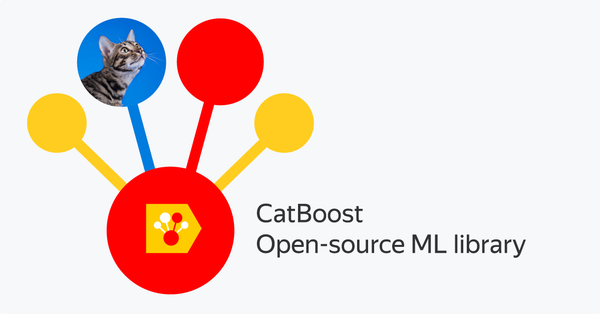   
#### CatBoost - одна из лучших библиотек градиентного бустинга, разработанная специалистами Яндекс.
#### Open source python фреймворк для задач:  
- Бинарной и мультиклассовой классификации  
- Регрессии  
- Ранжирования    

#### Основные возможности:  
- Расширенные возможности работы   
  с категориальными признаками 
- Работа с тектом (NLP)  
- Возможность кастомизации модели 
- Возможность визуализации процесса обучения
- Детектор переобучения (отслеживание метрик\и)   
- Обработка пропущенных значений  

**Полезные материалы:**  
- <a href="https://catboost.ai/">Документация CatBoost</a>   
- <a href="https://www.youtube.com/watch?v=g-bPnhKU0P8/">Youtube-видео - CatBoost: ML в поиске: инфраструктура и алгоритмы</a>   
- <a href="https://www.youtube.com/watch?v=Q_xa4RvnDcY">Youtube-видео - CatBoost: новое поколение градиентного бустинга</a>

### Сравним результат нескольких алгоритмов:      
- CatBoost: стандартные параметры. Датасет с числовыми и категориальными признаками (без текстового).  
- CatBoost: стандартные параметры. Датасет с текстовым признаком "description", числовыми и категориальными признаками.
- CatBoost: оптимизация при помощи Optuna. Датасет с числовыми и категориальными признаками (из текста вручную извлечены признаки при помощи: tf-idf, NLTK, clustering).  
- CatBoost: оптимизация при помощи Optuna. Датасет с текстовым признаком "description", числовыми и категориальными признаками (признак "description" в изначальной форме без каких-либо преобразований).

### CatBoost: стандартные параметры.  Датасет с числовыми и категор. признаками (без текстового)
#### Для обучения модели используется датасет с числовыми и категориальными признаками. Из текста вручную извлечены признаки при помощи: tf-idf, NLTK, clustering.

Обучение всех алгоритмов проводится на кросс-валидации на трех фолдах.   
Алгоритм со стандартными параметрами. Добавлены только "eval_metric", "custom_metric", "random_seed" и др.

In [413]:
print(f'Обучающая выборка с числовыми и категориальными признаком (без текстового). \n\nРазмер: {X_cb.shape}')  # (86854, 33)
print(f'\nНаличие пропусков: \n{X_cb.isna().sum()[X_cb.isna().sum() > 0]}')
display(X_cb.head(3))

Обучающая выборка с числовыми и категориальными признаком (без текстового). 

Размер: (86854, 33)

Наличие пропусков: 
enginePower                  1
mileage_per_year          1335
production_market_diff       1
dtype: int64


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  compound_sentiment_score  positive_score  negative_score  \
0  -0.515                    -0.230          -0.208          -0.102   
1  -0.515                    -0.230          -0.208          -0.102   
2   1.941                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705

In [414]:
# Обучение и валидация модели 
simple_cb_model = CatBoostRegressor(eval_metric = 'MAPE',
                                    custom_metric = ['MAE'],
                                    thread_count = -1,
                                    silent = True,
                                    task_type = "CPU",
                                    random_seed = RANDOM_SEED)

compute_cv(simple_cb_model, X_cb, y, label = 'CatBoostRegressor')
print(f'MAPE: {mape_exp(y, simple_cb_model.predict(X_cb)) * 100:.5f} %')

0it [00:00, ?it/s]

Learning rate set to 0.096303
0:	learn: 0.0566457	test: 0.0567065	best: 0.0567065 (0)	total: 199ms	remaining: 3m 18s
100:	learn: 0.0119691	test: 0.0121192	best: 0.0121192 (100)	total: 15.2s	remaining: 2m 15s
200:	learn: 0.0108238	test: 0.0110652	best: 0.0110652 (200)	total: 29.9s	remaining: 1m 59s
300:	learn: 0.0102386	test: 0.0105814	best: 0.0105814 (300)	total: 46s	remaining: 1m 46s
400:	learn: 0.0098579	test: 0.0102820	best: 0.0102820 (400)	total: 1m 1s	remaining: 1m 31s
500:	learn: 0.0095955	test: 0.0100973	best: 0.0100973 (500)	total: 1m 17s	remaining: 1m 17s
600:	learn: 0.0093803	test: 0.0099660	best: 0.0099660 (600)	total: 1m 33s	remaining: 1m 1s
700:	learn: 0.0092036	test: 0.0098612	best: 0.0098612 (700)	total: 1m 49s	remaining: 46.9s
800:	learn: 0.0090578	test: 0.0097848	best: 0.0097848 (800)	total: 2m 6s	remaining: 31.5s
900:	learn: 0.0089329	test: 0.0097251	best: 0.0097251 (900)	total: 2m 22s	remaining: 15.7s
999:	learn: 0.0088176	test: 0.0096700	best: 0.0096700 (999)	total:

### CatBoost: стандартные параметры. Датасет с текстовым, числовыми и категориальными признаками
#### Алгоритму подается текстовый признак "description" в изначальной форме без каких-либо преобразований

In [416]:
print(f'Обучающая выборка с числовыми, категориальными и текстовым признаком "description" в изначальной форме\n\nРазмер: {X_cb_text.shape}')  (86854, 28)
print(f'\nНаличие пропусков: \n{X_cb_text.isna().sum()[X_cb_text.isna().sum() > 0]}')
display(X_cb_text.head(3))
display(X_cb_text[['description']].sample(5))

Обучающая выборка с числовыми, категориальными и текстовым признаком "description" в изначальной форме

Размер: (86854, 28)

Наличие пропусков: 
enginePower                  1
mileage_per_year          1335
production_market_diff       1
dtype: int64


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   

   dealer  description_cluster  description_len  description_len_log  \
0  -0.515                    0           -0.448               -0.292   
1  -0.515                    0           -0.530               -0.717   
2   1.941                    1            0.103                0.739   

   description_rough_NaN  price_cut  production_market_diff  \
0                 -0.165     -2.287                  -0.705   
1                 -0.165     -2.287                   0.969   
2                 -0.165     -2.287                  -0.705   

                                                   description  
0   Машина  в приличном состоянии ,не гнилая не ржавая .По ...  
1  Машина в оригинале не гнилая все вопросы по телефону. Пт...  
2  ПТС Оригинал!\nПолный комплект ключей!\nПо результатам к...

description
39552                    В хорошем состоянии,вложений не требует .
81448  Машина под восстановление для того, кто захочет этим зан...
67668  Эксклюзивные условия в Фольксваген Центр Север.\n\nТольк...
9148   ———————————————————————————\nФУНКЦИОНАЛЬНОЕ ОБОРУДОВАНИЕ...
59464  Весь срок владения -ОДИН ВОДИТЕЛЬ (ОДИН ВЛАДЕЛЕЦ)!\nПрой...

In [417]:
# Обучение и валидация модели
text_features_list = ['description']

simple_text_model = CatBoostRegressor(eval_metric = 'MAPE',
                                      custom_metric = ['MAE'],
                                      thread_count = -1,
                                      silent = True,
                                      task_type = "CPU",
                                      random_seed = RANDOM_SEED)

compute_cv(simple_text_model, X_cb_text, y, label = 'CatBoostRegressor_text')
print(f'MAPE: {mape_exp(y, simple_text_model.predict(X_cb_text)) * 100:.5f} %')

0it [00:00, ?it/s]

Learning rate set to 0.096303
0:	learn: 0.0566447	test: 0.0567064	best: 0.0567064 (0)	total: 590ms	remaining: 9m 49s
100:	learn: 0.0121775	test: 0.0123191	best: 0.0123191 (100)	total: 36.9s	remaining: 5m 28s
200:	learn: 0.0109662	test: 0.0111973	best: 0.0111973 (200)	total: 1m 9s	remaining: 4m 34s
300:	learn: 0.0103361	test: 0.0106834	best: 0.0106834 (300)	total: 1m 42s	remaining: 3m 58s
400:	learn: 0.0098900	test: 0.0103426	best: 0.0103426 (400)	total: 2m 15s	remaining: 3m 21s
500:	learn: 0.0095545	test: 0.0100995	best: 0.0100995 (500)	total: 2m 49s	remaining: 2m 48s
600:	learn: 0.0092858	test: 0.0099190	best: 0.0099190 (600)	total: 3m 23s	remaining: 2m 15s
700:	learn: 0.0090771	test: 0.0097892	best: 0.0097892 (700)	total: 4m	remaining: 1m 42s
800:	learn: 0.0089055	test: 0.0096973	best: 0.0096972 (799)	total: 4m 32s	remaining: 1m 7s
900:	learn: 0.0087354	test: 0.0096046	best: 0.0096046 (900)	total: 5m 5s	remaining: 33.5s
999:	learn: 0.0085919	test: 0.0095384	best: 0.0095383 (998)	tota

In [420]:
print(f'CatBoost со стандартными параметрами. Данные без текстового признака. MAPE (train data): {mape_exp(y, simple_cb_model.predict(X_cb)) * 100:.5f} %')
print(f'CatBoost со стандартными параметрами. Данные c текстовым признаком. MAPE (train data): {mape_exp(y, simple_text_model.predict(X_cb_text)) * 100:.5f} %')

CatBoost со стандартными параметрами. Данные без текстового признака. MAPE (train data): 12.15151 %
CatBoost со стандартными параметрами. Данные c текстовым признаком. MAPE (train data): 11.75209 %


In [421]:
# Посмотрим стандартные параметры модели (simple_cb_model)
for key, value in simple_cb_model.get_all_params().items():
    print(key, value)

nan_mode Min
eval_metric MAPE
combinations_ctr ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations 1000
sampling_frequency PerTree
fold_permutation_block 0
leaf_estimation_method Newton
counter_calc_method SkipTest
grow_policy SymmetricTree
penalties_coefficient 1
boosting_type Plain
model_shrink_mode Constant
feature_border_type GreedyLogSum
ctr_leaf_count_limit 18446744073709551615
bayesian_matrix_reg 0.10000000149011612
one_hot_max_size 2
eval_fraction 0
force_unit_auto_pair_weights False
l2_leaf_reg 3
random_strength 1
rsm 1
boost_from_average True
max_ctr_complexity 4
model_size_reg 0.5
simple_ctr ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options {'tags': {}}
subsample 

In [422]:
# Посмотрим стандартные параметры модели (simple_text_model)
simple_text_model_params = simple_text_model.get_all_params()

for key, value in simple_text_model_params.items():
    print(key, value)

nan_mode Min
eval_metric MAPE
combinations_ctr ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations 1000
sampling_frequency PerTree
fold_permutation_block 0
leaf_estimation_method Newton
counter_calc_method SkipTest
grow_policy SymmetricTree
penalties_coefficient 1
boosting_type Plain
model_shrink_mode Constant
feature_border_type GreedyLogSum
ctr_leaf_count_limit 18446744073709551615
bayesian_matrix_reg 0.10000000149011612
one_hot_max_size 2
eval_fraction 0
force_unit_auto_pair_weights False
l2_leaf_reg 3
random_strength 1
rsm 1
boost_from_average True
max_ctr_complexity 4
model_size_reg 0.5
simple_ctr ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options {'tags': {}}
subsample 

In [423]:
text_processing_params = simple_text_model_params['text_processing']
text_processing_params

{'dictionaries': [{'start_token_id': '0',
   'occurrence_lower_bound': '5',
   'skip_step': '0',
   'end_of_word_token_policy': 'Insert',
   'token_level_type': 'Word',
   'end_of_sentence_token_policy': 'Skip',
   'gram_order': '2',
   'max_dictionary_size': '50000',
   'dictionary_id': 'BiGram'},
  {'start_token_id': '0',
   'occurrence_lower_bound': '5',
   'skip_step': '0',
   'end_of_word_token_policy': 'Insert',
   'token_level_type': 'Word',
   'end_of_sentence_token_policy': 'Skip',
   'gram_order': '1',
   'max_dictionary_size': '50000',
   'dictionary_id': 'Word'}],
 'feature_processing': {'default': [{'dictionaries_names': ['BiGram', 'Word'],
    'feature_calcers': ['BoW'],
    'tokenizers_names': ['Space']}]},
 'tokenizers': [{'number_token': '🔢',
   'skip_empty': '1',
   'number_process_policy': 'LeaveAsIs',
   'tokenizer_id': 'Space',
   'token_types': ['Number', 'Unknown', 'Word'],
   'delimiter': ' ',
   'languages': [],
   'lemmatizing': '0',
   'split_by_set': '0',
  

### CatBoost: оптимизация при помощи Optuna. Датасет с числ. и категор. признаками (без текстового)
#### Для обучения модели используется датасет с числовыми и категориальными признаками. Из текста вручную извлечены признаки при помощи: tf-idf, NLTK, clustering.

In [21]:
def objective_CatBoost(trial):
    parameters = {
                    "iterations" : trial.suggest_int("iterations", 50, 1000), 
                    "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3, step = 0.01),
                    "depth" : trial.suggest_int("depth", 2, 10),
                    "random_strength" : trial.suggest_int("random_strength", 0, 10), 
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),  # "Plain"
                    "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 0, 100, step = 1),
                    "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["MVS"])    # "Bayesian", "Bernoulli"
                 }  
    
   
    model = CatBoostRegressor(
                                **parameters,
                                eval_metric = 'MAPE',
#                                 custom_metric = ['MAE'],
                                thread_count = -1,
                                silent = True,
                                task_type = "CPU",  
                                random_seed = RANDOM_SEED
                            )
    
    res = compute_cv(model, X_cb, y, label = 'CatBoostRegressor')  
    print(res)    
    return res[0] + res[1]

In [22]:
study_CatBoost = optuna.create_study(study_name = 'Study_CatBoost')
study_CatBoost.optimize(objective_CatBoost, n_trials = 140, show_progress_bar = True)

[I 2023-09-27 00:53:12,108] A new study created in memory with name: Study_CatBoost


  0%|          | 0/140 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0:	learn: 0.0546018	test: 0.0542999	best: 0.0542999 (0)	total: 66.9ms	remaining: 57.1s
100:	learn: 0.0140436	test: 0.0139903	best: 0.0139903 (100)	total: 6.85s	remaining: 51.1s
200:	learn: 0.0128945	test: 0.0127990	best: 0.0127990 (200)	total: 13.7s	remaining: 44.4s
300:	learn: 0.0122402	test: 0.0121650	best: 0.0121650 (300)	total: 21.7s	remaining: 39.8s
400:	learn: 0.0117596	test: 0.0117114	best: 0.0117114 (400)	total: 28.7s	remaining: 32.4s
500:	learn: 0.0114340	test: 0.0113818	best: 0.0113818 (500)	total: 36.3s	remaining: 25.6s
600:	learn: 0.0111410	test: 0.0111011	best: 0.0111011 (600)	total: 43.4s	remaining: 18.3s
700:	learn: 0.0109276	test: 0.0109053	best: 0.0109053 (700)	total: 50.9s	remaining: 11.1s
800:	learn: 0.0107707	test: 0.0107765	best: 0.0107765 (800)	total: 58s	remaining: 3.84s
853:	learn: 0.0107180	test: 0.0107362	best: 0.0107362 (853)	total: 1m 1s	remaining: 0us

bestTest = 0.0107362497
bestIteration = 853

0:	learn: 0.0544727	test: 0.0550444	best: 0.0550444 (0)	total

0it [00:00, ?it/s]

0:	learn: 0.0606562	test: 0.0603357	best: 0.0603357 (0)	total: 49.2ms	remaining: 42.1s
100:	learn: 0.0196559	test: 0.0193942	best: 0.0193942 (100)	total: 4.41s	remaining: 33s
200:	learn: 0.0162809	test: 0.0161902	best: 0.0161902 (200)	total: 8.79s	remaining: 28.7s
300:	learn: 0.0155888	test: 0.0155511	best: 0.0155511 (300)	total: 13.5s	remaining: 24.9s
400:	learn: 0.0150391	test: 0.0150140	best: 0.0150140 (400)	total: 17.8s	remaining: 20.3s
500:	learn: 0.0145811	test: 0.0145582	best: 0.0145582 (500)	total: 22s	remaining: 15.6s
600:	learn: 0.0142015	test: 0.0141864	best: 0.0141864 (600)	total: 26.3s	remaining: 11.2s
700:	learn: 0.0139278	test: 0.0139077	best: 0.0139077 (700)	total: 30.8s	remaining: 6.81s
800:	learn: 0.0137204	test: 0.0137034	best: 0.0137034 (800)	total: 35s	remaining: 2.41s
855:	learn: 0.0136225	test: 0.0136111	best: 0.0136111 (855)	total: 37.5s	remaining: 0us

bestTest = 0.01361106453
bestIteration = 855

0:	learn: 0.0605135	test: 0.0610962	best: 0.0610962 (0)	total: 4

0it [00:00, ?it/s]

0:	learn: 0.0490042	test: 0.0488407	best: 0.0488407 (0)	total: 239ms	remaining: 2m 13s
100:	learn: 0.0108981	test: 0.0110108	best: 0.0110108 (100)	total: 25.7s	remaining: 1m 57s
200:	learn: 0.0100185	test: 0.0103136	best: 0.0103136 (200)	total: 52.4s	remaining: 1m 34s
300:	learn: 0.0096211	test: 0.0100670	best: 0.0100670 (300)	total: 1m 17s	remaining: 1m 7s
400:	learn: 0.0093461	test: 0.0099075	best: 0.0099075 (400)	total: 1m 42s	remaining: 41.2s
500:	learn: 0.0091296	test: 0.0098202	best: 0.0098189 (495)	total: 2m 7s	remaining: 15.6s
561:	learn: 0.0090400	test: 0.0097794	best: 0.0097794 (560)	total: 2m 23s	remaining: 0us

bestTest = 0.00977936269
bestIteration = 560

0:	learn: 0.0489147	test: 0.0494112	best: 0.0494112 (0)	total: 240ms	remaining: 2m 14s
100:	learn: 0.0108356	test: 0.0111270	best: 0.0111270 (100)	total: 23.6s	remaining: 1m 47s
200:	learn: 0.0098593	test: 0.0102881	best: 0.0102881 (200)	total: 48.1s	remaining: 1m 26s
300:	learn: 0.0095251	test: 0.0100903	best: 0.0100903 

0it [00:00, ?it/s]

0:	learn: 0.0587157	test: 0.0583913	best: 0.0583913 (0)	total: 74.3ms	remaining: 31.3s
100:	learn: 0.0157293	test: 0.0156534	best: 0.0156534 (100)	total: 6.74s	remaining: 21.4s
200:	learn: 0.0143626	test: 0.0142977	best: 0.0142977 (200)	total: 12.9s	remaining: 14.2s
300:	learn: 0.0134476	test: 0.0133866	best: 0.0133866 (300)	total: 19.6s	remaining: 7.87s
400:	learn: 0.0128678	test: 0.0128015	best: 0.0128015 (400)	total: 25.9s	remaining: 1.35s
421:	learn: 0.0128058	test: 0.0127378	best: 0.0127378 (421)	total: 27.1s	remaining: 0us

bestTest = 0.01273775931
bestIteration = 421

0:	learn: 0.0585715	test: 0.0591614	best: 0.0591614 (0)	total: 67ms	remaining: 28.2s
100:	learn: 0.0154803	test: 0.0154271	best: 0.0154271 (100)	total: 7.01s	remaining: 22.3s
200:	learn: 0.0144270	test: 0.0144223	best: 0.0144223 (200)	total: 13.1s	remaining: 14.4s
300:	learn: 0.0135697	test: 0.0136068	best: 0.0136068 (300)	total: 19.3s	remaining: 7.77s
400:	learn: 0.0130250	test: 0.0130589	best: 0.0130586 (397)	tot

0it [00:00, ?it/s]

0:	learn: 0.0501556	test: 0.0497981	best: 0.0497981 (0)	total: 96.9ms	remaining: 1m 34s
100:	learn: 0.0127201	test: 0.0126882	best: 0.0126882 (100)	total: 9.17s	remaining: 1m 19s
200:	learn: 0.0115910	test: 0.0116328	best: 0.0116328 (200)	total: 18.7s	remaining: 1m 11s
300:	learn: 0.0109731	test: 0.0110453	best: 0.0110453 (300)	total: 27.8s	remaining: 1m 2s
400:	learn: 0.0105687	test: 0.0106628	best: 0.0106628 (400)	total: 37.7s	remaining: 54s
500:	learn: 0.0103100	test: 0.0104577	best: 0.0104577 (500)	total: 47.1s	remaining: 44.6s
600:	learn: 0.0100751	test: 0.0102562	best: 0.0102556 (599)	total: 56.9s	remaining: 35.4s
700:	learn: 0.0099352	test: 0.0101450	best: 0.0101450 (700)	total: 1m 6s	remaining: 26s
800:	learn: 0.0098194	test: 0.0100541	best: 0.0100541 (800)	total: 1m 15s	remaining: 16.5s
900:	learn: 0.0097089	test: 0.0099691	best: 0.0099691 (900)	total: 1m 25s	remaining: 7.02s
974:	learn: 0.0096340	test: 0.0099080	best: 0.0099080 (974)	total: 1m 32s	remaining: 0us

bestTest = 0

0it [00:00, ?it/s]

0:	learn: 0.0536390	test: 0.0532927	best: 0.0532927 (0)	total: 49ms	remaining: 9.5s
100:	learn: 0.0131823	test: 0.0132157	best: 0.0132157 (100)	total: 4.81s	remaining: 4.48s
194:	learn: 0.0122466	test: 0.0123034	best: 0.0123034 (194)	total: 9.46s	remaining: 0us

bestTest = 0.01230341483
bestIteration = 194

0:	learn: 0.0535252	test: 0.0540633	best: 0.0540633 (0)	total: 48.7ms	remaining: 9.45s
100:	learn: 0.0133810	test: 0.0135363	best: 0.0135363 (100)	total: 4.73s	remaining: 4.4s
194:	learn: 0.0122835	test: 0.0124702	best: 0.0124702 (194)	total: 9.38s	remaining: 0us

bestTest = 0.01247023386
bestIteration = 194

0:	learn: 0.0535806	test: 0.0538430	best: 0.0538430 (0)	total: 47ms	remaining: 9.11s
100:	learn: 0.0135270	test: 0.0135572	best: 0.0135572 (100)	total: 4.84s	remaining: 4.51s
194:	learn: 0.0125169	test: 0.0125550	best: 0.0125550 (194)	total: 9.31s	remaining: 0us

bestTest = 0.01255503665
bestIteration = 194

0:	learn: 0.0536283	test: 0.0534158	best: 0.0534158 (0)	total: 46.5ms	

0it [00:00, ?it/s]

0:	learn: 0.0612837	test: 0.0609654	best: 0.0609654 (0)	total: 103ms	remaining: 6.07s
59:	learn: 0.0379454	test: 0.0376845	best: 0.0376845 (59)	total: 6.21s	remaining: 0us

bestTest = 0.03768447067
bestIteration = 59

0:	learn: 0.0611454	test: 0.0617248	best: 0.0617248 (0)	total: 104ms	remaining: 6.15s
59:	learn: 0.0378210	test: 0.0382816	best: 0.0382816 (59)	total: 6.29s	remaining: 0us

bestTest = 0.03828160072
bestIteration = 59

0:	learn: 0.0611790	test: 0.0614698	best: 0.0614698 (0)	total: 109ms	remaining: 6.46s
59:	learn: 0.0378650	test: 0.0380081	best: 0.0380081 (59)	total: 6.2s	remaining: 0us

bestTest = 0.03800807267
bestIteration = 59

0:	learn: 0.0612969	test: 0.0609551	best: 0.0609551 (0)	total: 117ms	remaining: 6.88s
59:	learn: 0.0378881	test: 0.0377687	best: 0.0377687 (59)	total: 6.73s	remaining: 0us

bestTest = 0.03776865672
bestIteration = 59

0:	learn: 0.0612330	test: 0.0610295	best: 0.0610295 (0)	total: 108ms	remaining: 6.36s
59:	learn: 0.0378652	test: 0.0376786	best: 

0it [00:00, ?it/s]

0:	learn: 0.0536934	test: 0.0534189	best: 0.0534189 (0)	total: 97.1ms	remaining: 32.6s
100:	learn: 0.0132493	test: 0.0131458	best: 0.0131458 (100)	total: 8.95s	remaining: 20.9s
200:	learn: 0.0118888	test: 0.0118329	best: 0.0118329 (200)	total: 17.9s	remaining: 12.1s
300:	learn: 0.0112921	test: 0.0112833	best: 0.0112831 (298)	total: 26.6s	remaining: 3.18s
336:	learn: 0.0111460	test: 0.0111522	best: 0.0111522 (336)	total: 29.5s	remaining: 0us

bestTest = 0.01115224384
bestIteration = 336

0:	learn: 0.0535758	test: 0.0541302	best: 0.0541302 (0)	total: 81ms	remaining: 27.2s
100:	learn: 0.0134058	test: 0.0135051	best: 0.0135051 (100)	total: 8.61s	remaining: 20.1s
200:	learn: 0.0120105	test: 0.0121139	best: 0.0121139 (200)	total: 17.1s	remaining: 11.5s
300:	learn: 0.0113200	test: 0.0114431	best: 0.0114431 (300)	total: 25.8s	remaining: 3.09s
336:	learn: 0.0111166	test: 0.0112518	best: 0.0112518 (336)	total: 28.9s	remaining: 0us

bestTest = 0.01125180249
bestIteration = 336

0:	learn: 0.053271

0it [00:00, ?it/s]

0:	learn: 0.0569368	test: 0.0566030	best: 0.0566030 (0)	total: 47ms	remaining: 24.4s
100:	learn: 0.0157832	test: 0.0157831	best: 0.0157831 (100)	total: 3.79s	remaining: 15.7s
200:	learn: 0.0143004	test: 0.0143120	best: 0.0143120 (200)	total: 7.49s	remaining: 11.9s
300:	learn: 0.0136250	test: 0.0136378	best: 0.0136378 (300)	total: 11.4s	remaining: 8.27s
400:	learn: 0.0131881	test: 0.0131911	best: 0.0131911 (400)	total: 14.9s	remaining: 4.43s
500:	learn: 0.0129278	test: 0.0129107	best: 0.0129107 (500)	total: 18.5s	remaining: 702ms
519:	learn: 0.0128661	test: 0.0128470	best: 0.0128470 (519)	total: 19.2s	remaining: 0us

bestTest = 0.01284698351
bestIteration = 519

0:	learn: 0.0567836	test: 0.0573788	best: 0.0573788 (0)	total: 38.7ms	remaining: 20.1s
100:	learn: 0.0160481	test: 0.0160444	best: 0.0160444 (100)	total: 3.94s	remaining: 16.3s
200:	learn: 0.0146191	test: 0.0146746	best: 0.0146744 (198)	total: 7.77s	remaining: 12.3s
300:	learn: 0.0138487	test: 0.0139265	best: 0.0139265 (300)	tot

0it [00:00, ?it/s]

0:	learn: 0.0552188	test: 0.0549429	best: 0.0549429 (0)	total: 316ms	remaining: 3m 7s
100:	learn: 0.0120180	test: 0.0120110	best: 0.0120110 (100)	total: 27.1s	remaining: 2m 12s
200:	learn: 0.0107819	test: 0.0108634	best: 0.0108634 (200)	total: 56s	remaining: 1m 49s
300:	learn: 0.0102589	test: 0.0104304	best: 0.0104304 (300)	total: 1m 25s	remaining: 1m 23s
400:	learn: 0.0099440	test: 0.0101831	best: 0.0101831 (400)	total: 1m 54s	remaining: 55.4s
500:	learn: 0.0096987	test: 0.0099836	best: 0.0099836 (500)	total: 2m 23s	remaining: 27s
594:	learn: 0.0095195	test: 0.0098516	best: 0.0098516 (594)	total: 2m 52s	remaining: 0us

bestTest = 0.009851631622
bestIteration = 594

0:	learn: 0.0553127	test: 0.0558934	best: 0.0558934 (0)	total: 328ms	remaining: 3m 14s
100:	learn: 0.0122575	test: 0.0124072	best: 0.0124072 (100)	total: 24.1s	remaining: 1m 57s
200:	learn: 0.0109198	test: 0.0111125	best: 0.0111125 (200)	total: 52.9s	remaining: 1m 43s
300:	learn: 0.0104127	test: 0.0106632	best: 0.0106632 (3

0it [00:00, ?it/s]

0:	learn: 0.0507109	test: 0.0504452	best: 0.0504452 (0)	total: 172ms	remaining: 2m 51s
100:	learn: 0.0112395	test: 0.0112895	best: 0.0112895 (100)	total: 1m 4s	remaining: 9m 35s
200:	learn: 0.0099264	test: 0.0101631	best: 0.0101631 (200)	total: 2m 20s	remaining: 9m 17s
300:	learn: 0.0095316	test: 0.0098909	best: 0.0098903 (297)	total: 3m 37s	remaining: 8m 21s
400:	learn: 0.0092635	test: 0.0097227	best: 0.0097222 (399)	total: 4m 52s	remaining: 7m 14s
500:	learn: 0.0090667	test: 0.0096105	best: 0.0096102 (498)	total: 6m 11s	remaining: 6m 7s
600:	learn: 0.0088886	test: 0.0095233	best: 0.0095233 (600)	total: 7m 31s	remaining: 4m 56s
700:	learn: 0.0087732	test: 0.0094758	best: 0.0094752 (698)	total: 8m 49s	remaining: 3m 42s
800:	learn: 0.0086592	test: 0.0094294	best: 0.0094294 (800)	total: 10m 7s	remaining: 2m 27s
900:	learn: 0.0085581	test: 0.0093979	best: 0.0093973 (898)	total: 11m 25s	remaining: 1m 12s
995:	learn: 0.0084660	test: 0.0093761	best: 0.0093754 (990)	total: 12m 42s	remaining: 

0it [00:00, ?it/s]

0:	learn: 0.0503070	test: 0.0500411	best: 0.0500411 (0)	total: 171ms	remaining: 2m 47s
100:	learn: 0.0112045	test: 0.0112624	best: 0.0112624 (100)	total: 1m 2s	remaining: 9m 1s
200:	learn: 0.0100836	test: 0.0102705	best: 0.0102705 (200)	total: 2m 18s	remaining: 8m 56s
300:	learn: 0.0096356	test: 0.0099358	best: 0.0099358 (300)	total: 3m 33s	remaining: 8m 2s
400:	learn: 0.0093173	test: 0.0097168	best: 0.0097168 (400)	total: 4m 51s	remaining: 7m 2s
500:	learn: 0.0090991	test: 0.0095830	best: 0.0095830 (498)	total: 6m 7s	remaining: 5m 52s
600:	learn: 0.0089275	test: 0.0095113	best: 0.0095113 (600)	total: 7m 26s	remaining: 4m 43s
700:	learn: 0.0087982	test: 0.0094662	best: 0.0094657 (698)	total: 8m 46s	remaining: 3m 31s
800:	learn: 0.0086950	test: 0.0094304	best: 0.0094304 (800)	total: 10m 5s	remaining: 2m 16s
900:	learn: 0.0085873	test: 0.0093908	best: 0.0093891 (896)	total: 11m 25s	remaining: 1m 1s
981:	learn: 0.0085147	test: 0.0093679	best: 0.0093679 (981)	total: 12m 31s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0486535	test: 0.0483888	best: 0.0483888 (0)	total: 170ms	remaining: 2m 5s
100:	learn: 0.0110289	test: 0.0111813	best: 0.0111813 (100)	total: 1m 1s	remaining: 6m 26s
200:	learn: 0.0099221	test: 0.0102580	best: 0.0102579 (199)	total: 2m 16s	remaining: 6m 3s
300:	learn: 0.0094359	test: 0.0099134	best: 0.0099134 (300)	total: 3m 31s	remaining: 5m 6s
400:	learn: 0.0091429	test: 0.0097240	best: 0.0097240 (400)	total: 4m 48s	remaining: 4m 2s
500:	learn: 0.0089375	test: 0.0096179	best: 0.0096179 (500)	total: 6m 5s	remaining: 2m 52s
600:	learn: 0.0087702	test: 0.0095539	best: 0.0095539 (600)	total: 7m 21s	remaining: 1m 40s
700:	learn: 0.0086298	test: 0.0094980	best: 0.0094980 (700)	total: 8m 43s	remaining: 26.9s
736:	learn: 0.0085978	test: 0.0094870	best: 0.0094870 (736)	total: 9m 12s	remaining: 0us

bestTest = 0.009486951848
bestIteration = 736

0:	learn: 0.0485514	test: 0.0491096	best: 0.0491096 (0)	total: 172ms	remaining: 2m 6s
100:	learn: 0.0111559	test: 0.0113216	best: 0.0113215

0it [00:00, ?it/s]

0:	learn: 0.0511224	test: 0.0508568	best: 0.0508568 (0)	total: 176ms	remaining: 2m 54s
100:	learn: 0.0111803	test: 0.0112689	best: 0.0112689 (100)	total: 1m	remaining: 8m 54s
200:	learn: 0.0098895	test: 0.0101482	best: 0.0101482 (200)	total: 2m 13s	remaining: 8m 47s
300:	learn: 0.0094390	test: 0.0098160	best: 0.0098158 (298)	total: 3m 31s	remaining: 8m 7s
400:	learn: 0.0092075	test: 0.0096787	best: 0.0096787 (400)	total: 4m 50s	remaining: 7m 9s
500:	learn: 0.0089636	test: 0.0095272	best: 0.0095272 (499)	total: 6m 8s	remaining: 6m 1s
600:	learn: 0.0088178	test: 0.0094668	best: 0.0094665 (589)	total: 7m 26s	remaining: 4m 51s
700:	learn: 0.0086777	test: 0.0094152	best: 0.0094150 (699)	total: 8m 44s	remaining: 3m 38s
800:	learn: 0.0085584	test: 0.0093588	best: 0.0093588 (800)	total: 10m 5s	remaining: 2m 25s
900:	learn: 0.0084459	test: 0.0093122	best: 0.0093122 (900)	total: 11m 24s	remaining: 1m 9s
992:	learn: 0.0083612	test: 0.0092834	best: 0.0092834 (992)	total: 12m 41s	remaining: 0us

be

0it [00:00, ?it/s]

0:	learn: 0.0511024	test: 0.0508371	best: 0.0508371 (0)	total: 183ms	remaining: 2m 15s
100:	learn: 0.0117044	test: 0.0117785	best: 0.0117785 (100)	total: 36.7s	remaining: 3m 53s
200:	learn: 0.0102924	test: 0.0104643	best: 0.0104643 (200)	total: 1m 23s	remaining: 3m 44s
300:	learn: 0.0097571	test: 0.0100444	best: 0.0100444 (300)	total: 2m 8s	remaining: 3m 8s
400:	learn: 0.0094371	test: 0.0098290	best: 0.0098290 (397)	total: 2m 55s	remaining: 2m 30s
500:	learn: 0.0091779	test: 0.0096779	best: 0.0096779 (500)	total: 3m 42s	remaining: 1m 47s
600:	learn: 0.0089932	test: 0.0095634	best: 0.0095634 (600)	total: 4m 30s	remaining: 1m 4s
700:	learn: 0.0088467	test: 0.0094924	best: 0.0094924 (700)	total: 5m 19s	remaining: 19.1s
742:	learn: 0.0087952	test: 0.0094640	best: 0.0094640 (742)	total: 5m 40s	remaining: 0us

bestTest = 0.009463958644
bestIteration = 742

0:	learn: 0.0509971	test: 0.0515599	best: 0.0515599 (0)	total: 160ms	remaining: 1m 58s
100:	learn: 0.0115107	test: 0.0116784	best: 0.0116

0it [00:00, ?it/s]

0:	learn: 0.0519551	test: 0.0516896	best: 0.0516896 (0)	total: 166ms	remaining: 2m 2s
100:	learn: 0.0115127	test: 0.0115637	best: 0.0115637 (100)	total: 39.8s	remaining: 4m 11s
200:	learn: 0.0104431	test: 0.0106178	best: 0.0106178 (200)	total: 1m 26s	remaining: 3m 50s
300:	learn: 0.0098391	test: 0.0101213	best: 0.0101209 (298)	total: 2m 12s	remaining: 3m 12s
400:	learn: 0.0095133	test: 0.0098889	best: 0.0098889 (400)	total: 2m 58s	remaining: 2m 29s
500:	learn: 0.0093168	test: 0.0097640	best: 0.0097640 (499)	total: 3m 45s	remaining: 1m 46s
600:	learn: 0.0091264	test: 0.0096469	best: 0.0096469 (600)	total: 4m 33s	remaining: 1m 2s
700:	learn: 0.0090123	test: 0.0095872	best: 0.0095872 (700)	total: 5m 22s	remaining: 17s
737:	learn: 0.0089556	test: 0.0095597	best: 0.0095597 (737)	total: 5m 39s	remaining: 0us

bestTest = 0.009559689995
bestIteration = 737

0:	learn: 0.0518479	test: 0.0524130	best: 0.0524130 (0)	total: 162ms	remaining: 1m 59s
100:	learn: 0.0116824	test: 0.0118375	best: 0.01183

0it [00:00, ?it/s]

0:	learn: 0.0533339	test: 0.0529876	best: 0.0529876 (0)	total: 321ms	remaining: 3m 44s
100:	learn: 0.0122941	test: 0.0122349	best: 0.0122349 (100)	total: 28s	remaining: 2m 46s
200:	learn: 0.0108651	test: 0.0109404	best: 0.0109404 (200)	total: 57.8s	remaining: 2m 23s
300:	learn: 0.0101720	test: 0.0103458	best: 0.0103458 (300)	total: 1m 28s	remaining: 1m 57s
400:	learn: 0.0098390	test: 0.0100959	best: 0.0100959 (400)	total: 1m 59s	remaining: 1m 29s
500:	learn: 0.0096032	test: 0.0099461	best: 0.0099461 (500)	total: 2m 30s	remaining: 60s
600:	learn: 0.0094081	test: 0.0098104	best: 0.0098104 (600)	total: 3m 1s	remaining: 30.2s
700:	learn: 0.0092707	test: 0.0097293	best: 0.0097293 (700)	total: 3m 33s	remaining: 0us

bestTest = 0.009729332729
bestIteration = 700

0:	learn: 0.0531970	test: 0.0537964	best: 0.0537964 (0)	total: 335ms	remaining: 3m 54s
100:	learn: 0.0122504	test: 0.0124744	best: 0.0124744 (100)	total: 24.7s	remaining: 2m 26s
200:	learn: 0.0110121	test: 0.0112573	best: 0.0112570 (

0it [00:00, ?it/s]

0:	learn: 0.0528066	test: 0.0524630	best: 0.0524630 (0)	total: 348ms	remaining: 4m 17s
100:	learn: 0.0116335	test: 0.0116944	best: 0.0116944 (100)	total: 29.3s	remaining: 3m 5s
200:	learn: 0.0102620	test: 0.0105185	best: 0.0105185 (200)	total: 59.2s	remaining: 2m 38s
300:	learn: 0.0097999	test: 0.0101695	best: 0.0101695 (300)	total: 1m 29s	remaining: 2m 10s
400:	learn: 0.0094583	test: 0.0099217	best: 0.0099217 (400)	total: 2m	remaining: 1m 41s
500:	learn: 0.0092820	test: 0.0098052	best: 0.0098052 (499)	total: 2m 31s	remaining: 1m 12s
600:	learn: 0.0091358	test: 0.0097235	best: 0.0097235 (600)	total: 3m 3s	remaining: 42.5s
700:	learn: 0.0090038	test: 0.0096683	best: 0.0096683 (700)	total: 3m 35s	remaining: 12s
739:	learn: 0.0089576	test: 0.0096411	best: 0.0096411 (739)	total: 3m 47s	remaining: 0us

bestTest = 0.009641137426
bestIteration = 739

0:	learn: 0.0518461	test: 0.0523637	best: 0.0523637 (0)	total: 287ms	remaining: 3m 32s
100:	learn: 0.0117801	test: 0.0119629	best: 0.0119629 (10

0it [00:00, ?it/s]

0:	learn: 0.0501958	test: 0.0499314	best: 0.0499314 (0)	total: 178ms	remaining: 1m 56s
100:	learn: 0.0111563	test: 0.0112323	best: 0.0112323 (100)	total: 40.9s	remaining: 3m 45s
200:	learn: 0.0100599	test: 0.0102714	best: 0.0102714 (200)	total: 1m 25s	remaining: 3m 15s
300:	learn: 0.0096477	test: 0.0099930	best: 0.0099930 (300)	total: 2m 11s	remaining: 2m 36s
400:	learn: 0.0093564	test: 0.0097907	best: 0.0097907 (400)	total: 3m	remaining: 1m 55s
500:	learn: 0.0091796	test: 0.0096951	best: 0.0096951 (500)	total: 3m 47s	remaining: 1m 11s
600:	learn: 0.0090363	test: 0.0096265	best: 0.0096265 (600)	total: 4m 34s	remaining: 26s
657:	learn: 0.0089835	test: 0.0096057	best: 0.0096057 (657)	total: 5m 1s	remaining: 0us

bestTest = 0.009605721632
bestIteration = 657

0:	learn: 0.0500924	test: 0.0506521	best: 0.0506521 (0)	total: 172ms	remaining: 1m 52s
100:	learn: 0.0112412	test: 0.0114528	best: 0.0114528 (100)	total: 40.3s	remaining: 3m 42s
200:	learn: 0.0101510	test: 0.0105142	best: 0.0105141 (

0it [00:00, ?it/s]

0:	learn: 0.0536812	test: 0.0534137	best: 0.0534137 (0)	total: 190ms	remaining: 2m 38s
100:	learn: 0.0124671	test: 0.0124748	best: 0.0124748 (100)	total: 17.5s	remaining: 2m 7s
200:	learn: 0.0111986	test: 0.0112494	best: 0.0112494 (200)	total: 35.8s	remaining: 1m 53s
300:	learn: 0.0104841	test: 0.0105739	best: 0.0105739 (300)	total: 53.9s	remaining: 1m 36s
400:	learn: 0.0101970	test: 0.0103205	best: 0.0103205 (400)	total: 1m 12s	remaining: 1m 19s
500:	learn: 0.0099912	test: 0.0101591	best: 0.0101591 (500)	total: 1m 31s	remaining: 1m 1s
600:	learn: 0.0098036	test: 0.0100155	best: 0.0100153 (598)	total: 1m 50s	remaining: 43.6s
700:	learn: 0.0096565	test: 0.0099092	best: 0.0099092 (700)	total: 2m 8s	remaining: 25.3s
800:	learn: 0.0095661	test: 0.0098513	best: 0.0098513 (800)	total: 2m 27s	remaining: 6.99s
838:	learn: 0.0095246	test: 0.0098207	best: 0.0098207 (838)	total: 2m 34s	remaining: 0us

bestTest = 0.009820717644
bestIteration = 838

0:	learn: 0.0534791	test: 0.0540635	best: 0.05406

0it [00:00, ?it/s]

0:	learn: 0.0565529	test: 0.0562450	best: 0.0562450 (0)	total: 155ms	remaining: 1m 13s
100:	learn: 0.0128406	test: 0.0128906	best: 0.0128906 (100)	total: 17.4s	remaining: 1m 4s
200:	learn: 0.0116275	test: 0.0116834	best: 0.0116834 (200)	total: 35.4s	remaining: 48.8s
300:	learn: 0.0109419	test: 0.0110233	best: 0.0110233 (300)	total: 53.5s	remaining: 31.4s
400:	learn: 0.0105870	test: 0.0107093	best: 0.0107093 (400)	total: 1m 11s	remaining: 13.7s
477:	learn: 0.0104038	test: 0.0105521	best: 0.0105521 (477)	total: 1m 25s	remaining: 0us

bestTest = 0.0105520738
bestIteration = 477

0:	learn: 0.0564282	test: 0.0569797	best: 0.0569797 (0)	total: 156ms	remaining: 1m 14s
100:	learn: 0.0131315	test: 0.0132750	best: 0.0132750 (100)	total: 17.7s	remaining: 1m 6s
200:	learn: 0.0118097	test: 0.0119644	best: 0.0119644 (200)	total: 34.1s	remaining: 47s
300:	learn: 0.0111084	test: 0.0112600	best: 0.0112600 (299)	total: 50.5s	remaining: 29.7s
400:	learn: 0.0107611	test: 0.0109445	best: 0.0109444 (399)	to

0it [00:00, ?it/s]

0:	learn: 0.0515315	test: 0.0512662	best: 0.0512662 (0)	total: 175ms	remaining: 2m 25s
100:	learn: 0.0115951	test: 0.0116104	best: 0.0116104 (100)	total: 38.2s	remaining: 4m 36s
200:	learn: 0.0103263	test: 0.0104380	best: 0.0104379 (199)	total: 1m 23s	remaining: 4m 21s
300:	learn: 0.0098161	test: 0.0100567	best: 0.0100567 (300)	total: 2m 7s	remaining: 3m 45s
400:	learn: 0.0095005	test: 0.0098224	best: 0.0098224 (400)	total: 2m 52s	remaining: 3m 6s
500:	learn: 0.0092577	test: 0.0096667	best: 0.0096667 (500)	total: 3m 39s	remaining: 2m 25s
600:	learn: 0.0090827	test: 0.0095624	best: 0.0095624 (600)	total: 4m 27s	remaining: 1m 43s
700:	learn: 0.0089446	test: 0.0094959	best: 0.0094959 (700)	total: 5m 15s	remaining: 59.5s
800:	learn: 0.0088005	test: 0.0094267	best: 0.0094265 (797)	total: 6m 4s	remaining: 14.5s
832:	learn: 0.0087678	test: 0.0094091	best: 0.0094091 (832)	total: 6m 19s	remaining: 0us

bestTest = 0.009409100165
bestIteration = 832

0:	learn: 0.0514251	test: 0.0519891	best: 0.05

0it [00:00, ?it/s]

0:	learn: 0.0515097	test: 0.0512447	best: 0.0512447 (0)	total: 175ms	remaining: 2m 14s
100:	learn: 0.0115490	test: 0.0116655	best: 0.0116655 (100)	total: 39.8s	remaining: 4m 22s
200:	learn: 0.0101974	test: 0.0104220	best: 0.0104220 (200)	total: 1m 25s	remaining: 4m 1s
300:	learn: 0.0096767	test: 0.0100353	best: 0.0100350 (298)	total: 2m 10s	remaining: 3m 23s
400:	learn: 0.0093754	test: 0.0098216	best: 0.0098216 (400)	total: 2m 55s	remaining: 2m 40s
500:	learn: 0.0091719	test: 0.0096931	best: 0.0096931 (500)	total: 3m 41s	remaining: 1m 58s
600:	learn: 0.0090360	test: 0.0096122	best: 0.0096121 (599)	total: 4m 29s	remaining: 1m 14s
700:	learn: 0.0089097	test: 0.0095387	best: 0.0095387 (700)	total: 5m 17s	remaining: 30.3s
767:	learn: 0.0088381	test: 0.0095127	best: 0.0095127 (767)	total: 5m 49s	remaining: 0us

bestTest = 0.009512708227
bestIteration = 767

0:	learn: 0.0512991	test: 0.0518778	best: 0.0518778 (0)	total: 307ms	remaining: 3m 55s
100:	learn: 0.0113179	test: 0.0115254	best: 0.01

0it [00:00, ?it/s]

0:	learn: 0.0494432	test: 0.0491775	best: 0.0491775 (0)	total: 165ms	remaining: 2m 30s
100:	learn: 0.0109678	test: 0.0110598	best: 0.0110598 (100)	total: 40.3s	remaining: 5m 23s
200:	learn: 0.0099017	test: 0.0101478	best: 0.0101478 (200)	total: 1m 23s	remaining: 4m 56s
300:	learn: 0.0095221	test: 0.0098542	best: 0.0098542 (300)	total: 2m 7s	remaining: 4m 19s
400:	learn: 0.0093142	test: 0.0097208	best: 0.0097208 (400)	total: 2m 52s	remaining: 3m 40s
500:	learn: 0.0091212	test: 0.0095916	best: 0.0095911 (499)	total: 3m 38s	remaining: 2m 59s
600:	learn: 0.0089782	test: 0.0095277	best: 0.0095265 (586)	total: 4m 22s	remaining: 2m 16s
700:	learn: 0.0088325	test: 0.0094559	best: 0.0094555 (698)	total: 5m 8s	remaining: 1m 33s
800:	learn: 0.0087090	test: 0.0093998	best: 0.0093998 (800)	total: 5m 54s	remaining: 49.5s
900:	learn: 0.0086334	test: 0.0093803	best: 0.0093803 (900)	total: 6m 40s	remaining: 5.33s
912:	learn: 0.0086232	test: 0.0093749	best: 0.0093749 (912)	total: 6m 45s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0519781	test: 0.0517122	best: 0.0517122 (0)	total: 157ms	remaining: 1m 39s
100:	learn: 0.0111714	test: 0.0112305	best: 0.0112305 (100)	total: 53.7s	remaining: 4m 43s
200:	learn: 0.0101229	test: 0.0103158	best: 0.0103158 (200)	total: 2m 2s	remaining: 4m 22s
300:	learn: 0.0097043	test: 0.0099835	best: 0.0099835 (300)	total: 3m 9s	remaining: 3m 29s
400:	learn: 0.0093468	test: 0.0097494	best: 0.0097494 (400)	total: 4m 21s	remaining: 2m 31s
500:	learn: 0.0091114	test: 0.0095977	best: 0.0095977 (500)	total: 5m 32s	remaining: 1m 28s
600:	learn: 0.0089540	test: 0.0095126	best: 0.0095126 (600)	total: 6m 44s	remaining: 22.2s
633:	learn: 0.0089147	test: 0.0094938	best: 0.0094938 (633)	total: 7m 8s	remaining: 0us

bestTest = 0.009493782737
bestIteration = 633

0:	learn: 0.0517645	test: 0.0523439	best: 0.0523439 (0)	total: 326ms	remaining: 3m 26s
100:	learn: 0.0115787	test: 0.0118153	best: 0.0118153 (100)	total: 55.3s	remaining: 4m 51s
200:	learn: 0.0103818	test: 0.0106964	best: 0.01069

0it [00:00, ?it/s]

0:	learn: 0.0523675	test: 0.0521017	best: 0.0521017 (0)	total: 169ms	remaining: 1m 49s
100:	learn: 0.0119012	test: 0.0119147	best: 0.0119147 (100)	total: 19.6s	remaining: 1m 45s
200:	learn: 0.0107195	test: 0.0108232	best: 0.0108232 (200)	total: 40.1s	remaining: 1m 28s
300:	learn: 0.0101934	test: 0.0103631	best: 0.0103631 (300)	total: 1m 1s	remaining: 1m 10s
400:	learn: 0.0098991	test: 0.0101302	best: 0.0101302 (400)	total: 1m 23s	remaining: 51.1s
500:	learn: 0.0096991	test: 0.0099964	best: 0.0099964 (500)	total: 1m 45s	remaining: 30.6s
600:	learn: 0.0095223	test: 0.0098811	best: 0.0098804 (597)	total: 2m 7s	remaining: 9.57s
645:	learn: 0.0094537	test: 0.0098337	best: 0.0098337 (645)	total: 2m 18s	remaining: 0us

bestTest = 0.00983374854
bestIteration = 645

0:	learn: 0.0521627	test: 0.0527425	best: 0.0527425 (0)	total: 221ms	remaining: 2m 22s
100:	learn: 0.0119459	test: 0.0120960	best: 0.0120960 (100)	total: 18.5s	remaining: 1m 39s
200:	learn: 0.0107802	test: 0.0109732	best: 0.0109732 

0it [00:00, ?it/s]

0:	learn: 0.0532078	test: 0.0529338	best: 0.0529338 (0)	total: 211ms	remaining: 1m 22s
100:	learn: 0.0120781	test: 0.0120839	best: 0.0120839 (100)	total: 25.3s	remaining: 1m 13s
200:	learn: 0.0105950	test: 0.0107183	best: 0.0107183 (200)	total: 53.4s	remaining: 51s
300:	learn: 0.0101451	test: 0.0103302	best: 0.0103302 (300)	total: 1m 21s	remaining: 24.9s
392:	learn: 0.0098100	test: 0.0100644	best: 0.0100644 (392)	total: 1m 48s	remaining: 0us

bestTest = 0.01006440644
bestIteration = 392

0:	learn: 0.0535539	test: 0.0541387	best: 0.0541387 (0)	total: 321ms	remaining: 2m 5s
100:	learn: 0.0122777	test: 0.0123799	best: 0.0123799 (100)	total: 24.2s	remaining: 1m 10s
200:	learn: 0.0108777	test: 0.0110495	best: 0.0110495 (200)	total: 53s	remaining: 50.6s
300:	learn: 0.0104720	test: 0.0106761	best: 0.0106761 (300)	total: 1m 20s	remaining: 24.6s
392:	learn: 0.0101428	test: 0.0103940	best: 0.0103940 (392)	total: 1m 46s	remaining: 0us

bestTest = 0.01039402175
bestIteration = 392

0:	learn: 0.053

0it [00:00, ?it/s]

0:	learn: 0.0491803	test: 0.0489490	best: 0.0489490 (0)	total: 455ms	remaining: 4m 45s
100:	learn: 0.0111581	test: 0.0111691	best: 0.0111691 (100)	total: 39s	remaining: 3m 23s
200:	learn: 0.0102512	test: 0.0103640	best: 0.0103640 (200)	total: 1m 23s	remaining: 2m 57s
300:	learn: 0.0097614	test: 0.0099706	best: 0.0099706 (300)	total: 2m 7s	remaining: 2m 19s
400:	learn: 0.0093783	test: 0.0097215	best: 0.0097215 (400)	total: 2m 52s	remaining: 1m 38s
500:	learn: 0.0091675	test: 0.0096072	best: 0.0096072 (499)	total: 3m 38s	remaining: 55.9s
600:	learn: 0.0089495	test: 0.0095055	best: 0.0095055 (600)	total: 4m 26s	remaining: 12.4s
628:	learn: 0.0089077	test: 0.0094911	best: 0.0094910 (626)	total: 4m 39s	remaining: 0us

bestTest = 0.009491027827
bestIteration = 626

0:	learn: 0.0494561	test: 0.0499488	best: 0.0499488 (0)	total: 419ms	remaining: 4m 22s
100:	learn: 0.0116660	test: 0.0118470	best: 0.0118470 (100)	total: 38s	remaining: 3m 18s
200:	learn: 0.0103119	test: 0.0106320	best: 0.0106320 

0it [00:00, ?it/s]

0:	learn: 0.0522348	test: 0.0519712	best: 0.0519712 (0)	total: 164ms	remaining: 2m 10s
100:	learn: 0.0108115	test: 0.0109764	best: 0.0109764 (100)	total: 1m 3s	remaining: 7m 15s
200:	learn: 0.0098147	test: 0.0101610	best: 0.0101610 (200)	total: 2m 12s	remaining: 6m 32s
300:	learn: 0.0093652	test: 0.0098590	best: 0.0098590 (300)	total: 3m 26s	remaining: 5m 40s
400:	learn: 0.0090961	test: 0.0096963	best: 0.0096963 (400)	total: 4m 42s	remaining: 4m 39s
500:	learn: 0.0088733	test: 0.0095861	best: 0.0095861 (500)	total: 5m 59s	remaining: 3m 32s
600:	learn: 0.0087378	test: 0.0095222	best: 0.0095222 (600)	total: 7m 17s	remaining: 2m 23s
700:	learn: 0.0086146	test: 0.0094868	best: 0.0094868 (700)	total: 8m 33s	remaining: 1m 11s
797:	learn: 0.0085052	test: 0.0094465	best: 0.0094464 (794)	total: 9m 50s	remaining: 0us

bestTest = 0.009446418896
bestIteration = 794

0:	learn: 0.0521295	test: 0.0526925	best: 0.0526925 (0)	total: 172ms	remaining: 2m 17s
100:	learn: 0.0108595	test: 0.0110902	best: 0.

0it [00:00, ?it/s]

0:	learn: 0.0549799	test: 0.0547079	best: 0.0547079 (0)	total: 111ms	remaining: 1m 40s
100:	learn: 0.0129378	test: 0.0128444	best: 0.0128444 (100)	total: 11.2s	remaining: 1m 28s
200:	learn: 0.0117019	test: 0.0116154	best: 0.0116154 (200)	total: 22.1s	remaining: 1m 17s
300:	learn: 0.0110603	test: 0.0110126	best: 0.0110126 (300)	total: 33.3s	remaining: 1m 6s
400:	learn: 0.0107110	test: 0.0107164	best: 0.0107164 (400)	total: 44.6s	remaining: 56s
500:	learn: 0.0104312	test: 0.0104618	best: 0.0104618 (500)	total: 55.8s	remaining: 45s
600:	learn: 0.0102265	test: 0.0102976	best: 0.0102976 (600)	total: 1m 8s	remaining: 34.6s
700:	learn: 0.0100517	test: 0.0101506	best: 0.0101506 (700)	total: 1m 20s	remaining: 23.4s
800:	learn: 0.0099277	test: 0.0100562	best: 0.0100562 (800)	total: 1m 32s	remaining: 11.9s
900:	learn: 0.0098218	test: 0.0099850	best: 0.0099850 (900)	total: 1m 43s	remaining: 459ms
904:	learn: 0.0098144	test: 0.0099782	best: 0.0099782 (904)	total: 1m 43s	remaining: 0us

bestTest = 0

0it [00:00, ?it/s]

0:	learn: 0.0503740	test: 0.0500176	best: 0.0500176 (0)	total: 206ms	remaining: 2m 27s
100:	learn: 0.0113058	test: 0.0113840	best: 0.0113840 (100)	total: 38s	remaining: 3m 51s
200:	learn: 0.0099019	test: 0.0101442	best: 0.0101437 (197)	total: 1m 22s	remaining: 3m 31s
300:	learn: 0.0094790	test: 0.0098362	best: 0.0098362 (300)	total: 2m 7s	remaining: 2m 55s
400:	learn: 0.0092230	test: 0.0096740	best: 0.0096740 (400)	total: 2m 52s	remaining: 2m 15s
500:	learn: 0.0090142	test: 0.0095391	best: 0.0095391 (500)	total: 3m 40s	remaining: 1m 34s
600:	learn: 0.0088763	test: 0.0094710	best: 0.0094710 (600)	total: 4m 27s	remaining: 51.2s
700:	learn: 0.0087634	test: 0.0094180	best: 0.0094180 (700)	total: 5m 15s	remaining: 6.75s
715:	learn: 0.0087526	test: 0.0094129	best: 0.0094129 (715)	total: 5m 22s	remaining: 0us

bestTest = 0.009412889202
bestIteration = 715

0:	learn: 0.0502184	test: 0.0507324	best: 0.0507324 (0)	total: 178ms	remaining: 2m 7s
100:	learn: 0.0111841	test: 0.0113945	best: 0.011394

0it [00:00, ?it/s]

0:	learn: 0.0503627	test: 0.0500063	best: 0.0500063 (0)	total: 188ms	remaining: 2m 10s
100:	learn: 0.0111041	test: 0.0112025	best: 0.0112025 (100)	total: 37.7s	remaining: 3m 41s
200:	learn: 0.0098978	test: 0.0101270	best: 0.0101270 (200)	total: 1m 21s	remaining: 3m 19s
300:	learn: 0.0094748	test: 0.0098202	best: 0.0098202 (300)	total: 2m 6s	remaining: 2m 45s
400:	learn: 0.0092130	test: 0.0096503	best: 0.0096503 (400)	total: 2m 52s	remaining: 2m 7s
500:	learn: 0.0090405	test: 0.0095495	best: 0.0095495 (500)	total: 3m 38s	remaining: 1m 25s
600:	learn: 0.0088991	test: 0.0094801	best: 0.0094801 (600)	total: 4m 24s	remaining: 41.8s
695:	learn: 0.0088031	test: 0.0094295	best: 0.0094293 (693)	total: 5m 8s	remaining: 0us

bestTest = 0.009429250398
bestIteration = 693

0:	learn: 0.0502074	test: 0.0507212	best: 0.0507212 (0)	total: 184ms	remaining: 2m 7s
100:	learn: 0.0110654	test: 0.0113076	best: 0.0113074 (99)	total: 35.7s	remaining: 3m 30s
200:	learn: 0.0101510	test: 0.0105040	best: 0.0105040

0it [00:00, ?it/s]

0:	learn: 0.0484901	test: 0.0481955	best: 0.0481955 (0)	total: 224ms	remaining: 2m 6s
100:	learn: 0.0108088	test: 0.0109570	best: 0.0109569 (99)	total: 27.5s	remaining: 2m 6s
200:	learn: 0.0100305	test: 0.0103111	best: 0.0103111 (200)	total: 55.5s	remaining: 1m 40s
300:	learn: 0.0096008	test: 0.0099824	best: 0.0099824 (300)	total: 1m 24s	remaining: 1m 14s
400:	learn: 0.0092901	test: 0.0097682	best: 0.0097682 (400)	total: 1m 53s	remaining: 46.9s
500:	learn: 0.0091057	test: 0.0096467	best: 0.0096464 (499)	total: 2m 23s	remaining: 18.6s
565:	learn: 0.0089957	test: 0.0095678	best: 0.0095678 (565)	total: 2m 43s	remaining: 0us

bestTest = 0.009567783028
bestIteration = 565

0:	learn: 0.0483830	test: 0.0488872	best: 0.0488872 (0)	total: 220ms	remaining: 2m 4s
100:	learn: 0.0111230	test: 0.0113334	best: 0.0113334 (100)	total: 27.4s	remaining: 2m 6s
200:	learn: 0.0101269	test: 0.0104492	best: 0.0104492 (200)	total: 55.5s	remaining: 1m 40s
300:	learn: 0.0095428	test: 0.0100186	best: 0.0100186 (3

0it [00:00, ?it/s]

0:	learn: 0.0472900	test: 0.0469636	best: 0.0469636 (0)	total: 577ms	remaining: 6m 31s
100:	learn: 0.0102322	test: 0.0104977	best: 0.0104977 (100)	total: 1m 1s	remaining: 5m 52s
200:	learn: 0.0093783	test: 0.0098624	best: 0.0098624 (200)	total: 2m 11s	remaining: 5m 11s
300:	learn: 0.0090560	test: 0.0096780	best: 0.0096780 (300)	total: 3m 22s	remaining: 4m 14s
400:	learn: 0.0088222	test: 0.0095744	best: 0.0095727 (397)	total: 4m 36s	remaining: 3m 11s
500:	learn: 0.0086313	test: 0.0094894	best: 0.0094894 (500)	total: 5m 54s	remaining: 2m 5s
600:	learn: 0.0085131	test: 0.0094399	best: 0.0094394 (599)	total: 7m 12s	remaining: 56.2s
678:	learn: 0.0084302	test: 0.0094242	best: 0.0094241 (676)	total: 8m 13s	remaining: 0us

bestTest = 0.00942412689
bestIteration = 676

0:	learn: 0.0471221	test: 0.0476307	best: 0.0476307 (0)	total: 226ms	remaining: 2m 33s
100:	learn: 0.0104838	test: 0.0107320	best: 0.0107320 (100)	total: 1m 1s	remaining: 5m 49s
200:	learn: 0.0095429	test: 0.0099829	best: 0.0099

0it [00:00, ?it/s]

0:	learn: 0.0526799	test: 0.0523778	best: 0.0523778 (0)	total: 224ms	remaining: 2m 55s
100:	learn: 0.0118357	test: 0.0118166	best: 0.0118166 (100)	total: 20s	remaining: 2m 15s
200:	learn: 0.0107187	test: 0.0107795	best: 0.0107795 (200)	total: 41.2s	remaining: 1m 59s
300:	learn: 0.0102550	test: 0.0103953	best: 0.0103953 (300)	total: 1m 2s	remaining: 1m 41s
400:	learn: 0.0099164	test: 0.0101299	best: 0.0101299 (400)	total: 1m 24s	remaining: 1m 21s
500:	learn: 0.0096196	test: 0.0099046	best: 0.0099044 (498)	total: 1m 46s	remaining: 1m
600:	learn: 0.0094392	test: 0.0097828	best: 0.0097828 (600)	total: 2m 9s	remaining: 39.8s
700:	learn: 0.0092864	test: 0.0096970	best: 0.0096967 (699)	total: 2m 31s	remaining: 18.3s
785:	learn: 0.0091804	test: 0.0096326	best: 0.0096326 (785)	total: 2m 50s	remaining: 0us

bestTest = 0.009632633031
bestIteration = 785

0:	learn: 0.0525487	test: 0.0531281	best: 0.0531281 (0)	total: 217ms	remaining: 2m 50s
100:	learn: 0.0119484	test: 0.0120375	best: 0.0120373 (99

0it [00:00, ?it/s]

0:	learn: 0.0526941	test: 0.0523918	best: 0.0523918 (0)	total: 225ms	remaining: 2m 56s
100:	learn: 0.0119856	test: 0.0119706	best: 0.0119706 (100)	total: 19.9s	remaining: 2m 15s
200:	learn: 0.0106166	test: 0.0106989	best: 0.0106989 (200)	total: 41.3s	remaining: 2m
300:	learn: 0.0101093	test: 0.0102791	best: 0.0102790 (299)	total: 1m 2s	remaining: 1m 41s
400:	learn: 0.0098404	test: 0.0100644	best: 0.0100644 (400)	total: 1m 23s	remaining: 1m 21s
500:	learn: 0.0095926	test: 0.0098779	best: 0.0098779 (500)	total: 1m 45s	remaining: 1m
600:	learn: 0.0094110	test: 0.0097491	best: 0.0097490 (599)	total: 2m 7s	remaining: 39.6s
700:	learn: 0.0092471	test: 0.0096633	best: 0.0096625 (696)	total: 2m 28s	remaining: 18.5s
787:	learn: 0.0091416	test: 0.0096034	best: 0.0096029 (786)	total: 2m 47s	remaining: 0us

bestTest = 0.009602915269
bestIteration = 786

0:	learn: 0.0525628	test: 0.0531424	best: 0.0531424 (0)	total: 226ms	remaining: 2m 58s
100:	learn: 0.0118916	test: 0.0120145	best: 0.0120145 (100)

0it [00:00, ?it/s]

0:	learn: 0.0535265	test: 0.0531917	best: 0.0531917 (0)	total: 109ms	remaining: 1m 40s
100:	learn: 0.0127099	test: 0.0126673	best: 0.0126673 (100)	total: 11s	remaining: 1m 29s
200:	learn: 0.0114277	test: 0.0114088	best: 0.0114088 (200)	total: 22s	remaining: 1m 18s
300:	learn: 0.0108577	test: 0.0108829	best: 0.0108829 (300)	total: 33.3s	remaining: 1m 8s
400:	learn: 0.0104788	test: 0.0105696	best: 0.0105696 (400)	total: 45s	remaining: 57.8s
500:	learn: 0.0102088	test: 0.0103291	best: 0.0103291 (500)	total: 56.8s	remaining: 47.1s
600:	learn: 0.0100321	test: 0.0101943	best: 0.0101943 (600)	total: 1m 8s	remaining: 35.8s
700:	learn: 0.0098898	test: 0.0100821	best: 0.0100821 (700)	total: 1m 19s	remaining: 24.5s
800:	learn: 0.0097639	test: 0.0099865	best: 0.0099865 (800)	total: 1m 31s	remaining: 13.2s
900:	learn: 0.0096621	test: 0.0099102	best: 0.0099102 (900)	total: 1m 42s	remaining: 1.82s
916:	learn: 0.0096445	test: 0.0098927	best: 0.0098927 (916)	total: 1m 44s	remaining: 0us

bestTest = 0.0

0it [00:00, ?it/s]

0:	learn: 0.0545124	test: 0.0542221	best: 0.0542221 (0)	total: 171ms	remaining: 1m 42s
100:	learn: 0.0122401	test: 0.0123004	best: 0.0123004 (100)	total: 18.7s	remaining: 1m 32s
200:	learn: 0.0109293	test: 0.0109998	best: 0.0109998 (200)	total: 39.3s	remaining: 1m 18s
300:	learn: 0.0103506	test: 0.0104645	best: 0.0104645 (300)	total: 1m	remaining: 59.9s
400:	learn: 0.0100278	test: 0.0101930	best: 0.0101930 (400)	total: 1m 21s	remaining: 40.5s
500:	learn: 0.0097455	test: 0.0099576	best: 0.0099576 (500)	total: 1m 43s	remaining: 20.4s
599:	learn: 0.0096072	test: 0.0098641	best: 0.0098641 (599)	total: 2m 4s	remaining: 0us

bestTest = 0.009864148347
bestIteration = 599

0:	learn: 0.0543874	test: 0.0549331	best: 0.0549331 (0)	total: 184ms	remaining: 1m 49s
100:	learn: 0.0123356	test: 0.0124843	best: 0.0124843 (100)	total: 18.8s	remaining: 1m 32s
200:	learn: 0.0111678	test: 0.0113592	best: 0.0113592 (200)	total: 39.8s	remaining: 1m 19s
300:	learn: 0.0107056	test: 0.0109370	best: 0.0109368 (29

0it [00:00, ?it/s]

0:	learn: 0.0569099	test: 0.0566011	best: 0.0566011 (0)	total: 305ms	remaining: 2m 42s
100:	learn: 0.0128114	test: 0.0128006	best: 0.0128006 (100)	total: 24.8s	remaining: 1m 46s
200:	learn: 0.0113305	test: 0.0113710	best: 0.0113710 (200)	total: 50.6s	remaining: 1m 23s
300:	learn: 0.0106845	test: 0.0107779	best: 0.0107779 (300)	total: 1m 18s	remaining: 1m
400:	learn: 0.0102869	test: 0.0104338	best: 0.0104338 (400)	total: 1m 45s	remaining: 35.1s
500:	learn: 0.0100627	test: 0.0102587	best: 0.0102587 (500)	total: 2m 12s	remaining: 8.75s
533:	learn: 0.0100128	test: 0.0102218	best: 0.0102218 (533)	total: 2m 22s	remaining: 0us

bestTest = 0.01022176231
bestIteration = 533

0:	learn: 0.0567790	test: 0.0573611	best: 0.0573611 (0)	total: 303ms	remaining: 2m 41s
100:	learn: 0.0129335	test: 0.0130689	best: 0.0130689 (100)	total: 23.5s	remaining: 1m 40s
200:	learn: 0.0115346	test: 0.0117094	best: 0.0117094 (200)	total: 48.4s	remaining: 1m 20s
300:	learn: 0.0107190	test: 0.0109289	best: 0.0109289 (3

0it [00:00, ?it/s]

0:	learn: 0.0524599	test: 0.0521210	best: 0.0521210 (0)	total: 104ms	remaining: 49.7s
100:	learn: 0.0121510	test: 0.0121081	best: 0.0121081 (100)	total: 11.2s	remaining: 41.6s
200:	learn: 0.0111586	test: 0.0112044	best: 0.0112043 (198)	total: 22.4s	remaining: 30.9s
300:	learn: 0.0106613	test: 0.0107588	best: 0.0107588 (300)	total: 33.6s	remaining: 19.7s
400:	learn: 0.0103222	test: 0.0104709	best: 0.0104709 (400)	total: 44.8s	remaining: 8.6s
477:	learn: 0.0101568	test: 0.0103311	best: 0.0103311 (477)	total: 53.4s	remaining: 0us

bestTest = 0.01033108969
bestIteration = 477

0:	learn: 0.0523194	test: 0.0528237	best: 0.0528237 (0)	total: 102ms	remaining: 48.6s
100:	learn: 0.0123427	test: 0.0124400	best: 0.0124400 (100)	total: 10.7s	remaining: 39.9s
200:	learn: 0.0111501	test: 0.0113070	best: 0.0113070 (200)	total: 21.7s	remaining: 29.9s
300:	learn: 0.0105731	test: 0.0107679	best: 0.0107679 (300)	total: 33.1s	remaining: 19.5s
400:	learn: 0.0101925	test: 0.0104425	best: 0.0104425 (400)	tota

0it [00:00, ?it/s]

0:	learn: 0.0599296	test: 0.0596260	best: 0.0596260 (0)	total: 175ms	remaining: 2m 30s
100:	learn: 0.0139708	test: 0.0139273	best: 0.0139273 (100)	total: 20.7s	remaining: 2m 35s
200:	learn: 0.0125460	test: 0.0125448	best: 0.0125448 (200)	total: 42.7s	remaining: 2m 20s
300:	learn: 0.0117845	test: 0.0118112	best: 0.0118112 (300)	total: 1m 2s	remaining: 1m 56s
400:	learn: 0.0111648	test: 0.0112291	best: 0.0112291 (400)	total: 1m 24s	remaining: 1m 36s
500:	learn: 0.0107007	test: 0.0108146	best: 0.0108146 (500)	total: 1m 45s	remaining: 1m 16s
600:	learn: 0.0103847	test: 0.0105493	best: 0.0105493 (600)	total: 2m 7s	remaining: 55.6s
700:	learn: 0.0101909	test: 0.0103959	best: 0.0103959 (700)	total: 2m 30s	remaining: 34.7s
800:	learn: 0.0100658	test: 0.0103000	best: 0.0103000 (800)	total: 2m 52s	remaining: 13.4s
862:	learn: 0.0099839	test: 0.0102359	best: 0.0102359 (862)	total: 3m 6s	remaining: 0us

bestTest = 0.01023590779
bestIteration = 862

0:	learn: 0.0596749	test: 0.0602564	best: 0.06025

0it [00:00, ?it/s]

0:	learn: 0.0526668	test: 0.0523775	best: 0.0523775 (0)	total: 167ms	remaining: 2m 15s
100:	learn: 0.0121218	test: 0.0120649	best: 0.0120649 (100)	total: 15.3s	remaining: 1m 47s
200:	learn: 0.0110009	test: 0.0110153	best: 0.0110153 (200)	total: 31.1s	remaining: 1m 34s
300:	learn: 0.0104982	test: 0.0105724	best: 0.0105723 (299)	total: 46.9s	remaining: 1m 19s
400:	learn: 0.0101544	test: 0.0102849	best: 0.0102849 (400)	total: 1m 3s	remaining: 1m 4s
500:	learn: 0.0099393	test: 0.0101248	best: 0.0101248 (500)	total: 1m 19s	remaining: 49.8s
600:	learn: 0.0097585	test: 0.0099929	best: 0.0099929 (598)	total: 1m 35s	remaining: 34s
700:	learn: 0.0096213	test: 0.0098957	best: 0.0098956 (699)	total: 1m 52s	remaining: 18.1s
800:	learn: 0.0095109	test: 0.0098187	best: 0.0098187 (800)	total: 2m 8s	remaining: 2.08s
813:	learn: 0.0094925	test: 0.0098079	best: 0.0098079 (813)	total: 2m 10s	remaining: 0us

bestTest = 0.009807855237
bestIteration = 813

0:	learn: 0.0525421	test: 0.0531302	best: 0.0531302 

0it [00:00, ?it/s]

0:	learn: 0.0519490	test: 0.0516027	best: 0.0516027 (0)	total: 187ms	remaining: 2m 24s
100:	learn: 0.0118160	test: 0.0118429	best: 0.0118429 (100)	total: 19.6s	remaining: 2m 10s
200:	learn: 0.0107003	test: 0.0108183	best: 0.0108183 (200)	total: 39.6s	remaining: 1m 52s
300:	learn: 0.0101294	test: 0.0103489	best: 0.0103489 (300)	total: 1m	remaining: 1m 33s
400:	learn: 0.0098378	test: 0.0101339	best: 0.0101339 (400)	total: 1m 21s	remaining: 1m 15s
500:	learn: 0.0096235	test: 0.0099813	best: 0.0099813 (500)	total: 1m 43s	remaining: 55.9s
600:	learn: 0.0094839	test: 0.0098799	best: 0.0098799 (600)	total: 2m 4s	remaining: 35.3s
700:	learn: 0.0093142	test: 0.0097568	best: 0.0097568 (700)	total: 2m 26s	remaining: 14.8s
771:	learn: 0.0092191	test: 0.0096923	best: 0.0096923 (771)	total: 2m 41s	remaining: 0us

bestTest = 0.00969233528
bestIteration = 771

0:	learn: 0.0517964	test: 0.0523181	best: 0.0523181 (0)	total: 185ms	remaining: 2m 22s
100:	learn: 0.0119544	test: 0.0120659	best: 0.0120659 (1

0it [00:00, ?it/s]

0:	learn: 0.0504190	test: 0.0501010	best: 0.0501010 (0)	total: 315ms	remaining: 4m 35s
100:	learn: 0.0114071	test: 0.0114458	best: 0.0114458 (100)	total: 25.8s	remaining: 3m 18s
200:	learn: 0.0102848	test: 0.0104891	best: 0.0104889 (199)	total: 54.1s	remaining: 3m 2s
300:	learn: 0.0098269	test: 0.0101197	best: 0.0101197 (300)	total: 1m 23s	remaining: 2m 39s
400:	learn: 0.0095068	test: 0.0098983	best: 0.0098983 (400)	total: 1m 52s	remaining: 2m 13s
500:	learn: 0.0093331	test: 0.0097864	best: 0.0097863 (499)	total: 2m 22s	remaining: 1m 46s
600:	learn: 0.0091522	test: 0.0096806	best: 0.0096806 (600)	total: 2m 51s	remaining: 1m 18s
700:	learn: 0.0090334	test: 0.0096002	best: 0.0096002 (700)	total: 3m 22s	remaining: 50.7s
800:	learn: 0.0089322	test: 0.0095597	best: 0.0095596 (799)	total: 3m 52s	remaining: 22s
876:	learn: 0.0088759	test: 0.0095414	best: 0.0095408 (871)	total: 4m 15s	remaining: 0us

bestTest = 0.009540772846
bestIteration = 871

0:	learn: 0.0502962	test: 0.0508802	best: 0.050

0it [00:00, ?it/s]

0:	learn: 0.0495283	test: 0.0492413	best: 0.0492413 (0)	total: 225ms	remaining: 3m 20s
100:	learn: 0.0114805	test: 0.0115344	best: 0.0115344 (100)	total: 25.8s	remaining: 3m 21s
200:	learn: 0.0102286	test: 0.0104019	best: 0.0104019 (200)	total: 53.8s	remaining: 3m 5s
300:	learn: 0.0097570	test: 0.0100341	best: 0.0100341 (300)	total: 1m 21s	remaining: 2m 40s
400:	learn: 0.0095027	test: 0.0098677	best: 0.0098674 (395)	total: 1m 50s	remaining: 2m 15s
500:	learn: 0.0093043	test: 0.0097337	best: 0.0097337 (500)	total: 2m 20s	remaining: 1m 49s
600:	learn: 0.0091391	test: 0.0096323	best: 0.0096323 (600)	total: 2m 50s	remaining: 1m 22s
700:	learn: 0.0090268	test: 0.0095747	best: 0.0095747 (700)	total: 3m 20s	remaining: 54.5s
800:	learn: 0.0089209	test: 0.0095183	best: 0.0095183 (800)	total: 3m 49s	remaining: 26.1s
891:	learn: 0.0088417	test: 0.0094909	best: 0.0094909 (891)	total: 4m 16s	remaining: 0us

bestTest = 0.009490923528
bestIteration = 891

0:	learn: 0.0494203	test: 0.0499400	best: 0.0

0it [00:00, ?it/s]

0:	learn: 0.0495110	test: 0.0492247	best: 0.0492247 (0)	total: 246ms	remaining: 3m 37s
100:	learn: 0.0112451	test: 0.0113277	best: 0.0113277 (100)	total: 26.5s	remaining: 3m 25s
200:	learn: 0.0102574	test: 0.0104433	best: 0.0104433 (200)	total: 54.7s	remaining: 3m 6s
300:	learn: 0.0098354	test: 0.0101167	best: 0.0101167 (300)	total: 1m 24s	remaining: 2m 43s
400:	learn: 0.0094839	test: 0.0098642	best: 0.0098642 (400)	total: 1m 54s	remaining: 2m 17s
500:	learn: 0.0092770	test: 0.0097211	best: 0.0097211 (500)	total: 2m 23s	remaining: 1m 50s
600:	learn: 0.0091062	test: 0.0096153	best: 0.0096129 (595)	total: 2m 54s	remaining: 1m 22s
700:	learn: 0.0089914	test: 0.0095648	best: 0.0095648 (700)	total: 3m 24s	remaining: 53.7s
800:	learn: 0.0089027	test: 0.0095294	best: 0.0095294 (800)	total: 3m 54s	remaining: 24.6s
884:	learn: 0.0088303	test: 0.0094983	best: 0.0094983 (884)	total: 4m 19s	remaining: 0us

bestTest = 0.00949829051
bestIteration = 884

0:	learn: 0.0494019	test: 0.0499216	best: 0.04

0it [00:00, ?it/s]

0:	learn: 0.0462974	test: 0.0460276	best: 0.0460276 (0)	total: 220ms	remaining: 3m 30s
100:	learn: 0.0106002	test: 0.0107912	best: 0.0107899 (97)	total: 25.8s	remaining: 3m 38s
200:	learn: 0.0097202	test: 0.0100890	best: 0.0100890 (200)	total: 52.7s	remaining: 3m 18s
300:	learn: 0.0093270	test: 0.0098099	best: 0.0098099 (300)	total: 1m 22s	remaining: 2m 59s
400:	learn: 0.0091017	test: 0.0096794	best: 0.0096794 (400)	total: 1m 51s	remaining: 2m 34s
500:	learn: 0.0089475	test: 0.0096088	best: 0.0096088 (500)	total: 2m 21s	remaining: 2m 8s
600:	learn: 0.0087818	test: 0.0095200	best: 0.0095191 (593)	total: 2m 50s	remaining: 1m 41s
700:	learn: 0.0086820	test: 0.0094830	best: 0.0094830 (700)	total: 3m 20s	remaining: 1m 13s
800:	learn: 0.0086064	test: 0.0094627	best: 0.0094625 (798)	total: 3m 49s	remaining: 44.7s
900:	learn: 0.0085262	test: 0.0094420	best: 0.0094420 (899)	total: 4m 19s	remaining: 16.1s
956:	learn: 0.0084764	test: 0.0094209	best: 0.0094208 (953)	total: 4m 35s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0488624	test: 0.0485402	best: 0.0485402 (0)	total: 168ms	remaining: 2m 38s
100:	learn: 0.0113535	test: 0.0114201	best: 0.0114201 (100)	total: 19.5s	remaining: 2m 42s
200:	learn: 0.0102967	test: 0.0104707	best: 0.0104707 (200)	total: 39.5s	remaining: 2m 26s
300:	learn: 0.0098458	test: 0.0101151	best: 0.0101151 (300)	total: 60s	remaining: 2m 8s
400:	learn: 0.0095826	test: 0.0099300	best: 0.0099300 (400)	total: 1m 21s	remaining: 1m 50s
500:	learn: 0.0093638	test: 0.0097765	best: 0.0097765 (500)	total: 1m 42s	remaining: 1m 31s
600:	learn: 0.0092227	test: 0.0096902	best: 0.0096892 (596)	total: 2m 5s	remaining: 1m 11s
700:	learn: 0.0091178	test: 0.0096367	best: 0.0096367 (700)	total: 2m 26s	remaining: 51s
800:	learn: 0.0090207	test: 0.0095806	best: 0.0095804 (799)	total: 2m 47s	remaining: 30.2s
900:	learn: 0.0089456	test: 0.0095365	best: 0.0095355 (892)	total: 3m 9s	remaining: 9.27s
944:	learn: 0.0089124	test: 0.0095257	best: 0.0095249 (936)	total: 3m 19s	remaining: 0us

bestTest

0it [00:00, ?it/s]

0:	learn: 0.0480828	test: 0.0477770	best: 0.0477770 (0)	total: 331ms	remaining: 1m 28s
100:	learn: 0.0112363	test: 0.0114246	best: 0.0114246 (100)	total: 36.8s	remaining: 1m 1s
200:	learn: 0.0100517	test: 0.0103508	best: 0.0103508 (200)	total: 1m 19s	remaining: 26.8s
268:	learn: 0.0097160	test: 0.0100825	best: 0.0100825 (268)	total: 1m 49s	remaining: 0us

bestTest = 0.01008247381
bestIteration = 268

0:	learn: 0.0479555	test: 0.0484676	best: 0.0484676 (0)	total: 232ms	remaining: 1m 2s
100:	learn: 0.0112658	test: 0.0114531	best: 0.0114531 (100)	total: 37.5s	remaining: 1m 2s
200:	learn: 0.0102312	test: 0.0105098	best: 0.0105098 (200)	total: 1m 20s	remaining: 27.1s
268:	learn: 0.0098321	test: 0.0101887	best: 0.0101887 (268)	total: 1m 49s	remaining: 0us

bestTest = 0.01018871787
bestIteration = 268

0:	learn: 0.0479919	test: 0.0481857	best: 0.0481857 (0)	total: 241ms	remaining: 1m 4s
100:	learn: 0.0111722	test: 0.0113631	best: 0.0113631 (100)	total: 37s	remaining: 1m 1s
200:	learn: 0.01007

0it [00:00, ?it/s]

0:	learn: 0.0495066	test: 0.0492205	best: 0.0492205 (0)	total: 258ms	remaining: 3m 41s
100:	learn: 0.0112367	test: 0.0113275	best: 0.0113275 (100)	total: 25.8s	remaining: 3m 13s
200:	learn: 0.0102279	test: 0.0104365	best: 0.0104365 (200)	total: 52.7s	remaining: 2m 52s
300:	learn: 0.0098433	test: 0.0101341	best: 0.0101341 (300)	total: 1m 20s	remaining: 2m 30s
400:	learn: 0.0095822	test: 0.0099633	best: 0.0099633 (400)	total: 1m 49s	remaining: 2m 4s
500:	learn: 0.0093869	test: 0.0098200	best: 0.0098200 (500)	total: 2m 18s	remaining: 1m 39s
600:	learn: 0.0091960	test: 0.0096904	best: 0.0096904 (600)	total: 2m 47s	remaining: 1m 12s
700:	learn: 0.0090705	test: 0.0096172	best: 0.0096167 (699)	total: 3m 17s	remaining: 44.8s
800:	learn: 0.0089373	test: 0.0095396	best: 0.0095396 (800)	total: 3m 46s	remaining: 16.7s
859:	learn: 0.0088850	test: 0.0095214	best: 0.0095214 (856)	total: 4m 4s	remaining: 0us

bestTest = 0.009521374306
bestIteration = 856

0:	learn: 0.0493973	test: 0.0499169	best: 0.04

0it [00:00, ?it/s]

0:	learn: 0.0524321	test: 0.0520609	best: 0.0520609 (0)	total: 42.1ms	remaining: 30.2s
100:	learn: 0.0146296	test: 0.0146751	best: 0.0146751 (100)	total: 3.65s	remaining: 22.4s
200:	learn: 0.0133988	test: 0.0134044	best: 0.0134044 (200)	total: 7.16s	remaining: 18.5s
300:	learn: 0.0127773	test: 0.0127870	best: 0.0127870 (300)	total: 11s	remaining: 15.3s
400:	learn: 0.0123900	test: 0.0124122	best: 0.0124122 (400)	total: 14.8s	remaining: 11.8s
500:	learn: 0.0121584	test: 0.0121643	best: 0.0121643 (500)	total: 18.2s	remaining: 7.94s
600:	learn: 0.0119703	test: 0.0120015	best: 0.0120015 (600)	total: 21.5s	remaining: 4.26s
700:	learn: 0.0118066	test: 0.0118416	best: 0.0118414 (696)	total: 25s	remaining: 679ms
719:	learn: 0.0117646	test: 0.0117983	best: 0.0117983 (719)	total: 25.7s	remaining: 0us

bestTest = 0.01179833263
bestIteration = 719

0:	learn: 0.0522588	test: 0.0528739	best: 0.0528739 (0)	total: 37.9ms	remaining: 27.2s
100:	learn: 0.0148228	test: 0.0148830	best: 0.0148830 (100)	total

0it [00:00, ?it/s]

0:	learn: 0.0495066	test: 0.0492205	best: 0.0492205 (0)	total: 249ms	remaining: 3m 41s
100:	learn: 0.0112367	test: 0.0113275	best: 0.0113275 (100)	total: 25.3s	remaining: 3m 17s
200:	learn: 0.0102279	test: 0.0104365	best: 0.0104365 (200)	total: 52.9s	remaining: 3m 1s
300:	learn: 0.0098433	test: 0.0101341	best: 0.0101341 (300)	total: 1m 22s	remaining: 2m 40s
400:	learn: 0.0095822	test: 0.0099633	best: 0.0099633 (400)	total: 1m 50s	remaining: 2m 15s
500:	learn: 0.0093869	test: 0.0098200	best: 0.0098200 (500)	total: 2m 21s	remaining: 1m 49s
600:	learn: 0.0091960	test: 0.0096904	best: 0.0096904 (600)	total: 2m 51s	remaining: 1m 22s
700:	learn: 0.0090705	test: 0.0096172	best: 0.0096167 (699)	total: 3m 21s	remaining: 54.4s
800:	learn: 0.0089373	test: 0.0095396	best: 0.0095396 (800)	total: 3m 51s	remaining: 25.7s
889:	learn: 0.0088469	test: 0.0094998	best: 0.0094998 (889)	total: 4m 18s	remaining: 0us

bestTest = 0.009499764469
bestIteration = 889

0:	learn: 0.0493973	test: 0.0499169	best: 0.0

0it [00:00, ?it/s]

0:	learn: 0.0497426	test: 0.0494393	best: 0.0494393 (0)	total: 231ms	remaining: 3m 25s
100:	learn: 0.0113165	test: 0.0114092	best: 0.0114092 (100)	total: 26.3s	remaining: 3m 25s
200:	learn: 0.0102937	test: 0.0104995	best: 0.0104995 (200)	total: 53s	remaining: 3m 2s
300:	learn: 0.0098269	test: 0.0101246	best: 0.0101246 (300)	total: 1m 22s	remaining: 2m 41s
400:	learn: 0.0095151	test: 0.0099035	best: 0.0099035 (400)	total: 1m 51s	remaining: 2m 15s
500:	learn: 0.0093275	test: 0.0097806	best: 0.0097805 (496)	total: 2m 19s	remaining: 1m 48s
600:	learn: 0.0091386	test: 0.0096662	best: 0.0096658 (599)	total: 2m 49s	remaining: 1m 21s
700:	learn: 0.0089902	test: 0.0095828	best: 0.0095828 (700)	total: 3m 19s	remaining: 54.1s
800:	learn: 0.0089291	test: 0.0095581	best: 0.0095579 (799)	total: 3m 49s	remaining: 25.7s
890:	learn: 0.0088457	test: 0.0095109	best: 0.0095109 (890)	total: 4m 15s	remaining: 0us

bestTest = 0.0095108712
bestIteration = 890

0:	learn: 0.0496307	test: 0.0501479	best: 0.05014

0it [00:00, ?it/s]

0:	learn: 0.0514778	test: 0.0511280	best: 0.0511280 (0)	total: 192ms	remaining: 3m 1s
100:	learn: 0.0114993	test: 0.0115555	best: 0.0115555 (100)	total: 35.7s	remaining: 4m 59s
200:	learn: 0.0102161	test: 0.0104187	best: 0.0104187 (200)	total: 1m 18s	remaining: 4m 53s
300:	learn: 0.0097479	test: 0.0100490	best: 0.0100490 (300)	total: 2m 2s	remaining: 4m 22s
400:	learn: 0.0094635	test: 0.0098360	best: 0.0098360 (400)	total: 2m 46s	remaining: 3m 47s
500:	learn: 0.0092782	test: 0.0097353	best: 0.0097353 (500)	total: 3m 31s	remaining: 3m 9s
600:	learn: 0.0091214	test: 0.0096326	best: 0.0096326 (600)	total: 4m 17s	remaining: 2m 29s
700:	learn: 0.0089717	test: 0.0095471	best: 0.0095470 (698)	total: 5m 5s	remaining: 1m 48s
800:	learn: 0.0088825	test: 0.0095028	best: 0.0095028 (800)	total: 5m 52s	remaining: 1m 5s
900:	learn: 0.0087822	test: 0.0094571	best: 0.0094571 (899)	total: 6m 39s	remaining: 21.3s
948:	learn: 0.0087347	test: 0.0094363	best: 0.0094363 (948)	total: 7m 2s	remaining: 0us

bes

0it [00:00, ?it/s]

0:	learn: 0.0514778	test: 0.0511280	best: 0.0511280 (0)	total: 185ms	remaining: 2m 54s
100:	learn: 0.0114993	test: 0.0115555	best: 0.0115555 (100)	total: 36.1s	remaining: 5m 1s
200:	learn: 0.0102161	test: 0.0104187	best: 0.0104187 (200)	total: 1m 19s	remaining: 4m 54s
300:	learn: 0.0097479	test: 0.0100490	best: 0.0100490 (300)	total: 2m 6s	remaining: 4m 29s
400:	learn: 0.0094635	test: 0.0098360	best: 0.0098360 (400)	total: 2m 51s	remaining: 3m 51s
500:	learn: 0.0092782	test: 0.0097353	best: 0.0097353 (500)	total: 3m 35s	remaining: 3m 10s
600:	learn: 0.0091214	test: 0.0096326	best: 0.0096326 (600)	total: 4m 22s	remaining: 2m 29s
700:	learn: 0.0089717	test: 0.0095471	best: 0.0095470 (698)	total: 5m 9s	remaining: 1m 46s
800:	learn: 0.0088825	test: 0.0095028	best: 0.0095028 (800)	total: 5m 57s	remaining: 1m 3s
900:	learn: 0.0087822	test: 0.0094571	best: 0.0094571 (899)	total: 6m 48s	remaining: 19s
942:	learn: 0.0087399	test: 0.0094386	best: 0.0094386 (941)	total: 7m 9s	remaining: 0us

best

0it [00:00, ?it/s]

0:	learn: 0.0514842	test: 0.0511345	best: 0.0511345 (0)	total: 185ms	remaining: 2m 56s
100:	learn: 0.0115071	test: 0.0115390	best: 0.0115390 (100)	total: 38s	remaining: 5m 20s
200:	learn: 0.0103298	test: 0.0104915	best: 0.0104915 (200)	total: 1m 21s	remaining: 5m 6s
300:	learn: 0.0098383	test: 0.0101065	best: 0.0101065 (300)	total: 2m 5s	remaining: 4m 31s
400:	learn: 0.0095058	test: 0.0098729	best: 0.0098729 (400)	total: 2m 51s	remaining: 3m 55s
500:	learn: 0.0092928	test: 0.0097288	best: 0.0097287 (499)	total: 3m 40s	remaining: 3m 19s
600:	learn: 0.0091295	test: 0.0096333	best: 0.0096333 (600)	total: 4m 26s	remaining: 2m 36s
700:	learn: 0.0089430	test: 0.0095187	best: 0.0095187 (700)	total: 5m 13s	remaining: 1m 53s
800:	learn: 0.0088605	test: 0.0094897	best: 0.0094897 (800)	total: 6m	remaining: 1m 8s
900:	learn: 0.0087760	test: 0.0094484	best: 0.0094484 (900)	total: 6m 48s	remaining: 24s
953:	learn: 0.0087400	test: 0.0094351	best: 0.0094351 (953)	total: 7m 13s	remaining: 0us

bestTest

0it [00:00, ?it/s]

0:	learn: 0.0545118	test: 0.0541487	best: 0.0541487 (0)	total: 841ms	remaining: 13m 2s
100:	learn: 0.0121933	test: 0.0122094	best: 0.0122094 (100)	total: 53.6s	remaining: 7m 20s
200:	learn: 0.0105904	test: 0.0107539	best: 0.0107539 (200)	total: 2m 6s	remaining: 7m 38s
300:	learn: 0.0100311	test: 0.0102798	best: 0.0102798 (300)	total: 3m 20s	remaining: 6m 59s
400:	learn: 0.0096820	test: 0.0100209	best: 0.0100209 (400)	total: 4m 33s	remaining: 6m 1s
500:	learn: 0.0094458	test: 0.0098575	best: 0.0098575 (500)	total: 5m 49s	remaining: 4m 59s
600:	learn: 0.0092367	test: 0.0097065	best: 0.0097065 (600)	total: 7m 4s	remaining: 3m 53s
700:	learn: 0.0090931	test: 0.0096179	best: 0.0096179 (700)	total: 8m 20s	remaining: 2m 44s
800:	learn: 0.0089685	test: 0.0095530	best: 0.0095527 (795)	total: 9m 34s	remaining: 1m 33s
900:	learn: 0.0088741	test: 0.0095054	best: 0.0095054 (900)	total: 10m 51s	remaining: 21.7s
930:	learn: 0.0088442	test: 0.0094877	best: 0.0094876 (928)	total: 11m 13s	remaining: 0us

0it [00:00, ?it/s]

0:	learn: 0.0514900	test: 0.0511859	best: 0.0511859 (0)	total: 358ms	remaining: 4m 58s
100:	learn: 0.0111552	test: 0.0112279	best: 0.0112279 (100)	total: 39s	remaining: 4m 43s
200:	learn: 0.0101583	test: 0.0103569	best: 0.0103569 (200)	total: 1m 22s	remaining: 4m 19s
300:	learn: 0.0097263	test: 0.0100252	best: 0.0100252 (300)	total: 2m 6s	remaining: 3m 44s
400:	learn: 0.0094492	test: 0.0098327	best: 0.0098322 (398)	total: 2m 52s	remaining: 3m 7s
500:	learn: 0.0092296	test: 0.0096930	best: 0.0096929 (499)	total: 3m 39s	remaining: 2m 26s
600:	learn: 0.0090791	test: 0.0095948	best: 0.0095948 (600)	total: 4m 27s	remaining: 1m 44s
700:	learn: 0.0089207	test: 0.0094974	best: 0.0094974 (700)	total: 5m 18s	remaining: 1m
800:	learn: 0.0088060	test: 0.0094411	best: 0.0094411 (800)	total: 6m 5s	remaining: 15.5s
834:	learn: 0.0087648	test: 0.0094198	best: 0.0094198 (834)	total: 6m 21s	remaining: 0us

bestTest = 0.009419806914
bestIteration = 834

0:	learn: 0.0513521	test: 0.0518813	best: 0.0518813

0it [00:00, ?it/s]

0:	learn: 0.0522037	test: 0.0518990	best: 0.0518990 (0)	total: 57.1ms	remaining: 47.6s
100:	learn: 0.0135068	test: 0.0134684	best: 0.0134684 (100)	total: 5.54s	remaining: 40.2s
200:	learn: 0.0124988	test: 0.0124782	best: 0.0124782 (200)	total: 10.9s	remaining: 34.5s
300:	learn: 0.0119379	test: 0.0119353	best: 0.0119353 (300)	total: 16.5s	remaining: 29.3s
400:	learn: 0.0114027	test: 0.0114061	best: 0.0114061 (400)	total: 22.5s	remaining: 24.3s
500:	learn: 0.0111149	test: 0.0111349	best: 0.0111349 (500)	total: 28.4s	remaining: 18.9s
600:	learn: 0.0108780	test: 0.0109091	best: 0.0109091 (600)	total: 34.2s	remaining: 13.3s
700:	learn: 0.0106852	test: 0.0107273	best: 0.0107273 (700)	total: 39.8s	remaining: 7.56s
800:	learn: 0.0105409	test: 0.0105975	best: 0.0105975 (800)	total: 45.3s	remaining: 1.87s
833:	learn: 0.0105043	test: 0.0105640	best: 0.0105640 (833)	total: 47.2s	remaining: 0us

bestTest = 0.01056397089
bestIteration = 833

0:	learn: 0.0520925	test: 0.0525860	best: 0.0525860 (0)	to

0it [00:00, ?it/s]

0:	learn: 0.0529810	test: 0.0526977	best: 0.0526977 (0)	total: 164ms	remaining: 2m 41s
100:	learn: 0.0119964	test: 0.0120679	best: 0.0120679 (100)	total: 17.6s	remaining: 2m 34s
200:	learn: 0.0107445	test: 0.0108962	best: 0.0108962 (200)	total: 37.6s	remaining: 2m 26s
300:	learn: 0.0102172	test: 0.0104173	best: 0.0104173 (300)	total: 57.2s	remaining: 2m 9s
400:	learn: 0.0098919	test: 0.0101537	best: 0.0101537 (400)	total: 1m 17s	remaining: 1m 52s
500:	learn: 0.0096836	test: 0.0100008	best: 0.0100008 (500)	total: 1m 38s	remaining: 1m 35s
600:	learn: 0.0095057	test: 0.0098705	best: 0.0098705 (600)	total: 1m 58s	remaining: 1m 15s
700:	learn: 0.0093830	test: 0.0097890	best: 0.0097890 (700)	total: 2m 18s	remaining: 56.1s
800:	learn: 0.0092909	test: 0.0097388	best: 0.0097388 (800)	total: 2m 40s	remaining: 36.8s
900:	learn: 0.0091834	test: 0.0096796	best: 0.0096792 (897)	total: 2m 59s	remaining: 16.8s
984:	learn: 0.0091130	test: 0.0096390	best: 0.0096390 (984)	total: 3m 18s	remaining: 0us

be

0it [00:00, ?it/s]

0:	learn: 0.0525107	test: 0.0521681	best: 0.0521681 (0)	total: 183ms	remaining: 2m 56s
100:	learn: 0.0116580	test: 0.0117085	best: 0.0117085 (100)	total: 34.6s	remaining: 4m 56s
200:	learn: 0.0103593	test: 0.0105043	best: 0.0105043 (200)	total: 1m 14s	remaining: 4m 42s
300:	learn: 0.0098220	test: 0.0100713	best: 0.0100711 (299)	total: 1m 53s	remaining: 4m 12s
400:	learn: 0.0095417	test: 0.0098688	best: 0.0098688 (400)	total: 2m 35s	remaining: 3m 39s
500:	learn: 0.0093772	test: 0.0097690	best: 0.0097690 (500)	total: 3m 17s	remaining: 3m 4s
600:	learn: 0.0091994	test: 0.0096514	best: 0.0096514 (600)	total: 4m 1s	remaining: 2m 26s
700:	learn: 0.0090707	test: 0.0095716	best: 0.0095716 (700)	total: 4m 42s	remaining: 1m 47s
800:	learn: 0.0089480	test: 0.0094985	best: 0.0094985 (800)	total: 5m 25s	remaining: 1m 7s
900:	learn: 0.0088308	test: 0.0094345	best: 0.0094345 (900)	total: 6m 9s	remaining: 27.1s
966:	learn: 0.0087799	test: 0.0094086	best: 0.0094086 (966)	total: 6m 37s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0525107	test: 0.0521681	best: 0.0521681 (0)	total: 187ms	remaining: 2m 58s
100:	learn: 0.0116580	test: 0.0117085	best: 0.0117085 (100)	total: 34.9s	remaining: 4m 55s
200:	learn: 0.0103593	test: 0.0105043	best: 0.0105043 (200)	total: 1m 13s	remaining: 4m 36s
300:	learn: 0.0098220	test: 0.0100713	best: 0.0100711 (299)	total: 1m 56s	remaining: 4m 13s
400:	learn: 0.0095417	test: 0.0098688	best: 0.0098688 (400)	total: 2m 37s	remaining: 3m 37s
500:	learn: 0.0093772	test: 0.0097690	best: 0.0097690 (500)	total: 3m 19s	remaining: 3m
600:	learn: 0.0091994	test: 0.0096514	best: 0.0096514 (600)	total: 4m 1s	remaining: 2m 22s
700:	learn: 0.0090707	test: 0.0095716	best: 0.0095716 (700)	total: 4m 42s	remaining: 1m 42s
800:	learn: 0.0089480	test: 0.0094985	best: 0.0094985 (800)	total: 5m 25s	remaining: 1m 2s
900:	learn: 0.0088308	test: 0.0094345	best: 0.0094345 (900)	total: 6m 8s	remaining: 22.1s
954:	learn: 0.0087849	test: 0.0094110	best: 0.0094110 (954)	total: 6m 31s	remaining: 0us

best

0it [00:00, ?it/s]

0:	learn: 0.0540393	test: 0.0537031	best: 0.0537031 (0)	total: 178ms	remaining: 2m 57s
100:	learn: 0.0118230	test: 0.0118450	best: 0.0118450 (100)	total: 33.4s	remaining: 4m 56s
200:	learn: 0.0106124	test: 0.0107357	best: 0.0107357 (200)	total: 1m 11s	remaining: 4m 45s
300:	learn: 0.0100871	test: 0.0102825	best: 0.0102824 (299)	total: 1m 52s	remaining: 4m 21s
400:	learn: 0.0097828	test: 0.0100520	best: 0.0100520 (400)	total: 2m 38s	remaining: 3m 56s
500:	learn: 0.0095912	test: 0.0099248	best: 0.0099248 (500)	total: 3m 22s	remaining: 3m 21s
600:	learn: 0.0094202	test: 0.0098084	best: 0.0098084 (600)	total: 4m 8s	remaining: 2m 44s
700:	learn: 0.0092589	test: 0.0096903	best: 0.0096903 (699)	total: 4m 55s	remaining: 2m 5s
800:	learn: 0.0091397	test: 0.0096205	best: 0.0096205 (800)	total: 5m 43s	remaining: 1m 24s
900:	learn: 0.0090422	test: 0.0095618	best: 0.0095618 (900)	total: 6m 28s	remaining: 42.2s
998:	learn: 0.0089281	test: 0.0094981	best: 0.0094979 (996)	total: 7m 11s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0555743	test: 0.0552434	best: 0.0552434 (0)	total: 198ms	remaining: 3m 17s
100:	learn: 0.0122310	test: 0.0122702	best: 0.0122702 (100)	total: 32.8s	remaining: 4m 52s
200:	learn: 0.0108916	test: 0.0110206	best: 0.0110206 (200)	total: 1m 12s	remaining: 4m 46s
300:	learn: 0.0102407	test: 0.0104430	best: 0.0104430 (300)	total: 1m 53s	remaining: 4m 24s
400:	learn: 0.0098726	test: 0.0101414	best: 0.0101414 (400)	total: 2m 38s	remaining: 3m 56s
500:	learn: 0.0096194	test: 0.0099495	best: 0.0099495 (500)	total: 3m 21s	remaining: 3m 20s
600:	learn: 0.0094449	test: 0.0098364	best: 0.0098364 (600)	total: 4m 4s	remaining: 2m 42s
700:	learn: 0.0093346	test: 0.0097627	best: 0.0097627 (700)	total: 4m 48s	remaining: 2m 3s
800:	learn: 0.0092062	test: 0.0096776	best: 0.0096776 (800)	total: 5m 41s	remaining: 1m 24s
900:	learn: 0.0090787	test: 0.0095970	best: 0.0095970 (900)	total: 6m 32s	remaining: 43.1s
999:	learn: 0.0089584	test: 0.0095211	best: 0.0095211 (999)	total: 7m 18s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0550608	test: 0.0547282	best: 0.0547282 (0)	total: 178ms	remaining: 2m 57s
100:	learn: 0.0118495	test: 0.0118522	best: 0.0118522 (100)	total: 44.9s	remaining: 6m 39s
200:	learn: 0.0106595	test: 0.0107962	best: 0.0107962 (200)	total: 1m 48s	remaining: 7m 8s
300:	learn: 0.0100606	test: 0.0102666	best: 0.0102666 (300)	total: 2m 54s	remaining: 6m 43s
400:	learn: 0.0097237	test: 0.0100177	best: 0.0100177 (400)	total: 4m 1s	remaining: 5m 59s
500:	learn: 0.0094940	test: 0.0098584	best: 0.0098584 (500)	total: 5m 10s	remaining: 5m 8s
600:	learn: 0.0093503	test: 0.0097681	best: 0.0097681 (600)	total: 6m 20s	remaining: 4m 11s
700:	learn: 0.0092105	test: 0.0096769	best: 0.0096769 (700)	total: 7m 29s	remaining: 3m 11s
800:	learn: 0.0090804	test: 0.0095886	best: 0.0095884 (798)	total: 8m 38s	remaining: 2m 8s
900:	learn: 0.0089334	test: 0.0095005	best: 0.0095005 (900)	total: 9m 49s	remaining: 1m 4s
998:	learn: 0.0088338	test: 0.0094397	best: 0.0094397 (998)	total: 11m	remaining: 0us

best

0it [00:00, ?it/s]

0:	learn: 0.0555743	test: 0.0552434	best: 0.0552434 (0)	total: 181ms	remaining: 2m 57s
100:	learn: 0.0121613	test: 0.0121732	best: 0.0121732 (100)	total: 45.3s	remaining: 6m 35s
200:	learn: 0.0107532	test: 0.0108751	best: 0.0108751 (200)	total: 1m 49s	remaining: 7m 3s
300:	learn: 0.0101268	test: 0.0103437	best: 0.0103437 (300)	total: 2m 55s	remaining: 6m 35s
400:	learn: 0.0098493	test: 0.0101322	best: 0.0101322 (400)	total: 4m 2s	remaining: 5m 52s
500:	learn: 0.0095469	test: 0.0099046	best: 0.0099045 (499)	total: 5m 9s	remaining: 4m 56s
600:	learn: 0.0093662	test: 0.0097860	best: 0.0097860 (599)	total: 6m 16s	remaining: 3m 58s
700:	learn: 0.0092076	test: 0.0096651	best: 0.0096651 (700)	total: 7m 25s	remaining: 2m 58s
800:	learn: 0.0090916	test: 0.0096017	best: 0.0096017 (800)	total: 8m 36s	remaining: 1m 56s
900:	learn: 0.0089919	test: 0.0095391	best: 0.0095391 (900)	total: 9m 49s	remaining: 53s
981:	learn: 0.0089024	test: 0.0094883	best: 0.0094883 (981)	total: 10m 47s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0556158	test: 0.0553059	best: 0.0553059 (0)	total: 518ms	remaining: 8m 37s
100:	learn: 0.0119077	test: 0.0119237	best: 0.0119237 (100)	total: 46.4s	remaining: 6m 52s
200:	learn: 0.0107355	test: 0.0108494	best: 0.0108494 (200)	total: 1m 47s	remaining: 7m 6s
300:	learn: 0.0100594	test: 0.0102549	best: 0.0102549 (300)	total: 2m 53s	remaining: 6m 42s
400:	learn: 0.0097762	test: 0.0100378	best: 0.0100378 (400)	total: 4m	remaining: 5m 58s
500:	learn: 0.0094941	test: 0.0098224	best: 0.0098224 (500)	total: 5m 7s	remaining: 5m 5s
600:	learn: 0.0093375	test: 0.0097187	best: 0.0097187 (600)	total: 6m 11s	remaining: 4m 6s
700:	learn: 0.0091900	test: 0.0096197	best: 0.0096197 (700)	total: 7m 20s	remaining: 3m 7s
800:	learn: 0.0090615	test: 0.0095405	best: 0.0095405 (800)	total: 8m 28s	remaining: 2m 5s
900:	learn: 0.0089727	test: 0.0094966	best: 0.0094966 (900)	total: 9m 39s	remaining: 1m 3s
998:	learn: 0.0088733	test: 0.0094404	best: 0.0094404 (998)	total: 10m 49s	remaining: 0us

bestTe

0it [00:00, ?it/s]

0:	learn: 0.0556184	test: 0.0553084	best: 0.0553084 (0)	total: 553ms	remaining: 9m 7s
100:	learn: 0.0118674	test: 0.0118776	best: 0.0118776 (100)	total: 48.5s	remaining: 7m 7s
200:	learn: 0.0107801	test: 0.0108849	best: 0.0108849 (200)	total: 1m 49s	remaining: 7m 11s
300:	learn: 0.0102265	test: 0.0104086	best: 0.0104086 (300)	total: 2m 56s	remaining: 6m 44s
400:	learn: 0.0098823	test: 0.0101335	best: 0.0101335 (400)	total: 4m 2s	remaining: 5m 56s
500:	learn: 0.0095388	test: 0.0098693	best: 0.0098693 (500)	total: 5m 11s	remaining: 5m 4s
600:	learn: 0.0093516	test: 0.0097388	best: 0.0097388 (600)	total: 6m 17s	remaining: 4m 5s
700:	learn: 0.0092233	test: 0.0096653	best: 0.0096653 (700)	total: 7m 23s	remaining: 3m 3s
800:	learn: 0.0091273	test: 0.0096042	best: 0.0096040 (798)	total: 8m 32s	remaining: 2m 1s
900:	learn: 0.0090363	test: 0.0095494	best: 0.0095494 (900)	total: 9m 43s	remaining: 58.3s
990:	learn: 0.0089573	test: 0.0095010	best: 0.0095010 (990)	total: 10m 46s	remaining: 0us

bes

0it [00:00, ?it/s]

0:	learn: 0.0559816	test: 0.0556748	best: 0.0556748 (0)	total: 497ms	remaining: 8m 16s
100:	learn: 0.0118214	test: 0.0119271	best: 0.0119271 (100)	total: 59.9s	remaining: 8m 52s
200:	learn: 0.0109738	test: 0.0111549	best: 0.0111549 (200)	total: 1m 58s	remaining: 7m 49s
300:	learn: 0.0101936	test: 0.0104619	best: 0.0104619 (300)	total: 3m	remaining: 6m 59s
400:	learn: 0.0098585	test: 0.0101776	best: 0.0101776 (400)	total: 4m 2s	remaining: 6m 2s
500:	learn: 0.0096232	test: 0.0099956	best: 0.0099956 (500)	total: 5m 8s	remaining: 5m 6s
600:	learn: 0.0094683	test: 0.0098905	best: 0.0098905 (600)	total: 6m 14s	remaining: 4m 8s
700:	learn: 0.0093017	test: 0.0097691	best: 0.0097691 (700)	total: 7m 25s	remaining: 3m 10s
800:	learn: 0.0091745	test: 0.0096841	best: 0.0096841 (800)	total: 8m 35s	remaining: 2m 7s
900:	learn: 0.0090853	test: 0.0096312	best: 0.0096311 (899)	total: 9m 45s	remaining: 1m 4s
999:	learn: 0.0089810	test: 0.0095664	best: 0.0095664 (999)	total: 10m 56s	remaining: 0us

bestTe

0it [00:00, ?it/s]

0:	learn: 0.0556415	test: 0.0553309	best: 0.0553309 (0)	total: 515ms	remaining: 8m 34s
100:	learn: 0.0120661	test: 0.0121053	best: 0.0121053 (100)	total: 43.7s	remaining: 6m 28s
200:	learn: 0.0106826	test: 0.0108273	best: 0.0108273 (200)	total: 1m 45s	remaining: 6m 57s
300:	learn: 0.0101648	test: 0.0103901	best: 0.0103901 (300)	total: 2m 51s	remaining: 6m 38s
400:	learn: 0.0098261	test: 0.0101250	best: 0.0101250 (400)	total: 3m 57s	remaining: 5m 54s
500:	learn: 0.0096414	test: 0.0099860	best: 0.0099859 (499)	total: 5m 2s	remaining: 5m
600:	learn: 0.0094421	test: 0.0098367	best: 0.0098367 (600)	total: 6m 8s	remaining: 4m 4s
700:	learn: 0.0093146	test: 0.0097491	best: 0.0097491 (700)	total: 7m 14s	remaining: 3m 4s
800:	learn: 0.0091723	test: 0.0096520	best: 0.0096520 (800)	total: 8m 23s	remaining: 2m 4s
900:	learn: 0.0090544	test: 0.0095753	best: 0.0095753 (900)	total: 9m 33s	remaining: 1m 2s
998:	learn: 0.0089557	test: 0.0095204	best: 0.0095204 (998)	total: 10m 42s	remaining: 0us

bestT

0it [00:00, ?it/s]

0:	learn: 0.0581002	test: 0.0577896	best: 0.0577896 (0)	total: 494ms	remaining: 7m 32s
100:	learn: 0.0125930	test: 0.0126806	best: 0.0126806 (100)	total: 59.3s	remaining: 7m 59s
200:	learn: 0.0114815	test: 0.0116341	best: 0.0116341 (200)	total: 1m 59s	remaining: 7m 5s
300:	learn: 0.0108662	test: 0.0110636	best: 0.0110636 (300)	total: 2m 59s	remaining: 6m 8s
400:	learn: 0.0103181	test: 0.0105497	best: 0.0105497 (400)	total: 4m 2s	remaining: 5m 12s
500:	learn: 0.0101079	test: 0.0103713	best: 0.0103713 (500)	total: 5m 4s	remaining: 4m 13s
600:	learn: 0.0099092	test: 0.0102073	best: 0.0102073 (600)	total: 6m 9s	remaining: 3m 14s
700:	learn: 0.0097057	test: 0.0100499	best: 0.0100499 (700)	total: 7m 13s	remaining: 2m 14s
800:	learn: 0.0095553	test: 0.0099330	best: 0.0099330 (800)	total: 8m 22s	remaining: 1m 13s
900:	learn: 0.0094259	test: 0.0098413	best: 0.0098413 (900)	total: 9m 29s	remaining: 10.8s
917:	learn: 0.0094080	test: 0.0098296	best: 0.0098296 (917)	total: 9m 41s	remaining: 0us

be

0it [00:00, ?it/s]

0:	learn: 0.0551045	test: 0.0547954	best: 0.0547954 (0)	total: 509ms	remaining: 8m 15s
100:	learn: 0.0117942	test: 0.0118753	best: 0.0118753 (100)	total: 46.7s	remaining: 6m 44s
200:	learn: 0.0105892	test: 0.0107453	best: 0.0107453 (200)	total: 1m 49s	remaining: 7m 3s
300:	learn: 0.0100772	test: 0.0103129	best: 0.0103129 (300)	total: 2m 55s	remaining: 6m 33s
400:	learn: 0.0097559	test: 0.0100705	best: 0.0100705 (400)	total: 4m 2s	remaining: 5m 47s
500:	learn: 0.0095053	test: 0.0098771	best: 0.0098764 (499)	total: 5m 9s	remaining: 4m 52s
600:	learn: 0.0092992	test: 0.0097292	best: 0.0097292 (599)	total: 6m 15s	remaining: 3m 53s
700:	learn: 0.0091561	test: 0.0096466	best: 0.0096466 (700)	total: 7m 24s	remaining: 2m 53s
800:	learn: 0.0090384	test: 0.0095688	best: 0.0095688 (800)	total: 8m 33s	remaining: 1m 51s
900:	learn: 0.0089322	test: 0.0095046	best: 0.0095042 (898)	total: 9m 42s	remaining: 47.9s
974:	learn: 0.0088621	test: 0.0094738	best: 0.0094738 (974)	total: 10m 35s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0545943	test: 0.0542860	best: 0.0542860 (0)	total: 516ms	remaining: 8m 23s
100:	learn: 0.0117614	test: 0.0118236	best: 0.0118236 (100)	total: 49.2s	remaining: 7m 6s
200:	learn: 0.0105796	test: 0.0107339	best: 0.0107339 (200)	total: 1m 50s	remaining: 7m 5s
300:	learn: 0.0100052	test: 0.0102592	best: 0.0102589 (299)	total: 2m 54s	remaining: 6m 31s
400:	learn: 0.0096569	test: 0.0099827	best: 0.0099827 (400)	total: 3m 58s	remaining: 5m 42s
500:	learn: 0.0094059	test: 0.0097935	best: 0.0097935 (500)	total: 5m 4s	remaining: 4m 49s
600:	learn: 0.0091954	test: 0.0096503	best: 0.0096503 (600)	total: 6m 16s	remaining: 3m 55s
700:	learn: 0.0090791	test: 0.0095744	best: 0.0095744 (700)	total: 7m 27s	remaining: 2m 56s
800:	learn: 0.0089700	test: 0.0095119	best: 0.0095119 (800)	total: 8m 37s	remaining: 1m 53s
900:	learn: 0.0088660	test: 0.0094599	best: 0.0094599 (900)	total: 9m 46s	remaining: 49.5s
976:	learn: 0.0088078	test: 0.0094318	best: 0.0094318 (976)	total: 10m 40s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0544009	test: 0.0540958	best: 0.0540958 (0)	total: 380ms	remaining: 27.8s
73:	learn: 0.0121429	test: 0.0122371	best: 0.0122371 (73)	total: 27.7s	remaining: 0us

bestTest = 0.01223711518
bestIteration = 73

0:	learn: 0.0542769	test: 0.0548288	best: 0.0548288 (0)	total: 384ms	remaining: 28.1s
73:	learn: 0.0120499	test: 0.0122540	best: 0.0122540 (73)	total: 27.8s	remaining: 0us

bestTest = 0.01225395275
bestIteration = 73

0:	learn: 0.0543058	test: 0.0545284	best: 0.0545284 (0)	total: 366ms	remaining: 26.7s
73:	learn: 0.0119749	test: 0.0121104	best: 0.0121104 (73)	total: 27.4s	remaining: 0us

bestTest = 0.01211041207
bestIteration = 73

0:	learn: 0.0543983	test: 0.0541585	best: 0.0541585 (0)	total: 389ms	remaining: 28.4s
73:	learn: 0.0119177	test: 0.0119236	best: 0.0119236 (73)	total: 28.2s	remaining: 0us

bestTest = 0.01192363387
bestIteration = 73

0:	learn: 0.0543630	test: 0.0541456	best: 0.0541456 (0)	total: 377ms	remaining: 27.5s
73:	learn: 0.0119184	test: 0.0120240	best:

0it [00:00, ?it/s]

0:	learn: 0.0576827	test: 0.0573692	best: 0.0573692 (0)	total: 518ms	remaining: 8m 23s
100:	learn: 0.0127025	test: 0.0127725	best: 0.0127725 (100)	total: 45.2s	remaining: 6m 30s
200:	learn: 0.0115388	test: 0.0116498	best: 0.0116498 (200)	total: 1m 32s	remaining: 5m 55s
300:	learn: 0.0106583	test: 0.0108165	best: 0.0108165 (300)	total: 2m 35s	remaining: 5m 47s
400:	learn: 0.0102416	test: 0.0104655	best: 0.0104655 (400)	total: 3m 40s	remaining: 5m 15s
500:	learn: 0.0099945	test: 0.0102620	best: 0.0102620 (500)	total: 4m 43s	remaining: 4m 27s
600:	learn: 0.0097719	test: 0.0100809	best: 0.0100809 (600)	total: 5m 50s	remaining: 3m 37s
700:	learn: 0.0095754	test: 0.0099265	best: 0.0099265 (700)	total: 6m 57s	remaining: 2m 42s
800:	learn: 0.0094390	test: 0.0098326	best: 0.0098326 (800)	total: 8m 2s	remaining: 1m 44s
900:	learn: 0.0093371	test: 0.0097567	best: 0.0097567 (900)	total: 9m 8s	remaining: 44.4s
973:	learn: 0.0092498	test: 0.0096916	best: 0.0096916 (973)	total: 10m 1s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0545665	test: 0.0542592	best: 0.0542592 (0)	total: 527ms	remaining: 8m 7s
100:	learn: 0.0116963	test: 0.0117979	best: 0.0117979 (100)	total: 49.4s	remaining: 6m 43s
200:	learn: 0.0106560	test: 0.0108504	best: 0.0108504 (200)	total: 1m 56s	remaining: 6m 58s
300:	learn: 0.0099171	test: 0.0101996	best: 0.0101996 (300)	total: 3m 3s	remaining: 6m 21s
400:	learn: 0.0096611	test: 0.0100121	best: 0.0100121 (400)	total: 4m 15s	remaining: 5m 34s
500:	learn: 0.0094340	test: 0.0098398	best: 0.0098398 (500)	total: 5m 43s	remaining: 4m 51s
600:	learn: 0.0092577	test: 0.0097252	best: 0.0097252 (600)	total: 6m 54s	remaining: 3m 44s
700:	learn: 0.0091061	test: 0.0096290	best: 0.0096290 (700)	total: 8m 8s	remaining: 2m 36s
800:	learn: 0.0089667	test: 0.0095449	best: 0.0095449 (800)	total: 9m 21s	remaining: 1m 27s
900:	learn: 0.0088662	test: 0.0094867	best: 0.0094867 (900)	total: 10m 35s	remaining: 17.6s
925:	learn: 0.0088365	test: 0.0094743	best: 0.0094743 (925)	total: 10m 54s	remaining: 0us

0it [00:00, ?it/s]

0:	learn: 0.0538795	test: 0.0535747	best: 0.0535747 (0)	total: 528ms	remaining: 8m 34s
100:	learn: 0.0113676	test: 0.0115237	best: 0.0115237 (100)	total: 1m 4s	remaining: 9m 15s
200:	learn: 0.0104874	test: 0.0107440	best: 0.0107440 (200)	total: 2m 11s	remaining: 8m 27s
300:	learn: 0.0098255	test: 0.0101616	best: 0.0101616 (300)	total: 3m 21s	remaining: 7m 31s
400:	learn: 0.0095166	test: 0.0099279	best: 0.0099279 (400)	total: 4m 33s	remaining: 6m 32s
500:	learn: 0.0093005	test: 0.0097650	best: 0.0097650 (500)	total: 5m 48s	remaining: 5m 29s
600:	learn: 0.0091341	test: 0.0096569	best: 0.0096569 (600)	total: 7m 3s	remaining: 4m 23s
700:	learn: 0.0090183	test: 0.0095781	best: 0.0095781 (700)	total: 8m 19s	remaining: 3m 15s
800:	learn: 0.0088976	test: 0.0095098	best: 0.0095098 (800)	total: 9m 34s	remaining: 2m 4s
900:	learn: 0.0088312	test: 0.0094785	best: 0.0094785 (900)	total: 10m 51s	remaining: 53.5s
974:	learn: 0.0087636	test: 0.0094466	best: 0.0094466 (974)	total: 11m 47s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0551185	test: 0.0548090	best: 0.0548090 (0)	total: 583ms	remaining: 8m 58s
100:	learn: 0.0119994	test: 0.0120676	best: 0.0120676 (100)	total: 46.2s	remaining: 6m 16s
200:	learn: 0.0106884	test: 0.0108315	best: 0.0108315 (200)	total: 1m 51s	remaining: 6m 40s
300:	learn: 0.0100596	test: 0.0102841	best: 0.0102841 (299)	total: 3m	remaining: 6m 12s
400:	learn: 0.0097441	test: 0.0100280	best: 0.0100280 (400)	total: 4m 11s	remaining: 5m 27s
500:	learn: 0.0094799	test: 0.0098349	best: 0.0098349 (500)	total: 5m 22s	remaining: 4m 31s
600:	learn: 0.0093122	test: 0.0097118	best: 0.0097118 (599)	total: 6m 30s	remaining: 3m 29s
700:	learn: 0.0091635	test: 0.0096105	best: 0.0096105 (700)	total: 7m 39s	remaining: 2m 26s
800:	learn: 0.0090436	test: 0.0095339	best: 0.0095339 (800)	total: 8m 51s	remaining: 1m 21s
900:	learn: 0.0089494	test: 0.0094809	best: 0.0094809 (900)	total: 10m 2s	remaining: 15.4s
923:	learn: 0.0089390	test: 0.0094761	best: 0.0094760 (921)	total: 10m 19s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0552073	test: 0.0549256	best: 0.0549256 (0)	total: 203ms	remaining: 3m 6s
100:	learn: 0.0123596	test: 0.0123257	best: 0.0123257 (100)	total: 47.6s	remaining: 6m 26s
200:	learn: 0.0106846	test: 0.0107793	best: 0.0107793 (200)	total: 1m 54s	remaining: 6m 51s
300:	learn: 0.0100481	test: 0.0102496	best: 0.0102496 (300)	total: 3m 5s	remaining: 6m 21s
400:	learn: 0.0097448	test: 0.0100112	best: 0.0100112 (400)	total: 4m 15s	remaining: 5m 30s
500:	learn: 0.0094976	test: 0.0098294	best: 0.0098294 (500)	total: 5m 26s	remaining: 4m 33s
600:	learn: 0.0093378	test: 0.0097260	best: 0.0097260 (600)	total: 6m 37s	remaining: 3m 31s
700:	learn: 0.0091880	test: 0.0096355	best: 0.0096355 (700)	total: 7m 50s	remaining: 2m 27s
800:	learn: 0.0090841	test: 0.0095724	best: 0.0095724 (800)	total: 9m 2s	remaining: 1m 21s
900:	learn: 0.0089525	test: 0.0094957	best: 0.0094957 (900)	total: 10m 17s	remaining: 13.7s
920:	learn: 0.0089457	test: 0.0094911	best: 0.0094910 (919)	total: 10m 32s	remaining: 0us

0it [00:00, ?it/s]

0:	learn: 0.0571462	test: 0.0568182	best: 0.0568182 (0)	total: 184ms	remaining: 3m
100:	learn: 0.0128257	test: 0.0128227	best: 0.0128227 (100)	total: 45.8s	remaining: 6m 38s
200:	learn: 0.0111434	test: 0.0112259	best: 0.0112259 (200)	total: 1m 45s	remaining: 6m 50s
300:	learn: 0.0106054	test: 0.0107440	best: 0.0107440 (300)	total: 2m 56s	remaining: 6m 38s
400:	learn: 0.0102743	test: 0.0104564	best: 0.0104564 (400)	total: 4m 8s	remaining: 5m 59s
500:	learn: 0.0099793	test: 0.0102074	best: 0.0102074 (500)	total: 5m 22s	remaining: 5m 8s
600:	learn: 0.0097798	test: 0.0100510	best: 0.0100510 (600)	total: 6m 35s	remaining: 4m 10s
700:	learn: 0.0096171	test: 0.0099323	best: 0.0099323 (700)	total: 7m 51s	remaining: 3m 8s
800:	learn: 0.0094866	test: 0.0098382	best: 0.0098382 (800)	total: 9m 9s	remaining: 2m 3s
900:	learn: 0.0093564	test: 0.0097435	best: 0.0097434 (898)	total: 10m 25s	remaining: 55.5s
980:	learn: 0.0092744	test: 0.0096898	best: 0.0096898 (980)	total: 11m 26s	remaining: 0us

best

0it [00:00, ?it/s]

0:	learn: 0.0553618	test: 0.0550486	best: 0.0550486 (0)	total: 579ms	remaining: 9m 21s
100:	learn: 0.0107371	test: 0.0109103	best: 0.0109101 (98)	total: 1m 4s	remaining: 9m 14s
200:	learn: 0.0099244	test: 0.0102350	best: 0.0102350 (200)	total: 2m 19s	remaining: 8m 53s
300:	learn: 0.0095935	test: 0.0099945	best: 0.0099945 (300)	total: 3m 37s	remaining: 8m 3s
400:	learn: 0.0093182	test: 0.0097928	best: 0.0097928 (400)	total: 4m 56s	remaining: 7m
500:	learn: 0.0091390	test: 0.0096831	best: 0.0096831 (500)	total: 6m 12s	remaining: 5m 48s
600:	learn: 0.0090050	test: 0.0095963	best: 0.0095959 (596)	total: 7m 32s	remaining: 4m 38s
700:	learn: 0.0088960	test: 0.0095315	best: 0.0095315 (699)	total: 8m 53s	remaining: 3m 24s
800:	learn: 0.0087756	test: 0.0094558	best: 0.0094558 (800)	total: 10m 13s	remaining: 2m 9s
900:	learn: 0.0086851	test: 0.0094056	best: 0.0094056 (900)	total: 11m 35s	remaining: 53.3s
969:	learn: 0.0086223	test: 0.0093709	best: 0.0093709 (969)	total: 12m 33s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0551157	test: 0.0548063	best: 0.0548063 (0)	total: 572ms	remaining: 8m 7s
100:	learn: 0.0118259	test: 0.0118920	best: 0.0118920 (100)	total: 51.1s	remaining: 6m 21s
200:	learn: 0.0106274	test: 0.0107715	best: 0.0107715 (200)	total: 1m 56s	remaining: 6m 18s
300:	learn: 0.0101382	test: 0.0103543	best: 0.0103543 (300)	total: 3m 5s	remaining: 5m 41s
400:	learn: 0.0097569	test: 0.0100529	best: 0.0100529 (400)	total: 4m 15s	remaining: 4m 48s
500:	learn: 0.0094148	test: 0.0097938	best: 0.0097938 (500)	total: 5m 26s	remaining: 3m 50s
600:	learn: 0.0092340	test: 0.0096816	best: 0.0096816 (600)	total: 6m 38s	remaining: 2m 47s
700:	learn: 0.0091120	test: 0.0096101	best: 0.0096100 (698)	total: 7m 48s	remaining: 1m 42s
800:	learn: 0.0090008	test: 0.0095509	best: 0.0095509 (800)	total: 9m 4s	remaining: 36s
853:	learn: 0.0089316	test: 0.0095117	best: 0.0095117 (853)	total: 9m 46s	remaining: 0us

bestTest = 0.009511650186
bestIteration = 853

0:	learn: 0.0549652	test: 0.0555137	best: 0.055

0it [00:00, ?it/s]

0:	learn: 0.0561115	test: 0.0558013	best: 0.0558013 (0)	total: 590ms	remaining: 9m 14s
100:	learn: 0.0121837	test: 0.0122051	best: 0.0122051 (100)	total: 49.4s	remaining: 6m 50s
200:	learn: 0.0109755	test: 0.0110904	best: 0.0110904 (200)	total: 1m 52s	remaining: 6m 53s
300:	learn: 0.0102465	test: 0.0104298	best: 0.0104298 (300)	total: 3m 3s	remaining: 6m 30s
400:	learn: 0.0098598	test: 0.0100860	best: 0.0100860 (400)	total: 4m 17s	remaining: 5m 45s
500:	learn: 0.0096721	test: 0.0099638	best: 0.0099638 (500)	total: 5m 29s	remaining: 4m 48s
600:	learn: 0.0094876	test: 0.0098313	best: 0.0098313 (600)	total: 6m 42s	remaining: 3m 47s
700:	learn: 0.0093042	test: 0.0096952	best: 0.0096952 (700)	total: 7m 57s	remaining: 2m 42s
800:	learn: 0.0091675	test: 0.0096141	best: 0.0096141 (800)	total: 9m 14s	remaining: 1m 36s
900:	learn: 0.0090566	test: 0.0095433	best: 0.0095433 (900)	total: 10m 29s	remaining: 27.2s
939:	learn: 0.0090129	test: 0.0095194	best: 0.0095194 (939)	total: 10m 59s	remaining: 0

0it [00:00, ?it/s]

0:	learn: 0.0540466	test: 0.0537104	best: 0.0537104 (0)	total: 186ms	remaining: 2m 48s
100:	learn: 0.0119600	test: 0.0119591	best: 0.0119591 (100)	total: 52.4s	remaining: 6m 58s
200:	learn: 0.0105097	test: 0.0106456	best: 0.0106456 (200)	total: 1m 59s	remaining: 7m 2s
300:	learn: 0.0099717	test: 0.0101976	best: 0.0101974 (298)	total: 3m 9s	remaining: 6m 23s
400:	learn: 0.0096816	test: 0.0099735	best: 0.0099735 (400)	total: 4m 20s	remaining: 5m 29s
500:	learn: 0.0094081	test: 0.0097937	best: 0.0097937 (500)	total: 5m 32s	remaining: 4m 30s
600:	learn: 0.0092319	test: 0.0096838	best: 0.0096838 (600)	total: 6m 45s	remaining: 3m 28s
700:	learn: 0.0090746	test: 0.0095814	best: 0.0095813 (699)	total: 7m 59s	remaining: 2m 22s
800:	learn: 0.0089538	test: 0.0095194	best: 0.0095192 (799)	total: 9m 12s	remaining: 1m 14s
900:	learn: 0.0088559	test: 0.0094680	best: 0.0094680 (900)	total: 10m 24s	remaining: 5.54s
908:	learn: 0.0088534	test: 0.0094675	best: 0.0094672 (906)	total: 10m 29s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0540466	test: 0.0537104	best: 0.0537104 (0)	total: 191ms	remaining: 2m 51s
100:	learn: 0.0119600	test: 0.0119591	best: 0.0119591 (100)	total: 51.6s	remaining: 6m 48s
200:	learn: 0.0105097	test: 0.0106456	best: 0.0106456 (200)	total: 1m 58s	remaining: 6m 51s
300:	learn: 0.0099717	test: 0.0101976	best: 0.0101974 (298)	total: 3m 7s	remaining: 6m 12s
400:	learn: 0.0096816	test: 0.0099735	best: 0.0099735 (400)	total: 4m 16s	remaining: 5m 19s
500:	learn: 0.0094081	test: 0.0097937	best: 0.0097937 (500)	total: 5m 27s	remaining: 4m 19s
600:	learn: 0.0092319	test: 0.0096838	best: 0.0096838 (600)	total: 6m 39s	remaining: 3m 18s
700:	learn: 0.0090746	test: 0.0095814	best: 0.0095813 (699)	total: 7m 52s	remaining: 2m 13s
800:	learn: 0.0089538	test: 0.0095194	best: 0.0095192 (799)	total: 9m 6s	remaining: 1m 6s
898:	learn: 0.0088582	test: 0.0094688	best: 0.0094688 (898)	total: 10m 16s	remaining: 0us

bestTest = 0.009468836415
bestIteration = 898

0:	learn: 0.0538977	test: 0.0544328	best: 0

0it [00:00, ?it/s]

0:	learn: 0.0543661	test: 0.0540812	best: 0.0540812 (0)	total: 156ms	remaining: 2m 20s
100:	learn: 0.0120183	test: 0.0120009	best: 0.0120009 (100)	total: 50.8s	remaining: 6m 42s
200:	learn: 0.0106027	test: 0.0107028	best: 0.0107028 (200)	total: 1m 59s	remaining: 6m 54s
300:	learn: 0.0099069	test: 0.0101024	best: 0.0101023 (299)	total: 3m 11s	remaining: 6m 21s
400:	learn: 0.0096366	test: 0.0098993	best: 0.0098993 (400)	total: 4m 23s	remaining: 5m 28s
500:	learn: 0.0093981	test: 0.0097357	best: 0.0097355 (499)	total: 5m 32s	remaining: 4m 25s
600:	learn: 0.0091854	test: 0.0095998	best: 0.0095998 (600)	total: 6m 46s	remaining: 3m 22s
700:	learn: 0.0090563	test: 0.0095296	best: 0.0095296 (700)	total: 8m 1s	remaining: 2m 17s
800:	learn: 0.0089326	test: 0.0094642	best: 0.0094642 (800)	total: 9m 15s	remaining: 1m 9s
900:	learn: 0.0088424	test: 0.0094199	best: 0.0094198 (890)	total: 10m 31s	remaining: 0us

bestTest = 0.009419753322
bestIteration = 890

0:	learn: 0.0545327	test: 0.0551268	best: 

0it [00:00, ?it/s]

0:	learn: 0.0538795	test: 0.0535960	best: 0.0535960 (0)	total: 235ms	remaining: 3m 33s
100:	learn: 0.0117948	test: 0.0118034	best: 0.0118034 (100)	total: 1m 18s	remaining: 10m 29s
200:	learn: 0.0103713	test: 0.0105527	best: 0.0105527 (200)	total: 2m 56s	remaining: 10m 20s
300:	learn: 0.0098762	test: 0.0101475	best: 0.0101475 (300)	total: 4m 23s	remaining: 8m 50s
400:	learn: 0.0094989	test: 0.0098630	best: 0.0098629 (399)	total: 5m 44s	remaining: 7m 14s
500:	learn: 0.0092345	test: 0.0096867	best: 0.0096867 (500)	total: 7m 9s	remaining: 5m 48s
600:	learn: 0.0091015	test: 0.0096076	best: 0.0096076 (600)	total: 8m 38s	remaining: 4m 24s
700:	learn: 0.0089614	test: 0.0095313	best: 0.0095312 (696)	total: 10m 6s	remaining: 2m 58s
800:	learn: 0.0088336	test: 0.0094619	best: 0.0094619 (800)	total: 11m 33s	remaining: 1m 31s
900:	learn: 0.0087395	test: 0.0094119	best: 0.0094119 (900)	total: 12m 59s	remaining: 5.19s
906:	learn: 0.0087305	test: 0.0094093	best: 0.0094093 (906)	total: 13m 5s	remaining

0it [00:00, ?it/s]

0:	learn: 0.0543624	test: 0.0540775	best: 0.0540775 (0)	total: 221ms	remaining: 3m 14s
100:	learn: 0.0117024	test: 0.0116936	best: 0.0116936 (100)	total: 1m 3s	remaining: 8m 7s
200:	learn: 0.0106240	test: 0.0107314	best: 0.0107314 (200)	total: 2m 24s	remaining: 8m 6s
300:	learn: 0.0100519	test: 0.0102382	best: 0.0102382 (300)	total: 3m 48s	remaining: 7m 18s
400:	learn: 0.0096120	test: 0.0099027	best: 0.0099027 (399)	total: 5m 14s	remaining: 6m 15s
500:	learn: 0.0093898	test: 0.0097545	best: 0.0097537 (498)	total: 6m 41s	remaining: 5m 3s
600:	learn: 0.0092066	test: 0.0096308	best: 0.0096308 (600)	total: 8m 14s	remaining: 3m 48s
700:	learn: 0.0090575	test: 0.0095450	best: 0.0095449 (699)	total: 9m 44s	remaining: 2m 28s
800:	learn: 0.0089110	test: 0.0094556	best: 0.0094555 (799)	total: 11m 15s	remaining: 1m 5s
878:	learn: 0.0088246	test: 0.0094100	best: 0.0094100 (878)	total: 12m 25s	remaining: 0us

bestTest = 0.009410017347
bestIteration = 878

0:	learn: 0.0545209	test: 0.0551148	best: 0

0it [00:00, ?it/s]

0:	learn: 0.0545642	test: 0.0542299	best: 0.0542299 (0)	total: 261ms	remaining: 3m 30s
100:	learn: 0.0118175	test: 0.0118251	best: 0.0118251 (100)	total: 1m	remaining: 7m 3s
200:	learn: 0.0107075	test: 0.0108111	best: 0.0108111 (200)	total: 2m 20s	remaining: 7m 4s
300:	learn: 0.0100659	test: 0.0102745	best: 0.0102745 (300)	total: 3m 45s	remaining: 6m 19s
400:	learn: 0.0098021	test: 0.0100768	best: 0.0100767 (399)	total: 5m 10s	remaining: 5m 15s
500:	learn: 0.0095534	test: 0.0098961	best: 0.0098961 (500)	total: 6m 34s	remaining: 4m 1s
600:	learn: 0.0092989	test: 0.0097201	best: 0.0097201 (600)	total: 8m 2s	remaining: 2m 46s
700:	learn: 0.0091386	test: 0.0096148	best: 0.0096148 (700)	total: 9m 28s	remaining: 1m 26s
800:	learn: 0.0090373	test: 0.0095591	best: 0.0095591 (800)	total: 10m 58s	remaining: 5.76s
807:	learn: 0.0090210	test: 0.0095474	best: 0.0095474 (807)	total: 11m 5s	remaining: 0us

bestTest = 0.009547372572
bestIteration = 807

0:	learn: 0.0544158	test: 0.0549545	best: 0.0549

0it [00:00, ?it/s]

0:	learn: 0.0540245	test: 0.0536883	best: 0.0536883 (0)	total: 239ms	remaining: 3m 36s
100:	learn: 0.0117438	test: 0.0117654	best: 0.0117654 (100)	total: 1m 4s	remaining: 8m 33s
200:	learn: 0.0103442	test: 0.0105215	best: 0.0105215 (200)	total: 2m 23s	remaining: 8m 22s
300:	learn: 0.0098232	test: 0.0101091	best: 0.0101091 (300)	total: 3m 55s	remaining: 7m 53s
400:	learn: 0.0095107	test: 0.0098743	best: 0.0098743 (400)	total: 5m 22s	remaining: 6m 45s
500:	learn: 0.0092566	test: 0.0097056	best: 0.0097056 (500)	total: 7m	remaining: 5m 39s
600:	learn: 0.0091282	test: 0.0096375	best: 0.0096372 (599)	total: 8m 26s	remaining: 4m 17s
700:	learn: 0.0089629	test: 0.0095433	best: 0.0095433 (698)	total: 9m 51s	remaining: 2m 52s
800:	learn: 0.0088535	test: 0.0094926	best: 0.0094926 (800)	total: 11m 12s	remaining: 1m 28s
900:	learn: 0.0087673	test: 0.0094465	best: 0.0094463 (898)	total: 12m 34s	remaining: 4.19s
905:	learn: 0.0087622	test: 0.0094451	best: 0.0094447 (902)	total: 12m 38s	remaining: 0us

0it [00:00, ?it/s]

0:	learn: 0.0560982	test: 0.0557686	best: 0.0557686 (0)	total: 220ms	remaining: 3m 32s
100:	learn: 0.0125426	test: 0.0125536	best: 0.0125536 (100)	total: 37.9s	remaining: 5m 24s
200:	learn: 0.0111695	test: 0.0112443	best: 0.0112443 (200)	total: 1m 24s	remaining: 5m 21s
300:	learn: 0.0103469	test: 0.0104930	best: 0.0104930 (300)	total: 2m 13s	remaining: 4m 54s
400:	learn: 0.0100416	test: 0.0102286	best: 0.0102286 (400)	total: 3m	remaining: 4m 14s
500:	learn: 0.0098147	test: 0.0100583	best: 0.0100583 (500)	total: 3m 50s	remaining: 3m 33s
600:	learn: 0.0096287	test: 0.0099209	best: 0.0099209 (600)	total: 4m 40s	remaining: 2m 50s
700:	learn: 0.0094560	test: 0.0098057	best: 0.0098057 (700)	total: 5m 32s	remaining: 2m 5s
800:	learn: 0.0093205	test: 0.0097166	best: 0.0097166 (800)	total: 6m 23s	remaining: 1m 18s
900:	learn: 0.0092200	test: 0.0096543	best: 0.0096543 (900)	total: 7m 15s	remaining: 30.9s
964:	learn: 0.0091713	test: 0.0096235	best: 0.0096235 (964)	total: 7m 48s	remaining: 0us

be

0it [00:00, ?it/s]

0:	learn: 0.0566052	test: 0.0562767	best: 0.0562767 (0)	total: 220ms	remaining: 3m 39s
100:	learn: 0.0125078	test: 0.0125100	best: 0.0125100 (100)	total: 56.1s	remaining: 8m 18s
200:	learn: 0.0110987	test: 0.0111793	best: 0.0111793 (200)	total: 2m 4s	remaining: 8m 14s
300:	learn: 0.0103526	test: 0.0105176	best: 0.0105176 (300)	total: 3m 19s	remaining: 7m 41s
400:	learn: 0.0100646	test: 0.0102816	best: 0.0102816 (400)	total: 4m 37s	remaining: 6m 53s
500:	learn: 0.0098227	test: 0.0100985	best: 0.0100985 (500)	total: 5m 54s	remaining: 5m 52s
600:	learn: 0.0096196	test: 0.0099463	best: 0.0099463 (598)	total: 7m 9s	remaining: 4m 44s
700:	learn: 0.0094356	test: 0.0098244	best: 0.0098244 (700)	total: 8m 24s	remaining: 3m 34s
800:	learn: 0.0092915	test: 0.0097287	best: 0.0097286 (799)	total: 9m 41s	remaining: 2m 23s
900:	learn: 0.0091487	test: 0.0096337	best: 0.0096335 (899)	total: 10m 58s	remaining: 1m 11s
998:	learn: 0.0090480	test: 0.0095695	best: 0.0095695 (998)	total: 12m 12s	remaining: 0

0it [00:00, ?it/s]

0:	learn: 0.0541566	test: 0.0538287	best: 0.0538287 (0)	total: 860ms	remaining: 13m 33s
100:	learn: 0.0118309	test: 0.0118383	best: 0.0118383 (100)	total: 55.8s	remaining: 7m 47s
200:	learn: 0.0103645	test: 0.0105466	best: 0.0105466 (200)	total: 2m 6s	remaining: 7m 48s
300:	learn: 0.0098472	test: 0.0101170	best: 0.0101167 (299)	total: 3m 16s	remaining: 7m 2s
400:	learn: 0.0095414	test: 0.0098947	best: 0.0098947 (400)	total: 4m 30s	remaining: 6m 8s
500:	learn: 0.0092993	test: 0.0097336	best: 0.0097335 (499)	total: 5m 44s	remaining: 5m 7s
600:	learn: 0.0091794	test: 0.0096727	best: 0.0096727 (600)	total: 6m 58s	remaining: 4m
700:	learn: 0.0090557	test: 0.0096008	best: 0.0096007 (699)	total: 8m 13s	remaining: 2m 53s
800:	learn: 0.0089288	test: 0.0095332	best: 0.0095332 (800)	total: 9m 26s	remaining: 1m 43s
900:	learn: 0.0088339	test: 0.0094863	best: 0.0094863 (900)	total: 10m 42s	remaining: 32.8s
946:	learn: 0.0087905	test: 0.0094639	best: 0.0094639 (945)	total: 11m 17s	remaining: 0us

be

0it [00:00, ?it/s]

0:	learn: 0.0550842	test: 0.0547516	best: 0.0547516 (0)	total: 200ms	remaining: 2m 53s
100:	learn: 0.0121675	test: 0.0121306	best: 0.0121306 (100)	total: 49.2s	remaining: 6m 12s
200:	learn: 0.0106774	test: 0.0107727	best: 0.0107727 (200)	total: 1m 57s	remaining: 6m 29s
300:	learn: 0.0101281	test: 0.0103063	best: 0.0103058 (299)	total: 3m 5s	remaining: 5m 48s
400:	learn: 0.0098150	test: 0.0100604	best: 0.0100604 (400)	total: 4m 16s	remaining: 4m 57s
500:	learn: 0.0096485	test: 0.0099395	best: 0.0099395 (500)	total: 5m 27s	remaining: 3m 58s
600:	learn: 0.0094490	test: 0.0098046	best: 0.0098046 (600)	total: 6m 39s	remaining: 2m 56s
700:	learn: 0.0092673	test: 0.0096899	best: 0.0096899 (700)	total: 7m 53s	remaining: 1m 51s
800:	learn: 0.0091278	test: 0.0096063	best: 0.0096062 (796)	total: 9m 7s	remaining: 44.4s
865:	learn: 0.0090549	test: 0.0095643	best: 0.0095643 (865)	total: 9m 56s	remaining: 0us

bestTest = 0.009564327339
bestIteration = 865

0:	learn: 0.0551357	test: 0.0556627	best: 0.

0it [00:00, ?it/s]

0:	learn: 0.0555783	test: 0.0552473	best: 0.0552473 (0)	total: 195ms	remaining: 3m 1s
100:	learn: 0.0123468	test: 0.0123886	best: 0.0123886 (100)	total: 34.9s	remaining: 4m 47s
200:	learn: 0.0109576	test: 0.0110497	best: 0.0110497 (200)	total: 1m 18s	remaining: 4m 44s
300:	learn: 0.0103242	test: 0.0104696	best: 0.0104696 (300)	total: 2m 4s	remaining: 4m 21s
400:	learn: 0.0098790	test: 0.0100864	best: 0.0100864 (400)	total: 2m 52s	remaining: 3m 48s
500:	learn: 0.0096563	test: 0.0099206	best: 0.0099206 (500)	total: 3m 37s	remaining: 3m 7s
600:	learn: 0.0094291	test: 0.0097505	best: 0.0097505 (600)	total: 4m 25s	remaining: 2m 26s
700:	learn: 0.0092995	test: 0.0096655	best: 0.0096655 (700)	total: 5m 14s	remaining: 1m 44s
800:	learn: 0.0091699	test: 0.0095755	best: 0.0095755 (800)	total: 6m 4s	remaining: 1m
900:	learn: 0.0090796	test: 0.0095217	best: 0.0095217 (900)	total: 6m 54s	remaining: 14.7s
932:	learn: 0.0090469	test: 0.0095066	best: 0.0095066 (932)	total: 7m 10s	remaining: 0us

bestT

0it [00:00, ?it/s]

0:	learn: 0.0548589	test: 0.0545727	best: 0.0545727 (0)	total: 183ms	remaining: 2m 59s
100:	learn: 0.0119285	test: 0.0118996	best: 0.0118996 (100)	total: 57.3s	remaining: 8m 17s
200:	learn: 0.0106957	test: 0.0107600	best: 0.0107600 (200)	total: 2m 12s	remaining: 8m 31s
300:	learn: 0.0100786	test: 0.0102376	best: 0.0102376 (300)	total: 3m 28s	remaining: 7m 49s
400:	learn: 0.0096716	test: 0.0099311	best: 0.0099311 (400)	total: 4m 47s	remaining: 6m 54s
500:	learn: 0.0094143	test: 0.0097519	best: 0.0097519 (500)	total: 6m 8s	remaining: 5m 51s
600:	learn: 0.0092658	test: 0.0096576	best: 0.0096576 (600)	total: 7m 26s	remaining: 4m 40s
700:	learn: 0.0091020	test: 0.0095600	best: 0.0095600 (700)	total: 8m 47s	remaining: 3m 29s
800:	learn: 0.0090129	test: 0.0095168	best: 0.0095168 (800)	total: 10m 9s	remaining: 2m 15s
900:	learn: 0.0089028	test: 0.0094526	best: 0.0094526 (899)	total: 11m 33s	remaining: 1m
978:	learn: 0.0088142	test: 0.0094027	best: 0.0094027 (978)	total: 12m 37s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0554632	test: 0.0551880	best: 0.0551880 (0)	total: 170ms	remaining: 2m 32s
100:	learn: 0.0120672	test: 0.0120500	best: 0.0120500 (100)	total: 52.2s	remaining: 6m 52s
200:	learn: 0.0107783	test: 0.0108678	best: 0.0108678 (200)	total: 2m 3s	remaining: 7m 7s
300:	learn: 0.0101172	test: 0.0103166	best: 0.0103166 (300)	total: 3m 13s	remaining: 6m 25s
400:	learn: 0.0098176	test: 0.0100898	best: 0.0100898 (400)	total: 4m 24s	remaining: 5m 28s
500:	learn: 0.0095780	test: 0.0099159	best: 0.0099158 (499)	total: 5m 37s	remaining: 4m 28s
600:	learn: 0.0093723	test: 0.0097796	best: 0.0097796 (600)	total: 6m 50s	remaining: 3m 23s
700:	learn: 0.0092185	test: 0.0096812	best: 0.0096812 (700)	total: 8m 3s	remaining: 2m 16s
800:	learn: 0.0090977	test: 0.0096048	best: 0.0096048 (800)	total: 9m 15s	remaining: 1m 8s
898:	learn: 0.0089882	test: 0.0095478	best: 0.0095478 (898)	total: 10m 29s	remaining: 0us

bestTest = 0.009547758576
bestIteration = 898

0:	learn: 0.0552676	test: 0.0558505	best: 0.

0it [00:00, ?it/s]

0:	learn: 0.0542064	test: 0.0539287	best: 0.0539287 (0)	total: 227ms	remaining: 3m 32s
100:	learn: 0.0119442	test: 0.0119616	best: 0.0119616 (100)	total: 56.1s	remaining: 7m 45s
200:	learn: 0.0105560	test: 0.0106970	best: 0.0106970 (200)	total: 2m 3s	remaining: 7m 33s
300:	learn: 0.0099159	test: 0.0101625	best: 0.0101625 (300)	total: 3m 14s	remaining: 6m 53s
400:	learn: 0.0096180	test: 0.0099382	best: 0.0099381 (399)	total: 4m 23s	remaining: 5m 54s
500:	learn: 0.0093863	test: 0.0097576	best: 0.0097576 (500)	total: 5m 33s	remaining: 4m 52s
600:	learn: 0.0092178	test: 0.0096642	best: 0.0096639 (591)	total: 6m 46s	remaining: 3m 49s
700:	learn: 0.0091099	test: 0.0096038	best: 0.0096038 (700)	total: 8m	remaining: 2m 43s
800:	learn: 0.0089941	test: 0.0095423	best: 0.0095423 (800)	total: 9m 13s	remaining: 1m 36s
900:	learn: 0.0088715	test: 0.0094765	best: 0.0094765 (900)	total: 10m 29s	remaining: 27.3s
939:	learn: 0.0088327	test: 0.0094572	best: 0.0094572 (939)	total: 10m 58s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0541737	test: 0.0538912	best: 0.0538912 (0)	total: 103ms	remaining: 1m 39s
100:	learn: 0.0131226	test: 0.0131004	best: 0.0131004 (100)	total: 8.35s	remaining: 1m 11s
200:	learn: 0.0120788	test: 0.0120635	best: 0.0120635 (200)	total: 16.5s	remaining: 1m 2s
300:	learn: 0.0114235	test: 0.0114323	best: 0.0114323 (300)	total: 24.9s	remaining: 55.2s
400:	learn: 0.0110766	test: 0.0110997	best: 0.0110997 (400)	total: 33.2s	remaining: 46.8s
500:	learn: 0.0107965	test: 0.0108389	best: 0.0108389 (500)	total: 41.7s	remaining: 38.8s
600:	learn: 0.0105416	test: 0.0106034	best: 0.0106034 (600)	total: 50.3s	remaining: 30.6s
700:	learn: 0.0103788	test: 0.0104722	best: 0.0104722 (699)	total: 58.7s	remaining: 22.3s
800:	learn: 0.0102390	test: 0.0103510	best: 0.0103510 (800)	total: 1m 7s	remaining: 14s
900:	learn: 0.0101273	test: 0.0102560	best: 0.0102559 (898)	total: 1m 15s	remaining: 5.56s
966:	learn: 0.0100673	test: 0.0102134	best: 0.0102134 (966)	total: 1m 21s	remaining: 0us

bestTest = 0.

0it [00:00, ?it/s]

0:	learn: 0.0554737	test: 0.0551983	best: 0.0551983 (0)	total: 166ms	remaining: 2m 21s
100:	learn: 0.0123143	test: 0.0123262	best: 0.0123262 (100)	total: 32.9s	remaining: 4m 5s
200:	learn: 0.0109880	test: 0.0110770	best: 0.0110770 (200)	total: 1m 14s	remaining: 4m 1s
300:	learn: 0.0103591	test: 0.0105066	best: 0.0105066 (300)	total: 1m 58s	remaining: 3m 36s
400:	learn: 0.0100290	test: 0.0102212	best: 0.0102212 (400)	total: 2m 41s	remaining: 3m 2s
500:	learn: 0.0097066	test: 0.0099641	best: 0.0099641 (500)	total: 3m 25s	remaining: 2m 24s
600:	learn: 0.0095361	test: 0.0098427	best: 0.0098426 (599)	total: 4m 10s	remaining: 1m 45s
700:	learn: 0.0094001	test: 0.0097498	best: 0.0097498 (700)	total: 4m 54s	remaining: 1m 4s
800:	learn: 0.0092683	test: 0.0096589	best: 0.0096589 (800)	total: 5m 39s	remaining: 22.5s
853:	learn: 0.0092097	test: 0.0096236	best: 0.0096236 (853)	total: 6m 3s	remaining: 0us

bestTest = 0.009623605698
bestIteration = 853

0:	learn: 0.0553566	test: 0.0559295	best: 0.055

0it [00:00, ?it/s]

0:	learn: 0.0538854	test: 0.0536019	best: 0.0536019 (0)	total: 161ms	remaining: 52.5s
100:	learn: 0.0115252	test: 0.0114963	best: 0.0114963 (100)	total: 52.7s	remaining: 1m 58s
200:	learn: 0.0104883	test: 0.0105666	best: 0.0105666 (200)	total: 2m 1s	remaining: 1m 16s
300:	learn: 0.0098794	test: 0.0100853	best: 0.0100851 (299)	total: 3m 11s	remaining: 17.2s
327:	learn: 0.0097602	test: 0.0099988	best: 0.0099988 (327)	total: 3m 31s	remaining: 0us

bestTest = 0.009998839687
bestIteration = 327

0:	learn: 0.0540830	test: 0.0546778	best: 0.0546778 (0)	total: 832ms	remaining: 4m 32s
100:	learn: 0.0122705	test: 0.0123971	best: 0.0123971 (100)	total: 45.5s	remaining: 1m 42s
200:	learn: 0.0110760	test: 0.0112906	best: 0.0112906 (200)	total: 1m 52s	remaining: 1m 11s
300:	learn: 0.0100806	test: 0.0103813	best: 0.0103813 (300)	total: 3m 5s	remaining: 16.6s
327:	learn: 0.0099364	test: 0.0102633	best: 0.0102633 (327)	total: 3m 23s	remaining: 0us

bestTest = 0.01026327058
bestIteration = 327

0:	learn

0it [00:00, ?it/s]

0:	learn: 0.0550630	test: 0.0547304	best: 0.0547304 (0)	total: 197ms	remaining: 3m 13s
100:	learn: 0.0117873	test: 0.0117716	best: 0.0117716 (100)	total: 53s	remaining: 7m 42s
200:	learn: 0.0105925	test: 0.0107145	best: 0.0107145 (200)	total: 1m 59s	remaining: 7m 43s
300:	learn: 0.0100710	test: 0.0102814	best: 0.0102814 (300)	total: 3m 9s	remaining: 7m 9s
400:	learn: 0.0098160	test: 0.0100874	best: 0.0100874 (400)	total: 4m 17s	remaining: 6m 14s
500:	learn: 0.0095517	test: 0.0099045	best: 0.0099045 (500)	total: 5m 28s	remaining: 5m 15s
600:	learn: 0.0093494	test: 0.0097819	best: 0.0097819 (599)	total: 6m 41s	remaining: 4m 14s
700:	learn: 0.0092053	test: 0.0096883	best: 0.0096883 (700)	total: 7m 51s	remaining: 3m 9s
800:	learn: 0.0090464	test: 0.0095792	best: 0.0095792 (800)	total: 9m 8s	remaining: 2m 4s
900:	learn: 0.0089398	test: 0.0095191	best: 0.0095191 (900)	total: 10m 22s	remaining: 56.6s
982:	learn: 0.0088621	test: 0.0094724	best: 0.0094722 (981)	total: 11m 25s	remaining: 0us

be

0it [00:00, ?it/s]

0:	learn: 0.0561213	test: 0.0558107	best: 0.0558107 (0)	total: 549ms	remaining: 9m 1s
100:	learn: 0.0122406	test: 0.0122263	best: 0.0122263 (100)	total: 46.8s	remaining: 6m 50s
200:	learn: 0.0109407	test: 0.0110148	best: 0.0110148 (200)	total: 1m 52s	remaining: 7m 20s
300:	learn: 0.0103478	test: 0.0105195	best: 0.0105195 (300)	total: 3m	remaining: 6m 50s
400:	learn: 0.0099609	test: 0.0101963	best: 0.0101963 (400)	total: 4m 8s	remaining: 6m 3s
500:	learn: 0.0096707	test: 0.0099817	best: 0.0099817 (500)	total: 5m 19s	remaining: 5m 10s
600:	learn: 0.0094568	test: 0.0098380	best: 0.0098380 (600)	total: 6m 32s	remaining: 4m 12s
700:	learn: 0.0093024	test: 0.0097313	best: 0.0097312 (699)	total: 7m 46s	remaining: 3m 10s
800:	learn: 0.0091497	test: 0.0096297	best: 0.0096297 (800)	total: 8m 59s	remaining: 2m 5s
900:	learn: 0.0090532	test: 0.0095688	best: 0.0095688 (900)	total: 10m 15s	remaining: 58.8s
986:	learn: 0.0089629	test: 0.0095079	best: 0.0095079 (986)	total: 11m 19s	remaining: 0us

bes

0it [00:00, ?it/s]

0:	learn: 0.0550544	test: 0.0547218	best: 0.0547218 (0)	total: 191ms	remaining: 3m 2s
100:	learn: 0.0121090	test: 0.0121003	best: 0.0121003 (100)	total: 48.8s	remaining: 6m 53s
200:	learn: 0.0104287	test: 0.0105472	best: 0.0105472 (200)	total: 1m 54s	remaining: 7m 11s
300:	learn: 0.0100336	test: 0.0102148	best: 0.0102148 (300)	total: 3m 5s	remaining: 6m 43s
400:	learn: 0.0097199	test: 0.0099718	best: 0.0099718 (400)	total: 4m 14s	remaining: 5m 52s
500:	learn: 0.0094718	test: 0.0097952	best: 0.0097952 (500)	total: 5m 23s	remaining: 4m 54s
600:	learn: 0.0093138	test: 0.0096833	best: 0.0096833 (600)	total: 6m 33s	remaining: 3m 52s
700:	learn: 0.0091655	test: 0.0095920	best: 0.0095920 (700)	total: 7m 45s	remaining: 2m 50s
800:	learn: 0.0090507	test: 0.0095355	best: 0.0095355 (800)	total: 8m 59s	remaining: 1m 45s
900:	learn: 0.0089523	test: 0.0094852	best: 0.0094852 (900)	total: 10m 14s	remaining: 38.2s
956:	learn: 0.0088952	test: 0.0094576	best: 0.0094576 (956)	total: 10m 52s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0540589	test: 0.0537525	best: 0.0537525 (0)	total: 359ms	remaining: 5m 40s
100:	learn: 0.0119011	test: 0.0119587	best: 0.0119587 (100)	total: 35.5s	remaining: 4m 57s
200:	learn: 0.0104529	test: 0.0105947	best: 0.0105947 (200)	total: 1m 18s	remaining: 4m 51s
300:	learn: 0.0099448	test: 0.0101611	best: 0.0101611 (300)	total: 2m 1s	remaining: 4m 21s
400:	learn: 0.0096935	test: 0.0099708	best: 0.0099708 (399)	total: 2m 45s	remaining: 3m 46s
500:	learn: 0.0094923	test: 0.0098336	best: 0.0098336 (500)	total: 3m 32s	remaining: 3m 10s
600:	learn: 0.0093498	test: 0.0097421	best: 0.0097420 (599)	total: 4m 19s	remaining: 2m 30s
700:	learn: 0.0091737	test: 0.0096334	best: 0.0096334 (700)	total: 5m 7s	remaining: 1m 48s
800:	learn: 0.0090711	test: 0.0095830	best: 0.0095829 (799)	total: 5m 54s	remaining: 1m 5s
900:	learn: 0.0089679	test: 0.0095253	best: 0.0095253 (900)	total: 6m 43s	remaining: 21.5s
948:	learn: 0.0089100	test: 0.0094937	best: 0.0094934 (947)	total: 7m 6s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0545597	test: 0.0542254	best: 0.0542254 (0)	total: 201ms	remaining: 3m 12s
100:	learn: 0.0120946	test: 0.0120919	best: 0.0120919 (100)	total: 45s	remaining: 6m 22s
200:	learn: 0.0105974	test: 0.0106852	best: 0.0106852 (200)	total: 1m 51s	remaining: 6m 59s
300:	learn: 0.0100825	test: 0.0102493	best: 0.0102493 (300)	total: 3m 3s	remaining: 6m 42s
400:	learn: 0.0097131	test: 0.0099529	best: 0.0099529 (400)	total: 4m 18s	remaining: 6m
500:	learn: 0.0094365	test: 0.0097644	best: 0.0097641 (497)	total: 5m 34s	remaining: 5m 6s
600:	learn: 0.0092694	test: 0.0096560	best: 0.0096560 (600)	total: 6m 46s	remaining: 4m 3s
700:	learn: 0.0091186	test: 0.0095639	best: 0.0095639 (700)	total: 8m 1s	remaining: 2m 58s
800:	learn: 0.0089938	test: 0.0094875	best: 0.0094875 (800)	total: 9m 13s	remaining: 1m 50s
900:	learn: 0.0088819	test: 0.0094314	best: 0.0094306 (899)	total: 10m 27s	remaining: 41.8s
960:	learn: 0.0088234	test: 0.0094013	best: 0.0094013 (960)	total: 11m 12s	remaining: 0us

bestT

0it [00:00, ?it/s]

0:	learn: 0.0547013	test: 0.0544218	best: 0.0544218 (0)	total: 200ms	remaining: 3m
100:	learn: 0.0120036	test: 0.0119709	best: 0.0119709 (100)	total: 50.5s	remaining: 6m 42s
200:	learn: 0.0107316	test: 0.0108131	best: 0.0108131 (200)	total: 1m 58s	remaining: 6m 56s
300:	learn: 0.0103109	test: 0.0104534	best: 0.0104534 (300)	total: 3m 7s	remaining: 6m 17s
400:	learn: 0.0098088	test: 0.0100300	best: 0.0100300 (400)	total: 4m 18s	remaining: 5m 26s
500:	learn: 0.0095526	test: 0.0098449	best: 0.0098449 (500)	total: 5m 29s	remaining: 4m 26s
600:	learn: 0.0093277	test: 0.0096849	best: 0.0096849 (600)	total: 6m 42s	remaining: 3m 25s
700:	learn: 0.0092007	test: 0.0096131	best: 0.0096131 (700)	total: 7m 58s	remaining: 2m 20s
800:	learn: 0.0091076	test: 0.0095636	best: 0.0095636 (800)	total: 9m 14s	remaining: 1m 13s
900:	learn: 0.0089981	test: 0.0095088	best: 0.0095088 (899)	total: 10m 29s	remaining: 4.19s
906:	learn: 0.0089950	test: 0.0095074	best: 0.0095073 (905)	total: 10m 34s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0535109	test: 0.0531729	best: 0.0531729 (0)	total: 205ms	remaining: 2m 59s
100:	learn: 0.0115835	test: 0.0116166	best: 0.0116166 (100)	total: 34.9s	remaining: 4m 29s
200:	learn: 0.0105094	test: 0.0106627	best: 0.0106627 (200)	total: 1m 18s	remaining: 4m 26s
300:	learn: 0.0100130	test: 0.0102507	best: 0.0102507 (299)	total: 2m 4s	remaining: 3m 58s
400:	learn: 0.0096939	test: 0.0100169	best: 0.0100169 (400)	total: 2m 48s	remaining: 3m 21s
500:	learn: 0.0094458	test: 0.0098329	best: 0.0098329 (500)	total: 3m 35s	remaining: 2m 42s
600:	learn: 0.0092396	test: 0.0096952	best: 0.0096952 (600)	total: 4m 22s	remaining: 2m 1s
700:	learn: 0.0091266	test: 0.0096377	best: 0.0096377 (700)	total: 5m 9s	remaining: 1m 18s
800:	learn: 0.0090106	test: 0.0095724	best: 0.0095724 (800)	total: 5m 56s	remaining: 34.7s
878:	learn: 0.0089479	test: 0.0095429	best: 0.0095429 (878)	total: 6m 32s	remaining: 0us

bestTest = 0.009542942123
bestIteration = 878

0:	learn: 0.0533617	test: 0.0538929	best: 0.0

0it [00:00, ?it/s]

0:	learn: 0.0558346	test: 0.0555458	best: 0.0555458 (0)	total: 160ms	remaining: 2m 33s
100:	learn: 0.0120422	test: 0.0120130	best: 0.0120130 (100)	total: 50.9s	remaining: 7m 13s
200:	learn: 0.0107272	test: 0.0108023	best: 0.0108023 (200)	total: 1m 58s	remaining: 7m 26s
300:	learn: 0.0101798	test: 0.0103398	best: 0.0103398 (299)	total: 3m 9s	remaining: 6m 54s
400:	learn: 0.0098501	test: 0.0100806	best: 0.0100806 (400)	total: 4m 18s	remaining: 6m 1s
500:	learn: 0.0096006	test: 0.0098920	best: 0.0098920 (499)	total: 5m 31s	remaining: 5m 4s
600:	learn: 0.0094438	test: 0.0097834	best: 0.0097834 (599)	total: 6m 45s	remaining: 4m 2s
700:	learn: 0.0093353	test: 0.0097150	best: 0.0097150 (700)	total: 7m 59s	remaining: 2m 57s
800:	learn: 0.0091889	test: 0.0096200	best: 0.0096200 (800)	total: 9m 16s	remaining: 1m 51s
900:	learn: 0.0090760	test: 0.0095540	best: 0.0095539 (899)	total: 10m 32s	remaining: 42.1s
960:	learn: 0.0089970	test: 0.0095072	best: 0.0095072 (960)	total: 11m 18s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0565884	test: 0.0562599	best: 0.0562599 (0)	total: 197ms	remaining: 3m 2s
100:	learn: 0.0125155	test: 0.0125375	best: 0.0125375 (100)	total: 36.6s	remaining: 5m
200:	learn: 0.0111667	test: 0.0112500	best: 0.0112500 (200)	total: 1m 16s	remaining: 4m 36s
300:	learn: 0.0104266	test: 0.0105933	best: 0.0105933 (300)	total: 2m	remaining: 4m 11s
400:	learn: 0.0101079	test: 0.0103277	best: 0.0103277 (400)	total: 2m 42s	remaining: 3m 35s
500:	learn: 0.0098772	test: 0.0101477	best: 0.0101477 (499)	total: 3m 24s	remaining: 2m 55s
600:	learn: 0.0096683	test: 0.0099896	best: 0.0099896 (600)	total: 4m 7s	remaining: 2m 16s
700:	learn: 0.0095203	test: 0.0098775	best: 0.0098775 (700)	total: 4m 50s	remaining: 1m 35s
800:	learn: 0.0093953	test: 0.0097949	best: 0.0097949 (800)	total: 5m 35s	remaining: 54.4s
900:	learn: 0.0092928	test: 0.0097187	best: 0.0097186 (899)	total: 6m 19s	remaining: 12.7s
930:	learn: 0.0092633	test: 0.0096993	best: 0.0096993 (930)	total: 6m 33s	remaining: 0us

bestTest

0it [00:00, ?it/s]

0:	learn: 0.0530124	test: 0.0526722	best: 0.0526722 (0)	total: 223ms	remaining: 3m 3s
100:	learn: 0.0112979	test: 0.0113388	best: 0.0113388 (100)	total: 53.6s	remaining: 6m 23s
200:	learn: 0.0102188	test: 0.0103994	best: 0.0103994 (200)	total: 2m 5s	remaining: 6m 29s
300:	learn: 0.0097178	test: 0.0100086	best: 0.0100086 (300)	total: 3m 14s	remaining: 5m 38s
400:	learn: 0.0094335	test: 0.0098221	best: 0.0098220 (399)	total: 4m 26s	remaining: 4m 41s
500:	learn: 0.0092050	test: 0.0096664	best: 0.0096664 (500)	total: 5m 41s	remaining: 3m 39s
600:	learn: 0.0090426	test: 0.0095680	best: 0.0095680 (600)	total: 6m 55s	remaining: 2m 34s
700:	learn: 0.0088983	test: 0.0094830	best: 0.0094827 (699)	total: 8m 10s	remaining: 1m 25s
800:	learn: 0.0087910	test: 0.0094351	best: 0.0094350 (798)	total: 9m 28s	remaining: 16.3s
823:	learn: 0.0087742	test: 0.0094272	best: 0.0094272 (823)	total: 9m 46s	remaining: 0us

bestTest = 0.009427245294
bestIteration = 823

0:	learn: 0.0528619	test: 0.0533897	best: 0.

0it [00:00, ?it/s]

0:	learn: 0.0546003	test: 0.0542918	best: 0.0542918 (0)	total: 564ms	remaining: 9m 23s
100:	learn: 0.0119693	test: 0.0120151	best: 0.0120151 (100)	total: 50.7s	remaining: 7m 31s
200:	learn: 0.0105584	test: 0.0107241	best: 0.0107241 (200)	total: 2m	remaining: 7m 58s
300:	learn: 0.0099951	test: 0.0102431	best: 0.0102431 (300)	total: 3m 11s	remaining: 7m 24s
400:	learn: 0.0096747	test: 0.0099863	best: 0.0099863 (400)	total: 4m 24s	remaining: 6m 35s
500:	learn: 0.0094537	test: 0.0098278	best: 0.0098278 (500)	total: 5m 36s	remaining: 5m 35s
600:	learn: 0.0093029	test: 0.0097210	best: 0.0097210 (599)	total: 6m 49s	remaining: 4m 32s
700:	learn: 0.0091765	test: 0.0096398	best: 0.0096397 (699)	total: 8m 6s	remaining: 3m 27s
800:	learn: 0.0090932	test: 0.0095880	best: 0.0095880 (800)	total: 9m 23s	remaining: 2m 20s
900:	learn: 0.0090014	test: 0.0095384	best: 0.0095384 (900)	total: 10m 40s	remaining: 1m 10s
999:	learn: 0.0088932	test: 0.0094706	best: 0.0094704 (996)	total: 11m 57s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0551045	test: 0.0547954	best: 0.0547954 (0)	total: 533ms	remaining: 8m 32s
100:	learn: 0.0117942	test: 0.0118753	best: 0.0118753 (100)	total: 47.4s	remaining: 6m 44s
200:	learn: 0.0105892	test: 0.0107453	best: 0.0107453 (200)	total: 1m 53s	remaining: 7m 11s
300:	learn: 0.0100772	test: 0.0103129	best: 0.0103129 (300)	total: 2m 59s	remaining: 6m 34s
400:	learn: 0.0097559	test: 0.0100705	best: 0.0100705 (400)	total: 4m 5s	remaining: 5m 43s
500:	learn: 0.0095053	test: 0.0098771	best: 0.0098764 (499)	total: 5m 14s	remaining: 4m 49s
600:	learn: 0.0092992	test: 0.0097292	best: 0.0097292 (599)	total: 6m 22s	remaining: 3m 49s
700:	learn: 0.0091561	test: 0.0096466	best: 0.0096466 (700)	total: 7m 33s	remaining: 2m 48s
800:	learn: 0.0090384	test: 0.0095688	best: 0.0095688 (800)	total: 8m 44s	remaining: 1m 45s
900:	learn: 0.0089322	test: 0.0095046	best: 0.0095042 (898)	total: 9m 55s	remaining: 40.3s
961:	learn: 0.0088729	test: 0.0094774	best: 0.0094774 (961)	total: 10m 39s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0540636	test: 0.0537274	best: 0.0537274 (0)	total: 205ms	remaining: 3m 19s
100:	learn: 0.0118826	test: 0.0119040	best: 0.0119040 (100)	total: 48.9s	remaining: 7m 4s
200:	learn: 0.0106113	test: 0.0107538	best: 0.0107538 (200)	total: 1m 56s	remaining: 7m 30s
300:	learn: 0.0099714	test: 0.0101908	best: 0.0101908 (300)	total: 3m 4s	remaining: 6m 55s
400:	learn: 0.0096112	test: 0.0099122	best: 0.0099122 (400)	total: 4m 14s	remaining: 6m 6s
500:	learn: 0.0093299	test: 0.0097229	best: 0.0097229 (500)	total: 5m 25s	remaining: 5m 10s
600:	learn: 0.0091541	test: 0.0096082	best: 0.0096082 (599)	total: 6m 38s	remaining: 4m 9s
700:	learn: 0.0090496	test: 0.0095530	best: 0.0095530 (700)	total: 7m 50s	remaining: 3m 5s
800:	learn: 0.0089517	test: 0.0094986	best: 0.0094986 (800)	total: 9m 1s	remaining: 1m 59s
900:	learn: 0.0088736	test: 0.0094660	best: 0.0094660 (900)	total: 10m 13s	remaining: 52.4s
977:	learn: 0.0088147	test: 0.0094365	best: 0.0094364 (976)	total: 11m 10s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0550874	test: 0.0547788	best: 0.0547788 (0)	total: 635ms	remaining: 9m 52s
100:	learn: 0.0118497	test: 0.0118926	best: 0.0118926 (100)	total: 56.7s	remaining: 7m 46s
200:	learn: 0.0105854	test: 0.0107028	best: 0.0107028 (200)	total: 2m 9s	remaining: 7m 50s
300:	learn: 0.0100365	test: 0.0102344	best: 0.0102344 (300)	total: 3m 24s	remaining: 7m 8s
400:	learn: 0.0096903	test: 0.0099597	best: 0.0099597 (400)	total: 4m 43s	remaining: 6m 16s
500:	learn: 0.0094992	test: 0.0098238	best: 0.0098238 (500)	total: 6m 2s	remaining: 5m 12s
600:	learn: 0.0093038	test: 0.0097020	best: 0.0097020 (600)	total: 7m 26s	remaining: 4m 6s
700:	learn: 0.0091364	test: 0.0095945	best: 0.0095945 (700)	total: 8m 48s	remaining: 2m 54s
800:	learn: 0.0090262	test: 0.0095323	best: 0.0095323 (800)	total: 10m 13s	remaining: 1m 41s
900:	learn: 0.0089399	test: 0.0094869	best: 0.0094869 (900)	total: 11m 34s	remaining: 24.7s
932:	learn: 0.0089185	test: 0.0094747	best: 0.0094747 (932)	total: 12m 2s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0572638	test: 0.0569196	best: 0.0569196 (0)	total: 1s	remaining: 15m 13s
100:	learn: 0.0133795	test: 0.0133239	best: 0.0133239 (100)	total: 1m 1s	remaining: 8m 18s
200:	learn: 0.0113065	test: 0.0113470	best: 0.0113470 (200)	total: 2m 13s	remaining: 7m 54s
300:	learn: 0.0106746	test: 0.0107971	best: 0.0107971 (300)	total: 3m 33s	remaining: 7m 15s
400:	learn: 0.0100860	test: 0.0102967	best: 0.0102967 (398)	total: 4m 55s	remaining: 6m 18s
500:	learn: 0.0098496	test: 0.0101133	best: 0.0101133 (500)	total: 6m 16s	remaining: 5m 10s
600:	learn: 0.0096232	test: 0.0099575	best: 0.0099575 (600)	total: 7m 36s	remaining: 3m 57s
700:	learn: 0.0094414	test: 0.0098319	best: 0.0098319 (700)	total: 8m 59s	remaining: 2m 43s
800:	learn: 0.0093338	test: 0.0097622	best: 0.0097622 (800)	total: 10m 21s	remaining: 1m 27s
900:	learn: 0.0092216	test: 0.0096880	best: 0.0096880 (900)	total: 11m 43s	remaining: 10.1s
913:	learn: 0.0092157	test: 0.0096851	best: 0.0096850 (909)	total: 11m 53s	remaining: 0

0it [00:00, ?it/s]

0:	learn: 0.0547064	test: 0.0544269	best: 0.0544269 (0)	total: 197ms	remaining: 3m 8s
100:	learn: 0.0118069	test: 0.0118330	best: 0.0118330 (100)	total: 48.7s	remaining: 6m 53s
200:	learn: 0.0106322	test: 0.0107514	best: 0.0107514 (200)	total: 1m 56s	remaining: 7m 17s
300:	learn: 0.0101106	test: 0.0103000	best: 0.0103000 (300)	total: 3m 4s	remaining: 6m 42s
400:	learn: 0.0096964	test: 0.0099886	best: 0.0099886 (400)	total: 4m 13s	remaining: 5m 52s
500:	learn: 0.0094777	test: 0.0098308	best: 0.0098308 (500)	total: 5m 22s	remaining: 4m 53s
600:	learn: 0.0092767	test: 0.0097012	best: 0.0097012 (600)	total: 6m 31s	remaining: 3m 52s
700:	learn: 0.0091367	test: 0.0096184	best: 0.0096184 (700)	total: 7m 43s	remaining: 2m 49s
800:	learn: 0.0089987	test: 0.0095370	best: 0.0095370 (800)	total: 8m 55s	remaining: 1m 44s
900:	learn: 0.0088878	test: 0.0094703	best: 0.0094703 (900)	total: 10m 7s	remaining: 38.5s
957:	learn: 0.0088361	test: 0.0094462	best: 0.0094458 (954)	total: 10m 48s	remaining: 0us

0it [00:00, ?it/s]

0:	learn: 0.0538982	test: 0.0535948	best: 0.0535948 (0)	total: 314ms	remaining: 5m 5s
100:	learn: 0.0115284	test: 0.0116738	best: 0.0116738 (100)	total: 37.7s	remaining: 5m 25s
200:	learn: 0.0104480	test: 0.0106548	best: 0.0106548 (200)	total: 1m 15s	remaining: 4m 52s
300:	learn: 0.0100210	test: 0.0103085	best: 0.0103085 (300)	total: 1m 55s	remaining: 4m 19s
400:	learn: 0.0097391	test: 0.0100834	best: 0.0100834 (399)	total: 2m 37s	remaining: 3m 45s
500:	learn: 0.0095250	test: 0.0099253	best: 0.0099253 (500)	total: 3m 21s	remaining: 3m 10s
600:	learn: 0.0093536	test: 0.0098062	best: 0.0098062 (600)	total: 4m 4s	remaining: 2m 31s
700:	learn: 0.0091745	test: 0.0096833	best: 0.0096833 (700)	total: 4m 47s	remaining: 1m 52s
800:	learn: 0.0090465	test: 0.0095970	best: 0.0095970 (800)	total: 5m 32s	remaining: 1m 11s
900:	learn: 0.0089542	test: 0.0095577	best: 0.0095577 (900)	total: 6m 16s	remaining: 30.5s
973:	learn: 0.0089083	test: 0.0095415	best: 0.0095415 (968)	total: 6m 48s	remaining: 0us


0it [00:00, ?it/s]

0:	learn: 0.0550779	test: 0.0547453	best: 0.0547453 (0)	total: 183ms	remaining: 3m 3s
100:	learn: 0.0121149	test: 0.0120981	best: 0.0120981 (100)	total: 45.8s	remaining: 6m 47s
200:	learn: 0.0108360	test: 0.0109252	best: 0.0109252 (200)	total: 1m 50s	remaining: 7m 17s
300:	learn: 0.0101603	test: 0.0103396	best: 0.0103396 (300)	total: 3m 1s	remaining: 7m 1s
400:	learn: 0.0099184	test: 0.0101604	best: 0.0101604 (400)	total: 4m 8s	remaining: 6m 11s
500:	learn: 0.0096647	test: 0.0099635	best: 0.0099635 (500)	total: 5m 16s	remaining: 5m 15s
600:	learn: 0.0094378	test: 0.0098073	best: 0.0098073 (600)	total: 6m 26s	remaining: 4m 16s
700:	learn: 0.0092782	test: 0.0097092	best: 0.0097092 (700)	total: 7m 37s	remaining: 3m 15s
800:	learn: 0.0091687	test: 0.0096475	best: 0.0096473 (798)	total: 8m 52s	remaining: 2m 12s
900:	learn: 0.0090596	test: 0.0095844	best: 0.0095844 (900)	total: 10m 3s	remaining: 1m 6s
999:	learn: 0.0089850	test: 0.0095492	best: 0.0095492 (999)	total: 11m 14s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0555919	test: 0.0552828	best: 0.0552828 (0)	total: 663ms	remaining: 9m 50s
100:	learn: 0.0120038	test: 0.0120628	best: 0.0120628 (100)	total: 57s	remaining: 7m 26s
200:	learn: 0.0108633	test: 0.0110074	best: 0.0110074 (200)	total: 2m 10s	remaining: 7m 28s
300:	learn: 0.0101110	test: 0.0103130	best: 0.0103130 (300)	total: 3m 29s	remaining: 6m 50s
400:	learn: 0.0097490	test: 0.0100184	best: 0.0100184 (400)	total: 4m 42s	remaining: 5m 46s
500:	learn: 0.0095182	test: 0.0098475	best: 0.0098475 (500)	total: 6m	remaining: 4m 40s
600:	learn: 0.0093535	test: 0.0097352	best: 0.0097352 (600)	total: 7m 24s	remaining: 3m 35s
700:	learn: 0.0092180	test: 0.0096511	best: 0.0096511 (700)	total: 8m 42s	remaining: 2m 22s
800:	learn: 0.0090989	test: 0.0095821	best: 0.0095821 (800)	total: 10m 1s	remaining: 1m 8s
891:	learn: 0.0090170	test: 0.0095422	best: 0.0095422 (891)	total: 11m 15s	remaining: 0us

bestTest = 0.009542226442
bestIteration = 891

0:	learn: 0.0554446	test: 0.0559957	best: 0.055

0it [00:00, ?it/s]

0:	learn: 0.0535293	test: 0.0531913	best: 0.0531913 (0)	total: 232ms	remaining: 3m 40s
100:	learn: 0.0118581	test: 0.0119013	best: 0.0119013 (100)	total: 37.8s	remaining: 5m 17s
200:	learn: 0.0106645	test: 0.0108268	best: 0.0108268 (200)	total: 1m 28s	remaining: 5m 29s
300:	learn: 0.0101260	test: 0.0103555	best: 0.0103555 (300)	total: 2m 21s	remaining: 5m 4s
400:	learn: 0.0098549	test: 0.0101419	best: 0.0101417 (398)	total: 3m 15s	remaining: 4m 27s
500:	learn: 0.0095811	test: 0.0099258	best: 0.0099258 (500)	total: 4m 12s	remaining: 3m 46s
600:	learn: 0.0093496	test: 0.0097602	best: 0.0097602 (600)	total: 5m 7s	remaining: 2m 58s
700:	learn: 0.0091900	test: 0.0096587	best: 0.0096587 (700)	total: 6m 1s	remaining: 2m 8s
800:	learn: 0.0090396	test: 0.0095631	best: 0.0095631 (800)	total: 6m 57s	remaining: 1m 17s
900:	learn: 0.0089227	test: 0.0094937	best: 0.0094937 (900)	total: 7m 50s	remaining: 25.6s
949:	learn: 0.0088716	test: 0.0094665	best: 0.0094665 (949)	total: 8m 13s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0550630	test: 0.0547304	best: 0.0547304 (0)	total: 213ms	remaining: 3m 28s
100:	learn: 0.0117873	test: 0.0117716	best: 0.0117716 (100)	total: 1m 1s	remaining: 8m 57s
200:	learn: 0.0105925	test: 0.0107145	best: 0.0107145 (200)	total: 2m 20s	remaining: 9m 4s
300:	learn: 0.0100710	test: 0.0102814	best: 0.0102814 (300)	total: 3m 44s	remaining: 8m 25s
400:	learn: 0.0098160	test: 0.0100874	best: 0.0100874 (400)	total: 5m 14s	remaining: 7m 32s
500:	learn: 0.0095517	test: 0.0099045	best: 0.0099045 (500)	total: 6m 40s	remaining: 6m 22s
600:	learn: 0.0093494	test: 0.0097819	best: 0.0097819 (599)	total: 8m 6s	remaining: 5m 6s
700:	learn: 0.0092053	test: 0.0096883	best: 0.0096883 (700)	total: 9m 25s	remaining: 3m 44s
800:	learn: 0.0090464	test: 0.0095792	best: 0.0095792 (800)	total: 10m 45s	remaining: 2m 23s
900:	learn: 0.0089398	test: 0.0095191	best: 0.0095191 (900)	total: 12m 12s	remaining: 1m 3s
978:	learn: 0.0088632	test: 0.0094729	best: 0.0094729 (978)	total: 13m 19s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0545574	test: 0.0542231	best: 0.0542231 (0)	total: 220ms	remaining: 3m 36s
100:	learn: 0.0116393	test: 0.0116515	best: 0.0116515 (100)	total: 53.9s	remaining: 7m 52s
200:	learn: 0.0105812	test: 0.0106884	best: 0.0106884 (200)	total: 2m 6s	remaining: 8m 14s
300:	learn: 0.0101009	test: 0.0102700	best: 0.0102700 (300)	total: 3m 22s	remaining: 7m 40s
400:	learn: 0.0096839	test: 0.0099475	best: 0.0099475 (400)	total: 4m 38s	remaining: 6m 45s
500:	learn: 0.0094857	test: 0.0098181	best: 0.0098181 (500)	total: 5m 56s	remaining: 5m 45s
600:	learn: 0.0093191	test: 0.0097025	best: 0.0097025 (599)	total: 7m 16s	remaining: 4m 39s
700:	learn: 0.0091553	test: 0.0095912	best: 0.0095912 (700)	total: 8m 35s	remaining: 3m 29s
800:	learn: 0.0090113	test: 0.0094905	best: 0.0094905 (800)	total: 9m 57s	remaining: 2m 17s
900:	learn: 0.0088851	test: 0.0094258	best: 0.0094250 (899)	total: 11m 27s	remaining: 1m 4s
985:	learn: 0.0088151	test: 0.0094003	best: 0.0093998 (984)	total: 12m 41s	remaining: 0

0it [00:00, ?it/s]

0:	learn: 0.0545912	test: 0.0542830	best: 0.0542830 (0)	total: 534ms	remaining: 8m 11s
100:	learn: 0.0118061	test: 0.0118688	best: 0.0118688 (100)	total: 50.4s	remaining: 6m 49s
200:	learn: 0.0104109	test: 0.0105673	best: 0.0105673 (200)	total: 1m 55s	remaining: 6m 54s
300:	learn: 0.0100569	test: 0.0102655	best: 0.0102655 (300)	total: 3m 4s	remaining: 6m 20s
400:	learn: 0.0097351	test: 0.0100154	best: 0.0100154 (400)	total: 4m 13s	remaining: 5m 29s
500:	learn: 0.0095001	test: 0.0098432	best: 0.0098432 (500)	total: 5m 23s	remaining: 4m 31s
600:	learn: 0.0093082	test: 0.0097145	best: 0.0097145 (600)	total: 6m 32s	remaining: 3m 29s
700:	learn: 0.0091286	test: 0.0095966	best: 0.0095966 (700)	total: 7m 44s	remaining: 2m 26s
800:	learn: 0.0090137	test: 0.0095428	best: 0.0095428 (800)	total: 9m	remaining: 1m 21s
900:	learn: 0.0089020	test: 0.0094821	best: 0.0094821 (900)	total: 10m 16s	remaining: 14.4s
921:	learn: 0.0088789	test: 0.0094741	best: 0.0094741 (921)	total: 10m 31s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0545688	test: 0.0542345	best: 0.0542345 (0)	total: 184ms	remaining: 2m 49s
100:	learn: 0.0118003	test: 0.0117946	best: 0.0117946 (100)	total: 49.9s	remaining: 6m 45s
200:	learn: 0.0105706	test: 0.0106913	best: 0.0106913 (200)	total: 1m 54s	remaining: 6m 52s
300:	learn: 0.0099219	test: 0.0101273	best: 0.0101273 (300)	total: 3m 3s	remaining: 6m 18s
400:	learn: 0.0096214	test: 0.0099074	best: 0.0099074 (400)	total: 4m 13s	remaining: 5m 28s
500:	learn: 0.0093958	test: 0.0097468	best: 0.0097468 (500)	total: 5m 24s	remaining: 4m 32s
600:	learn: 0.0092042	test: 0.0096263	best: 0.0096263 (600)	total: 6m 39s	remaining: 3m 33s
700:	learn: 0.0090622	test: 0.0095381	best: 0.0095381 (700)	total: 7m 54s	remaining: 2m 29s
800:	learn: 0.0089403	test: 0.0094735	best: 0.0094735 (800)	total: 9m 7s	remaining: 1m 22s
900:	learn: 0.0088368	test: 0.0094167	best: 0.0094167 (900)	total: 10m 21s	remaining: 14.5s
921:	learn: 0.0088245	test: 0.0094094	best: 0.0094093 (919)	total: 10m 37s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0550126	test: 0.0547400	best: 0.0547400 (0)	total: 164ms	remaining: 2m 33s
100:	learn: 0.0119477	test: 0.0119364	best: 0.0119364 (100)	total: 51.4s	remaining: 7m 6s
200:	learn: 0.0104557	test: 0.0105655	best: 0.0105655 (200)	total: 1m 58s	remaining: 7m 15s
300:	learn: 0.0099218	test: 0.0101464	best: 0.0101464 (300)	total: 3m 8s	remaining: 6m 40s
400:	learn: 0.0095338	test: 0.0098698	best: 0.0098698 (400)	total: 4m 19s	remaining: 5m 47s
500:	learn: 0.0093566	test: 0.0097674	best: 0.0097673 (498)	total: 5m 31s	remaining: 4m 50s
600:	learn: 0.0092373	test: 0.0096905	best: 0.0096905 (600)	total: 6m 44s	remaining: 3m 47s
700:	learn: 0.0091212	test: 0.0096217	best: 0.0096217 (700)	total: 7m 57s	remaining: 2m 42s
800:	learn: 0.0090013	test: 0.0095573	best: 0.0095573 (800)	total: 9m 14s	remaining: 1m 35s
900:	learn: 0.0088757	test: 0.0094909	best: 0.0094909 (899)	total: 10m 28s	remaining: 26.5s
938:	learn: 0.0088453	test: 0.0094826	best: 0.0094824 (937)	total: 10m 55s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0541308	test: 0.0538618	best: 0.0538618 (0)	total: 168ms	remaining: 2m 24s
100:	learn: 0.0114221	test: 0.0114341	best: 0.0114341 (100)	total: 54.6s	remaining: 6m 52s
200:	learn: 0.0103176	test: 0.0104546	best: 0.0104546 (200)	total: 2m 3s	remaining: 6m 47s
300:	learn: 0.0098383	test: 0.0100828	best: 0.0100828 (300)	total: 3m 11s	remaining: 5m 58s
400:	learn: 0.0095295	test: 0.0098643	best: 0.0098640 (399)	total: 4m 21s	remaining: 5m 2s
500:	learn: 0.0092694	test: 0.0096879	best: 0.0096879 (500)	total: 5m 33s	remaining: 4m 1s
600:	learn: 0.0090848	test: 0.0095716	best: 0.0095716 (600)	total: 6m 46s	remaining: 2m 58s
700:	learn: 0.0089548	test: 0.0095021	best: 0.0095021 (700)	total: 8m 2s	remaining: 1m 52s
800:	learn: 0.0088338	test: 0.0094407	best: 0.0094407 (800)	total: 9m 15s	remaining: 43.7s
863:	learn: 0.0087804	test: 0.0094221	best: 0.0094219 (862)	total: 10m 2s	remaining: 0us

bestTest = 0.009421929306
bestIteration = 862

0:	learn: 0.0539299	test: 0.0545136	best: 0.05

0it [00:00, ?it/s]

0:	learn: 0.0550045	test: 0.0547320	best: 0.0547320 (0)	total: 164ms	remaining: 2m 27s
100:	learn: 0.0118086	test: 0.0118025	best: 0.0118025 (100)	total: 55.1s	remaining: 7m 16s
200:	learn: 0.0105220	test: 0.0106447	best: 0.0106447 (200)	total: 2m 3s	remaining: 7m 11s
300:	learn: 0.0098770	test: 0.0101196	best: 0.0101191 (299)	total: 3m 13s	remaining: 6m 25s
400:	learn: 0.0096225	test: 0.0099372	best: 0.0099372 (400)	total: 4m 20s	remaining: 5m 24s
500:	learn: 0.0093660	test: 0.0097556	best: 0.0097556 (500)	total: 5m 31s	remaining: 4m 24s
600:	learn: 0.0092111	test: 0.0096627	best: 0.0096627 (600)	total: 6m 45s	remaining: 3m 22s
700:	learn: 0.0090602	test: 0.0095769	best: 0.0095769 (700)	total: 7m 59s	remaining: 2m 16s
800:	learn: 0.0089480	test: 0.0095186	best: 0.0095186 (800)	total: 9m 12s	remaining: 1m 9s
900:	learn: 0.0088451	test: 0.0094727	best: 0.0094727 (900)	total: 10m 27s	remaining: 0us

bestTest = 0.009472713118
bestIteration = 900

0:	learn: 0.0548088	test: 0.0553925	best: 

0it [00:00, ?it/s]

0:	learn: 0.0537919	test: 0.0535305	best: 0.0535305 (0)	total: 484ms	remaining: 7m 34s
100:	learn: 0.0111369	test: 0.0112353	best: 0.0112353 (100)	total: 37.7s	remaining: 5m 12s
200:	learn: 0.0101792	test: 0.0104257	best: 0.0104257 (200)	total: 1m 19s	remaining: 4m 52s
300:	learn: 0.0097150	test: 0.0100495	best: 0.0100493 (299)	total: 2m 3s	remaining: 4m 21s
400:	learn: 0.0094450	test: 0.0098754	best: 0.0098754 (400)	total: 2m 46s	remaining: 3m 42s
500:	learn: 0.0092481	test: 0.0097579	best: 0.0097579 (500)	total: 3m 30s	remaining: 3m 3s
600:	learn: 0.0091344	test: 0.0096912	best: 0.0096911 (596)	total: 4m 17s	remaining: 2m 24s
700:	learn: 0.0090215	test: 0.0096395	best: 0.0096395 (700)	total: 5m 3s	remaining: 1m 43s
800:	learn: 0.0089439	test: 0.0095992	best: 0.0095992 (800)	total: 5m 50s	remaining: 1m
900:	learn: 0.0088793	test: 0.0095704	best: 0.0095683 (891)	total: 6m 37s	remaining: 16.8s
938:	learn: 0.0088441	test: 0.0095586	best: 0.0095581 (934)	total: 6m 55s	remaining: 0us

best

0it [00:00, ?it/s]

0:	learn: 0.0550061	test: 0.0547336	best: 0.0547336 (0)	total: 159ms	remaining: 1m 13s
100:	learn: 0.0119772	test: 0.0119271	best: 0.0119271 (100)	total: 56.3s	remaining: 3m 21s
200:	learn: 0.0105450	test: 0.0106540	best: 0.0106540 (200)	total: 2m 4s	remaining: 2m 41s
300:	learn: 0.0100020	test: 0.0102078	best: 0.0102078 (300)	total: 3m 13s	remaining: 1m 44s
400:	learn: 0.0096732	test: 0.0099637	best: 0.0099636 (399)	total: 4m 18s	remaining: 40s
462:	learn: 0.0095105	test: 0.0098453	best: 0.0098452 (461)	total: 5m 2s	remaining: 0us

bestTest = 0.009845178443
bestIteration = 461

0:	learn: 0.0548910	test: 0.0554622	best: 0.0554622 (0)	total: 180ms	remaining: 1m 23s
100:	learn: 0.0122611	test: 0.0123530	best: 0.0123530 (100)	total: 43.2s	remaining: 2m 34s
200:	learn: 0.0107624	test: 0.0109700	best: 0.0109700 (200)	total: 1m 49s	remaining: 2m 23s
300:	learn: 0.0102348	test: 0.0105171	best: 0.0105171 (299)	total: 2m 57s	remaining: 1m 35s
400:	learn: 0.0100128	test: 0.0103506	best: 0.010350

0it [00:00, ?it/s]

0:	learn: 0.0550832	test: 0.0547576	best: 0.0547576 (0)	total: 790ms	remaining: 11m 33s
100:	learn: 0.0121668	test: 0.0121201	best: 0.0121201 (100)	total: 48.5s	remaining: 6m 13s
200:	learn: 0.0106337	test: 0.0107354	best: 0.0107354 (200)	total: 1m 53s	remaining: 6m 22s
300:	learn: 0.0101850	test: 0.0103786	best: 0.0103785 (299)	total: 3m	remaining: 5m 47s
400:	learn: 0.0097544	test: 0.0100421	best: 0.0100421 (399)	total: 4m 9s	remaining: 4m 57s
500:	learn: 0.0094592	test: 0.0098330	best: 0.0098330 (500)	total: 5m 20s	remaining: 4m 2s
600:	learn: 0.0092284	test: 0.0096826	best: 0.0096826 (600)	total: 6m 33s	remaining: 3m 1s
700:	learn: 0.0090668	test: 0.0095862	best: 0.0095862 (700)	total: 7m 46s	remaining: 1m 58s
800:	learn: 0.0089606	test: 0.0095288	best: 0.0095288 (800)	total: 8m 57s	remaining: 52.3s
878:	learn: 0.0088780	test: 0.0094850	best: 0.0094850 (876)	total: 9m 53s	remaining: 0us

bestTest = 0.009484970349
bestIteration = 876

0:	learn: 0.0549520	test: 0.0555450	best: 0.0555

0it [00:00, ?it/s]

0:	learn: 0.0555862	test: 0.0552552	best: 0.0552552 (0)	total: 194ms	remaining: 3m 5s
100:	learn: 0.0123113	test: 0.0123068	best: 0.0123068 (100)	total: 46s	remaining: 6m 29s
200:	learn: 0.0107201	test: 0.0108084	best: 0.0108084 (200)	total: 1m 49s	remaining: 6m 50s
300:	learn: 0.0100770	test: 0.0102553	best: 0.0102553 (300)	total: 2m 57s	remaining: 6m 27s
400:	learn: 0.0097658	test: 0.0100079	best: 0.0100079 (400)	total: 4m 5s	remaining: 5m 40s
500:	learn: 0.0095792	test: 0.0098699	best: 0.0098699 (500)	total: 5m 13s	remaining: 4m 44s
600:	learn: 0.0094681	test: 0.0098026	best: 0.0098026 (599)	total: 6m 22s	remaining: 3m 46s
700:	learn: 0.0092632	test: 0.0096417	best: 0.0096417 (700)	total: 7m 35s	remaining: 2m 46s
800:	learn: 0.0091457	test: 0.0095633	best: 0.0095633 (800)	total: 8m 48s	remaining: 1m 42s
900:	learn: 0.0090156	test: 0.0094920	best: 0.0094920 (900)	total: 10m 3s	remaining: 37.5s
956:	learn: 0.0089543	test: 0.0094571	best: 0.0094571 (956)	total: 10m 46s	remaining: 0us



0it [00:00, ?it/s]

0:	learn: 0.0545574	test: 0.0542231	best: 0.0542231 (0)	total: 196ms	remaining: 3m 6s
100:	learn: 0.0116393	test: 0.0116515	best: 0.0116515 (100)	total: 46.8s	remaining: 6m 36s
200:	learn: 0.0105812	test: 0.0106884	best: 0.0106884 (200)	total: 1m 55s	remaining: 7m 12s
300:	learn: 0.0101009	test: 0.0102700	best: 0.0102700 (300)	total: 3m 5s	remaining: 6m 42s
400:	learn: 0.0096839	test: 0.0099475	best: 0.0099475 (400)	total: 4m 15s	remaining: 5m 52s
500:	learn: 0.0094857	test: 0.0098181	best: 0.0098181 (500)	total: 5m 26s	remaining: 4m 55s
600:	learn: 0.0093191	test: 0.0097025	best: 0.0097025 (599)	total: 6m 35s	remaining: 3m 53s
700:	learn: 0.0091553	test: 0.0095912	best: 0.0095912 (700)	total: 7m 47s	remaining: 2m 49s
800:	learn: 0.0090113	test: 0.0094905	best: 0.0094905 (800)	total: 9m	remaining: 1m 43s
900:	learn: 0.0088851	test: 0.0094258	best: 0.0094250 (899)	total: 10m 15s	remaining: 36.9s
954:	learn: 0.0088387	test: 0.0094103	best: 0.0094103 (954)	total: 10m 55s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0545733	test: 0.0542390	best: 0.0542390 (0)	total: 187ms	remaining: 2m 58s
100:	learn: 0.0117931	test: 0.0117458	best: 0.0117458 (100)	total: 47.6s	remaining: 6m 41s
200:	learn: 0.0106247	test: 0.0107021	best: 0.0107021 (200)	total: 1m 53s	remaining: 7m 6s
300:	learn: 0.0101059	test: 0.0102815	best: 0.0102815 (300)	total: 3m 7s	remaining: 6m 45s
400:	learn: 0.0097686	test: 0.0100259	best: 0.0100259 (400)	total: 4m 15s	remaining: 5m 51s
500:	learn: 0.0094438	test: 0.0097960	best: 0.0097960 (500)	total: 5m 25s	remaining: 4m 53s
600:	learn: 0.0092492	test: 0.0096712	best: 0.0096712 (600)	total: 6m 45s	remaining: 3m 57s
700:	learn: 0.0091095	test: 0.0095851	best: 0.0095851 (699)	total: 8m 30s	remaining: 3m 3s
800:	learn: 0.0089845	test: 0.0095088	best: 0.0095088 (800)	total: 10m 14s	remaining: 1m 56s
900:	learn: 0.0088832	test: 0.0094588	best: 0.0094585 (897)	total: 12m	remaining: 41.6s
952:	learn: 0.0088047	test: 0.0094191	best: 0.0094189 (950)	total: 12m 55s	remaining: 0us

b

0it [00:00, ?it/s]

0:	learn: 0.0555959	test: 0.0552650	best: 0.0552650 (0)	total: 211ms	remaining: 3m 21s
100:	learn: 0.0124944	test: 0.0124989	best: 0.0124989 (100)	total: 50.9s	remaining: 7m 11s
200:	learn: 0.0108931	test: 0.0109927	best: 0.0109927 (200)	total: 2m 2s	remaining: 7m 40s
300:	learn: 0.0101912	test: 0.0103782	best: 0.0103782 (300)	total: 3m 21s	remaining: 7m 18s
400:	learn: 0.0098664	test: 0.0101118	best: 0.0101118 (399)	total: 4m 49s	remaining: 6m 42s
500:	learn: 0.0096321	test: 0.0099372	best: 0.0099372 (500)	total: 6m 15s	remaining: 5m 41s
600:	learn: 0.0094676	test: 0.0098259	best: 0.0098259 (599)	total: 7m 36s	remaining: 4m 30s
700:	learn: 0.0093278	test: 0.0097344	best: 0.0097344 (700)	total: 8m 57s	remaining: 3m 16s
800:	learn: 0.0092324	test: 0.0096769	best: 0.0096769 (800)	total: 10m 30s	remaining: 2m 2s
900:	learn: 0.0091086	test: 0.0095968	best: 0.0095968 (900)	total: 12m 16s	remaining: 45.8s
956:	learn: 0.0090534	test: 0.0095654	best: 0.0095654 (956)	total: 13m 17s	remaining: 0

0it [00:00, ?it/s]

0:	learn: 0.0545688	test: 0.0542345	best: 0.0542345 (0)	total: 215ms	remaining: 3m 17s
100:	learn: 0.0118003	test: 0.0117946	best: 0.0117946 (100)	total: 55.7s	remaining: 7m 31s
200:	learn: 0.0105706	test: 0.0106913	best: 0.0106913 (200)	total: 2m 9s	remaining: 7m 42s
300:	learn: 0.0099219	test: 0.0101273	best: 0.0101273 (300)	total: 3m 24s	remaining: 6m 59s
400:	learn: 0.0096214	test: 0.0099074	best: 0.0099074 (400)	total: 4m 37s	remaining: 5m 58s
500:	learn: 0.0093958	test: 0.0097468	best: 0.0097468 (500)	total: 5m 50s	remaining: 4m 52s
600:	learn: 0.0092042	test: 0.0096263	best: 0.0096263 (600)	total: 7m 5s	remaining: 3m 45s
700:	learn: 0.0090622	test: 0.0095381	best: 0.0095381 (700)	total: 8m 21s	remaining: 2m 36s
800:	learn: 0.0089403	test: 0.0094735	best: 0.0094735 (800)	total: 9m 40s	remaining: 1m 25s
900:	learn: 0.0088368	test: 0.0094167	best: 0.0094167 (900)	total: 10m 56s	remaining: 13.1s
918:	learn: 0.0088261	test: 0.0094097	best: 0.0094097 (918)	total: 11m 10s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0550758	test: 0.0547432	best: 0.0547432 (0)	total: 186ms	remaining: 2m 59s
100:	learn: 0.0121117	test: 0.0121005	best: 0.0121005 (100)	total: 44.5s	remaining: 6m 20s
200:	learn: 0.0106711	test: 0.0107816	best: 0.0107816 (200)	total: 1m 48s	remaining: 6m 51s
300:	learn: 0.0101037	test: 0.0103118	best: 0.0103118 (300)	total: 2m 56s	remaining: 6m 29s
400:	learn: 0.0098529	test: 0.0101117	best: 0.0101117 (400)	total: 4m 2s	remaining: 5m 40s
500:	learn: 0.0095554	test: 0.0099025	best: 0.0099025 (500)	total: 5m 12s	remaining: 4m 49s
600:	learn: 0.0093682	test: 0.0097795	best: 0.0097795 (600)	total: 6m 23s	remaining: 3m 52s
700:	learn: 0.0091936	test: 0.0096647	best: 0.0096647 (700)	total: 7m 35s	remaining: 2m 51s
800:	learn: 0.0090372	test: 0.0095784	best: 0.0095784 (800)	total: 8m 48s	remaining: 1m 48s
900:	learn: 0.0089211	test: 0.0095108	best: 0.0095108 (900)	total: 10m 1s	remaining: 42.7s
964:	learn: 0.0088730	test: 0.0094841	best: 0.0094840 (963)	total: 10m 47s	remaining: 0u

0it [00:00, ?it/s]

0:	learn: 0.0565264	test: 0.0561982	best: 0.0561982 (0)	total: 188ms	remaining: 3m 5s
100:	learn: 0.0119832	test: 0.0120014	best: 0.0120014 (100)	total: 50.3s	remaining: 7m 20s
200:	learn: 0.0106010	test: 0.0107418	best: 0.0107418 (200)	total: 1m 50s	remaining: 7m 12s
300:	learn: 0.0101397	test: 0.0103700	best: 0.0103700 (300)	total: 2m 55s	remaining: 6m 39s
400:	learn: 0.0098463	test: 0.0101574	best: 0.0101574 (400)	total: 4m 3s	remaining: 5m 54s
500:	learn: 0.0095638	test: 0.0099375	best: 0.0099375 (500)	total: 5m 12s	remaining: 5m 2s
600:	learn: 0.0093874	test: 0.0098145	best: 0.0098145 (599)	total: 6m 24s	remaining: 4m 5s
700:	learn: 0.0092384	test: 0.0097187	best: 0.0097187 (700)	total: 7m 36s	remaining: 3m 4s
800:	learn: 0.0091320	test: 0.0096565	best: 0.0096565 (800)	total: 8m 48s	remaining: 2m 1s
900:	learn: 0.0090350	test: 0.0095989	best: 0.0095989 (900)	total: 10m	remaining: 56s
984:	learn: 0.0089466	test: 0.0095488	best: 0.0095488 (984)	total: 11m 3s	remaining: 0us

bestTest

0it [00:00, ?it/s]

0:	learn: 0.0545756	test: 0.0542412	best: 0.0542412 (0)	total: 184ms	remaining: 2m 55s
100:	learn: 0.0121633	test: 0.0121761	best: 0.0121761 (100)	total: 35.1s	remaining: 4m 55s
200:	learn: 0.0107046	test: 0.0107987	best: 0.0107987 (200)	total: 1m 14s	remaining: 4m 38s
300:	learn: 0.0101633	test: 0.0103427	best: 0.0103427 (300)	total: 1m 57s	remaining: 4m 12s
400:	learn: 0.0098429	test: 0.0100761	best: 0.0100761 (400)	total: 2m 40s	remaining: 3m 39s
500:	learn: 0.0095665	test: 0.0098678	best: 0.0098678 (500)	total: 3m 20s	remaining: 3m
600:	learn: 0.0093861	test: 0.0097423	best: 0.0097423 (600)	total: 4m 3s	remaining: 2m 22s
700:	learn: 0.0092508	test: 0.0096534	best: 0.0096534 (700)	total: 4m 48s	remaining: 1m 42s
800:	learn: 0.0091329	test: 0.0095759	best: 0.0095759 (800)	total: 5m 33s	remaining: 1m 2s
900:	learn: 0.0090283	test: 0.0095168	best: 0.0095168 (900)	total: 6m 16s	remaining: 20.9s
950:	learn: 0.0089668	test: 0.0094814	best: 0.0094814 (950)	total: 6m 39s	remaining: 0us

bes

0it [00:00, ?it/s]

0:	learn: 0.0560364	test: 0.0557070	best: 0.0557070 (0)	total: 178ms	remaining: 2m 57s
100:	learn: 0.0120863	test: 0.0121089	best: 0.0121089 (100)	total: 49.5s	remaining: 7m 19s
200:	learn: 0.0108225	test: 0.0109508	best: 0.0109508 (200)	total: 1m 48s	remaining: 7m 11s
300:	learn: 0.0101663	test: 0.0103605	best: 0.0103605 (300)	total: 2m 57s	remaining: 6m 51s
400:	learn: 0.0098497	test: 0.0101050	best: 0.0101048 (399)	total: 4m 3s	remaining: 6m 2s
500:	learn: 0.0095981	test: 0.0099039	best: 0.0099039 (500)	total: 5m 16s	remaining: 5m 14s
600:	learn: 0.0093974	test: 0.0097567	best: 0.0097567 (600)	total: 6m 27s	remaining: 4m 16s
700:	learn: 0.0092282	test: 0.0096453	best: 0.0096453 (700)	total: 7m 40s	remaining: 3m 15s
800:	learn: 0.0090739	test: 0.0095403	best: 0.0095403 (800)	total: 8m 53s	remaining: 2m 11s
900:	learn: 0.0089820	test: 0.0094880	best: 0.0094879 (899)	total: 10m 5s	remaining: 1m 5s
998:	learn: 0.0088809	test: 0.0094331	best: 0.0094330 (997)	total: 11m 17s	remaining: 0us

In [23]:
# Посмотрим на лучшие наборы параметров (наиболее низкое значение MAPE)
display(study_CatBoost.trials_dataframe().sort_values('value')[:50])

number  value             datetime_start          datetime_complete  \
122     122  0.135 2023-09-30 01:29:28.846201 2023-09-30 02:30:03.618665   
132     132  0.135 2023-09-30 09:37:48.951016 2023-09-30 10:32:46.556962   
105     105  0.135 2023-09-29 10:48:07.686190 2023-09-29 11:43:54.368762   
62       62  0.135 2023-09-27 23:11:58.246031 2023-09-27 23:47:41.280066   
131     131  0.135 2023-09-30 08:43:38.407025 2023-09-30 09:37:48.948015   
95       95  0.135 2023-09-29 03:36:11.434374 2023-09-29 04:37:00.320421   
133     133  0.135 2023-09-30 10:32:46.558963 2023-09-30 11:40:21.677414   
64       64  0.135 2023-09-28 00:23:08.940268 2023-09-28 01:18:24.054478   
123     123  0.135 2023-09-30 02:30:03.622667 2023-09-30 03:23:23.891324   
72       72  0.135 2023-09-28 07:34:04.194734 2023-09-28 08:27:59.837992   
66       66  0.135 2023-09-28 02:12:14.744889 2023-09-28 03:06:59.614071   
83       83  0.135 2023-09-28 16:44:44.888902 2023-09-28 17:37:49.155797   
103     103  0.135 2023-09-29 09:17:38.182705 2023-09-29 10:13:33.995742   
84       84  0.135 2023-09-28 17:37:49.158801 2023-09-28 18:30:03.683040   
85       85  0.135 2023-09-28 18:30:03.687043 2023-09-28 19:27:27.849524   
125     125  0.135 2023-09-30 04:18:00.918746 2023-09-30 05:12:11.629269   
67       67  0.135 2023-09-28 03:06:59.616073 2023-09-28 04:01:08.393309   
71       71  0.135 2023-09-28 06:40:33.674196 2023-09-28 07:34:04.191733   
101     101  0.135 2023-09-29 07:19:58.581693 2023-09-29 08:17:20.383937   
121     121  0.135 2023-09-30 00:26:10.815896 2023-09-30 01:29:28.837197   
112     112  0.135 2023-09-29 16:30:12.372271 2023-09-29 17:24:59.789017   
65       65  0.135 2023-09-28 01:18:24.057480 2023-09-28 02:12:14.741887   
110     110  0.135 2023-09-29 14:40:40.069657 2023-09-29 15:30:32.793414   
77       77  0.135 2023-09-28 11:16:36.245806 2023-09-28 12:09:20.502457   
118     118  0.135 2023-09-29 21:51:19.672695 2023-09-29 22:48:25.383061   
97       97  0.135 2023-09-29 05:29:42.281854 2023-09-29 06:25:05.200215   
92       92  0.135 2023-09-29 01:12:08.473769 2023-09-29 02:08:57.099102   
57       57  0.135 2023-09-27 21:14:29.013985 2023-09-27 21:44:44.796612   
82       82  0.135 2023-09-28 15:50:06.566989 2023-09-28 16:44:44.884902   
114     114  0.135 2023-09-29 18:25:58.433561 2023-09-29 19:26:55.378482   
135     135  0.135 2023-09-30 12:40:39.303670 2023-09-30 13:34:16.459480   
86       86  0.135 2023-09-28 19:27:27.852523 2023-09-28 20:32:40.902026   
111     111  0.135 2023-09-29 15:30:32.797416 2023-09-29 16:30:12.366266   
124     124  0.135 2023-09-30 03:23:23.894325 2023-09-30 04:18:00.915744   
134     134  0.135 2023-09-30 11:40:21.682415 2023-09-30 12:40:39.299667   
113     113  0.135 2023-09-29 17:24:59.792017 2023-09-29 18:25:58.429558   
138     138  0.135 2023-09-30 15:24:43.327286 2023-09-30 15:57:48.883840   
94       94  0.135 2023-09-29 02:59:13.770786 2023-09-29 03:36:11.431368   
87       87  0.135 2023-09-28 20:32:40.909030 2023-09-28 21:34:58.626515   
116     116  0.135 2023-09-29 20:22:52.273393 2023-09-29 21:16:49.666278   
108     108  0.135 2023-09-29 13:10:30.338438 2023-09-29 14:07:52.275178   
120     120  0.135 2023-09-29 23:45:46.642249 2023-09-30 00:26:10.811899   
63       63  0.135 2023-09-27 23:47:41.283066 2023-09-28 00:23:08.938267   
107     107  0.136 2023-09-29 12:37:59.214585 2023-09-29 13:10:30.335437   
106     106  0.136 2023-09-29 11:43:54.372764 2023-09-29 12:37:59.210580   
75       75  0.136 2023-09-28 09:22:25.589725 2023-09-28 10:16:40.493942   
88       88  0.136 2023-09-28 21:34:58.635519 2023-09-28 22:31:18.073341   
78       78  0.136 2023-09-28 12:09:20.506458 2023-09-28 13:01:36.444744   
45       45  0.136 2023-09-27 16:12:28.313981 2023-09-27 16:33:57.164762   
61       61  0.136 2023-09-27 22:39:12.007775 2023-09-27 23:11:58.243031   

                  duration params_boosting_type params_bootstrap_type  \
122 0 days 01:00:34.772464              Ordered        

In [26]:
best_params_cb = study_CatBoost.best_params
print(f'Best parameters: {best_params_cb}')
print(f'\nNumber of finished trials: {len(study_CatBoost.trials)}')

trial_cb = study_CatBoost.best_trial
print(f'Value: {round(trial_cb.value, 5)}')  

# Сохраним параметры
joblib.dump(study_CatBoost, 'Study_CatBoost.pkl')  

#optuna.visualization.plot_optimization_history(study_CatBoost)

Best parameters: {'iterations': 986, 'learning_rate': 0.14, 'depth': 10, 'random_strength': 2, 'boosting_type': 'Ordered', 'l2_leaf_reg': 88, 'bootstrap_type': 'MVS'}

Number of finished trials: 140
Value: 0.13464


['Study_CatBoost.pkl']

In [27]:
trial_cb = joblib.load('Study_CatBoost.pkl')

In [29]:
# Обучим модель с лучшими параметрами из подобранных 
cb_model = CatBoostRegressor(**trial_cb.best_params,
                              random_seed = RANDOM_SEED,
                              eval_metric = 'MAPE',
                              custom_metric = ['MAE'],
                              task_type = "CPU",
                              silent = True
                             )
cb_model.fit(X_cb, y, 
             verbose_eval = 0,  
             plot = True)

print(f'MAPE: {mape_exp(y, cb_model.predict(X_cb)) * 100:.3f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE: 11.729


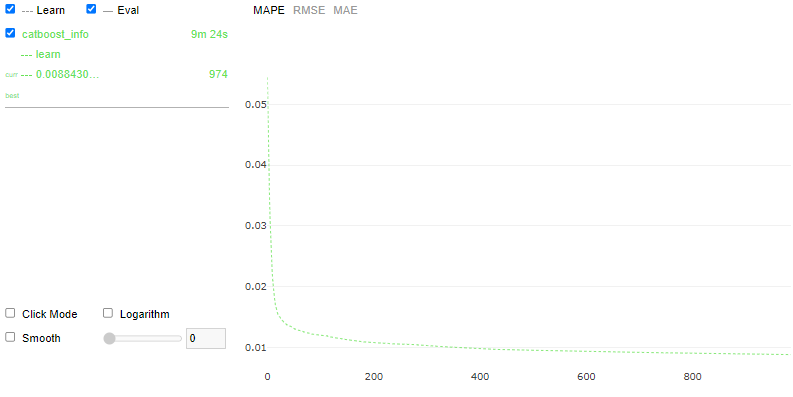

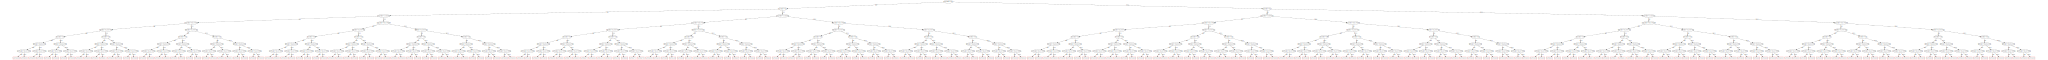

In [28]:
cb_model.plot_tree(tree_idx = 0)

In [29]:
# Проверим решение CatBoost   
cb_model.calc_feature_statistics(X_cb, target = y,
                                 feature = numerical_list,
                                 plot = True,
                                 thread_count = -1)

{'productionDate': {'borders': array([-1.3117799 , -1.1696258 , -1.0274715 , -0.8853173 , -0.7431632 ,
         -0.601009  , -0.45885482, -0.31670064, -0.17454648, -0.0323923 ,
          0.10976188,  0.25191605,  0.39407024,  0.53622437,  0.6783786 ,
          0.8205328 ,  0.9626869 ,  1.1048411 ,  1.2469953 ,  1.3891494 ,
          1.5313036 ,  1.6734579 ,  1.8156121 ,  1.957766  ,  2.0999203 ,
          2.3842287 ,  2.526383  ,  2.6685371 ,  2.8106914 ,  2.9528453 ,
          3.0949996 ,  3.2371538 ,  3.379308  ,  3.5214622 ,  3.6636162 ,
          3.8057704 ,  3.9479246 ,  4.0900793 ,  4.232233  ,  4.5165415 ,
          4.658695  ,  4.80085   ,  5.227312  ,  5.369467  ,  5.5116205 ,
          5.795929  ,  5.938083  ,  6.364546  ,  6.5066996 ,  7.0753164 ,
          7.217471  ,  7.430702  ,  7.7150106 ,  8.070395  ,  8.354704  ,
          8.496859  ,  8.639012  ,  8.781166  ,  9.491938  , 10.202709  ,
         10.344862  , 10.487017  , 10.842402  , 11.197788  , 11.553173  ,
         

In [35]:
# Посмотрим на значимость признаков
feature_importances_dict = dict(zip(cb_model.feature_names_, cb_model.feature_importances_))
feature_importances_df = pd.DataFrame(feature_importances_dict.items(), columns = ['feature_name', 'importance_num']) \
                                      .sort_values('importance_num', ascending = False)
feature_importances_df

feature_name  importance_num
5             productionDate          31.224
8                enginePower          25.691
31                 price_cut          16.846
9                    mileage           4.357
3                   fuelType           3.309
1                      brand           3.213
19          mileage_per_year           2.544
14                model_name           2.468
18          mileage_by_owner           1.695
16         region_or_country           1.426
0                   bodyType           1.391
7         engineDisplacement           0.895
10                drive_gear           0.800
17            bodyType_rough           0.703
6        vehicleTransmission           0.630
12                    owners           0.545
4              numberOfDoors           0.465
32    production_market_diff           0.444
26           description_len           0.415
11                     wheel           0.206
23            negative_score           0.113
27       description_len_log           0.103
28             tf_idf_scores           0.092
25       description_cluster           0.089
29         tf_idf_scores_log           0.067
22            positive_score           0.053
13          vehicle_passport           0.050
21  compound_sentiment_score           0.041
20                    dealer           0.040
2                      color           0.039
24             neutral_score           0.029
15        complectation_true           0.015
30     description_rough_NaN           0.000

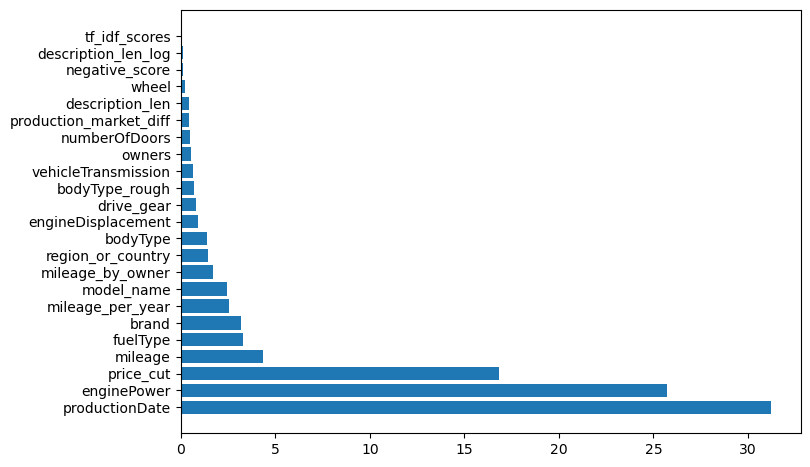

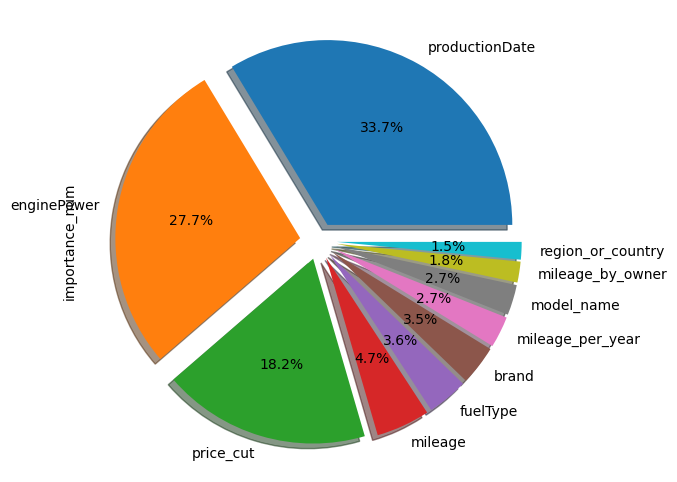

In [36]:
# Построим график важности переменных (пирог)
plt.rcdefaults()
fig, ax = plt.subplots(figsize = (8, 5.5))
ax.barh(feature_importances_df['feature_name'][:23], feature_importances_df['importance_num'][:23])
plt.show()

feature_importances_df[:10].plot.pie(
                        explode = [0.1] * 10,
                        labels = feature_importances_df['feature_name'],
                        y = 'importance_num',
                        autopct = '%1.1f%%',
                        shadow = True,
                        legend = False,
                        figsize = (6, 6));

In [37]:
cb_analysis_df = X_cb.copy()
cb_analysis_df = cb_analysis_df.join(np.exp(y))
cb_analysis_df = cb_analysis_df.join(pd.Series(np.exp(cb_model.predict(X_cb)), name = "price_prediction"))
cb_analysis_df["error"] = np.abs(cb_analysis_df["price"] - cb_analysis_df["price_prediction"])
cb_analysis_df.to_csv('cb_analysis_df_automobiles')

display(cb_analysis_df.sort_values("error", ascending = False)[:50])

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
54997        13     27     11         2              1          -0.672   
84775        14     21     13         0              3           2.313   
86141         5     21     15         0              1           8.284   
84453        14     21     15         0              3          -1.099   
86138        14     21      7         0              3          10.558   
84458        14     21     15         0              3          -1.099   
84457        14     21     15         0              3          -1.099   
84448        14     21     15         0              3          -1.383   
85668        10     21     15         3              4          -1.241   
85665        10     21     15         3              4          -1.383   
84669        14     21     15         0              3          -0.530   
84442        14     21     15         0              3          -0.814   
85911        10     21     15         3              3          -1.099   
85670        10     21     15         3              4          -1.241   
81654         2     21     15         0              4          -1.099   
85798        10     21     15         3              4          -0.956   
85172        14     21     15         0              3          -0.672   
84473        14     21     15         0              3          -0.956   
86140        14     21     15         0              3           8.141   
85688        10     21     15         3              4          -1.383   
86142         5     21      5         0              1           8.284   
84478        14     21     15         0              3          -0.814   
86028         5     21      0         0              1           5.725   
81378         0     21     12         0              2          -0.388   
85917        10     21     15         3              3          -1.241   
85744        10     21     15         3              4          -1.383   
11153         2      2     15         0              4          -1.241   
11043         2      2     15         0              4          -1.241   
85117        14     21     15         0              3          -0.672   
85781        10     21     12         3              4          -0.956   
84764        14     21     15         0              3          -0.530   
11156         2      2     15         0              4          -1.241   
82734         2     21      1         3              4          -1.099   
85663        13     21      7         0              1          -0.530   
11154         2      2     15         0              4          -1.241   
11067         2      2     15         0              4          -0.814   
81457         2     21     15         0              4          -0.246   
31822         2     16      7         0              4          -1.099   
67273        11     33     15         0              3          -0.814   
54954         5     27      4         0              1           4.872   
81635         2     21     15         0              4          -1.383   
85694        10     21     15         3              4          -0.530   
85786        10     21     15         3              4          -1.383   
85787        10     21     15         3              4          -1.241   
84734         7     21     13         0              3           1.034   
64965        11     33     15         3              3          -0.814   
81402         2     21     15         0              4          -0.814   
81511         2     21     15         0              4          -0.814   
7899         13      1     12         2              1          -1.241   
81437         2     21     15         0              4          -0.814   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
54997                    3               3.059        5.050   -1.357   
84775                    0              -0.868        1.685   -0.930   
86141           

Проведем **обратное преобразование**, чтобы посмотреть, где алгоритм ошибся.

In [38]:
X_cb.head()

bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
0        14      0     15         0              3           2.740   
1        14      0      7         0              3           3.450   
2        18      0     13         0              4           3.024   
3        14      0     11         0              3           3.024   
4        14      0     15         0              3           2.740   

   vehicleTransmission  engineDisplacement  enginePower  mileage  drive_gear  \
0                    2               0.917       -0.021    2.006           2   
1                    2              -0.273       -1.003    0.284           1   
2                    2               0.322       -0.465    0.836           2   
3                    2              -0.273       -1.003    0.933           1   
4                    2              -0.035       -0.874    1.519           1   

   wheel  owners  vehicle_passport  model_name  complectation_true  \
0      0   1.044                 1           1               0.634   
1      0   1.044                 1           1               0.634   
2      0   1.044                 1           1               0.634   
3      0   1.044                 1           1               0.634   
4      0   1.044                 0           1               0.634   

   region_or_country  bodyType_rough  mileage_by_owner  mileage_per_year  \
0                  1              12             0.873            -0.018   
1                  1              12            -0.218            -1.001   
2                  1              15             0.132            -0.637   
3                  1              12             0.194            -0.594   
4                  1              12             0.564            -0.248   

   dealer  compound_sentiment_score  positive_score  negative_score  \
0  -0.515                    -0.230          -0.208          -0.102   
1  -0.515                    -0.230          -0.208          -0.102   
2   1.941                    -0.230          -0.208          -0.102   
3  -0.515                    -0.000          -0.000           0.000   
4  -0.515                    -0.230          -0.208          -0.102   

   neutral_score  description_cluster  description_len  description_len_log  \
0          0.139                    0           -0.448               -0.292   
1          0.139                    0           -0.530               -0.717   
2          0.139                    1            0.103                0.739   
3          0.000                    2           -0.626               -2.294   
4          0.139                    0           -0.469               -0.378   

   tf_idf_scores  tf_idf_scores_log  description_rough_NaN  price_cut  \
0         -0.592             -0.469                 -0.165     -2.287   
1         -0.937             -1.004                 -0.165     -2.287   
2          0.562              0.733                 -0.165     -2.287   
3          0.000              0.000                  6.069     -2.287   
4         -0.542             -0.400                 -0.165     -2.287   

   production_market_diff  
0                  -0.705  
1                   0.969  
2                  -0.705  
3                  -0.705  
4                  -0.705

In [72]:
inversed_df = inverse_transformation(cb_analysis_df, encoders_dict)
inversed_df[inversed_df["model_name"] == "S_KLASSE" ].sort_values("error", ascending = False)[:50]

  0%|          | 0/36 [00:00<?, ?it/s]

bodyType     brand        color fuelType  numberOfDoors  \
84775      седан  MERCEDES        синий   бензин          4.000   
84669      седан  MERCEDES       чёрный   бензин          4.000   
85172      седан  MERCEDES       чёрный   бензин          4.000   
85117      седан  MERCEDES       чёрный   бензин          4.000   
84764      седан  MERCEDES       чёрный   бензин          4.000   
84734    лимузин  MERCEDES        синий   бензин          4.000   
85104      седан  MERCEDES       чёрный   бензин          4.000   
85326      седан  MERCEDES       чёрный   бензин          4.000   
84685      седан  MERCEDES       чёрный   бензин          4.000   
84902  кабриолет  MERCEDES      зелёный   бензин          2.000   
84864    лимузин  MERCEDES       чёрный   бензин          4.000   
84955      седан  MERCEDES       чёрный   бензин          4.000   
84840      седан  MERCEDES       чёрный   бензин          4.000   
84910      седан  MERCEDES       чёрный   бензин          4.000   
84936      седан  MERCEDES        синий   дизель          4.000   
85107      седан  MERCEDES       чёрный   бензин          4.000   
84815       купе  MERCEDES       чёрный   бензин          2.000   
84705      седан  MERCEDES       чёрный   бензин          4.000   
85380      седан  MERCEDES       чёрный   бензин          4.000   
85327      седан  MERCEDES       чёрный   дизель          4.000   
85463      седан  MERCEDES       чёрный   дизель          4.000   
84699      седан  MERCEDES       чёрный   бензин          4.000   
84763      седан  MERCEDES       чёрный   бензин          4.000   
84857       купе  MERCEDES  серебристый   бензин          2.000   
84980    лимузин  MERCEDES       чёрный   бензин          4.000   
84704      седан  MERCEDES       чёрный   бензин          4.000   
84694      седан  MERCEDES       чёрный   бензин          4.000   
84643      седан  MERCEDES       чёрный   бензин          4.000   
84856       купе  MERCEDES        синий   бензин          2.000   
85137       купе  MERCEDES       чёрный   бензин          2.000   
85019       купе  MERCEDES       чёрный   бензин          2.000   
84788      седан  MERCEDES       чёрный   дизель          4.000   
84762      седан  MERCEDES       чёрный   дизель          4.000   
84772      седан  MERCEDES       чёрный   дизель          4.000   
84756      седан  MERCEDES       чёрный   бензин          4.000   
84755      седан  MERCEDES       чёрный   бензин          4.000   
84660      седан  MERCEDES       чёрный   дизель          4.000   
84776      седан  MERCEDES       чёрный   дизель          4.000   
84768      седан  MERCEDES       чёрный   дизель          4.000   
84784      седан  MERCEDES       чёрный   дизель          4.000   
85261       купе  MERCEDES       чёрный   бензин          2.000   
84816      седан  MERCEDES       чёрный   бензин          4.000   
84632       купе  MERCEDES       чёрный   бензин          2.000   
84810      седан  MERCEDES       чёрный   дизель          4.000   
85017      седан  MERCEDES       чёрный   бензин          4.000   
84780      седан  MERCEDES       чёрный   бензин          4.000   
84789      седан  MERCEDES       чёрный   дизель          4.000   
84681      седан  MERCEDES        белый   бензин          4.000   
84991      седан  MERCEDES        белый   бензин          4.000   
84702       купе  MERCEDES       чёрный   бензин          2.000   

       productionDate vehicleTransmission  engineDisplacement  enginePower  \
84775          26.000      автоматическая               1.300      320.000   
84669           6.000      автоматическая               1.300      530.000   
85172           5.000      автоматическая               1.300      530.000   
85117           5.000      автоматическая               1.300      530.000   
84764           6.000      автоматическая               1.300      530.000   
84734          17.000      автоматическая               1.300      367.000   
85104           5.000      автоматическая   

Визуально достаточно сложно оценить, что привело к настолько ошибочным предсказаниям.   
Поработаем с данными: **отбросим выбросы** и посмотрм как это повлияет на результат.

In [73]:
not_outliers = inversed_df.error / inversed_df.price_prediction < 1.5
print(not_outliers.shape[0])
print(inversed_df.shape[0] - not_outliers.sum())

set_train = set(inversed_df.sort_values("error", ascending = False)[:100]["model_name"])
set_test = set(inverse_transformation(X_sub_cb, encoders_dict)["model_name"])
print(set_test.intersection(set_train))

86854
125


  0%|          | 0/33 [00:00<?, ?it/s]

{'W186', 'GLE_KLASSE_COUPE_AMG', 'V_KLASSE', 'A8', 'GLS_KLASSE_AMG', 'W188', 'G_KLASSE', 'SL_KLASSE_AMG', 'VITO', 'S_KLASSE', 'S_CLASS_MAYBACH', 'W111', 'C_KLASSE_AMG', 'GS', 'MAYBACH_GLS', 'HILUX', 'E_KLASSE', 'W128', 'MEGA_CRUISER', 'G_KLASSE_AMG', 'SLS_AMG', 'TUNDRA', 'I8', 'GLE_KLASSE', 'SLR_KLASSE', 'X_KLASSE', 'W136', 'LX'}


In [76]:
not_outliers.value_counts()

True     86729
False      125
dtype: int64

In [79]:
cb_model = CatBoostRegressor(**trial_cb.best_params,
                              random_seed = RANDOM_SEED,
                              eval_metric = 'MAPE',
                              custom_metric = ['MAE'],
                              task_type = "CPU",
                              silent = True
                             )

cb_model.fit(X_cb[not_outliers], y[not_outliers],
             verbose_eval = 0,
             use_best_model = False,
             plot = True)


# Сохраним модель
cb_model.save_model('Catboost_model.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

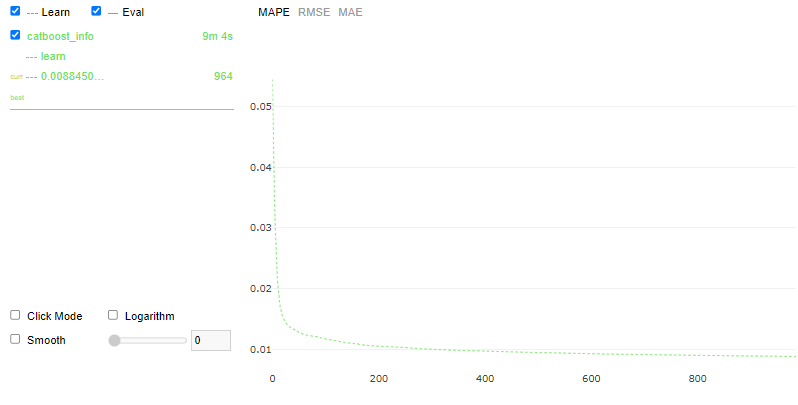

In [84]:
print(f'Данные с выборосами. MAPE: {mape_exp(y, cb_model.predict(X_cb)) * 100:.5f}')
print(f'Данные с отсеченными выбросами. MAPE: {mape_exp(y[not_outliers], cb_model.predict(X_cb[not_outliers])) * 100:.5f}')

y_sub_cb = cb_model.predict(X_sub_cb)

Данные с выборосами. MAPE: 11.81309
Данные с отсеченными выбросами. MAPE: 11.72403


Улучшение составило 0.1%

### CatBoost: оптимизация при помощи Optuna. Датасет с текстовым, числ. и категор. признаками   
- Алгоритму подается текстовый признак "description" в изначальной форме без каких-либо преобразований    
- Параметры подбираются при помощи фреймворка Optuna с применением кросс-валидации на трех фолдах.

***НА ДАННЫЙ МОМЕНТ НЕПОДСЧИТАН. В ПРОЦЕССЕ ПОДСЧЕТА***

In [241]:
def objective_CatBoost_text(trial):
    parametrs = {
        "feature_calcers": trial.suggest_categorical("feature_calcers", ['BoW']),
        "tokenizers": trial.suggest_categorical("tokenizers", [
            [{"tokenizer_id" : "Space", "separator_type" : "ByDelimiter", "delimiter" : " ", "lowercasing" : "true", 
                                                        "number_process_policy" : "LeaveAsIs", "skip_empty" : "true"}],
            [{"tokenizer_id" : "Space", "separator_type" : "ByDelimiter", "delimiter" : ' !?<>%^&*-+=|~();:"?,./\[]#',
              "split_by_set" : "true", "lowercasing" : "false", "number_process_policy" : "LeaveAsIs", "skip_empty":"true"}],
            [{"tokenizer_id" : "Space", "separator_type" : "ByDelimiter", "delimiter" : ' !?<>%^&*-+=|~();:"?,./\[]#',
              "split_by_set" : "true", "lowercasing" : "false", "number_process_policy" : "LeaveAsIs", "skip_empty":"false"}],
            [{"tokenizer_id" : "Space", "separator_type" : "ByDelimiter", "delimiter" : ' !?<>%^&*-+=|~();:"?,./\[]#',
               "split_by_set" : "true", "lowercasing" : "true", "number_process_policy" : "Skip", "skip_empty" : "true"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy":"LeaveAsIs", "skip_empty":"true",
                                                               "lowercasing" :"false", "sub_tokens_policy" : "SingleToken"}],
            [{"tokenizer_id": "Sense", "separator_type":"BySense", "number_process_policy":"LeaveAsIs", "skip_empty":"false",
                                                                  "lowercasing" :"true", "sub_tokens_policy":"SingleToken"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy":"LeaveAsIs","skip_empty":"false",
                                                              "lowercasing" : "false", "sub_tokens_policy" : "SingleToken"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy" :"LeaveAsIs","skip_empty":"true", 
              "token_types" : ['Word', 'Number', 'Unknown'], "lowercasing" : "true", "sub_tokens_policy" : "SingleToken"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy" :"LeaveAsIs","skip_empty":"true",
              "token_types" : ['Word', 'Number', 'Unknown'], "lowercasing" : "false", "sub_tokens_policy" : "SingleToken"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy" : "Skip", "skip_empty" : "false",
                "token_types" : ['Word', 'Number', 'Unknown'], "lowercasing" : "true", "sub_tokens_policy" : "SingleToken"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy" :"LeaveAsIs", "skip_empty":"true",
                                                            "lowercasing" : "false", "sub_tokens_policy" : "SeveralTokens"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy" :"LeaveAsIs", "skip_empty":"true", 
              "token_types" : ['Word', 'Number', 'Unknown'], "lowercasing" : "true", "sub_tokens_policy" : "SeveralTokens"}],
            [{"tokenizer_id": "Sense", "separator_type": "BySense", "number_process_policy" :"LeaveAsIs", "skip_empty":"true",
               "token_types" : ['Word', 'Number', 'Unknown'], "lowercasing" : "false", "sub_tokens_policy":"SingleToken"}]]),
                                  
                                                
        "dictionaries" : trial.suggest_categorical("dictionaries", [  
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Insert", 
             "end_of_sentence_policy" : "Skip", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" , 
             "num_bpe_units" : "0", "skip_unknown" : 'false', "dictionary_type" : 'FrequencyBased'}],
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'false', "dictionary_type" : 'FrequencyBased'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "1", "end_of_word_policy" : "Skip",  
            "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'false', "dictionary_type" : 'FrequencyBased'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "1", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '30', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : 0, "skip_unknown" : 'false', "dictionary_type" : 'FrequencyBased'}],
            [{"dictionary_id" : "BiGram","gram_order" : '2', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '30',"max_dictionary_size" : "-1" ,
             "num_bpe_units" : 0, "skip_unknown" : 'false', "dictionary_type" : 'FrequencyBased'}],
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'false', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "0", "end_of_word_policy" : "Insert",  
             "end_of_sentence_policy" : "Skip", "occurence_lower_bound" : '30', "max_dictionary_size" : "-1" ,
              "num_bpe_units" : "0", "skip_unknown" : 'false', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '30', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'false', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "1", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '30', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0",  "skip_unknown" : 'false', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Insert",
             "end_of_sentence_policy" : "Skip", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "1", "end_of_word_policy" : "Insert", 
             "end_of_sentence_policy" : "Skip", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "1", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
              "num_bpe_units" : "0", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '50', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "Word", "gram_order" : '1', "skip_step" : "0", "end_of_word_policy" : "Insert",
             "end_of_sentence_policy" : "Skip",  "occurence_lower_bound" : '30', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "0", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}],
            [{"dictionary_id" : "BiGram", "gram_order" : '2', "skip_step" : "0", "end_of_word_policy" : "Skip",  
             "end_of_sentence_policy" : "Insert", "occurence_lower_bound" : '30', "max_dictionary_size" : "-1" ,
             "num_bpe_units" : "1", "skip_unknown" : 'true', "dictionary_type" : 'Bpe'}]]),
              
        
        "iterations" : trial.suggest_int("iterations", 50, 1000), 
        "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.5, step = 0.01),
        "depth" : trial.suggest_int("depth", 2, 10),
        "random_strength" : trial.suggest_int("random_strength", 0, 10), 
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]), 
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 0, 100, step = 1),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["MVS"])  # "Bayesian", "Bernoulli"       
             }   
   
       
    model = CatBoostRegressor(
                                **parametrs,
                                eval_metric = 'MAPE',
                                custom_metric = ['MAE'],
                                thread_count = -1,
                                silent = True,
                                task_type = "CPU",
                                random_seed = RANDOM_SEED
                            )
    
    res = compute_cv(model, X_cb_text, y, label = 'CatBoostRegressor_text')  
    print(res)    
    return res[0] + res[1]

In [ ]:
text_features_list = ['description']
study_CatBoost_text = optuna.create_study(study_name = 'Study_CatBoost_text')
study_CatBoost_text.optimize(objective_CatBoost_text, n_trials = 150, show_progress_bar = True)

In [ ]:
# Посмотрим на 10 лучших наборов параметров с наиболее низким значением MAPE
display(study_CatBoost_text.trials_dataframe().sort_values('value')[:10])
best_params_cb_text = study_CatBoost_text.best_params
trial_cb_text = study_CatBoost_text.best_trial
print(f'Number of finished trials: {len(study_CatBoost_text.trials)}')
print(f'Value (Best parametrs): {round(trial_cb_text.value, 5)}')  

print(f'\nModel with text feature "description". Best parametrs: {best_params_cb_text}')
print(f'Model without text features (wih manually generated features from text by tf-idf, NLTK etc.) Best parametrs: {best_params_cb}')

# Сохраним параметры
joblib.dump(study_CatBoost_text, 'Study_CatBoost_text.pkl')  

#optuna.visualization.plot_optimization_history(study_CatBoost_text)

In [ ]:
# Обучим модель с лучшими параметрами из подобранных 
cb_model_text = CatBoostRegressor(**trial_cb_text.params,
                                  random_seed = RANDOM_SEED,
                                  eval_metric = 'MAPE',
                                  custom_metric = ['MAE'],
                                  task_type = "CPU",
                                  silent = True
                                  )
cb_model_text.fit(X_cb_text, y, 
                 verbose_eval = 0, 
                 use_best_model = True, 
                 plot = True)

print(f'MAPE: {mape_exp(y, cb_model_text.predict(X_cb_text)) * 100:.5f}')

# Сохраним модель
cb_model_text.save_model('CatBoost_model_text.model')

In [ ]:
# Обучим модель с лучшими параметрами из подобранных 
cb_model_text = CatBoostRegressor(**trial_cb_text.params,
                                  random_seed = RANDOM_SEED,
                                  eval_metric = 'MAPE',
                                  custom_metric = ['MAE'],
                                  task_type = "CPU",
                                  silent = True
                                  )
cb_model_text.fit(X_cb_text[not_outliers], y[not_outliers], 
                  verbose_eval = 0, use_best_model = True, plot = True)

print(f'MAPE: {mape_exp(y[not_outliers], cb_model_text.predict(X_cb_text[not_outliers])) * 100:.5f}')

# Сохраним модель
cb_model_text.save_model('CatBoost_model_text.model')

## 7.3. LightAutoML (LAMA)

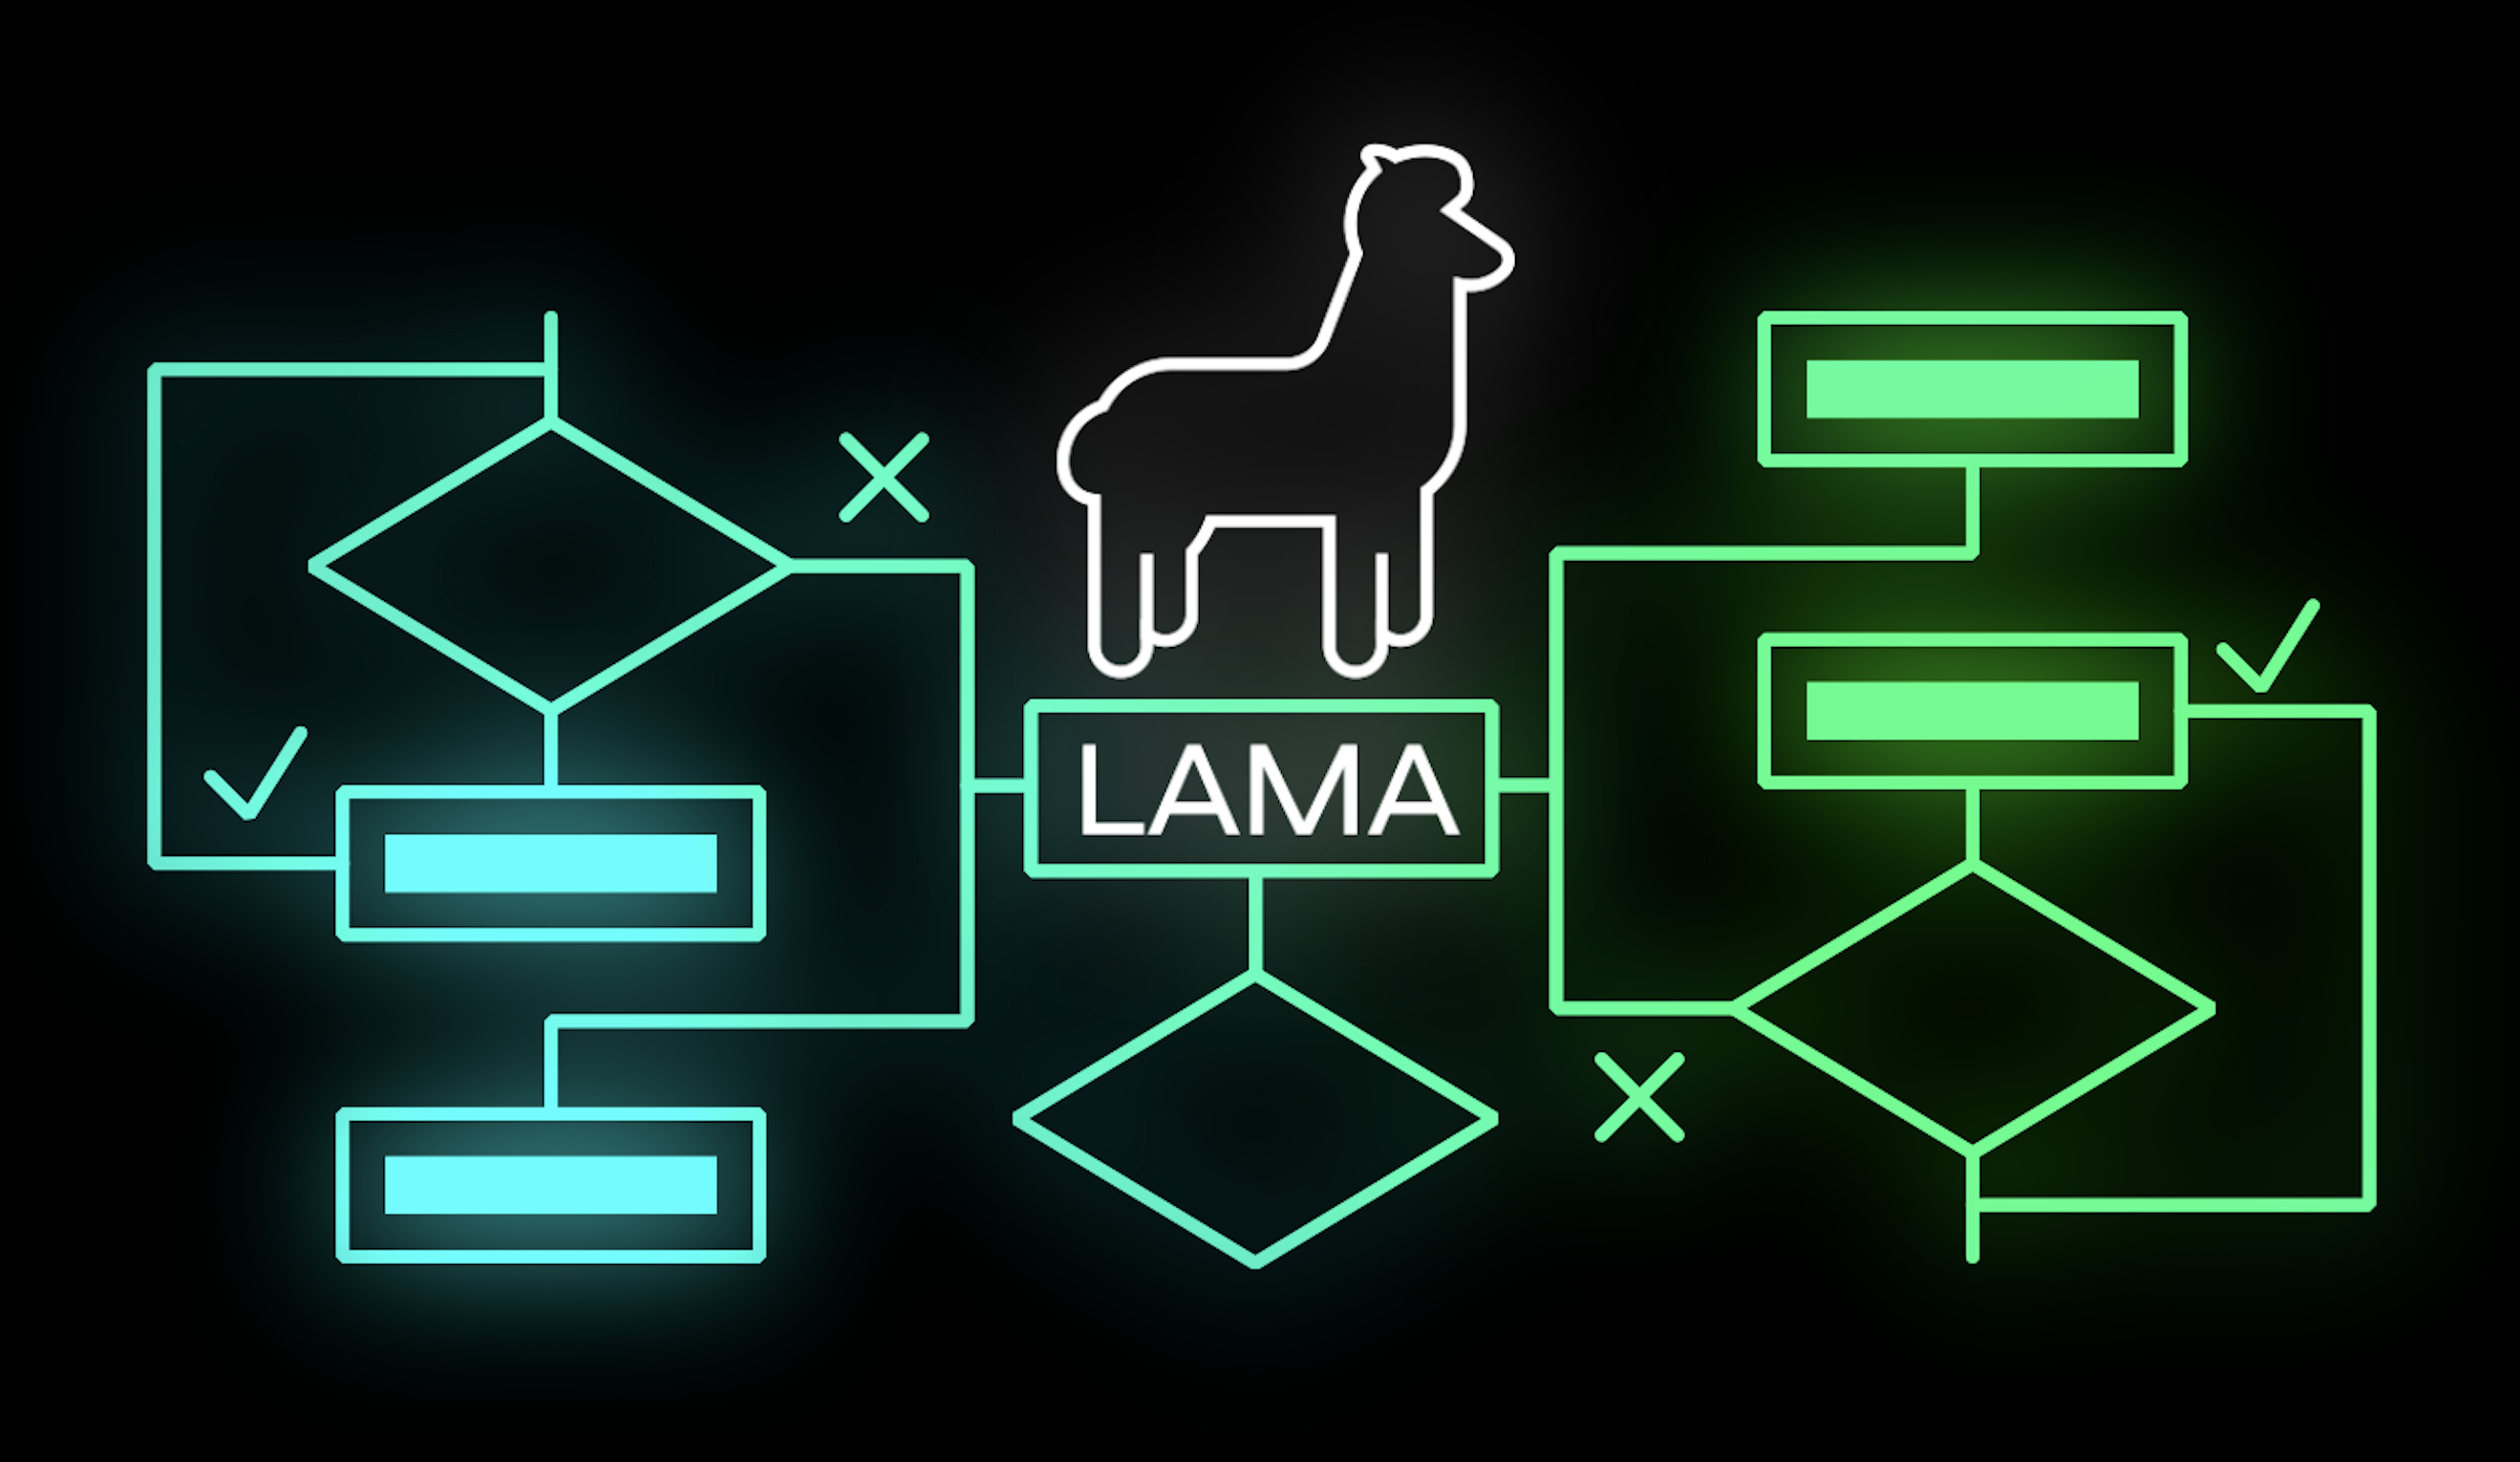

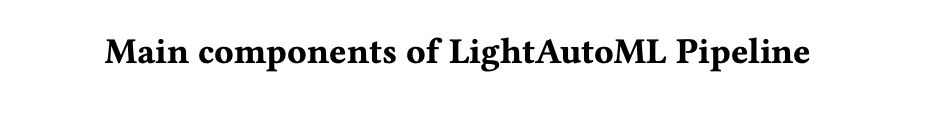

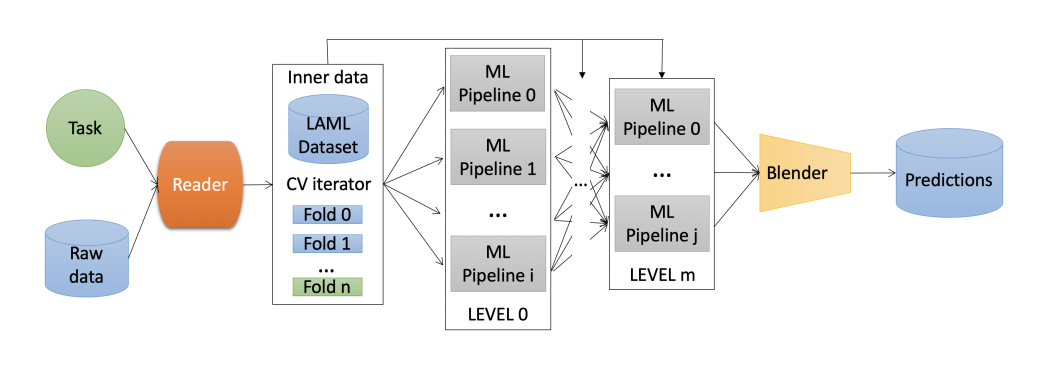

#### LightAutoML (LAMA) - automatic model creation framework  by Sber AI Lab  
#### Open source python фреймворк для задач:  
- Бинарной и мультиклассовой классификации  
- Регрессии  

#### Основные возможности:  
- Работает с текстом и изображенями  
- Готовые пресеты:  
    - Tabular  
    - NLP  
    - CV  
    - Uplift  
    - WhiteBox для интерпретируемых моделей  
- Возможность кастомизации  
- Автоматическая типизация и предобработка признаков  
- Отчеты  
- Интеграция в SberCloud  

#### Полезные материалы:    
- <a href="https://lightautoml.readthedocs.io/en/latest/">Документация LightAutoML</a> 
- <a href="https://github.com/sberbank-ai-lab/LightAutoML">LightAutoML Github</a>
- <a href="https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop">Tutorials Github</a>     
- <a href="https://github.com/sb-ai-lab/LightAutoML/tree/master/lightautoml/automl/presets/tabular_configs">Конфигурации (YAML config)</a> 
- <a href="https://www.youtube.com/watch?v=hr8GbPOHaEE">Youtube-видео - LightAutoML: подход BlackBox</a>  
- <a href="https://www.youtube.com/watch?v=ajQwShL_Hak&t=2s">Youtube-видео - LightAutoML: подход WhiteBox</a>

In [409]:
lightautoml.__version__

'0.3.7.3'

## Посмотрим на результат работы нескольких алгоритмов:  
- TabularAutoML. Датасет для обучения содержит числовые и категориальные признаки (без текстового)    
- TabularUtilizedAutoML. Датасет для обучения содержит числовые и категориальные признаки (без текстового)  
- TabularAutoML. Датасет для обучения содержит весь набор признаков: текстовый, числовые и категориальные  
- TabularUtilizedAutoML. Датасет для обучения содержит весь набор признаков: текстовый, числовые и категориальные

### LightAutoML (пресет TabularAutoML) 
**Датасет для обучения содержит только числовые и категориальные признаки (без текстового)** 

In [444]:
print(f'Размер обучающей выборки: {X_lama_txt_train.shape}')     # (69483, 29)
print(f'Размер валидационной выборки: {X_lama_txt_val.shape}')   # (17371, 29)

print(f'\nНаличие пропусков в обучающей выборке: \n{X_lama_txt_train.isna().sum()[X_lama_txt_train.isna().sum() > 0]}')
display(X_lama_txt_train.head(3))

Размер обучающей выборки: (69483, 29)
Размер валидационной выборки: (17371, 29)

Наличие пропусков в обучающей выборке: 
enginePower                  1
mileage_per_year          1063
production_market_diff       1
dtype: int64


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
10137         2      1     15         0              4           0.465   
24954         2     13     13         0              4          -1.383   
37073         2     17     11         0              4          -0.388   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
10137                    0              -0.868        2.094   -0.422   
24954                    0              -0.511       -0.617   -1.408   
37073                    0              -0.035       -0.302   -0.442   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
10137           2      0  -1.276                 1        1059   
24954           1      0  -1.276                 1         285   
37073           2      0  -0.116                 1         898   

       complectation_true  region_or_country  bodyType_rough  \
10137               0.634                  1               1   
24954              -1.577                  3               1   
37073               0.634                  3               1   

       mileage_by_owner  mileage_per_year  dealer  description_cluster  \
10137             0.583            -0.634  -0.515                    0   
24954            -1.290               NaN   1.941                    1   
37073            -0.372            -0.262  -0.515                    0   

       description_len  description_len_log  description_rough_NaN  price_cut  \
10137           -0.108                0.485                 -0.165      0.826   
24954            0.165                0.799                 -0.165      0.826   
37073           -0.292                0.163                 -0.165      0.203   

       production_market_diff  \
10137                  -0.705   
24954                  -1.262   
37073                   0.411   

                                                       description  price  
10137  Немецкая сборка, спецзаказ. Спортивные сиденья и руль. П... 14.221  
24954  АКРОС официальный дилер Hyundai.\r\nМы имеем богатый опы... 13.895  
37073  Автомобиль в хорошем состоянии , не требует никаких влож... 13.732

In [476]:
# Зададим параметры-константы, которые будем использовать в процессе решения задачи
N_THREADS = 8
N_FOLDS = 5
RANDOM_SEED = 42
TEST_SIZE = 0.2
TIMEOUT = 7200  # 2 hours
TARGET_NAME = 'price'

In [477]:
# Создадим Task (регрессия) 
task = Task('reg', loss = 'mape', metric = 'mae')

# Установим роли для признаков
roles = {'target' : TARGET_NAME, 
         'drop' : ['description']}

In [438]:
# Воспользуемся пресетом TabularAutoML для создания модели
automl_model = TabularAutoML(task = task,             # 'reg', loss = 'mape', metric = 'mae'
                             timeout = TIMEOUT,       # 2 hours
                             cpu_limit = N_THREADS,   # 8
                             reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  

# Создадим отчет 
RD = ReportDeco(output_path = 'tabularAutoML_model_report_automobile_price')
automl_rd = RD(automl_model)

y_pred_train = automl_rd.fit_predict(X_lama_txt_train, roles = roles, verbose = 1)

[23:13:25] Stdout logging level is INFO.
[23:13:25] Task: reg

[23:13:25] Start automl preset with listed constraints:
[23:13:25] - time: 7200.00 seconds
[23:13:25] - CPU: 8 cores
[23:13:25] - memory: 16 GB

[23:13:25] Train data shape: (69483, 29)

[23:13:28] Layer 1 train process start. Time left 7197.51 secs
[23:13:31] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:13:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.20547995091222868
[23:13:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:13:46] Time left 7179.05 secs

[23:14:18] Selector_LightGBM fitting and predicting completed
[23:14:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:17:02] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.1314939288475337
[23:17:02] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:17:02] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


[I 2023-07-25 23:17:02,954] A new study created in memory with name: no-name-f3e27b72-a423-4db2-af86-a5f426f69251
[I 2023-07-25 23:18:01,124] Trial 0 finished with value: -0.1257264495785093 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.1257264495785093.
[I 2023-07-25 23:18:49,912] Trial 1 finished with value: -0.12567070899726843 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.12567070899726843.
[I 2023-07-25 23:19:23,813] Trial 2 finished with value: -0.127248306527095 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging

[23:22:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:22:23] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[23:31:28] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.12715253184544156
[23:31:28] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[23:31:28] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[23:33:42] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.13464972740833073
[23:33:42] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[23:33:42] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


[I 2023-07-25 23:33:42,909] A new study created in memory with name: no-name-5fc57989-d986-4e4d-846e-425a36b6ae24
[I 2023-07-25 23:34:06,941] Trial 0 finished with value: -0.13955242965012077 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.13955242965012077.
[I 2023-07-25 23:34:27,782] Trial 1 finished with value: -0.14719988181689794 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.13955242965012077.
[I 2023-07-25 23:34:48,883] Trial 2 finished with value: -0.14765220913446406 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.13955242965012077.
[I 2023-07-25 23:35:09,890] Trial 3 finished with value: -0.14719988181689794 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.7180069938060

[23:38:43] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[23:38:43] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[23:43:07] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.1289920008154018
[23:43:07] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[23:43:07] Time left 5418.59 secs

[23:43:07] Layer 1 training completed.

[23:43:07] Blending: optimization starts with equal weights and score -0.13363590398876568
[23:43:07] Blending: iteration 0: score = -0.12539249130772115, weights = [0.         0.06665771 0.55489826 0.         0.37844402]
[23:43:07] Blending: iteration 1: score = -0.12535329991398692, weights = [0.         0.         0.5981736  0.         0.40182638]
[23:43:07] Blending: iteration 2: score = -0.12535329991398692, weights = [0.         0.         0.5981736  0.         0.40182638]
[23:43:07] Blending: no score update. Terminated

[23:43:07] Automl preset training completed in 1782.11 seconds

[23:43:

In [445]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_val = automl_rd.predict(X_lama_txt_val)

print(f'Размер oof prediction: {y_pred_train.shape},  NaN-значения: {np.unique(np.isnan(y_pred_train.data))}')
print(f'Размер holdout prediction: {y_pred_val.shape},  NaN-значения: {np.unique(np.isnan(y_pred_val.data))}')

print(f'\nOOF score: {mape_exp(X_lama_txt_train["price"].values, y_pred_train.data[:, 0])  * 100:.5f} %')
print(f'HOLDOUT score: {mape_exp(X_lama_txt_val["price"].values, y_pred_val.data[:, 0]) * 100:.5f} %')

Размер oof prediction: (69483, 1),  NaN-значения: [False]
Размер holdout prediction: (17371, 1),  NaN-значения: [False]

OOF score: 12.71367 %
HOLDOUT score: 12.26048 %


In [446]:
# Краткое описание получившейся модели
print(automl_model.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.59817 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.40183 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [449]:
# LAMA report 
os.listdir('tabularAutoML_model_report_automobile_price')

['feature_importance.png',
 'lama_interactive_report.html',
 'test_error_hist_1.png',
 'test_scatter_plot_1.png',
 'test_target_distribution_1.png',
 'valid_error_hist.png',
 'valid_scatter_plot.png',
 'valid_target_distribution.png']

Feature  Importance
0        productionDate   3,291.247
1             price_cut   3,147.867
2           enginePower   1,924.510
3               mileage     698.292
4            model_name     536.794
5                 brand     460.113
6    engineDisplacement     273.944
7              fuelType     262.066
8       description_len     249.786
9     region_or_country     226.882
10     mileage_per_year     187.582
11             bodyType     187.314
12  vehicleTransmission     181.370
13               owners     171.366
14           drive_gear     120.890

<AxesSubplot:xlabel='Feature'>

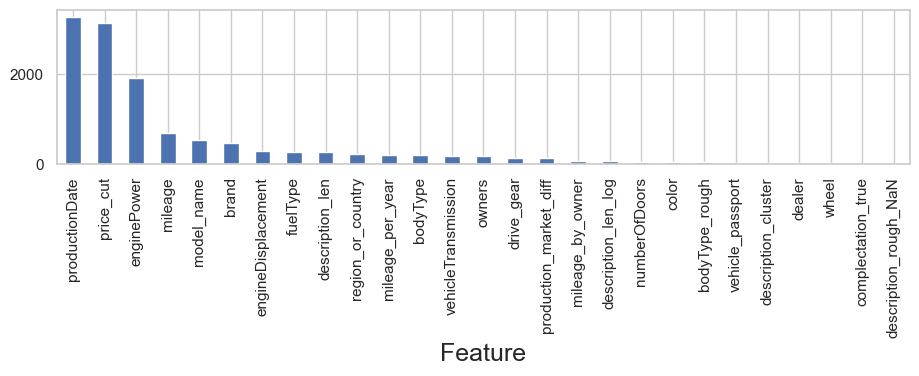

In [456]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp = automl_rd.model.get_feature_scores('fast')
display(fast_features_imp.sort_values('Importance', ascending = False)[:15])
fast_features_imp.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11, grid = True)

Feature  Importance
0        productionDate       0.281
1           enginePower       0.116
2            model_name       0.089
3    engineDisplacement       0.079
4               mileage       0.078
5                 brand       0.069
6             price_cut       0.045
7            drive_gear       0.014
8                owners       0.013
9   vehicleTransmission       0.010
10     mileage_by_owner       0.009
11             fuelType       0.009
12    region_or_country       0.007
13             bodyType       0.006
14      description_len       0.005

<AxesSubplot:xlabel='Feature'>

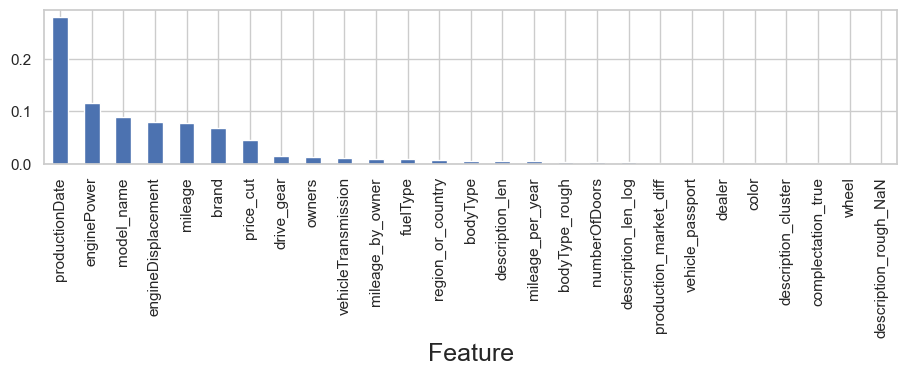

In [457]:
# Посмотрим на график важности признаков (Более точный способ - Permutation importances) 
accurate_features_imp = automl_rd.model.get_feature_scores('accurate', X_lama_txt_val, silent = True)
display(accurate_features_imp.sort_values('Importance', ascending = False)[:15])
accurate_features_imp.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11, grid = True)

### LightAutoML (пресет TabularUtilizedAutoML) 
**Датасет для обучения содержит только числовые и категориальные признаки (без текстового)** 

In [459]:
print(f'Размер обучающей выборки: {X_lama_txt_train.shape}')     # (69483, 29)
print(f'Размер валидационной выборки: {X_lama_txt_val.shape}')   # (17371, 29)

Размер обучающей выборки: (69483, 29)
Размер валидационной выборки: (17371, 29)


In [461]:
# Воспользуемся пресетом TabularAutoML для создания модели
automl_utilized = TabularUtilizedAutoML(task = task,             # 'reg', loss = 'mape', metric = 'mae' 
                                        timeout = 10800,         # 3 hours
                                        cpu_limit = N_THREADS,   # 8
                                        reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  

y_pred_train_ut = automl_utilized.fit_predict(X_lama_txt_train, roles = roles, verbose = -1)

[I 2023-07-26 00:30:44,104] A new study created in memory with name: no-name-9e694723-58b1-4741-b638-6ae9d78eae4b
[I 2023-07-26 00:31:35,112] Trial 0 finished with value: -0.1257264495785093 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.1257264495785093.
[I 2023-07-26 00:32:19,094] Trial 1 finished with value: -0.12567070899726843 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.12567070899726843.
[I 2023-07-26 00:32:49,690] Trial 2 finished with value: -0.127248306527095 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging

In [462]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_val_ut = automl_utilized.predict(X_lama_txt_val)

print(f'Размер oof prediction: {y_pred_train_ut.shape},  NaN-значения: {np.unique(np.isnan(y_pred_train_ut.data))}')
print(f'Размер holdout prediction: {y_pred_val_ut.shape},  NaN-значения: {np.unique(np.isnan(y_pred_val_ut.data))}')

print(f'\nOOF score: {mape_exp(X_lama_txt_train["price"].values, y_pred_train_ut.data[:, 0])  * 100:.5f} %')
print(f'HOLDOUT score: {mape_exp(X_lama_txt_val["price"].values, y_pred_val_ut.data[:, 0]) * 100:.5f} %')

Размер oof prediction: (69483, 1),  NaN-значения: [False]
Размер holdout prediction: (17371, 1),  NaN-значения: [False]

OOF score: 11.99361 %
HOLDOUT score: 11.88831 %


In [463]:
# Краткое описание получившейся модели
print(automl_utilized.create_model_str_desc())

Final prediction for new objects = 
	0.10878 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.59817 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.40183 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.14697 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.61283 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.38717 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.62574 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_m

Feature  Importance
0                price_cut   3,314.106
1           productionDate   3,146.468
2              enginePower   1,868.288
3                  mileage     719.609
4               model_name     536.079
5                    brand     468.683
6       engineDisplacement     264.898
7                 fuelType     263.398
8        region_or_country     220.673
9          description_len     219.314
10                bodyType     192.501
11        mileage_per_year     192.230
12                  owners     180.630
13     vehicleTransmission     174.021
14  production_market_diff     118.591

<AxesSubplot:xlabel='Feature'>

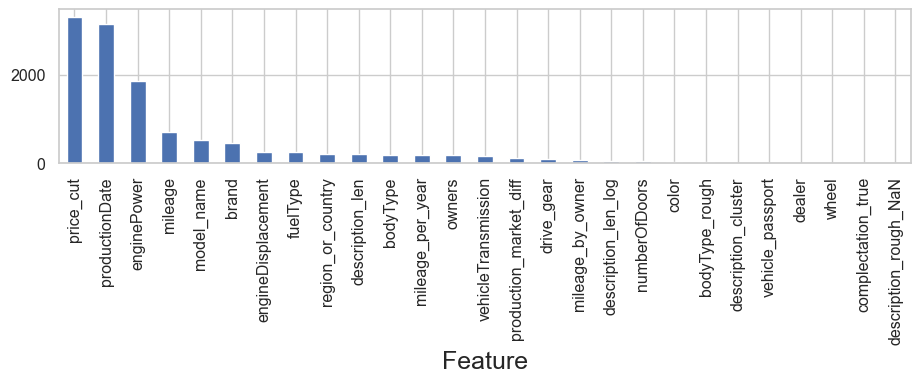

In [464]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp_ut = automl_utilized.get_feature_scores('fast')
display(fast_features_imp_ut.sort_values('Importance', ascending = False)[:15])
fast_features_imp_ut.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11.5, grid = True)

### LightAutoML (пресет TabularAutoML) 
**Датасет для обучения содержит весь набор признаков: текстовый, числовые и категориальные** 

In [465]:
print(f'Размер обучающей выборки: {X_lama_txt_train.shape}')     # (69483, 29)
print(f'Размер валидационной выборки: {X_lama_txt_val.shape}')   # (17371, 29)
display(X_lama_txt_train.head(3))
display(X_lama_txt_train[['description']].sample(5))

Размер обучающей выборки: (69483, 29)
Размер валидационной выборки: (17371, 29)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
10137         2      1     15         0              4           0.465   
24954         2     13     13         0              4          -1.383   
37073         2     17     11         0              4          -0.388   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
10137                    0              -0.868        2.094   -0.422   
24954                    0              -0.511       -0.617   -1.408   
37073                    0              -0.035       -0.302   -0.442   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
10137           2      0  -1.276                 1        1059   
24954           1      0  -1.276                 1         285   
37073           2      0  -0.116                 1         898   

       complectation_true  region_or_country  bodyType_rough  \
10137               0.634                  1               1   
24954              -1.577                  3               1   
37073               0.634                  3               1   

       mileage_by_owner  mileage_per_year  dealer  description_cluster  \
10137             0.583            -0.634  -0.515                    0   
24954            -1.290               NaN   1.941                    1   
37073            -0.372            -0.262  -0.515                    0   

       description_len  description_len_log  description_rough_NaN  price_cut  \
10137           -0.108                0.485                 -0.165      0.826   
24954            0.165                0.799                 -0.165      0.826   
37073           -0.292                0.163                 -0.165      0.203   

       production_market_diff  \
10137                  -0.705   
24954                  -1.262   
37073                   0.411   

                                                       description  price  
10137  Немецкая сборка, спецзаказ. Спортивные сиденья и руль. П... 14.221  
24954  АКРОС официальный дилер Hyundai.\r\nМы имеем богатый опы... 13.895  
37073  Автомобиль в хорошем состоянии , не требует никаких влож... 13.732

description
50044  Предложение года на NISSAN в MAJOR Волокаламка!\nМы пред...
51740  Машина на ходу сел и поехал влажений не требует. Торг. М...
71090  Один хозяин.\nПТС оригинал.\nСервисная книжка с всеми от...
21593  Передние стеклоподъёмники, обогрев лобового стекла и зад...
7955   Автомобиль продается официальным дилером Porsche.\nПорше...

In [466]:
# Создадим Task (регрессия) 
task = Task('reg', loss = 'mape', metric = 'mae')

# Установим роли для признаков
roles = {'target' : TARGET_NAME, 
         'text' : ['description'],
         'category' : categorial_list}

# Воспользуемся пресетом TabularAutoML для создания модели
automl_model_1 = TabularAutoML(task = task,            # 'reg', loss = 'mape', metric = 'mae'
                               timeout = TIMEOUT,      # 2 hours
                               cpu_limit = N_THREADS,  # 8
                               reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  

# Создадим отчет 
RD_1 = ReportDeco(output_path = 'tabularAutoML_model_report_automobile_price_st_with_text')
automl_rd_1 = RD_1(automl_model_1)

y_pred_train1 = automl_rd_1.fit_predict(X_lama_txt_train, roles = roles, verbose = -1)

[I 2023-07-26 10:34:29,787] A new study created in memory with name: no-name-3e06d8ee-388d-4b38-9a47-d87cff5e00ee
[I 2023-07-26 10:35:19,926] Trial 0 finished with value: -0.1284138451604822 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.1284138451604822.
[I 2023-07-26 10:36:02,770] Trial 1 finished with value: -0.12881569653114042 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: -0.1284138451604822.
[I 2023-07-26 10:36:32,380] Trial 2 finished with value: -0.13084039141251633 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'baggin

In [467]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_val1 = automl_rd_1.predict(X_lama_txt_val)

print(f'Размер oof prediction: {y_pred_train1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_train1.data))}')
print(f'Размер holdout prediction: {y_pred_val1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_val1.data))}')

print(f'\nOOF score: {mape_exp(X_lama_txt_train["price"].values, y_pred_train1.data[:, 0]) * 100:.5f} %')
print(f'HOLDOUT score: {mape_exp(X_lama_txt_val["price"].values, y_pred_val1.data[:, 0]) * 100:.5f} %')

Размер oof prediction: (69483, 1),  NaN-значения: [False]
Размер holdout prediction: (17371, 1),  NaN-значения: [False]

OOF score: 12.96669 %
HOLDOUT score: 12.43788 %


In [468]:
# Краткое описание получившейся модели
print(automl_model_1.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.64638 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.35362 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [469]:
# LAMA report 
os.listdir('tabularAutoML_model_report_automobile_price_st_with_text')

['feature_importance.png',
 'lama_interactive_report.html',
 'test_error_hist_1.png',
 'test_error_hist_2.png',
 'test_scatter_plot_1.png',
 'test_scatter_plot_2.png',
 'test_target_distribution_1.png',
 'test_target_distribution_2.png',
 'valid_error_hist.png',
 'valid_scatter_plot.png',
 'valid_target_distribution.png']

Feature  Importance
0                price_cut   3,445.880
1           productionDate   3,062.729
2              enginePower   1,880.770
3                  mileage     711.187
4               model_name     518.500
5                    brand     475.566
6       engineDisplacement     277.331
7                 fuelType     261.936
8          description_len     236.638
9        region_or_country     214.336
10                bodyType     207.311
11                  owners     188.734
12     vehicleTransmission     182.268
13        mileage_per_year     177.675
14  production_market_diff     117.629

<AxesSubplot:xlabel='Feature'>

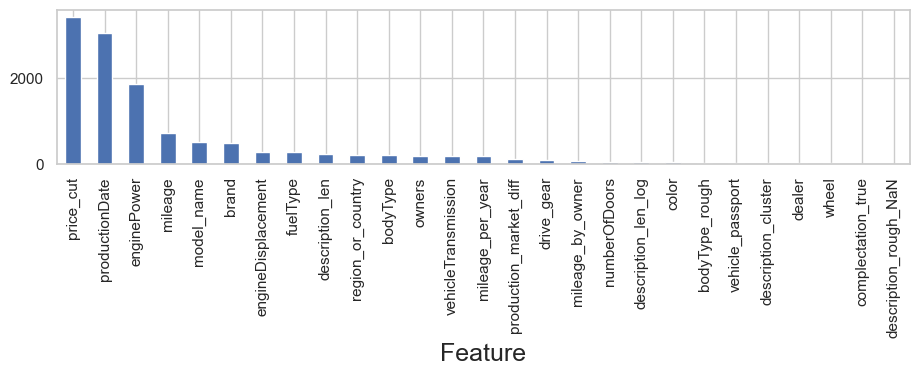

In [470]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp1 = automl_rd_1.model.get_feature_scores('fast')
display(fast_features_imp1.sort_values('Importance', ascending = False)[:15])
fast_features_imp1.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11, grid = True)

Feature  Importance
0        productionDate       0.269
1           enginePower       0.121
2            model_name       0.085
3    engineDisplacement       0.085
4               mileage       0.085
5                 brand       0.073
6             price_cut       0.041
7            drive_gear       0.012
8                owners       0.011
9   vehicleTransmission       0.010
10             fuelType       0.009
11    region_or_country       0.009
12       bodyType_rough       0.006
13     mileage_per_year       0.006
14      description_len       0.006

<AxesSubplot:xlabel='Feature'>

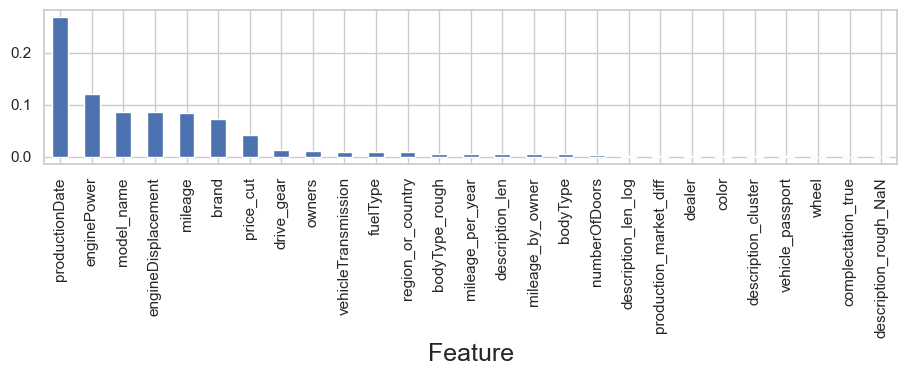

In [471]:
# Посмотрим на график важности признаков (Более точный способ - Permutation importances) 
accurate_features_imp1 = automl_rd_1.model.get_feature_scores('accurate', X_lama_txt_val, silent = True)
display(accurate_features_imp1.sort_values('Importance', ascending = False)[:15])
accurate_features_imp1.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11, grid = True)

### LightAutoML (пресет TabularUtilizedAutoML) 
**Датасет для обучения содержит весь набор признаков: текстовый, числовые и категориальные** 

In [478]:
print(f'Размер обучающей выборки: {X_lama_txt_train.shape}')     # (69483, 29)
print(f'Размер валидационной выборки: {X_lama_txt_val.shape}')   # (17371, 29)
display(X_lama_txt_train.head(3))
display(X_lama_txt_train[['description']].sample(5))

Размер обучающей выборки: (69483, 29)
Размер валидационной выборки: (17371, 29)


bodyType  brand  color  fuelType  numberOfDoors  productionDate  \
10137         2      1     15         0              4           0.465   
24954         2     13     13         0              4          -1.383   
37073         2     17     11         0              4          -0.388   

       vehicleTransmission  engineDisplacement  enginePower  mileage  \
10137                    0              -0.868        2.094   -0.422   
24954                    0              -0.511       -0.617   -1.408   
37073                    0              -0.035       -0.302   -0.442   

       drive_gear  wheel  owners  vehicle_passport  model_name  \
10137           2      0  -1.276                 1        1059   
24954           1      0  -1.276                 1         285   
37073           2      0  -0.116                 1         898   

       complectation_true  region_or_country  bodyType_rough  \
10137               0.634                  1               1   
24954              -1.577                  3               1   
37073               0.634                  3               1   

       mileage_by_owner  mileage_per_year  dealer  description_cluster  \
10137             0.583            -0.634  -0.515                    0   
24954            -1.290               NaN   1.941                    1   
37073            -0.372            -0.262  -0.515                    0   

       description_len  description_len_log  description_rough_NaN  price_cut  \
10137           -0.108                0.485                 -0.165      0.826   
24954            0.165                0.799                 -0.165      0.826   
37073           -0.292                0.163                 -0.165      0.203   

       production_market_diff  \
10137                  -0.705   
24954                  -1.262   
37073                   0.411   

                                                       description  price  
10137  Немецкая сборка, спецзаказ. Спортивные сиденья и руль. П... 14.221  
24954  АКРОС официальный дилер Hyundai.\r\nМы имеем богатый опы... 13.895  
37073  Автомобиль в хорошем состоянии , не требует никаких влож... 13.732

description
39264  Отрываю от сердца! Автомобиль, который не хочется продав...
45184  Продам альмеру n16 комфорт,торг уместен,на стоянку не по...
12537          Хорошее авто,продаю за ненадобностью,торг у капота.
8916   Мы открыты! Купите новый BMW быстро и абсолютно безопасн...
43251  ———————————————————————————\nФУНКЦИОНАЛЬНОЕ ОБОРУДОВАНИЕ...

In [501]:
# Зададим параметры-константы, которые будем использовать в процессе решения задачи
N_THREADS = 4
N_FOLDS = 5
RANDOM_SEED = 42
TEST_SIZE = 0.2
TARGET_NAME = 'price'

# Создадим Task (регрессия) 
task = Task('reg', loss = 'mape', metric = 'mae')

# Установим роли для признаков
roles = {'target' : TARGET_NAME, 
         'text' : ['description'],
         'category' : categorial_list}

# Воспользуемся пресетом TabularAutoML для создания модели
automl_utilized_1 = TabularUtilizedAutoML(task = task,             # 'reg', loss = 'mape', metric = 'mae'
                                          timeout = 10800,         # 3 hours
                                          cpu_limit = N_THREADS,   
                                          reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  


y_pred_train_ut1 = automl_utilized_1.fit_predict(X_lama_txt_train, roles = roles, verbose = -1)

[I 2023-07-26 17:18:56,360] A new study created in memory with name: no-name-0dfef3b6-9f51-48d7-b804-c3db38652255
[I 2023-07-26 17:19:46,909] Trial 0 finished with value: -0.1284138451604822 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.1284138451604822.
[I 2023-07-26 17:20:31,248] Trial 1 finished with value: -0.12881569653114042 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: -0.1284138451604822.
[I 2023-07-26 17:20:59,937] Trial 2 finished with value: -0.13084039141251633 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'baggin

In [502]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_val_ut1 = automl_utilized_1.predict(X_lama_txt_val)

print(f'Размер oof prediction: {y_pred_train_ut1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_train_ut1.data))}')
print(f'Размер holdout prediction: {y_pred_val_ut1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_val_ut1.data))}')

print(f'\nOOF score: {mape_exp(X_lama_txt_train["price"].values, y_pred_train1.data[:, 0]) * 100:.5f} %')
print(f'HOLDOUT score: {mape_exp(X_lama_txt_val["price"].values, y_pred_val_ut1.data[:, 0]) * 100:.5f} %')

Размер oof prediction: (69483, 1),  NaN-значения: [False]
Размер holdout prediction: (17371, 1),  NaN-значения: [False]

OOF score: 12.96669 %
HOLDOUT score: 12.00561 %


In [503]:
# Краткое описание получившейся модели
print(automl_utilized_1.create_model_str_desc())

Final prediction for new objects = 
	0.11596 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.64638 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.35362 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.16028 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.65550 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.34450 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.57411 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_m

Feature  Importance
0                price_cut   3,298.411
1           productionDate   3,156.617
2              enginePower   1,900.853
3                  mileage     664.445
4               model_name     536.166
5                    brand     468.432
6       engineDisplacement     279.615
7                 fuelType     268.838
8          description_len     222.142
9        region_or_country     211.730
10        mileage_per_year     203.778
11                bodyType     196.705
12                  owners     192.416
13     vehicleTransmission     176.956
14  production_market_diff     116.164

<AxesSubplot:xlabel='Feature'>

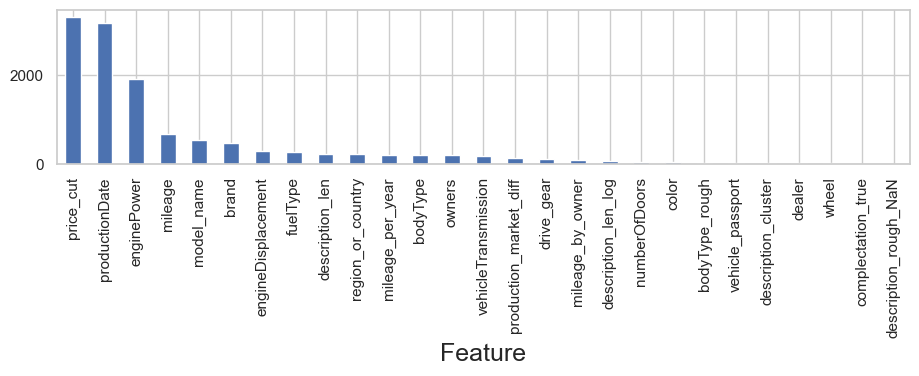

In [505]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp_ut1 = automl_utilized_1.get_feature_scores('fast')
display(fast_features_imp_ut1.sort_values('Importance', ascending = False)[:15])
fast_features_imp_ut1.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11, grid = True)

# 8. Стекинг алгоритмов

**8.1. Стекинг механическим способом**    
**8.2. Стекинг при помощи класса StackingRegressor sklearn**

## 8.1. Стекинг механическим способом
- Получение мета-признаков  
- Агрегация мета-признаков  
- Запуск мета-алгоритмов

Получим мета-признаки при помощи функции **get_meta_features**.  
Проведем стекинг алгоритмов с двумя наборами признаков: мета-признаки с исходным датасетом и без. Посмотрим с каким набором признаков получается лучшее качество.    
Используем в качестве мета-алгоритмов CatBoost, Randdom Forest и Linear Regression.

In [20]:
# Выведем все подобранные параметры

best_params_kNN = {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}
# trial_kNN
best_params_dt = {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}
# trial_dt
best_params_et = {'n_estimators': 135, 'max_depth': 24, 'max_features': None, 'min_samples_split': 61, 
                  'min_samples_leaf': 4, 'bootstrap': False}
# trial_extra_trees
best_params_rf = {'n_estimators': 606, 'max_depth': 76, 'max_features': None, 'min_samples_split': 54, 
                  'min_samples_leaf': 3, 'bootstrap': True}
# trial_rf 
best_params_gb = {'learning_rate': 0.06466272580962676, 'n_estimators': 494, 'max_depth': 6, 'max_features': None, 
                  'min_samples_split': 12, 'min_samples_leaf': 94}
# trial_gb
best_params_xgb = {'max_depth': 24, 'n_estimators': 910, 'eta': 0.04, 'gamma': 0.4, 'min_child_weight': 6, 
                   'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}
# trial_xgb
best_params_xgb_2 = {'max_cat_to_onehot': 13, 'max_depth': 8, 'n_estimators': 650, 'eta': 0.17, 'gamma': 0.1, 
                     'min_child_weight': 14, 'max_delta_step': 12, 'subsample': 0.9, 'reg_lambda': 980, 'reg_alpha': 20}
# trial_xgb_2
best_params_lgbm = {'n_estimators': 620, 'learning_rate': 0.03, 'num_leaves': 29, 'max_depth': 15, 
                    'min_data_in_leaf': 60, 'reg_alpha': 6, 'reg_lambda': 29, 'min_gain_to_split': 0.09282784532622412, 
                    'bagging_freq': 0, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}
# trial_LGBM
best_params_cb = {'iterations': 986, 'learning_rate': 0.14, 'depth': 10, 'random_strength': 2, 
                  'boosting_type': 'Ordered', 'l2_leaf_reg': 88, 'bootstrap_type': 'MVS'}
# trial_cb

### Получение мета-признаков

In [21]:
cv = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED)

In [22]:
def get_meta_features(model, X_train, X_test, y_train, cv):
    '''
    Функция для стекинга алгоритмов.
    Принимает на вход один алгоритм, обучающую и тестовую выборку 
    и возвращает новые признаки на объектах, которые не использовались во время обучения.
    '''
    X_meta_train = np.zeros(len(y_train), dtype = np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in tqdm_notebook(splits):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        model.fit(X_fold_train, y_fold_train)       
        X_meta_train[predict_fold_index] = model.predict(X_fold_predict)
    
    model.fit(X_train, y_train)
    
    X_meta_test = model.predict(X_test)
    
    return X_meta_train, X_meta_test 

In [23]:
# kNN
print(f'Параметры KNeighborsRegressor: {best_params_kNN}')
X_meta_knn_train, X_meta_knn_test = get_meta_features(KNeighborsRegressor(**best_params_kNN), 
                                                      X_knn.values, 
                                                      X_sub_knn.values, 
                                                      y.values, 
                                                      cv)

display(X_meta_knn_train.shape, X_meta_knn_train)
display(X_meta_knn_test.shape, X_meta_knn_test)

Параметры KNeighborsRegressor: {'n_neighbors': 25, 'leaf_size': 60, 'weights': None}


0it [00:00, ?it/s]

(86854,)

array([11.90011 , 11.446665, 13.169923, ..., 13.704703, 13.619016,
       13.874052], dtype=float32)

(34686,)

array([13.48564346, 13.40158232, 13.77431056, ..., 13.31168058,
       14.20734652, 13.65880525])

In [24]:
# Decision Tree
print(f'Параметры DecisionTreeRegressor: {best_params_dt}')
X_meta_dt_train, X_meta_dt_test = get_meta_features(DecisionTreeRegressor(**best_params_dt), 
                                                    X_lin.values, 
                                                    X_sub_lin.values, 
                                                    y.values, 
                                                    cv)
display(X_meta_dt_train.shape, X_meta_dt_train)
display(X_meta_dt_test.shape, X_meta_dt_test)

Параметры DecisionTreeRegressor: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': None}


0it [00:00, ?it/s]

(86854,)

array([11.851267, 10.868424, 11.842409, ..., 14.03379 , 14.07187 ,
       14.003171], dtype=float32)

(34686,)

array([13.54991383, 13.70887632, 13.68543836, ..., 12.43976784,
       14.16058746, 13.79068834])

In [25]:
# Extra Trees
print(f'Параметры ExtraTreesRegressor: {best_params_et}')
X_meta_et_train, X_meta_et_test = get_meta_features(ExtraTreesRegressor(**best_params_et), 
                                                    X_lin.values, 
                                                    X_sub_lin.values, 
                                                    y.values, 
                                                    cv)
display(X_meta_et_train.shape, X_meta_et_train)
display(X_meta_et_test.shape, X_meta_et_test)

Параметры ExtraTreesRegressor: {'n_estimators': 135, 'max_depth': 24, 'max_features': None, 'min_samples_split': 61, 'min_samples_leaf': 4, 'bootstrap': False}


0it [00:00, ?it/s]

(86854,)

array([11.845446, 11.04424 , 11.875095, ..., 14.14709 , 14.053167,
       14.169041], dtype=float32)

(34686,)

array([13.33612354, 13.66650337, 13.6492693 , ..., 12.41715238,
       14.08169627, 13.83247888])

In [26]:
# Random Forest
print(f'Параметры RandomForestRegressor: {best_params_rf}')
X_meta_rf_train, X_meta_rf_test = get_meta_features(RandomForestRegressor(**best_params_rf), 
                                                    X_lin.values, 
                                                    X_sub_lin.values, 
                                                    y.values, 
                                                    cv)
display(X_meta_rf_train.shape, X_meta_rf_train)
display(X_meta_rf_test.shape, X_meta_rf_test)

Параметры RandomForestRegressor: {'n_estimators': 606, 'max_depth': 76, 'max_features': None, 'min_samples_split': 54, 'min_samples_leaf': 3, 'bootstrap': True}


0it [00:00, ?it/s]

(86854,)

array([11.780313 , 11.028069 , 11.780553 , ..., 14.040647 , 14.0549965,
       14.062649 ], dtype=float32)

(34686,)

array([13.40441419, 13.72486019, 13.64990133, ..., 12.3934693 ,
       14.130291  , 13.83728415])

In [27]:
# Gradient Boosting
print(f'Параметры GradientBoostingRegressor: {best_params_gb}')
X_meta_gb_train, X_meta_gb_test = get_meta_features(GradientBoostingRegressor(**best_params_gb), 
                                                    X_lin.values, 
                                                    X_sub_lin.values, 
                                                    y.values, 
                                                    cv)
display(X_meta_gb_train.shape, X_meta_gb_train)
display(X_meta_gb_test.shape, X_meta_gb_test)

Параметры GradientBoostingRegressor: {'learning_rate': 0.06466272580962676, 'n_estimators': 494, 'max_depth': 6, 'max_features': None, 'min_samples_split': 12, 'min_samples_leaf': 94}


0it [00:00, ?it/s]

(86854,)

array([11.748213 , 11.140007 , 11.809118 , ..., 14.031961 , 14.030288 ,
       13.9987135], dtype=float32)

(34686,)

array([13.29364241, 13.63474255, 13.63029509, ..., 12.32612385,
       14.1718407 , 13.82707266])

In [28]:
# XGBoost
print(f'Параметры XGBRegressor: {best_params_xgb}')
X_meta_xgb_train, X_meta_xgb_test = get_meta_features(xgb.XGBRegressor(**best_params_xgb), 
                                                      X_xgb.values, 
                                                      X_sub_xgb.values, 
                                                      y.values, 
                                                      cv)
display(X_meta_xgb_train.shape, X_meta_xgb_train)
display(X_meta_xgb_test.shape, X_meta_xgb_test)

Параметры XGBRegressor: {'max_depth': 24, 'n_estimators': 910, 'eta': 0.04, 'gamma': 0.4, 'min_child_weight': 6, 'max_delta_step': 8, 'subsample': 0.8, 'reg_lambda': 250, 'reg_alpha': 0}


0it [00:00, ?it/s]

(86854,)

array([11.981268, 11.030674, 11.964805, ..., 14.042995, 14.016502,
       14.012091], dtype=float32)

(34686,)

array([13.309965 , 13.612357 , 13.6296625, ..., 12.36117  , 14.144041 ,
       13.860847 ], dtype=float32)

In [ ]:
# LightGBM
X_meta_lgbm_train, X_meta_lgbm_test = get_meta_features(lgbm.LGBMRegressor(**best_params_lgbm), 
                                                        X_lgbm.values, 
                                                        X_sub_lgbm.values, 
                                                        y.values, 
                                                        cv)

In [30]:
print(f'Параметры LGBMRegressor: {best_params_lgbm}')
display(X_meta_lgbm_train.shape, X_meta_lgbm_train)
display(X_meta_lgbm_test.shape, X_meta_lgbm_test)

Параметры LGBMRegressor: {'n_estimators': 620, 'learning_rate': 0.03, 'num_leaves': 29, 'max_depth': 15, 'min_data_in_leaf': 60, 'reg_alpha': 6, 'reg_lambda': 29, 'min_gain_to_split': 0.09282784532622412, 'bagging_freq': 0, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}


(86854,)

array([11.881237, 11.20105 , 11.910973, ..., 14.232556, 14.15366 ,
       14.241853], dtype=float32)

(34686,)

array([13.24247068, 13.64236593, 13.68490133, ..., 12.392513  ,
       14.12442465, 13.79893904])

In [ ]:
# CatBoost
X_meta_cb_train, X_meta_cb_test = get_meta_features(CatBoostRegressor(**best_params_cb), 
                                                    X_cb.values, 
                                                    X_sub_cb.values, 
                                                    y.values, 
                                                    cv)

In [32]:
print(f'Параметры CatBoostRegressor: {best_params_cb}')
display(X_meta_cb_train.shape, X_meta_cb_train)
display(X_meta_cb_test.shape, X_meta_cb_test)

Параметры CatBoostRegressor: {'iterations': 986, 'learning_rate': 0.14, 'depth': 10, 'random_strength': 2, 'boosting_type': 'Ordered', 'l2_leaf_reg': 88, 'bootstrap_type': 'MVS'}


(86854,)

array([11.8363495, 10.970459 , 12.015214 , ..., 14.174036 , 14.113107 ,
       14.112114 ], dtype=float32)

(34686,)

array([13.33482299, 13.70567584, 13.65714182, ..., 12.37566649,
       13.97998982, 13.8648493 ])

### Агрегация мета-признаков

Сделаем два набора признаков: мета-признаки с исходным датасетом и без. Посмотрим с каким набором признаков получается лучшее качество.

In [76]:
# TRAIN
# Датасет с исходным признаками и мета-признаками  (для мета-модели CatBoost)
stacked_features_1 = pd.concat([X_cb.reset_index(),  # Исходный датасет, предобработанный для CatBoost
                          pd.Series(X_meta_knn_train, name = "KNeighbors"), pd.Series(X_meta_dt_train, name = "DecisionTree"),
                          pd.Series(X_meta_et_train, name = "ExtraTrees"), pd.Series(X_meta_rf_train, name = "RandomForest"),
                          pd.Series(X_meta_gb_train, name = "GradientBoosting"), pd.Series(X_meta_xgb_train, name = "XGBoost"),
                          pd.Series(X_meta_lgbm_train, name = "LightGBM")], axis = 1).drop("index", axis = 1)

# Датасет с исходным признаками и мета-признаками  (для мета-моделей: Linear Regression, Random Forest)
stacked_features_2 = pd.concat([X_lin.reset_index(),   # Исходный датасет, предобработанный для LinReg и Random F
                          pd.Series(X_meta_knn_train, name = "KNeighbors"), pd.Series(X_meta_dt_train, name = "DecisionTree"),
                          pd.Series(X_meta_et_train, name = "ExtraTrees"), pd.Series(X_meta_cb_train, name = "Catboost"),
                          pd.Series(X_meta_gb_train, name = "GradientBoosting"), pd.Series(X_meta_xgb_train, name = "XGBoost"),
                          pd.Series(X_meta_lgbm_train, name = "LightGBM")], axis = 1).drop("index", axis = 1)


# Датасет с одними мета-признаками 
stacked_features_3 = pd.concat([pd.Series(X_meta_knn_train, name = "KNeighbors"), 
                       pd.Series(X_meta_dt_train, name = "DecisionTree"), pd.Series(X_meta_et_train, name = "ExtraTrees"),
                       pd.Series(X_meta_rf_train, name = "RandomForest"), pd.Series(X_meta_gb_train, name = "GradientBoosting"),
                       pd.Series(X_meta_cb_train, name = "CatBoost"), pd.Series(X_meta_xgb_train, name = "XGBoost"),
                       pd.Series(X_meta_lgbm_train, name = "LightGBM")], axis = 1)

In [80]:
print(stacked_features_1.shape)
print(stacked_features_2.shape)
print(stacked_features_3.shape)

(86854, 40)
(86854, 157)
(86854, 8)


In [1162]:
# stacked_1 = pd.DataFrame(np.hstack([X_cb, 
#                                     X_meta_knn_train.reshape(-1, 1),
#                                     X_meta_dt_train.reshape(-1, 1),
#                                     X_meta_et_train.reshape(-1, 1),
#                                     X_meta_rf_train.reshape(-1, 1),
#                                     X_meta_gb_train.reshape(-1, 1),
#                                     X_meta_xgb_train.reshape(-1, 1),
#                                     X_meta_lgbm_train.reshape(-1, 1)]),                 
#                          columns = [X_cb.columns.tolist().copy() + ['KNeighbors', 'DecisionTree', 
#                                                                                   'ExtraTrees', 'RandomForest', 
#                                                                                   'GradientBoosting', 'XGBoost', 
#                                                                                   'LightGBM']])

# stacked_2 = pd.DataFrame(np.hstack([X_meta_knn_train.reshape(-1, 1), X_meta_dt_train.reshape(-1, 1),
#                                     X_meta_et_train.reshape(-1, 1), X_meta_rf_train.reshape(-1, 1),
#                                     X_meta_gb_train.reshape(-1, 1), X_meta_cb_train.reshape(-1, 1),
#                                     X_meta_xgb_train.reshape(-1, 1), X_meta_lgbm_train.reshape(-1, 1)]),                 
#                         columns = ['KNeighbors', 'DecisionTree', 'ExtraTrees', 'RandomForest', 
#                                    'GradientBoosting', 'CatBoost', 'XGBoost', 'LightGBM'])

In [90]:
# TEST
# Датасет с исходным признаками и мета-признаками  (для мета-модели CatBoost)
stacked_features_1_test = pd.concat([X_sub_cb.reset_index(),  # Исходный датасет, предобработанный для CatBoost
                          pd.Series(X_meta_knn_test, name = "KNeighbors"), pd.Series(X_meta_dt_test, name = "DecisionTree"),
                          pd.Series(X_meta_et_test, name = "ExtraTrees"), pd.Series(X_meta_rf_test, name = "RandomForest"),
                          pd.Series(X_meta_gb_test, name = "GradientBoosting"), pd.Series(X_meta_xgb_test, name = "XGBoost"),
                          pd.Series(X_meta_lgbm_test, name = "LightGBM")], axis = 1).drop("index", axis = 1)

# Датасет с исходным признаками и мета-признаками  (для мета-моделей: Linear Regression, Random Forest)
stacked_features_2_test = pd.concat([X_sub_lin.reset_index(),   # Исходный датасет, предобработанный для LinReg и Random F
                          pd.Series(X_meta_knn_test, name = "KNeighbors"), pd.Series(X_meta_dt_test, name = "DecisionTree"),
                          pd.Series(X_meta_et_test, name = "ExtraTrees"), pd.Series(X_meta_cb_test, name = "Catboost"),
                          pd.Series(X_meta_gb_test, name = "GradientBoosting"), pd.Series(X_meta_xgb_test, name = "XGBoost"),
                          pd.Series(X_meta_lgbm_test, name = "LightGBM")], axis = 1).drop("index", axis = 1)


# Датасет с одними мета-признаками 
stacked_features_3_test = pd.concat([pd.Series(X_meta_knn_test, name = "KNeighbors"), 
                       pd.Series(X_meta_dt_test, name = "DecisionTree"), pd.Series(X_meta_et_test, name = "ExtraTrees"),
                       pd.Series(X_meta_rf_test, name = "RandomForest"), pd.Series(X_meta_gb_test, name = "GradientBoosting"),
                       pd.Series(X_meta_cb_test, name = "CatBoost"), pd.Series(X_meta_xgb_test, name = "XGBoost"),
                       pd.Series(X_meta_lgbm_test, name = "LightGBM")], axis = 1)

In [92]:
print(stacked_features_1.shape)
print(stacked_features_2.shape)
print(stacked_features_3.shape)
print()
print(stacked_features_1_test.shape)
print(stacked_features_2_test.shape)
print(stacked_features_3_test.shape)

(86854, 40)
(86854, 157)
(86854, 8)

(34686, 40)
(34686, 157)
(34686, 8)


### Запуск мета-алгоритмов

В качестве мета-алгоритмов используем:    
  - CatBoost (со стандартными и подобранными параметрами)    
  - Random Forest (со стандартными и подобранными параметрами)     
  - Linear Regression (со стандартными параметрами)    
  - Посмотрим на результат **стекинга алгоритмов с двумя наборами признаков: мета-признаки с исходным датасетом и без**

In [34]:
y_stacking = y.reset_index().drop("index", axis = 1)["price"]

### Мета-алгоритм CatBoost: стандартные параметры. Датасет с изначальными и мета-признаками

In [35]:
cb_meta_model = CatBoostRegressor(eval_metric = 'MAPE', custom_metric = ['MAE'],
                                  random_seed = RANDOM_SEED, thread_count = -1,
                                  task_type = "CPU", silent = True)

compute_cv(cb_meta_model, 
           stacked_features_1, 
           y_stacking, 
           label = 'CatBoostRegressor')

0it [00:00, ?it/s]

Learning rate set to 0.096303
0:	learn: 0.0560817	test: 0.0561684	best: 0.0561684 (0)	total: 166ms	remaining: 2m 46s
100:	learn: 0.0097332	test: 0.0099016	best: 0.0099016 (100)	total: 15.3s	remaining: 2m 16s
200:	learn: 0.0094907	test: 0.0097898	best: 0.0097894 (199)	total: 29.8s	remaining: 1m 58s
300:	learn: 0.0092917	test: 0.0097169	best: 0.0097169 (300)	total: 45s	remaining: 1m 44s
400:	learn: 0.0091479	test: 0.0096728	best: 0.0096728 (400)	total: 1m	remaining: 1m 29s
500:	learn: 0.0090174	test: 0.0096359	best: 0.0096359 (500)	total: 1m 15s	remaining: 1m 15s
600:	learn: 0.0088908	test: 0.0096069	best: 0.0096069 (600)	total: 1m 30s	remaining: 1m
700:	learn: 0.0087776	test: 0.0095879	best: 0.0095879 (699)	total: 1m 45s	remaining: 45.2s
800:	learn: 0.0086758	test: 0.0095658	best: 0.0095651 (797)	total: 2m 1s	remaining: 30.2s
900:	learn: 0.0085732	test: 0.0095542	best: 0.0095525 (890)	total: 2m 16s	remaining: 15s
999:	learn: 0.0084854	test: 0.0095349	best: 0.0095347 (994)	total: 2m 32s	

(0.12730560749428074, 0.013383057777664784)

In [36]:
# Построим график важности переменных
feature_importances_df = pd.DataFrame({'features_name' : list(cb_meta_model.feature_names_), 
                                       'importance_num': [round(x, 3) for x in cb_meta_model.feature_importances_]}) \
                                        .sort_values(by = 'importance_num', ascending = False)
display(feature_importances_df)

features_name  importance_num
38                   XGBoost          19.519
39                  LightGBM          18.164
35                ExtraTrees          16.446
36              RandomForest          15.440
37          GradientBoosting          14.809
34              DecisionTree           7.597
5             productionDate           1.182
8                enginePower           1.007
14                model_name           0.673
33                KNeighbors           0.534
1                      brand           0.528
9                    mileage           0.394
19          mileage_per_year           0.343
32    production_market_diff           0.286
7         engineDisplacement           0.280
31                 price_cut           0.273
10                drive_gear           0.265
18          mileage_by_owner           0.255
2                      color           0.247
0                   bodyType           0.204
6        vehicleTransmission           0.192
17            bodyType_rough           0.189
4              numberOfDoors           0.176
26           description_len           0.149
16         region_or_country           0.125
28             tf_idf_scores           0.113
3                   fuelType           0.102
25       description_cluster           0.101
29         tf_idf_scores_log           0.094
11                     wheel           0.068
12                    owners           0.062
27       description_len_log           0.049
13          vehicle_passport           0.047
24             neutral_score           0.024
20                    dealer           0.023
22            positive_score           0.019
21  compound_sentiment_score           0.014
23            negative_score           0.008
15        complectation_true           0.001
30     description_rough_NaN           0.000

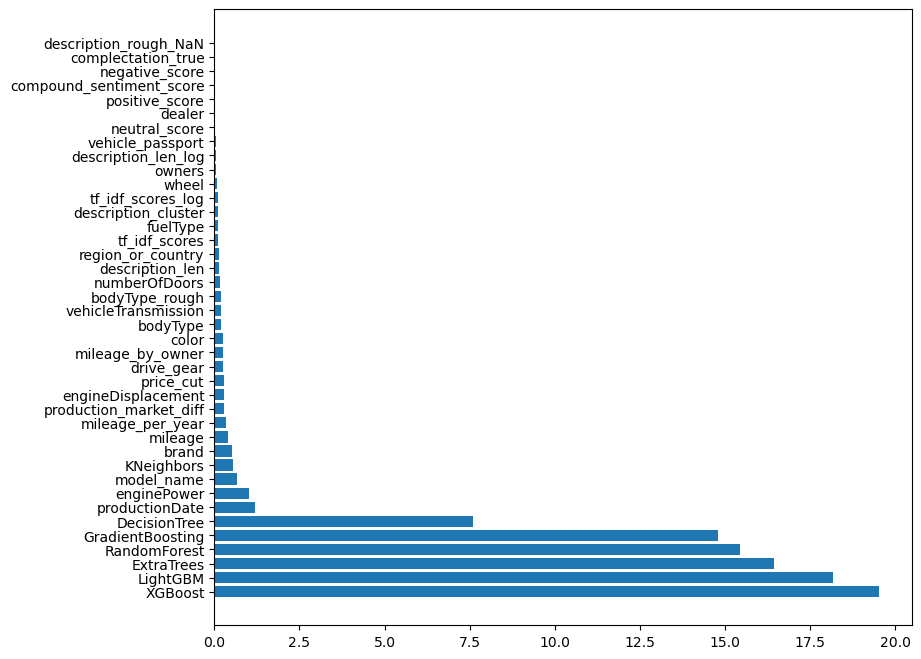

In [37]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize = (9, 8))
ax.barh(feature_importances_df.features_name, feature_importances_df.importance_num) 
plt.show()

In [104]:
# Посмотрим на значение функционала ошибки MAPE
print(f'Мета-алгоритм CatBoost: стандартные параметры. Датасет с изначальными и мета-признаками. MAPE: {mape_exp(y_stacking, cb_meta_model.predict(stacked_features_1)) * 100:.5f}')

Мета-алгоритм CatBoost: стандартные параметры. Датасет с изначальными и мета-признаками. MAPE: 11.78465


### Мета-алгоритм CatBoost: стандартные параметры. Датасет с одними мета-признаками

In [39]:
cb_meta_model_2 = CatBoostRegressor(eval_metric = 'MAPE', custom_metric = ['MAE'],
                                    random_seed = RANDOM_SEED, thread_count = -1,
                                    task_type = "CPU", silent = True)
compute_cv(cb_meta_model_2, 
           stacked_features_3, 
           y_stacking, 
           label = 'CatBoostRegressor_stack')

0it [00:00, ?it/s]

Learning rate set to 0.077747
0:	learn: 0.0572095	total: 11.9ms	remaining: 11.9s
50:	learn: 0.0097741	total: 485ms	remaining: 9.03s
100:	learn: 0.0096246	total: 964ms	remaining: 8.58s
150:	learn: 0.0095446	total: 1.43s	remaining: 8.06s
200:	learn: 0.0094678	total: 1.94s	remaining: 7.7s
250:	learn: 0.0093944	total: 2.52s	remaining: 7.52s
300:	learn: 0.0093331	total: 3.07s	remaining: 7.13s
350:	learn: 0.0092769	total: 3.61s	remaining: 6.67s
400:	learn: 0.0092243	total: 4.2s	remaining: 6.27s
450:	learn: 0.0091742	total: 4.74s	remaining: 5.77s
500:	learn: 0.0091299	total: 5.15s	remaining: 5.13s
550:	learn: 0.0090828	total: 5.58s	remaining: 4.54s
600:	learn: 0.0090412	total: 6s	remaining: 3.98s
650:	learn: 0.0090010	total: 6.45s	remaining: 3.46s
700:	learn: 0.0089650	total: 6.87s	remaining: 2.93s
750:	learn: 0.0089293	total: 7.28s	remaining: 2.41s
800:	learn: 0.0088930	total: 7.7s	remaining: 1.91s
850:	learn: 0.0088566	total: 8.14s	remaining: 1.42s
900:	learn: 0.0088228	total: 8.56s	remaini

(0.1271655109739149, 0.01092181158228267)

features_name  importance_num
6           XGBoost          23.382
5          CatBoost          18.391
4  GradientBoosting          17.524
3      RandomForest          12.949
7          LightGBM          12.239
2        ExtraTrees           8.923
1      DecisionTree           5.887
0        KNeighbors           0.704

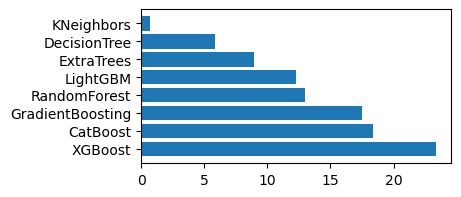

In [40]:
# Построим график важности переменных
feature_importances_df_2 = pd.DataFrame({'features_name' : list(cb_meta_model_2.feature_names_), 
                                         'importance_num': [round(x, 3) for x in cb_meta_model_2.feature_importances_]}) \
                                         .sort_values(by = 'importance_num', ascending = False)
display(feature_importances_df_2)

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (4, 2))
ax.barh(feature_importances_df_2.features_name, feature_importances_df_2.importance_num)
plt.show()

In [41]:
# Посмотрим на значение функционала ошибки MAPE
print(f'Мета-алгоритм CatBoost: стандартные параметры. Датасет с одними мета-признаками. MAPE: {mape_exp(y_stacking, cb_meta_model_2.predict(stacked_features_3)) * 100:.5f}')

Мета-алгоритм CatBoost: стандартные параметры. Датасет с одними мета-признаками. MAPE: 11.98519


### Мета-алгоритм CatBoost: подобранные параметры. Датасет с изначальными и мета-признаками

In [42]:
cb_meta_model_tuned = CatBoostRegressor(**best_params_cb,
                                         eval_metric = 'MAPE', custom_metric = ['MAE'],
                                         random_seed = RANDOM_SEED, thread_count = -1,
                                         task_type = "CPU", silent = True)

print(f'Параметры CatBoostRegressor: {best_params_cb}')


compute_cv(cb_meta_model_tuned, 
           stacked_features_1, 
           y_stacking, 
           label = 'CatBoostRegressor')

Параметры CatBoostRegressor: {'iterations': 986, 'learning_rate': 0.14, 'depth': 10, 'random_strength': 2, 'boosting_type': 'Ordered', 'l2_leaf_reg': 88, 'bootstrap_type': 'MVS'}


0it [00:00, ?it/s]

0:	learn: 0.0537130	test: 0.0537918	best: 0.0537918 (0)	total: 1.42s	remaining: 23m 17s
100:	learn: 0.0100220	test: 0.0101103	best: 0.0101103 (100)	total: 48.3s	remaining: 7m 3s
200:	learn: 0.0097823	test: 0.0099337	best: 0.0099337 (200)	total: 2m 48s	remaining: 10m 59s
300:	learn: 0.0095783	test: 0.0098008	best: 0.0098008 (300)	total: 4m 59s	remaining: 11m 21s
400:	learn: 0.0093671	test: 0.0096830	best: 0.0096830 (400)	total: 7m 16s	remaining: 10m 36s
500:	learn: 0.0092087	test: 0.0096168	best: 0.0096168 (500)	total: 9m 38s	remaining: 9m 19s
600:	learn: 0.0090800	test: 0.0095659	best: 0.0095659 (600)	total: 12m	remaining: 7m 41s
700:	learn: 0.0089565	test: 0.0095280	best: 0.0095280 (700)	total: 14m 25s	remaining: 5m 51s
800:	learn: 0.0088487	test: 0.0095006	best: 0.0095006 (800)	total: 16m 56s	remaining: 3m 54s
900:	learn: 0.0087599	test: 0.0094927	best: 0.0094916 (875)	total: 19m 27s	remaining: 1m 50s
985:	learn: 0.0086977	test: 0.0094879	best: 0.0094879 (985)	total: 21m 34s	remainin

(0.12672830961026324, 0.009062842389277773)

In [43]:
# Построим график важности переменных
feature_importances_df_ = pd.DataFrame({'features_name' : list(cb_meta_model_tuned.feature_names_), 
                                       'importance_num': [round(x, 3) for x in cb_meta_model_tuned.feature_importances_]}) \
                                        .sort_values(by = 'importance_num', ascending = False)
display(feature_importances_df_[:15])

features_name  importance_num
37     GradientBoosting          27.208
39             LightGBM          22.313
35           ExtraTrees          15.619
38              XGBoost          12.175
36         RandomForest          11.589
34         DecisionTree           6.555
8           enginePower           0.598
14           model_name           0.487
5        productionDate           0.468
6   vehicleTransmission           0.389
17       bodyType_rough           0.292
18     mileage_by_owner           0.291
1                 brand           0.282
10           drive_gear           0.252
33           KNeighbors           0.233

In [44]:
# Посмотрим на значение функционала ошибки MAPE
print(f'Мета-алгоритм CatBoost: подобранные параметры. Датасет с изначальными и мета-признаками. MAPE: {mape_exp(y_stacking, cb_meta_model_tuned.predict(stacked_features_1)) * 100:.5f}')

Мета-алгоритм CatBoost: подобранные параметры. Датасет с изначальными и мета-признаками. MAPE: 12.03719


### Мета-алгоритм CatBoost: подобранные параметры. Датасет с одними мета-признаками

In [45]:
cb_meta_model_tuned2 = CatBoostRegressor(**best_params_cb,
                                          eval_metric = 'MAPE', custom_metric = ['MAE'],
                                          random_seed = RANDOM_SEED, thread_count = -1,
                                          task_type = "CPU", silent = True)

print(f'Параметры CatBoostRegressor: {best_params_cb}')


compute_cv(cb_meta_model_tuned2, 
           stacked_features_3, 
           y_stacking, 
           label = 'CatBoostRegressor_stack')

Параметры CatBoostRegressor: {'iterations': 986, 'learning_rate': 0.14, 'depth': 10, 'random_strength': 2, 'boosting_type': 'Ordered', 'l2_leaf_reg': 88, 'bootstrap_type': 'MVS'}


0it [00:00, ?it/s]

0:	learn: 0.0537142	total: 344ms	remaining: 5m 38s
50:	learn: 0.0097886	total: 18.4s	remaining: 5m 36s
100:	learn: 0.0097088	total: 33.2s	remaining: 4m 50s
150:	learn: 0.0096315	total: 43.2s	remaining: 3m 58s
200:	learn: 0.0095751	total: 56.2s	remaining: 3m 39s
250:	learn: 0.0095143	total: 1m 8s	remaining: 3m 21s
300:	learn: 0.0094490	total: 1m 25s	remaining: 3m 14s
350:	learn: 0.0093900	total: 1m 43s	remaining: 3m 7s
400:	learn: 0.0093494	total: 2m 4s	remaining: 3m 1s
450:	learn: 0.0093184	total: 2m 26s	remaining: 2m 53s
500:	learn: 0.0092899	total: 2m 45s	remaining: 2m 40s
550:	learn: 0.0092581	total: 3m 7s	remaining: 2m 28s
600:	learn: 0.0092323	total: 3m 26s	remaining: 2m 11s
650:	learn: 0.0092071	total: 3m 47s	remaining: 1m 57s
700:	learn: 0.0091814	total: 4m 7s	remaining: 1m 40s
750:	learn: 0.0091626	total: 4m 24s	remaining: 1m 22s
800:	learn: 0.0091392	total: 4m 43s	remaining: 1m 5s
850:	learn: 0.0091222	total: 5m 2s	remaining: 47.9s
900:	learn: 0.0091058	total: 5m 20s	remaining

(0.1271283810466334, 0.00600378299940255)

features_name  importance_num
3      RandomForest          24.445
6           XGBoost          17.492
5          CatBoost          17.184
4  GradientBoosting          13.388
7          LightGBM          13.381
1      DecisionTree           7.031
2        ExtraTrees           4.884
0        KNeighbors           2.195

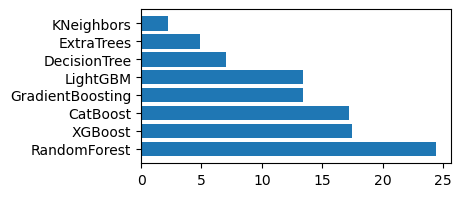

In [46]:
# Построим график важности переменных
feature_importances_DF = pd.DataFrame({'features_name' : list(cb_meta_model_tuned2.feature_names_), 
                                       'importance_num': [round(x, 3) for x in cb_meta_model_tuned2.feature_importances_]}) \
                                        .sort_values(by = 'importance_num', ascending = False)
display(feature_importances_DF)

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (4, 2))
ax.barh(feature_importances_DF.features_name, feature_importances_DF.importance_num)
plt.show()

In [47]:
# Посмотрим на значение функционала ошибки MAPE
print(f'Мета-алгоритм CatBoost: подобранные параметры. Датасет с одними мета-признаками. MAPE: {mape_exp(y, cb_meta_model_tuned2.predict(stacked_features_3)) * 100:.5f}')

Мета-алгоритм CatBoost: подобранные параметры. Датасет с одними мета-признаками. MAPE: 12.30023


Алгоритм CatBoost с подобранными параметрами, обученный на изначальных признаках показал более высокое качество по сравнению со стекингом. Вероятно, это произошло из-за использования сильных алгоритмов внутри.

### Мета-алгоритм Random Forest 

#### Random Forest: стандартные параметры, датасет с изначальными и мета-признаками  

In [48]:
rf_meta_model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1)
compute_cv(rf_meta_model, 
           stacked_features_2, 
           y_stacking, 
           label = 'RandomForestRegressor')

0it [00:00, ?it/s]

(0.12612809937405312, 0.08072353744854362)

In [49]:
print(f'Мета-алгоритм Random Forest: стандартные параметры. Датасет с изначальными и мета-признаками. MAPE: {mape_exp(y, rf_meta_model.predict(stacked_features_2)) * 100:.5f}')

Мета-алгоритм Random Forest: стандартные параметры. Датасет с изначальными и мета-признаками. MAPE: 7.22721


#### Random Forest: стандартные параметры, датасет с одними мета-признаками

In [50]:
rf_meta_model_2 = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1)
compute_cv(rf_meta_model_2, 
           stacked_features_3, 
           y_stacking, 
           label = 'RandomForestRegressor')

0it [00:00, ?it/s]

(0.12832958736051428, 0.0820945975400143)

In [51]:
print(f'Мета-алгоритм Random Forest: стандартные параметры. Датасет с одними мета-признаками. MAPE: {mape_exp(y, rf_meta_model_2.predict(stacked_features_3)) * 100:.5f}')

Мета-алгоритм Random Forest: стандартные параметры. Датасет с одними мета-признаками. MAPE: 7.36684


#### Random Forest: подобранные параметры, датасет с изначальными и мета-признаками  

In [52]:
rf_meta_model_3 = RandomForestRegressor(**best_params_rf, random_state = RANDOM_SEED, n_jobs = -1)
compute_cv(rf_meta_model_3, 
           stacked_features_2, 
           y_stacking, 
           label = 'RandomForestRegressor')

0it [00:00, ?it/s]

(0.12515005089839748, 0.027926384219037956)

In [53]:
print(f'Мета-алгоритм Random Forest: подобранные параметры. Датасет с изначальными и мета-признаками. MAPE: {mape_exp(y, rf_meta_model_3.predict(stacked_features_2)) * 100:.5f}')

Мета-алгоритм Random Forest: подобранные параметры. Датасет с изначальными и мета-признаками. MAPE: 10.62855


#### Random Forest: подобранные параметры, датасет с одними мета-признаками

In [54]:
rf_meta_model_4 = RandomForestRegressor(**best_params_rf, random_state = RANDOM_SEED, n_jobs = -1)
compute_cv(rf_meta_model_4, 
           stacked_features_3, 
           y_stacking, 
           label = 'RandomForestRegressor')

0it [00:00, ?it/s]

(0.12589814768911037, 0.02521623496244625)

In [55]:
print(f'Мета-алгоритм Random Forest: подобранные параметры. Датасет с одними мета-признаками. MAPE: {mape_exp(y, rf_meta_model_4.predict(stacked_features_3)) * 100:.5f}')

Мета-алгоритм Random Forest: подобранные параметры. Датасет с одними мета-признаками. MAPE: 10.89242


### Мета-алгоритм Linear Regression

#### Linear Regression, датасет с одними мета-признаками

In [56]:
lin_meta_model = LinearRegression(n_jobs = -1)
compute_cv(lin_meta_model, 
           stacked_features_3, 
           y_stacking, 
           label = 'LinearRegression')

0it [00:00, ?it/s]

(0.12558585434734867, 0.0007649373703302644)

In [57]:
print(f'Мета-алгоритм Linear Regression. Датасет с одними мета-признаками. MAPE: {mape_exp(y, lin_meta_model.predict(stacked_features_3)) * 100:.5f}')

Мета-алгоритм Linear Regression. Датасет с одними мета-признаками. MAPE: 12.54314


Стекинг со сложными мета-алгоритмами показал не высокие результаты относительно более слабых алгоритмов. Вероятно, это произошло из-за использования сильных алгоритмов внутри.

## 8.2. Стекинг при помощи класса StackingRegressor (sklearn)

- Обучение мета-алгоритма с изначальными и мета-признаками  
- Обучение мета-алгоритма с одними мета-признаками

In [369]:
print(f'Пропущенные значения: {X_lin.isna().sum().sum()}')
print(X_lin.shape)  # (86854, 150)

X_train_st, X_valid_st, y_train_st, y_valid_st = train_test_split(X_lin, y, random_state = RANDOM_SEED)
print(X_train_st.shape, X_valid_st.shape)   # (65140, 150) (21714, 150)
display(X_train_st.head())

Пропущенные значения: 0
(86854, 150)
(65140, 150) (21714, 150)


productionDate  engineDisplacement  enginePower  mileage  owners  \
29478          -0.103              -0.035       -0.302   -0.081   1.044   
11576           0.323              -0.868       -1.085   -0.422  -0.116   
22777          -0.246               0.322       -0.173    0.407   1.044   
61281          -0.530              -0.035       -0.302   -0.403  -0.116   
7256           -0.246              -0.868        1.603   -0.627   1.044   

       complectation_true  mileage_by_owner  mileage_per_year  dealer  \
29478               0.634            -0.449             0.079  -0.515   
11576               0.634            -0.353            -0.634  -0.515   
22777               0.634            -0.140             0.942   1.941   
61281               0.634            -0.335             0.150  -0.515   
7256                0.634            -0.795            -0.402  -0.515   

       compound_sentiment_score  positive_score  negative_score  \
29478                    -0.230          -0.208          -0.102   
11576                    -0.230          -0.208          -0.102   
22777                    -0.230          -0.208          -0.102   
61281                    -0.230          -0.208          -0.102   
7256                     -0.230          -0.208          -0.102   

       neutral_score  description_len  description_len_log  tf_idf_scores  \
29478          0.139           -0.551               -0.874         -0.914   
11576          0.139           -0.081                0.523          0.458   
22777          0.139            1.091                1.381          1.799   
61281          0.139           -0.360               -0.003         -0.278   
7256           0.139           -0.592               -1.344         -1.203   

       tf_idf_scores_log  description_rough_NaN  price_cut  \
29478             -0.965                 -0.165     -1.042   
11576              0.647                 -0.165     -2.287   
22777              1.554                 -0.165     -0.419   
61281             -0.072                 -0.165      0.203   
7256              -1.531                 -0.165      1.449   

       production_market_diff  bodyType_0  bodyType_1  bodyType_2  bodyType_3  \
29478                  -0.147           0           0           0           0   
11576                  -0.147           0           0           0           0   
22777                  -0.147           0           0           0           0   
61281                  -0.147           0           0           1           0   
7256                   -0.705           0           0           0           0   

       bodyType_4  bodyType_5  bodyType_6  bodyType_7  bodyType_8  bodyType_9  \
29478           0           0           0           0           0           0   
11576           0           0           0           0           1           0   
22777           0           0           0           0           0           0   
61281           0           0           0           0           0           0   
7256            0           1           0           0           0           0   

       bodyType_10  bodyType_11  bodyType_12  bodyType_13  bodyType_14  \
29478            0            0            0            0            1   
11576            0            0            0            0            0   
22777            0            0            0            0            1   
61281            0            0            0            0            0   
7256             0            0            0            0            0   

       bodyType_15  bodyType_16  bodyType_17  bodyType_18  bodyType_19  \
29478            0            0            0            0            0   
11576            0            0            0            0            0   
22777            0            0            0            0            0   
61281            0            0            0            0            0   
7256             0            0            0            0            0   

       bodyTyp

#### Обучение мета-алгоритма с изначальными и мета-признаками (passthrough = True)

In [370]:
estimators  = [('SVR', LinearSVR(random_state = RANDOM_SEED)), ('Ridge', Ridge(random_state = RANDOM_SEED)), 
               ('LinearRegr', LinearRegression()),
               ('KNN', KNeighborsRegressor()), 
               ('DecisionTree', DecisionTreeRegressor(random_state = RANDOM_SEED)),  
               ('ExtraTrees', ExtraTreesRegressor(random_state = RANDOM_SEED)), 
               ('GradientBoosting', GradientBoostingRegressor(random_state = RANDOM_SEED)),
               ('XGB', xgb.XGBRegressor(seed = RANDOM_SEED)), 
               ('LGBM', lgbm.LGBMRegressor(seed = RANDOM_SEED)), 
               ('CatBoost', CatBoostRegressor(random_seed = RANDOM_SEED)),
              
               ('KNN_tuned', KNeighborsRegressor(**best_params_kNN)), 
               ('DecisionTree_tuned', DecisionTreeRegressor(**best_params_dt, random_state = RANDOM_SEED)),  
               ('ExtraTrees_tuned', ExtraTreesRegressor(**best_params_et, random_state = RANDOM_SEED)), 
               ('GradientBoosting_tuned', GradientBoostingRegressor(**best_params_gb, random_state = RANDOM_SEED)),
               ('XGB_tuned', xgb.XGBRegressor(**best_params_xgb_2, seed = RANDOM_SEED)), 
               ('LGBM_tuned', lgbm.LGBMRegressor(**best_params_lgbm, seed = RANDOM_SEED)), 
               ('CatBoost_tuned', CatBoostRegressor(**best_params_cb, random_seed = RANDOM_SEED))
              ]

stacking_reg = StackingRegressor(estimators = estimators, final_estimator = LinearRegression(),
                                 cv = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED), 
                                 passthrough = True, n_jobs = -1, verbose = 0) 

stacking_reg.fit(X_train_st, y_train_st).score(X_valid_st, y_valid_st)

0.9672941569258116

In [371]:
print(f'MAPE: {mape_exp(y_valid_st, stacking_reg.predict(X_valid_st)) * 100:.5f}')

# Посмотрим важность алгоритмов 

MAPE: 12.19620


#### Обучение мета-алгоритма с одними мета-признаками (passthrough = False)

In [372]:
estimators  = [('SVR', LinearSVR(random_state = RANDOM_SEED)), ('Ridge', Ridge(random_state = RANDOM_SEED)), 
               ('LinearRegr', LinearRegression()),
               ('KNN', KNeighborsRegressor()), 
               ('DecisionTree', DecisionTreeRegressor(random_state = RANDOM_SEED)),  
               ('ExtraTrees', ExtraTreesRegressor(random_state = RANDOM_SEED)), 
               ('GradientBoosting', GradientBoostingRegressor(random_state = RANDOM_SEED)),
               ('XGB', xgb.XGBRegressor(seed = RANDOM_SEED)), 
               ('LGBM', lgbm.LGBMRegressor(seed = RANDOM_SEED)), 
               ('CatBoost', CatBoostRegressor(random_seed = RANDOM_SEED)),
              
               ('KNN_tuned', KNeighborsRegressor(**best_params_kNN)), 
               ('DecisionTree_tuned', DecisionTreeRegressor(**best_params_dt, random_state = RANDOM_SEED)),  
               ('ExtraTrees_tuned', ExtraTreesRegressor(**best_params_et, random_state = RANDOM_SEED)), 
               ('GradientBoosting_tuned', GradientBoostingRegressor(**best_params_gb, random_state = RANDOM_SEED)),
               ('XGB_tuned', xgb.XGBRegressor(**best_params_xgb_2, seed = RANDOM_SEED)), 
               ('LGBM_tuned', lgbm.LGBMRegressor(**best_params_lgbm, seed = RANDOM_SEED)), 
               ('CatBoost_tuned', CatBoostRegressor(**best_params_cb, random_seed = RANDOM_SEED))
              ]

stacking_reg_1 = StackingRegressor(estimators = estimators, final_estimator = LinearRegression(),
                                 cv = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED), 
                                 passthrough = False, n_jobs = -1, verbose = 0) 

stacking_reg_1.fit(X_train_st, y_train_st).score(X_valid_st, y_valid_st)

0.9672722184122237

In [373]:
print(f'MAPE: {mape_exp(y_valid_st, stacking_reg_1.predict(X_valid_st)) * 100:.5f}')

# Посмотрим важность алгоритмов 

MAPE: 12.21113


# 9. Обучение финальных моделей. Kaggle Submission

- Ответы алгоритмов CatBoost и LightGBM на тестовой выборке
- Обучение модели LightAutoML на всем тренировочном датасете, предсказание ответов на тестовой выборке.    
- Отправка решений на Kaggle. 

### CatBoost   

In [156]:
print(f'MAPE: {mape_exp(y[not_outliers], cb_model.predict(X_cb[not_outliers])) * 100:.5f} %')
display(y_sub_cb.shape, y_sub_cb)

MAPE: 11.72403 %


(34686,)

array([13.32617872, 13.71413721, 13.62322314, ..., 12.30725077,
       14.04906043, 13.87331154])

### LightGBM

In [165]:
print(f"MAPE: {(mape_exp(y[not_outliers], LGBM_model.predict(X_lgbm[not_outliers]))) * 100:.5f} %")
display(y_sub_lgbm.shape, y_sub_lgbm)

MAPE: 11.53671 %


(34686,)

array([13.32638852, 13.74371769, 13.74377501, ..., 12.39665826,
       13.95939971, 13.79333222])

### Staking: Meta-model Random Forest

In [106]:
y_sub_rf_meta = rf_meta_model.predict(stacked_features_2_test)
display(y_sub_rf_meta.shape, y_sub_rf_meta)

(34686,)

array([13.32383365, 13.67864516, 13.62576124, ..., 12.35830295,
       14.02707253, 13.86365066])

### LightAutoML  
**Пресет TabularUtilizedAutoML в стандартной конфигурации.   
Датасет для обучения содержит только числовые и категориальные признаки (без текстового)**

In [249]:
# Загрузим тренировочный и тестовый датасеты
X_lama = pd.read_pickle("X_cb_text.pickle")                  # Обучающий датасет  (86854, 28)
X_sub_lama = pd.read_pickle("X_sub_cb_text.pickle")          # Тестовый датасет  (34686, 28)
y = pd.read_pickle("y_price.pickle")

X_lama = pd.concat([X_lama, y], axis = 1)
print(f"Размер обучающей и тестовой выборок для LightAutoML \nX_lama {X_lama.shape}, X_sub_lama:{X_sub_lama.shape}")

Размер обучающей и тестовой выборок для LightAutoML 
X_lama (86854, 29), X_sub_lama:(34686, 28)


In [252]:
# Зададим параметры-константы, которые будем использовать в процессе решения задачи
N_THREADS = 8
N_FOLDS = 5
RANDOM_SEED = 42
TEST_SIZE = 0.2
TIMEOUT = 10800  # 3 hours
TARGET_NAME = 'price'

# Создадим Task (регрессия) 
task = Task('reg', loss = 'mape', metric = 'mae')

# Установим роли для признаков
roles = {'target' : TARGET_NAME, 
         'drop' : ['description']}

# Воспользуемся пресетом TabularAutoML для создания модели
final_automl = TabularUtilizedAutoML(task = task,             # 'reg', loss = 'mape', metric = 'mae' 
                                     timeout = TIMEOUT,       # 3 hours
                                     cpu_limit = N_THREADS,   # 8
                                     reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  

y_pred_train_automl = final_automl.fit_predict(X_lama, roles = roles, verbose = -1)

[I 2023-10-10 21:51:26,594] A new study created in memory with name: no-name-f0965501-5ceb-4eab-b503-f6b926d699cb
[I 2023-10-10 21:52:26,432] Trial 0 finished with value: -0.1267938659066334 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.1267938659066334.
[I 2023-10-10 21:53:17,884] Trial 1 finished with value: -0.12613738966854363 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.12613738966854363.
[I 2023-10-10 21:53:54,309] Trial 2 finished with value: -0.12892383348345918 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'baggi

In [259]:
# Посмотрим качество модели на train
print(f'Размер oof prediction: {y_pred_train_automl.shape},  NaN-значения: {np.unique(np.isnan(y_pred_train_automl.data))}')
print(f'OOF score: {mape_exp(X_lama["price"].values, y_pred_train_automl.data[:, 0]) * 100:.5f} %')

Размер oof prediction: (86854, 1),  NaN-значения: [False]
OOF score: 11.85421 %


In [260]:
# Краткое описание получившейся модели
print(final_automl.create_model_str_desc())

Final prediction for new objects = 
	0.12982 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.61892 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.38108 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.63744 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.76182 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.23818 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.05010 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_

Feature  Importance
0                price_cut   4,167.784
1           productionDate   3,913.956
2              enginePower   2,375.167
3                  mileage     872.860
4               model_name     676.131
5                    brand     613.116
6                 fuelType     332.865
7       engineDisplacement     331.523
8        region_or_country     284.616
9          description_len     276.524
10                bodyType     240.407
11                  owners     236.737
12     vehicleTransmission     233.547
13        mileage_per_year     221.066
14  production_market_diff     145.368

<AxesSubplot:xlabel='Feature'>

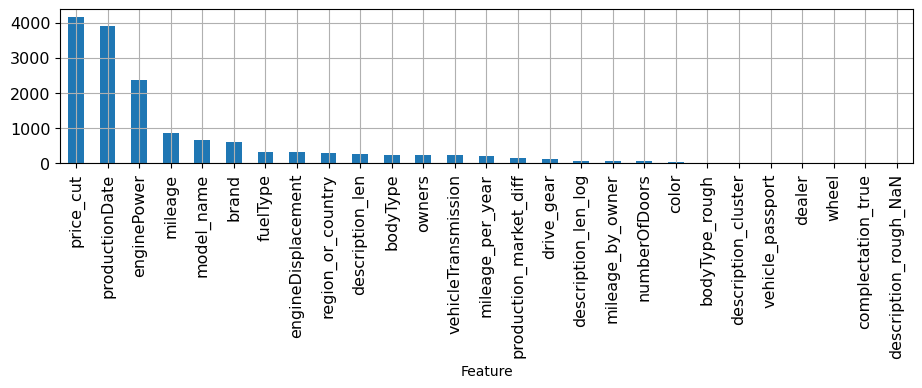

In [261]:
# Построим график важности признаков (Быстрый способ определения важности признаков)
feature_importances_automl = final_automl.get_feature_scores('fast')
display(feature_importances_automl.sort_values('Importance', ascending = False)[:15])
feature_importances_automl.set_index('Feature')['Importance'].plot.bar(figsize = (11, 2), fontsize = 11.5, grid = True)

In [262]:
# Выполним предсказание на тестовом датасете
y_pred_test_automl = final_automl.predict(X_sub_lama)
print(f'Размер test prediction: {y_pred_test_automl.shape},  NaN-значения: {np.unique(np.isnan(y_pred_test_automl.data))}')
display(y_pred_test_automl)

Размер test prediction: (34686, 1),  NaN-значения: [False]


array([[13.276885],
       [13.707893],
       [13.620956],
       ...,
       [12.408174],
       [14.041641],
       [13.853806]], dtype=float32)

### Submission

In [178]:
submission_automobiles = pd.read_csv('sample_submission_car.csv')   # Датасет для итоговых результатов модели
print(submission_automobiles.shape)
display(submission_automobiles.head())

(34686, 2)


sell_id  price
0  1100575026      0
1  1100549428      0
2  1100658222      0
3  1100937408      0
4  1101037972      0

In [179]:
submission_automobiles['price'] = y_sub_lgbm
print(submission_automobiles.shape)
display(submission_automobiles.head())

submission_automobiles.to_csv('submission_automobiles.csv', index = False)

(34686, 2)


sell_id  price
0  1100575026 13.326
1  1100549428 13.744
2  1100658222 13.744
3  1100937408 13.471
4  1101037972 13.445

## 10. Итоги проекта

<a href="https://www.kaggle.com/angelikasung">Моя страничка на kaggle.com</a>     
- В качестве сабмита были опробованы ответы различных алгоритмов. За лучшее решение взят результат работы алгоритма LightGBM.  
- Результат на kaggl 127/324 (по состоянию на 11.10.2023)
- Большая разница в ошибке может свидетельствовать о том, что данные в тренировочном датасете устарели и их необходимо обновить.  
- Стекинг со сложными базовыми алгоритмами показал более низкий результат относительно более слабых алгоритмов.   

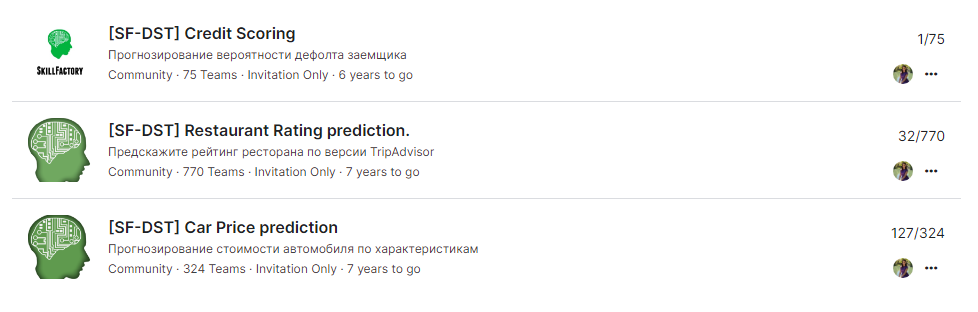